# Simulations for a Linear Peak Power Tariff

In [1]:
%matplotlib inline
%config InlineBackend.figure_formats = ['svg']

import datetime
import pandas as pd
import numpy as np
import cvxpy as cp
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import calendar
import tqdm

# Custom utility functions
from utils import *

# Define the golden mean for plotting
golden_mean = (np.sqrt(5) - 1.0) / 2.0 

In [2]:
# Load the electricity load and price data
load_data = pd.read_pickle("data/load_data.pickle")
price_data = pd.read_pickle("data/price_data.pickle")

# Define the simulation window: one year (365 days) with hourly resolution
T = 24 * 365
start_date = pd.Timestamp("2022-01-01 00:00:00")

# Find the starting and ending time indices for the simulation window in load_data
sim_start_time = load_data.index.get_loc(start_date)
sim_end_time = sim_start_time + T

# Extract the DateTimeIndex corresponding to the simulation window
sim_index = load_data.index[sim_start_time:sim_end_time]

## Functions

In [3]:
def customize_monthly_x_axis(ax, interval):
    """
    Customizes the x-axis of a plot to display months with a specified interval.

    Args:
        ax (matplotlib.axes.Axes): The Axes object to customize.
        interval (int): The interval between major x-axis ticks (in months).
    """
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=interval))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
    
def plot_grid_power(sim_index, power_values, z_series, ylabel, filename):
    """
    Plots grid power and the monthly average of the largest 3 daily peak powers.

    Args:
        sim_index (pd.DatetimeIndex): A datetime index representing the simulation period.
        power_values (np.ndarray): A time series of grid power values.
        z_series (pd.Series): A time series of the monthly average of the largest 3 daily peak powers.
        ylabel (str): The label for the y-axis.
        filename (str): The path and file name where the plot should be saved.
    """
    latexify(fig_width=6.5)
    fig, ax = plt.subplots()
    ax.plot(sim_index, power_values, color="tab:blue", label="Power imported from the grid")
    ax.plot(sim_index, z_series, color="tab:orange", label="Monthly avg. of 3 highest hourly powers (on different days)")
    plt.ylabel(ylabel)
    customize_monthly_x_axis(ax, interval=1)
    plt.legend()
    plt.savefig(filename)
    
def compute_monthly_time_of_use_cost(price_buy, power_values, sim_index):
    """
    Computes the time-of-use cost for each month.

    Args:
        price_buy (pd.Series): A time series of buy prices for electricity.
        power_values (np.ndarray): A time series of power values.
        sim_index (pd.DatetimeIndex): A datetime index representing the simulation period.

    Returns:
        list: A list containing the time-of-use cost for each month.
    """
    monthly_time_of_use_cost = []
    for k in range(12):
        month_mask = sim_index.month == k + 1
        month_cost = np.sum(price_buy[month_mask] * power_values[month_mask])
        monthly_time_of_use_cost.append(month_cost)
    return monthly_time_of_use_cost

def compute_monthly_peak_power_cost(power_values, sim_index, price_peak):
    """
    Computes the peak power cost for each month.

    Args:
        power_values (np.ndarray): A time series of power values.
        sim_index (pd.DatetimeIndex): A datetime index representing the simulation period.
        price_peak (float): The price per unit of peak power.

    Returns:
        list: A list containing the peak power cost for each month.
    """
    monthly_peak_power_cost = []
    for k in range(12):
        month_mask = sim_index.month == k + 1
        month_length = sum(month_mask)
        daily_peak_powers = [power_values[month_mask][i:i+24].max() for i in range(0, month_length, 24)]
        top_3_daily_peaks = sorted(daily_peak_powers, reverse=True)[:3]
        average_top_3_peaks = sum(top_3_daily_peaks) / 3
        monthly_peak_power_cost.append(average_top_3_peaks * price_peak)
    return monthly_peak_power_cost

def plot_monthly_costs(monthly_time_of_use_cost, monthly_peak_power_cost, filename):
    """
    Plots the monthly time-of-use and peak power costs as a stacked bar plot.

    Args:
        monthly_time_of_use_cost (list): A list containing the time-of-use cost for each month.
        monthly_peak_power_cost (list): A list containing the peak power cost for each month.
        filename (str): The path and file name where the plot should be saved.
    """
    months = range(1, 13)
    latexify(fig_width=6.5)
    plt.figure()
    plt.bar(months, monthly_time_of_use_cost, label='Time-of-use cost')
    plt.bar(months, monthly_peak_power_cost, bottom=monthly_time_of_use_cost, label='Peak power cost')
    plt.xticks(months, [calendar.month_abbr[m] for m in months])
    plt.xlabel('Month')
    plt.ylabel('Cost (NOK)')
    plt.legend()
    plt.savefig(filename)

def compute_monthly_avg_largest_3_daily_peak_powers(power_values, sim_index):
    """
    Computes the monthly average of the largest 3 daily peak powers.

    Args:
        power_values (np.ndarray): A time series of power values.
        sim_index (pd.DatetimeIndex): A datetime index representing the simulation period.

    Returns:
        pd.Series: A time series of the monthly average of the largest 3 daily peak powers.
    """
    z_values = []
    for k in range(12):
        month_mask = sim_index.month == k + 1
        month_length = sum(month_mask)
        daily_peak_powers = [power_values[month_mask][i:i+24].max() for i in range(0, month_length, 24)]
        top_3_daily_peaks = sorted(daily_peak_powers, reverse=True)[:3]
        average_top_3_peaks = sum(top_3_daily_peaks) / 3
        z_values.extend([average_top_3_peaks] * month_length)
    return pd.Series(z_values, index=sim_index)

def print_cost_summary(total_cost, time_of_use_cost, peak_power_cost):
    """
    Prints a summary of the total, time-of-use, and peak power costs.

    Args:
        total_cost (float): The total cost.
        time_of_use_cost (float): The time-of-use cost.
        peak_power_cost (float): The peak power cost.
    """
    print(f"Total cost for 2022: {total_cost:,.2f} NOK")
    print(f"Time-of-use cost: {time_of_use_cost:,.2f} NOK ({100 * time_of_use_cost / total_cost:.2f}% of total cost)")
    print(f"Peak power cost: {peak_power_cost:,.2f} NOK ({100 * peak_power_cost / total_cost:.2f}% of total cost)")
    
def plot_state_of_charge(sim_index, state_of_charge, ylabel, filename):
    """
    Plots the state of charge over the simulation period.

    Args:
        sim_index (pd.DatetimeIndex): A datetime index representing the simulation period.
        state_of_charge (np.ndarray): A time series of state of charge values.
        ylabel (str): The label for the y-axis.
        filename (str): The path and file name where the plot should be saved.
    """
    latexify(fig_width=6.5)
    fig, ax = plt.subplots()
    ax.plot(sim_index, state_of_charge, color="tab:blue")
    plt.ylabel(ylabel)
    customize_monthly_x_axis(ax, interval=1)
    plt.legend()
    plt.savefig(filename)

## No storage

Total cost for 2022: 25,168.01 NOK
Time-of-use cost: 8,676.61 NOK (34.47% of total cost)
Peak power cost: 16,491.40 NOK (65.53% of total cost)


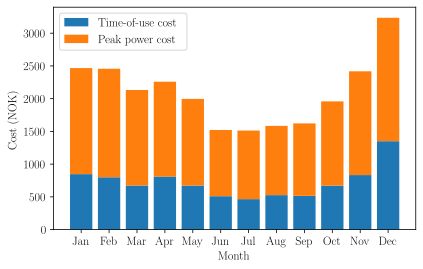

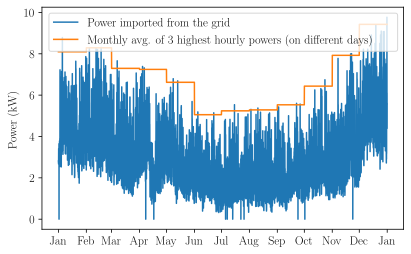

In [4]:
# Load electricity load and price data, and set peak power price
l = load_data.iloc[sim_start_time:sim_end_time].values
price_buy = price_data.iloc[sim_start_time:sim_end_time].values
price_peak = 200

# Calculate monthly time-of-use cost
monthly_time_of_use_cost = compute_monthly_time_of_use_cost(price_buy, l, sim_index)

# Calculate monthly peak power cost
monthly_peak_power_cost = compute_monthly_peak_power_cost(l, sim_index, price_peak)

# Calculate total costs for each category
total_cost = sum(monthly_time_of_use_cost) + sum(monthly_peak_power_cost)
total_time_of_use_cost = sum(monthly_time_of_use_cost)
total_peak_power_cost = sum(monthly_peak_power_cost)

# Compute z: monthly average of the largest 3 daily peak powers
z_series = compute_monthly_avg_largest_3_daily_peak_powers(l, sim_index)

# Display cost summary
print_cost_summary(total_cost, total_time_of_use_cost, total_peak_power_cost)

# Plot and save monthly costs without storage
plot_monthly_costs(monthly_time_of_use_cost, monthly_peak_power_cost, "figures/linear_cost_no_storage.pdf")

# Plot and save grid power without storage
plot_grid_power(sim_index, l, z_series, "Power (kW)", "figures/grid_power_no_storage.pdf")


## Prescient optimization with storage (15 kWh)

In [5]:
# Constants
alpha = 0.01
P = 20

# Parameters
Q = cp.Parameter(nonneg=True, value=0)
C = cp.Parameter(nonneg=True, value=Q.value / 2)
D = cp.Parameter(nonneg=True, value=Q.value / 2)
q_init = cp.Parameter(nonneg=True, value=Q.value / 2)
q_final = cp.Parameter(nonneg=True, value=Q.value / 2)

# Variables
p = cp.Variable(T)  # Grid power
u = cp.Variable(T)  # Battery power
q = cp.Variable(T+1)  # State of charge

# Constraints
cons = [p >= 0, p <= P,
        l == p + u,
        q[1:] == (1 - alpha) * q[:-1] - u,
        q[0] == q_init, q[-1] == q_final,
        q >= 0, q <= Q,
        -C <= u, u <= D]

time_of_use_cost = cp.sum(cp.multiply(price_buy, p))

# Compute m: daily maximum power for each day in each month (months indexed from 0 to K-1)
K = 12
m = []
month_masks = [(sim_index.month == k + 1) for k in range(K)]

for k in range(K):
    month_mask = month_masks[k]
    month_length = sum(month_mask)
    p_month = cp.Variable(month_length)
    cons.extend([p[month_mask] == p_month])
    p_daily_max = [cp.max(p_month[i:i+24]) for i in range(0, month_length, 24)]
    m.append(cp.hstack(p_daily_max))

# Compute z: average of N largest daily maximum power values from different days in each month (months indexed from 0 to K-1)
z = [1/3 * cp.sum_largest(m[k], 3) for k in range(K)]

# Linear peak power cost
peak_power_cost = cp.sum([price_peak * z[k] for k in range(K)])

# Total cost
cost = time_of_use_cost + peak_power_cost

# Create optimization problem
problem = cp.Problem(cp.Minimize(cost), cons)

# Set parameter values
Q.value = 15
C.value = Q.value / 2
D.value = Q.value / 2
q_init.value = Q.value / 2
q_final.value = Q.value / 2

# Solve the problem
problem.solve()

17661.113573659906

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total cost for 2022: 17,661.11 NOK
Time-of-use cost: 8,458.87 NOK (47.90% of total cost)
Peak power cost: 9,202.25 NOK (52.10% of total cost)


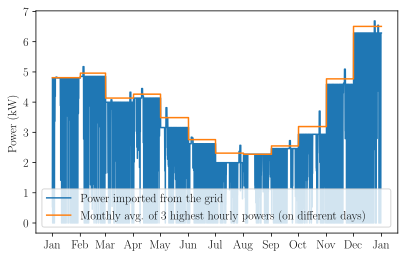

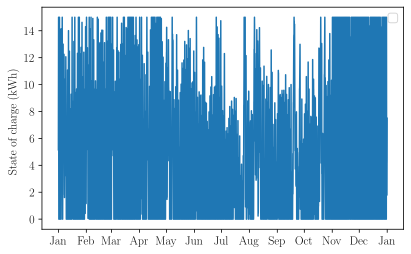

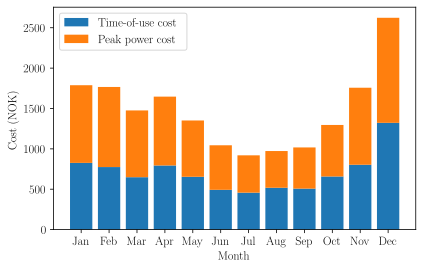

In [6]:
# Calculate the time-of-use cost per month
monthly_time_of_use_cost = compute_monthly_time_of_use_cost(price_buy, p.value, sim_index)

# Calculate the peak power cost per month
monthly_peak_power_cost = compute_monthly_peak_power_cost(p.value, sim_index, price_peak)

# Calculate the monthly average of the three largest daily peak powers
z_values = compute_monthly_avg_largest_3_daily_peak_powers(p.value, sim_index)

# Create a grid power plot
plot_grid_power(sim_index, p.value, z_values, "Power (kW)", "figures/linear_power_prescient.pdf")

# Create a state of charge plot
plot_state_of_charge(sim_index, q.value[1:], "State of charge (kWh)", "figures/linear_soc_prescient.pdf")

# Display a summary of the costs
print_cost_summary(cost.value, time_of_use_cost.value, peak_power_cost.value)

# Create a stack plot showing monthly time-of-use and peak power costs
plot_monthly_costs(monthly_time_of_use_cost, monthly_peak_power_cost, "figures/linear_cost_prescient.pdf")

## Cost versus storage capacity

In [7]:
# # Define the range of storage capacities to evaluate
# storage_capacities = np.linspace(0, 30)

# # Initialize arrays for storing the costs (time-of-use and peak power)
# time_of_use_cost_values = np.zeros(len(storage_capacities))
# peak_power_cost_values = np.zeros(len(storage_capacities))

# # Perform sensitivity analysis for various storage capacities
# for i, capacity in tqdm.tqdm(enumerate(storage_capacities), total=len(storage_capacities), desc="Performing sensitivity analysis"):
#     # Update parameter values for the current capacity
#     Q.value = capacity
#     C.value = Q.value / 2
#     D.value = Q.value / 2
#     q_init.value = Q.value / 2
#     q_final.value = Q.value / 2
    
#     # Solve the optimization problem for the current capacity
#     problem.solve()

#     # Store the results (time-of-use and peak power costs)
#     time_of_use_cost_values[i] = time_of_use_cost.value
#     peak_power_cost_values[i] = peak_power_cost.value

In [8]:
# # Plot the results: time-of-use cost, peak power cost, and total cost
# latexify(fig_width=5)
# plt.figure()
# plt.plot(storage_capacities, time_of_use_cost_values, color="black", linestyle="dashed", label="Time-of-use cost")
# plt.plot(storage_capacities, peak_power_cost_values, color="black", linestyle="dotted", label="Peak power cost")
# plt.plot(storage_capacities, time_of_use_cost_values + peak_power_cost_values, color="black", linestyle="solid", label="Total cost")
# plt.xlabel("Storage capacity (kWh)")
# plt.ylabel("Cost (NOK)")
# plt.legend(ncol=2)
# plt.ylim(bottom=0)
# plt.savefig("figures/linear_cost_vs_storage_capacity.pdf")

# # Plot the total cost as a function of storage capacity
# latexify(fig_width=5, fig_height=5*golden_mean/2)
# plt.figure()
# plt.plot(storage_capacities, time_of_use_cost_values + peak_power_cost_values, c="k")
# plt.xlabel("Storage capacity (kWh)")
# plt.ylabel("Cost (NOK)")
# plt.title("Total cost")

# # Plot the time-of-use cost as a function of storage capacity
# plt.figure()
# plt.plot(storage_capacities, time_of_use_cost_values, c="k")
# plt.xlabel("Storage capacity (kWh)")
# plt.ylabel("Cost (NOK)")
# plt.title("Time-of-use cost")

# # Plot the peak power cost as a function of storage capacity
# plt.figure()
# plt.plot(storage_capacities, peak_power_cost_values, c="k")
# plt.xlabel("Storage capacity (kWh)")
# plt.ylabel("Cost (NOK)")
# plt.title("Peak power cost")


## MPC with baseline forecast

In [9]:
# Import baseline forecast
baseline = pd.read_pickle("data/load_baseline.pickle")

def group_hours_by_day(datetime_index):
    # Convert datetime_index to a pandas Series
    datetime_series = pd.Series(datetime_index)
    
    # Group the hours by their corresponding day
    grouped_hours = datetime_series.groupby(datetime_series.dt.to_period('D')).indices
    
    return grouped_hours


def calculate_peak_power_cost(p_values, datetime_index, price_peak, cvxpy_mode=False):
    peak_power_cost = 0
    unique_months = pd.Series(datetime_index).dt.to_period('M').nunique()

    for month in range(1, unique_months + 1):
        month_mask = (pd.Series(datetime_index).dt.month == month)
        month_length = sum(month_mask)

        if month_length == 0:  # No hours are selected for the current month
            continue

        p_month = p_values[month_mask]

        month_hours = pd.Series(datetime_index)[month_mask]
        daily_hours_grouped = group_hours_by_day(month_hours)

        if cvxpy_mode:
            p_daily_max = [p_month[hour_indices] if len(hour_indices) == 1 else cp.max(p_month[hour_indices]) for hour_indices in daily_hours_grouped.values()]
        else:
            p_daily_max = [np.max(p_month[hour_indices]) for hour_indices in daily_hours_grouped.values()]

        days_in_month = len(p_daily_max)
        if days_in_month == 1:
            z = cp.max(cp.hstack(p_daily_max)) if cvxpy_mode else np.max(p_daily_max)
        elif days_in_month == 2:
            z = 1/2 * (cp.sum_largest(cp.hstack(p_daily_max), 2) if cvxpy_mode else np.sum(np.partition(p_daily_max, -2)[-2:]))
        else:
            z = 1/3 * cp.sum_largest(cp.hstack(p_daily_max), 3) if cvxpy_mode else 1/3 * np.sum(np.partition(p_daily_max, -3)[-3:])

        month_peak_power = cp.pos(z*price_peak - curr_peak_cost) if cvxpy_mode else np.maximum(z*price_peak - curr_peak_cost, 0)
        peak_power_cost += month_peak_power

    return peak_power_cost



def run_mpc(l, price_buy, datetime_index, q_init, curr_peak_cost, T_MPC):
    # Constants
    Q = 15 # kWh
    C, D, q_final = Q/2, Q/2, Q/2
    price_peak = 200
    alpha = 0.01
    P = 20

    # Variables
    p = cp.Variable(T_MPC) 
    u = cp.Variable(T_MPC) 
    q = cp.Variable(T_MPC+1)

    # Constraints
    constraints = [p >= 0, p <= P,
            l == p + u,
            q[1:] == (1 - alpha) * q[:-1] - u,
            q[0] == q_init, q[-1] == q_final, 
            q >= 0, q <= Q,
            -C <= u, u <= D]

    time_of_use_cost = cp.sum(cp.multiply(price_buy, p))

    # # Find unique months in datetime_index
    # unique_months = pd.Series(datetime_index).dt.to_period('M').nunique()
    # K = unique_months

    # # Initialize the peak power cost
    # peak_power_cost = 0

    # # Iterate through each month
    # for month in range(1, K + 1):
    #     # Find the indices of the current month
    #     month_mask = (pd.Series(datetime_index).dt.month == month)
    #     month_length = sum(month_mask)
    #     p_month = p[month_mask]

    #     # Group the hours by day for the current month
    #     month_hours = pd.Series(datetime_index)[month_mask]
    #     daily_hours_grouped = group_hours_by_day(month_hours)

    #     # Compute the daily maximum power for the current month
    #     p_daily_max = [cp.max(p_month[hour_indices]) for hour_indices in daily_hours_grouped.values()]

    #     # Compute z, taking into account the number of days in the current month
    #     days_in_month = len(p_daily_max)
    #     if days_in_month == 1:
    #         z = cp.max(cp.hstack(p_daily_max))
    #     elif days_in_month == 2:
    #         z = 1/2 * cp.sum_largest(cp.hstack(p_daily_max), 2)
    #     else:
    #         z = 1/3 * cp.sum_largest(cp.hstack(p_daily_max), 3)

    #     # Calculate the peak power cost for the current month
    #     month_peak_power = cp.pos(z*price_peak - curr_peak_cost)

    #     # Add the peak power cost of the current month to the total peak power cost
    #     peak_power_cost += month_peak_power
    
    # Calculate the peak power cost using the function
    peak_power_cost = calculate_peak_power_cost(p, datetime_index, price_peak, cvxpy_mode=True)

    cost = time_of_use_cost + peak_power_cost

    # Create problem
    problem = cp.Problem(cp.Minimize(cost), constraints)
    
    # Solve
    problem.solve()
    
    # First action
    u0 = u.value[0]
    p0 = p.value[0]
    
    return u0, p0
    
    
def forecast(t, T_MPC):
    l_curr = np.array([load_data[sim_start_time+t]])
    l_baseline = baseline[sim_start_time+t+1:sim_start_time+t+T_MPC].values
    l = np.concatenate((l_curr, l_baseline))
    price_buy = price_data[sim_start_time+t:sim_start_time+t+T_MPC].values
    datetime_index = sim_index[t:t+T_MPC]
    return l, price_buy, datetime_index

# MPC prediction horizon
T_MPC = 24 * 30
    
# Create empty arrays
q_values = np.empty(T+1)
p_values = np.empty(T)

# Set parameter values
Q = 15 # kWh
C, D, q_final = Q/2, Q/2, Q/2

# Initial states
q_init = Q/2
q_values[0] = q_init
curr_peak_cost = 0

prev_month = None
curr_peak_cost_values = np.zeros(T+1)
curr_peak_cost_values[0] = curr_peak_cost
# MPC loop
for t in tqdm.trange(T, desc="MPC Simulation"):
    # Shrink planning horizon if the ramaining simulation horizon is less than the planning horizon
    if T - t < T_MPC:
        T_MPC = T - t
    # Make forecasts
    l, price_buy, datetime_index = forecast(t, T_MPC)
    
    # Check if the month has changed
    current_month = datetime_index[0].to_period('M')
    if prev_month is not None and current_month != prev_month:
        print(f"Month changed: {prev_month} -> {current_month}")
        curr_peak_cost = 0
    prev_month = current_month
    
    # Run MPC to make a plan over a horizon T_MPC
    u0, p0 = run_mpc(l, price_buy, datetime_index, q_init, curr_peak_cost, T_MPC)
    # Implement first action and update state of charge
    q_values[t+1] = (1 - alpha) * q_values[t] - u0
    q_init = q_values[t+1]
    # Store grid power
    p_values[t] = p0
    
    # Create a mask for the current month
    current_month_mask = (pd.Series(sim_index[:t+1]).dt.to_period('M') == current_month)

    # Update the current peak power cost (curr_peak_cost) for the current month
    new_peak_cost = calculate_peak_power_cost(p_values[:t+1][current_month_mask], sim_index[:t+1][current_month_mask], price_peak)
    if current_month != prev_month:
        curr_peak_cost = new_peak_cost
    else:
        curr_peak_cost = max(new_peak_cost, curr_peak_cost)
    curr_peak_cost_values[t+1] = curr_peak_cost
    
    print(f"t: {t}, curr_peak_cost: {curr_peak_cost}, q_init: {q_init}, p0: {p0}")
    

MPC Simulation:   0%|          | 2/8760 [00:00<10:36, 13.76it/s]

t: 0, curr_peak_cost: 939.1071873323028, q_init: 9.308535936661517, p0: 4.695535936661514
t: 1, curr_peak_cost: 939.1071873323028, q_init: 11.14498650762447, p0: 4.695535930330847
t: 2, curr_peak_cost: 939.1071873323028, q_init: 12.542610557172994, p0: 4.303073914625806


MPC Simulation:   0%|          | 6/8760 [00:00<10:20, 14.10it/s]

t: 3, curr_peak_cost: 939.1071873323028, q_init: 13.539618409252066, p0: 3.890433957651835
t: 4, curr_peak_cost: 939.1071873323028, q_init: 14.396388995338894, p0: 3.6971667701803903
t: 5, curr_peak_cost: 939.1071873323028, q_init: 14.999999997687382, p0: 3.415574892302926


MPC Simulation:   0%|          | 8/8760 [00:00<10:19, 14.13it/s]

t: 6, curr_peak_cost: 939.1071873323028, q_init: 11.67000005983071, p0: 6.212161467677323e-08
t: 7, curr_peak_cost: 939.1071873323028, q_init: 10.559093536228481, p0: 2.4187934769975707
t: 8, curr_peak_cost: 939.1071873323028, q_init: 9.615745401038348, p0: 2.0072428001736475


MPC Simulation:   0%|          | 10/8760 [00:00<10:38, 13.71it/s]

t: 9, curr_peak_cost: 939.1071873323028, q_init: 8.383727152447666, p0: 1.6771392054211909
t: 10, curr_peak_cost: 939.1071873323028, q_init: 7.250998491396992, p0: 1.8641086104752196


MPC Simulation:   0%|          | 14/8760 [00:01<11:18, 12.89it/s]

t: 11, curr_peak_cost: 939.1071873323028, q_init: 6.509656692619815, p0: 2.2911681861381794
t: 12, curr_peak_cost: 939.1071873323028, q_init: 6.209105741114635, p0: 2.565545615422433
t: 13, curr_peak_cost: 939.1071873323028, q_init: 6.1843185181631455, p0: 2.867303834461006
t: 14, curr_peak_cost: 939.1071873323028, q_init: 6.219447140144104, p0: 3.3879718071638685


MPC Simulation:   0%|          | 18/8760 [00:01<10:24, 14.00it/s]

t: 15, curr_peak_cost: 939.1071873323028, q_init: 6.20165818258461, p0: 3.6914055138432693
t: 16, curr_peak_cost: 939.1071873323028, q_init: 6.149397745238286, p0: 2.9797561444808123
t: 17, curr_peak_cost: 939.1071873323028, q_init: 6.126541815857395, p0: 0.04163804807269903
t: 18, curr_peak_cost: 939.1071873323028, q_init: 6.153499969944974, p0: 3.1222235722474787


MPC Simulation:   0%|          | 22/8760 [00:01<09:59, 14.57it/s]

t: 19, curr_peak_cost: 939.1071873323028, q_init: 6.207376519693914, p0: 2.8054115494497536
t: 20, curr_peak_cost: 939.1071873323028, q_init: 6.295934572762159, p0: 2.7296318182664874
t: 21, curr_peak_cost: 939.1071873323028, q_init: 6.488194010879781, p0: 3.2322187838452434
t: 22, curr_peak_cost: 939.1071873323028, q_init: 7.457867482260109, p0: 4.695555411489129


MPC Simulation:   0%|          | 26/8760 [00:01<09:45, 14.91it/s]

t: 23, curr_peak_cost: 939.1071873323028, q_init: 9.193713479715363, p0: 4.45242467227882
t: 24, curr_peak_cost: 939.1071873323028, q_init: 10.228791343906455, p0: 3.7700149989892604
t: 25, curr_peak_cost: 939.1071873323028, q_init: 11.377335810587468, p0: 3.819832380120952
t: 26, curr_peak_cost: 939.1071873323028, q_init: 12.500483355951243, p0: 3.805920903470588


MPC Simulation:   0%|          | 30/8760 [00:02<09:46, 14.87it/s]

t: 27, curr_peak_cost: 939.1071873323028, q_init: 13.523697388904434, p0: 3.8072188665137014
t: 28, curr_peak_cost: 939.1071873323028, q_init: 14.394660644394605, p0: 3.589200229380175
t: 29, curr_peak_cost: 939.1071873323028, q_init: 14.99999999801535, p0: 3.386285960065684


MPC Simulation:   0%|          | 34/8760 [00:02<09:45, 14.90it/s]

t: 30, curr_peak_cost: 939.1071873323028, q_init: 13.820037100592444, p0: 2.75403710255863
t: 31, curr_peak_cost: 939.1071873323028, q_init: 13.381790660168427, p0: 2.24195393058335
t: 32, curr_peak_cost: 939.1071873323028, q_init: 12.37157312984459, p0: 1.780600376279268
t: 33, curr_peak_cost: 939.1071873323028, q_init: 11.058854229119708, p0: 1.3579968305749863


MPC Simulation:   0%|          | 38/8760 [00:02<09:48, 14.82it/s]

t: 34, curr_peak_cost: 939.1071873323028, q_init: 9.831286030891812, p0: 1.5430203440646235
t: 35, curr_peak_cost: 939.1071873323028, q_init: 8.980730313478505, p0: 1.94975714289693
t: 36, curr_peak_cost: 939.1071873323028, q_init: 8.556446368394077, p0: 2.2625233580516806
t: 37, curr_peak_cost: 939.1071873323028, q_init: 8.393361049603886, p0: 2.4884791448950603


MPC Simulation:   0%|          | 42/8760 [00:02<10:41, 13.58it/s]

t: 38, curr_peak_cost: 939.1071873323028, q_init: 8.275699874639882, p0: 3.8652724355333614
t: 39, curr_peak_cost: 939.1071873323028, q_init: 8.090834327710283, p0: 2.526891451818086
t: 40, curr_peak_cost: 939.1071873323028, q_init: 7.857544550076035, p0: 2.393618565644165
t: 41, curr_peak_cost: 939.1071873323028, q_init: 7.640196328340215, p0: 3.9112272237662604


MPC Simulation:   1%|          | 46/8760 [00:03<10:16, 14.13it/s]

t: 42, curr_peak_cost: 939.1071873323028, q_init: 6.235627554747175, p0: 4.702833189690483
t: 43, curr_peak_cost: 939.1071873323028, q_init: 3.6677751827113947, p0: 4.717503903511696
t: 44, curr_peak_cost: 939.1071873323028, q_init: 5.151949431838672, p0: 4.707852000954849
t: 45, curr_peak_cost: 939.1071873323028, q_init: 4.205235889006634, p0: 4.713805951486352


MPC Simulation:   1%|          | 50/8760 [00:03<10:05, 14.38it/s]

t: 46, curr_peak_cost: 939.1071873323028, q_init: 5.808478772185886, p0: 4.705295242069315
t: 47, curr_peak_cost: 939.1071873323028, q_init: 7.109872847187078, p0: 4.700478862723066
t: 48, curr_peak_cost: 939.1071873323028, q_init: 8.377178880178882, p0: 4.697404761463647
t: 49, curr_peak_cost: 939.1071873323028, q_init: 10.27694302820995, p0: 4.695535936834281


MPC Simulation:   1%|          | 54/8760 [00:03<10:00, 14.51it/s]

t: 50, curr_peak_cost: 939.1071873323028, q_init: 12.01370953334401, p0: 4.695535935417663
t: 51, curr_peak_cost: 939.1071873323028, q_init: 13.729108374021955, p0: 4.695535936012899
t: 52, curr_peak_cost: 939.1071873323028, q_init: 14.67452682860012, p0: 3.8867095383195203
t: 53, curr_peak_cost: 939.1071873323028, q_init: 14.99999999942188, p0: 3.303218439108922


MPC Simulation:   1%|          | 58/8760 [00:04<09:59, 14.52it/s]

t: 54, curr_peak_cost: 939.1071873323028, q_init: 12.071462708253303, p0: 1.3854627088273084
t: 55, curr_peak_cost: 939.1071873323028, q_init: 11.3088159632234, p0: 4.6960678820524695
t: 56, curr_peak_cost: 939.1071873323028, q_init: 9.238958027450767, p0: 4.702230223859603
t: 57, curr_peak_cost: 939.1071873323028, q_init: 6.984359811059727, p0: 4.707791363883501


MPC Simulation:   1%|          | 60/8760 [00:04<10:02, 14.44it/s]

t: 58, curr_peak_cost: 939.1071873323028, q_init: 5.830232439816035, p0: 4.705716226867144
t: 59, curr_peak_cost: 939.1071873323028, q_init: 6.07638870295976, p0: 3.736458587543553
t: 60, curr_peak_cost: 939.1071873323028, q_init: 5.4614532251102546, p0: 3.156828409181694


MPC Simulation:   1%|          | 64/8760 [00:04<11:05, 13.06it/s]

t: 61, curr_peak_cost: 939.1071873323028, q_init: 5.124649914598784, p0: 4.2778112217412465
t: 62, curr_peak_cost: 939.1071873323028, q_init: 4.851355157984765, p0: 4.580951742533505
t: 63, curr_peak_cost: 939.1071873323028, q_init: 2.6326192608479873, p0: 4.711777654443051


MPC Simulation:   1%|          | 66/8760 [00:04<10:56, 13.23it/s]

t: 64, curr_peak_cost: 939.1071873323028, q_init: 3.392694701196653, p0: 4.702401632957176
t: 65, curr_peak_cost: 939.1071873323028, q_init: 3.8660421223556654, p0: 4.219274368172482
t: 66, curr_peak_cost: 939.1071873323028, q_init: 3.609914148052338, p0: 3.443532446921764


MPC Simulation:   1%|          | 70/8760 [00:04<10:30, 13.79it/s]

t: 67, curr_peak_cost: 939.1071873323028, q_init: 3.3894407512095763, p0: 4.688625744640187
t: 68, curr_peak_cost: 939.1071873323028, q_init: 3.213209809804984, p0: 3.225663466109149
t: 69, curr_peak_cost: 939.1071873323028, q_init: 3.1716009153627627, p0: 3.8415232036574825


MPC Simulation:   1%|          | 72/8760 [00:05<10:24, 13.92it/s]

t: 70, curr_peak_cost: 939.1071873323028, q_init: 2.8497622083535705, p0: 4.70087730214462
t: 71, curr_peak_cost: 939.1071873323028, q_init: 4.884800519827268, p0: 4.695535933558816
t: 72, curr_peak_cost: 939.1071873323028, q_init: 6.942488448027211, p0: 4.695535933399796


MPC Simulation:   1%|          | 76/8760 [00:05<10:07, 14.30it/s]

t: 73, curr_peak_cost: 939.1071873323028, q_init: 8.524599500435343, p0: 4.695535936890015
t: 74, curr_peak_cost: 939.1071873323028, q_init: 9.924889442332194, p0: 4.695535936902766
t: 75, curr_peak_cost: 939.1071873323028, q_init: 11.817176481219073, p0: 4.695535933311739


MPC Simulation:   1%|          | 80/8760 [00:05<10:00, 14.45it/s]

t: 76, curr_peak_cost: 939.1071873323028, q_init: 13.864540653009998, p0: 4.69553593660472
t: 77, curr_peak_cost: 939.1071873323028, q_init: 14.999999999788132, p0: 3.9931047533094532
t: 78, curr_peak_cost: 939.1071873323028, q_init: 11.187000010513117, p0: 1.0724552598268858e-08
t: 79, curr_peak_cost: 939.1071873323028, q_init: 8.192345013490007, p0: 3.164215003083723


MPC Simulation:   1%|          | 82/8760 [00:05<09:58, 14.51it/s]

t: 80, curr_peak_cost: 939.1071873323028, q_init: 7.074914546193419, p0: 4.3724929828401615
t: 81, curr_peak_cost: 939.1071873323028, q_init: 4.861690414831522, p0: 4.705525014100079
t: 82, curr_peak_cost: 939.1071873323028, q_init: 4.257972687117674, p0: 4.696899176434374


MPC Simulation:   1%|          | 86/8760 [00:06<11:33, 12.51it/s]

t: 83, curr_peak_cost: 939.1071873323028, q_init: 2.694745122343991, p0: 4.705352162097494
t: 84, curr_peak_cost: 939.1071873323028, q_init: 1.239962454319118, p0: 4.7091647831986
t: 85, curr_peak_cost: 939.1071873323028, q_init: -8.47326653286018e-11, p0: 5.9184371701389535


MPC Simulation:   1%|          | 88/8760 [00:06<11:12, 12.90it/s]

t: 86, curr_peak_cost: 939.1071873323028, q_init: -2.1542206855915496e-10, p0: 6.139999999870076
t: 87, curr_peak_cost: 939.1071873323028, q_init: 1.0241647821327577, p0: 4.709164782346053
t: 88, curr_peak_cost: 939.1071873323028, q_init: 2.0592761890140796, p0: 4.698353054702643


MPC Simulation:   1%|          | 92/8760 [00:06<10:32, 13.71it/s]

t: 89, curr_peak_cost: 939.1071873323028, q_init: 2.064508211203655, p0: 3.9338247840813443
t: 90, curr_peak_cost: 939.1071873323028, q_init: 1.097120734289196, p0: 4.708257605198111
t: 91, curr_peak_cost: 939.1071873323028, q_init: 1.8197089241621542, p0: 4.583559397217615
t: 92, curr_peak_cost: 939.1071873323028, q_init: 1.7488322012886732, p0: 4.209320366369794


MPC Simulation:   1%|          | 96/8760 [00:06<10:21, 13.95it/s]

t: 93, curr_peak_cost: 939.1071873323028, q_init: 1.8052628104821535, p0: 3.942918931208125
t: 94, curr_peak_cost: 939.1071873323028, q_init: 2.1297461191402958, p0: 4.69553593676527
t: 95, curr_peak_cost: 939.1071873323028, q_init: 3.1219845941551245, p0: 4.695535936207832


MPC Simulation:   1%|          | 98/8760 [00:07<10:18, 14.02it/s]

t: 96, curr_peak_cost: 939.1071873323028, q_init: 4.51030068477796, p0: 4.695535936566021
t: 97, curr_peak_cost: 939.1071873323028, q_init: 5.67573361465246, p0: 4.695535936723794
t: 98, curr_peak_cost: 939.1071873323028, q_init: 5.922512215198436, p0: 4.695535936694066


MPC Simulation:   1%|          | 102/8760 [00:07<10:08, 14.23it/s]

t: 99, curr_peak_cost: 939.1071873323028, q_init: 6.9488230295609545, p0: 4.695535936516072
t: 100, curr_peak_cost: 939.1071873323028, q_init: 7.905870735950614, p0: 4.695535936686829
t: 101, curr_peak_cost: 939.1071873323028, q_init: 9.019347958426604, p0: 4.695535929837054


MPC Simulation:   1%|          | 104/8760 [00:07<10:08, 14.24it/s]

t: 102, curr_peak_cost: 939.1071873323028, q_init: 7.9704683811489545, p0: 3.477313902308141
t: 103, curr_peak_cost: 939.1071873323028, q_init: 5.771214449471616, p0: 4.706450752134284
t: 104, curr_peak_cost: 939.1071873323028, q_init: 5.853127538020524, p0: 4.695625233043617


MPC Simulation:   1%|          | 108/8760 [00:07<10:12, 14.14it/s]

t: 105, curr_peak_cost: 939.1071873323028, q_init: 3.313266684165722, p0: 4.711670421525406
t: 106, curr_peak_cost: 939.1071873323028, q_init: 0.016952795316199865, p0: 5.523818777992171
t: 107, curr_peak_cost: 939.1071873323028, q_init: -2.6761641513939338e-11, p0: 7.2832167326103265


MPC Simulation:   1%|▏         | 110/8760 [00:07<11:34, 12.46it/s]

t: 108, curr_peak_cost: 939.1071873323028, q_init: -4.87213616038921e-11, p0: 6.129999999978455
t: 109, curr_peak_cost: 939.1071873323028, q_init: 0.18666927181576015, p0: 4.789669271864055


MPC Simulation:   1%|▏         | 112/8760 [00:08<11:18, 12.75it/s]

t: 110, curr_peak_cost: 939.1071873323028, q_init: 0.06057455866013349, p0: 4.8307719795625115
t: 111, curr_peak_cost: 939.1071873323028, q_init: -6.391407542105654e-11, p0: 5.420031186862296
t: 112, curr_peak_cost: 939.1071873323028, q_init: -1.2306258948059892e-10, p0: 6.027999999944172


MPC Simulation:   1%|▏         | 116/8760 [00:08<10:37, 13.55it/s]

t: 113, curr_peak_cost: 939.1071873323028, q_init: -6.201470817338564e-11, p0: 5.519000000063617
t: 114, curr_peak_cost: 939.1071873323028, q_init: 0.9483840515068462, p0: 4.695384051568247
t: 115, curr_peak_cost: 939.1071873323028, q_init: 1.3944917093158682, p0: 4.197591498325388


MPC Simulation:   1%|▏         | 118/8760 [00:08<10:28, 13.76it/s]

t: 116, curr_peak_cost: 939.1071873323028, q_init: 1.3390638775451418, p0: 3.757517085323776
t: 117, curr_peak_cost: 939.1071873323028, q_init: 1.408193671979687, p0: 3.9775204332112875
t: 118, curr_peak_cost: 939.1071873323028, q_init: 1.5695998971639682, p0: 4.695488161904071


MPC Simulation:   1%|▏         | 122/8760 [00:08<10:12, 14.11it/s]

t: 119, curr_peak_cost: 939.1071873323028, q_init: 2.7534398283528176, p0: 4.6955359301612285
t: 120, curr_peak_cost: 939.1071873323028, q_init: 4.169441364477604, p0: 4.695535934409192
t: 121, curr_peak_cost: 939.1071873323028, q_init: 5.684282873034339, p0: 4.695535922202


MPC Simulation:   1%|▏         | 124/8760 [00:08<10:09, 14.17it/s]

t: 122, curr_peak_cost: 939.1071873323028, q_init: 6.739975976032528, p0: 4.695535931729164
t: 123, curr_peak_cost: 939.1071873323028, q_init: 6.650112153051561, p0: 4.6955359367805105
t: 124, curr_peak_cost: 939.1071873323028, q_init: 7.566146966800085, p0: 4.695535935279985


MPC Simulation:   1%|▏         | 128/8760 [00:09<10:09, 14.17it/s]

t: 125, curr_peak_cost: 939.1071873323028, q_init: 8.32402143247473, p0: 4.695535935343613
t: 126, curr_peak_cost: 939.1071873323028, q_init: 7.4928772678506546, p0: 2.570096049701836
t: 127, curr_peak_cost: 939.1071873323028, q_init: 5.568418918086367, p0: 4.79347042291422


MPC Simulation:   1%|▏         | 130/8760 [00:09<10:13, 14.08it/s]

t: 128, curr_peak_cost: 939.1071873323028, q_init: 4.300197611407718, p0: 4.813462882502225
t: 129, curr_peak_cost: 939.1071873323028, q_init: 4.392489404936155, p0: 4.596293769643486
t: 130, curr_peak_cost: 939.1071873323028, q_init: 2.8130288259739333, p0: 4.719464315087125
t: 131, curr_peak_cost: 939.1071873323028, q_init: 1.766329884073778, p0: 4.733431346359558


MPC Simulation:   2%|▏         | 134/8760 [00:09<11:23, 12.62it/s]

t: 132, curr_peak_cost: 939.1071873323028, q_init: 0.23684906348741808, p0: 4.870182478254372
t: 133, curr_peak_cost: 939.1071873323028, q_init: 0.782780815351775, p0: 4.7783002424992125


MPC Simulation:   2%|▏         | 136/8760 [00:09<11:09, 12.87it/s]

t: 134, curr_peak_cost: 939.1071873323028, q_init: 0.6167298883268156, p0: 4.790776881128563
t: 135, curr_peak_cost: 939.1071873323028, q_init: 0.9760938890839141, p0: 4.465531299641418
t: 136, curr_peak_cost: 939.1071873323028, q_init: 0.7076481176151181, p0: 4.465315167423104
t: 137, curr_peak_cost: 939.1071873323028, q_init: 0.468412269334353, p0: 4.175840632896247


MPC Simulation:   2%|▏         | 140/8760 [00:10<10:31, 13.64it/s]

t: 138, curr_peak_cost: 939.1071873323028, q_init: 0.2800155933321584, p0: 3.6692874466914764
t: 139, curr_peak_cost: 939.1071873323028, q_init: -3.293515460356389e-11, p0: 5.142784562568157
t: 140, curr_peak_cost: 939.1071873323028, q_init: 3.544916966274934e-07, p0: 3.980000354524825


MPC Simulation:   2%|▏         | 144/8760 [00:10<10:13, 14.04it/s]

t: 141, curr_peak_cost: 939.1071873323028, q_init: 0.008485793914860523, p0: 4.1644854429680285
t: 142, curr_peak_cost: 939.1071873323028, q_init: 0.8349368710793449, p0: 4.695535935103644
t: 143, curr_peak_cost: 939.1071873323028, q_init: 0.30480617562388446, p0: 4.695218673255317


MPC Simulation:   2%|▏         | 146/8760 [00:10<10:12, 14.06it/s]

t: 144, curr_peak_cost: 939.1071873323028, q_init: 1.3865159523441846, p0: 4.711757838476521
t: 145, curr_peak_cost: 939.1071873323028, q_init: 2.173847009379454, p0: 4.724196216558685
t: 146, curr_peak_cost: 939.1071873323028, q_init: 2.912218301706668, p0: 4.741109762421006


MPC Simulation:   2%|▏         | 150/8760 [00:10<10:26, 13.75it/s]

t: 147, curr_peak_cost: 939.1071873323028, q_init: 3.3714461058853407, p0: 4.773349987195746
t: 148, curr_peak_cost: 939.1071873323028, q_init: 3.9254328073991855, p0: 4.80170116257137
t: 149, curr_peak_cost: 939.1071873323028, q_init: 3.6455182368856818, p0: 4.925339757560468


MPC Simulation:   2%|▏         | 152/8760 [00:11<11:29, 12.49it/s]

t: 150, curr_peak_cost: 939.1071873323028, q_init: 4.164715113450531, p0: 4.893652058933705
t: 151, curr_peak_cost: 939.1071873323028, q_init: 2.9283427567828895, p0: 5.0752747944667265
t: 152, curr_peak_cost: 939.1071873323028, q_init: 1.794350699208882, p0: 5.225291369993753


MPC Simulation:   2%|▏         | 156/8760 [00:11<11:04, 12.96it/s]

t: 153, curr_peak_cost: 939.1071873323028, q_init: 0.5423025486385684, p0: 5.449895356423107
t: 154, curr_peak_cost: 939.1071873323028, q_init: -2.554327860337935e-10, p0: 5.580120476595366
t: 155, curr_peak_cost: 939.1071873323028, q_init: -3.762613679959493e-10, p0: 6.099999999887068


MPC Simulation:   2%|▏         | 158/8760 [00:11<12:09, 11.79it/s]

t: 156, curr_peak_cost: 939.1071873323028, q_init: -4.6064960662382855e-10, p0: 6.852999999924168
t: 157, curr_peak_cost: 939.1071873323028, q_init: 0.3957813098685455, p0: 4.650781310324681
t: 158, curr_peak_cost: 939.1071873323028, q_init: 0.008484035287731673, p0: 4.794660538518683


MPC Simulation:   2%|▏         | 162/8760 [00:11<11:11, 12.81it/s]

t: 159, curr_peak_cost: 939.1071873323028, q_init: -2.5447300516789895e-11, p0: 5.150600805039612
t: 160, curr_peak_cost: 939.1071873323028, q_init: 0.1352614350081549, p0: 4.109261435033385
t: 161, curr_peak_cost: 939.1071873323028, q_init: -2.094840967359346e-11, p0: 4.9490911793209165


MPC Simulation:   2%|▏         | 164/8760 [00:11<10:53, 13.15it/s]

t: 162, curr_peak_cost: 939.1071873323028, q_init: -3.937168787497414e-11, p0: 5.479999999981652
t: 163, curr_peak_cost: 939.1071873323028, q_init: 0.041653113811508914, p0: 3.725653113850489
t: 164, curr_peak_cost: 939.1071873323028, q_init: 0.09694241404533796, p0: 3.873705831371944


MPC Simulation:   2%|▏         | 168/8760 [00:12<10:52, 13.18it/s]

t: 165, curr_peak_cost: 939.1071873323028, q_init: 0.2855206494897355, p0: 3.9865476595848515
t: 166, curr_peak_cost: 939.1071873323028, q_init: 0.0772858033307105, p0: 4.697620360336001
t: 167, curr_peak_cost: 939.1071873323028, q_init: 0.8920575862518423, p0: 4.697544640954441


MPC Simulation:   2%|▏         | 170/8760 [00:12<10:33, 13.56it/s]

t: 168, curr_peak_cost: 939.1071873323028, q_init: 1.8171258701722035, p0: 4.697988859782856
t: 169, curr_peak_cost: 939.1071873323028, q_init: 1.6095275798442248, p0: 4.702572968373754
t: 170, curr_peak_cost: 939.1071873323028, q_init: 2.4730954647672316, p0: 4.703663160721471
t: 171, curr_peak_cost: 939.1071873323028, q_init: 3.233195209097601, p0: 4.704830698978109


MPC Simulation:   2%|▏         | 174/8760 [00:12<10:18, 13.88it/s]

t: 172, curr_peak_cost: 939.1071873323028, q_init: 3.9904199449087963, p0: 4.705556687902214
t: 173, curr_peak_cost: 939.1071873323028, q_init: 4.7748425352445185, p0: 4.705326789784819
t: 174, curr_peak_cost: 939.1071873323028, q_init: 5.588533685922687, p0: 4.703439576030621


MPC Simulation:   2%|▏         | 178/8760 [00:12<10:11, 14.03it/s]

t: 175, curr_peak_cost: 939.1071873323028, q_init: 3.4044510299836737, p0: 4.8158026809199175
t: 176, curr_peak_cost: 939.1071873323028, q_init: 1.4294671527310545, p0: 5.177060633047206
t: 177, curr_peak_cost: 939.1071873323028, q_init: 2.0299458182533536, p0: 4.707773337049773


MPC Simulation:   2%|▏         | 180/8760 [00:13<11:32, 12.40it/s]

t: 178, curr_peak_cost: 939.1071873323028, q_init: 0.2762649540813882, p0: 5.0896185940104175
t: 179, curr_peak_cost: 939.1071873323028, q_init: -1.5632328764780823e-11, p0: 5.153497695443686
t: 180, curr_peak_cost: 939.1071873323028, q_init: -2.1974124267658157e-10, p0: 5.1879999997958794


MPC Simulation:   2%|▏         | 184/8760 [00:13<10:36, 13.48it/s]

t: 181, curr_peak_cost: 939.1071873323028, q_init: 1.1319121645528556, p0: 4.703912164770429
t: 182, curr_peak_cost: 939.1071873323028, q_init: 2.637969643042901, p0: 4.698376600135575
t: 183, curr_peak_cost: 939.1071873323028, q_init: 2.9239185420611764, p0: 4.697328595448609


MPC Simulation:   2%|▏         | 188/8760 [00:13<10:01, 14.25it/s]

t: 184, curr_peak_cost: 939.1071873323028, q_init: 0.9240173518170891, p0: 4.70533799517653
t: 185, curr_peak_cost: 939.1071873323028, q_init: 0.5747141849361894, p0: 4.706937006637282
t: 186, curr_peak_cost: 939.1071873323028, q_init: 0.6918166757756757, p0: 4.7068496326891065
t: 187, curr_peak_cost: 939.1071873323028, q_init: 1.1363898778233614, p0: 4.705491368805432


MPC Simulation:   2%|▏         | 190/8760 [00:13<09:59, 14.31it/s]

t: 188, curr_peak_cost: 939.1071873323028, q_init: 1.537451693467972, p0: 4.70442571442286
t: 189, curr_peak_cost: 939.1071873323028, q_init: 2.031539790488284, p0: 4.703462613955007
t: 190, curr_peak_cost: 939.1071873323028, q_init: 2.700044034801781, p0: 4.702819642218383


MPC Simulation:   2%|▏         | 194/8760 [00:14<10:25, 13.69it/s]

t: 191, curr_peak_cost: 939.1071873323028, q_init: 2.0080431848625815, p0: 4.708999590408464
t: 192, curr_peak_cost: 939.1071873323028, q_init: 2.772422685304369, p0: 4.708459932290444
t: 193, curr_peak_cost: 939.1071873323028, q_init: 3.5228803778356252, p0: 4.717181919384333


MPC Simulation:   2%|▏         | 196/8760 [00:14<10:21, 13.78it/s]

t: 194, curr_peak_cost: 939.1071873323028, q_init: 4.270984361864997, p0: 4.72033278780772
t: 195, curr_peak_cost: 939.1071873323028, q_init: 5.310146311632823, p0: 4.71987179338647
t: 196, curr_peak_cost: 939.1071873323028, q_init: 6.813486794866935, p0: 4.710441946350365


MPC Simulation:   2%|▏         | 200/8760 [00:14<10:18, 13.85it/s]

t: 197, curr_peak_cost: 939.1071873323028, q_init: 7.521892605974405, p0: 4.708540679056113
t: 198, curr_peak_cost: 939.1071873323028, q_init: 7.831199176670563, p0: 4.7085254967558825
t: 199, curr_peak_cost: 939.1071873323028, q_init: 6.581623060803094, p0: 4.708735875899236


MPC Simulation:   2%|▏         | 202/8760 [00:14<11:43, 12.17it/s]

t: 200, curr_peak_cost: 939.1071873323028, q_init: 4.322861927851829, p0: 4.709055097656868
t: 201, curr_peak_cost: 939.1071873323028, q_init: 2.2569289041421747, p0: 4.7602955955688


MPC Simulation:   2%|▏         | 204/8760 [00:14<11:20, 12.57it/s]

t: 202, curr_peak_cost: 939.1071873323028, q_init: 0.8051645193058057, p0: 4.836804904205016
t: 203, curr_peak_cost: 939.1071873323028, q_init: -1.4110235202480226e-10, p0: 5.3928871257507165
t: 204, curr_peak_cost: 939.1071873323028, q_init: 0.3551403893499365, p0: 4.74414038948971


MPC Simulation:   2%|▏         | 208/8760 [00:15<11:25, 12.47it/s]

t: 205, curr_peak_cost: 939.1071873323028, q_init: 1.0485882601241594, p0: 4.708999274667723
t: 206, curr_peak_cost: 939.1071873323028, q_init: 1.696929986660278, p0: 4.708827609137359
t: 207, curr_peak_cost: 939.1071873323028, q_init: 0.9709490988987267, p0: 4.708988412105039


MPC Simulation:   2%|▏         | 210/8760 [00:15<11:05, 12.86it/s]

t: 208, curr_peak_cost: 939.1071873323028, q_init: -2.1033752517496396e-10, p0: 5.532760391877224
t: 209, curr_peak_cost: 939.1071873323028, q_init: -2.3574674089684224e-10, p0: 6.185999999976982
t: 210, curr_peak_cost: 939.1071873323028, q_init: -1.1868532050291342e-10, p0: 5.504000000122137


MPC Simulation:   2%|▏         | 214/8760 [00:15<10:39, 13.36it/s]

t: 211, curr_peak_cost: 939.1071873323028, q_init: -6.317078863862277e-11, p0: 5.68200000005775
t: 212, curr_peak_cost: 939.1071873323028, q_init: 0.1230833509156432, p0: 4.709083350978206
t: 213, curr_peak_cost: 939.1071873323028, q_init: 0.943728267568216, p0: 4.7088757501617104


MPC Simulation:   2%|▏         | 216/8760 [00:15<10:31, 13.52it/s]

t: 214, curr_peak_cost: 939.1071873323028, q_init: 1.0272262592611097, p0: 4.708935274368556
t: 215, curr_peak_cost: 939.1071873323028, q_init: 0.8441119599325105, p0: 4.7091579632640554
t: 216, curr_peak_cost: 939.1071873323028, q_init: 1.8463969122473367, p0: 4.817726071914355


MPC Simulation:   3%|▎         | 220/8760 [00:16<10:19, 13.78it/s]

t: 217, curr_peak_cost: 939.1071873323028, q_init: 2.9157771163239525, p0: 4.81884417319913
t: 218, curr_peak_cost: 939.1071873323028, q_init: 4.150860239397785, p0: 4.810240894237091
t: 219, curr_peak_cost: 939.1071873323028, q_init: 5.305689179075223, p0: 4.799337542071403


MPC Simulation:   3%|▎         | 222/8760 [00:16<10:15, 13.88it/s]

t: 220, curr_peak_cost: 939.1071873323028, q_init: 6.4050068026091, p0: 4.781374515324625
t: 221, curr_peak_cost: 939.1071873323028, q_init: 7.014638698689692, p0: 4.77468196410667
t: 222, curr_peak_cost: 939.1071873323028, q_init: 6.54236479896784, p0: 4.808872487265073


MPC Simulation:   3%|▎         | 226/8760 [00:16<11:20, 12.53it/s]

t: 223, curr_peak_cost: 939.1071873323028, q_init: 5.953115970223882, p0: 4.814174819245878
t: 224, curr_peak_cost: 939.1071873323028, q_init: 6.653393807797853, p0: 4.708808997276222
t: 225, curr_peak_cost: 939.1071873323028, q_init: 4.88857357269602, p0: 4.708713702976193


MPC Simulation:   3%|▎         | 228/8760 [00:16<10:52, 13.09it/s]

t: 226, curr_peak_cost: 939.1071873323028, q_init: 4.33408875454009, p0: 4.704400917571073
t: 227, curr_peak_cost: 939.1071873323028, q_init: 4.436028267471445, p0: 4.639280400476912
t: 228, curr_peak_cost: 939.1071873323028, q_init: 3.327397520578191, p0: 4.69972953578141


MPC Simulation:   3%|▎         | 232/8760 [00:17<10:18, 13.78it/s]

t: 229, curr_peak_cost: 939.1071873323028, q_init: 3.532200843310864, p0: 4.603077297938565
t: 230, curr_peak_cost: 939.1071873323028, q_init: 3.2826894919324587, p0: 3.770810657054704
t: 231, curr_peak_cost: 939.1071873323028, q_init: 2.984905568388996, p0: 3.5280429713758616


MPC Simulation:   3%|▎         | 236/8760 [00:17<09:57, 14.27it/s]

t: 232, curr_peak_cost: 939.1071873323028, q_init: 1.9259808219119963, p0: 4.701924309206863
t: 233, curr_peak_cost: 939.1071873323028, q_init: 1.8875282354812428, p0: 4.6998072217883635
t: 234, curr_peak_cost: 939.1071873323028, q_init: 2.135259167695195, p0: 3.8876062145687653
t: 235, curr_peak_cost: 939.1071873323028, q_init: 1.9380123490758645, p0: 3.6321057730576323


MPC Simulation:   3%|▎         | 238/8760 [00:17<09:50, 14.42it/s]

t: 236, curr_peak_cost: 939.1071873323028, q_init: 1.784899356223749, p0: 4.638267130638674
t: 237, curr_peak_cost: 939.1071873323028, q_init: 1.766300667129908, p0: 4.103250304468406
t: 238, curr_peak_cost: 939.1071873323028, q_init: 2.742173596763232, p0: 4.695535936304629
t: 239, curr_peak_cost: 939.1071873323028, q_init: 3.546287795735143, p0: 4.695535934939547


MPC Simulation:   3%|▎         | 242/8760 [00:17<09:50, 14.42it/s]

t: 240, curr_peak_cost: 939.1071873323028, q_init: 3.7063608538511335, p0: 4.695535936073347
t: 241, curr_peak_cost: 939.1071873323028, q_init: 5.501833180423355, p0: 4.695535935110734
t: 242, curr_peak_cost: 939.1071873323028, q_init: 7.285350782834309, p0: 4.695535934215186


MPC Simulation:   3%|▎         | 246/8760 [00:17<09:48, 14.47it/s]

t: 243, curr_peak_cost: 939.1071873323028, q_init: 9.049033209726684, p0: 4.695535934720715
t: 244, curr_peak_cost: 939.1071873323028, q_init: 10.366078810733852, p0: 4.695535933104428
t: 245, curr_peak_cost: 939.1071873323028, q_init: 11.899953955382806, p0: 4.6955359327562824


MPC Simulation:   3%|▎         | 250/8760 [00:18<10:34, 13.41it/s]

t: 246, curr_peak_cost: 939.1071873323028, q_init: 7.549918686544398, p0: 1.0569642707154163
t: 247, curr_peak_cost: 939.1071873323028, q_init: 6.739881479808579, p0: 4.682461980129639
t: 248, curr_peak_cost: 939.1071873323028, q_init: 5.915863120635661, p0: 3.0733804556251676
t: 249, curr_peak_cost: 939.1071873323028, q_init: 4.532893445968037, p0: 4.495188956538773


MPC Simulation:   3%|▎         | 254/8760 [00:18<09:56, 14.25it/s]

t: 250, curr_peak_cost: 939.1071873323028, q_init: 3.250260725848399, p0: 4.4386962143400615
t: 251, curr_peak_cost: 939.1071873323028, q_init: 2.359892389291166, p0: 4.452134270701305
t: 252, curr_peak_cost: 939.1071873323028, q_init: 1.9110609104168534, p0: 2.998767445018599
t: 253, curr_peak_cost: 939.1071873323028, q_init: 1.738663665101221, p0: 3.3437133637885363


MPC Simulation:   3%|▎         | 258/8760 [00:18<09:42, 14.59it/s]

t: 254, curr_peak_cost: 939.1071873323028, q_init: 1.43133710207404, p0: 4.688060073622365
t: 255, curr_peak_cost: 939.1071873323028, q_init: 1.462826503016017, p0: 3.859802771962718
t: 256, curr_peak_cost: 939.1071873323028, q_init: 1.2652064271422652, p0: 2.8220081891564077
t: 257, curr_peak_cost: 939.1071873323028, q_init: 1.0980917964291328, p0: 2.9175374335582904


MPC Simulation:   3%|▎         | 260/8760 [00:18<09:42, 14.60it/s]

t: 258, curr_peak_cost: 939.1071873323028, q_init: 0.9822120592382678, p0: 3.676101180773431
t: 259, curr_peak_cost: 939.1071873323028, q_init: 0.8950823484739681, p0: 3.653692409828083
t: 260, curr_peak_cost: 939.1071873323028, q_init: 0.8449663544130015, p0: 3.0828348294237733
t: 261, curr_peak_cost: 939.1071873323028, q_init: 0.9220688468697047, p0: 3.809552156000834


MPC Simulation:   3%|▎         | 266/8760 [00:19<09:42, 14.59it/s]

t: 262, curr_peak_cost: 939.1071873323028, q_init: 1.6423840939589298, p0: 4.69553593555793
t: 263, curr_peak_cost: 939.1071873323028, q_init: 3.5414961888295386, p0: 4.695535935810197
t: 264, curr_peak_cost: 939.1071873323028, q_init: 5.515617162221229, p0: 4.695535935279985
t: 265, curr_peak_cost: 939.1071873323028, q_init: 7.550996922519474, p0: 4.695535931920451


MPC Simulation:   3%|▎         | 268/8760 [00:19<09:36, 14.72it/s]

t: 266, curr_peak_cost: 939.1071873323028, q_init: 9.482022889159428, p0: 4.695535935865145
t: 267, curr_peak_cost: 939.1071873323028, q_init: 10.834738593727874, p0: 4.69553593346005
t: 268, curr_peak_cost: 939.1071873323028, q_init: 12.254927142446224, p0: 4.695535934655627


MPC Simulation:   3%|▎         | 272/8760 [00:19<10:34, 13.38it/s]

t: 269, curr_peak_cost: 939.1071873323028, q_init: 14.043913806838184, p0: 4.69553593581642
t: 270, curr_peak_cost: 939.1071873323028, q_init: 9.848474707779314, p0: 3.900950953585463e-08
t: 271, curr_peak_cost: 939.1071873323028, q_init: 6.768318606161259, p0: 2.1113286454597344


MPC Simulation:   3%|▎         | 276/8760 [00:20<10:06, 14.00it/s]

t: 272, curr_peak_cost: 939.1071873323028, q_init: 5.707025324175243, p0: 2.689389904075596
t: 273, curr_peak_cost: 939.1071873323028, q_init: 4.262090830641941, p0: 4.693135759707772
t: 274, curr_peak_cost: 939.1071873323028, q_init: 2.235958755383347, p0: 4.6824888330478
t: 275, curr_peak_cost: 939.1071873323028, q_init: 1.3744839278688301, p0: 4.6818847600390265


MPC Simulation:   3%|▎         | 280/8760 [00:20<09:38, 14.66it/s]

t: 276, curr_peak_cost: 939.1071873323028, q_init: 1.8167963456538208, p0: 4.03305725706368
t: 277, curr_peak_cost: 939.1071873323028, q_init: 1.6690377938357701, p0: 3.505409411638488
t: 278, curr_peak_cost: 939.1071873323028, q_init: 1.4968889730472064, p0: 4.693541557150436
t: 279, curr_peak_cost: 939.1071873323028, q_init: 1.2326119133706723, p0: 4.69069183005402


MPC Simulation:   3%|▎         | 284/8760 [00:20<09:28, 14.92it/s]

t: 280, curr_peak_cost: 939.1071873323028, q_init: 1.2620446380513364, p0: 4.6467588438143945
t: 281, curr_peak_cost: 939.1071873323028, q_init: 1.1143878808478287, p0: 2.901963689177005
t: 282, curr_peak_cost: 939.1071873323028, q_init: 1.016301351326144, p0: 3.2140573492867928
t: 283, curr_peak_cost: 939.1071873323028, q_init: 0.9449999644072687, p0: 3.960861626594387


MPC Simulation:   3%|▎         | 286/8760 [00:20<09:32, 14.81it/s]

t: 284, curr_peak_cost: 939.1071873323028, q_init: 0.9083857880598402, p0: 2.9778358232966435
t: 285, curr_peak_cost: 939.1071873323028, q_init: 0.9962555377113295, p0: 2.959953607532085
t: 286, curr_peak_cost: 939.1071873323028, q_init: 3.036828918395501, p0: 4.695535936061285
t: 287, curr_peak_cost: 939.1071873323028, q_init: 4.368996564768658, p0: 4.6955359355571105


MPC Simulation:   3%|▎         | 290/8760 [00:21<09:34, 14.74it/s]

t: 288, curr_peak_cost: 939.1071873323028, q_init: 6.110842529260571, p0: 4.695535930139595
t: 289, curr_peak_cost: 939.1071873323028, q_init: 7.5922700404030135, p0: 4.695535936435047
t: 290, curr_peak_cost: 939.1071873323028, q_init: 9.361883275432744, p0: 4.695535935433758


MPC Simulation:   3%|▎         | 294/8760 [00:21<10:22, 13.60it/s]

t: 291, curr_peak_cost: 939.1071873323028, q_init: 10.877800377509818, p0: 4.695535934831408
t: 292, curr_peak_cost: 939.1071873323028, q_init: 12.517558306143224, p0: 4.6955359324085
t: 293, curr_peak_cost: 939.1071873323028, q_init: 12.585918658529367, p0: 4.695535935447575
t: 294, curr_peak_cost: 939.1071873323028, q_init: 9.025059481920437, p0: 9.976362890566196e-09


MPC Simulation:   3%|▎         | 298/8760 [00:21<09:59, 14.11it/s]

t: 295, curr_peak_cost: 939.1071873323028, q_init: 6.706864853905704, p0: 3.019055966804472
t: 296, curr_peak_cost: 939.1071873323028, q_init: 5.601266175849717, p0: 2.6954699704830696
t: 297, curr_peak_cost: 939.1071873323028, q_init: 4.199891709942529, p0: 3.39763819585131


MPC Simulation:   3%|▎         | 302/8760 [00:21<09:52, 14.28it/s]

t: 298, curr_peak_cost: 939.1071873323028, q_init: 2.7607701473226083, p0: 4.707877354479518
t: 299, curr_peak_cost: 939.1071873323028, q_init: 1.9680880132319158, p0: 4.158925567382534
t: 300, curr_peak_cost: 939.1071873323028, q_init: 1.191468471979254, p0: 4.730061338879671
t: 301, curr_peak_cost: 939.1071873323028, q_init: 0.029408981481174212, p0: 4.8908551942217136


MPC Simulation:   3%|▎         | 306/8760 [00:22<09:32, 14.77it/s]

t: 302, curr_peak_cost: 939.1071873323028, q_init: 1.1046312498940305, p0: 4.265516358227691
t: 303, curr_peak_cost: 939.1071873323028, q_init: 0.8590342714164994, p0: 4.70144933402125
t: 304, curr_peak_cost: 939.1071873323028, q_init: 0.6385063675877374, p0: 2.766062438885403
t: 305, curr_peak_cost: 939.1071873323028, q_init: 0.4166496387333194, p0: 3.56952833482146


MPC Simulation:   4%|▎         | 310/8760 [00:22<09:22, 15.03it/s]

t: 306, curr_peak_cost: 939.1071873323028, q_init: 0.2455689777599929, p0: 3.932085835414014
t: 307, curr_peak_cost: 939.1071873323028, q_init: 0.10365166918452567, p0: 3.0365383812021314
t: 308, curr_peak_cost: 939.1071873323028, q_init: -1.0154127538797297e-11, p0: 4.704384847497199
t: 309, curr_peak_cost: 939.1071873323028, q_init: 9.7520409647088e-09, p0: 3.4130000097620923


MPC Simulation:   4%|▎         | 312/8760 [00:22<09:20, 15.06it/s]

t: 310, curr_peak_cost: 939.1071873323028, q_init: 1.770535945406422, p0: 4.695535935751632
t: 311, curr_peak_cost: 939.1071873323028, q_init: 3.1683665220474366, p0: 4.695535936095078
t: 312, curr_peak_cost: 939.1071873323028, q_init: 3.2152187931966916, p0: 4.69553593636973


MPC Simulation:   4%|▎         | 316/8760 [00:22<10:07, 13.91it/s]

t: 313, curr_peak_cost: 939.1071873323028, q_init: 4.344602541190435, p0: 4.695535935925709
t: 314, curr_peak_cost: 939.1071873323028, q_init: 5.21569245194423, p0: 4.695535936165699
t: 315, curr_peak_cost: 939.1071873323028, q_init: 5.488071462277294, p0: 4.695535934852507


MPC Simulation:   4%|▎         | 320/8760 [00:23<09:48, 14.33it/s]

t: 316, curr_peak_cost: 939.1071873323028, q_init: 6.2487266754127235, p0: 4.6955359277582085
t: 317, curr_peak_cost: 939.1071873323028, q_init: 7.393775345060276, p0: 4.695535936401678
t: 318, curr_peak_cost: 939.1071873323028, q_init: 5.66438634604307, p0: 2.950548754433396
t: 319, curr_peak_cost: 939.1071873323028, q_init: 5.0519704515100194, p0: 4.706227968927487


MPC Simulation:   4%|▎         | 324/8760 [00:23<09:33, 14.70it/s]

t: 320, curr_peak_cost: 939.1071873323028, q_init: 4.121052968073826, p0: 4.291602221078912
t: 321, curr_peak_cost: 939.1071873323028, q_init: 2.7904612197728174, p0: 4.424618781379741
t: 322, curr_peak_cost: 939.1071873323028, q_init: 1.5657194615689434, p0: 4.363162853993854
t: 323, curr_peak_cost: 939.1071873323028, q_init: 0.6218519390659888, p0: 4.713789672112558


MPC Simulation:   4%|▎         | 328/8760 [00:23<09:30, 14.79it/s]

t: 324, curr_peak_cost: 939.1071873323028, q_init: 0.3607922959595786, p0: 4.28915887628425
t: 325, curr_peak_cost: 939.1071873323028, q_init: 0.2655062735569929, p0: 3.6113219005570114
t: 326, curr_peak_cost: 939.1071873323028, q_init: 0.23776269412289108, p0: 3.8929114833014693
t: 327, curr_peak_cost: 939.1071873323028, q_init: 0.02694996766185792, p0: 4.766564900479686


MPC Simulation:   4%|▍         | 332/8760 [00:23<09:29, 14.81it/s]

t: 328, curr_peak_cost: 939.1071873323028, q_init: -2.815911427644924e-10, p0: 5.270319531732995
t: 329, curr_peak_cost: 939.1071873323028, q_init: 0.003723518240526149, p0: 3.3607235185193067
t: 330, curr_peak_cost: 939.1071873323028, q_init: 2.2654315622473026e-07, p0: 4.093313943485045
t: 331, curr_peak_cost: 939.1071873323028, q_init: 2.9519024679126263e-07, p0: 3.6230000709119587


MPC Simulation:   4%|▍         | 334/8760 [00:24<09:24, 14.93it/s]

t: 332, curr_peak_cost: 939.1071873323028, q_init: 5.044492788299262e-08, p0: 3.5349997582063026
t: 333, curr_peak_cost: 939.1071873323028, q_init: 2.0618097929202685e-08, p0: 4.7769999689867
t: 334, curr_peak_cost: 939.1071873323028, q_init: 0.5205359513979673, p0: 4.695535930985614


MPC Simulation:   4%|▍         | 338/8760 [00:24<10:02, 13.98it/s]

t: 335, curr_peak_cost: 939.1071873323028, q_init: 0.6678665230215073, p0: 4.695535931137526
t: 336, curr_peak_cost: 939.1071873323028, q_init: 2.409723793575555, p0: 4.695535935784262
t: 337, curr_peak_cost: 939.1071873323028, q_init: 3.8501624815888214, p0: 4.695535925949012
t: 338, curr_peak_cost: 939.1071873323028, q_init: 5.262196790754501, p0: 4.6955359339815645


MPC Simulation:   4%|▍         | 342/8760 [00:24<09:39, 14.53it/s]

t: 339, curr_peak_cost: 939.1071873323028, q_init: 6.309110755309379, p0: 4.695535932462417
t: 340, curr_peak_cost: 939.1071873323028, q_init: 7.6645555753385155, p0: 4.695535927582213
t: 341, curr_peak_cost: 939.1071873323028, q_init: 8.471445952748411, p0: 4.69553593316327
t: 342, curr_peak_cost: 939.1071873323028, q_init: 4.534731510019647, p0: 1.6798721206349982e-08


MPC Simulation:   4%|▍         | 346/8760 [00:24<09:30, 14.76it/s]

t: 343, curr_peak_cost: 939.1071873323028, q_init: 2.9276145668530615, p0: 4.887230371933596
t: 344, curr_peak_cost: 939.1071873323028, q_init: 3.0603419936290273, p0: 4.578003572444516
t: 345, curr_peak_cost: 939.1071873323028, q_init: 1.9158466661522033, p0: 3.5401080924594743
t: 346, curr_peak_cost: 939.1071873323028, q_init: 0.870003436571058, p0: 4.0333152370803775


MPC Simulation:   4%|▍         | 350/8760 [00:25<09:25, 14.87it/s]

t: 347, curr_peak_cost: 939.1071873323028, q_init: 0.21491834110436503, p0: 4.125614938899021
t: 348, curr_peak_cost: 939.1071873323028, q_init: 7.063616963565167e-08, p0: 3.3862309129428483
t: 349, curr_peak_cost: 939.1071873323028, q_init: 6.351294861134004e-08, p0: 3.5619999935824316
t: 350, curr_peak_cost: 939.1071873323028, q_init: 3.8264879125480616e-08, p0: 3.2529999753863863


MPC Simulation:   4%|▍         | 354/8760 [00:25<09:23, 14.92it/s]

t: 351, curr_peak_cost: 939.1071873323028, q_init: 1.3166109487530532e-07, p0: 3.9190000937783243
t: 352, curr_peak_cost: 939.1071873323028, q_init: 4.0937586117195385e-08, p0: 5.036999907575827
t: 353, curr_peak_cost: 939.1071873323028, q_init: 8.87441179218036e-08, p0: 3.223000048215226
t: 354, curr_peak_cost: 939.1071873323028, q_init: 2.0134702277870847e-07, p0: 2.773000113489141


MPC Simulation:   4%|▍         | 358/8760 [00:25<10:25, 13.44it/s]

t: 355, curr_peak_cost: 939.1071873323028, q_init: 1.3068359137125402e-07, p0: 3.169999931349469
t: 356, curr_peak_cost: 939.1071873323028, q_init: 2.629651041893595e-07, p0: 3.138000133587089
t: 357, curr_peak_cost: 939.1071873323028, q_init: 8.817402557427748e-08, p0: 3.107999827838284


MPC Simulation:   4%|▍         | 362/8760 [00:26<09:41, 14.44it/s]

t: 358, curr_peak_cost: 939.1071873323028, q_init: 1.549536012795484, p0: 4.695535925501761
t: 359, curr_peak_cost: 939.1071873323028, q_init: 2.441576588408036, p0: 4.695535935740507
t: 360, curr_peak_cost: 939.1071873323028, q_init: 4.945696758668774, p0: 4.695535936144818
t: 361, curr_peak_cost: 939.1071873323028, q_init: 7.428775726955994, p0: 4.695535935873906


MPC Simulation:   4%|▍         | 366/8760 [00:26<09:22, 14.93it/s]

t: 362, curr_peak_cost: 939.1071873323028, q_init: 9.894023894906304, p0: 4.695535925219874
t: 363, curr_peak_cost: 939.1071873323028, q_init: 12.132619591519564, p0: 4.695535935562321
t: 364, curr_peak_cost: 939.1071873323028, q_init: 14.367707004593974, p0: 4.671413608989668
t: 365, curr_peak_cost: 939.1071873323028, q_init: 14.9999999986687, p0: 4.2639700641206675


MPC Simulation:   4%|▍         | 370/8760 [00:26<09:14, 15.13it/s]

t: 366, curr_peak_cost: 939.1071873323028, q_init: 12.32600001908821, p0: 2.0406148277813478e-08
t: 367, curr_peak_cost: 939.1071873323028, q_init: 8.451740039374931, p0: 2.0477601854272844e-08
t: 368, curr_peak_cost: 939.1071873323028, q_init: 6.370541824999786, p0: 3.6833191860186054
t: 369, curr_peak_cost: 939.1071873323028, q_init: 4.610917048637816, p0: 4.677080641888026


MPC Simulation:   4%|▍         | 372/8760 [00:26<09:16, 15.07it/s]

t: 370, curr_peak_cost: 939.1071873323028, q_init: 3.5128749223767075, p0: 4.6770670442251845
t: 371, curr_peak_cost: 939.1071873323028, q_init: 1.1142133211299838, p0: 4.677467147977108
t: 372, curr_peak_cost: 939.1071873323028, q_init: -2.598210535609269e-11, p0: 4.821928812055193
t: 373, curr_peak_cost: 939.1071873323028, q_init: 1.1073655030559892, p0: 4.677365503081788


MPC Simulation:   4%|▍         | 376/8760 [00:26<09:22, 14.90it/s]

t: 374, curr_peak_cost: 939.1071873323028, q_init: 2.2583556090211356, p0: 4.677063760995675
t: 375, curr_peak_cost: 939.1071873323028, q_init: 2.003871904544181, p0: 4.6770998516132485
t: 376, curr_peak_cost: 939.1071873323028, q_init: 2.237495988928699, p0: 4.684662803429998
t: 377, curr_peak_cost: 939.1071873323028, q_init: 2.405010216067212, p0: 3.6998891870278023


MPC Simulation:   4%|▍         | 380/8760 [00:27<10:33, 13.23it/s]

t: 378, curr_peak_cost: 939.1071873323028, q_init: 2.3066765880075417, p0: 3.9947164741010033
t: 379, curr_peak_cost: 939.1071873323028, q_init: 2.222639721174918, p0: 4.003029899047451
t: 380, curr_peak_cost: 939.1071873323028, q_init: 1.699861920963875, p0: 4.679448597000762


MPC Simulation:   4%|▍         | 384/8760 [00:27<09:52, 14.14it/s]

t: 381, curr_peak_cost: 939.1071873323028, q_init: 2.2143508837614383, p0: 4.681487582007419
t: 382, curr_peak_cost: 939.1071873323028, q_init: 2.1763561364250013, p0: 4.68514876150158
t: 383, curr_peak_cost: 939.1071873323028, q_init: 2.4106746559606096, p0: 4.677082080899855
t: 384, curr_peak_cost: 939.1071873323028, q_init: 1.5812851086251427, p0: 4.803717199224094


MPC Simulation:   4%|▍         | 388/8760 [00:27<09:51, 14.16it/s]

t: 385, curr_peak_cost: 939.1071873323028, q_init: 2.0389148833856816, p0: 4.836442625846786
t: 386, curr_peak_cost: 939.1071873323028, q_init: 2.5150843280021653, p0: 4.872558593450339
t: 387, curr_peak_cost: 939.1071873323028, q_init: 3.0626974624772147, p0: 4.9057639777550355


MPC Simulation:   4%|▍         | 390/8760 [00:28<09:52, 14.14it/s]

t: 388, curr_peak_cost: 939.1071873323028, q_init: 3.8833913925249735, p0: 4.914320904672497
t: 389, curr_peak_cost: 939.1071873323028, q_init: 4.98715524607945, p0: 4.881597767479653
t: 390, curr_peak_cost: 939.1071873323028, q_init: 3.5881961175012456, p0: 5.093912423882616


MPC Simulation:   4%|▍         | 394/8760 [00:28<09:49, 14.19it/s]

t: 391, curr_peak_cost: 939.1071873323028, q_init: 3.1879296018758394, p0: 5.137615445549587
t: 392, curr_peak_cost: 939.1071873323028, q_init: 2.5614620339149656, p0: 5.1204117280580075
t: 393, curr_peak_cost: 939.1071873323028, q_init: 1.8824639130747265, p0: 5.011616499498704


MPC Simulation:   5%|▍         | 398/8760 [00:28<09:38, 14.45it/s]

t: 394, curr_peak_cost: 939.1071873323028, q_init: 1.1885380117243707, p0: 4.907898737780379
t: 395, curr_peak_cost: 939.1071873323028, q_init: -6.696065923961214e-11, p0: 5.275347368325398
t: 396, curr_peak_cost: 939.1071873323028, q_init: -3.810376135862561e-10, p0: 5.790999999686789
t: 397, curr_peak_cost: 939.1071873323028, q_init: -2.644709481188466e-10, p0: 5.633000000124932


MPC Simulation:   5%|▍         | 400/8760 [00:28<09:31, 14.63it/s]

t: 398, curr_peak_cost: 939.1071873323028, q_init: 0.48196982080025735, p0: 4.816969821062365
t: 399, curr_peak_cost: 939.1071873323028, q_init: 0.6465486783022725, p0: 4.758398555710001
t: 400, curr_peak_cost: 939.1071873323028, q_init: 0.6906325164404404, p0: 3.7135493249211957


MPC Simulation:   5%|▍         | 404/8760 [00:29<10:04, 13.82it/s]

t: 401, curr_peak_cost: 939.1071873323028, q_init: 0.4465551245140146, p0: 4.180828933237984
t: 402, curr_peak_cost: 939.1071873323028, q_init: 0.2596578861718115, p0: 4.136568312902938
t: 403, curr_peak_cost: 939.1071873323028, q_init: 0.1079421004532409, p0: 3.381880793143149
t: 404, curr_peak_cost: 939.1071873323028, q_init: 4.8558845333612766e-08, p0: 3.892137369110139


MPC Simulation:   5%|▍         | 408/8760 [00:29<09:33, 14.56it/s]

t: 405, curr_peak_cost: 939.1071873323028, q_init: 2.0020973987716788e-08, p0: 4.945999970370961
t: 406, curr_peak_cost: 939.1071873323028, q_init: 1.1965359546380236, p0: 4.6955359348167836
t: 407, curr_peak_cost: 939.1071873323028, q_init: 2.6991065310003903, p0: 4.695535935908747
t: 408, curr_peak_cost: 939.1071873323028, q_init: 4.516651401474158, p0: 4.695535935783772


MPC Simulation:   5%|▍         | 412/8760 [00:29<09:14, 15.07it/s]

t: 409, curr_peak_cost: 939.1071873323028, q_init: 5.254020822895844, p0: 4.695535935436427
t: 410, curr_peak_cost: 939.1071873323028, q_init: 7.118016549812175, p0: 4.695535935145289
t: 411, curr_peak_cost: 939.1071873323028, q_init: 9.07037232070551, p0: 4.695535936391456
t: 412, curr_peak_cost: 939.1071873323028, q_init: 10.626204532112038, p0: 4.695535934613588


MPC Simulation:   5%|▍         | 416/8760 [00:29<09:00, 15.44it/s]

t: 413, curr_peak_cost: 939.1071873323028, q_init: 12.389478421338923, p0: 4.695535934548006
t: 414, curr_peak_cost: 939.1071873323028, q_init: 7.836583681102401, p0: 4.397686729036149e-08
t: 415, curr_peak_cost: 939.1071873323028, q_init: 5.649721807799002, p0: 3.7745039635076263
t: 416, curr_peak_cost: 939.1071873323028, q_init: 4.595792107085982, p0: 2.6875675173649696


MPC Simulation:   5%|▍         | 420/8760 [00:30<08:55, 15.56it/s]

t: 417, curr_peak_cost: 939.1071873323028, q_init: 3.2541176731514168, p0: 4.595283487136321
t: 418, curr_peak_cost: 939.1071873323028, q_init: 1.6463744845759232, p0: 4.732797988155973
t: 419, curr_peak_cost: 939.1071873323028, q_init: 1.162752116144996, p0: 4.194841376414835
t: 420, curr_peak_cost: 939.1071873323028, q_init: 0.754266861611237, p0: 4.317142266627698


MPC Simulation:   5%|▍         | 424/8760 [00:30<10:03, 13.80it/s]

t: 421, curr_peak_cost: 939.1071873323028, q_init: 0.621904636712795, p0: 3.6411804437176705
t: 422, curr_peak_cost: 939.1071873323028, q_init: 0.5498094390403045, p0: 3.6681238486946377
t: 423, curr_peak_cost: 939.1071873323028, q_init: 0.425217241872581, p0: 2.8569058972226795


MPC Simulation:   5%|▍         | 428/8760 [00:30<09:29, 14.64it/s]

t: 424, curr_peak_cost: 939.1071873323028, q_init: 0.26671838006487364, p0: 4.2527533106110225
t: 425, curr_peak_cost: 939.1071873323028, q_init: 0.13842548754208991, p0: 3.9723742912778675
t: 426, curr_peak_cost: 939.1071873323028, q_init: -3.2533420402103275e-11, p0: 6.330958767300744
t: 427, curr_peak_cost: 939.1071873323028, q_init: 0.012174099528862078, p0: 2.947174099561071


MPC Simulation:   5%|▍         | 432/8760 [00:30<09:14, 15.03it/s]

t: 428, curr_peak_cost: 939.1071873323028, q_init: 3.882406097478752e-08, p0: 2.532947680290487
t: 429, curr_peak_cost: 939.1071873323028, q_init: 2.541656610776958e-08, p0: 2.7189999869797945
t: 430, curr_peak_cost: 939.1071873323028, q_init: 0.5085359611740969, p0: 4.695535936011202
t: 431, curr_peak_cost: 939.1071873323028, q_init: 3.1819865365675986, p0: 4.695535935005243


MPC Simulation:   5%|▍         | 436/8760 [00:31<09:12, 15.05it/s]

t: 432, curr_peak_cost: 939.1071873323028, q_init: 5.660702606869096, p0: 4.695535935667172
t: 433, curr_peak_cost: 939.1071873323028, q_init: 8.239631516537688, p0: 4.695535935737283
t: 434, curr_peak_cost: 939.1071873323028, q_init: 10.776771137810663, p0: 4.695535936438351
t: 435, curr_peak_cost: 939.1071873323028, q_init: 13.288539361154395, p0: 4.695535934721833


MPC Simulation:   5%|▌         | 440/8760 [00:31<09:05, 15.26it/s]

t: 436, curr_peak_cost: 939.1071873323028, q_init: 14.491189903066033, p0: 4.695535935523146
t: 437, curr_peak_cost: 939.1071873323028, q_init: 14.999999998959039, p0: 3.6857219949236666
t: 438, curr_peak_cost: 939.1071873323028, q_init: 10.173000039695294, p0: 4.072581194214765e-08
t: 439, curr_peak_cost: 939.1071873323028, q_init: 6.40327033923532, p0: 2.9993698286874826e-07


MPC Simulation:   5%|▌         | 444/8760 [00:31<08:53, 15.57it/s]

t: 440, curr_peak_cost: 939.1071873323028, q_init: 4.314878092615777, p0: 2.0196404567728146
t: 441, curr_peak_cost: 939.1071873323028, q_init: 3.0077372946322622, p0: 2.5890079829426433
t: 442, curr_peak_cost: 939.1071873323028, q_init: 1.7983722167198184, p0: 3.621712295033881
t: 443, curr_peak_cost: 939.1071873323028, q_init: 0.9790750144191287, p0: 3.5936865198665098


MPC Simulation:   5%|▌         | 446/8760 [00:31<10:03, 13.79it/s]

t: 444, curr_peak_cost: 939.1071873323028, q_init: 0.5994091067494625, p0: 3.148124842474527
t: 445, curr_peak_cost: 939.1071873323028, q_init: 0.49447686500464805, p0: 3.637061849322683
t: 446, curr_peak_cost: 939.1071873323028, q_init: -6.105072003492751e-11, p0: 5.114467903583618


MPC Simulation:   5%|▌         | 450/8760 [00:32<09:28, 14.63it/s]

t: 447, curr_peak_cost: 939.1071873323028, q_init: 0.3488502935082846, p0: 4.453850293568739
t: 448, curr_peak_cost: 939.1071873323028, q_init: 0.21394309759771007, p0: 3.8045813070245287
t: 449, curr_peak_cost: 939.1071873323028, q_init: 0.10777580134741774, p0: 3.6139721347256875
t: 450, curr_peak_cost: 939.1071873323028, q_init: 0.05085307552159823, p0: 3.7901550321876556


MPC Simulation:   5%|▌         | 454/8760 [00:32<09:20, 14.82it/s]

t: 451, curr_peak_cost: 939.1071873323028, q_init: -1.7411794228650024e-11, p0: 5.333655455216232
t: 452, curr_peak_cost: 939.1071873323028, q_init: 0.024299865156318434, p0: 3.6852998651735587
t: 453, curr_peak_cost: 939.1071873323028, q_init: 0.1523742854629335, p0: 3.61431741895819
t: 454, curr_peak_cost: 939.1071873323028, q_init: 1.1383864788222255, p0: 4.695535936213924


MPC Simulation:   5%|▌         | 458/8760 [00:32<09:05, 15.22it/s]

t: 455, curr_peak_cost: 939.1071873323028, q_init: 1.2058512665173857, p0: 4.694848652483312
t: 456, curr_peak_cost: 939.1071873323028, q_init: 2.306328689252581, p0: 4.6955359354004
t: 457, curr_peak_cost: 939.1071873323028, q_init: 3.8598013378787988, p0: 4.695535935518747
t: 458, curr_peak_cost: 939.1071873323028, q_init: 5.060739260941986, p0: 4.695535936441977


MPC Simulation:   5%|▌         | 462/8760 [00:32<09:14, 14.97it/s]

t: 459, curr_peak_cost: 939.1071873323028, q_init: 6.386667803321861, p0: 4.695535934989295
t: 460, curr_peak_cost: 939.1071873323028, q_init: 7.744337059607988, p0: 4.695535934319347
t: 461, curr_peak_cost: 939.1071873323028, q_init: 8.742429620077083, p0: 4.6955359310651765


MPC Simulation:   5%|▌         | 466/8760 [00:33<09:16, 14.90it/s]

t: 462, curr_peak_cost: 939.1071873323028, q_init: 6.750572700907517, p0: 3.3975673770312054
t: 463, curr_peak_cost: 939.1071873323028, q_init: 3.9399131959338907, p0: 4.8978462220352075
t: 464, curr_peak_cost: 939.1071873323028, q_init: 3.009579540760563, p0: 4.919065476785992
t: 465, curr_peak_cost: 939.1071873323028, q_init: 2.027613671949503, p0: 4.874129926596464


MPC Simulation:   5%|▌         | 468/8760 [00:33<09:22, 14.74it/s]

t: 466, curr_peak_cost: 939.1071873323028, q_init: 1.471878743681947, p0: 4.800541208454489
t: 467, curr_peak_cost: 939.1071873323028, q_init: -5.502487354647201e-11, p0: 5.820840043699755
t: 468, curr_peak_cost: 939.1071873323028, q_init: 1.138341222761999, p0: 4.7033412228164835


MPC Simulation:   5%|▌         | 472/8760 [00:33<10:16, 13.44it/s]

t: 469, curr_peak_cost: 939.1071873323028, q_init: 1.0230479887869497, p0: 3.0480901782525716
t: 470, curr_peak_cost: 939.1071873323028, q_init: 0.898582107787663, p0: 3.066764598888583
t: 471, curr_peak_cost: 939.1071873323028, q_init: -1.901767632261908e-11, p0: 4.9314037132711155


MPC Simulation:   5%|▌         | 476/8760 [00:33<09:40, 14.27it/s]

t: 472, curr_peak_cost: 939.1071873323028, q_init: -6.215270243004369e-11, p0: 5.510999999957308
t: 473, curr_peak_cost: 939.1071873323028, q_init: 0.3147908245902199, p0: 3.9377908246517555
t: 474, curr_peak_cost: 939.1071873323028, q_init: 0.17791845803256975, p0: 4.571275541688274
t: 475, curr_peak_cost: 939.1071873323028, q_init: -2.5162427697011935e-11, p0: 4.786860726522136


MPC Simulation:   5%|▌         | 478/8760 [00:34<09:28, 14.58it/s]

t: 476, curr_peak_cost: 939.1071873323028, q_init: 2.090465345536131e-08, p0: 3.916000020929566
t: 477, curr_peak_cost: 939.1071873323028, q_init: 8.513172978390727e-09, p0: 5.132999987087429
t: 478, curr_peak_cost: 939.1071873323028, q_init: 3.5673225757117025e-09, p0: 6.498999994887168


MPC Simulation:   6%|▌         | 482/8760 [00:34<09:50, 14.01it/s]

t: 479, curr_peak_cost: 939.1071873323028, q_init: 1.5775359386274805, p0: 4.695535935095761
t: 480, curr_peak_cost: 939.1071873323028, q_init: 3.540296513911973, p0: 4.695535934670767
t: 481, curr_peak_cost: 939.1071873323028, q_init: 4.930429484150773, p0: 4.695535935377919
t: 482, curr_peak_cost: 939.1071873323028, q_init: 6.226661125497664, p0: 4.695535936188398


MPC Simulation:   6%|▌         | 486/8760 [00:34<09:32, 14.46it/s]

t: 483, curr_peak_cost: 939.1071873323028, q_init: 7.584930447537995, p0: 4.6955359332953055
t: 484, curr_peak_cost: 939.1071873323028, q_init: 8.180617079051068, p0: 4.6955359359884525
t: 485, curr_peak_cost: 939.1071873323028, q_init: 8.961346839121457, p0: 4.695535930860897
t: 486, curr_peak_cost: 939.1071873323028, q_init: 5.254375381177726, p0: 0.7636420104474817


MPC Simulation:   6%|▌         | 490/8760 [00:34<09:09, 15.04it/s]

t: 487, curr_peak_cost: 939.1071873323028, q_init: 4.797513478525942, p0: 4.213681851159999
t: 488, curr_peak_cost: 939.1071873323028, q_init: 3.787527514311111, p0: 3.43798917057043
t: 489, curr_peak_cost: 939.1071873323028, q_init: 2.49473140606223, p0: 4.317079166894236
t: 490, curr_peak_cost: 939.1071873323028, q_init: 1.3074914343353154, p0: 4.6827073423341


MPC Simulation:   6%|▌         | 494/8760 [00:35<10:02, 13.72it/s]

t: 491, curr_peak_cost: 939.1071873323028, q_init: 0.23734843148677642, p0: 4.7969319114929
t: 492, curr_peak_cost: 939.1071873323028, q_init: -7.38733241245626e-11, p0: 5.3460250527541815
t: 493, curr_peak_cost: 939.1071873323028, q_init: 0.11804512058515944, p0: 3.4720451206583003
t: 494, curr_peak_cost: 939.1071873323028, q_init: -5.913845801952533e-11, p0: 4.859135330561306


MPC Simulation:   6%|▌         | 498/8760 [00:35<09:19, 14.77it/s]

t: 495, curr_peak_cost: 939.1071873323028, q_init: 0.08987227713298887, p0: 4.599872277191561
t: 496, curr_peak_cost: 939.1071873323028, q_init: 0.026307981253326784, p0: 3.4943344268916685
t: 497, curr_peak_cost: 939.1071873323028, q_init: 7.370607286311115e-08, p0: 3.19695517226528
t: 498, curr_peak_cost: 939.1071873323028, q_init: 5.900587473310342e-08, p0: 2.8399999860358296


MPC Simulation:   6%|▌         | 502/8760 [00:35<08:55, 15.41it/s]

t: 499, curr_peak_cost: 939.1071873323028, q_init: 2.7620335305547546e-07, p0: 3.0810002177864835
t: 500, curr_peak_cost: 939.1071873323028, q_init: 1.6932167110172962e-07, p0: 3.701999895880159
t: 501, curr_peak_cost: 939.1071873323028, q_init: 7.686859549846264e-08, p0: 3.792999909239148
t: 502, curr_peak_cost: 939.1071873323028, q_init: 1.4895360109220839, p0: 4.6955359348209


MPC Simulation:   6%|▌         | 506/8760 [00:35<08:57, 15.35it/s]

t: 503, curr_peak_cost: 939.1071873323028, q_init: 2.9791765864168336, p0: 4.695535935603972
t: 504, curr_peak_cost: 939.1071873323028, q_init: 4.541920756884355, p0: 4.69553593633169
t: 505, curr_peak_cost: 939.1071873323028, q_init: 6.40903748557306, p0: 4.695535936257548
t: 506, curr_peak_cost: 939.1071873323028, q_init: 7.702483044946667, p0: 4.695535934229336


MPC Simulation:   6%|▌         | 510/8760 [00:36<09:08, 15.04it/s]

t: 507, curr_peak_cost: 939.1071873323028, q_init: 8.089994147776483, p0: 4.695535933279283
t: 508, curr_peak_cost: 939.1071873323028, q_init: 9.819630141196043, p0: 4.695535934897325
t: 509, curr_peak_cost: 939.1071873323028, q_init: 11.510969775317045, p0: 4.695535935532961


MPC Simulation:   6%|▌         | 514/8760 [00:36<09:02, 15.19it/s]

t: 510, curr_peak_cost: 939.1071873323028, q_init: 8.367860082347882, p0: 4.7840059507228205e-09
t: 511, curr_peak_cost: 939.1071873323028, q_init: 5.114181522682724, p0: 4.1158321505043034e-08
t: 512, curr_peak_cost: 939.1071873323028, q_init: 2.9103778519919423, p0: 1.555338144536046
t: 513, curr_peak_cost: 939.1071873323028, q_init: 1.8038179989205272, p0: 1.7885439254485038


MPC Simulation:   6%|▌         | 516/8760 [00:36<10:16, 13.38it/s]

t: 514, curr_peak_cost: 939.1071873323028, q_init: 0.7956130429679523, p0: 1.50883322403663
t: 515, curr_peak_cost: 939.1071873323028, q_init: 0.1778692961577284, p0: 2.0172123836194555
t: 516, curr_peak_cost: 939.1071873323028, q_init: 4.7077190090671905e-08, p0: 2.628909443881039


MPC Simulation:   6%|▌         | 520/8760 [00:36<09:31, 14.41it/s]

t: 517, curr_peak_cost: 939.1071873323028, q_init: 6.348945322720355e-08, p0: 4.292000016882497
t: 518, curr_peak_cost: 939.1071873323028, q_init: 3.26165606107768e-07, p0: 2.8240002633100847
t: 519, curr_peak_cost: 939.1071873323028, q_init: 1.1978820586152895e-07, p0: 2.423999796884068
t: 520, curr_peak_cost: 939.1071873323028, q_init: 1.0923869627268361e-07, p0: 2.412999990647125


MPC Simulation:   6%|▌         | 524/8760 [00:37<09:17, 14.78it/s]

t: 521, curr_peak_cost: 939.1071873323028, q_init: 1.009385072423132e-07, p0: 2.300999992790886
t: 522, curr_peak_cost: 939.1071873323028, q_init: 6.215855056866658e-08, p0: 2.419999962228406
t: 523, curr_peak_cost: 939.1071873323028, q_init: 7.554205249740361e-08, p0: 2.6370000140040033
t: 524, curr_peak_cost: 939.1071873323028, q_init: 4.3256666172623363e-08, p0: 3.8649999684692293


MPC Simulation:   6%|▌         | 528/8760 [00:37<09:03, 15.14it/s]

t: 525, curr_peak_cost: 939.1071873323028, q_init: 2.6663840625540242e-08, p0: 2.6269999838386995
t: 526, curr_peak_cost: 939.1071873323028, q_init: 2.137535961467816, p0: 4.695535935069968
t: 527, curr_peak_cost: 939.1071873323028, q_init: 4.43069653592597, p0: 4.695535934072833
t: 528, curr_peak_cost: 939.1071873323028, q_init: 6.664925505319802, p0: 4.695535934753091


MPC Simulation:   6%|▌         | 532/8760 [00:37<09:10, 14.95it/s]

t: 529, curr_peak_cost: 939.1071873323028, q_init: 8.90581218492779, p0: 4.695535934661184
t: 530, curr_peak_cost: 939.1071873323028, q_init: 11.158289997683598, p0: 4.695535934605083
t: 531, curr_peak_cost: 939.1071873323028, q_init: 13.392612404492121, p0: 4.508905306785366
t: 532, curr_peak_cost: 939.1071873323028, q_init: 14.329291160459015, p0: 4.369604880011822


MPC Simulation:   6%|▌         | 536/8760 [00:37<09:08, 14.99it/s]

t: 533, curr_peak_cost: 939.1071873323028, q_init: 14.999999998526402, p0: 3.160001749671978
t: 534, curr_peak_cost: 939.1071873323028, q_init: 12.704000001063468, p0: 2.5222868883077952e-09
t: 535, curr_peak_cost: 939.1071873323028, q_init: 10.406960026356986, p0: 2.5304159883135593e-08
t: 536, curr_peak_cost: 939.1071873323028, q_init: 8.289890458354586, p0: 3.226116834216337e-08


MPC Simulation:   6%|▌         | 540/8760 [00:38<10:20, 13.25it/s]

t: 537, curr_peak_cost: 939.1071873323028, q_init: 4.602991592961967, p0: 3.9190927459517045e-08
t: 538, curr_peak_cost: 939.1071873323028, q_init: 2.3818459043817177, p0: 0.13788422734936287
t: 539, curr_peak_cost: 939.1071873323028, q_init: 1.6723579853589352, p0: 1.5083305400210354


MPC Simulation:   6%|▌         | 544/8760 [00:38<09:48, 13.95it/s]

t: 540, curr_peak_cost: 939.1071873323028, q_init: 1.3880371350112957, p0: 1.8594027295059496
t: 541, curr_peak_cost: 939.1071873323028, q_init: 1.363823774839175, p0: 2.3716670111779927
t: 542, curr_peak_cost: 939.1071873323028, q_init: 1.383952640443908, p0: 2.657767103353125
t: 543, curr_peak_cost: 939.1071873323028, q_init: 1.3358046504642405, p0: 2.6366915364247716


MPC Simulation:   6%|▌         | 546/8760 [00:38<09:36, 14.25it/s]

t: 544, curr_peak_cost: 939.1071873323028, q_init: 1.238172442828299, p0: 2.1067258388687007
t: 545, curr_peak_cost: 939.1071873323028, q_init: 1.1554309742196966, p0: 1.9866402558196805
t: 546, curr_peak_cost: 939.1071873323028, q_init: 1.108638269997724, p0: 2.543761605520225


MPC Simulation:   6%|▋         | 550/8760 [00:38<09:36, 14.23it/s]

t: 547, curr_peak_cost: 939.1071873323028, q_init: 1.0757039585113346, p0: 4.600152071213604
t: 548, curr_peak_cost: 939.1071873323028, q_init: 1.065353289439587, p0: 2.4064063705133663
t: 549, curr_peak_cost: 939.1071873323028, q_init: 1.168322688825927, p0: 3.055622932280737


MPC Simulation:   6%|▋         | 554/8760 [00:39<09:47, 13.97it/s]

t: 550, curr_peak_cost: 939.1071873323028, q_init: 3.351175397074354, p0: 4.695535935136686
t: 551, curr_peak_cost: 939.1071873323028, q_init: 4.738199578873591, p0: 4.695535935769981
t: 552, curr_peak_cost: 939.1071873323028, q_init: 7.38235351839946, p0: 4.695535935314603
t: 553, curr_peak_cost: 939.1071873323028, q_init: 10.138065918916924, p0: 4.695535935701458


MPC Simulation:   6%|▋         | 556/8760 [00:39<09:49, 13.91it/s]

t: 554, curr_peak_cost: 939.1071873323028, q_init: 12.988221194847654, p0: 4.69553593511989
t: 555, curr_peak_cost: 939.1071873323028, q_init: 13.94082654246536, p0: 2.9764875595661815
t: 556, curr_peak_cost: 939.1071873323028, q_init: 14.601755511111044, p0: 2.936337234070338


MPC Simulation:   6%|▋         | 560/8760 [00:39<09:32, 14.32it/s]

t: 557, curr_peak_cost: 939.1071873323028, q_init: 14.999999999600485, p0: 3.707262043600553
t: 558, curr_peak_cost: 939.1071873323028, q_init: 11.264000024236093, p0: 2.463160062244087e-08
t: 559, curr_peak_cost: 939.1071873323028, q_init: 7.7793600472016955, p0: 2.3207964089528584e-08


MPC Simulation:   6%|▋         | 562/8760 [00:39<09:43, 14.04it/s]

t: 560, curr_peak_cost: 939.1071873323028, q_init: 5.541550698891099, p0: 1.7169842521614205
t: 561, curr_peak_cost: 939.1071873323028, q_init: 4.115043748389267, p0: 3.6499085564870812


MPC Simulation:   6%|▋         | 564/8760 [00:40<11:13, 12.16it/s]

t: 562, curr_peak_cost: 939.1071873323028, q_init: 2.785296502729183, p0: 3.244403191823809
t: 563, curr_peak_cost: 939.1071873323028, q_init: 1.8457999300500396, p0: 3.4993563923481497
t: 564, curr_peak_cost: 939.1071873323028, q_init: 1.3473027787388274, p0: 3.7809608479892907


MPC Simulation:   6%|▋         | 568/8760 [00:40<10:34, 12.92it/s]

t: 565, curr_peak_cost: 939.1071873323028, q_init: 0.8941808331250526, p0: 4.72735108217358
t: 566, curr_peak_cost: 939.1071873323028, q_init: 0.967484651855942, p0: 4.061245627062144
t: 567, curr_peak_cost: 939.1071873323028, q_init: -4.495469552168174e-10, p0: 6.335190194213159


MPC Simulation:   7%|▋         | 570/8760 [00:40<10:24, 13.11it/s]

t: 568, curr_peak_cost: 939.1071873323028, q_init: 0.5228311761804798, p0: 4.148831176625546
t: 569, curr_peak_cost: 939.1071873323028, q_init: 0.32122564103517626, p0: 2.5996227766165014
t: 570, curr_peak_cost: 939.1071873323028, q_init: 0.17645033912182798, p0: 3.612436954497004


MPC Simulation:   7%|▋         | 574/8760 [00:40<10:17, 13.26it/s]

t: 571, curr_peak_cost: 939.1071873323028, q_init: -5.511674450175974e-12, p0: 6.946314164263879
t: 572, curr_peak_cost: 939.1071873323028, q_init: -4.705389687003262e-11, p0: 6.007999999958723
t: 573, curr_peak_cost: 939.1071873323028, q_init: 4.77993145601051e-09, p0: 3.2560000048265167


MPC Simulation:   7%|▋         | 576/8760 [00:40<10:10, 13.41it/s]

t: 574, curr_peak_cost: 939.1071873323028, q_init: 1.7865359393744502, p0: 4.695535934642183
t: 575, curr_peak_cost: 939.1071873323028, q_init: 2.4302065118801983, p0: 4.695535931899496
t: 576, curr_peak_cost: 939.1071873323028, q_init: 4.384440380046864, p0: 4.695535933285468


MPC Simulation:   7%|▋         | 580/8760 [00:41<09:45, 13.96it/s]

t: 577, curr_peak_cost: 939.1071873323028, q_init: 5.766131912020688, p0: 4.695535935774293
t: 578, curr_peak_cost: 939.1071873323028, q_init: 7.458006527583844, p0: 4.695535934683361
t: 579, curr_peak_cost: 939.1071873323028, q_init: 9.336962395913933, p0: 4.695535933605929


MPC Simulation:   7%|▋         | 582/8760 [00:41<09:50, 13.85it/s]

t: 580, curr_peak_cost: 939.1071873323028, q_init: 10.9861287079237, p0: 4.695535935968907
t: 581, curr_peak_cost: 939.1071873323028, q_init: 11.476803355380737, p0: 4.695535934536272
t: 582, curr_peak_cost: 939.1071873323028, q_init: 6.907035359200086, p0: 3.737315765089509e-08


MPC Simulation:   7%|▋         | 586/8760 [00:41<10:45, 12.67it/s]

t: 583, curr_peak_cost: 939.1071873323028, q_init: 5.093595335637444, p0: 3.2276303300293603
t: 584, curr_peak_cost: 939.1071873323028, q_init: 4.0871319294880095, p0: 4.652472547207049
t: 585, curr_peak_cost: 939.1071873323028, q_init: 2.7925230592432575, p0: 4.3262624490501365


MPC Simulation:   7%|▋         | 590/8760 [00:41<09:44, 13.97it/s]

t: 586, curr_peak_cost: 939.1071873323028, q_init: 1.59753444207854, p0: 4.231936613427721
t: 587, curr_peak_cost: 939.1071873323028, q_init: 0.7940995417168056, p0: 2.3765404440590525
t: 588, curr_peak_cost: 939.1071873323028, q_init: 0.4314987626004212, p0: 2.609340216300785
t: 589, curr_peak_cost: 939.1071873323028, q_init: 0.3446351259811199, p0: 3.171451351006703


MPC Simulation:   7%|▋         | 592/8760 [00:42<09:43, 13.99it/s]

t: 590, curr_peak_cost: 939.1071873323028, q_init: 0.3176564996938103, p0: 3.031467724972503
t: 591, curr_peak_cost: 939.1071873323028, q_init: 0.2378022942882785, p0: 3.087322359591407
t: 592, curr_peak_cost: 939.1071873323028, q_init: -8.904213477656242e-11, p0: 5.436575728565354


MPC Simulation:   7%|▋         | 596/8760 [00:42<09:37, 14.12it/s]

t: 593, curr_peak_cost: 939.1071873323028, q_init: 0.039365913231758476, p0: 3.6833659133199133
t: 594, curr_peak_cost: 939.1071873323028, q_init: 0.0056363987662961315, p0: 3.226664144666857
t: 595, curr_peak_cost: 939.1071873323028, q_init: 4.8854162127201506e-08, p0: 3.2634200140755296


MPC Simulation:   7%|▋         | 598/8760 [00:42<09:39, 14.09it/s]

t: 596, curr_peak_cost: 939.1071873323028, q_init: 1.748691540428064e-07, p0: 3.1920001265025646
t: 597, curr_peak_cost: 939.1071873323028, q_init: 6.653134947822145e-08, p0: 4.026999893410695
t: 598, curr_peak_cost: 939.1071873323028, q_init: 1.6665360021728426, p0: 4.695535936305656


MPC Simulation:   7%|▋         | 602/8760 [00:42<09:36, 14.14it/s]

t: 599, curr_peak_cost: 939.1071873323028, q_init: 3.410406576562348, p0: 4.695535934411233
t: 600, curr_peak_cost: 939.1071873323028, q_init: 5.4118384441170875, p0: 4.69553593332037
t: 601, curr_peak_cost: 939.1071873323028, q_init: 5.9702559942529225, p0: 4.695535934577002


MPC Simulation:   7%|▋         | 604/8760 [00:42<09:35, 14.17it/s]

t: 602, curr_peak_cost: 939.1071873323028, q_init: 7.785089367773044, p0: 4.695535933462654
t: 603, curr_peak_cost: 939.1071873323028, q_init: 9.676774407299867, p0: 4.695535933204554
t: 604, curr_peak_cost: 939.1071873323028, q_init: 11.572542598136534, p0: 4.695535934909667


MPC Simulation:   7%|▋         | 608/8760 [00:43<09:21, 14.52it/s]

t: 605, curr_peak_cost: 939.1071873323028, q_init: 11.953353107150727, p0: 4.695535934995558
t: 606, curr_peak_cost: 939.1071873323028, q_init: 7.130819613405425, p0: 3.7326205460299874e-08
t: 607, curr_peak_cost: 939.1071873323028, q_init: 4.760462346693497, p0: 1.6549509294221276


MPC Simulation:   7%|▋         | 612/8760 [00:43<09:46, 13.90it/s]

t: 608, curr_peak_cost: 939.1071873323028, q_init: 3.7930900965841787, p0: 2.9692323733576185
t: 609, curr_peak_cost: 939.1071873323028, q_init: 2.5348777561896583, p0: 3.4607185605713218
t: 610, curr_peak_cost: 939.1071873323028, q_init: 1.3740219548556625, p0: 4.336492976227909
t: 611, curr_peak_cost: 939.1071873323028, q_init: 0.5993005021204612, p0: 4.6960187668123625


MPC Simulation:   7%|▋         | 616/8760 [00:43<09:15, 14.67it/s]

t: 612, curr_peak_cost: 939.1071873323028, q_init: 0.2708388528234612, p0: 2.927531355724209
t: 613, curr_peak_cost: 939.1071873323028, q_init: -1.5491552485258353e-11, p0: 4.79386953568933
t: 614, curr_peak_cost: 939.1071873323028, q_init: -2.7379864750210134e-11, p0: 4.771999999987414
t: 615, curr_peak_cost: 939.1071873323028, q_init: -1.8903523691933725e-11, p0: 4.9430000000086265


MPC Simulation:   7%|▋         | 620/8760 [00:44<08:58, 15.12it/s]

t: 616, curr_peak_cost: 939.1071873323028, q_init: -8.784925811055187e-11, p0: 5.067999999930913
t: 617, curr_peak_cost: 939.1071873323028, q_init: -5.799163478063476e-11, p0: 5.639000000031828
t: 618, curr_peak_cost: 939.1071873323028, q_init: 4.981847334067802e-08, p0: 4.455000049875896
t: 619, curr_peak_cost: 939.1071873323028, q_init: 2.9428428070345364e-07, p0: 4.310000244963274


MPC Simulation:   7%|▋         | 624/8760 [00:44<08:49, 15.37it/s]

t: 620, curr_peak_cost: 939.1071873323028, q_init: 4.1504054762663155e-08, p0: 7.42199974798662
t: 621, curr_peak_cost: 939.1071873323028, q_init: 1.721398341406253e-08, p0: 6.158999974996659
t: 622, curr_peak_cost: 939.1071873323028, q_init: 0.8975359475681058, p0: 4.69553593052587
t: 623, curr_peak_cost: 939.1071873323028, q_init: 2.7370965202354034, p0: 4.695535932142982


MPC Simulation:   7%|▋         | 628/8760 [00:44<08:47, 15.41it/s]

t: 624, curr_peak_cost: 939.1071873323028, q_init: 5.0662614837328075, p0: 4.695535928699757
t: 625, curr_peak_cost: 939.1071873323028, q_init: 6.599134795640611, p0: 4.695535926745128
t: 626, curr_peak_cost: 939.1071873323028, q_init: 7.812679382751568, p0: 4.695535935067362
t: 627, curr_peak_cost: 939.1071873323028, q_init: 10.000088523330653, p0: 4.695535934406603


MPC Simulation:   7%|▋         | 630/8760 [00:44<08:56, 15.15it/s]

t: 628, curr_peak_cost: 939.1071873323028, q_init: 12.222623573702215, p0: 4.695535935604868
t: 629, curr_peak_cost: 939.1071873323028, q_init: 13.809933269155296, p0: 4.6955359311901
t: 630, curr_peak_cost: 939.1071873323028, q_init: 9.061834160850314, p0: 2.2438657211622636e-07


MPC Simulation:   7%|▋         | 634/8760 [00:45<09:42, 13.95it/s]

t: 631, curr_peak_cost: 939.1071873323028, q_init: 5.609837554988779, p0: 2.3256217357469726
t: 632, curr_peak_cost: 939.1071873323028, q_init: 4.592855402421632, p0: 3.960116222982742
t: 633, curr_peak_cost: 939.1071873323028, q_init: 3.2793679634186264, p0: 3.8914411150212413
t: 634, curr_peak_cost: 939.1071873323028, q_init: 2.0578917688814125, p0: 4.344317485096977


MPC Simulation:   7%|▋         | 638/8760 [00:45<09:11, 14.73it/s]

t: 635, curr_peak_cost: 939.1071873323028, q_init: 1.221174472791555, p0: 4.429861621599005
t: 636, curr_peak_cost: 939.1071873323028, q_init: 0.8193504445579818, p0: 2.3803877164943423
t: 637, curr_peak_cost: 939.1071873323028, q_init: 0.6882151728495545, p0: 3.9270582327371573
t: 638, curr_peak_cost: 939.1071873323028, q_init: 0.6128291894482794, p0: 3.346496168327221


MPC Simulation:   7%|▋         | 642/8760 [00:45<08:52, 15.24it/s]

t: 639, curr_peak_cost: 939.1071873323028, q_init: 0.48135840501600763, p0: 4.356657507462217
t: 640, curr_peak_cost: 939.1071873323028, q_init: 0.3133238760658237, p0: 3.822779055099982
t: 641, curr_peak_cost: 939.1071873323028, q_init: 0.17375979263810656, p0: 2.4325691553329416
t: 642, curr_peak_cost: 939.1071873323028, q_init: 0.08430276704604632, p0: 4.344280572334355


MPC Simulation:   7%|▋         | 646/8760 [00:45<08:44, 15.48it/s]

t: 643, curr_peak_cost: 939.1071873323028, q_init: 0.023346970678881397, p0: 4.063887231303317
t: 644, curr_peak_cost: 939.1071873323028, q_init: 7.267127794322037e-08, p0: 3.071886571699188
t: 645, curr_peak_cost: 939.1071873323028, q_init: 4.2671875435595855e-08, p0: 2.9709999707259183
t: 646, curr_peak_cost: 939.1071873323028, q_init: 1.011535976410701, p0: 4.695535934164701


MPC Simulation:   7%|▋         | 650/8760 [00:46<08:45, 15.44it/s]

t: 647, curr_peak_cost: 939.1071873323028, q_init: 2.5389565517185346, p0: 4.695535935071941
t: 648, curr_peak_cost: 939.1071873323028, q_init: 4.122102920639792, p0: 4.695535934438443
t: 649, curr_peak_cost: 939.1071873323028, q_init: 5.687417821326463, p0: 4.695535929893066
t: 650, curr_peak_cost: 939.1071873323028, q_init: 7.166313548575398, p0: 4.688769905462228


MPC Simulation:   7%|▋         | 654/8760 [00:46<09:57, 13.56it/s]

t: 651, curr_peak_cost: 939.1071873323028, q_init: 8.631275069941893, p0: 4.684624656852253
t: 652, curr_peak_cost: 939.1071873323028, q_init: 9.03581059555053, p0: 4.678848276308109
t: 653, curr_peak_cost: 939.1071873323028, q_init: 9.71930074980348, p0: 4.678848260208464


MPC Simulation:   8%|▊         | 658/8760 [00:46<09:20, 14.46it/s]

t: 654, curr_peak_cost: 939.1071873323028, q_init: 5.974107746658077, p0: 4.35263208606667e-09
t: 655, curr_peak_cost: 939.1071873323028, q_init: 4.48933910423616, p0: 2.956972435044669
t: 656, curr_peak_cost: 939.1071873323028, q_init: 3.543436739190853, p0: 3.1359910259970603
t: 657, curr_peak_cost: 939.1071873323028, q_init: 1.540599706002402, p0: 4.900597334203538


MPC Simulation:   8%|▊         | 662/8760 [00:46<08:57, 15.07it/s]

t: 658, curr_peak_cost: 939.1071873323028, q_init: 0.17625426087203633, p0: 5.250060551929792
t: 659, curr_peak_cost: 939.1071873323028, q_init: 0.36783982140420884, p0: 4.672348103140925
t: 660, curr_peak_cost: 939.1071873323028, q_init: 0.3069036869663931, p0: 3.0737422637762193
t: 661, curr_peak_cost: 939.1071873323028, q_init: 0.22155123367232182, p0: 3.3237165835755937


MPC Simulation:   8%|▊         | 666/8760 [00:47<08:48, 15.32it/s]

t: 662, curr_peak_cost: 939.1071873323028, q_init: 0.20379174015026424, p0: 3.110456018814667
t: 663, curr_peak_cost: 939.1071873323028, q_init: -2.48709386418966e-11, p0: 4.927246177227158
t: 664, curr_peak_cost: 939.1071873323028, q_init: 0.1302903170809392, p0: 3.642290317105556
t: 665, curr_peak_cost: 939.1071873323028, q_init: 0.045618963469300125, p0: 2.7786315495592184


MPC Simulation:   8%|▊         | 670/8760 [00:47<08:48, 15.31it/s]

t: 666, curr_peak_cost: 939.1071873323028, q_init: -1.1434797553278031e-11, p0: 6.174837226153977
t: 667, curr_peak_cost: 939.1071873323028, q_init: 3.853337463646316e-09, p0: 3.6900000038646583
t: 668, curr_peak_cost: 939.1071873323028, q_init: 4.1073446995931985e-08, p0: 4.11300003725856
t: 669, curr_peak_cost: 939.1071873323028, q_init: 1.7499781947628824e-08, p0: 6.685999975729867


MPC Simulation:   8%|▊         | 674/8760 [00:47<08:42, 15.47it/s]

t: 670, curr_peak_cost: 939.1071873323028, q_init: 0.04326894860591385, p0: 4.571268931280781
t: 671, curr_peak_cost: 939.1071873323028, q_init: 1.4501051832291458, p0: 4.571268924109292
t: 672, curr_peak_cost: 939.1071873323028, q_init: 2.810294396813639, p0: 4.5496902654167855
t: 673, curr_peak_cost: 939.1071873323028, q_init: 3.961044398266038, p0: 4.538852945420537


MPC Simulation:   8%|▊         | 676/8760 [00:47<09:55, 13.57it/s]

t: 674, curr_peak_cost: 939.1071873323028, q_init: 4.991295671487373, p0: 4.496861717204008
t: 675, curr_peak_cost: 939.1071873323028, q_init: 6.733676217219601, p0: 4.469293502447102
t: 676, curr_peak_cost: 939.1071873323028, q_init: 8.174418660761535, p0: 4.366079205714131


MPC Simulation:   8%|▊         | 680/8760 [00:48<09:20, 14.42it/s]

t: 677, curr_peak_cost: 939.1071873323028, q_init: 9.833991251579135, p0: 4.200316777425228
t: 678, curr_peak_cost: 939.1071873323028, q_init: 10.183804544050243, p0: 4.168153204986903
t: 679, curr_peak_cost: 939.1071873323028, q_init: 9.676831346889026, p0: 4.148864848279341
t: 680, curr_peak_cost: 939.1071873323028, q_init: 9.077391916823796, p0: 4.093328883403662


MPC Simulation:   8%|▊         | 684/8760 [00:48<08:56, 15.04it/s]

t: 681, curr_peak_cost: 939.1071873323028, q_init: 8.239226744759362, p0: 4.026608747103826
t: 682, curr_peak_cost: 939.1071873323028, q_init: 7.068695984478638, p0: 3.9858615071668773
t: 683, curr_peak_cost: 939.1071873323028, q_init: 4.5228458988647615, p0: 4.09283687423091
t: 684, curr_peak_cost: 939.1071873323028, q_init: 3.1885130851707038, p0: 4.151895645294594


MPC Simulation:   8%|▊         | 688/8760 [00:48<08:43, 15.42it/s]

t: 685, curr_peak_cost: 939.1071873323028, q_init: 2.3717564313184836, p0: 4.198128476999505
t: 686, curr_peak_cost: 939.1071873323028, q_init: 2.8335583966949147, p0: 4.0915195296896165
t: 687, curr_peak_cost: 939.1071873323028, q_init: 2.546862249145057, p0: 4.060639436417079
t: 688, curr_peak_cost: 939.1071873323028, q_init: 2.7179386814554185, p0: 3.9445450548018153


MPC Simulation:   8%|▊         | 692/8760 [00:48<08:35, 15.66it/s]

t: 689, curr_peak_cost: 939.1071873323028, q_init: 2.9986870184997083, p0: 3.767927723858837
t: 690, curr_peak_cost: 939.1071873323028, q_init: 1.600475221215631, p0: 3.9237750729009466
t: 691, curr_peak_cost: 939.1071873323028, q_init: 0.4496217821046169, p0: 4.149151313101176
t: 692, curr_peak_cost: 939.1071873323028, q_init: 0.3124523717462047, p0: 4.0253268074626956


MPC Simulation:   8%|▊         | 696/8760 [00:49<08:35, 15.66it/s]

t: 693, curr_peak_cost: 939.1071873323028, q_init: 0.3826200877119913, p0: 3.699292239683288
t: 694, curr_peak_cost: 939.1071873323028, q_init: 0.4564418975356481, p0: 3.273648010700771
t: 695, curr_peak_cost: 939.1071873323028, q_init: 7.626068110333506e-10, p0: 2.937122522202218
t: 696, curr_peak_cost: 939.1071873323028, q_init: 0.9175534561003533, p0: 4.6535534553453575


MPC Simulation:   8%|▊         | 700/8760 [00:49<09:31, 14.10it/s]

t: 697, curr_peak_cost: 939.1071873323028, q_init: 1.3479899222829719, p0: 4.639612000743622
t: 698, curr_peak_cost: 939.1071873323028, q_init: 2.4848110257664464, p0: 4.581301002706306
t: 699, curr_peak_cost: 939.1071873323028, q_init: 3.4971998965528197, p0: 4.58723698104404


MPC Simulation:   8%|▊         | 704/8760 [00:49<09:16, 14.47it/s]

t: 700, curr_peak_cost: 939.1071873323028, q_init: 4.605923340898822, p0: 4.5796954433115316
t: 701, curr_peak_cost: 939.1071873323028, q_init: 5.653330672811985, p0: 4.558466565322138
t: 702, curr_peak_cost: 939.1071873323028, q_init: 3.7318992511391142, p0: 4.74010188505501
t: 703, curr_peak_cost: 939.1071873323028, q_init: 3.917385551910829, p0: 4.674805293283118


MPC Simulation:   8%|▊         | 708/8760 [00:49<09:03, 14.80it/s]

t: 704, curr_peak_cost: 939.1071873323028, q_init: 4.517760155793287, p0: 4.56054845940146
t: 705, curr_peak_cost: 939.1071873323028, q_init: 2.600914100805224, p0: 4.61733154656988
t: 706, curr_peak_cost: 939.1071873323028, q_init: 0.9343391575186253, p0: 4.674434197721472
t: 707, curr_peak_cost: 939.1071873323028, q_init: -3.604758713748879e-10, p0: 5.025004233695992


MPC Simulation:   8%|▊         | 712/8760 [00:50<09:01, 14.86it/s]

t: 708, curr_peak_cost: 939.1071873323028, q_init: -1.6652930194133208e-10, p0: 4.8940000001987025
t: 709, curr_peak_cost: 939.1071873323028, q_init: 0.32200681839731754, p0: 4.631006818562189
t: 710, curr_peak_cost: 939.1071873323028, q_init: 0.3645925514493617, p0: 4.626805801236163
t: 711, curr_peak_cost: 939.1071873323028, q_init: 0.009133426186802407, p0: 4.720186800241886


MPC Simulation:   8%|▊         | 716/8760 [00:50<09:01, 14.87it/s]

t: 712, curr_peak_cost: 939.1071873323028, q_init: -5.179790277254348e-11, p0: 5.6629579080232855
t: 713, curr_peak_cost: 939.1071873323028, q_init: -3.277211306565965e-11, p0: 5.917000000020215
t: 714, curr_peak_cost: 939.1071873323028, q_init: -1.979734671311926e-11, p0: 6.110000000013756
t: 715, curr_peak_cost: 939.1071873323028, q_init: 0.6774553955700143, p0: 4.264455395589629


MPC Simulation:   8%|▊         | 718/8760 [00:50<08:56, 14.99it/s]

t: 716, curr_peak_cost: 939.1071873323028, q_init: 1.0046038737781164, p0: 3.931923032163805
t: 717, curr_peak_cost: 939.1071873323028, q_init: 0.42361518545202514, p0: 3.9180573504116913
t: 718, curr_peak_cost: 939.1071873323028, q_init: 0.029018018109686183, p0: 3.940638984512193


MPC Simulation:   8%|▊         | 722/8760 [00:50<09:40, 13.85it/s]

t: 719, curr_peak_cost: 939.1071873323028, q_init: 3.4576131749397554e-09, p0: 2.609272165528986
t: 720, curr_peak_cost: 939.1071873323028, q_init: 1.9241643003053113, p0: 4.696164296879614
t: 721, curr_peak_cost: 939.1071873323028, q_init: 3.814458586575331, p0: 4.6955359292731025
t: 722, curr_peak_cost: 939.1071873323028, q_init: 5.438849933900491, p0: 4.695535933190929


MPC Simulation:   8%|▊         | 726/8760 [00:51<09:17, 14.42it/s]

t: 723, curr_peak_cost: 939.1071873323028, q_init: 5.883997369567525, p0: 4.695535935006044
t: 724, curr_peak_cost: 939.1071873323028, q_init: 7.454693332037158, p0: 4.6955359361653075
t: 725, curr_peak_cost: 939.1071873323028, q_init: 8.350682334190447, p0: 4.695535935473662
t: 726, curr_peak_cost: 939.1071873323028, q_init: 6.4608661425920015, p0: 3.75469063174348


MPC Simulation:   8%|▊         | 730/8760 [00:51<09:07, 14.68it/s]

t: 727, curr_peak_cost: 939.1071873323028, q_init: 5.3086480746086115, p0: 4.7443905934427
t: 728, curr_peak_cost: 939.1071873323028, q_init: 4.875230897324424, p0: 4.274669303461924
t: 729, curr_peak_cost: 939.1071873323028, q_init: 1.882106168186728, p0: 4.919627579835551


MPC Simulation:   8%|▊         | 734/8760 [00:51<09:04, 14.75it/s]

t: 730, curr_peak_cost: 939.1071873323028, q_init: 0.0325138600739161, p0: 5.5232287535692155
t: 731, curr_peak_cost: 939.1071873323028, q_init: -4.044737392239206e-10, p0: 6.803811278122785
t: 732, curr_peak_cost: 939.1071873323028, q_init: 0.06315960219001483, p0: 4.827159602592939
t: 733, curr_peak_cost: 939.1071873323028, q_init: -1.647357250611492e-11, p0: 5.732471993815437


MPC Simulation:   8%|▊         | 738/8760 [00:52<08:57, 14.94it/s]

t: 734, curr_peak_cost: 939.1071873323028, q_init: -3.3946427169905093e-10, p0: 5.9619999996783
t: 735, curr_peak_cost: 939.1071873323028, q_init: 0.49091314932947655, p0: 4.477913149665595
t: 736, curr_peak_cost: 939.1071873323028, q_init: 0.30861332943603026, p0: 4.436609311599852
t: 737, curr_peak_cost: 939.1071873323028, q_init: -2.0827561897363012e-11, p0: 6.237472803837522


MPC Simulation:   8%|▊         | 742/8760 [00:52<09:00, 14.83it/s]

t: 738, curr_peak_cost: 939.1071873323028, q_init: -2.156758861829144e-11, p0: 4.891000000000643
t: 739, curr_peak_cost: 939.1071873323028, q_init: -1.2096432978124811e-11, p0: 4.766000000010897
t: 740, curr_peak_cost: 939.1071873323028, q_init: 1.4090671627649471e-08, p0: 3.8610000141026486
t: 741, curr_peak_cost: 939.1071873323028, q_init: 1.109804789141285e-08, p0: 3.7409999971479677


MPC Simulation:   9%|▊         | 746/8760 [00:52<09:22, 14.24it/s]

t: 742, curr_peak_cost: 939.1071873323028, q_init: 0.1935359366155776, p0: 4.695535925628317
t: 743, curr_peak_cost: 939.1071873323028, q_init: 2.5041365135957427, p0: 4.695535936346321
Month changed: 2022-01 -> 2022-02
t: 744, curr_peak_cost: 0, q_init: 4.002046305263969, p0: 4.535951156804225
t: 745, curr_peak_cost: 0, q_init: 5.790976998551415, p0: 4.535951156340088


MPC Simulation:   9%|▊         | 750/8760 [00:52<08:39, 15.40it/s]

t: 746, curr_peak_cost: 0, q_init: 7.405994048186232, p0: 4.533926819620319
t: 747, curr_peak_cost: 0, q_init: 7.569636912110789, p0: 4.5307028044062525
t: 748, curr_peak_cost: 0, q_init: 9.409347681187569, p0: 4.536407138198085
t: 749, curr_peak_cost: 0, q_init: 10.045081663936395, p0: 4.536827459560483


MPC Simulation:   9%|▊         | 754/8760 [00:53<08:25, 15.84it/s]

t: 750, curr_peak_cost: 0, q_init: 9.084319419512376, p0: 4.532688572215344
t: 751, curr_peak_cost: 0, q_init: 5.799518887724865, p0: 4.589042662407515
t: 752, curr_peak_cost: 0, q_init: 5.336451523186757, p0: 4.541927824339668
t: 753, curr_peak_cost: 0, q_init: 2.534792021609445, p0: 4.668705013654606


MPC Simulation:   9%|▊         | 758/8760 [00:53<08:12, 16.23it/s]

t: 754, curr_peak_cost: 0, q_init: 1.094763832562295, p0: 4.705319731169
t: 755, curr_peak_cost: 0, q_init: 0.7457011650159004, p0: 4.647884970778546
t: 756, curr_peak_cost: 0, q_init: 1.844280160795733, p0: 4.528036007429981
t: 757, curr_peak_cost: 0, q_init: 3.0492926607735042, p0: 4.533455301586366


MPC Simulation:   9%|▊         | 762/8760 [00:53<08:15, 16.14it/s]

t: 758, curr_peak_cost: 0, q_init: 1.6457182372604695, p0: 4.527918503094755
t: 759, curr_peak_cost: 0, q_init: -1.5899059846447017e-11, p0: 4.849738945094344
t: 760, curr_peak_cost: 0, q_init: 0.2912224257199566, p0: 4.593222425735691
t: 761, curr_peak_cost: 0, q_init: 0.7124256134509714, p0: 4.528115411988232


MPC Simulation:   9%|▊         | 766/8760 [00:53<08:11, 16.25it/s]

t: 762, curr_peak_cost: 0, q_init: -1.33320909867507e-10, p0: 5.7426986425502085
t: 763, curr_peak_cost: 0, q_init: -1.0780379575777326e-10, p0: 5.554000000024268
t: 764, curr_peak_cost: 0, q_init: 0.3720962499920166, p0: 4.528096250098749
t: 765, curr_peak_cost: 0, q_init: 0.7482219711263156, p0: 4.527846683634217


MPC Simulation:   9%|▉         | 768/8760 [00:54<09:16, 14.36it/s]

t: 766, curr_peak_cost: 0, q_init: -8.56783533009775e-11, p0: 5.309260248499129
t: 767, curr_peak_cost: 0, q_init: 0.13203233262334693, p0: 4.529032332708404
t: 768, curr_peak_cost: 0, q_init: 1.4710790320884488, p0: 4.5783670227913875


MPC Simulation:   9%|▉         | 772/8760 [00:54<08:48, 15.11it/s]

t: 769, curr_peak_cost: 0, q_init: 2.718275693322431, p0: 4.569907451554955
t: 770, curr_peak_cost: 0, q_init: 3.806576054056178, p0: 4.56748311766704
t: 771, curr_peak_cost: 0, q_init: 4.875352136754836, p0: 4.560841843239224
t: 772, curr_peak_cost: 0, q_init: 5.802763070393654, p0: 4.553164455006375


MPC Simulation:   9%|▉         | 776/8760 [00:54<08:26, 15.76it/s]

t: 773, curr_peak_cost: 0, q_init: 5.675333513855126, p0: 4.59359807416547
t: 774, curr_peak_cost: 0, q_init: 3.4736840848571195, p0: 4.8671039061405015
t: 775, curr_peak_cost: 0, q_init: 3.650930442048736, p0: 4.800983198040456
t: 776, curr_peak_cost: 0, q_init: 2.6301202467401015, p0: 4.855699109109326


MPC Simulation:   9%|▉         | 780/8760 [00:54<08:14, 16.15it/s]

t: 777, curr_peak_cost: 0, q_init: 0.8792400296608762, p0: 5.15342098538818
t: 778, curr_peak_cost: 0, q_init: 0.3225143471429758, p0: 5.079066717778711
t: 779, curr_peak_cost: 0, q_init: -2.562202672251601e-10, p0: 5.84671079607227
t: 780, curr_peak_cost: 0, q_init: 0.8046653067249465, p0: 4.56866530697863


MPC Simulation:   9%|▉         | 784/8760 [00:54<08:13, 16.17it/s]

t: 781, curr_peak_cost: 0, q_init: 1.2250318039350352, p0: 4.513413150277367
t: 782, curr_peak_cost: 0, q_init: 0.11187498705945642, p0: 4.670093501163754
t: 783, curr_peak_cost: 0, q_init: 0.08357957755149376, p0: 4.672823340362623
t: 784, curr_peak_cost: 0, q_init: 0.16198973191188695, p0: 4.606245950135949


MPC Simulation:   9%|▉         | 788/8760 [00:55<08:14, 16.11it/s]

t: 785, curr_peak_cost: 0, q_init: 0.03167749874424797, p0: 4.623307664151583
t: 786, curr_peak_cost: 0, q_init: -1.9634840975335521e-10, p0: 6.989639276046834
t: 787, curr_peak_cost: 0, q_init: -2.2648129775961277e-10, p0: 6.5809999999683555
t: 788, curr_peak_cost: 0, q_init: -1.71894080903227e-10, p0: 7.0600000000527565


MPC Simulation:   9%|▉         | 792/8760 [00:55<08:05, 16.43it/s]

t: 789, curr_peak_cost: 0, q_init: 0.985413149389589, p0: 4.513413149559765
t: 790, curr_peak_cost: 0, q_init: 0.6429721673536137, p0: 4.513413149457924
t: 791, curr_peak_cost: 0, q_init: 2.306955594836933, p0: 4.513413149156849
t: 792, curr_peak_cost: 0, q_init: 2.4804662667705166, p0: 4.5815802278819655


MPC Simulation:   9%|▉         | 796/8760 [00:55<07:51, 16.89it/s]

t: 793, curr_peak_cost: 0, q_init: 3.7294382555339753, p0: 4.572776651431156
t: 794, curr_peak_cost: 0, q_init: 5.2006409353004015, p0: 4.550497062321748
t: 795, curr_peak_cost: 0, q_init: 6.447861859672163, p0: 4.532227333724822
t: 796, curr_peak_cost: 0, q_init: 7.931353664169414, p0: 4.508970423093972


MPC Simulation:   9%|▉         | 800/8760 [00:55<08:32, 15.54it/s]

t: 797, curr_peak_cost: 0, q_init: 8.640155159317525, p0: 4.50911503178981
t: 798, curr_peak_cost: 0, q_init: 7.899501877468044, p0: 4.518748269743676
t: 799, curr_peak_cost: 0, q_init: 5.40267550433941, p0: 4.654168645646162
t: 800, curr_peak_cost: 0, q_init: 3.734386496510214, p0: 4.711737747214815


MPC Simulation:   9%|▉         | 804/8760 [00:56<08:15, 16.07it/s]

t: 801, curr_peak_cost: 0, q_init: 2.395941207292384, p0: 4.722898575747252
t: 802, curr_peak_cost: 0, q_init: 0.1812189997267848, p0: 5.276237204507359
t: 803, curr_peak_cost: 0, q_init: -2.3045010344446837e-11, p0: 5.37759319024743
t: 804, curr_peak_cost: 0, q_init: -6.378054549517723e-10, p0: 5.904999999384901


MPC Simulation:   9%|▉         | 808/8760 [00:56<08:01, 16.52it/s]

t: 805, curr_peak_cost: 0, q_init: -1.1523174307460488e-09, p0: 5.740999999481
t: 806, curr_peak_cost: 0, q_init: -1.2227238184562876e-09, p0: 5.294999999920258
t: 807, curr_peak_cost: 0, q_init: 0.788506053559483, p0: 4.579506054770076
t: 808, curr_peak_cost: 0, q_init: 1.9789868167266857, p0: 4.508365823702842


MPC Simulation:   9%|▉         | 812/8760 [00:56<07:53, 16.79it/s]

t: 809, curr_peak_cost: 0, q_init: 0.48467375634433685, p0: 4.537476807784222
t: 810, curr_peak_cost: 0, q_init: 0.07260768064834972, p0: 4.644780661867425
t: 811, curr_peak_cost: 0, q_init: -5.830241844861916e-11, p0: 4.742118396099562
t: 812, curr_peak_cost: 0, q_init: 0.3470089490929274, p0: 4.509008949150628


MPC Simulation:   9%|▉         | 816/8760 [00:56<07:46, 17.04it/s]

t: 813, curr_peak_cost: 0, q_init: 1.139696122007288, p0: 4.508157262405312
t: 814, curr_peak_cost: 0, q_init: 0.8374762317862683, p0: 4.509177070998955
t: 815, curr_peak_cost: 0, q_init: 1.2932195449506458, p0: 4.509118075482242
t: 816, curr_peak_cost: 0, q_init: 2.172460814635046, p0: 4.515173465133895


MPC Simulation:   9%|▉         | 820/8760 [00:57<07:35, 17.42it/s]

t: 817, curr_peak_cost: 0, q_init: 3.4375083973210954, p0: 4.5087721908323815
t: 818, curr_peak_cost: 0, q_init: 5.0362977361607975, p0: 4.507164422812964
t: 819, curr_peak_cost: 0, q_init: 6.6302505134705365, p0: 4.505315754671378
t: 820, curr_peak_cost: 0, q_init: 8.19210620074859, p0: 4.503158192412895


MPC Simulation:   9%|▉         | 824/8760 [00:57<07:30, 17.63it/s]

t: 821, curr_peak_cost: 0, q_init: 8.695185176072492, p0: 4.503000037331804
t: 822, curr_peak_cost: 0, q_init: 5.76446269754752, p0: 4.548229373235563
t: 823, curr_peak_cost: 0, q_init: 4.690722120634822, p0: 4.600904050062793
t: 824, curr_peak_cost: 0, q_init: 2.11111161768659, p0: 4.964296718258119


MPC Simulation:   9%|▉         | 828/8760 [00:57<07:33, 17.50it/s]

t: 825, curr_peak_cost: 0, q_init: -9.477307827410186e-11, p0: 6.208999498395497
t: 826, curr_peak_cost: 0, q_init: -8.834483099343284e-11, p0: 5.909000000005688
t: 827, curr_peak_cost: 0, q_init: -1.9039625876428545e-10, p0: 7.0999999998972765
t: 828, curr_peak_cost: 0, q_init: -1.0614988183110935e-10, p0: 7.979000000082669


MPC Simulation:   9%|▉         | 832/8760 [00:57<08:39, 15.26it/s]

t: 829, curr_peak_cost: 0, q_init: -1.1402670996156907e-10, p0: 5.47699999999142
t: 830, curr_peak_cost: 0, q_init: -6.478409448423133e-10, p0: 5.63399999946353
t: 831, curr_peak_cost: 0, q_init: 0.9803135502263469, p0: 4.507313550867745


MPC Simulation:  10%|▉         | 836/8760 [00:58<07:58, 16.57it/s]

t: 832, curr_peak_cost: 0, q_init: 2.6943665640738774, p0: 4.501856149349801
t: 833, curr_peak_cost: 0, q_init: 4.1256283265047, p0: 4.497205428071587
t: 834, curr_peak_cost: 0, q_init: 5.345614723200315, p0: 4.4932426799607255
t: 835, curr_peak_cost: 0, q_init: 6.7149917074854955, p0: 4.488833131517057


MPC Simulation:  10%|▉         | 840/8760 [00:58<07:44, 17.05it/s]

t: 836, curr_peak_cost: 0, q_init: 6.575925750609934, p0: 4.48908396019928
t: 837, curr_peak_cost: 0, q_init: 6.861701194061514, p0: 3.6305347009576785
t: 838, curr_peak_cost: 0, q_init: 8.69852151407882, p0: 4.488437331957911
t: 839, curr_peak_cost: 0, q_init: 9.657889490624799, p0: 3.7333531916867697


MPC Simulation:  10%|▉         | 844/8760 [00:58<07:32, 17.50it/s]

t: 840, curr_peak_cost: 0, q_init: 10.585056793154466, p0: 3.8577461974359193
t: 841, curr_peak_cost: 0, q_init: 11.637370906482566, p0: 4.368164681259693
t: 842, curr_peak_cost: 0, q_init: 12.676356136417853, p0: 4.3203589390001556
t: 843, curr_peak_cost: 0, q_init: 13.324029910642912, p0: 4.488437335589233


MPC Simulation:  10%|▉         | 848/8760 [00:58<07:27, 17.67it/s]

t: 844, curr_peak_cost: 0, q_init: 14.415226947076086, p0: 4.488437335539563
t: 845, curr_peak_cost: 0, q_init: 14.999999999207319, p0: 4.011925321601995
t: 846, curr_peak_cost: 0, q_init: 13.458860995147276, p0: 3.241860995932043
t: 847, curr_peak_cost: 0, q_init: 12.98279418621352, p0: 4.488521801017666


MPC Simulation:  10%|▉         | 852/8760 [00:59<07:33, 17.43it/s]

t: 848, curr_peak_cost: 0, q_init: 11.996748673180651, p0: 2.7467824288292673
t: 849, curr_peak_cost: 0, q_init: 10.699433008737486, p0: 2.760651822288643
t: 850, curr_peak_cost: 0, q_init: 9.502499050581084, p0: 3.1590603719309733
t: 851, curr_peak_cost: 0, q_init: 8.698034915488378, p0: 2.7405608554131087


MPC Simulation:  10%|▉         | 856/8760 [00:59<07:30, 17.53it/s]

t: 852, curr_peak_cost: 0, q_init: 8.335430000133114, p0: 3.213375433799619
t: 853, curr_peak_cost: 0, q_init: 8.249648599814913, p0: 4.260572899683215
t: 854, curr_peak_cost: 0, q_init: 8.224828474242132, p0: 4.2226763604254485
t: 855, curr_peak_cost: 0, q_init: 8.148129256296688, p0: 2.63754906679698


MPC Simulation:  10%|▉         | 860/8760 [00:59<07:27, 17.67it/s]

t: 856, curr_peak_cost: 0, q_init: 8.03798236103594, p0: 3.3643343973022306
t: 857, curr_peak_cost: 0, q_init: 7.958254862314725, p0: 2.8846523248891462
t: 858, curr_peak_cost: 0, q_init: 7.929345795248525, p0: 2.96967348155695
t: 859, curr_peak_cost: 0, q_init: 7.928347532391436, p0: 2.853295195095397


MPC Simulation:  10%|▉         | 864/8760 [00:59<07:24, 17.75it/s]

t: 860, curr_peak_cost: 0, q_init: 7.963013410018908, p0: 3.9559493529513903
t: 861, curr_peak_cost: 0, q_init: 8.122952650521873, p0: 3.0705693746031577
t: 862, curr_peak_cost: 0, q_init: 8.668613423747283, p0: 3.270890299730634
t: 863, curr_peak_cost: 0, q_init: 9.404206974978118, p0: 3.264279685468309


MPC Simulation:  10%|▉         | 868/8760 [00:59<07:20, 17.92it/s]

t: 864, curr_peak_cost: 0, q_init: 10.402227493938648, p0: 3.5710625887103133
t: 865, curr_peak_cost: 0, q_init: 11.130822645304335, p0: 4.489617426306111
t: 866, curr_peak_cost: 0, q_init: 12.602200364386157, p0: 4.221685945534872
t: 867, curr_peak_cost: 0, q_init: 13.590736592141688, p0: 3.713558231399408


MPC Simulation:  10%|▉         | 870/8760 [01:00<07:16, 18.07it/s]

t: 868, curr_peak_cost: 0, q_init: 14.427795776836705, p0: 3.654966550616436
t: 869, curr_peak_cost: 0, q_init: 14.999999982416629, p0: 3.9164821633483107
t: 870, curr_peak_cost: 0, q_init: 14.460108927820151, p0: 4.491108945227644


MPC Simulation:  10%|▉         | 874/8760 [01:00<07:58, 16.50it/s]

t: 871, curr_peak_cost: 0, q_init: 14.999999999972509, p0: 4.0874921614305615
t: 872, curr_peak_cost: 0, q_init: 14.99999999913905, p0: 3.184999999166269
t: 873, curr_peak_cost: 0, q_init: 14.999999998618142, p0: 3.480999999470487
t: 874, curr_peak_cost: 0, q_init: 14.185005833780382, p0: 3.841005835148424


MPC Simulation:  10%|█         | 878/8760 [01:00<07:34, 17.32it/s]

t: 875, curr_peak_cost: 0, q_init: 13.243185262053373, p0: 2.3520294866107956
t: 876, curr_peak_cost: 0, q_init: 12.72897143114081, p0: 3.057218021707975
t: 877, curr_peak_cost: 0, q_init: 12.477280188387775, p0: 4.184598471558387
t: 878, curr_peak_cost: 0, q_init: 12.272323483221749, p0: 2.9588160967178583


MPC Simulation:  10%|█         | 882/8760 [01:00<07:21, 17.83it/s]

t: 879, curr_peak_cost: 0, q_init: 12.001455376508826, p0: 4.216855128119306
t: 880, curr_peak_cost: 0, q_init: 11.683447311519739, p0: 3.3940064887760033
t: 881, curr_peak_cost: 0, q_init: 10.731286217867964, p0: 4.474673379463627
t: 882, curr_peak_cost: 0, q_init: 9.225120646921491, p0: 4.482147291232071


MPC Simulation:  10%|█         | 886/8760 [01:00<07:10, 18.27it/s]

t: 883, curr_peak_cost: 0, q_init: 7.82121077929053, p0: 4.489341338838299
t: 884, curr_peak_cost: 0, q_init: 5.934889772516772, p0: 4.499891101019163
t: 885, curr_peak_cost: 0, q_init: 5.055745871136468, p0: 4.5052049963447
t: 886, curr_peak_cost: 0, q_init: 4.534171754767538, p0: 4.509983342342668


MPC Simulation:  10%|█         | 890/8760 [01:01<07:04, 18.53it/s]

t: 887, curr_peak_cost: 0, q_init: 5.853874343544015, p0: 4.505044306323758
t: 888, curr_peak_cost: 0, q_init: 7.343838258078202, p0: 4.500502657969569
t: 889, curr_peak_cost: 0, q_init: 8.605466279619653, p0: 4.498066404122244
t: 890, curr_peak_cost: 0, q_init: 9.740631709446788, p0: 4.496220092623333


MPC Simulation:  10%|█         | 894/8760 [01:01<06:57, 18.82it/s]

t: 891, curr_peak_cost: 0, q_init: 10.994025626670254, p0: 4.492800234317945
t: 892, curr_peak_cost: 0, q_init: 12.315807731581115, p0: 4.487722361177567
t: 893, curr_peak_cost: 0, q_init: 12.097266395430417, p0: 4.491616741165258
t: 894, curr_peak_cost: 0, q_init: 10.709204323328652, p0: 4.500910591852543


MPC Simulation:  10%|█         | 898/8760 [01:01<06:49, 19.21it/s]

t: 895, curr_peak_cost: 0, q_init: 10.271180985977924, p0: 4.499068705882598
t: 896, curr_peak_cost: 0, q_init: 9.333158334795861, p0: 4.496689158677751
t: 897, curr_peak_cost: 0, q_init: 8.162600227447731, p0: 4.493773475999788
t: 898, curr_peak_cost: 0, q_init: 6.339591376471417, p0: 4.496617151298189


MPC Simulation:  10%|█         | 902/8760 [01:01<06:50, 19.15it/s]

t: 899, curr_peak_cost: 0, q_init: 6.195519300729023, p0: 4.489323838022405
t: 900, curr_peak_cost: 0, q_init: 5.067878144025002, p0: 4.493314036303155
t: 901, curr_peak_cost: 0, q_init: 5.606206602933095, p0: 4.4860072403483295
t: 902, curr_peak_cost: 0, q_init: 5.7900897213701885, p0: 4.481945184466245


MPC Simulation:  10%|█         | 906/8760 [01:02<06:51, 19.09it/s]

t: 903, curr_peak_cost: 0, q_init: 4.145168637338871, p0: 4.492979813182406
t: 904, curr_peak_cost: 0, q_init: 5.113115186243414, p0: 4.481398235279949
t: 905, curr_peak_cost: 0, q_init: 6.18553331658434, p0: 4.469549282203673
t: 906, curr_peak_cost: 0, q_init: 7.0430057056313355, p0: 4.462327722212049


MPC Simulation:  10%|█         | 910/8760 [01:02<07:35, 17.22it/s]

t: 907, curr_peak_cost: 0, q_init: 7.665146567672217, p0: 4.456570919087245
t: 908, curr_peak_cost: 0, q_init: 7.50936720685615, p0: 4.455872104860806
t: 909, curr_peak_cost: 0, q_init: 6.484897531703526, p0: 4.461623996915988
t: 910, curr_peak_cost: 0, q_init: 7.729496140310977, p0: 4.454447583924656


MPC Simulation:  10%|█         | 914/8760 [01:02<07:09, 18.29it/s]

t: 911, curr_peak_cost: 0, q_init: 9.395740537460613, p0: 4.446539358552751
t: 912, curr_peak_cost: 0, q_init: 10.455044273389055, p0: 4.444261141303033
t: 913, curr_peak_cost: 0, q_init: 12.187027758660012, p0: 4.438533928005405
t: 914, curr_peak_cost: 0, q_init: 13.342520848956978, p0: 3.8253633678835746


MPC Simulation:  10%|█         | 918/8760 [01:02<06:53, 18.97it/s]

t: 915, curr_peak_cost: 0, q_init: 14.069390529397769, p0: 3.680294888930366
t: 916, curr_peak_cost: 0, q_init: 14.659572349170734, p0: 3.5748757250669474
t: 917, curr_peak_cost: 0, q_init: 14.99999999212244, p0: 3.895023366443423
t: 918, curr_peak_cost: 0, q_init: 12.028083317353996, p0: 4.457083325153021


MPC Simulation:  11%|█         | 922/8760 [01:02<06:49, 19.15it/s]

t: 919, curr_peak_cost: 0, q_init: 10.745840453100405, p0: 4.462037968919972
t: 920, curr_peak_cost: 0, q_init: 9.752949787809941, p0: 4.460567739240481
t: 921, curr_peak_cost: 0, q_init: 8.043884167552166, p0: 4.46246387762275
t: 922, curr_peak_cost: 0, q_init: 7.478443092628129, p0: 4.45599776675167


MPC Simulation:  11%|█         | 926/8760 [01:03<06:46, 19.29it/s]

t: 923, curr_peak_cost: 0, q_init: 7.397326373161166, p0: 4.448667711459335
t: 924, curr_peak_cost: 0, q_init: 6.48790641506529, p0: 4.451553305635855
t: 925, curr_peak_cost: 0, q_init: 5.8159129472621265, p0: 4.454885596347677
t: 926, curr_peak_cost: 0, q_init: 6.633871627148277, p0: 4.4461178093588165


MPC Simulation:  11%|█         | 932/8760 [01:03<06:38, 19.65it/s]

t: 927, curr_peak_cost: 0, q_init: 5.831242151159187, p0: 4.450709240282422
t: 928, curr_peak_cost: 0, q_init: 5.713035605754803, p0: 4.4491058761072635
t: 929, curr_peak_cost: 0, q_init: 7.2696176826895655, p0: 4.4377124329925
t: 930, curr_peak_cost: 0, q_init: 5.305287421889725, p0: 4.448365916027293
t: 931, curr_peak_cost: 0, q_init: 5.438564029751825, p0: 4.445329482080937


MPC Simulation:  11%|█         | 936/8760 [01:03<06:36, 19.75it/s]

t: 932, curr_peak_cost: 0, q_init: 6.3422574739870985, p0: 4.438079084532952
t: 933, curr_peak_cost: 0, q_init: 7.119840862673604, p0: 4.437005963426783
t: 934, curr_peak_cost: 0, q_init: 7.588299277625524, p0: 4.436656823578675
t: 935, curr_peak_cost: 0, q_init: 9.540175107518381, p0: 4.434758822669119
t: 936, curr_peak_cost: 0, q_init: 11.439305723436267, p0: 4.324532366993106


MPC Simulation:  11%|█         | 940/8760 [01:03<06:35, 19.79it/s]

t: 937, curr_peak_cost: 0, q_init: 12.326958826859677, p0: 3.320046160657775
t: 938, curr_peak_cost: 0, q_init: 13.197741391667051, p0: 4.075052153075977
t: 939, curr_peak_cost: 0, q_init: 13.977985229628151, p0: 4.069221251877776
t: 940, curr_peak_cost: 0, q_init: 13.895471954710978, p0: 4.434266577379112
t: 941, curr_peak_cost: 0, q_init: 14.794060894233528, p0: 4.433543659069659


MPC Simulation:  11%|█         | 946/8760 [01:04<06:25, 20.28it/s]

t: 942, curr_peak_cost: 0, q_init: 12.728567056693938, p0: 4.436446771402787
t: 943, curr_peak_cost: 0, q_init: 10.928446722604354, p0: 4.438165336477568
t: 944, curr_peak_cost: 0, q_init: 9.67545263017499, p0: 4.438290374796703
t: 945, curr_peak_cost: 0, q_init: 8.160077051843079, p0: 4.438378947969883
t: 946, curr_peak_cost: 0, q_init: 6.35770159431651, p0: 4.441225312991489


MPC Simulation:  11%|█         | 949/8760 [01:04<06:25, 20.26it/s]

t: 947, curr_peak_cost: 0, q_init: 5.2203498864559075, p0: 4.441225308082562
t: 948, curr_peak_cost: 0, q_init: 4.456371701783846, p0: 4.441225314192209
t: 949, curr_peak_cost: 0, q_init: 5.004290074096578, p0: 4.438482089331081
t: 950, curr_peak_cost: 0, q_init: 4.999443519954714, p0: 4.438196346599116


MPC Simulation:  11%|█         | 955/8760 [01:04<06:53, 18.87it/s]

t: 951, curr_peak_cost: 0, q_init: 4.424794641718085, p0: 4.440345556963206
t: 952, curr_peak_cost: 0, q_init: 4.786257452807166, p0: 4.437710757506411
t: 953, curr_peak_cost: 0, q_init: 3.8901912369299456, p0: 4.4407963586508865
t: 954, curr_peak_cost: 0, q_init: 4.149323599817234, p0: 4.438034275256649
t: 955, curr_peak_cost: 0, q_init: 4.477037046666631, p0: 4.4372066828476


MPC Simulation:  11%|█         | 961/8760 [01:04<06:36, 19.69it/s]

t: 956, curr_peak_cost: 0, q_init: 4.099884465936707, p0: 4.437617789736786
t: 957, curr_peak_cost: 0, q_init: 1.721110926565971, p0: 4.441225305288544
t: 958, curr_peak_cost: 0, q_init: 2.4777958242238576, p0: 4.438896006923542
t: 959, curr_peak_cost: 0, q_init: 3.5639462699939846, p0: 4.438928404012378
t: 960, curr_peak_cost: 0, q_init: 4.4922540302767064, p0: 4.438947222982687


MPC Simulation:  11%|█         | 965/8760 [01:05<06:35, 19.73it/s]

t: 961, curr_peak_cost: 0, q_init: 4.436531002188205, p0: 4.474199512214263
t: 962, curr_peak_cost: 0, q_init: 5.426289364071736, p0: 4.474123671905376
t: 963, curr_peak_cost: 0, q_init: 6.508168813961786, p0: 4.464142343530819
t: 964, curr_peak_cost: 0, q_init: 7.84118503042597, p0: 4.438097904603881
t: 965, curr_peak_cost: 0, q_init: 8.152397798303625, p0: 4.438624618182029


MPC Simulation:  11%|█         | 969/8760 [01:05<06:35, 19.70it/s]

t: 966, curr_peak_cost: 0, q_init: 5.998227586658865, p0: 4.578353766338165
t: 967, curr_peak_cost: 0, q_init: 6.345735115071726, p0: 4.521489804279458
t: 968, curr_peak_cost: 0, q_init: 6.378307137726842, p0: 4.438029373807135
t: 969, curr_peak_cost: 0, q_init: 5.291802955237002, p0: 4.4382788888869875
t: 970, curr_peak_cost: 0, q_init: 4.397412582580439, p0: 4.438527656895733


MPC Simulation:  11%|█         | 975/8760 [01:05<06:23, 20.29it/s]

t: 971, curr_peak_cost: 0, q_init: 3.211870414764203, p0: 4.438431958009572
t: 972, curr_peak_cost: 0, q_init: 2.5481295997238984, p0: 4.438377889107432
t: 973, curr_peak_cost: 0, q_init: 2.979323715035621, p0: 4.437675411309084
t: 974, curr_peak_cost: 0, q_init: 3.671253730980763, p0: 4.435723253095515
t: 975, curr_peak_cost: 0, q_init: 4.6934443010770535, p0: 4.432903107406136


MPC Simulation:  11%|█         | 981/8760 [01:05<06:15, 20.69it/s]

t: 976, curr_peak_cost: 0, q_init: 5.346245794658244, p0: 4.430735936591965
t: 977, curr_peak_cost: 0, q_init: 4.4677110940624765, p0: 4.431927757350836
t: 978, curr_peak_cost: 0, q_init: 2.803037175775386, p0: 4.435003192653551
t: 979, curr_peak_cost: 0, q_init: 2.991080972483363, p0: 4.434074168465743
t: 980, curr_peak_cost: 0, q_init: 3.3011050135094724, p0: 4.432934850750999


MPC Simulation:  11%|█         | 984/8760 [01:06<06:15, 20.73it/s]

t: 981, curr_peak_cost: 0, q_init: 3.8994986721969966, p0: 4.431404708822628
t: 982, curr_peak_cost: 0, q_init: 2.538501145241942, p0: 4.434997459766935
t: 983, curr_peak_cost: 0, q_init: 2.476516407844611, p0: 4.4364002740553214
t: 984, curr_peak_cost: 0, q_init: 3.573476084965472, p0: 4.435724841199305
t: 985, curr_peak_cost: 0, q_init: 4.61620604460818, p0: 4.435464720492984


MPC Simulation:  11%|█▏        | 990/8760 [01:06<06:10, 20.95it/s]

t: 986, curr_peak_cost: 0, q_init: 5.543493580463879, p0: 4.435449596302213
t: 987, curr_peak_cost: 0, q_init: 6.441353765034108, p0: 4.435295120374909
t: 988, curr_peak_cost: 0, q_init: 6.417044211510239, p0: 4.437103984126466
t: 989, curr_peak_cost: 0, q_init: 5.74360621434168, p0: 4.477732444946543
t: 990, curr_peak_cost: 0, q_init: 4.258336772271496, p0: 4.655166620072929


MPC Simulation:  11%|█▏        | 996/8760 [01:06<06:18, 20.51it/s]

t: 991, curr_peak_cost: 0, q_init: 3.231585134765745, p0: 4.792831730216964
t: 992, curr_peak_cost: 0, q_init: 2.492964798634684, p0: 4.7956955152165985
t: 993, curr_peak_cost: 0, q_init: 1.7874630584204818, p0: 4.696427907772124
t: 994, curr_peak_cost: 0, q_init: 0.09779873547529694, p0: 5.2042103076390225
t: 995, curr_peak_cost: 0, q_init: -7.771003285306222e-11, p0: 5.790179251801917


MPC Simulation:  11%|█▏        | 999/8760 [01:06<06:19, 20.44it/s]

t: 996, curr_peak_cost: 0, q_init: -1.371564258207079e-10, p0: 5.404999999940031
t: 997, curr_peak_cost: 0, q_init: -8.783865216429066e-11, p0: 5.173000000048307
t: 998, curr_peak_cost: 0, q_init: -1.515497834005126e-10, p0: 5.569999999935749
t: 999, curr_peak_cost: 0, q_init: -3.339407287638279e-10, p0: 4.91599999981605
t: 1000, curr_peak_cost: 0, q_init: 1.624334624614693, p0: 4.43433462494531


MPC Simulation:  11%|█▏        | 1002/8760 [01:06<06:17, 20.56it/s]

t: 1001, curr_peak_cost: 0, q_init: 1.294012999338337, p0: 4.434921720969808
t: 1002, curr_peak_cost: 0, q_init: -1.3671552778760088e-10, p0: 6.9849271305183835
t: 1003, curr_peak_cost: 0, q_init: 0.18297850062421067, p0: 4.437978500759567


MPC Simulation:  12%|█▏        | 1008/8760 [01:07<06:52, 18.80it/s]

t: 1004, curr_peak_cost: 0, q_init: 0.7155615461050173, p0: 4.436412830487187
t: 1005, curr_peak_cost: 0, q_init: 1.280528171742962, p0: 4.4351222410990205
t: 1006, curr_peak_cost: 0, q_init: 1.9898979483361372, p0: 4.434175058310619
t: 1007, curr_peak_cost: 0, q_init: 2.7939588432961635, p0: 4.433959874443396
t: 1008, curr_peak_cost: 0, q_init: 2.1742575205945274, p0: 4.439238265731333


MPC Simulation:  12%|█▏        | 1014/8760 [01:07<06:25, 20.07it/s]

t: 1009, curr_peak_cost: 0, q_init: 3.34868618332497, p0: 4.439171237936491
t: 1010, curr_peak_cost: 0, q_init: 4.463452810053428, p0: 4.439253488561717
t: 1011, curr_peak_cost: 0, q_init: 5.781172762364531, p0: 4.438354480411643
t: 1012, curr_peak_cost: 0, q_init: 7.057453943217272, p0: 4.437092908476355
t: 1013, curr_peak_cost: 0, q_init: 7.617282934557128, p0: 4.437403530772009


MPC Simulation:  12%|█▏        | 1017/8760 [01:07<06:19, 20.43it/s]

t: 1014, curr_peak_cost: 0, q_init: 5.494413775194803, p0: 4.4503036699832625
t: 1015, curr_peak_cost: 0, q_init: 4.066803791455248, p0: 4.458334154013627
t: 1016, curr_peak_cost: 0, q_init: 4.63452844650217, p0: 4.447392692961565
t: 1017, curr_peak_cost: 0, q_init: 5.09627471790217, p0: 4.438091555865026
t: 1018, curr_peak_cost: 0, q_init: 3.969414116495599, p0: 4.438102145772455


MPC Simulation:  12%|█▏        | 1023/8760 [01:07<06:10, 20.87it/s]

t: 1019, curr_peak_cost: 0, q_init: 2.864226270960153, p0: 4.439506295629627
t: 1020, curr_peak_cost: 0, q_init: 1.1269184057441621, p0: 4.449334397493687
t: 1021, curr_peak_cost: 0, q_init: -5.759037691177582e-11, p0: 6.094350778255717
t: 1022, curr_peak_cost: 0, q_init: 1.5574658179656518, p0: 4.44646581802266
t: 1023, curr_peak_cost: 0, q_init: 2.531736821520666, p0: 4.439845661734739


MPC Simulation:  12%|█▏        | 1029/8760 [01:08<06:02, 21.35it/s]

t: 1024, curr_peak_cost: 0, q_init: 2.8209561264102603, p0: 4.438536673104951
t: 1025, curr_peak_cost: 0, q_init: 1.4029081241095052, p0: 4.440161558963359
t: 1026, curr_peak_cost: 0, q_init: 1.4540336639786313, p0: 4.440154621110369
t: 1027, curr_peak_cost: 0, q_init: 2.5774682406365503, p0: 4.439974913297798
t: 1028, curr_peak_cost: 0, q_init: 3.827784812173647, p0: 4.435091253943492


MPC Simulation:  12%|█▏        | 1032/8760 [01:08<06:02, 21.32it/s]

t: 1029, curr_peak_cost: 0, q_init: 4.886941899593377, p0: 4.431434935541689
t: 1030, curr_peak_cost: 0, q_init: 5.858250334383266, p0: 4.429177853785826
t: 1031, curr_peak_cost: 0, q_init: 8.150065212667686, p0: 4.422397381628253
t: 1032, curr_peak_cost: 0, q_init: 10.347841885787352, p0: 4.417277325246355
t: 1033, curr_peak_cost: 0, q_init: 11.527195795832059, p0: 4.021832328902585


MPC Simulation:  12%|█▏        | 1038/8760 [01:08<06:04, 21.19it/s]

t: 1034, curr_peak_cost: 0, q_init: 12.542201165105622, p0: 4.417277327231889
t: 1035, curr_peak_cost: 0, q_init: 13.596917452451367, p0: 3.9791382989968067
t: 1036, curr_peak_cost: 0, q_init: 14.430847652794917, p0: 3.2028993748680668
t: 1037, curr_peak_cost: 0, q_init: 14.999999997330619, p0: 3.439460821063653
t: 1038, curr_peak_cost: 0, q_init: 14.349496292280323, p0: 4.420496294923056


MPC Simulation:  12%|█▏        | 1044/8760 [01:08<05:58, 21.54it/s]

t: 1039, curr_peak_cost: 0, q_init: 13.5401760928856, p0: 4.422174763528093
t: 1040, curr_peak_cost: 0, q_init: 11.206540153698707, p0: 4.428765821742046
t: 1041, curr_peak_cost: 0, q_init: 8.854566306458235, p0: 4.434091554296523
t: 1042, curr_peak_cost: 0, q_init: 4.995920954834723, p0: 4.439900311441031
t: 1043, curr_peak_cost: 0, q_init: 3.9019315225692512, p0: 4.439969777282878


MPC Simulation:  12%|█▏        | 1047/8760 [01:09<06:02, 21.30it/s]

t: 1044, curr_peak_cost: 0, q_init: 2.922030771193971, p0: 4.440118563850417
t: 1045, curr_peak_cost: 0, q_init: 2.341046208997713, p0: 4.440235745515695
t: 1046, curr_peak_cost: 0, q_init: 1.967949740911521, p0: 4.440313994003897
t: 1047, curr_peak_cost: 0, q_init: 0.915821470240437, p0: 4.440551226738042
t: 1048, curr_peak_cost: 0, q_init: 0.8541866045509207, p0: 4.440523349012897


MPC Simulation:  12%|█▏        | 1053/8760 [01:09<06:01, 21.30it/s]

t: 1049, curr_peak_cost: 0, q_init: -9.378975374119136e-11, p0: 5.6143552614007515
t: 1050, curr_peak_cost: 0, q_init: 0.55852972006198, p0: 4.4405297201548795
t: 1051, curr_peak_cost: 0, q_init: 1.8780929581854684, p0: 4.440148535324124
t: 1052, curr_peak_cost: 0, q_init: 2.133366074646153, p0: 4.440054046042543
t: 1053, curr_peak_cost: 0, q_init: 2.7739158596935822, p0: 4.439883445793885


MPC Simulation:  12%|█▏        | 1059/8760 [01:09<05:50, 21.96it/s]

t: 1054, curr_peak_cost: 0, q_init: 3.4371703467818575, p0: 4.439993645685236
t: 1055, curr_peak_cost: 0, q_init: 4.789308843971609, p0: 4.440510200657609
t: 1056, curr_peak_cost: 0, q_init: 6.998753316566888, p0: 4.431337561035008
t: 1057, curr_peak_cost: 0, q_init: 9.052394362863508, p0: 4.423628579462342
t: 1058, curr_peak_cost: 0, q_init: 10.929541274034811, p0: 4.416670854799972


MPC Simulation:  12%|█▏        | 1062/8760 [01:09<05:47, 22.18it/s]

t: 1059, curr_peak_cost: 0, q_init: 12.732542104606962, p0: 4.409296243312502
t: 1060, curr_peak_cost: 0, q_init: 14.330271108596252, p0: 4.4020544250353355
t: 1061, curr_peak_cost: 0, q_init: 14.089812434891993, p0: 4.405844037381633
t: 1062, curr_peak_cost: 0, q_init: 11.759646768125085, p0: 4.4217324575820545
t: 1063, curr_peak_cost: 0, q_init: 11.618589928850328, p0: 4.417539628406498


MPC Simulation:  12%|█▏        | 1068/8760 [01:09<05:42, 22.44it/s]

t: 1064, curr_peak_cost: 0, q_init: 9.306730341182305, p0: 4.425326311620572
t: 1065, curr_peak_cost: 0, q_init: 7.9643794518738105, p0: 4.423716414103349
t: 1066, curr_peak_cost: 0, q_init: 5.0557885976612535, p0: 4.435052940306457
t: 1067, curr_peak_cost: 0, q_init: 1.7531635276307123, p0: 4.521932815946111
t: 1068, curr_peak_cost: 0, q_init: 0.7780895416206995, p0: 4.580457649266262


MPC Simulation:  12%|█▏        | 1071/8760 [01:10<05:41, 22.52it/s]

t: 1069, curr_peak_cost: 0, q_init: 1.7813727331602325, p0: 4.440064086955768
t: 1070, curr_peak_cost: 0, q_init: 1.5736845612881982, p0: 4.4401255554595895
t: 1071, curr_peak_cost: 0, q_init: -1.7033707777613927e-11, p0: 4.782052284307501
t: 1072, curr_peak_cost: 0, q_init: 1.8543016943882091, p0: 4.4303016944050215


MPC Simulation:  12%|█▏        | 1077/8760 [01:10<06:16, 20.43it/s]

t: 1073, curr_peak_cost: 0, q_init: 3.1154794002148902, p0: 4.401720722770394
t: 1074, curr_peak_cost: 0, q_init: 2.3573256818837396, p0: 4.409001075671068
t: 1075, curr_peak_cost: 0, q_init: 3.2776075713440846, p0: 4.390855146279879
t: 1076, curr_peak_cost: 0, q_init: 3.960080059708096, p0: 4.391248564078592
t: 1077, curr_peak_cost: 0, q_init: 4.566055689278717, p0: 4.394576430167716


MPC Simulation:  12%|█▏        | 1083/8760 [01:10<05:59, 21.35it/s]

t: 1078, curr_peak_cost: 0, q_init: 4.702812590735685, p0: 4.394417458349815
t: 1079, curr_peak_cost: 0, q_init: 5.634261316660359, p0: 4.39647685183202
t: 1080, curr_peak_cost: 0, q_init: 7.473810175677217, p0: 4.391891472183345
t: 1081, curr_peak_cost: 0, q_init: 9.119722714043274, p0: 4.386650640123106
t: 1082, curr_peak_cost: 0, q_init: 10.40421848499018, p0: 4.3836929980859445


MPC Simulation:  12%|█▏        | 1086/8760 [01:10<05:51, 21.84it/s]

t: 1083, curr_peak_cost: 0, q_init: 11.717041358622941, p0: 4.379865058482718
t: 1084, curr_peak_cost: 0, q_init: 12.926555539155055, p0: 4.375684594118426
t: 1085, curr_peak_cost: 0, q_init: 13.637457903682193, p0: 4.373167919918709
t: 1086, curr_peak_cost: 0, q_init: 12.145753511536814, p0: 4.38367018689139
t: 1087, curr_peak_cost: 0, q_init: 10.118606154155703, p0: 4.394310177734285


MPC Simulation:  12%|█▏        | 1092/8760 [01:11<05:57, 21.44it/s]

t: 1088, curr_peak_cost: 0, q_init: 9.780216868055172, p0: 4.38779677544278
t: 1089, curr_peak_cost: 0, q_init: 6.937280318156022, p0: 4.396865618781329
t: 1090, curr_peak_cost: 0, q_init: 5.061088337255633, p0: 4.394180822281295
t: 1091, curr_peak_cost: 0, q_init: 3.144729348648987, p0: 4.389251894766056
t: 1092, curr_peak_cost: 0, q_init: 2.1632753401763214, p0: 4.38799328501384


MPC Simulation:  13%|█▎        | 1098/8760 [01:11<06:11, 20.62it/s]

t: 1093, curr_peak_cost: 0, q_init: 1.1454641147981612, p0: 4.393821528023207
t: 1094, curr_peak_cost: 0, q_init: 0.7881991972128211, p0: 4.4271897235619395
t: 1095, curr_peak_cost: 0, q_init: -1.3658629782753451e-11, p0: 4.943682794745668
t: 1096, curr_peak_cost: 0, q_init: 0.5915005175889727, p0: 4.388500517603033
t: 1097, curr_peak_cost: 0, q_init: -9.70257207910663e-11, p0: 5.228414487487628


MPC Simulation:  13%|█▎        | 1101/8760 [01:11<06:14, 20.44it/s]

t: 1098, curr_peak_cost: 0, q_init: 0.4163636158681788, p0: 4.388363615964411
t: 1099, curr_peak_cost: 0, q_init: 1.2012021762890175, p0: 4.389002196579629
t: 1100, curr_peak_cost: 0, q_init: 2.009042511261843, p0: 4.3938523567357475
t: 1101, curr_peak_cost: 0, q_init: 2.115246908761569, p0: 4.39429482261245
t: 1102, curr_peak_cost: 0, q_init: 3.237250100660389, p0: 4.39115566098626


MPC Simulation:  13%|█▎        | 1107/8760 [01:11<05:52, 21.72it/s]

t: 1103, curr_peak_cost: 0, q_init: 4.7951292873223, p0: 4.385251687668566
t: 1104, curr_peak_cost: 0, q_init: 6.419299449298782, p0: 4.377121454849731
t: 1105, curr_peak_cost: 0, q_init: 7.982742032727996, p0: 4.3706355779222195
t: 1106, curr_peak_cost: 0, q_init: 8.40794924467166, p0: 4.376034632271073
t: 1107, curr_peak_cost: 0, q_init: 9.795572664799241, p0: 4.363702912574302


MPC Simulation:  13%|█▎        | 1113/8760 [01:12<05:48, 21.95it/s]

t: 1108, curr_peak_cost: 0, q_init: 11.274658546920614, p0: 4.361041608762551
t: 1109, curr_peak_cost: 0, q_init: 11.378119880299492, p0: 4.362207918847907
t: 1110, curr_peak_cost: 0, q_init: 9.469041612429821, p0: 4.36370293093344
t: 1111, curr_peak_cost: 0, q_init: 7.9115591174105475, p0: 4.36220792110506
t: 1112, curr_peak_cost: 0, q_init: 4.995028877104504, p0: 4.405585350867936


MPC Simulation:  13%|█▎        | 1116/8760 [01:12<05:51, 21.73it/s]

t: 1113, curr_peak_cost: 0, q_init: 3.789555240139767, p0: 4.391476651806156
t: 1114, curr_peak_cost: 0, q_init: 3.090867605864522, p0: 4.362207918126187
t: 1115, curr_peak_cost: 0, q_init: 2.4641668502938416, p0: 4.362207920488091
t: 1116, curr_peak_cost: 0, q_init: 2.9027331005703543, p0: 4.362207918779471
t: 1117, curr_peak_cost: 0, q_init: 4.442913688006486, p0: 4.362207918441782


MPC Simulation:  13%|█▎        | 1122/8760 [01:12<05:38, 22.58it/s]

t: 1118, curr_peak_cost: 0, q_init: 6.587964805638109, p0: 4.358480254511766
t: 1119, curr_peak_cost: 0, q_init: 8.502077160149422, p0: 4.354992002567731
t: 1120, curr_peak_cost: 0, q_init: 8.231964410530264, p0: 4.354908021982373
t: 1121, curr_peak_cost: 0, q_init: 9.862400728542283, p0: 4.351755962117327
t: 1122, curr_peak_cost: 0, q_init: 10.64379067954137, p0: 3.5620139582845116


MPC Simulation:  13%|█▎        | 1128/8760 [01:12<05:37, 22.64it/s]

t: 1123, curr_peak_cost: 0, q_init: 10.39761379091177, p0: 2.5042610181658143
t: 1124, curr_peak_cost: 0, q_init: 9.973026665964362, p0: 4.350389012961703
t: 1125, curr_peak_cost: 0, q_init: 10.10527553023843, p0: 2.8309791309337116
t: 1126, curr_peak_cost: 0, q_init: 10.278822647163313, p0: 3.8585998722272783
t: 1127, curr_peak_cost: 0, q_init: 10.7760594006196, p0: 2.657024979927919


MPC Simulation:  13%|█▎        | 1131/8760 [01:12<05:44, 22.14it/s]

t: 1128, curr_peak_cost: 0, q_init: 11.537752541418023, p0: 3.4274537348046223
t: 1129, curr_peak_cost: 0, q_init: 12.416125847349143, p0: 3.730750831345305
t: 1130, curr_peak_cost: 0, q_init: 13.272755753900858, p0: 3.8057911650252123
t: 1131, curr_peak_cost: 0, q_init: 13.616820821763152, p0: 4.350792625401299
t: 1132, curr_peak_cost: 0, q_init: 14.6469371537396, p0: 4.22128454019409


MPC Simulation:  13%|█▎        | 1137/8760 [01:13<05:32, 22.96it/s]

t: 1133, curr_peak_cost: 0, q_init: 14.999999999607326, p0: 4.245532217405136
t: 1134, curr_peak_cost: 0, q_init: 13.251189907985465, p0: 4.353189908374257
t: 1135, curr_peak_cost: 0, q_init: 12.033924697014513, p0: 4.354246688108968
t: 1136, curr_peak_cost: 0, q_init: 11.948591261358816, p0: 4.352005811314469
t: 1137, curr_peak_cost: 0, q_init: 10.43706036558726, p0: 4.351955016842037


MPC Simulation:  13%|█▎        | 1143/8760 [01:13<05:24, 23.48it/s]

t: 1138, curr_peak_cost: 0, q_init: 6.382884592386988, p0: 4.357194830455712
t: 1139, curr_peak_cost: 0, q_init: 4.224553355624661, p0: 4.35949760916167
t: 1140, curr_peak_cost: 0, q_init: 3.2645988559857164, p0: 4.360291033917455
t: 1141, curr_peak_cost: 0, q_init: 4.493069884721985, p0: 4.3571170172962415
t: 1142, curr_peak_cost: 0, q_init: 4.405897051788859, p0: 4.356757865914204


MPC Simulation:  13%|█▎        | 1146/8760 [01:13<05:26, 23.32it/s]

t: 1143, curr_peak_cost: 0, q_init: 1.9565350494731626, p0: 4.360696968202164
t: 1144, curr_peak_cost: 0, q_init: 0.6512720000442638, p0: 4.418302301065752
t: 1145, curr_peak_cost: 0, q_init: 0.866170040112832, p0: 4.360410760069051
t: 1146, curr_peak_cost: 0, q_init: 0.37090150049240245, p0: 4.371393160780603
t: 1147, curr_peak_cost: 0, q_init: -1.8645474053613498e-11, p0: 5.035807514493856


MPC Simulation:  13%|█▎        | 1152/8760 [01:13<05:24, 23.45it/s]

t: 1148, curr_peak_cost: 0, q_init: -1.5583531547629643e-10, p0: 6.341999999862724
t: 1149, curr_peak_cost: 0, q_init: 0.22941894095001503, p0: 4.36041894110428
t: 1150, curr_peak_cost: 0, q_init: 0.7827588750549608, p0: 4.360634123514463
t: 1151, curr_peak_cost: 0, q_init: 2.4259444502637075, p0: 4.359013163959399
t: 1152, curr_peak_cost: 0, q_init: 2.7877654010395574, p0: 4.360080395278653


MPC Simulation:  13%|█▎        | 1158/8760 [01:14<05:20, 23.70it/s]

t: 1153, curr_peak_cost: 0, q_init: 4.33450573778488, p0: 4.358617990755836
t: 1154, curr_peak_cost: 0, q_init: 6.047842181026058, p0: 4.356681500619133
t: 1155, curr_peak_cost: 0, q_init: 7.730923173189348, p0: 4.354559413973565
t: 1156, curr_peak_cost: 0, q_init: 9.450564294756477, p0: 4.351950353299035
t: 1157, curr_peak_cost: 0, q_init: 10.427586926375916, p0: 4.350528274567022


MPC Simulation:  13%|█▎        | 1164/8760 [01:14<05:13, 24.25it/s]

t: 1158, curr_peak_cost: 0, q_init: 8.028936184815157, p0: 4.356625127703112
t: 1159, curr_peak_cost: 0, q_init: 7.540035173775432, p0: 4.3563883508085395
t: 1160, curr_peak_cost: 0, q_init: 6.854844216416289, p0: 4.355209394378653
t: 1161, curr_peak_cost: 0, q_init: 6.598401574224093, p0: 4.352105799971972
t: 1162, curr_peak_cost: 0, q_init: 5.22863760377362, p0: 4.352220045291773
t: 1163, curr_peak_cost: 0, q_init: 4.7553286950302525, p0: 4.350977467294372


MPC Simulation:  13%|█▎        | 1167/8760 [01:14<05:10, 24.47it/s]

t: 1164, curr_peak_cost: 0, q_init: 4.639732081740752, p0: 4.34995667366082
t: 1165, curr_peak_cost: 0, q_init: 4.433298279703638, p0: 4.349963518780312
t: 1166, curr_peak_cost: 0, q_init: 5.671024098082391, p0: 4.34605880117579
t: 1167, curr_peak_cost: 0, q_init: 5.681775730383862, p0: 4.345461873282296
t: 1168, curr_peak_cost: 0, q_init: 5.567100564732743, p0: 4.34514259165272


MPC Simulation:  13%|█▎        | 1173/8760 [01:14<05:13, 24.23it/s]

t: 1169, curr_peak_cost: 0, q_init: 5.661741066112045, p0: 4.34431150702663
t: 1170, curr_peak_cost: 0, q_init: 6.607211819681712, p0: 4.341088164230776
t: 1171, curr_peak_cost: 0, q_init: 7.139001413412102, p0: 3.867861711927213
t: 1172, curr_peak_cost: 0, q_init: 7.068277526363695, p0: 3.554666127085718
t: 1173, curr_peak_cost: 0, q_init: 7.132502956515233, p0: 4.206908205415193


MPC Simulation:  13%|█▎        | 1179/8760 [01:14<05:14, 24.10it/s]

t: 1174, curr_peak_cost: 0, q_init: 7.813325748294128, p0: 4.339147821344057
t: 1175, curr_peak_cost: 0, q_init: 9.413340308753344, p0: 4.339147817942148
t: 1176, curr_peak_cost: 0, q_init: 10.62599684571697, p0: 3.6407899400511603
t: 1177, curr_peak_cost: 0, q_init: 11.66977609567783, p0: 3.6480392184180337
t: 1178, curr_peak_cost: 0, q_init: 12.316226155734784, p0: 4.339147821013729


MPC Simulation:  14%|█▎        | 1185/8760 [01:15<05:05, 24.79it/s]

t: 1179, curr_peak_cost: 0, q_init: 13.480211700916511, p0: 4.339147806739014
t: 1180, curr_peak_cost: 0, q_init: 14.447923972907237, p0: 4.1765143889999194
t: 1181, curr_peak_cost: 0, q_init: 14.99999999257058, p0: 4.172555259392459
t: 1182, curr_peak_cost: 0, q_init: 13.34317990078367, p0: 4.340179908138776
t: 1183, curr_peak_cost: 0, q_init: 12.12962110125978, p0: 4.342872999483946
t: 1184, curr_peak_cost: 0, q_init: 10.939866153979414, p0: 4.343541263732233


MPC Simulation:  14%|█▎        | 1191/8760 [01:15<05:08, 24.57it/s]

t: 1185, curr_peak_cost: 0, q_init: 10.099363534272934, p0: 4.341896041833312
t: 1186, curr_peak_cost: 0, q_init: 9.613630701660195, p0: 4.3392608027299655
t: 1187, curr_peak_cost: 0, q_init: 8.830949803674777, p0: 4.0624554090311875
t: 1188, curr_peak_cost: 0, q_init: 8.45987548400934, p0: 4.231235178371378
t: 1189, curr_peak_cost: 0, q_init: 7.622302197288375, p0: 4.342025468119125
t: 1190, curr_peak_cost: 0, q_init: 6.79127748260316, p0: 4.3451983072876725


MPC Simulation:  14%|█▎        | 1197/8760 [01:15<05:01, 25.12it/s]

t: 1191, curr_peak_cost: 0, q_init: 6.19767422796404, p0: 4.347309520186936
t: 1192, curr_peak_cost: 0, q_init: 4.821203111305755, p0: 4.3525056256214105
t: 1193, curr_peak_cost: 0, q_init: 3.230840530131978, p0: 4.3588494499393535
t: 1194, curr_peak_cost: 0, q_init: 4.244303571744379, p0: 4.354771446913745
t: 1195, curr_peak_cost: 0, q_init: 4.899063278433657, p0: 4.352202742406773
t: 1196, curr_peak_cost: 0, q_init: 5.335715416267827, p0: 4.350642770618555


MPC Simulation:  14%|█▎        | 1203/8760 [01:15<04:53, 25.73it/s]

t: 1197, curr_peak_cost: 0, q_init: 5.608647441747704, p0: 4.350289179642578
t: 1198, curr_peak_cost: 0, q_init: 5.4694194254525215, p0: 4.352858458122311
t: 1199, curr_peak_cost: 0, q_init: 6.809064687851559, p0: 4.350339456653573
t: 1200, curr_peak_cost: 0, q_init: 8.143929016173272, p0: 4.348954975200234
t: 1201, curr_peak_cost: 0, q_init: 9.597995704682774, p0: 4.347505978671235
t: 1202, curr_peak_cost: 0, q_init: 10.472615955623523, p0: 4.34860020798765


MPC Simulation:  14%|█▍        | 1209/8760 [01:16<04:49, 26.07it/s]

t: 1203, curr_peak_cost: 0, q_init: 11.144108209597816, p0: 4.350218413530532
t: 1204, curr_peak_cost: 0, q_init: 12.399021907963025, p0: 4.348354780461235
t: 1205, curr_peak_cost: 0, q_init: 12.800335826691928, p0: 4.349304137808552
t: 1206, curr_peak_cost: 0, q_init: 11.513731818403768, p0: 4.35639934997883
t: 1207, curr_peak_cost: 0, q_init: 10.111849278286352, p0: 4.361254778066844
t: 1208, curr_peak_cost: 0, q_init: 10.888961279152564, p0: 4.352230493649079


MPC Simulation:  14%|█▍        | 1212/8760 [01:16<04:47, 26.28it/s]

t: 1209, curr_peak_cost: 0, q_init: 10.06970297772723, p0: 4.349631311366198
t: 1210, curr_peak_cost: 0, q_init: 6.599348670090592, p0: 4.361342722140757
t: 1211, curr_peak_cost: 0, q_init: 4.932451917223824, p0: 4.361096733834152
t: 1212, curr_peak_cost: 0, q_init: 3.8239440333467902, p0: 4.360816635295194


MPC Simulation:  14%|█▍        | 1218/8760 [01:16<05:19, 23.64it/s]

t: 1213, curr_peak_cost: 0, q_init: 3.7095177009141267, p0: 4.36081310790079
t: 1214, curr_peak_cost: 0, q_init: 2.879425838855959, p0: 4.361003314950979
t: 1215, curr_peak_cost: 0, q_init: 0.6711663032846866, p0: 4.361534722817674
t: 1216, curr_peak_cost: 0, q_init: 0.149126400766605, p0: 4.4346717605148465
t: 1217, curr_peak_cost: 0, q_init: -8.51108600263828e-10, p0: 6.750364862390474
t: 1218, curr_peak_cost: 0, q_init: -1.1974883591680636e-09, p0: 6.955999999647562


MPC Simulation:  14%|█▍        | 1224/8760 [01:16<05:04, 24.75it/s]

t: 1219, curr_peak_cost: 0, q_init: 0.4044608931125218, p0: 4.361460894298096
t: 1220, curr_peak_cost: 0, q_init: 1.2296316324468983, p0: 4.361215348265525
t: 1221, curr_peak_cost: 0, q_init: 2.163301591215015, p0: 4.3609662750925935
t: 1222, curr_peak_cost: 0, q_init: 3.6368130784334367, p0: 4.361144503130646
t: 1223, curr_peak_cost: 0, q_init: 3.706212815576344, p0: 4.360767867927236
t: 1224, curr_peak_cost: 0, q_init: 5.139523558406708, p0: 4.361372870986332


MPC Simulation:  14%|█▍        | 1230/8760 [01:16<04:49, 26.05it/s]

t: 1225, curr_peak_cost: 0, q_init: 6.603747564076081, p0: 4.361619241253591
t: 1226, curr_peak_cost: 0, q_init: 7.851912231768564, p0: 4.359202143333346
t: 1227, curr_peak_cost: 0, q_init: 9.013996552849349, p0: 4.3566034433985354
t: 1228, curr_peak_cost: 0, q_init: 10.126063154847401, p0: 4.353206567526607
t: 1229, curr_peak_cost: 0, q_init: 11.29223120406184, p0: 4.347428680762974
t: 1230, curr_peak_cost: 0, q_init: 11.054724604265061, p0: 4.348415712243877


MPC Simulation:  14%|█▍        | 1236/8760 [01:17<04:41, 26.76it/s]

t: 1231, curr_peak_cost: 0, q_init: 8.540062965453496, p0: 4.361885607231121
t: 1232, curr_peak_cost: 0, q_init: 8.449971603538764, p0: 4.353309267739822
t: 1233, curr_peak_cost: 0, q_init: 5.44807952532324, p0: 4.361607637819909
t: 1234, curr_peak_cost: 0, q_init: 3.206117203806263, p0: 4.395518473736252
t: 1235, curr_peak_cost: 0, q_init: 2.311127995361625, p0: 4.386071963593404
t: 1236, curr_peak_cost: 0, q_init: 1.3936132735622926, p0: 4.429596558154305


MPC Simulation:  14%|█▍        | 1242/8760 [01:17<04:39, 26.93it/s]

t: 1237, curr_peak_cost: 0, q_init: 2.3397479599155733, p0: 4.362070819088902
t: 1238, curr_peak_cost: 0, q_init: 2.306455239898274, p0: 4.358104759581904
t: 1239, curr_peak_cost: 0, q_init: 1.8929010280791803, p0: 4.361510340580665
t: 1240, curr_peak_cost: 0, q_init: 1.7916853627393257, p0: 4.354713344940939
t: 1241, curr_peak_cost: 0, q_init: 0.9553269048191164, p0: 4.361558395707208
t: 1242, curr_peak_cost: 0, q_init: 0.07183863795050982, p0: 4.48606500217961


MPC Simulation:  14%|█▍        | 1248/8760 [01:17<04:41, 26.73it/s]

t: 1243, curr_peak_cost: 0, q_init: -1.024638984770121e-10, p0: 5.195879748327698
t: 1244, curr_peak_cost: 0, q_init: 0.409582955550073, p0: 4.36158295565153
t: 1245, curr_peak_cost: 0, q_init: -1.6164553029440754e-10, p0: 5.083512873843749
t: 1246, curr_peak_cost: 0, q_init: 0.12642182175548014, p0: 4.360421821915648
t: 1247, curr_peak_cost: 0, q_init: 1.5311977846581528, p0: 4.362040181120579
t: 1248, curr_peak_cost: 0, q_init: 2.797670725590391, p0: 4.34378491877874


MPC Simulation:  14%|█▍        | 1254/8760 [01:17<04:38, 26.94it/s]

t: 1249, curr_peak_cost: 0, q_init: 3.714710131922503, p0: 4.346016113588012
t: 1250, curr_peak_cost: 0, q_init: 4.917092393694979, p0: 4.333529363091758
t: 1251, curr_peak_cost: 0, q_init: 4.3806819064424785, p0: 4.40876043668445
t: 1252, curr_peak_cost: 0, q_init: 5.1611432351403534, p0: 4.410268147762302
t: 1253, curr_peak_cost: 0, q_init: 5.957178007509377, p0: 4.3946462047204395
t: 1254, curr_peak_cost: 0, q_init: 4.861374511894297, p0: 4.485768284460032


MPC Simulation:  14%|█▍        | 1261/8760 [01:18<04:27, 28.08it/s]

t: 1255, curr_peak_cost: 0, q_init: 2.8807789967927784, p0: 4.773018230017167
t: 1256, curr_peak_cost: 0, q_init: 1.7641784494025985, p0: 4.923207242577205
t: 1257, curr_peak_cost: 0, q_init: -5.79005288159351e-10, p0: 5.675463334513685
t: 1258, curr_peak_cost: 0, q_init: -5.382756232746403e-10, p0: 6.084000000036331
t: 1259, curr_peak_cost: 0, q_init: -6.292080631374697e-10, p0: 5.719999999905156
t: 1260, curr_peak_cost: 0, q_init: 0.5950704749654627, p0: 4.408070475588377


MPC Simulation:  14%|█▍        | 1267/8760 [01:18<04:32, 27.46it/s]

t: 1261, curr_peak_cost: 0, q_init: 1.2612289025242396, p0: 4.308109132308446
t: 1262, curr_peak_cost: 0, q_init: 1.137701339667469, p0: 4.308084726168534
t: 1263, curr_peak_cost: 0, q_init: -2.0484280938148913e-11, p0: 5.073675673708612
t: 1264, curr_peak_cost: 0, q_init: 0.6011427501632023, p0: 4.308142750184254
t: 1265, curr_peak_cost: 0, q_init: -3.83050702268406e-10, p0: 5.455868676955226
t: 1266, curr_peak_cost: 0, q_init: -2.525529046784584e-10, p0: 4.683000000127362


MPC Simulation:  15%|█▍        | 1273/8760 [01:18<04:47, 26.06it/s]

t: 1267, curr_peak_cost: 0, q_init: 1.1235323354084144, p0: 4.304532335658458
t: 1268, curr_peak_cost: 0, q_init: 0.7998584834945992, p0: 4.30756147144028
t: 1269, curr_peak_cost: 0, q_init: 1.0057190414026589, p0: 4.305859142743052
t: 1270, curr_peak_cost: 0, q_init: 1.9603630655698807, p0: 4.278701214581385
t: 1271, curr_peak_cost: 0, q_init: 3.1647971485072928, p0: 4.261037713593176
t: 1272, curr_peak_cost: 0, q_init: 4.626040709778989, p0: 4.260891532756821


MPC Simulation:  15%|█▍        | 1277/8760 [01:18<04:32, 27.45it/s]

t: 1273, curr_peak_cost: 0, q_init: 6.288504121580756, p0: 4.260723818899567
t: 1274, curr_peak_cost: 0, q_init: 7.313315810897545, p0: 4.260696730532603
t: 1275, curr_peak_cost: 0, q_init: 8.602768323932786, p0: 4.26058567114422
t: 1276, curr_peak_cost: 0, q_init: 9.50328161003716, p0: 4.260540969343708
t: 1277, curr_peak_cost: 0, q_init: 11.408561792828788, p0: 4.260312998891984
t: 1278, curr_peak_cost: 0, q_init: 11.302798731388368, p0: 4.26032255648772


MPC Simulation:  15%|█▍        | 1283/8760 [01:18<04:26, 28.08it/s]

t: 1279, curr_peak_cost: 0, q_init: 9.471279715074372, p0: 4.260508970999893
t: 1280, curr_peak_cost: 0, q_init: 7.055352464031452, p0: 4.260785546107832
t: 1281, curr_peak_cost: 0, q_init: 6.13445060446218, p0: 4.260651665071083
t: 1282, curr_peak_cost: 0, q_init: 6.261484656632379, p0: 4.260378558214841
t: 1283, curr_peak_cost: 0, q_init: 7.03313535863428, p0: 4.26226554856829
t: 1284, curr_peak_cost: 0, q_init: 8.283441523084898, p0: 4.257637518036981
t: 1285, curr_peak_cost: 0, q_init: 9.40579032029756, p0: 4.252183212443581


MPC Simulation:  15%|█▍        | 1291/8760 [01:19<04:10, 29.82it/s]

t: 1286, curr_peak_cost: 0, q_init: 8.540239670808225, p0: 4.25450725371367
t: 1287, curr_peak_cost: 0, q_init: 9.35095349265841, p0: 4.250116218558302
t: 1288, curr_peak_cost: 0, q_init: 9.672859867342163, p0: 4.2474159096103365
t: 1289, curr_peak_cost: 0, q_init: 10.815582894558124, p0: 4.241451625889377
t: 1290, curr_peak_cost: 0, q_init: 10.281820500273655, p0: 4.242393434661096
t: 1291, curr_peak_cost: 0, q_init: 10.143842100254247, p0: 4.241839804983318
t: 1292, curr_peak_cost: 0, q_init: 10.4864077134734, p0: 4.1210040342217


MPC Simulation:  15%|█▍        | 1299/8760 [01:19<04:01, 30.85it/s]

t: 1293, curr_peak_cost: 0, q_init: 10.368863415962325, p0: 3.2873197796236675
t: 1294, curr_peak_cost: 0, q_init: 9.814583461529221, p0: 4.24240867972651
t: 1295, curr_peak_cost: 0, q_init: 10.97152324879176, p0: 3.5920856218779034
t: 1296, curr_peak_cost: 0, q_init: 11.699719596247185, p0: 3.6839115799433455
t: 1297, curr_peak_cost: 0, q_init: 12.544969549153251, p0: 4.045247148868572
t: 1298, curr_peak_cost: 0, q_init: 13.36884467612401, p0: 3.9033248224623054
t: 1299, curr_peak_cost: 0, q_init: 14.097307840332567, p0: 3.4701516109698005


MPC Simulation:  15%|█▍        | 1307/8760 [01:19<03:52, 32.00it/s]

t: 1300, curr_peak_cost: 0, q_init: 14.423941883653661, p0: 4.240607121724409
t: 1301, curr_peak_cost: 0, q_init: 14.999999999943935, p0: 3.577297535126811
t: 1302, curr_peak_cost: 0, q_init: 13.761830787499695, p0: 4.2448307875552045
t: 1303, curr_peak_cost: 0, q_init: 11.900761922010894, p0: 4.250549442386205
t: 1304, curr_peak_cost: 0, q_init: 11.621416479507618, p0: 4.245662176716844
t: 1305, curr_peak_cost: 0, q_init: 10.701595381657908, p0: 4.242393066945377
t: 1306, curr_peak_cost: 0, q_init: 10.294438648709757, p0: 4.236859220868435


MPC Simulation:  15%|█▍        | 1311/8760 [01:19<03:47, 32.73it/s]

t: 1307, curr_peak_cost: 0, q_init: 9.829987786256831, p0: 4.2334935240341744
t: 1308, curr_peak_cost: 0, q_init: 9.140251837342184, p0: 4.233563928947929
t: 1309, curr_peak_cost: 0, q_init: 8.424112823084354, p0: 4.235263504115596
t: 1310, curr_peak_cost: 0, q_init: 9.443651395055609, p0: 4.2277797002021025
t: 1311, curr_peak_cost: 0, q_init: 10.313812736177958, p0: 4.2205978550729055
t: 1312, curr_peak_cost: 0, q_init: 10.402115769028365, p0: 4.217441160212183
t: 1313, curr_peak_cost: 0, q_init: 10.476541334682926, p0: 4.214446723344842


MPC Simulation:  15%|█▌        | 1319/8760 [01:20<03:47, 32.72it/s]

t: 1314, curr_peak_cost: 0, q_init: 11.064433026739433, p0: 4.2086571054033115
t: 1315, curr_peak_cost: 0, q_init: 10.877278836331639, p0: 4.20749013985958
t: 1316, curr_peak_cost: 0, q_init: 10.607540064167006, p0: 4.207034016198661
t: 1317, curr_peak_cost: 0, q_init: 11.404811612719763, p0: 4.142346949194191
t: 1318, curr_peak_cost: 0, q_init: 11.697403822557785, p0: 3.8906403259652227
t: 1319, curr_peak_cost: 0, q_init: 11.956927840650557, p0: 2.615498056318352
t: 1320, curr_peak_cost: 0, q_init: 12.491062190210435, p0: 2.5367036279663826


MPC Simulation:  15%|█▌        | 1327/8760 [01:20<03:48, 32.49it/s]

t: 1321, curr_peak_cost: 0, q_init: 13.153047598604495, p0: 3.7568960302961822
t: 1322, curr_peak_cost: 0, q_init: 13.80538854305558, p0: 2.8238714204371314
t: 1323, curr_peak_cost: 0, q_init: 14.37487616684783, p0: 2.8265415092228108
t: 1324, curr_peak_cost: 0, q_init: 14.810467778099376, p0: 2.837340372920025
t: 1325, curr_peak_cost: 0, q_init: 14.99999999994302, p0: 2.5686368996246394
t: 1326, curr_peak_cost: 0, q_init: 13.67737392412344, p0: 4.1103739241798545
t: 1327, curr_peak_cost: 0, q_init: 12.592107512314767, p0: 4.113507327432599


MPC Simulation:  15%|█▌        | 1335/8760 [01:20<03:43, 33.28it/s]

t: 1328, curr_peak_cost: 0, q_init: 12.231542060339473, p0: 4.102355623147867
t: 1329, curr_peak_cost: 0, q_init: 10.460032443511224, p0: 4.103805803775155
t: 1330, curr_peak_cost: 0, q_init: 9.062067447309321, p0: 4.098635328233222
t: 1331, curr_peak_cost: 0, q_init: 7.233794707521512, p0: 4.107347934685297
t: 1332, curr_peak_cost: 0, q_init: 5.8944362731789015, p0: 4.1159795127326095
t: 1333, curr_peak_cost: 0, q_init: 4.372712641118546, p0: 4.13122073067144
t: 1334, curr_peak_cost: 0, q_init: 4.624105352022143, p0: 4.124119837314787


MPC Simulation:  15%|█▌        | 1339/8760 [01:20<03:41, 33.48it/s]

t: 1335, curr_peak_cost: 0, q_init: 5.304993783295999, p0: 4.110129484794113
t: 1336, curr_peak_cost: 0, q_init: 3.6703411744750793, p0: 4.0523973290120425
t: 1337, curr_peak_cost: 0, q_init: 3.1505331747646386, p0: 4.0568954120343115
t: 1338, curr_peak_cost: 0, q_init: 3.885952500999376, p0: 4.021924657982429
t: 1339, curr_peak_cost: 0, q_init: 4.872315246944597, p0: 3.9782222709552215
t: 1340, curr_peak_cost: 0, q_init: 5.604682180769309, p0: 3.941090086294161
t: 1341, curr_peak_cost: 0, q_init: 4.985675715465197, p0: 3.9550403565035857
t: 1342, curr_peak_cost: 0, q_init: 5.656868087674708, p0: 3.931049129364169


MPC Simulation:  15%|█▌        | 1351/8760 [01:20<03:35, 34.42it/s]

t: 1343, curr_peak_cost: 0, q_init: 6.756153769815764, p0: 3.9008543630178063
t: 1344, curr_peak_cost: 0, q_init: 8.132024821213001, p0: 3.867432589095397
t: 1345, curr_peak_cost: 0, q_init: 9.111586558927796, p0: 3.853881985926926
t: 1346, curr_peak_cost: 0, q_init: 9.507516018301748, p0: 3.8660453249632463
t: 1347, curr_peak_cost: 0, q_init: 10.587433657438634, p0: 3.840992799319909
t: 1348, curr_peak_cost: 0, q_init: 11.546489865331434, p0: 3.811930544467188
t: 1349, curr_peak_cost: 0, q_init: 12.474563085807702, p0: 3.7665381191306286
t: 1350, curr_peak_cost: 0, q_init: 11.192406626889039, p0: 3.8235891719394153


MPC Simulation:  16%|█▌        | 1359/8760 [01:21<03:36, 34.26it/s]

t: 1351, curr_peak_cost: 0, q_init: 9.277140017220821, p0: 3.8926574566006784
t: 1352, curr_peak_cost: 0, q_init: 7.2984080433874325, p0: 3.938039426338832
t: 1353, curr_peak_cost: 0, q_init: 5.0219768945264835, p0: 3.992552931572932
t: 1354, curr_peak_cost: 0, q_init: 3.599160413810549, p0: 3.9934032882293504
t: 1355, curr_peak_cost: 0, q_init: 4.5348633843854, p0: 3.8086945747129577
t: 1356, curr_peak_cost: 0, q_init: 5.40417244311577, p0: 3.6486576925742416
t: 1357, curr_peak_cost: 0, q_init: 6.211456802984211, p0: 3.492326084299685
t: 1358, curr_peak_cost: 0, q_init: 6.637691694530017, p0: 3.359349459575655


MPC Simulation:  16%|█▌        | 1363/8760 [01:21<03:39, 33.71it/s]

t: 1359, curr_peak_cost: 0, q_init: 6.373789896150076, p0: 3.275475118565394
t: 1360, curr_peak_cost: 0, q_init: 5.76823404457911, p0: 3.2101820473905436
t: 1361, curr_peak_cost: 0, q_init: 5.693049733161417, p0: 3.0434980290281093
t: 1362, curr_peak_cost: 0, q_init: 5.515060297116866, p0: 2.839941061287075
t: 1363, curr_peak_cost: 0, q_init: 4.996670674769588, p0: 2.6247609806239027
t: 1364, curr_peak_cost: 0, q_init: 4.3236916092816085, p0: 2.3299876412597396
t: 1365, curr_peak_cost: 0, q_init: 3.188001613043932, p0: 2.0335469198551785


MPC Simulation:  16%|█▌        | 1371/8760 [01:21<04:11, 29.43it/s]

t: 1366, curr_peak_cost: 0, q_init: 1.2339191522630415, p0: 2.2197975553496043
t: 1367, curr_peak_cost: 0, q_init: -1.6296741733867748e-11, p0: 0.9714200392433163
t: 1368, curr_peak_cost: 0, q_init: 2.1368898030189385, p0: 4.201889803035091
t: 1369, curr_peak_cost: 0, q_init: 4.112578524014399, p0: 4.164057619025655
t: 1370, curr_peak_cost: 0, q_init: 5.969741136545196, p0: 4.126288397770945


MPC Simulation:  16%|█▌        | 1379/8760 [01:21<03:51, 31.87it/s]

t: 1371, curr_peak_cost: 0, q_init: 7.786032219052486, p0: 4.080988493872752
t: 1372, curr_peak_cost: 0, q_init: 9.322942923428249, p0: 4.03677102656629
t: 1373, curr_peak_cost: 0, q_init: 10.814251724529607, p0: 3.9755382303356988
t: 1374, curr_peak_cost: 0, q_init: 9.897727470309421, p0: 4.022618263025113
t: 1375, curr_peak_cost: 0, q_init: 8.960019420958176, p0: 4.040269225351857
t: 1376, curr_peak_cost: 0, q_init: 9.54028102696013, p0: 3.917861800211538
t: 1377, curr_peak_cost: 0, q_init: 10.077324163965569, p0: 3.7604459472750467
t: 1378, curr_peak_cost: 0, q_init: 9.88956125869877, p0: 3.6420103363728944


MPC Simulation:  16%|█▌        | 1383/8760 [01:21<03:45, 32.76it/s]

t: 1379, curr_peak_cost: 0, q_init: 8.73463307888905, p0: 3.614967432777295
t: 1380, curr_peak_cost: 0, q_init: 8.744423839388737, p0: 3.5201370912886056
t: 1381, curr_peak_cost: 0, q_init: 9.114562516844325, p0: 3.396582915849477
t: 1382, curr_peak_cost: 0, q_init: 9.68689811635993, p0: 3.2284812246840895
t: 1383, curr_peak_cost: 0, q_init: 10.192532123358568, p0: 3.0175029881623483
t: 1384, curr_peak_cost: 0, q_init: 10.546155055941105, p0: 2.7595482538161535
t: 1385, curr_peak_cost: 0, q_init: 9.099587972293774, p0: 2.706894466912185
t: 1386, curr_peak_cost: 0, q_init: 5.143399212929353, p0: 3.129807120358549


MPC Simulation:  16%|█▌        | 1395/8760 [01:22<03:31, 34.89it/s]

t: 1387, curr_peak_cost: 0, q_init: 3.3764623822969817, p0: 3.2434971614970785
t: 1388, curr_peak_cost: 0, q_init: 1.7431555788701891, p0: 3.402457820396208
t: 1389, curr_peak_cost: 0, q_init: 0.3371110437199043, p0: 3.672387020638588
t: 1390, curr_peak_cost: 0, q_init: -3.548272786702e-11, p0: 4.270260066681878
t: 1391, curr_peak_cost: 0, q_init: -1.2438843741774205e-10, p0: 2.1429999999112903
t: 1392, curr_peak_cost: 0, q_init: 2.510427524232701, p0: 4.379427524355908
t: 1393, curr_peak_cost: 0, q_init: 4.836231460656253, p0: 4.318908211665909
t: 1394, curr_peak_cost: 0, q_init: 6.870242917517068, p0: 4.265373771467393


MPC Simulation:  16%|█▌        | 1403/8760 [01:22<03:20, 36.76it/s]

t: 1395, curr_peak_cost: 0, q_init: 8.763045315526137, p0: 4.209504827184253
t: 1396, curr_peak_cost: 0, q_init: 10.538094717116724, p0: 4.144679854745869
t: 1397, curr_peak_cost: 0, q_init: 11.108796501804564, p0: 4.1250827318590435
t: 1398, curr_peak_cost: 0, q_init: 10.157521444367463, p0: 4.1688129075810085
t: 1399, curr_peak_cost: 0, q_init: 9.458124291423287, p0: 4.163178061499544
t: 1400, curr_peak_cost: 0, q_init: 8.57041565975664, p0: 4.129872611247597
t: 1401, curr_peak_cost: 0, q_init: 5.707791356954777, p0: 4.222079853795742
t: 1402, curr_peak_cost: 0, q_init: 3.3852416325330448, p0: 4.295528189147822


MPC Simulation:  16%|█▌        | 1411/8760 [01:22<03:15, 37.51it/s]

t: 1403, curr_peak_cost: 0, q_init: 2.6128413966829807, p0: 4.272452180475311
t: 1404, curr_peak_cost: 0, q_init: 3.3095824708807275, p0: 4.1368694881645895
t: 1405, curr_peak_cost: 0, q_init: 3.6322488098387407, p0: 4.043762163666822
t: 1406, curr_peak_cost: 0, q_init: 3.8853651264512745, p0: 3.9514388047109774
t: 1407, curr_peak_cost: 0, q_init: 2.468683547543029, p0: 4.065172072356273
t: 1408, curr_peak_cost: 0, q_init: 2.3975801279946753, p0: 3.981583415927163
t: 1409, curr_peak_cost: 0, q_init: 2.931051017196405, p0: 3.763446690481739
t: 1410, curr_peak_cost: 0, q_init: 2.433433469789289, p0: 3.699692962764867


MPC Simulation:  16%|█▌        | 1421/8760 [01:22<02:46, 44.02it/s]

t: 1411, curr_peak_cost: 0, q_init: 1.2456175122899953, p0: 3.831518377198737
t: 1412, curr_peak_cost: 0, q_init: 1.2197870488110407, p0: 3.594625711644058
t: 1413, curr_peak_cost: 0, q_init: 1.5193077913052586, p0: 3.1017186129824372
t: 1414, curr_peak_cost: 0, q_init: 0.8553983485607057, p0: 2.836283635168675
t: 1415, curr_peak_cost: 0, q_init: -1.976773189582559e-10, p0: 2.044155634727567
Month changed: 2022-02 -> 2022-03
t: 1416, curr_peak_cost: 0, q_init: 4.4886160925055565e-07, p0: 1.965000449057505
t: 1417, curr_peak_cost: 0, q_init: 6.083354026697936e-07, p0: 1.782000163563141
t: 1418, curr_peak_cost: 0, q_init: 4.757611662212824e-07, p0: 2.0329998729904943
t: 1419, curr_peak_cost: 0, q_init: 0.07652334841850725, p0: 2.123522876990066
t: 1420, curr_peak_cost: 0, q_init: 7.575757823404489, p0: 9.63299970847016
t: 1421, curr_peak_cost: 0, q_init: 14.999999992772604, p0: 11.317999747602155


MPC Simulation:  16%|█▋        | 1435/8760 [01:23<02:16, 53.60it/s]

t: 1422, curr_peak_cost: 0, q_init: 9.902000071369997, p0: 7.851472430957102e-08
t: 1423, curr_peak_cost: 0, q_init: 6.6129802716325745, p0: 2.0097630590829906e-07
t: 1424, curr_peak_cost: 0, q_init: 2.37285065809439, p0: 1.8917815327356515e-07
t: 1425, curr_peak_cost: 0, q_init: 3.6561175686955494e-07, p0: 4.1948782140983205
t: 1426, curr_peak_cost: 0, q_init: 2.7703897653520453e-07, p0: 4.979999914606995
t: 1427, curr_peak_cost: 0, q_init: 2.987267949284778e-07, p0: 4.70700002408978
t: 1428, curr_peak_cost: 0, q_init: 3.873359411010478e-07, p0: 4.7630000912030575
t: 1429, curr_peak_cost: 0, q_init: 3.392426816703981e-07, p0: 2.902999955282006
t: 1430, curr_peak_cost: 0, q_init: 3.060418499476277e-07, p0: 2.126999969748674
t: 1431, curr_peak_cost: 0, q_init: 3.2594780878858986e-07, p0: 5.526000022564133
t: 1432, curr_peak_cost: 0, q_init: 3.1661227772856997e-07, p0: 2.1859999934991357
t: 1433, curr_peak_cost: 0, q_init: 3.374284754279942e-07, p0: 2.645000023572203
t: 1434, curr_peak_c

MPC Simulation:  16%|█▋        | 1442/8760 [01:23<02:09, 56.44it/s]

t: 1435, curr_peak_cost: 0, q_init: 3.7900537312208254e-07, p0: 2.937999992687381
t: 1436, curr_peak_cost: 0, q_init: 2.809143574158824e-07, p0: 4.338999905266779
t: 1437, curr_peak_cost: 0, q_init: 1.3979228784284976e-07, p0: 4.170999861416101
t: 1438, curr_peak_cost: 0, q_init: 3.368024725147385e-07, p0: 4.5620001982701615
t: 1439, curr_peak_cost: 0, q_init: 5.31264939565436e-07, p0: 2.417000197564003
t: 1440, curr_peak_cost: 0, q_init: 6.086768058423564e-07, p0: 2.8600000822778378
t: 1441, curr_peak_cost: 0, q_init: 7.880751974025716e-07, p0: 2.9010001850305387
t: 1442, curr_peak_cost: 0, q_init: 3.976161764225387e-07, p0: 2.6539996169176434
t: 1443, curr_peak_cost: 0, q_init: 0.07652337650268744, p0: 3.0375229825482633
t: 1444, curr_peak_cost: 0, q_init: 7.57575784443593, p0: 10.055999701698264
t: 1445, curr_peak_cost: 0, q_init: 14.999999989456075, p0: 10.710999723464502
t: 1446, curr_peak_cost: 0, q_init: 9.089000154317041, p0: 1.64742740141359e-07
t: 1447, curr_peak_cost: 0, q_i

MPC Simulation:  17%|█▋        | 1456/8760 [01:23<02:04, 58.90it/s]

t: 1448, curr_peak_cost: 0, q_init: 7.113750033482802e-09, p0: 2.0944106021728444
t: 1449, curr_peak_cost: 0, q_init: 1.0185071711560727e-08, p0: 5.524000003133457
t: 1450, curr_peak_cost: 0, q_init: 1.1811669916087995e-08, p0: 5.07900000171558
t: 1451, curr_peak_cost: 0, q_init: 1.2379440687914456e-08, p0: 5.071000000671024
t: 1452, curr_peak_cost: 0, q_init: 1.3319639752051783e-08, p0: 4.228000001048422
t: 1453, curr_peak_cost: 0, q_init: 1.8322365551740206e-08, p0: 3.1280000051192136
t: 1454, curr_peak_cost: 0, q_init: 1.781682899866869e-08, p0: 2.7659999996547207
t: 1455, curr_peak_cost: 0, q_init: 1.5314522730886004e-08, p0: 3.4309999976534735
t: 1456, curr_peak_cost: 0, q_init: 1.4124984262556765e-08, p0: 4.364999998944345
t: 1457, curr_peak_cost: 0, q_init: 1.3574946070476003e-08, p0: 5.004999999573437
t: 1458, curr_peak_cost: 0, q_init: 1.333731143649338e-08, p0: 3.0019999998810185
t: 1459, curr_peak_cost: 0, q_init: 1.3282809207262645e-08, p0: 3.959000000062074
t: 1460, curr_p

MPC Simulation:  17%|█▋        | 1470/8760 [01:23<02:01, 59.76it/s]

t: 1461, curr_peak_cost: 0, q_init: 7.179143376490207e-09, p0: 4.646999994589618
t: 1462, curr_peak_cost: 0, q_init: 1.3070073020125528e-08, p0: 5.605000005956284
t: 1463, curr_peak_cost: 0, q_init: 6.766807831421808e-07, p0: 3.3450006637304774
t: 1464, curr_peak_cost: 0, q_init: 1.045636556109688e-06, p0: 2.346000375251822
t: 1465, curr_peak_cost: 0, q_init: 5.273979163688062e-07, p0: 2.5759994915997075
t: 1466, curr_peak_cost: 0, q_init: 2.7021618417824524e-07, p0: 2.944999747697098
t: 1467, curr_peak_cost: 0, q_init: 0.07652294844129315, p0: 3.8285226806986223
t: 1468, curr_peak_cost: 0, q_init: 7.5757576487900895, p0: 9.925999929833205
t: 1469, curr_peak_cost: 0, q_init: 15.00000000429052, p0: 10.08799993198833
t: 1470, curr_peak_cost: 0, q_init: 9.849000009033125, p0: 4.7911200125143285e-09
t: 1471, curr_peak_cost: 0, q_init: 4.684510016517833, p0: 7.575039655519585e-09
t: 1472, curr_peak_cost: 0, q_init: 8.255248928890069e-09, p0: 0.8813350919025951
t: 1473, curr_peak_cost: 0, q_

MPC Simulation:  17%|█▋        | 1484/8760 [01:23<02:00, 60.46it/s]

t: 1474, curr_peak_cost: 0, q_init: 1.6815286298765038e-08, p0: 5.914000005398975
t: 1475, curr_peak_cost: 0, q_init: 1.565471635070738e-08, p0: 5.696999998985543
t: 1476, curr_peak_cost: 0, q_init: 1.5128858766804832e-08, p0: 6.494999999610145
t: 1477, curr_peak_cost: 0, q_init: 1.6606252801695278e-08, p0: 3.636000001608922
t: 1478, curr_peak_cost: 0, q_init: 1.7441291396897934e-08, p0: 3.845000000979427
t: 1479, curr_peak_cost: 0, q_init: 1.6276599651629837e-08, p0: 3.719999998986862
t: 1480, curr_peak_cost: 0, q_init: 1.530254549207695e-08, p0: 1.9959999991673334
t: 1481, curr_peak_cost: 0, q_init: 1.491704751893335e-08, p0: 1.6619999997474157
t: 1482, curr_peak_cost: 0, q_init: 1.4783818419407744e-08, p0: 1.7429999999963304
t: 1483, curr_peak_cost: 0, q_init: 1.4794478490655333e-08, p0: 3.2930000001390627
t: 1484, curr_peak_cost: 0, q_init: 1.3842227390066491e-08, p0: 2.013999999176237
t: 1485, curr_peak_cost: 0, q_init: 7.090723751810393e-09, p0: 2.029999993368893
t: 1486, curr_pe

MPC Simulation:  17%|█▋        | 1498/8760 [01:24<02:00, 60.34it/s]

t: 1487, curr_peak_cost: 0, q_init: 7.321965146430685e-07, p0: 2.871000718097095
t: 1488, curr_peak_cost: 0, q_init: 3.723140579531703e-07, p0: 2.797999646935007
t: 1489, curr_peak_cost: 0, q_init: 1.9406236065788754e-07, p0: 2.3989998251716274
t: 1490, curr_peak_cost: 0, q_init: 1.0529048164812486e-07, p0: 2.3149999130003085
t: 1491, curr_peak_cost: 0, q_init: 0.07652286670028267, p0: 3.09052276236669
t: 1492, curr_peak_cost: 0, q_init: 7.5757576081767874, p0: 11.187999970143508
t: 1493, curr_peak_cost: 0, q_init: 15.000000002286093, p0: 10.209999970191074
t: 1494, curr_peak_cost: 0, q_init: 11.430000004672879, p0: 2.4126128573159105e-09
t: 1495, curr_peak_cost: 0, q_init: 7.865700008220023, p0: 3.5938743133862095e-09
t: 1496, curr_peak_cost: 0, q_init: 4.47004301552767, p0: 7.389848649120566e-09
t: 1497, curr_peak_cost: 0, q_init: 0.8783425933196467, p0: 7.94725422361736e-09
t: 1498, curr_peak_cost: 0, q_init: 1.1552753420573936e-08, p0: 1.947440844166304
t: 1499, curr_peak_cost: 0, 

MPC Simulation:  17%|█▋        | 1512/8760 [01:24<02:00, 60.13it/s]

t: 1500, curr_peak_cost: 0, q_init: 1.3827201613734366e-08, p0: 3.6520000009205718
t: 1501, curr_peak_cost: 0, q_init: 1.5978357335348715e-08, p0: 2.9290000022712945
t: 1502, curr_peak_cost: 0, q_init: 1.7051020332039335e-08, p0: 2.387000001211509
t: 1503, curr_peak_cost: 0, q_init: 1.6008459962999984e-08, p0: 2.248999999105518
t: 1504, curr_peak_cost: 0, q_init: 1.5186156393319413e-08, p0: 2.2559999993166846
t: 1505, curr_peak_cost: 0, q_init: 1.4893743038207382e-08, p0: 2.9939999998394295
t: 1506, curr_peak_cost: 0, q_init: 1.482760977501534e-08, p0: 2.9420000000631674
t: 1507, curr_peak_cost: 0, q_init: 1.4727303981682392e-08, p0: 2.7110000000284176
t: 1508, curr_peak_cost: 0, q_init: 1.3972174261598132e-08, p0: 2.739999999372721
t: 1509, curr_peak_cost: 0, q_init: 2.2408855046967718e-08, p0: 3.8370000085598086
t: 1510, curr_peak_cost: 0, q_init: 2.1613854664014357e-08, p0: 2.6269999994081634
t: 1511, curr_peak_cost: 0, q_init: 7.710249607099161e-07, p0: 2.433000749608601
t: 1512, c

MPC Simulation:  17%|█▋        | 1526/8760 [01:24<01:59, 60.35it/s]

t: 1513, curr_peak_cost: 0, q_init: 2.0357335750949753e-07, p0: 2.19699981558795
t: 1514, curr_peak_cost: 0, q_init: 1.102772329575052e-07, p0: 2.2339999085639697
t: 1515, curr_peak_cost: 0, q_init: 0.0765228693855599, p0: 2.6545227601110035
t: 1516, curr_peak_cost: 0, q_init: 7.575757609611269, p0: 10.318999968919563
t: 1517, curr_peak_cost: 0, q_init: 15.000000002201002, p0: 11.558999968685846
t: 1518, curr_peak_cost: 0, q_init: 11.419000004721324, p0: 2.5451722193086215e-09
t: 1519, curr_peak_cost: 0, q_init: 7.8098100084549085, p0: 3.780798011451779e-09
t: 1520, curr_peak_cost: 0, q_init: 4.388711916313768, p0: 7.943409124031863e-09
t: 1521, curr_peak_cost: 0, q_init: 1.0528248054053813, p0: 8.254751909128011e-09
t: 1522, curr_peak_cost: 0, q_init: 1.007813610343078e-08, p0: 1.4757034527268091
t: 1523, curr_peak_cost: 0, q_init: 1.268903997614122e-08, p0: 2.4250000026984595
t: 1524, curr_peak_cost: 0, q_init: 1.3980604837868932e-08, p0: 2.4720000014018177
t: 1525, curr_peak_cost: 0

MPC Simulation:  18%|█▊        | 1533/8760 [01:24<01:59, 60.60it/s]

t: 1526, curr_peak_cost: 0, q_init: 1.7543368126848483e-08, p0: 3.0990000012417114
t: 1527, curr_peak_cost: 0, q_init: 1.6328409320298647e-08, p0: 2.387999998937514
t: 1528, curr_peak_cost: 0, q_init: 1.5765496788506046e-08, p0: 2.245999999578989
t: 1529, curr_peak_cost: 0, q_init: 1.5602574476640468e-08, p0: 3.109999999974085
t: 1530, curr_peak_cost: 0, q_init: 1.5590938941916407e-08, p0: 2.9220000001239526
t: 1531, curr_peak_cost: 0, q_init: 1.5533976345697715e-08, p0: 3.120000000078525
t: 1532, curr_peak_cost: 0, q_init: 1.4783832360141313e-08, p0: 3.2029999993848475
t: 1533, curr_peak_cost: 0, q_init: 2.626967182941205e-08, p0: 3.5150000116161024
t: 1534, curr_peak_cost: 0, q_init: 2.4053529109379115e-08, p0: 4.034999998022226
t: 1535, curr_peak_cost: 0, q_init: 2.1971052901320608e-08, p0: 2.82899999813634
t: 1536, curr_peak_cost: 0, q_init: 2.2358465137964995e-08, p0: 2.9560000005867275
t: 1537, curr_peak_cost: 0, q_init: 2.25375692828885e-08, p0: 2.8800000003819357
t: 1538, curr_

MPC Simulation:  18%|█▊        | 1547/8760 [01:24<02:00, 59.96it/s]

t: 1539, curr_peak_cost: 0, q_init: 0.07652282705836855, p0: 2.9075228052663062
t: 1540, curr_peak_cost: 0, q_init: 7.575757587795968, p0: 10.509999989008183
t: 1541, curr_peak_cost: 0, q_init: 15.000000000683421, p0: 10.292999988765416
t: 1542, curr_peak_cost: 0, q_init: 10.244000003167066, p0: 2.4913637255228484e-09
t: 1543, curr_peak_cost: 0, q_init: 6.7155600069336945, p0: 3.7983003205370575e-09
t: 1544, curr_peak_cost: 0, q_init: 3.57040441474729, p0: 7.882933502094807e-09
t: 1545, curr_peak_cost: 0, q_init: 0.10170038043841778, p0: 9.83860503081576e-09
t: 1546, curr_peak_cost: 0, q_init: 1.2706619589852863e-08, p0: 2.9063166360725874
t: 1547, curr_peak_cost: 0, q_init: 1.3969868933094925e-08, p0: 2.5850000013736363
t: 1548, curr_peak_cost: 0, q_init: 1.4602086709616177e-08, p0: 2.5620000007535833
t: 1549, curr_peak_cost: 0, q_init: 1.6724508869071717e-08, p0: 2.927000002249355
t: 1550, curr_peak_cost: 0, q_init: 1.7802107557531506e-08, p0: 2.7870000012230007


MPC Simulation:  18%|█▊        | 1561/8760 [01:25<01:59, 60.24it/s]

t: 1551, curr_peak_cost: 0, q_init: 1.6437887476490445e-08, p0: 2.069999998790466
t: 1552, curr_peak_cost: 0, q_init: 1.58360627595122e-08, p0: 1.6919999995409927
t: 1553, curr_peak_cost: 0, q_init: 1.5605069593188104e-08, p0: 2.5209999999065906
t: 1554, curr_peak_cost: 0, q_init: 1.5619297813975903e-08, p0: 3.226000000149803
t: 1555, curr_peak_cost: 0, q_init: 1.5660940454945407e-08, p0: 4.9560000001773465
t: 1556, curr_peak_cost: 0, q_init: 1.519938478556317e-08, p0: 6.132999999674517
t: 1557, curr_peak_cost: 0, q_init: 8.865824471982804e-09, p0: 4.975999993801891
t: 1558, curr_peak_cost: 0, q_init: 1.5634263553049597e-08, p0: 4.524000006848812
t: 1559, curr_peak_cost: 0, q_init: 1.724971635032908e-08, p0: 2.6410000017576283
t: 1560, curr_peak_cost: 0, q_init: 2.0033591880958937e-08, p0: 3.2780000029402956
t: 1561, curr_peak_cost: 0, q_init: 2.142396578536792e-08, p0: 2.9110000015720554
t: 1562, curr_peak_cost: 0, q_init: 2.1375582069811478e-08, p0: 2.653000000145916
t: 1563, curr_pe

MPC Simulation:  18%|█▊        | 1574/8760 [01:25<02:00, 59.68it/s]

t: 1564, curr_peak_cost: 0, q_init: 7.575757587709099, p0: 10.54399998908943
t: 1565, curr_peak_cost: 0, q_init: 15.000000000657888, p0: 10.751999988825881
t: 1566, curr_peak_cost: 0, q_init: 9.869000005702567, p0: 5.052118616379729e-09
t: 1567, curr_peak_cost: 0, q_init: 2.2703100162788683, p0: 0.1600000106333267
t: 1568, curr_peak_cost: 0, q_init: 7.764604958993004e-09, p0: 3.599393091648526
t: 1569, curr_peak_cost: 0, q_init: 1.1652043797177962e-08, p0: 4.446000003954804
t: 1570, curr_peak_cost: 0, q_init: 2.07829691940077e-08, p0: 5.623000009232047
t: 1571, curr_peak_cost: 0, q_init: 1.7946892690671036e-08, p0: 6.162999997344507
t: 1572, curr_peak_cost: 0, q_init: 1.657904028371933e-08, p0: 5.2509999987880445
t: 1573, curr_peak_cost: 0, q_init: 1.7736589763165207e-08, p0: 6.868000001301643
t: 1574, curr_peak_cost: 0, q_init: 1.8359751893634305e-08, p0: 3.3690000007773033
t: 1575, curr_peak_cost: 0, q_init: 1.678114121020158e-08, p0: 4.607999998580862
t: 1576, curr_peak_cost: 0, q_i

MPC Simulation:  18%|█▊        | 1588/8760 [01:25<01:58, 60.74it/s]

t: 1577, curr_peak_cost: 0, q_init: 1.569768526413607e-08, p0: 2.9819999998068214
t: 1578, curr_peak_cost: 0, q_init: 1.565063068690968e-08, p0: 5.606000000089271
t: 1579, curr_peak_cost: 0, q_init: 1.5582100006548298e-08, p0: 3.2080000000673694
t: 1580, curr_peak_cost: 0, q_init: 1.480027672919303e-08, p0: 3.0049999993534766
t: 1581, curr_peak_cost: 0, q_init: 9.094516066713924e-09, p0: 5.680999994426452
t: 1582, curr_peak_cost: 0, q_init: 1.5726284423662927e-08, p0: 3.7230000067141846
t: 1583, curr_peak_cost: 0, q_init: 8.553790914214306e-07, p0: 1.985000839796605
t: 1584, curr_peak_cost: 0, q_init: 4.3389421855991607e-07, p0: 1.7859995865106246
t: 1585, curr_peak_cost: 0, q_init: 2.2503231630375592e-07, p0: 2.9349997951361932
t: 1586, curr_peak_cost: 0, q_init: 1.2095843520242402e-07, p0: 1.732999897983322
t: 1587, curr_peak_cost: 0, q_init: 0.07652287547092534, p0: 2.1945227556119016
t: 1588, curr_peak_cost: 0, q_init: 7.575757612725727, p0: 9.49799996600951
t: 1589, curr_peak_cost

MPC Simulation:  18%|█▊        | 1602/8760 [01:25<01:57, 60.78it/s]

t: 1590, curr_peak_cost: 0, q_init: 8.051000006093412, p0: 3.698749156411046e-09
t: 1591, curr_peak_cost: 0, q_init: 2.8054900138946444, p0: 7.862166630534082e-09
t: 1592, curr_peak_cost: 0, q_init: 7.622496855930194e-09, p0: 2.9055648938667984
t: 1593, curr_peak_cost: 0, q_init: 1.1585836604302361e-08, p0: 6.104000004029448
t: 1594, curr_peak_cost: 0, q_init: 1.9309469225565948e-08, p0: 5.0150000078241375
t: 1595, curr_peak_cost: 0, q_init: 1.7213946489467505e-08, p0: 3.8889999980721517
t: 1596, curr_peak_cost: 0, q_init: 1.6178040199640703e-08, p0: 3.189999999113543
t: 1597, curr_peak_cost: 0, q_init: 1.7555177293863623e-08, p0: 4.2990000015176655
t: 1598, curr_peak_cost: 0, q_init: 1.820978034052264e-08, p0: 2.7730000008071007
t: 1599, curr_peak_cost: 0, q_init: 1.6692819898122336e-08, p0: 4.709999998641144
t: 1600, curr_peak_cost: 0, q_init: 1.5970085766491e-08, p0: 3.6339999994221777
t: 1601, curr_peak_cost: 0, q_init: 1.5625855015431197e-08, p0: 2.4539999997943944
t: 1602, curr_p

MPC Simulation:  18%|█▊        | 1616/8760 [01:26<01:57, 60.65it/s]

t: 1603, curr_peak_cost: 0, q_init: 1.552648111225451e-08, p0: 3.284000000087487
t: 1604, curr_peak_cost: 0, q_init: 1.4669096968526779e-08, p0: 2.6799999992773818
t: 1605, curr_peak_cost: 0, q_init: 7.475776203557792e-09, p0: 3.280999992934608
t: 1606, curr_peak_cost: 0, q_init: 1.494453991059544e-08, p0: 2.892000007536488
t: 1607, curr_peak_cost: 0, q_init: 1.722842571146182e-08, p0: 2.222000002419702
t: 1608, curr_peak_cost: 0, q_init: 2.0020347964519707e-08, p0: 1.9430000029480528
t: 1609, curr_peak_cost: 0, q_init: 2.1188554419459403e-08, p0: 1.9820000013496581
t: 1610, curr_peak_cost: 0, q_init: 2.1263342708807278e-08, p0: 2.6910000002668375
t: 1611, curr_peak_cost: 0, q_init: 0.07652282671450858, p0: 2.94752280564363
t: 1612, curr_peak_cost: 0, q_init: 7.575757587617876, p0: 9.735999989170514
t: 1613, curr_peak_cost: 0, q_init: 15.000000000742574, p0: 9.797999989000878
t: 1614, curr_peak_cost: 0, q_init: 9.887000009220234, p0: 8.486048778395225e-09
t: 1615, curr_peak_cost: 0, q_

MPC Simulation:  19%|█▊        | 1623/8760 [01:26<01:57, 60.76it/s]

t: 1616, curr_peak_cost: 0, q_init: 7.689130665511357e-09, p0: 3.2121512918748363
t: 1617, curr_peak_cost: 0, q_init: 1.1620202054156212e-08, p0: 5.658000003997731
t: 1618, curr_peak_cost: 0, q_init: 2.1403828116050584e-08, p0: 5.322000009884386
t: 1619, curr_peak_cost: 0, q_init: 1.8143224181735492e-08, p0: 2.5989999969252082
t: 1620, curr_peak_cost: 0, q_init: 1.659577819846852e-08, p0: 2.7029999986100206
t: 1621, curr_peak_cost: 0, q_init: 1.762125323327934e-08, p0: 2.6920000011695744
t: 1622, curr_peak_cost: 0, q_init: 1.8280141645215186e-08, p0: 2.5430000008119045
t: 1623, curr_peak_cost: 0, q_init: 1.669810882458226e-08, p0: 3.0859999985766158
t: 1624, curr_peak_cost: 0, q_init: 1.5905076847107923e-08, p0: 1.8709999993518645
t: 1625, curr_peak_cost: 0, q_init: 1.5583742820627257e-08, p0: 1.9069999998166718
t: 1626, curr_peak_cost: 0, q_init: 1.555227538006688e-08, p0: 3.0220000001037475
t: 1627, curr_peak_cost: 0, q_init: 1.549555888052804e-08, p0: 3.071000000078223
t: 1628, curr

MPC Simulation:  19%|█▊        | 1637/8760 [01:26<01:57, 60.64it/s]

t: 1629, curr_peak_cost: 0, q_init: 7.566025096660122e-09, p0: 2.976999992881276
t: 1630, curr_peak_cost: 0, q_init: 1.5004800933723173e-08, p0: 3.9190000075072997
t: 1631, curr_peak_cost: 0, q_init: 7.439881325737004e-07, p0: 2.185000729120409
t: 1632, curr_peak_cost: 0, q_init: 3.786899281149514e-07, p0: 2.1879996416286382
t: 1633, curr_peak_cost: 0, q_init: 1.9760824220685853e-07, p0: 2.369999822399117
t: 1634, curr_peak_cost: 0, q_init: 1.074449452075678e-07, p0: 2.462999911640385
t: 1635, curr_peak_cost: 0, q_init: 0.07652286798417178, p0: 2.965522761515014
t: 1636, curr_peak_cost: 0, q_init: 7.575757608917177, p0: 10.111999969612848
t: 1637, curr_peak_cost: 0, q_init: 15.000000002217252, p0: 10.09399996938925
t: 1638, curr_peak_cost: 0, q_init: 10.25300000470293, p0: 2.5107520360540547e-09
t: 1639, curr_peak_cost: 0, q_init: 5.498470008644921, p0: 3.989024007013024e-09
t: 1640, curr_peak_cost: 0, q_init: 1.423485316706091, p0: 8.147619315323111e-09
t: 1641, curr_peak_cost: 0, q_i

MPC Simulation:  19%|█▉        | 1651/8760 [01:26<01:57, 60.65it/s]

t: 1642, curr_peak_cost: 0, q_init: 1.747480564062088e-08, p0: 5.295000009764252
t: 1643, curr_peak_cost: 0, q_init: 1.6340841436026064e-08, p0: 4.726999999017637
t: 1644, curr_peak_cost: 0, q_init: 1.5811170491696316e-08, p0: 4.684999999612056
t: 1645, curr_peak_cost: 0, q_init: 1.7083795388964345e-08, p0: 3.27200000140983
t: 1646, curr_peak_cost: 0, q_init: 1.8156704066931528e-08, p0: 3.2090000012211832
t: 1647, curr_peak_cost: 0, q_init: 1.667783551904204e-08, p0: 3.8789999986786357
t: 1648, curr_peak_cost: 0, q_init: 1.5951294490211907e-08, p0: 3.309999999418107
t: 1649, curr_peak_cost: 0, q_init: 1.5635279808645907e-08, p0: 2.77699999982232
t: 1650, curr_peak_cost: 0, q_init: 1.5565251932807115e-08, p0: 2.85600000006556
t: 1651, curr_peak_cost: 0, q_init: 1.5557209576000346e-08, p0: 3.664000000126938
t: 1652, curr_peak_cost: 0, q_init: 1.48830111828045e-08, p0: 3.5919999994607075
t: 1653, curr_peak_cost: 0, q_init: 7.607184244515994e-09, p0: 2.652999992853326
t: 1654, curr_peak_co

MPC Simulation:  19%|█▉        | 1665/8760 [01:26<01:56, 60.77it/s]

t: 1655, curr_peak_cost: 0, q_init: 8.164855734204552e-07, p0: 2.207000801621877
t: 1656, curr_peak_cost: 0, q_init: 4.1464529130885197e-07, p0: 2.4429996057777053
t: 1657, curr_peak_cost: 0, q_init: 2.153971185218754e-07, p0: 2.30099980456701
t: 1658, curr_peak_cost: 0, q_init: 1.1617234467845345e-07, p0: 1.9629999027419684
t: 1659, curr_peak_cost: 0, q_init: 0.07652287290595895, p0: 2.262522757788408
t: 1660, curr_peak_cost: 0, q_init: 7.575757611417751, p0: 9.899999967240852
t: 1661, curr_peak_cost: 0, q_init: 15.000000002446733, p0: 9.81999996714316
t: 1662, curr_peak_cost: 0, q_init: 10.438000004904806, p0: 2.4857556722048245e-09
t: 1663, curr_peak_cost: 0, q_init: 5.438620008859963, p0: 4.004207196545615e-09
t: 1664, curr_peak_cost: 0, q_init: 1.2822338170200007, p0: 8.248638725427084e-09
t: 1665, curr_peak_cost: 0, q_init: 7.83879738897042e-09, p0: 4.029588528988997
t: 1666, curr_peak_cost: 0, q_init: 1.8287402001179675e-08, p0: 5.669000010516497
t: 1667, curr_peak_cost: 0, q_in

MPC Simulation:  19%|█▉        | 1679/8760 [01:27<01:56, 60.69it/s]

t: 1668, curr_peak_cost: 0, q_init: 1.5989760016169984e-08, p0: 3.9559999994020174
t: 1669, curr_peak_cost: 0, q_init: 1.726209088009394e-08, p0: 3.6260000014110165
t: 1670, curr_peak_cost: 0, q_init: 1.8209387250098858e-08, p0: 2.114000001097037
t: 1671, curr_peak_cost: 0, q_init: 1.663676334112207e-08, p0: 2.451999998585249
t: 1672, curr_peak_cost: 0, q_init: 1.59178723794635e-08, p0: 3.0139999994253257
t: 1673, curr_peak_cost: 0, q_init: 1.559099554627033e-08, p0: 2.0409999998110964
t: 1674, curr_peak_cost: 0, q_init: 1.550310477202526e-08, p0: 2.2710000000472452
t: 1675, curr_peak_cost: 0, q_init: 1.5510653566788216e-08, p0: 3.9430000001419265
t: 1676, curr_peak_cost: 0, q_init: 1.4794638871363628e-08, p0: 3.4969999994184255
t: 1677, curr_peak_cost: 0, q_init: 7.571703168431699e-09, p0: 2.1899999929052862
t: 1678, curr_peak_cost: 0, q_init: 1.5017509206515865e-08, p0: 3.268000007514334
t: 1679, curr_peak_cost: 0, q_init: 8.27993423021289e-07, p0: 4.320000813113074
t: 1680, curr_pea

MPC Simulation:  19%|█▉        | 1692/8760 [01:27<02:00, 58.63it/s]

t: 1681, curr_peak_cost: 0, q_init: 2.179376056582962e-07, p0: 1.6769998014612795
t: 1682, curr_peak_cost: 0, q_init: 1.1742882012145003e-07, p0: 1.7179999014808873
t: 1683, curr_peak_cost: 0, q_init: 0.0765228740867792, p0: 1.7005227577238426
t: 1684, curr_peak_cost: 0, q_init: 7.575757612013094, p0: 9.453999966667181
t: 1685, curr_peak_cost: 0, q_init: 15.000000002338677, p0: 11.931999966445716
t: 1686, curr_peak_cost: 0, q_init: 10.017000004795566, p0: 2.483356612722917e-09
t: 1687, curr_peak_cost: 0, q_init: 3.580830012142634, p0: 7.395025868298668e-09
t: 1688, curr_peak_cost: 0, q_init: 7.55435802801685e-09, p0: 2.8539782955331505
t: 1689, curr_peak_cost: 0, q_init: 1.1553231712681116e-08, p0: 5.549000004064276
t: 1690, curr_peak_cost: 0, q_init: 1.8476575841504874e-08, p0: 4.224000007023396
t: 1691, curr_peak_cost: 0, q_init: 1.682149282537402e-08, p0: 4.4229999985050865
t: 1692, curr_peak_cost: 0, q_init: 1.6022623792467852e-08, p0: 4.386999999346932


MPC Simulation:  19%|█▉        | 1704/8760 [01:27<02:00, 58.41it/s]

t: 1693, curr_peak_cost: 0, q_init: 1.7492326302895164e-08, p0: 5.057000001608655
t: 1694, curr_peak_cost: 0, q_init: 1.8262431817456036e-08, p0: 4.98600000092182
t: 1695, curr_peak_cost: 0, q_init: 1.670962592206845e-08, p0: 5.022999998605498
t: 1696, curr_peak_cost: 0, q_init: 1.5979916152124882e-08, p0: 4.655999999415117
t: 1697, curr_peak_cost: 0, q_init: 1.5678015746906018e-08, p0: 5.089999999836597
t: 1698, curr_peak_cost: 0, q_init: 1.562829879061057e-08, p0: 4.168000000086155
t: 1699, curr_peak_cost: 0, q_init: 1.5551001366738054e-08, p0: 3.701000000058141
t: 1700, curr_peak_cost: 0, q_init: 1.4738987919868238e-08, p0: 3.1499999993227505
t: 1701, curr_peak_cost: 0, q_init: 7.534791750212109e-09, p0: 2.562999992923582
t: 1702, curr_peak_cost: 0, q_init: 1.5009375995599028e-08, p0: 3.234000007542769
t: 1703, curr_peak_cost: 0, q_init: 8.34302477164998e-07, p0: 3.3820008194301767
t: 1704, curr_peak_cost: 0, q_init: 4.2345774982739014e-07, p0: 2.0339995969420093


MPC Simulation:  20%|█▉        | 1717/8760 [01:27<01:59, 59.03it/s]

t: 1705, curr_peak_cost: 0, q_init: 2.1983367144225973e-07, p0: 2.984999800272287
t: 1706, curr_peak_cost: 0, q_init: 1.1838963628772359e-07, p0: 1.52699990056288
t: 1707, curr_peak_cost: 0, q_init: 0.07652287476542456, p0: 1.584522757450284
t: 1708, curr_peak_cost: 0, q_init: 7.5757576123586015, p0: 9.23099996634083
t: 1709, curr_peak_cost: 0, q_init: 15.000000002798329, p0: 9.672999966563314
t: 1710, curr_peak_cost: 0, q_init: 11.378000005304092, p0: 2.5374352173367647e-09
t: 1711, curr_peak_cost: 0, q_init: 6.542220009040689, p0: 3.789638739580922e-09
t: 1712, curr_peak_cost: 0, q_init: 2.061797816944451, p0: 7.99416958019431e-09
t: 1713, curr_peak_cost: 0, q_init: 7.777747335069307e-09, p0: 3.6388201690027406
t: 1714, curr_peak_cost: 0, q_init: 1.977280895388561e-08, p0: 4.498000012062379
t: 1715, curr_peak_cost: 0, q_init: 1.743975257761962e-08, p0: 3.992999997838323
t: 1716, curr_peak_cost: 0, q_init: 1.6306235689433593e-08, p0: 3.5439999990176076
t: 1717, curr_peak_cost: 0, q_in

MPC Simulation:  20%|█▉        | 1731/8760 [01:28<01:57, 59.92it/s]

t: 1718, curr_peak_cost: 0, q_init: 1.827129194907791e-08, p0: 2.0480000009225763
t: 1719, curr_peak_cost: 0, q_init: 1.6718702523553775e-08, p0: 3.434999998605746
t: 1720, curr_peak_cost: 0, q_init: 1.592371673913076e-08, p0: 2.350999999349871
t: 1721, curr_peak_cost: 0, q_init: 1.5597748065721962e-08, p0: 2.0909999998119897
t: 1722, curr_peak_cost: 0, q_init: 1.5522418092789358e-08, p0: 2.3940000000598
t: 1723, curr_peak_cost: 0, q_init: 1.552145302703828e-08, p0: 3.442000000133513
t: 1724, curr_peak_cost: 0, q_init: 1.4899699306458182e-08, p0: 3.838999999512715
t: 1725, curr_peak_cost: 0, q_init: 7.615125665570396e-09, p0: 2.6909999928446475
t: 1726, curr_peak_cost: 0, q_init: 1.5002160738313677e-08, p0: 1.9510000074559304
t: 1727, curr_peak_cost: 0, q_init: 7.272808666506752e-07, p0: 2.9260007124155667
t: 1728, curr_peak_cost: 0, q_init: 3.7030193872166706e-07, p0: 1.544999649783924
t: 1729, curr_peak_cost: 0, q_init: 1.9308757647741293e-07, p0: 1.4659998261853946
t: 1730, curr_pea

MPC Simulation:  20%|█▉        | 1743/8760 [01:28<01:58, 58.98it/s]

t: 1731, curr_peak_cost: 0, q_init: 0.07652286817193935, p0: 1.9165227639621407
t: 1732, curr_peak_cost: 0, q_init: 7.575757609030637, p0: 9.261999969540415
t: 1733, curr_peak_cost: 0, q_init: 15.000000002209777, p0: 10.321999969269449
t: 1734, curr_peak_cost: 0, q_init: 10.47400000468447, p0: 2.4997119462945254e-09
t: 1735, curr_peak_cost: 0, q_init: 5.6892600084274, p0: 3.789775397010661e-09
t: 1736, curr_peak_cost: 0, q_init: 0.14136741980738954, p0: 1.1464266699285329e-08
t: 1737, curr_peak_cost: 0, q_init: 7.894765313709584e-09, p0: 4.53104626228545
t: 1738, curr_peak_cost: 0, q_init: 1.970933783480686e-08, p0: 6.099000011882882
t: 1739, curr_peak_cost: 0, q_init: 1.7420410190861777e-08, p0: 4.451999997881828
t: 1740, curr_peak_cost: 0, q_init: 1.6322136863332345e-08, p0: 4.205999999052611
t: 1741, curr_peak_cost: 0, q_init: 1.7515420097777377e-08, p0: 5.078000001334732
t: 1742, curr_peak_cost: 0, q_init: 1.828404180727948e-08, p0: 2.3670000009204175


MPC Simulation:  20%|██        | 1755/8760 [01:28<01:59, 58.83it/s]

t: 1743, curr_peak_cost: 0, q_init: 1.6717007847081277e-08, p0: 3.2659999985913375
t: 1744, curr_peak_cost: 0, q_init: 1.5909001111333363e-08, p0: 1.9119999993367636
t: 1745, curr_peak_cost: 0, q_init: 1.565989226292252e-08, p0: 4.749999999888665
t: 1746, curr_peak_cost: 0, q_init: 1.5524508347360357e-08, p0: 1.9370000000002163
t: 1747, curr_peak_cost: 0, q_init: 1.5461225805112854e-08, p0: 2.8980000000711446
t: 1748, curr_peak_cost: 0, q_init: 1.472076419273124e-08, p0: 3.0729999993934145
t: 1749, curr_peak_cost: 0, q_init: 7.490495503919966e-09, p0: 3.38699999289789
t: 1750, curr_peak_cost: 0, q_init: 1.4955960940788006e-08, p0: 2.061000007533209
t: 1751, curr_peak_cost: 0, q_init: 7.298740641697556e-07, p0: 1.547000715054496
t: 1752, curr_peak_cost: 0, q_init: 3.71452597828024e-07, p0: 1.3169996483645083
t: 1753, curr_peak_cost: 0, q_init: 1.934384812060007e-07, p0: 1.2569998253953836
t: 1754, curr_peak_cost: 0, q_init: 1.0546154593979442e-07, p0: 2.7539999137862208
t: 1755, curr_pe

MPC Simulation:  20%|██        | 1768/8760 [01:28<01:59, 58.75it/s]

t: 1756, curr_peak_cost: 0, q_init: 7.5757576089545555, p0: 9.397999969598425
t: 1757, curr_peak_cost: 0, q_init: 15.000000002857304, p0: 9.533999969992292
t: 1758, curr_peak_cost: 0, q_init: 10.155000005338463, p0: 2.5135211267818035e-09
t: 1759, curr_peak_cost: 0, q_init: 4.973450013683931, p0: 8.398851239161925e-09
t: 1760, curr_peak_cost: 0, q_init: 4.9175208793883485e-08, p0: 0.016284535628093507
t: 1761, curr_peak_cost: 0, q_init: 3.16514614579723e-08, p0: 3.8679999829026146
t: 1762, curr_peak_cost: 0, q_init: 3.085431118200989e-08, p0: 5.440999999476963
t: 1763, curr_peak_cost: 0, q_init: 2.2807878260866142e-08, p0: 6.022999992220964
t: 1764, curr_peak_cost: 0, q_init: 1.8923470695019995e-08, p0: 5.390999996313133
t: 1765, curr_peak_cost: 0, q_init: 1.879912489032374e-08, p0: 4.526000000039597
t: 1766, curr_peak_cost: 0, q_init: 1.8908814476439722e-08, p0: 2.6760000002725524
t: 1767, curr_peak_cost: 0, q_init: 1.6959002182515338e-08, p0: 1.8999999982138984
t: 1768, curr_peak_cos

MPC Simulation:  20%|██        | 1780/8760 [01:28<01:59, 58.39it/s]

t: 1769, curr_peak_cost: 0, q_init: 1.565895316289595e-08, p0: 1.9909999997353913
t: 1770, curr_peak_cost: 0, q_init: 1.5566647520953294e-08, p0: 2.7020000000432316
t: 1771, curr_peak_cost: 0, q_init: 1.544060931110358e-08, p0: 2.635000000008697
t: 1772, curr_peak_cost: 0, q_init: 1.4615060589390843e-08, p0: 2.729999999308093
t: 1773, curr_peak_cost: 0, q_init: 7.488968770146345e-09, p0: 1.9909999930003932
t: 1774, curr_peak_cost: 0, q_init: 1.4966687030287142e-08, p0: 2.9050000075454303
t: 1775, curr_peak_cost: 0, q_init: 7.623001400361034e-07, p0: 1.803000747469941
t: 1776, curr_peak_cost: 0, q_init: 3.877681732132385e-07, p0: 1.9339996325619804
t: 1777, curr_peak_cost: 0, q_init: 2.020372928343682e-07, p0: 2.152999817829839
t: 1778, curr_peak_cost: 0, q_init: 1.0956314047206381e-07, p0: 1.9899999093675635
t: 1779, curr_peak_cost: 0, q_init: 0.07652286915216643, p0: 2.466522760582453
t: 1780, curr_peak_cost: 0, q_init: 7.575757609513716, p0: 9.79999996905307


MPC Simulation:  20%|██        | 1792/8760 [01:29<02:01, 57.35it/s]

t: 1781, curr_peak_cost: 0, q_init: 15.000000002205077, p0: 11.352999968786499
t: 1782, curr_peak_cost: 0, q_init: 10.729000004676966, p0: 2.4968685390176238e-09
t: 1783, curr_peak_cost: 0, q_init: 7.48471000840026, p0: 3.77006475879872e-09
t: 1784, curr_peak_cost: 0, q_init: 4.495862916244631, p0: 7.92837452197149e-09
t: 1785, curr_peak_cost: 0, q_init: 8.426949804629658e-09, p0: 0.706095721344765
t: 1786, curr_peak_cost: 0, q_init: 1.9578430565333562e-08, p0: 5.294000011224333
t: 1787, curr_peak_cost: 0, q_init: 1.7355377301498774e-08, p0: 4.568999997946422
t: 1788, curr_peak_cost: 0, q_init: 1.628560160344066e-08, p0: 3.8759999990804093
t: 1789, curr_peak_cost: 0, q_init: 1.7391068961983552e-08, p0: 3.2720000012464667
t: 1790, curr_peak_cost: 0, q_init: 1.8292242269706944e-08, p0: 3.1820000010517657
t: 1791, curr_peak_cost: 0, q_init: 1.6716261376515118e-08, p0: 3.1949999985823263
t: 1792, curr_peak_cost: 0, q_init: 1.598497452408959e-08, p0: 4.034999999413363


MPC Simulation:  21%|██        | 1804/8760 [01:29<02:01, 57.06it/s]

t: 1793, curr_peak_cost: 0, q_init: 1.5686732118457446e-08, p0: 4.902999999840073
t: 1794, curr_peak_cost: 0, q_init: 1.5548592324124272e-08, p0: 2.2599999999975786
t: 1795, curr_peak_cost: 0, q_init: 1.538343086500127e-08, p0: 2.255999999969357
t: 1796, curr_peak_cost: 0, q_init: 1.4547117240212006e-08, p0: 2.581999999296773
t: 1797, curr_peak_cost: 0, q_init: 7.492967582277876e-09, p0: 4.244999993074017
t: 1798, curr_peak_cost: 0, q_init: 1.497278131814958e-08, p0: 3.0980000075475416
t: 1799, curr_peak_cost: 0, q_init: 8.615666633159605e-07, p0: 1.9820008467308472
t: 1800, curr_peak_cost: 0, q_init: 4.368362790864487e-07, p0: 1.4329995833120375
t: 1801, curr_peak_cost: 0, q_init: 2.260668764069775e-07, p0: 1.558999793248273
t: 1802, curr_peak_cost: 0, q_init: 1.2149404637368375e-07, p0: 2.4229998974893654
t: 1803, curr_peak_cost: 0, q_init: 0.0765228750899764, p0: 2.4375227546977394
t: 1804, curr_peak_cost: 0, q_init: 7.575757612532059, p0: 9.356999966192982


MPC Simulation:  21%|██        | 1816/8760 [01:29<02:01, 57.03it/s]

t: 1805, curr_peak_cost: 0, q_init: 15.000000002434657, p0: 10.01999996602792
t: 1806, curr_peak_cost: 0, q_init: 9.823000006239383, p0: 3.832497425366022e-09
t: 1807, curr_peak_cost: 0, q_init: 4.521770014178409, p0: 8.00141941979706e-09
t: 1808, curr_peak_cost: 0, q_init: 0.9005523223728358, p0: 8.336211616064685e-09
t: 1809, curr_peak_cost: 0, q_init: 7.889499831215119e-09, p0: 5.7114532087403935
t: 1810, curr_peak_cost: 0, q_init: 1.3275463480436133e-08, p0: 5.471000005454143
t: 1811, curr_peak_cost: 0, q_init: 1.4309711133017628e-08, p0: 4.910000001149056
t: 1812, curr_peak_cost: 0, q_init: 1.4796540582215914e-08, p0: 3.3320000006105612
t: 1813, curr_peak_cost: 0, q_init: 1.6312730105148336e-08, p0: 3.558000001644205
t: 1814, curr_peak_cost: 0, q_init: 1.773140198317858e-08, p0: 2.7790000015598384
t: 1815, curr_peak_cost: 0, q_init: 1.647832519050559e-08, p0: 2.237999998900297
t: 1816, curr_peak_cost: 0, q_init: 1.587107210917278e-08, p0: 4.89799999953526


MPC Simulation:  21%|██        | 1828/8760 [01:29<02:00, 57.73it/s]

t: 1817, curr_peak_cost: 0, q_init: 1.56374330653577e-08, p0: 3.8639999999036063
t: 1818, curr_peak_cost: 0, q_init: 1.553060457687354e-08, p0: 2.391000000028385
t: 1819, curr_peak_cost: 0, q_init: 1.53638999882925e-08, p0: 2.1089999999675797
t: 1820, curr_peak_cost: 0, q_init: 1.4639738628528493e-08, p0: 2.97799999940868
t: 1821, curr_peak_cost: 0, q_init: 7.48623806687036e-09, p0: 2.5539999929730923
t: 1822, curr_peak_cost: 0, q_init: 1.4956206501740884e-08, p0: 2.169000007537607
t: 1823, curr_peak_cost: 0, q_init: 2.457893649863723e-08, p0: 1.4320000097589975
t: 1824, curr_peak_cost: 0, q_init: 2.343048693614391e-08, p0: 1.5349999990737762
t: 1825, curr_peak_cost: 0, q_init: 2.297950708269618e-08, p0: 2.6749999997608507
t: 1826, curr_peak_cost: 0, q_init: 2.198527033430785e-08, p0: 1.7739999992135076
t: 1827, curr_peak_cost: 0, q_init: 0.07652282771919695, p0: 2.0515228059323443
t: 1828, curr_peak_cost: 0, q_init: 7.575757588148606, p0: 9.4289999887066


MPC Simulation:  21%|██        | 1840/8760 [01:29<02:00, 57.51it/s]

t: 1829, curr_peak_cost: 0, q_init: 15.00000000069609, p0: 11.26799998842897
t: 1830, curr_peak_cost: 0, q_init: 11.0860000032009, p0: 2.5127019787832946e-09
t: 1831, curr_peak_cost: 0, q_init: 6.511140006956283, p0: 3.7873932889856574e-09
t: 1832, curr_peak_cost: 0, q_init: 3.6544477666211606e-08, p0: 0.026971429657740582
t: 1833, curr_peak_cost: 0, q_init: 2.5566062214472374e-08, p0: 5.088999989337718
t: 1834, curr_peak_cost: 0, q_init: 2.1707362860387785e-08, p0: 6.627999996362364
t: 1835, curr_peak_cost: 0, q_init: 1.8371802352106667e-08, p0: 3.9769999968521557
t: 1836, curr_peak_cost: 0, q_init: 1.6706007535320865e-08, p0: 2.4229999984930033
t: 1837, curr_peak_cost: 0, q_init: 1.7266405945072856e-08, p0: 2.230000000704868
t: 1838, curr_peak_cost: 0, q_init: 1.8265345607089265e-08, p0: 3.5590000011482883
t: 1839, curr_peak_cost: 0, q_init: 1.6695465617091637e-08, p0: 1.7579999985880261
t: 1840, curr_peak_cost: 0, q_init: 1.5903171975510817e-08, p0: 2.0649999993520076


MPC Simulation:  21%|██        | 1852/8760 [01:30<01:58, 58.40it/s]

t: 1841, curr_peak_cost: 0, q_init: 1.561219297088241e-08, p0: 1.6729999998464642
t: 1842, curr_peak_cost: 0, q_init: 1.552679211735256e-08, p0: 1.6670000000495226
t: 1843, curr_peak_cost: 0, q_init: 1.5494954359622654e-08, p0: 3.5770000001023514
t: 1844, curr_peak_cost: 0, q_init: 1.4493745819997123e-08, p0: 2.245999999132699
t: 1845, curr_peak_cost: 0, q_init: 7.427648926211401e-09, p0: 1.9869999930591473
t: 1846, curr_peak_cost: 0, q_init: 1.494653888973263e-08, p0: 2.117000007585977
t: 1847, curr_peak_cost: 0, q_init: 7.66998144011774e-07, p0: 1.7510007521878672
t: 1848, curr_peak_cost: 0, q_init: 3.901274502345203e-07, p0: 2.789999630263374
t: 1849, curr_peak_cost: 0, q_init: 2.0284356847484213e-07, p0: 1.5129998162958502
t: 1850, curr_peak_cost: 0, q_init: 1.0997903937663058e-07, p0: 1.543999908982904
t: 1851, curr_peak_cost: 0, q_init: 0.0765228702697897, p0: 1.67252276128681
t: 1852, curr_peak_cost: 0, q_init: 7.575757610081524, p0: 9.110999968514433
t: 1853, curr_peak_cost: 0,

MPC Simulation:  21%|██▏       | 1864/8760 [01:30<02:01, 56.97it/s]

t: 1854, curr_peak_cost: 0, q_init: 9.899000004834205, p0: 2.481164449131519e-09
t: 1855, curr_peak_cost: 0, q_init: 6.554010008558075, p0: 3.772213755984744e-09
t: 1856, curr_peak_cost: 0, q_init: 1.73246991659214, p0: 8.119646834223874e-09
t: 1857, curr_peak_cost: 0, q_init: 7.668440105135232e-09, p0: 2.528854790242222
t: 1858, curr_peak_cost: 0, q_init: 1.9621527290230668e-08, p0: 4.060000012019273
t: 1859, curr_peak_cost: 0, q_init: 1.736252107588296e-08, p0: 3.879999997910597
t: 1860, curr_peak_cost: 0, q_init: 1.6216968235283292e-08, p0: 2.4729999990044855
t: 1861, curr_peak_cost: 0, q_init: 1.7405972181005387e-08, p0: 2.2840000013292134
t: 1862, curr_peak_cost: 0, q_init: 1.82431356176755e-08, p0: 2.479000000987675
t: 1863, curr_peak_cost: 0, q_init: 1.665130438866727e-08, p0: 1.8389999985658276
t: 1864, curr_peak_cost: 0, q_init: 1.5944968151918897e-08, p0: 1.5169999994375454
t: 1865, curr_peak_cost: 0, q_init: 1.5668248804050404e-08, p0: 1.524999999861051


MPC Simulation:  21%|██▏       | 1876/8760 [01:30<02:01, 56.61it/s]

t: 1866, curr_peak_cost: 0, q_init: 1.5560976757670116e-08, p0: 2.4090000000281058
t: 1867, curr_peak_cost: 0, q_init: 1.5381888780991706e-08, p0: 2.3309999999553606
t: 1868, curr_peak_cost: 0, q_init: 1.4320868653892636e-08, p0: 1.7809999990718772
t: 1869, curr_peak_cost: 0, q_init: 7.347731839656883e-09, p0: 1.7209999931505828
t: 1870, curr_peak_cost: 0, q_init: 1.4879117537830963e-08, p0: 1.7130000075977407
t: 1871, curr_peak_cost: 0, q_init: 7.832284546375663e-07, p0: 1.3780007684849955
t: 1872, curr_peak_cost: 0, q_init: 3.977803612207369e-07, p0: 1.2479996218401084
t: 1873, curr_peak_cost: 0, q_init: 2.0703735441712957e-07, p0: 2.498999812907606
t: 1874, curr_peak_cost: 0, q_init: 1.1204770259901478e-07, p0: 1.5519999068960428
t: 1875, curr_peak_cost: 0, q_init: 0.07652287129649707, p0: 1.6475227602635336
t: 1876, curr_peak_cost: 0, q_init: 7.57575761060166, p0: 9.062999968018127
t: 1877, curr_peak_cost: 0, q_init: 15.000000002391927, p0: 9.916999967896281


MPC Simulation:  22%|██▏       | 1888/8760 [01:30<02:02, 55.92it/s]

t: 1878, curr_peak_cost: 0, q_init: 10.23800000485592, p0: 2.491127454734914e-09
t: 1879, curr_peak_cost: 0, q_init: 7.337620008574683, p0: 3.767323631215328e-09
t: 1880, curr_peak_cost: 0, q_init: 4.709243816422747, p0: 7.933810040006796e-09
t: 1881, curr_peak_cost: 0, q_init: 1.8211513862085975, p0: 7.95007970350034e-09
t: 1882, curr_peak_cost: 0, q_init: 1.4250115309977218e-08, p0: 0.9170601419036044
t: 1883, curr_peak_cost: 0, q_init: 1.4772284832881347e-08, p0: 4.180000000645269
t: 1884, curr_peak_cost: 0, q_init: 1.504625046252725e-08, p0: 4.147000000401556
t: 1885, curr_peak_cost: 0, q_init: 1.6691096853435234e-08, p0: 2.797000001774884
t: 1886, curr_peak_cost: 0, q_init: 1.797011440299073e-08, p0: 3.060000001423303
t: 1887, curr_peak_cost: 0, q_init: 1.6511576628286887e-08, p0: 2.284999998696718
t: 1888, curr_peak_cost: 0, q_init: 1.5835063648289206e-08, p0: 2.6029999994661193
t: 1889, curr_peak_cost: 0, q_init: 1.5619080177514936e-08, p0: 4.118999999920804


MPC Simulation:  22%|██▏       | 1900/8760 [01:31<02:00, 57.05it/s]

t: 1890, curr_peak_cost: 0, q_init: 1.557131398007489e-08, p0: 3.0490000000871444
t: 1891, curr_peak_cost: 0, q_init: 1.5460560197501197e-08, p0: 2.8170000000237403
t: 1892, curr_peak_cost: 0, q_init: 1.4568106966897676e-08, p0: 2.52899999924108
t: 1893, curr_peak_cost: 0, q_init: 2.6596934352752518e-08, p0: 3.5520000121566064
t: 1894, curr_peak_cost: 0, q_init: 2.4121236149392085e-08, p0: 2.3059999977646375
t: 1895, curr_peak_cost: 0, q_init: 8.94828651019347e-07, p0: 1.6280008709279534
t: 1896, curr_peak_cost: 0, q_init: 4.533163285514436e-07, p0: 1.3929995668438737
t: 1897, curr_peak_cost: 0, q_init: 2.3414516581742586e-07, p0: 1.4449997849969862
t: 1898, curr_peak_cost: 0, q_init: 1.255818630576933e-07, p0: 2.779999893571175
t: 1899, curr_peak_cost: 0, q_init: 0.07652287860309413, p0: 1.6175227541587662
t: 1900, curr_peak_cost: 0, q_init: 7.575757614307678, p0: 9.559999964490613
t: 1901, curr_peak_cost: 0, q_init: 15.000000002504667, p0: 10.584999964340065


MPC Simulation:  22%|██▏       | 1913/8760 [01:31<01:57, 58.40it/s]

t: 1902, curr_peak_cost: 0, q_init: 9.547000009535974, p0: 7.059757716773051e-09
t: 1903, curr_peak_cost: 0, q_init: 4.899530018664283, p0: 9.223665587752787e-09
t: 1904, curr_peak_cost: 0, q_init: 8.664619244314054e-09, p0: 1.0574652901869797
t: 1905, curr_peak_cost: 0, q_init: 1.2088609912963508e-08, p0: 5.18100000349873
t: 1906, curr_peak_cost: 0, q_init: 1.691629740226264e-08, p0: 4.590000004931996
t: 1907, curr_peak_cost: 0, q_init: 1.6062335475874054e-08, p0: 5.906999999292136
t: 1908, curr_peak_cost: 0, q_init: 1.5664444940649546e-08, p0: 3.9609999997407823
t: 1909, curr_peak_cost: 0, q_init: 1.6871305832644366e-08, p0: 2.557000001342174
t: 1910, curr_peak_cost: 0, q_init: 1.801315614958659e-08, p0: 2.0640000012876163
t: 1911, curr_peak_cost: 0, q_init: 1.654131325647505e-08, p0: 2.8139999986837103
t: 1912, curr_peak_cost: 0, q_init: 1.589335438447225e-08, p0: 3.86499999949486
t: 1913, curr_peak_cost: 0, q_init: 1.5569457468009505e-08, p0: 2.0869999998133113
t: 1914, curr_peak_c

MPC Simulation:  22%|██▏       | 1925/8760 [01:31<02:05, 54.67it/s]

t: 1915, curr_peak_cost: 0, q_init: 1.5348614869138274e-08, p0: 1.7059999999535438
t: 1916, curr_peak_cost: 0, q_init: 1.4344260548552549e-08, p0: 1.8669999991281359
t: 1917, curr_peak_cost: 0, q_init: 7.3230608317807035e-09, p0: 3.14399999310315
t: 1918, curr_peak_cost: 0, q_init: 1.4859656177147575e-08, p0: 1.735000007602686
t: 1919, curr_peak_cost: 0, q_init: 1.806551848932506e-08, p0: 1.4550000033408501
t: 1920, curr_peak_cost: 0, q_init: 2.012349957941228e-08, p0: 1.3000000022210918
t: 1921, curr_peak_cost: 0, q_init: 2.0712989498325323e-08, p0: 1.3000000007711954
t: 1922, curr_peak_cost: 0, q_init: 2.094080407798863e-08, p0: 1.386000000414846
t: 1923, curr_peak_cost: 0, q_init: 0.07652282721090349, p0: 1.9935228064588737
t: 1924, curr_peak_cost: 0, q_init: 7.575757587880029, p0: 9.707999988941234
t: 1925, curr_peak_cost: 0, q_init: 15.00000000070057, p0: 10.259999988699343


MPC Simulation:  22%|██▏       | 1938/8760 [01:31<01:59, 57.31it/s]

t: 1926, curr_peak_cost: 0, q_init: 11.657000003250712, p0: 2.5580936111672478e-09
t: 1927, curr_peak_cost: 0, q_init: 8.142430006959053, p0: 3.740847563687753e-09
t: 1928, curr_peak_cost: 0, q_init: 3.372005714724404, p0: 7.834942226252178e-09
t: 1929, curr_peak_cost: 0, q_init: 7.613717212251458e-09, p0: 1.6737143500365579
t: 1930, curr_peak_cost: 0, q_init: 1.6093268140483773e-08, p0: 5.113000008545197
t: 1931, curr_peak_cost: 0, q_init: 1.5666798226565924e-08, p0: 5.0589999997124355
t: 1932, curr_peak_cost: 0, q_init: 1.547266156425128e-08, p0: 3.92999999994105
t: 1933, curr_peak_cost: 0, q_init: 1.6859466901913977e-08, p0: 1.917000001520394
t: 1934, curr_peak_cost: 0, q_init: 1.8018895988777244e-08, p0: 2.0870000013050216
t: 1935, curr_peak_cost: 0, q_init: 1.6556904440230333e-08, p0: 2.822999998693532
t: 1936, curr_peak_cost: 0, q_init: 1.5876347662575874e-08, p0: 3.050999999462325
t: 1937, curr_peak_cost: 0, q_init: 1.5586818968382763e-08, p0: 1.7189999998474668
t: 1938, curr_pe

MPC Simulation:  22%|██▏       | 1950/8760 [01:31<01:59, 57.19it/s]

t: 1939, curr_peak_cost: 0, q_init: 1.5367900187546598e-08, p0: 2.4720000000122004
t: 1940, curr_peak_cost: 0, q_init: 1.4813763125378637e-08, p0: 4.1959999995784685
t: 1941, curr_peak_cost: 0, q_init: 7.573590904298364e-09, p0: 2.4159999928876372
t: 1942, curr_peak_cost: 0, q_init: 1.498371722469762e-08, p0: 1.7520000074784579
t: 1943, curr_peak_cost: 0, q_init: 8.334355902602187e-07, p0: 2.0790008185886
t: 1944, curr_peak_cost: 0, q_init: 4.230649002441935e-07, p0: 2.03499959739318
t: 1945, curr_peak_cost: 0, q_init: 2.1887481208637585e-07, p0: 1.2199997996933654
t: 1946, curr_peak_cost: 0, q_init: 1.1786951424276234e-07, p0: 1.9149999009875098
t: 1947, curr_peak_cost: 0, q_init: 0.07652287405001966, p0: 1.837522757247275
t: 1948, curr_peak_cost: 0, q_init: 7.575757611997429, p0: 9.567999966687909
t: 1949, curr_peak_cost: 0, q_init: 15.000000003603162, p0: 9.461999967725706
t: 1950, curr_peak_cost: 0, q_init: 10.876000006081254, p0: 2.519007782796828e-09


MPC Simulation:  22%|██▏       | 1962/8760 [01:32<02:00, 56.34it/s]

t: 1951, curr_peak_cost: 0, q_init: 7.972240009771387, p0: 3.750944750805704e-09
t: 1952, curr_peak_cost: 0, q_init: 4.799517617592851, p0: 7.919178604661299e-09
t: 1953, curr_peak_cost: 0, q_init: 0.24052244969506997, p0: 8.278148658235405e-09
t: 1954, curr_peak_cost: 0, q_init: 9.372600917600948e-09, p0: 3.916882784174483
t: 1955, curr_peak_cost: 0, q_init: 1.2412891621087559e-08, p0: 4.215000003121114
t: 1956, curr_peak_cost: 0, q_init: 1.3880751478285236e-08, p0: 3.3210000015748964
t: 1957, curr_peak_cost: 0, q_init: 1.594873718218413e-08, p0: 3.056000002187763
t: 1958, curr_peak_cost: 0, q_init: 1.7632239619656097e-08, p0: 3.6490000018211655
t: 1959, curr_peak_cost: 0, q_init: 1.640378684889527e-08, p0: 3.6699999989236725
t: 1960, curr_peak_cost: 0, q_init: 1.5773980898740937e-08, p0: 1.7479999995116835
t: 1961, curr_peak_cost: 0, q_init: 1.5651016683270447e-08, p0: 1.2670000000130823
t: 1962, curr_peak_cost: 0, q_init: 1.5580689650329367e-08, p0: 1.4600000000646551


MPC Simulation:  23%|██▎       | 1975/8760 [01:32<01:56, 58.06it/s]

t: 1963, curr_peak_cost: 0, q_init: 1.539461838065028e-08, p0: 1.4769999999483008
t: 1964, curr_peak_cost: 0, q_init: 1.468537166041722e-08, p0: 3.2719999994235205
t: 1965, curr_peak_cost: 0, q_init: 7.526120436373301e-09, p0: 1.791999992967386
t: 1966, curr_peak_cost: 0, q_init: 1.492248568924393e-08, p0: 1.5660000074642455
t: 1967, curr_peak_cost: 0, q_init: 3.175328484185054e-08, p0: 2.5250000169664992
t: 1968, curr_peak_cost: 0, q_init: 2.6488630737237285e-08, p0: 1.1499999950220336
t: 1969, curr_peak_cost: 0, q_init: 2.3491840688281382e-08, p0: 1.1289999972423044
t: 1970, curr_peak_cost: 0, q_init: 2.2225865998035592e-08, p0: 1.1169999989460386
t: 1971, curr_peak_cost: 0, q_init: 0.0765228296616364, p0: 1.1935228076359614
t: 1972, curr_peak_cost: 0, q_init: 7.575757589173154, p0: 8.767999987808134
t: 1973, curr_peak_cost: 0, q_init: 15.000000001134215, p0: 9.620999987852793
t: 1974, curr_peak_cost: 0, q_init: 12.508000038684312, p0: 3.756146242155511e-08
t: 1975, curr_peak_cost: 0

MPC Simulation:  23%|██▎       | 1988/8760 [01:32<01:54, 59.31it/s]

t: 1976, curr_peak_cost: 0, q_init: 4.70449084967127, p0: 8.003519684637718e-09
t: 1977, curr_peak_cost: 0, q_init: 8.368378878742533e-09, p0: 0.23155406719382116
t: 1978, curr_peak_cost: 0, q_init: 1.2920864935164614e-08, p0: 4.441000004624581
t: 1979, curr_peak_cost: 0, q_init: 1.4130039905287052e-08, p0: 4.509000001320561
t: 1980, curr_peak_cost: 0, q_init: 1.4704347412928577e-08, p0: 3.7540000006961165
t: 1981, curr_peak_cost: 0, q_init: 1.565906729151561e-08, p0: 1.611000001081515
t: 1982, curr_peak_cost: 0, q_init: 1.7235987633500562e-08, p0: 2.4810000017119904
t: 1983, curr_peak_cost: 0, q_init: 1.6562294421347742e-08, p0: 2.7689999994749384
t: 1984, curr_peak_cost: 0, q_init: 1.5866222949062694e-08, p0: 2.8559999994467047
t: 1985, curr_peak_cost: 0, q_init: 1.5587870590730944e-08, p0: 2.723999999858412
t: 1986, curr_peak_cost: 0, q_init: 1.549821842158746e-08, p0: 1.7210000000447034
t: 1987, curr_peak_cost: 0, q_init: 1.534857258875335e-08, p0: 2.2619999999839338
t: 1988, curr_

MPC Simulation:  23%|██▎       | 2001/8760 [01:32<01:52, 59.92it/s]

t: 1989, curr_peak_cost: 0, q_init: 7.3691288213572875e-09, p0: 3.0599999930644204
t: 1990, curr_peak_cost: 0, q_init: 1.4879515378382785e-08, p0: 1.7190000075768217
t: 1991, curr_peak_cost: 0, q_init: 4.4256027694418946e-08, p0: 1.4860000295118132
t: 1992, curr_peak_cost: 0, q_init: 3.25580591577934e-08, p0: 1.1999999887016568
t: 1993, curr_peak_cost: 0, q_init: 2.668211554123616e-08, p0: 1.32099999441789
t: 1994, curr_peak_cost: 0, q_init: 2.380589445277368e-08, p0: 2.442999997364519
t: 1995, curr_peak_cost: 0, q_init: 0.07652282804428763, p0: 2.250522804452809
t: 1996, curr_peak_cost: 0, q_init: 7.575757588319579, p0: 9.268999988555734
t: 1997, curr_peak_cost: 0, q_init: 14.999999999459972, p0: 9.23999998702359
t: 1998, curr_peak_cost: 0, q_init: 11.019000001978178, p0: 2.512071135475709e-09
t: 1999, curr_peak_cost: 0, q_init: 7.606810005717326, p0: 3.75893137275039e-09
t: 2000, curr_peak_cost: 0, q_init: 3.151741913529052, p0: 7.868899453691677e-09
t: 2001, curr_peak_cost: 0, q_ini

MPC Simulation:  23%|██▎       | 2014/8760 [01:32<01:51, 60.48it/s]

t: 2002, curr_peak_cost: 0, q_init: 1.2636428006291402e-08, p0: 3.7550000050611336
t: 2003, curr_peak_cost: 0, q_init: 1.3963815144862558e-08, p0: 3.4490000014362465
t: 2004, curr_peak_cost: 0, q_init: 1.4630234909077632e-08, p0: 4.054000000786721
t: 2005, curr_peak_cost: 0, q_init: 1.576863327326771e-08, p0: 3.2330000012644855
t: 2006, curr_peak_cost: 0, q_init: 1.7408872220101335e-08, p0: 3.7510000017761813
t: 2007, curr_peak_cost: 0, q_init: 1.6651311853995976e-08, p0: 4.541999999392481
t: 2008, curr_peak_cost: 0, q_init: 1.5935686677758988e-08, p0: 5.3189999994278505
t: 2009, curr_peak_cost: 0, q_init: 1.5652681870477154e-08, p0: 3.295999999854284
t: 2010, curr_peak_cost: 0, q_init: 1.55548802720469e-08, p0: 2.540000000037041
t: 2011, curr_peak_cost: 0, q_init: 1.542826862024653e-08, p0: 2.798000000007387
t: 2012, curr_peak_cost: 0, q_init: 1.4645247901495979e-08, p0: 3.084999999349885
t: 2013, curr_peak_cost: 0, q_init: 7.477648582174244e-09, p0: 2.9609999929590045
t: 2014, curr_p

MPC Simulation:  23%|██▎       | 2028/8760 [01:33<01:51, 60.51it/s]

t: 2015, curr_peak_cost: 0, q_init: 2.7149700547073843e-08, p0: 2.1390000122779673
t: 2016, curr_peak_cost: 0, q_init: 2.4626874071164074e-08, p0: 1.6049999977220648
t: 2017, curr_peak_cost: 0, q_init: 2.3332816840606815e-08, p0: 2.0989999989280514
t: 2018, curr_peak_cost: 0, q_init: 2.211277220038427e-08, p0: 1.828999998990379
t: 2019, curr_peak_cost: 0, q_init: 0.07652282729422291, p0: 1.9215228053805342
t: 2020, curr_peak_cost: 0, q_init: 7.575757587928722, p0: 10.57499998890744
t: 2021, curr_peak_cost: 0, q_init: 15.00000000096517, p0: 9.714999988915736
t: 2022, curr_peak_cost: 0, q_init: 12.06000001391073, p0: 1.2955235404417095e-08
t: 2023, curr_peak_cost: 0, q_init: 8.962400017490506, p0: 3.718882474209066e-09
t: 2024, curr_peak_cost: 0, q_init: 6.125776021050616, p0: 3.735017426434131e-09
t: 2025, curr_peak_cost: 0, q_init: 3.0495182687036118, p0: 7.863503258143662e-09
t: 2026, curr_peak_cost: 0, q_init: 0.3090230957469142, p0: 9.730341733927855e-09
t: 2027, curr_peak_cost: 0, 

MPC Simulation:  23%|██▎       | 2035/8760 [01:33<01:51, 60.42it/s]

t: 2028, curr_peak_cost: 0, q_init: 1.1582935412256014e-08, p0: 2.1990000038803545
t: 2029, curr_peak_cost: 0, q_init: 1.4868613962080319e-08, p0: 2.422000003385463
t: 2030, curr_peak_cost: 0, q_init: 1.70261470861595e-08, p0: 3.471000002285671
t: 2031, curr_peak_cost: 0, q_init: 1.6071278938658094e-08, p0: 2.641999999191792
t: 2032, curr_peak_cost: 0, q_init: 1.5620452185986534e-08, p0: 2.4619999996875888
t: 2033, curr_peak_cost: 0, q_init: 1.5482642132469718e-08, p0: 2.651999999996718
t: 2034, curr_peak_cost: 0, q_init: 1.5479898773451666e-08, p0: 2.5120000001305938
t: 2035, curr_peak_cost: 0, q_init: 1.5443221886615352e-08, p0: 3.492000000096639
t: 2036, curr_peak_cost: 0, q_init: 1.4625836694619353e-08, p0: 3.016999999315611
t: 2037, curr_peak_cost: 0, q_init: 7.477167735329579e-09, p0: 2.5109999929773186
t: 2038, curr_peak_cost: 0, q_init: 1.4995407428038614e-08, p0: 2.6700000075856143
t: 2039, curr_peak_cost: 0, q_init: 2.7416176436560783e-08, p0: 2.0660000125567675
t: 2040, curr

MPC Simulation:  23%|██▎       | 2049/8760 [01:33<01:50, 60.52it/s]

t: 2041, curr_peak_cost: 0, q_init: 2.3339968642148683e-08, p0: 1.8179999986896953
t: 2042, curr_peak_cost: 0, q_init: 2.226168459101977e-08, p0: 2.5359999991321662
t: 2043, curr_peak_cost: 0, q_init: 0.07652282730574883, p0: 2.393522805244467
t: 2044, curr_peak_cost: 0, q_init: 7.575757587930388, p0: 9.787999988897697
t: 2045, curr_peak_cost: 0, q_init: 14.999999959422713, p0: 9.483999947371643
t: 2046, curr_peak_cost: 0, q_init: 12.19399997262331, p0: 1.2794228603627206e-08
t: 2047, curr_peak_cost: 0, q_init: 8.817059976598351, p0: 3.701275347592544e-09
t: 2048, curr_peak_cost: 0, q_init: 4.944889386386969, p0: 9.554602208160619e-09
t: 2049, curr_peak_cost: 0, q_init: 2.269440500412942, p0: 7.8898432268387e-09
t: 2050, curr_peak_cost: 0, q_init: 9.118468202728991e-09, p0: 0.24625391370965347
t: 2051, curr_peak_cost: 0, q_init: 1.2235139292916523e-08, p0: 2.567000003195152
t: 2052, curr_peak_cost: 0, q_init: 1.3754023805748023e-08, p0: 2.511000001624196
t: 2053, curr_peak_cost: 0, q_i

MPC Simulation:  24%|██▎       | 2063/8760 [01:33<01:50, 60.60it/s]

t: 2054, curr_peak_cost: 0, q_init: 1.72699967526353e-08, p0: 3.265000001843044
t: 2055, curr_peak_cost: 0, q_init: 1.6332792930256176e-08, p0: 2.4509999992115237
t: 2056, curr_peak_cost: 0, q_init: 1.5789162085394237e-08, p0: 3.4609999995969956
t: 2057, curr_peak_cost: 0, q_init: 1.5588031579016675e-08, p0: 5.109999999934818
t: 2058, curr_peak_cost: 0, q_init: 1.5568465153650946e-08, p0: 5.404000000114647
t: 2059, curr_peak_cost: 0, q_init: 1.5481409650515136e-08, p0: 3.2890000000469737
t: 2060, curr_peak_cost: 0, q_init: 1.4686016949458684e-08, p0: 3.1049999993378834
t: 2061, curr_peak_cost: 0, q_init: 7.517802237504086e-09, p0: 2.1339999929582016
t: 2062, curr_peak_cost: 0, q_init: 1.494346669391777e-08, p0: 1.8270000074933874
t: 2063, curr_peak_cost: 0, q_init: 3.639747752780672e-08, p0: 2.2250000215895875
t: 2064, curr_peak_cost: 0, q_init: 2.9191370426123186e-08, p0: 2.6049999931221963
t: 2065, curr_peak_cost: 0, q_init: 2.5677927328513192e-08, p0: 2.428999996749769
t: 2066, curr

MPC Simulation:  24%|██▎       | 2077/8760 [01:34<01:49, 61.19it/s]

t: 2067, curr_peak_cost: 0, q_init: 0.07652282975582957, p0: 3.4305228065043942
t: 2068, curr_peak_cost: 0, q_init: 7.5757575890024365, p0: 12.175999987544166
t: 2069, curr_peak_cost: 0, q_init: 15.000000000706839, p0: 13.410999987594428
t: 2070, curr_peak_cost: 0, q_init: 10.35300024172728, p0: 2.4102840789033986e-07
t: 2071, curr_peak_cost: 0, q_init: 4.466470712134445, p0: 4.728244506630666e-07
t: 2072, curr_peak_cost: 0, q_init: 3.223396447538107e-07, p0: 2.64719431732655
t: 2073, curr_peak_cost: 0, q_init: 5.036702091225409e-07, p0: 6.510000184161164
t: 2074, curr_peak_cost: 0, q_init: 6.78747526411225e-07, p0: 6.851000179544171
t: 2075, curr_peak_cost: 0, q_init: 6.761340897282653e-07, p0: 5.193000003442699
t: 2076, curr_peak_cost: 0, q_init: 6.745409715016968e-07, p0: 6.617000004438932
t: 2077, curr_peak_cost: 0, q_init: 7.182761395231755e-07, p0: 3.3250000497608023
t: 2078, curr_peak_cost: 0, q_init: 7.598002266616928e-07, p0: 4.532000047955399
t: 2079, curr_peak_cost: 0, q_ini

MPC Simulation:  24%|██▍       | 2091/8760 [01:34<01:47, 61.89it/s]

t: 2080, curr_peak_cost: 0, q_init: 7.0422988704425e-07, p0: 3.3019999671372933
t: 2081, curr_peak_cost: 0, q_init: 6.938610531492455e-07, p0: 3.8859999959202396
t: 2082, curr_peak_cost: 0, q_init: 6.894787436664557e-07, p0: 2.781000001811268
t: 2083, curr_peak_cost: 0, q_init: 6.740594398955181e-07, p0: 2.564999990733949
t: 2084, curr_peak_cost: 0, q_init: 5.973648394985018e-07, p0: 2.823999929317215
t: 2085, curr_peak_cost: 0, q_init: 3.1120274122246947e-07, p0: 3.9049997192430337
t: 2086, curr_peak_cost: 0, q_init: 6.551755046773732e-07, p0: 2.5790003468148717
t: 2087, curr_peak_cost: 0, q_init: 9.015606633799719e-07, p0: 2.1070002524714755
t: 2088, curr_peak_cost: 0, q_init: 9.626261954653126e-07, p0: 2.1070000694411037
t: 2089, curr_peak_cost: 0, q_init: 9.707210778240658e-07, p0: 2.0100000170524295
t: 2090, curr_peak_cost: 0, q_init: 9.329547197694762e-07, p0: 2.06899997126843
t: 2091, curr_peak_cost: 0, q_init: 0.076523664887165, p0: 2.3295227405903454
t: 2092, curr_peak_cost: 0

MPC Simulation:  24%|██▍       | 2105/8760 [01:34<01:47, 61.71it/s]

t: 2093, curr_peak_cost: 0, q_init: 14.999999984926294, p0: 10.117999584046569
t: 2094, curr_peak_cost: 0, q_init: 8.732000149435782, p0: 1.643387212788223e-07
t: 2095, curr_peak_cost: 0, q_init: 2.0466805218422355, p0: 3.7390084958148763e-07
t: 2096, curr_peak_cost: 0, q_init: 3.633391472135372e-07, p0: 3.370786646715342
t: 2097, curr_peak_cost: 0, q_init: 5.218762407753451e-07, p0: 4.75700016173211
t: 2098, curr_peak_cost: 0, q_init: 6.985561666193654e-07, p0: 5.807000181310747
t: 2099, curr_peak_cost: 0, q_init: 6.854550937871875e-07, p0: 4.94499999313474
t: 2100, curr_peak_cost: 0, q_init: 6.74122281566305e-07, p0: 3.5869999947818
t: 2101, curr_peak_cost: 0, q_init: 7.228271702191792e-07, p0: 3.764000054725253
t: 2102, curr_peak_cost: 0, q_init: 7.622142605214258e-07, p0: 4.500000045858516
t: 2103, curr_peak_cost: 0, q_init: 7.289268264080774e-07, p0: 2.1049999735384137
t: 2104, curr_peak_cost: 0, q_init: 6.959263253969471e-07, p0: 3.1299999735136645
t: 2105, curr_peak_cost: 0, q_i

MPC Simulation:  24%|██▍       | 2119/8760 [01:34<01:46, 62.37it/s]

t: 2106, curr_peak_cost: 0, q_init: 6.784639200328302e-07, p0: 1.521999996711158
t: 2107, curr_peak_cost: 0, q_init: 6.567781768780578e-07, p0: 1.7869999843644757
t: 2108, curr_peak_cost: 0, q_init: 6.053172742728442e-07, p0: 3.8499999543909156
t: 2109, curr_peak_cost: 0, q_init: 3.070723003519206e-07, p0: 3.2509997071545076
t: 2110, curr_peak_cost: 0, q_init: 6.51385625416671e-07, p0: 2.310000347116725
t: 2111, curr_peak_cost: 0, q_init: 8.508648425548541e-07, p0: 1.8170002055264083
t: 2112, curr_peak_cost: 0, q_init: 9.324922235249745e-07, p0: 1.9160000895196345
t: 2113, curr_peak_cost: 0, q_init: 9.965723366904588e-07, p0: 3.0600000727488395
t: 2114, curr_peak_cost: 0, q_init: 9.46025358751334e-07, p0: 2.079999958733203
t: 2115, curr_peak_cost: 0, q_init: 0.07652367756758949, p0: 1.9915227403216293
t: 2116, curr_peak_cost: 0, q_init: 7.575757987749956, p0: 9.206999546958036
t: 2117, curr_peak_cost: 0, q_init: 14.99999998454682, p0: 12.09899957667436
t: 2118, curr_peak_cost: 0, q_ini

MPC Simulation:  24%|██▍       | 2126/8760 [01:34<01:46, 62.06it/s]

t: 2119, curr_peak_cost: 0, q_init: 5.6386502351171055, p0: 1.5035775875464246e-07
t: 2120, curr_peak_cost: 0, q_init: 1.5502641181973322, p0: 3.85431421991325e-07
t: 2121, curr_peak_cost: 0, q_init: 3.7645492256821456e-07, p0: 4.3392388994395725
t: 2122, curr_peak_cost: 0, q_init: 6.036031161076293e-07, p0: 4.811000230465086
t: 2123, curr_peak_cost: 0, q_init: 6.388339944347013e-07, p0: 4.56000004059603
t: 2124, curr_peak_cost: 0, q_init: 6.565174407694164e-07, p0: 5.132000023370134
t: 2125, curr_peak_cost: 0, q_init: 7.027287288735657e-07, p0: 2.8570000520672916
t: 2126, curr_peak_cost: 0, q_init: 7.507657069296448e-07, p0: 4.391000054321195
t: 2127, curr_peak_cost: 0, q_init: 7.348950018511823e-07, p0: 2.7079999908488332
t: 2128, curr_peak_cost: 0, q_init: 7.005522813965087e-07, p0: 3.3989999722244644
t: 2129, curr_peak_cost: 0, q_init: 6.847546896601216e-07, p0: 2.5599999904536186
t: 2130, curr_peak_cost: 0, q_init: 6.865629660530813e-07, p0: 2.8490000079144493
t: 2131, curr_peak_c

MPC Simulation:  24%|██▍       | 2140/8760 [01:35<01:45, 62.65it/s]

t: 2132, curr_peak_cost: 0, q_init: 6.148430565867683e-07, p0: 3.4669999322515364
t: 2133, curr_peak_cost: 0, q_init: 3.1470429383169153e-07, p0: 2.7019997053347797
t: 2134, curr_peak_cost: 0, q_init: 6.504215974069282e-07, p0: 2.2750003385901896
t: 2135, curr_peak_cost: 0, q_init: 8.889842026560484e-07, p0: 2.847000244601483
t: 2136, curr_peak_cost: 0, q_init: 9.261699306132022e-07, p0: 1.7200000454376156
t: 2137, curr_peak_cost: 0, q_init: 8.802145801681224e-07, p0: 1.8329999626475617
t: 2138, curr_peak_cost: 0, q_init: 7.526526236914847e-07, p0: 1.9789998805994409
t: 2139, curr_peak_cost: 0, q_init: 0.07652339088486462, p0: 2.3485226451716654
t: 2140, curr_peak_cost: 0, q_init: 7.575757857056411, p0: 10.699999700080388
t: 2141, curr_peak_cost: 0, q_init: 14.999999992894015, p0: 9.900999714408163
t: 2142, curr_peak_cost: 0, q_init: 11.025000055909551, p0: 6.293491095392516e-08
t: 2143, curr_peak_cost: 0, q_init: 6.417750155963018, p0: 1.006125804641598e-07
t: 2144, curr_peak_cost: 0,

MPC Simulation:  25%|██▍       | 2154/8760 [01:35<01:45, 62.48it/s]

t: 2145, curr_peak_cost: 0, q_init: 2.3274822114061067e-07, p0: 0.6798430515831267
t: 2146, curr_peak_cost: 0, q_init: 3.234366417161244e-07, p0: 4.210000092716665
t: 2147, curr_peak_cost: 0, q_init: 3.6320322638608675e-07, p0: 4.607000042598034
t: 2148, curr_peak_cost: 0, q_init: 3.8349533379749017e-07, p0: 4.382000023477543
t: 2149, curr_peak_cost: 0, q_init: 4.063757478250774e-07, p0: 3.512000026248069
t: 2150, curr_peak_cost: 0, q_init: 4.5007326244575605e-07, p0: 3.9060000472731327
t: 2151, curr_peak_cost: 0, q_init: 4.510090079365745e-07, p0: 2.286000004901712
t: 2152, curr_peak_cost: 0, q_init: 4.3271197866390007e-07, p0: 2.184999985674354
t: 2153, curr_peak_cost: 0, q_init: 4.277848169905484e-07, p0: 2.4009999988786355
t: 2154, curr_peak_cost: 0, q_init: 4.051535827949252e-07, p0: 3.6309999811244458
t: 2155, curr_peak_cost: 0, q_init: 3.161919244594656e-07, p0: 3.1709999145760563
t: 2156, curr_peak_cost: 0, q_init: 3.3665838281323295e-07, p0: 4.051000023188629
t: 2157, curr_pea

MPC Simulation:  25%|██▍       | 2168/8760 [01:35<01:45, 62.32it/s]

t: 2158, curr_peak_cost: 0, q_init: 7.5000002305632965, p0: 9.593999979145634
Month changed: 2022-03 -> 2022-04
t: 2159, curr_peak_cost: 0, q_init: 14.925000207174072, p0: 9.668999978916414
t: 2160, curr_peak_cost: 0, q_init: 12.548750235161522, p0: 3.005919500002978e-08
t: 2161, curr_peak_cost: 0, q_init: 10.112262870433733, p0: 1.3762384315920085e-07
t: 2162, curr_peak_cost: 0, q_init: 7.641140245473482, p0: 3.744085777504593e-09
t: 2163, curr_peak_cost: 0, q_init: 4.058728853338065, p0: 1.0319318825196296e-08
t: 2164, curr_peak_cost: 0, q_init: 7.575757585799573, p0: 6.247616020994888
t: 2165, curr_peak_cost: 0, q_init: 14.999999999599222, p0: 13.299999989657643
t: 2166, curr_peak_cost: 0, q_init: 8.574000002631186, p0: 3.0270685507310055e-09
t: 2167, curr_peak_cost: 0, q_init: 2.8872601568093, p0: 1.5420443678089142e-07
t: 2168, curr_peak_cost: 0, q_init: 7.2797075034714e-09, p0: 2.4556124520385008
t: 2169, curr_peak_cost: 0, q_init: 1.0653871844530325e-08, p0: 6.09400000343076
t: 

MPC Simulation:  25%|██▍       | 2182/8760 [01:35<01:46, 61.61it/s]

t: 2171, curr_peak_cost: 0, q_init: 1.2914534488938152e-08, p0: 3.0580000007723234
t: 2172, curr_peak_cost: 0, q_init: 1.4407707328166145e-08, p0: 2.55900000159373
t: 2173, curr_peak_cost: 0, q_init: 1.3991703666262435e-08, p0: 3.5469999996962134
t: 2174, curr_peak_cost: 0, q_init: 1.3782386047775348e-08, p0: 2.1849999998996408
t: 2175, curr_peak_cost: 0, q_init: 1.3704008123799115e-08, p0: 2.0720000000289436
t: 2176, curr_peak_cost: 0, q_init: 1.370741833602097e-08, p0: 2.798000000110121
t: 2177, curr_peak_cost: 0, q_init: 1.3706127740852323e-08, p0: 2.3650000001054345
t: 2178, curr_peak_cost: 0, q_init: 1.3638004018979276e-08, p0: 2.020000000038698
t: 2179, curr_peak_cost: 0, q_init: 1.2879351734523568e-08, p0: 3.2739999993480606
t: 2180, curr_peak_cost: 0, q_init: 2.1169801976986492e-07, p0: 2.5180001989209977
t: 2181, curr_peak_cost: 0, q_init: 1.0570770403235534e-07, p0: 2.998999895801741
t: 2182, curr_peak_cost: 0, q_init: 6.029975247827472e-08, p0: 2.2929999554745852
t: 2183, cu

MPC Simulation:  25%|██▌       | 2196/8760 [01:35<01:47, 61.08it/s]

t: 2184, curr_peak_cost: 0, q_init: 2.3445830307935358e-07, p0: 3.464999994977139
t: 2185, curr_peak_cost: 0, q_init: 1.2219365408223613e-07, p0: 2.6109998897183506
t: 2186, curr_peak_cost: 0, q_init: 6.868292798504654e-08, p0: 2.2029999475106328
t: 2187, curr_peak_cost: 0, q_init: 0.07652284773689479, p0: 2.7305227796256264
t: 2188, curr_peak_cost: 0, q_init: 7.575757598280601, p0: 10.409999979021073
t: 2189, curr_peak_cost: 0, q_init: 15.00000000039104, p0: 11.396999978093245
t: 2190, curr_peak_cost: 0, q_init: 10.643000002465953, p0: 2.0796778714850587e-09
t: 2191, curr_peak_cost: 0, q_init: 3.6555700073144504, p0: 4.8731568852131725e-09
t: 2192, curr_peak_cost: 0, q_init: 7.277303204489272e-09, p0: 2.435985700035997
t: 2193, curr_peak_cost: 0, q_init: 1.0564088686316081e-08, p0: 4.0660000033433175
t: 2194, curr_peak_cost: 0, q_init: 1.235934498402037e-08, p0: 4.367000001877404
t: 2195, curr_peak_cost: 0, q_init: 1.3117754471519169e-08, p0: 5.162000000854619
t: 2196, curr_peak_cost:

MPC Simulation:  25%|██▌       | 2210/8760 [01:36<01:47, 61.21it/s]

t: 2197, curr_peak_cost: 0, q_init: 1.5624845502579005e-08, p0: 4.6579999981332625
t: 2198, curr_peak_cost: 0, q_init: 1.4571065263466208e-08, p0: 2.669999999067855
t: 2199, curr_peak_cost: 0, q_init: 1.4139473389018165e-08, p0: 3.5639999996818306
t: 2200, curr_peak_cost: 0, q_init: 1.399285295653732e-08, p0: 3.884999999963438
t: 2201, curr_peak_cost: 0, q_init: 1.3866726452681664e-08, p0: 2.726999999982772
t: 2202, curr_peak_cost: 0, q_init: 1.3893380538338861e-08, p0: 3.8790000001346874
t: 2203, curr_peak_cost: 0, q_init: 1.3420089527365392e-08, p0: 2.9459999996352684
t: 2204, curr_peak_cost: 0, q_init: 2.030399285677947e-07, p0: 2.79600018972648
t: 2205, curr_peak_cost: 0, q_init: 1.0142750770594141e-07, p0: 2.8409999001029536
t: 2206, curr_peak_cost: 0, q_init: 5.8597966206449956e-08, p0: 3.7739999580167574
t: 2207, curr_peak_cost: 0, q_init: 2.4809314476076096e-07, p0: 2.557000190004205
t: 2208, curr_peak_cost: 0, q_init: 2.3285311099904776e-07, p0: 2.7529999868905373
t: 2209, cur

MPC Simulation:  25%|██▌       | 2217/8760 [01:36<01:47, 61.07it/s]

t: 2210, curr_peak_cost: 0, q_init: 6.772607807971698e-08, p0: 2.7139999475974084
t: 2211, curr_peak_cost: 0, q_init: 0.07652284770501112, p0: 2.809522780542412
t: 2212, curr_peak_cost: 0, q_init: 7.57575759805869, p0: 11.722999978830728
t: 2213, curr_peak_cost: 0, q_init: 15.000000000698385, p0: 11.123999978620281
t: 2214, curr_peak_cost: 0, q_init: 9.034000004102843, p0: 3.4129863142574317e-09
t: 2215, curr_peak_cost: 0, q_init: 2.7596602518558457, p0: 2.477940528898147e-07
t: 2216, curr_peak_cost: 0, q_init: 6.886234693581628e-09, p0: 3.746936357548948
t: 2217, curr_peak_cost: 0, q_init: 1.0440326472095488e-08, p0: 5.40100000360756
t: 2218, curr_peak_cost: 0, q_init: 1.2303322279094485e-08, p0: 6.692000001944162
t: 2219, curr_peak_cost: 0, q_init: 1.3151264012855971e-08, p0: 7.034000000943685
t: 2220, curr_peak_cost: 0, q_init: 1.6219580288430482e-08, p0: 4.1930000031706545
t: 2221, curr_peak_cost: 0, q_init: 1.4833953912416864e-08, p0: 2.1299999987405793
t: 2222, curr_peak_cost: 0,

MPC Simulation:  25%|██▌       | 2231/8760 [01:36<01:46, 61.20it/s]

t: 2223, curr_peak_cost: 0, q_init: 1.4034450755038993e-08, p0: 4.749999999925622
t: 2224, curr_peak_cost: 0, q_init: 1.3886658323137116e-08, p0: 3.1669999999613765
t: 2225, curr_peak_cost: 0, q_init: 1.3916217664686919e-08, p0: 5.080000000137673
t: 2226, curr_peak_cost: 0, q_init: 1.3611209569314479e-08, p0: 5.423999999803557
t: 2227, curr_peak_cost: 0, q_init: 1.2536322853353359e-08, p0: 3.517999999031578
t: 2228, curr_peak_cost: 0, q_init: 1.7533549667588184e-07, p0: 3.6550001628992446
t: 2229, curr_peak_cost: 0, q_init: 8.804320934445478e-08, p0: 3.3029999141981223
t: 2230, curr_peak_cost: 0, q_init: 5.1612625792715394e-08, p0: 2.6069999643028736
t: 2231, curr_peak_cost: 0, q_init: 2.5297702705125073e-07, p0: 2.4690002018125936
t: 2232, curr_peak_cost: 0, q_init: 1.9769552407531623e-07, p0: 3.373999946897004
t: 2233, curr_peak_cost: 0, q_init: 1.0291056431423553e-07, p0: 3.3219999068850306
t: 2234, curr_peak_cost: 0, q_init: 5.900620965456917e-08, p0: 2.679999956953831
t: 2235, cur

MPC Simulation:  26%|██▌       | 2245/8760 [01:36<01:46, 61.14it/s]

t: 2236, curr_peak_cost: 0, q_init: 7.575757596100765, p0: 10.427999980988016
t: 2237, curr_peak_cost: 0, q_init: 15.000000000211402, p0: 12.287999980071644
t: 2238, curr_peak_cost: 0, q_init: 8.878000003526727, p0: 3.317909813273847e-09
t: 2239, curr_peak_cost: 0, q_init: 2.3482201450713385, p0: 1.4157989413160874e-07
t: 2240, curr_peak_cost: 0, q_init: 7.22035187195047e-09, p0: 2.4562620635997265
t: 2241, curr_peak_cost: 0, q_init: 1.0777974124105352e-08, p0: 7.38700000361365
t: 2242, curr_peak_cost: 0, q_init: 1.2548681315802839e-08, p0: 7.116000001854433
t: 2243, curr_peak_cost: 0, q_init: 1.320711669205658e-08, p0: 3.7650000007559705
t: 2244, curr_peak_cost: 0, q_init: 1.5457153859744086e-08, p0: 2.2610000023526906
t: 2245, curr_peak_cost: 0, q_init: 1.4620875282224983e-08, p0: 3.931999999283882
t: 2246, curr_peak_cost: 0, q_init: 1.4311640151673497e-08, p0: 5.006999999804416
t: 2247, curr_peak_cost: 0, q_init: 1.4062688559647651e-08, p0: 2.5089999998622674
t: 2248, curr_peak_cost

MPC Simulation:  26%|██▌       | 2259/8760 [01:36<01:45, 61.38it/s]

t: 2249, curr_peak_cost: 0, q_init: 1.3974248825379226e-08, p0: 3.9260000000878668
t: 2250, curr_peak_cost: 0, q_init: 1.3672571031714565e-08, p0: 3.262999999807173
t: 2251, curr_peak_cost: 0, q_init: 1.2789046895662678e-08, p0: 2.658999999223258
t: 2252, curr_peak_cost: 0, q_init: 9.843275605043437e-08, p0: 3.6280000857454167
t: 2253, curr_peak_cost: 0, q_init: 4.9919651893221936e-08, p0: 2.9719999523118648
t: 2254, curr_peak_cost: 0, q_init: 3.310671046641799e-08, p0: 2.5979999836013605
t: 2255, curr_peak_cost: 0, q_init: 2.3316076516766856e-07, p0: 2.36700020034117
t: 2256, curr_peak_cost: 0, q_init: 1.6949515698887924e-07, p0: 2.7609999383414743
t: 2257, curr_peak_cost: 0, q_init: 5.215743999228159e-07, p0: 3.7190003535232257
t: 2258, curr_peak_cost: 0, q_init: 2.6538316766480944e-07, p0: 3.149999748289489
t: 2259, curr_peak_cost: 0, q_init: 0.07652294519429421, p0: 2.826522682049297
t: 2260, curr_peak_cost: 0, q_init: 7.575757647398806, p0: 11.377999931656447
t: 2261, curr_peak_co

MPC Simulation:  26%|██▌       | 2273/8760 [01:37<01:46, 61.13it/s]

t: 2262, curr_peak_cost: 0, q_init: 9.21200000552242, p0: 3.515618696275176e-09
t: 2263, curr_peak_cost: 0, q_init: 3.954880160840765, p0: 1.553735740769108e-07
t: 2264, curr_peak_cost: 0, q_init: 6.968018606556825e-09, p0: 1.0466686477356606
t: 2265, curr_peak_cost: 0, q_init: 1.045281776387915e-08, p0: 4.886000003538799
t: 2266, curr_peak_cost: 0, q_init: 1.2206466561346474e-08, p0: 4.628000001834743
t: 2267, curr_peak_cost: 0, q_init: 1.2921072271955171e-08, p0: 3.242000000809382
t: 2268, curr_peak_cost: 0, q_init: 1.5769958271259163e-08, p0: 3.825000002949236
t: 2269, curr_peak_cost: 0, q_init: 1.4646168180144716e-08, p0: 3.4239999989986867
t: 2270, curr_peak_cost: 0, q_init: 1.4190088334007329e-08, p0: 4.347999999657656
t: 2271, curr_peak_cost: 0, q_init: 1.4035303691680074e-08, p0: 4.763999999955404
t: 2272, curr_peak_cost: 0, q_init: 1.3873129612883286e-08, p0: 2.880999999946793
t: 2273, curr_peak_cost: 0, q_init: 1.3785285080774303e-08, p0: 2.32300000001985
t: 2274, curr_peak_c

MPC Simulation:  26%|██▌       | 2287/8760 [01:37<01:45, 61.10it/s]

t: 2275, curr_peak_cost: 0, q_init: 1.2846815753447774e-08, p0: 2.9269999993100306
t: 2276, curr_peak_cost: 0, q_init: 8.699563114956248e-08, p0: 4.444000074251171
t: 2277, curr_peak_cost: 0, q_init: 4.427693306033951e-08, p0: 2.82799995800859
t: 2278, curr_peak_cost: 0, q_init: 3.0537604456948114e-08, p0: 3.0019999866277596
t: 2279, curr_peak_cost: 0, q_init: 2.1807870716369878e-07, p0: 3.9740001878056503
t: 2280, curr_peak_cost: 0, q_init: 1.6621441147972004e-07, p0: 2.863999950008046
t: 2281, curr_peak_cost: 0, q_init: 8.724747065359926e-08, p0: 2.94399992243212
t: 2282, curr_peak_cost: 0, q_init: 5.10442268960228e-08, p0: 3.240999964522512
t: 2283, curr_peak_cost: 0, q_init: 0.07652284184085921, p0: 3.1905227912199954
t: 2284, curr_peak_cost: 0, q_init: 7.57575759517289, p0: 11.022999981750436
t: 2285, curr_peak_cost: 0, q_init: 15.000000000036927, p0: 14.343999980815767
t: 2286, curr_peak_cost: 0, q_init: 10.799000002090452, p0: 2.053976781775776e-09
t: 2287, curr_peak_cost: 0, q_

MPC Simulation:  26%|██▋       | 2301/8760 [01:37<01:46, 60.67it/s]

t: 2288, curr_peak_cost: 0, q_init: 6.896655246890759e-09, p0: 3.699739902413655
t: 2289, curr_peak_cost: 0, q_init: 1.0453337283332944e-08, p0: 5.438000003610086
t: 2290, curr_peak_cost: 0, q_init: 1.2197952007345378e-08, p0: 5.283000001825655
t: 2291, curr_peak_cost: 0, q_init: 1.2956200441410034e-08, p0: 3.824000000852885
t: 2292, curr_peak_cost: 0, q_init: 1.4336991877329461e-08, p0: 3.744000001481291
t: 2293, curr_peak_cost: 0, q_init: 1.4007512961470244e-08, p0: 4.072999999781764
t: 2294, curr_peak_cost: 0, q_init: 1.386581123912263e-08, p0: 4.038999999966973
t: 2295, curr_peak_cost: 0, q_init: 1.375670659219406e-08, p0: 2.8509999999984568
t: 2296, curr_peak_cost: 0, q_init: 1.3734916995672186e-08, p0: 2.7850000000849193
t: 2297, curr_peak_cost: 0, q_init: 1.3766409832546692e-08, p0: 2.978000000138023
t: 2298, curr_peak_cost: 0, q_init: 1.3673133450367414e-08, p0: 2.4360000000136304
t: 2299, curr_peak_cost: 0, q_init: 1.3150862498737204e-08, p0: 2.402999999584221
t: 2300, curr_pe

MPC Simulation:  26%|██▋       | 2308/8760 [01:37<01:45, 61.08it/s]

t: 2301, curr_peak_cost: 0, q_init: 7.864921721356603e-08, p0: 3.6039999256285036
t: 2302, curr_peak_cost: 0, q_init: 4.7411334544108654e-08, p0: 3.7359999694155834
t: 2303, curr_peak_cost: 0, q_init: 3.3232676514469284e-07, p0: 2.847000285327236
t: 2304, curr_peak_cost: 0, q_init: 2.062511432412212e-07, p0: 2.8169998768108773
t: 2305, curr_peak_cost: 0, q_init: 2.2859535167647436e-07, p0: 2.55500002409113
t: 2306, curr_peak_cost: 0, q_init: 1.2044511810297398e-07, p0: 2.826999893774804
t: 2307, curr_peak_cost: 0, q_init: 0.076522879717688, p0: 3.1965227602766473
t: 2308, curr_peak_cost: 0, q_init: 7.57575761405434, p0: 13.102999963133827
t: 2309, curr_peak_cost: 0, q_init: 15.000000000472738, p0: 12.714999962558942
t: 2310, curr_peak_cost: 0, q_init: 10.91000000307259, p0: 2.605632120826358e-09
t: 2311, curr_peak_cost: 0, q_init: 5.066900253013488, p0: 2.499716070132213e-07
t: 2312, curr_peak_cost: 0, q_init: 0.5132312624007982, p0: 1.1917449664214475e-08
t: 2313, curr_peak_cost: 0, q

MPC Simulation:  27%|██▋       | 2322/8760 [01:37<01:45, 61.05it/s]

t: 2314, curr_peak_cost: 0, q_init: 1.2451244936608751e-08, p0: 4.840000004138584
t: 2315, curr_peak_cost: 0, q_init: 1.4406773665191572e-08, p0: 4.748000002052113
t: 2316, curr_peak_cost: 0, q_init: 1.5638212507502344e-08, p0: 5.395000001343157
t: 2317, curr_peak_cost: 0, q_init: 1.9966550952868528e-08, p0: 3.6120000044496927
t: 2318, curr_peak_cost: 0, q_init: 1.7969418558176138e-08, p0: 2.1699999981577975
t: 2319, curr_peak_cost: 0, q_init: 1.7010044525257074e-08, p0: 1.837999999180018
t: 2320, curr_peak_cost: 0, q_init: 1.6619819505728434e-08, p0: 3.0779999997417122
t: 2321, curr_peak_cost: 0, q_init: 1.6364358537143924e-08, p0: 1.9049999998734297
t: 2322, curr_peak_cost: 0, q_init: 1.6308084219736063e-08, p0: 1.8620000000706234
t: 2323, curr_peak_cost: 0, q_init: 1.626750285356252e-08, p0: 2.032000000086029
t: 2324, curr_peak_cost: 0, q_init: 4.1515989519474416e-07, p0: 3.6110003990233475
t: 2325, curr_peak_cost: 0, q_init: 2.062343557288697e-07, p0: 2.028999794596743
t: 2326, cur

MPC Simulation:  27%|██▋       | 2336/8760 [01:38<01:45, 61.15it/s]

t: 2327, curr_peak_cost: 0, q_init: 5.692067799157432e-07, p0: 2.004999464330513
t: 2328, curr_peak_cost: 0, q_init: 3.371337876860038e-07, p0: 2.519999772922004
t: 2329, curr_peak_cost: 0, q_init: 6.153204057920822e-07, p0: 2.6350002810932542
t: 2330, curr_peak_cost: 0, q_init: 3.0926078977163776e-07, p0: 3.7139996992635123
t: 2331, curr_peak_cost: 0, q_init: 0.07652297070375084, p0: 2.91152266405486
t: 2332, curr_peak_cost: 0, q_init: 7.575757659558317, p0: 12.652999918561598
t: 2333, curr_peak_cost: 0, q_init: 15.000000001580636, p0: 12.703999918617901
t: 2334, curr_peak_cost: 0, q_init: 9.905000007987628, p0: 6.42632989834629e-09
t: 2335, curr_peak_cost: 0, q_init: 6.012950038177781, p0: 3.027004017851415e-08
t: 2336, curr_peak_cost: 0, q_init: 1.2223165590796725e-08, p0: 0.0791794744271501
t: 2337, curr_peak_cost: 0, q_init: 1.4994741851934842e-08, p0: 4.861000002866073
t: 2338, curr_peak_cost: 0, q_init: 1.6289501459826627e-08, p0: 4.662000001410802
t: 2339, curr_peak_cost: 0, q_

MPC Simulation:  27%|██▋       | 2350/8760 [01:38<01:45, 60.54it/s]

t: 2340, curr_peak_cost: 0, q_init: 1.7430684140846036e-08, p0: 3.0180000007060523
t: 2341, curr_peak_cost: 0, q_init: 2.2786530107151587e-08, p0: 2.6820000054909054
t: 2342, curr_peak_cost: 0, q_init: 2.002560281866809e-08, p0: 3.6559999974156465
t: 2343, curr_peak_cost: 0, q_init: 1.870907280927504e-08, p0: 2.9869999988385887
t: 2344, curr_peak_cost: 0, q_init: 1.8022127526918406e-08, p0: 1.950999999457943
t: 2345, curr_peak_cost: 0, q_init: 1.7862102717799398e-08, p0: 3.64699999997954
t: 2346, curr_peak_cost: 0, q_init: 1.7954309738900442e-08, p0: 4.104000000230529
t: 2347, curr_peak_cost: 0, q_init: 1.855700115359288e-08, p0: 4.1680000007417455
t: 2348, curr_peak_cost: 0, q_init: 1.4245468669954775e-08, p0: 3.2449999958343287
t: 2349, curr_peak_cost: 0, q_init: 2.2411418461548073e-08, p0: 3.0880000082854773
t: 2350, curr_peak_cost: 0, q_init: 2.2480542858726873e-08, p0: 2.451000000254198
t: 2351, curr_peak_cost: 0, q_init: 2.2334791716051336e-08, p0: 2.750000000047495
t: 2352, curr

MPC Simulation:  27%|██▋       | 2363/8760 [01:38<01:47, 59.38it/s]

t: 2353, curr_peak_cost: 0, q_init: 4.7449260104819323e-07, p0: 2.831000398894776
t: 2354, curr_peak_cost: 0, q_init: 2.451912921230421e-07, p0: 2.8049997747487865
t: 2355, curr_peak_cost: 0, q_init: 0.07652293971484184, p0: 2.516522696583151
t: 2356, curr_peak_cost: 0, q_init: 7.5757576448191, p0: 10.8429999345014
t: 2357, curr_peak_cost: 0, q_init: 15.000000001472213, p0: 12.043999933101304
t: 2358, curr_peak_cost: 0, q_init: 10.143000004279212, p0: 2.8250100108638568e-09
t: 2359, curr_peak_cost: 0, q_init: 5.903570006485822, p0: 2.249403626023662e-09
t: 2360, curr_peak_cost: 0, q_init: 1.1843352965001941e-08, p0: 0.524465705422388
t: 2361, curr_peak_cost: 0, q_init: 1.4878603729959499e-08, p0: 5.50900000312675
t: 2362, curr_peak_cost: 0, q_init: 1.6373044058568147e-08, p0: 5.820000001609532
t: 2363, curr_peak_cost: 0, q_init: 1.7085322902428228e-08, p0: 5.41400000083903
t: 2364, curr_peak_cost: 0, q_init: 1.8776677573655336e-08, p0: 4.497000001823608


MPC Simulation:  27%|██▋       | 2375/8760 [01:38<01:48, 58.84it/s]

t: 2365, curr_peak_cost: 0, q_init: 1.8097222306409323e-08, p0: 3.372999999465901
t: 2366, curr_peak_cost: 0, q_init: 1.780363824536944e-08, p0: 3.5649999998464974
t: 2367, curr_peak_cost: 0, q_init: 1.7680933354732117e-08, p0: 3.4830000000150965
t: 2368, curr_peak_cost: 0, q_init: 1.7666806974884464e-08, p0: 3.7130000001227224
t: 2369, curr_peak_cost: 0, q_init: 1.778832140182172e-08, p0: 4.71200000025826
t: 2370, curr_peak_cost: 0, q_init: 1.8052495665479092e-08, p0: 5.853000000401874
t: 2371, curr_peak_cost: 0, q_init: 1.8671639285011473e-08, p0: 5.057000000758897
t: 2372, curr_peak_cost: 0, q_init: 4.1378914084462616e-07, p0: 4.283000395267536
t: 2373, curr_peak_cost: 0, q_init: 2.0410923772441323e-07, p0: 3.9649997938856623
t: 2374, curr_peak_cost: 0, q_init: 1.1181067284188149e-07, p0: 4.438999909410742
t: 2375, curr_peak_cost: 0, q_init: 6.662844383277757e-08, p0: 3.0239999557845545
t: 2376, curr_peak_cost: 0, q_init: 9.353775678600768e-08, p0: 3.1530000274774057
t: 2377, curr_p

MPC Simulation:  27%|██▋       | 2387/8760 [01:39<01:48, 58.69it/s]

t: 2378, curr_peak_cost: 0, q_init: 2.240789766038003e-07, p0: 2.8169997957112582
t: 2379, curr_peak_cost: 0, q_init: 0.07652293256427097, p0: 3.063522710363877
t: 2380, curr_peak_cost: 0, q_init: 7.57575764121202, p0: 10.785999937973386
t: 2381, curr_peak_cost: 0, q_init: 15.000000001281176, p0: 13.771999936481278
t: 2382, curr_peak_cost: 0, q_init: 9.50000001580457, p0: 1.4539071285170317e-08
t: 2383, curr_peak_cost: 0, q_init: 4.751000331609404, p0: 3.159628177443631e-07
t: 2384, curr_peak_cost: 0, q_init: 7.423894388125518e-09, p0: 0.9675096791305844
t: 2385, curr_peak_cost: 0, q_init: 1.2759586286548947e-08, p0: 5.105000005392984
t: 2386, curr_peak_cost: 0, q_init: 1.5318973333926905e-08, p0: 5.004000002657994
t: 2387, curr_peak_cost: 0, q_init: 1.655451443992112e-08, p0: 5.063000001354052
t: 2388, curr_peak_cost: 0, q_init: 1.7503347030847656e-08, p0: 5.641000001076838
t: 2389, curr_peak_cost: 0, q_init: 1.9411189611967294e-08, p0: 4.652000002043284


MPC Simulation:  27%|██▋       | 2399/8760 [01:39<02:04, 50.96it/s]

t: 2390, curr_peak_cost: 0, q_init: 1.8532486357864978e-08, p0: 4.579999999271482
t: 2391, curr_peak_cost: 0, q_init: 1.8197908281773318e-08, p0: 5.348999999808799
t: 2392, curr_peak_cost: 0, q_init: 1.809360381537975e-08, p0: 5.6330000000364775
t: 2393, curr_peak_cost: 0, q_init: 1.8104766538598106e-08, p0: 5.730000000151131
t: 2394, curr_peak_cost: 0, q_init: 1.8217554348513782e-08, p0: 5.120000000252827
t: 2395, curr_peak_cost: 0, q_init: 1.8562836939451623e-08, p0: 3.861000000486217
t: 2396, curr_peak_cost: 0, q_init: 1.3796764723710435e-08, p0: 3.706999995380041
t: 2397, curr_peak_cost: 0, q_init: 7.048724895059267e-09, p0: 3.4799999933667505
t: 2398, curr_peak_cost: 0, q_init: 1.5728881733025773e-08, p0: 4.482000008738241
t: 2399, curr_peak_cost: 0, q_init: 1.9482939781853253e-08, p0: 4.0670000038891425


MPC Simulation:  28%|██▊       | 2412/8760 [01:39<01:54, 55.62it/s]

t: 2400, curr_peak_cost: 0, q_init: 7.212409551214344e-08, p0: 3.1460000528069743
t: 2401, curr_peak_cost: 0, q_init: 4.1808417573683123e-08, p0: 3.457999970287789
t: 2402, curr_peak_cost: 0, q_init: 3.20539089773853e-08, p0: 3.100999990590908
t: 2403, curr_peak_cost: 0, q_init: 0.07652284159463975, p0: 3.605522809805337
t: 2404, curr_peak_cost: 0, q_init: 7.575757594819474, p0: 10.73699998164078
t: 2405, curr_peak_cost: 0, q_init: 14.999999999687638, p0: 11.96899998081636
t: 2406, curr_peak_cost: 0, q_init: 9.967000003980445, p0: 4.288968131549592e-09
t: 2407, curr_peak_cost: 0, q_init: 5.672330047756264, p0: 4.381564426077728e-08
t: 2408, curr_peak_cost: 0, q_init: 0.5626067698739146, p0: 2.2595220938126496e-08
t: 2409, curr_peak_cost: 0, q_init: 6.356955628561423e-09, p0: 4.54001930418178
t: 2410, curr_peak_cost: 0, q_init: 9.503131601064563e-09, p0: 5.310000003195204
t: 2411, curr_peak_cost: 0, q_init: 1.1003895710861497e-08, p0: 4.772000001574139
t: 2412, curr_peak_cost: 0, q_init

MPC Simulation:  28%|██▊       | 2424/8760 [01:39<01:51, 57.01it/s]

t: 2413, curr_peak_cost: 0, q_init: 2.069082056450183e-08, p0: 3.3650000048657325
t: 2414, curr_peak_cost: 0, q_init: 1.6320553841742304e-08, p0: 3.33699999578964
t: 2415, curr_peak_cost: 0, q_init: 1.4290044572988856e-08, p0: 4.214999998095559
t: 2416, curr_peak_cost: 0, q_init: 1.3434818492383133e-08, p0: 5.933999999255144
t: 2417, curr_peak_cost: 0, q_init: 1.3092343828981594e-08, p0: 6.38799999976128
t: 2418, curr_peak_cost: 0, q_init: 1.2786042724210028e-08, p0: 2.6599999997947656
t: 2419, curr_peak_cost: 0, q_init: 1.2680622396727127e-08, p0: 3.5819999999933234
t: 2420, curr_peak_cost: 0, q_init: 3.7318356049462797e-07, p0: 4.061000360604584
t: 2421, curr_peak_cost: 0, q_init: 1.840911698875991e-07, p0: 4.498999814117444
t: 2422, curr_peak_cost: 0, q_init: 9.801401044573104e-08, p0: 2.709999915460321
t: 2423, curr_peak_cost: 0, q_init: 5.959075817296251e-08, p0: 2.505999962423047
t: 2424, curr_peak_cost: 0, q_init: 8.771615181726231e-08, p0: 2.374000028633144
t: 2425, curr_peak_c

MPC Simulation:  28%|██▊       | 2437/8760 [01:39<01:47, 58.88it/s]

t: 2426, curr_peak_cost: 0, q_init: 3.130403649867811e-08, p0: 2.552999982444166
t: 2427, curr_peak_cost: 0, q_init: 0.07652283323120554, p0: 3.7565228021853403
t: 2428, curr_peak_cost: 0, q_init: 7.575757590942427, p0: 10.298999986043532
t: 2429, curr_peak_cost: 0, q_init: 15.000000000185805, p0: 11.366999985152804
t: 2430, curr_peak_cost: 0, q_init: 9.258000006623199, p0: 6.439671636649364e-09
t: 2431, curr_peak_cost: 0, q_init: 3.8174201243060226, p0: 1.1774905603595664e-07
t: 2432, curr_peak_cost: 0, q_init: 0.34524593080678745, p0: 7.743831057755513e-09
t: 2433, curr_peak_cost: 0, q_init: 5.7529547237145096e-09, p0: 3.8382065342542355
t: 2434, curr_peak_cost: 0, q_init: 8.571878599778554e-09, p0: 4.589000002863247
t: 2435, curr_peak_cost: 0, q_init: 9.903294350257817e-09, p0: 3.8860000013975275
t: 2436, curr_peak_cost: 0, q_init: 1.5207582093590565e-08, p0: 3.220000005380654
t: 2437, curr_peak_cost: 0, q_init: 1.9046001244218337e-08, p0: 3.438000003955837
t: 2438, curr_peak_cost: 

MPC Simulation:  28%|██▊       | 2450/8760 [01:40<01:46, 59.40it/s]

t: 2439, curr_peak_cost: 0, q_init: 1.2354796523458882e-08, p0: 1.5499999981030554
t: 2440, curr_peak_cost: 0, q_init: 1.0610421403717714e-08, p0: 1.0789999983509093
t: 2441, curr_peak_cost: 0, q_init: 1.0292504666640687e-08, p0: 1.346999999763895
t: 2442, curr_peak_cost: 0, q_init: 1.028697724615932e-08, p0: 1.4570000000738268
t: 2443, curr_peak_cost: 0, q_init: 1.0175249365977458e-08, p0: 1.2729999999675794
t: 2444, curr_peak_cost: 0, q_init: 9.15009807894412e-09, p0: 1.2819999990536282
t: 2445, curr_peak_cost: 0, q_init: 6.822622269860638e-09, p0: 2.716999997747579
t: 2446, curr_peak_cost: 0, q_init: 9.382261137113754e-09, p0: 1.4540000026157651
t: 2447, curr_peak_cost: 0, q_init: 1.6034010769860063e-08, p0: 1.9210000067322344
t: 2448, curr_peak_cost: 0, q_init: 7.084813024241738e-08, p0: 2.042000054950342
t: 2449, curr_peak_cost: 0, q_init: 4.088169072691167e-08, p0: 2.0819999706256187
t: 2450, curr_peak_cost: 0, q_init: 2.8373850163917672e-08, p0: 2.0719999878294266


MPC Simulation:  28%|██▊       | 2463/8760 [01:40<01:48, 58.23it/s]

t: 2451, curr_peak_cost: 0, q_init: 0.07652282371227717, p0: 2.320522795572192
t: 2452, curr_peak_cost: 0, q_init: 7.575757585950852, p0: 11.214999990475695
t: 2453, curr_peak_cost: 0, q_init: 14.999999988593096, p0: 10.381999978501756
t: 2454, curr_peak_cost: 0, q_init: 12.05999999585016, p0: 7.1427223203215254e-09
t: 2455, curr_peak_cost: 0, q_init: 9.34640010248878, p0: 1.0659712240761689e-07
t: 2456, curr_peak_cost: 0, q_init: 6.731936107280112, p0: 5.8162215528275714e-09
t: 2457, curr_peak_cost: 0, q_init: 4.190616757384387, p0: 1.117707562600471e-08
t: 2458, curr_peak_cost: 0, q_init: 1.0287105941286647, p0: 4.318122719789707e-09
t: 2459, curr_peak_cost: 0, q_init: 5.572827754818377e-09, p0: 1.6645765173854494
t: 2460, curr_peak_cost: 0, q_init: 8.066394801491335e-09, p0: 1.5930000025364761
t: 2461, curr_peak_cost: 0, q_init: 2.0256588460580225e-08, p0: 1.2570000122523908
t: 2462, curr_peak_cost: 0, q_init: 1.5268315927754578e-08, p0: 1.14199999516799
t: 2463, curr_peak_cost: 0, 

MPC Simulation:  28%|██▊       | 2477/8760 [01:40<01:45, 59.71it/s]

t: 2464, curr_peak_cost: 0, q_init: 1.2106090632497283e-08, p0: 1.0139999989132968
t: 2465, curr_peak_cost: 0, q_init: 1.141587629495311e-08, p0: 0.9519999994030754
t: 2466, curr_peak_cost: 0, q_init: 1.0976693669688783e-08, p0: 0.9199999996487765
t: 2467, curr_peak_cost: 0, q_init: 1.2599796267223296e-08, p0: 1.4600000017076706
t: 2468, curr_peak_cost: 0, q_init: 8.731104039345528e-09, p0: 0.9439999962285213
t: 2469, curr_peak_cost: 0, q_init: 6.368405312689364e-09, p0: 1.0879999977090018
t: 2470, curr_peak_cost: 0, q_init: 1.0451064614419458e-08, p0: 1.192000004135017
t: 2471, curr_peak_cost: 0, q_init: 1.6980039190623444e-08, p0: 1.6590000066185973
t: 2472, curr_peak_cost: 0, q_init: 9.244211530187502e-08, p0: 1.6890000756060977
t: 2473, curr_peak_cost: 0, q_init: 2.434429565469832e-07, p0: 1.839000151782583
t: 2474, curr_peak_cost: 0, q_init: 1.2561287445169246e-07, p0: 2.0009998842247394
t: 2475, curr_peak_cost: 0, q_init: 0.07652287161667405, p0: 1.9055227470493943
t: 2476, curr_

MPC Simulation:  28%|██▊       | 2484/8760 [01:40<01:43, 60.50it/s]

t: 2477, curr_peak_cost: 0, q_init: 14.999999995733859, p0: 10.211999960910637
t: 2478, curr_peak_cost: 0, q_init: 12.193000005767153, p0: 9.990527580810659e-09
t: 2479, curr_peak_cost: 0, q_init: 9.533070100984387, p0: 9.527490390074745e-08
t: 2480, curr_peak_cost: 0, q_init: 6.976739414867284, p0: 1.4892742200785647e-08
t: 2481, curr_peak_cost: 0, q_init: 4.565972023159634, p0: 2.441357048439872e-09
t: 2482, curr_peak_cost: 0, q_init: 2.2033123082249273, p0: 5.29689060656393e-09
t: 2483, curr_peak_cost: 0, q_init: 1.8379611832486376e-07, p0: 0.12872099865340825
t: 2484, curr_peak_cost: 0, q_init: 1.3712879448229498e-07, p0: 2.6529999547819565
t: 2485, curr_peak_cost: 0, q_init: 1.0613064750723715e-07, p0: 2.083999970078406
t: 2486, curr_peak_cost: 0, q_init: 1.0333353862665399e-07, p0: 1.5209999980335813
t: 2487, curr_peak_cost: 0, q_init: 1.0097064555816339e-07, p0: 1.69099999844562
t: 2488, curr_peak_cost: 0, q_init: 8.784682554041818e-08, p0: 0.7739999876659444
t: 2489, curr_peak_

MPC Simulation:  29%|██▊       | 2498/8760 [01:41<01:42, 61.29it/s]

t: 2490, curr_peak_cost: 0, q_init: 7.474676223417467e-08, p0: 0.731999995621686
t: 2491, curr_peak_cost: 0, q_init: 7.330464251024483e-08, p0: 0.7709999991405565
t: 2492, curr_peak_cost: 0, q_init: 9.09767228065187e-08, p0: 1.896000018244912
t: 2493, curr_peak_cost: 0, q_init: 5.551789420135926e-08, p0: 1.1689999652914262
t: 2494, curr_peak_cost: 0, q_init: 7.645413951706654e-08, p0: 1.0610000213962951
t: 2495, curr_peak_cost: 0, q_init: 1.48436765241576e-07, p0: 1.8150000726394193
t: 2496, curr_peak_cost: 0, q_init: 1.5969229048931245e-07, p0: 1.6240000125282879
t: 2497, curr_peak_cost: 0, q_init: 6.26583205080652e-07, p0: 1.8180004682606183
t: 2498, curr_peak_cost: 0, q_init: 3.6244131413725376e-07, p0: 2.0339997412871917
t: 2499, curr_peak_cost: 0, q_init: 0.07652303256320758, p0: 2.1765226731944947
t: 2500, curr_peak_cost: 0, q_init: 7.575757680277381, p0: 11.170999878039787
t: 2501, curr_peak_cost: 0, q_init: 14.999999999428844, p0: 10.411999895954237
t: 2502, curr_peak_cost: 0, 

MPC Simulation:  29%|██▊       | 2512/8760 [01:41<01:43, 60.47it/s]

t: 2503, curr_peak_cost: 0, q_init: 9.28709008598823, p0: 5.185630115155538e-09
t: 2504, curr_peak_cost: 0, q_init: 6.611219270777113, p0: 8.564877598571172e-08
t: 2505, curr_peak_cost: 0, q_init: 4.146107155856087, p0: 7.77867339180186e-08
t: 2506, curr_peak_cost: 0, q_init: 1.7326461382792488, p0: 5.398172530460786e-08
t: 2507, curr_peak_cost: 0, q_init: 5.422891180550948e-08, p0: 0.6406803773324522
t: 2508, curr_peak_cost: 0, q_init: 1.812515222855207e-07, p0: 2.161000127447022
t: 2509, curr_peak_cost: 0, q_init: 2.3057775835321016e-07, p0: 2.6420000507609567
t: 2510, curr_peak_cost: 0, q_init: 2.526923643971601e-07, p0: 1.4290000239478577
t: 2511, curr_peak_cost: 0, q_init: 2.66660810919497e-07, p0: 1.602000015981639
t: 2512, curr_peak_cost: 0, q_init: 2.7389231008597293e-07, p0: 1.1240000093585703
t: 2513, curr_peak_cost: 0, q_init: 2.7825656848550446e-07, p0: 1.3400000065503346
t: 2514, curr_peak_cost: 0, q_init: 2.7772861714867763e-07, p0: 0.9980000016936956


MPC Simulation:  29%|██▉       | 2525/8760 [01:41<01:44, 59.54it/s]

t: 2515, curr_peak_cost: 0, q_init: 2.79062397439201e-07, p0: 1.3120000035500956
t: 2516, curr_peak_cost: 0, q_init: 2.837774134089311e-07, p0: 2.3170000069431875
t: 2517, curr_peak_cost: 0, q_init: 1.4155494020882207e-07, p0: 1.9749998601132603
t: 2518, curr_peak_cost: 0, q_init: 2.4345347059403867e-07, p0: 1.1670001030827064
t: 2519, curr_peak_cost: 0, q_init: 3.6930395433958975e-07, p0: 1.577000127969425
t: 2520, curr_peak_cost: 0, q_init: 2.43811219442887e-07, p0: 1.508999877702735
t: 2521, curr_peak_cost: 0, q_init: 2.8530461345663064e-07, p0: 1.6700000435583628
t: 2522, curr_peak_cost: 0, q_init: 3.189430991969225e-07, p0: 1.752000036045731
t: 2523, curr_peak_cost: 0, q_init: 0.07652322722547662, p0: 1.8565229109780186
t: 2524, curr_peak_cost: 0, q_init: 7.575757755504118, p0: 10.452999760550881
t: 2525, curr_peak_cost: 0, q_init: 15.000000002502158, p0: 10.174999824553073
t: 2526, curr_peak_cost: 0, q_init: 12.582000012126299, p0: 9.649236415266604e-09


MPC Simulation:  29%|██▉       | 2538/8760 [01:41<01:43, 59.96it/s]

t: 2527, curr_peak_cost: 0, q_init: 10.41618003095949, p0: 1.8954462493676766e-08
t: 2528, curr_peak_cost: 0, q_init: 7.9330182342553694, p0: 3.6054757423280575e-09
t: 2529, curr_peak_cost: 0, q_init: 5.769688127592763, p0: 7.567996070123683e-08
t: 2530, curr_peak_cost: 0, q_init: 3.8989913222605703, p0: 7.594385185470825e-08
t: 2531, curr_peak_cost: 0, q_init: 1.3320015618101828, p0: 1.5277223117097514e-07
t: 2532, curr_peak_cost: 0, q_init: 1.5761433003191883e-07, p0: 0.6963186114222496
t: 2533, curr_peak_cost: 0, q_init: 2.1900683902036412e-07, p0: 1.370000062636673
t: 2534, curr_peak_cost: 0, q_init: 2.5018133999151074e-07, p0: 1.3570000329132859
t: 2535, curr_peak_cost: 0, q_init: 2.6387185730592835e-07, p0: 0.9870000156823011
t: 2536, curr_peak_cost: 0, q_init: 2.700948432010843e-07, p0: 0.9600000083262742
t: 2537, curr_peak_cost: 0, q_init: 2.692142251045273e-07, p0: 0.8050000012733936
t: 2538, curr_peak_cost: 0, q_init: 2.7563214164033343e-07, p0: 1.5770000085647138
t: 2539, cu

MPC Simulation:  29%|██▉       | 2552/8760 [01:41<01:42, 60.30it/s]

t: 2540, curr_peak_cost: 0, q_init: 2.7626201736342586e-07, p0: 0.9870000015146971
t: 2541, curr_peak_cost: 0, q_init: 1.3907816288640074e-07, p0: 0.000999865108083026
t: 2542, curr_peak_cost: 0, q_init: 2.479210424431657e-07, p0: 1.4980001100057616
t: 2543, curr_peak_cost: 0, q_init: 3.69133965884193e-07, p0: 1.2670001233707118
t: 2544, curr_peak_cost: 0, q_init: 2.451950691907293e-07, p0: 1.6589998792547624
t: 2545, curr_peak_cost: 0, q_init: 2.718768743749752e-07, p0: 2.0570000287623738
t: 2546, curr_peak_cost: 0, q_init: 3.1053683408052544e-07, p0: 2.45400004095113
t: 2547, curr_peak_cost: 0, q_init: 0.07652322525444923, p0: 1.9955229173400917
t: 2548, curr_peak_cost: 0, q_init: 7.575757754729164, p0: 9.926999761727242
t: 2549, curr_peak_cost: 0, q_init: 15.000000002329294, p0: 9.870999825147415
t: 2550, curr_peak_cost: 0, q_init: 12.279000008513284, p0: 6.2073565235275595e-09
t: 2551, curr_peak_cost: 0, q_init: 9.805210026736344, p0: 1.830821596889638e-08
t: 2552, curr_peak_cost: 

MPC Simulation:  29%|██▉       | 2566/8760 [01:42<01:42, 60.47it/s]

t: 2553, curr_peak_cost: 0, q_init: 4.883706427785862, p0: 7.454411788516834e-08
t: 2554, curr_peak_cost: 0, q_init: 2.209869517973558, p0: 1.544655638230722e-07
t: 2555, curr_peak_cost: 0, q_init: 0.46377095618817954, p0: 1.3339438365348975e-07
t: 2556, curr_peak_cost: 0, q_init: 1.8302611975995475e-07, p0: 1.0138669363998276
t: 2557, curr_peak_cost: 0, q_init: 2.5034302024712827e-07, p0: 1.1900000687648267
t: 2558, curr_peak_cost: 0, q_init: 2.8352598193600235e-07, p0: 1.5120000351758172
t: 2559, curr_peak_cost: 0, q_init: 3.029678133635927e-07, p0: 0.8570000217054498
t: 2560, curr_peak_cost: 0, q_init: 3.129685605991224e-07, p0: 0.8450000124235831
t: 2561, curr_peak_cost: 0, q_init: 3.1798598517214023e-07, p0: 1.8890000075223616
t: 2562, curr_peak_cost: 0, q_init: 3.204138964191897e-07, p0: 0.837000004973935
t: 2563, curr_peak_cost: 0, q_init: 3.2050432342581093e-07, p0: 0.8500000026551461
t: 2564, curr_peak_cost: 0, q_init: 3.2278749932321726e-07, p0: 0.980000004849321
t: 2565, cur

MPC Simulation:  29%|██▉       | 2573/8760 [01:42<01:42, 60.40it/s]

t: 2566, curr_peak_cost: 0, q_init: 2.899720406225986e-07, p0: 1.2970001282408854
t: 2567, curr_peak_cost: 0, q_init: 1.5329468326625518e-07, p0: 1.6319998658510135
t: 2568, curr_peak_cost: 0, q_init: 1.6137905268535605e-07, p0: 1.9460000093951801
t: 2569, curr_peak_cost: 0, q_init: 1.3513460586448897e-07, p0: 1.990999975121234
t: 2570, curr_peak_cost: 0, q_init: 2.6252502330199573e-07, p0: 1.8350001285193618
t: 2571, curr_peak_cost: 0, q_init: 0.07652325553680724, p0: 2.0015229952211784
t: 2572, curr_peak_cost: 0, q_init: 7.575757763434028, p0: 9.789999740452572
t: 2573, curr_peak_cost: 0, q_init: 14.999999998669656, p0: 9.853999812869958
t: 2574, curr_peak_cost: 0, q_init: 12.59100000503511, p0: 6.35211475504906e-09
t: 2575, curr_peak_cost: 0, q_init: 9.658090023903123, p0: 1.8918361870442268e-08
t: 2576, curr_peak_cost: 0, q_init: 6.921509336007777, p0: 2.1234371110558207e-07
t: 2577, curr_peak_cost: 0, q_init: 5.5442943368215305, p0: 9.417385100557795e-08
t: 2578, curr_peak_cost: 0

MPC Simulation:  30%|██▉       | 2587/8760 [01:42<01:42, 60.17it/s]

t: 2579, curr_peak_cost: 0, q_init: 2.3790632539428844, p0: 1.8980804536281402e-07
t: 2580, curr_peak_cost: 0, q_init: 0.9452726323975091, p0: 1.0994055037705174e-08
t: 2581, curr_peak_cost: 0, q_init: 9.864315697605264e-09, p0: 0.45818010379078095
t: 2582, curr_peak_cost: 0, q_init: 1.2897654578364155e-08, p0: 0.8650000031096677
t: 2583, curr_peak_cost: 0, q_init: 1.6399605473000963e-08, p0: 1.1960000036017973
t: 2584, curr_peak_cost: 0, q_init: 1.8459871629810028e-08, p0: 1.9440000021872796
t: 2585, curr_peak_cost: 0, q_init: 1.9817187225658277e-08, p0: 1.2520000015003123
t: 2586, curr_peak_cost: 0, q_init: 2.02461259473193e-08, p0: 3.1800000005824782
t: 2587, curr_peak_cost: 0, q_init: 2.0674654347719466e-08, p0: 3.7750000005853503
t: 2588, curr_peak_cost: 0, q_init: 2.1178322089472434e-08, p0: 2.307000000663848
t: 2589, curr_peak_cost: 0, q_init: 1.4288122141422058e-08, p0: 2.0809999932800496
t: 2590, curr_peak_cost: 0, q_init: 2.0765682600546274e-08, p0: 1.6250000065954868


MPC Simulation:  30%|██▉       | 2600/8760 [01:42<01:43, 59.78it/s]

t: 2591, curr_peak_cost: 0, q_init: 4.351361566763209e-08, p0: 1.9090000229254542
t: 2592, curr_peak_cost: 0, q_init: 1.5727554057335442e-07, p0: 2.6100001141316302
t: 2593, curr_peak_cost: 0, q_init: 1.9082723963832237e-07, p0: 1.9700000348831883
t: 2594, curr_peak_cost: 0, q_init: 3.9573756487295403e-07, p0: 2.227000206519304
t: 2595, curr_peak_cost: 0, q_init: 0.07652301917675082, p0: 2.0335226268052793
t: 2596, curr_peak_cost: 0, q_init: 7.575757681682088, p0: 10.142999892697098
t: 2597, curr_peak_cost: 0, q_init: 15.000000000615984, p0: 10.511999895750705
t: 2598, curr_peak_cost: 0, q_init: 10.347000004101522, p0: 3.4930782669051145e-09
t: 2599, curr_peak_cost: 0, q_init: 4.661530076232969, p0: 7.217245070282109e-08
t: 2600, curr_peak_cost: 0, q_init: 0.46191479445531947, p0: 1.8984683732031915e-08
t: 2601, curr_peak_cost: 0, q_init: 1.059813647952268e-08, p0: 3.649704364087371
t: 2602, curr_peak_cost: 0, q_init: 1.6067900571448872e-08, p0: 6.0660000055516505


MPC Simulation:  30%|██▉       | 2612/8760 [01:42<01:43, 59.28it/s]

t: 2603, curr_peak_cost: 0, q_init: 1.8657169648444978e-08, p0: 3.072000002713571
t: 2604, curr_peak_cost: 0, q_init: 1.954335521610372e-08, p0: 2.505000001030624
t: 2605, curr_peak_cost: 0, q_init: 2.0026345335656864e-08, p0: 3.0730000006342797
t: 2606, curr_peak_cost: 0, q_init: 2.015064623665707e-08, p0: 4.37800000027938
t: 2607, curr_peak_cost: 0, q_init: 2.021201940264392e-08, p0: 2.1070000002173894
t: 2608, curr_peak_cost: 0, q_init: 2.0217624887747613e-08, p0: 3.423000000162103
t: 2609, curr_peak_cost: 0, q_init: 2.024261221554385e-08, p0: 2.602000000181513
t: 2610, curr_peak_cost: 0, q_init: 2.0331042349395312e-08, p0: 2.2710000002451394
t: 2611, curr_peak_cost: 0, q_init: 2.0667874561498286e-08, p0: 4.514000000494195
t: 2612, curr_peak_cost: 0, q_init: 1.5179102766126335e-08, p0: 2.878999994671579
t: 2613, curr_peak_cost: 0, q_init: 1.1298686477784093e-08, p0: 1.63499999624123
t: 2614, curr_peak_cost: 0, q_init: 1.9265531592846084e-08, p0: 1.4950000080600194
t: 2615, curr_peak

MPC Simulation:  30%|██▉       | 2624/8760 [01:43<01:43, 59.34it/s]

t: 2616, curr_peak_cost: 0, q_init: 1.8213424876895653e-07, p0: 2.7430001280128415
t: 2617, curr_peak_cost: 0, q_init: 2.2983024499922574e-07, p0: 1.91300004923937
t: 2618, curr_peak_cost: 0, q_init: 1.2229346136861415e-07, p0: 1.800999894395111
t: 2619, curr_peak_cost: 0, q_init: 0.07652288421925568, p0: 1.9575227629428333
t: 2620, curr_peak_cost: 0, q_init: 7.575757615712735, p0: 9.49499996033567
t: 2621, curr_peak_cost: 0, q_init: 15.000000000474898, p0: 11.404999960919293
t: 2622, curr_peak_cost: 0, q_init: 10.142000003961506, p0: 3.492423913022328e-09
t: 2623, curr_peak_cost: 0, q_init: 7.088580036661991, p0: 3.274010575285709e-08
t: 2624, curr_peak_cost: 0, q_init: 3.0396942570383687, p0: 2.074299926892896e-08
t: 2625, curr_peak_cost: 0, q_init: 1.0083012202954933e-08, p0: 0.47170269561502653
t: 2626, curr_peak_cost: 0, q_init: 1.571818567568884e-08, p0: 2.988000005712992
t: 2627, curr_peak_cost: 0, q_init: 1.8612615015667346e-08, p0: 1.8850000030159133


MPC Simulation:  30%|███       | 2636/8760 [01:43<01:43, 59.09it/s]

t: 2628, curr_peak_cost: 0, q_init: 1.9573124355370058e-08, p0: 2.6460000011044826
t: 2629, curr_peak_cost: 0, q_init: 1.9998841067075965e-08, p0: 3.2430000005771356
t: 2630, curr_peak_cost: 0, q_init: 2.0125089741491314e-08, p0: 4.029000000280993
t: 2631, curr_peak_cost: 0, q_init: 2.0186631552826014e-08, p0: 2.1980000002172404
t: 2632, curr_peak_cost: 0, q_init: 2.0205017898598123e-08, p0: 2.4260000001745565
t: 2633, curr_peak_cost: 0, q_init: 2.0230570501228282e-08, p0: 2.9440000001818607
t: 2634, curr_peak_cost: 0, q_init: 2.041198754717068e-08, p0: 1.7160000003379048
t: 2635, curr_peak_cost: 0, q_init: 2.0756616492595814e-08, p0: 1.5450000005024478
t: 2636, curr_peak_cost: 0, q_init: 1.5807796068426567e-08, p0: 2.8839999952120343
t: 2637, curr_peak_cost: 0, q_init: 1.2003564264158052e-08, p0: 1.4579999963226074
t: 2638, curr_peak_cost: 0, q_init: 1.9637827267408647e-08, p0: 1.5890000077331967
t: 2639, curr_peak_cost: 0, q_init: 4.953361695917468e-08, p0: 1.286000030062217
t: 2640,

MPC Simulation:  30%|███       | 2649/8760 [01:43<01:42, 59.38it/s]

t: 2641, curr_peak_cost: 0, q_init: 2.9743532391209786e-07, p0: 2.521000234340995
t: 2642, curr_peak_cost: 0, q_init: 2.8561768150628286e-07, p0: 1.8219999907108408
t: 2643, curr_peak_cost: 0, q_init: 0.0765232015421151, p0: 1.7595229183397152
t: 2644, curr_peak_cost: 0, q_init: 7.57575774110355, p0: 9.225999771576838
t: 2645, curr_peak_cost: 0, q_init: 14.99999999869993, p0: 10.143999835007405
t: 2646, curr_peak_cost: 0, q_init: 10.866000130735111, p0: 1.3201949395805157e-07
t: 2647, curr_peak_cost: 0, q_init: 6.516340139449935, p0: 1.00221765219029e-08
t: 2648, curr_peak_cost: 0, q_init: 1.108176943598191, p0: 2.0554277389926227e-07
t: 2649, curr_peak_cost: 0, q_init: 1.5847813128466726e-07, p0: 4.404904984315931
t: 2650, curr_peak_cost: 0, q_init: 2.2275206087900586e-07, p0: 4.123000065527443
t: 2651, curr_peak_cost: 0, q_init: 2.551688683087029e-07, p0: 4.1220000341904255
t: 2652, curr_peak_cost: 0, q_init: 2.716076559516923e-07, p0: 3.2430000184769
t: 2653, curr_peak_cost: 0, q_in

MPC Simulation:  30%|███       | 2663/8760 [01:43<01:40, 60.60it/s]

t: 2654, curr_peak_cost: 0, q_init: 2.836624348377907e-07, p0: 2.327000005899348
t: 2655, curr_peak_cost: 0, q_init: 2.856434376032905e-07, p0: 1.9340000042520886
t: 2656, curr_peak_cost: 0, q_init: 2.8813900393446985e-07, p0: 1.3570000047827617
t: 2657, curr_peak_cost: 0, q_init: 2.8940717999148677e-07, p0: 1.4210000035757377
t: 2658, curr_peak_cost: 0, q_init: 2.90601938274404e-07, p0: 1.4090000035126011
t: 2659, curr_peak_cost: 0, q_init: 2.8981015064995346e-07, p0: 1.964000001535781
t: 2660, curr_peak_cost: 0, q_init: 2.868338457815078e-07, p0: 2.0259999993446534
t: 2661, curr_peak_cost: 0, q_init: 1.4595825589841377e-07, p0: 1.3649998614632926
t: 2662, curr_peak_cost: 0, q_init: 2.605398113989236e-07, p0: 1.253000115804622
t: 2663, curr_peak_cost: 0, q_init: 1.5667210709660485e-07, p0: 1.395999898363283
t: 2664, curr_peak_cost: 0, q_init: 1.2539129888314592e-07, p0: 1.417999970060585
t: 2665, curr_peak_cost: 0, q_init: 1.0455335723140584e-07, p0: 1.9839999802222565
t: 2666, curr_p

MPC Simulation:  31%|███       | 2677/8760 [01:44<01:40, 60.24it/s]

t: 2667, curr_peak_cost: 0, q_init: 0.07652326748056468, p0: 1.9345227421802234
t: 2668, curr_peak_cost: 0, q_init: 7.575757770925223, p0: 9.401999736119448
t: 2669, curr_peak_cost: 0, q_init: 15.000000003118775, p0: 9.781999809902796
t: 2670, curr_peak_cost: 0, q_init: 11.190000059505296, p0: 5.6424551759757025e-08
t: 2671, curr_peak_cost: 0, q_init: 5.999100078309771, p0: 1.9399533048661075e-08
t: 2672, curr_peak_cost: 0, q_init: 2.1201093244649805, p0: 2.469383237337119e-07
t: 2673, curr_peak_cost: 0, q_init: 1.2345785682654764e-07, p0: 3.5120918922375313
t: 2674, curr_peak_cost: 0, q_init: 1.7655431341644095e-07, p0: 3.984000054068748
t: 2675, curr_peak_cost: 0, q_init: 1.9771640744197696e-07, p0: 1.701000022560164
t: 2676, curr_peak_cost: 0, q_init: 2.0908795427917594e-07, p0: 1.6700000129407735
t: 2677, curr_peak_cost: 0, q_init: 2.1469222884389986e-07, p0: 1.7760000072653859
t: 2678, curr_peak_cost: 0, q_init: 2.1739611897430833e-07, p0: 1.8070000044103205
t: 2679, curr_peak_cos

MPC Simulation:  31%|███       | 2691/8760 [01:44<01:40, 60.30it/s]

t: 2680, curr_peak_cost: 0, q_init: 2.1992079369001558e-07, p0: 2.203000002671334
t: 2681, curr_peak_cost: 0, q_init: 2.2043341461927692e-07, p0: 1.9290000022612666
t: 2682, curr_peak_cost: 0, q_init: 2.2115662070254522e-07, p0: 2.0290000024759443
t: 2683, curr_peak_cost: 0, q_init: 2.205712485641609e-07, p0: 1.4640000011731402
t: 2684, curr_peak_cost: 0, q_init: 2.1651762960158478e-07, p0: 3.1369999977002063
t: 2685, curr_peak_cost: 0, q_init: 1.0810706096687394e-07, p0: 3.2179998933722223
t: 2686, curr_peak_cost: 0, q_init: 2.055481712349473e-07, p0: 1.398000098343927
t: 2687, curr_peak_cost: 0, q_init: 1.415810570987292e-07, p0: 1.2969999377969805
t: 2688, curr_peak_cost: 0, q_init: 1.1843516858468243e-07, p0: 1.3309999780612187
t: 2689, curr_peak_cost: 0, q_init: 2.912069918477902e-07, p0: 2.1180001737674026
t: 2690, curr_peak_cost: 0, q_init: 2.8751602556075874e-07, p0: 1.8029999987710514
t: 2691, curr_peak_cost: 0, q_init: 0.07652315009153926, p0: 1.9615228650057137
t: 2692, curr

MPC Simulation:  31%|███       | 2705/8760 [01:44<01:40, 60.30it/s]

t: 2693, curr_peak_cost: 0, q_init: 14.999999998707047, p0: 11.238999854357804
t: 2694, curr_peak_cost: 0, q_init: 11.723000011225302, p0: 1.2505278067128246e-08
t: 2695, curr_peak_cost: 0, q_init: 9.326770020210652, p0: 9.097613686555277e-09
t: 2696, curr_peak_cost: 0, q_init: 6.184502386477449, p0: 6.646891447552556e-08
t: 2697, curr_peak_cost: 0, q_init: 1.9946574868745461, p0: 1.242618804318111e-07
t: 2698, curr_peak_cost: 0, q_init: 1.3163536682903043e-07, p0: 3.1202892196295724
t: 2699, curr_peak_cost: 0, q_init: 1.8054391638282116e-07, p0: 4.394000049946548
t: 2700, curr_peak_cost: 0, q_init: 2.0238030655969887e-07, p0: 4.8180000232665545
t: 2701, curr_peak_cost: 0, q_init: 2.1319927666337466e-07, p0: 4.677000012425274
t: 2702, curr_peak_cost: 0, q_init: 2.1838296010951773e-07, p0: 4.362000006877454
t: 2703, curr_peak_cost: 0, q_init: 2.210055436115659e-07, p0: 4.9650000043584095
t: 2704, curr_peak_cost: 0, q_init: 2.2176447985106828e-07, p0: 3.447000002515807
t: 2705, curr_peak

MPC Simulation:  31%|███       | 2718/8760 [01:44<01:42, 58.90it/s]

t: 2706, curr_peak_cost: 0, q_init: 2.2247018600581972e-07, p0: 2.860000002707443
t: 2707, curr_peak_cost: 0, q_init: 2.2157137688136383e-07, p0: 1.2400000008696261
t: 2708, curr_peak_cost: 0, q_init: 2.1256167124700457e-07, p0: 1.4159999927514026
t: 2709, curr_peak_cost: 0, q_init: 1.0538156896818216e-07, p0: 1.9269998945374087
t: 2710, curr_peak_cost: 0, q_init: 2.0447467757501446e-07, p0: 3.4430000999727826
t: 2711, curr_peak_cost: 0, q_init: 1.5502851599312976e-07, p0: 1.6699999523072797
t: 2712, curr_peak_cost: 0, q_init: 1.2605832672292237e-07, p0: 1.458999972353277
t: 2713, curr_peak_cost: 0, q_init: 4.520621721717372e-07, p0: 1.3870003270699978
t: 2714, curr_peak_cost: 0, q_init: 3.686162245299953e-07, p0: 1.6599999204143807
t: 2715, curr_peak_cost: 0, q_init: 0.07652319128820603, p0: 2.1805228258032234
t: 2716, curr_peak_cost: 0, q_init: 7.57575773865998, p0: 10.642999779284638
t: 2717, curr_peak_cost: 0, q_init: 15.000000003011694, p0: 9.645999841738305


MPC Simulation:  31%|███       | 2730/8760 [01:44<01:42, 58.68it/s]

t: 2718, curr_peak_cost: 0, q_init: 12.253000030357974, p0: 2.7376493993842198e-08
t: 2719, curr_peak_cost: 0, q_init: 7.817470047830045, p0: 1.7775653039185622e-08
t: 2720, curr_peak_cost: 0, q_init: 3.2532954664006484, p0: 1.1904890981103707e-07
t: 2721, curr_peak_cost: 0, q_init: 1.2042246444465832e-07, p0: 1.5042376086858262
t: 2722, curr_peak_cost: 0, q_init: 1.7605258688108976e-07, p0: 4.108000056576959
t: 2723, curr_peak_cost: 0, q_init: 2.0067023393354517e-07, p0: 3.7580000260103485
t: 2724, curr_peak_cost: 0, q_init: 2.1270470508588558e-07, p0: 3.2430000136255974
t: 2725, curr_peak_cost: 0, q_init: 2.2827349660494883e-07, p0: 2.929000017257571
t: 2726, curr_peak_cost: 0, q_init: 2.2550339925721968e-07, p0: 2.2609999990442424
t: 2727, curr_peak_cost: 0, q_init: 2.251784882997771e-07, p0: 4.0550000014670555
t: 2728, curr_peak_cost: 0, q_init: 2.2398592474223723e-07, p0: 2.3170000005965337
t: 2729, curr_peak_cost: 0, q_init: 2.240911666104766e-07, p0: 3.048000001884647


MPC Simulation:  31%|███▏      | 2742/8760 [01:45<01:44, 57.86it/s]

t: 2730, curr_peak_cost: 0, q_init: 2.2388216966735492e-07, p0: 2.163000001571105
t: 2731, curr_peak_cost: 0, q_init: 2.2395260221826653e-07, p0: 2.682000001848798
t: 2732, curr_peak_cost: 0, q_init: 2.157188409473764e-07, p0: 1.7839999935450424
t: 2733, curr_peak_cost: 0, q_init: 1.0772881225618447e-07, p0: 3.095999893780963
t: 2734, curr_peak_cost: 0, q_init: 2.0595639056610722e-07, p0: 2.099000099126296
t: 2735, curr_peak_cost: 0, q_init: 1.632957990251449e-07, p0: 1.3369999590983357
t: 2736, curr_peak_cost: 0, q_init: 1.2913839185476198e-07, p0: 1.483999967239102
t: 2737, curr_peak_cost: 0, q_init: 8.222701400579933e-08, p0: 1.6849999541760385
t: 2738, curr_peak_cost: 0, q_init: 1.9237072191993415e-07, p0: 2.758000110828857
t: 2739, curr_peak_cost: 0, q_init: 0.07652310298577568, p0: 2.144522912229027
t: 2740, curr_peak_cost: 0, q_init: 7.575757701923429, p0: 9.805999829967492
t: 2741, curr_peak_cost: 0, q_init: 14.999999999506372, p0: 11.305999874602167


MPC Simulation:  31%|███▏      | 2755/8760 [01:45<01:42, 58.85it/s]

t: 2742, curr_peak_cost: 0, q_init: 11.803000014277282, p0: 1.4765958234423437e-08
t: 2743, curr_peak_cost: 0, q_init: 7.057970033183368, p0: 1.904886155465499e-08
t: 2744, curr_peak_cost: 0, q_init: 2.3813905308113075, p0: 1.9795978701967806e-07
t: 2745, curr_peak_cost: 0, q_init: 1.2185790998486823e-07, p0: 2.10242349635472
t: 2746, curr_peak_cost: 0, q_init: 1.773066233599361e-07, p0: 4.014000056405942
t: 2747, curr_peak_cost: 0, q_init: 2.0151278045989342e-07, p0: 3.094000025606928
t: 2748, curr_peak_cost: 0, q_init: 2.1553483108257166e-07, p0: 2.202000015617804
t: 2749, curr_peak_cost: 0, q_init: 2.2257157782508205e-07, p0: 5.017000008746239
t: 2750, curr_peak_cost: 0, q_init: 2.2475281016133707e-07, p0: 2.5500000039473276
t: 2751, curr_peak_cost: 0, q_init: 2.253915456670951e-07, p0: 2.018000002422378
t: 2752, curr_peak_cost: 0, q_init: 2.2655915392807188e-07, p0: 3.1910000029564367
t: 2753, curr_peak_cost: 0, q_init: 2.2700766242469783e-07, p0: 2.7000000022466613
t: 2754, curr_p

MPC Simulation:  32%|███▏      | 2768/8760 [01:45<01:40, 59.49it/s]

t: 2755, curr_peak_cost: 0, q_init: 2.271300741834997e-07, p0: 1.9970000008873405
t: 2756, curr_peak_cost: 0, q_init: 2.2142776278643637e-07, p0: 2.3129999961001717
t: 2757, curr_peak_cost: 0, q_init: 1.1052452531444861e-07, p0: 3.242999890919186
t: 2758, curr_peak_cost: 0, q_init: 2.0953781034249974e-07, p0: 2.1060000999346746
t: 2759, curr_peak_cost: 0, q_init: 1.7093988347764145e-07, p0: 2.0429999631888336
t: 2760, curr_peak_cost: 0, q_init: 1.337527049222295e-07, p0: 2.279999964276018
t: 2761, curr_peak_cost: 0, q_init: 8.962938132534003e-08, p0: 2.239999957004898
t: 2762, curr_peak_cost: 0, q_init: 1.8877722030499e-07, p0: 2.082000099895398
t: 2763, curr_peak_cost: 0, q_init: 0.07652310530324281, p0: 3.1865229181081425
t: 2764, curr_peak_cost: 0, q_init: 7.575757702688553, p0: 10.256999828438323
t: 2765, curr_peak_cost: 0, q_init: 14.999999999504213, p0: 10.255999873842534
t: 2766, curr_peak_cost: 0, q_init: 11.868000014305238, p0: 1.4796051593878325e-08
t: 2767, curr_peak_cost: 0

MPC Simulation:  32%|███▏      | 2775/8760 [01:45<01:39, 59.98it/s]

t: 2768, curr_peak_cost: 0, q_init: 2.5960669665457354, p0: 1.3375752219874388e-07
t: 2769, curr_peak_cost: 0, q_init: 1.2557844319971423e-07, p0: 3.2238938286981718
t: 2770, curr_peak_cost: 0, q_init: 1.8022627925406425e-07, p0: 4.956000055633845
t: 2771, curr_peak_cost: 0, q_init: 2.0349897284221528e-07, p0: 3.253000024696097
t: 2772, curr_peak_cost: 0, q_init: 2.1565910226604803e-07, p0: 2.739000013771074
t: 2773, curr_peak_cost: 0, q_init: 2.240922085223134e-07, p0: 2.5250000101422505
t: 2774, curr_peak_cost: 0, q_init: 2.2656698172084786e-07, p0: 4.388000004252125
t: 2775, curr_peak_cost: 0, q_init: 2.2732178399885355e-07, p0: 3.4570000025520184
t: 2776, curr_peak_cost: 0, q_init: 2.2744816208110348e-07, p0: 3.0400000019296023
t: 2777, curr_peak_cost: 0, q_init: 2.275616627646279e-07, p0: 2.865000001917656
t: 2778, curr_peak_cost: 0, q_init: 2.274628271667739e-07, p0: 2.0540000017060946
t: 2779, curr_peak_cost: 0, q_init: 2.2776441301517279e-07, p0: 2.896000002105705
t: 2780, curr

MPC Simulation:  32%|███▏      | 2789/8760 [01:45<01:39, 60.02it/s]

t: 2781, curr_peak_cost: 0, q_init: 1.1718403407494754e-07, p0: 1.7909998951353605
t: 2782, curr_peak_cost: 0, q_init: 2.1258634392562728e-07, p0: 1.5030000963791772
t: 2783, curr_peak_cost: 0, q_init: 1.6982632020501283e-07, p0: 2.3769999590557807
t: 2784, curr_peak_cost: 0, q_init: 1.3404008484128097e-07, p0: 2.680999965666358
t: 2785, curr_peak_cost: 0, q_init: 7.47774884230199e-08, p0: 2.8529999418656065
t: 2786, curr_peak_cost: 0, q_init: 1.8698711086889308e-07, p0: 2.248000112831476
t: 2787, curr_peak_cost: 0, q_init: 0.07652310518342274, p0: 2.2185229197624508
t: 2788, curr_peak_cost: 0, q_init: 7.575757702618686, p0: 10.208999828487078
t: 2789, curr_peak_cost: 0, q_init: 14.99999999944162, p0: 11.65699987384911
t: 2790, curr_peak_cost: 0, q_init: 11.393000042175668, p0: 4.272724162239438e-08
t: 2791, curr_peak_cost: 0, q_init: 6.492070061182275, p0: 1.942836714099615e-08
t: 2792, curr_peak_cost: 0, q_init: 2.1791496542609803, p0: 2.9369054765068997e-07
t: 2793, curr_peak_cost: 

MPC Simulation:  32%|███▏      | 2801/8760 [01:46<01:39, 59.69it/s]

t: 2794, curr_peak_cost: 0, q_init: 1.8047160432767961e-07, p0: 5.58900005560103
t: 2795, curr_peak_cost: 0, q_init: 2.0358791120699379e-07, p0: 4.572000024540675
t: 2796, curr_peak_cost: 0, q_init: 2.16532778012731e-07, p0: 4.465000014555681
t: 2797, curr_peak_cost: 0, q_init: 2.2266046366995684e-07, p0: 3.697000007842786
t: 2798, curr_peak_cost: 0, q_init: 2.2570139846438862e-07, p0: 3.967000004805516
t: 2799, curr_peak_cost: 0, q_init: 2.2594194653347087e-07, p0: 1.8980000020294738
t: 2800, curr_peak_cost: 0, q_init: 2.2664914702358398e-07, p0: 2.854000002498067
t: 2801, curr_peak_cost: 0, q_init: 2.2756081405046333e-07, p0: 3.784000002708264
t: 2802, curr_peak_cost: 0, q_init: 2.2773949519403478e-07, p0: 2.4390000019824343
t: 2803, curr_peak_cost: 0, q_init: 2.2777422482781017e-07, p0: 2.8170000018398715
t: 2804, curr_peak_cost: 0, q_init: 2.2470928467537873e-07, p0: 3.664999998740488
t: 2805, curr_peak_cost: 0, q_init: 1.1204594414254391e-07, p0: 3.8739998891956113
t: 2806, curr_p

MPC Simulation:  32%|███▏      | 2814/8760 [01:46<01:40, 59.24it/s]

t: 2807, curr_peak_cost: 0, q_init: 1.8663475865256006e-07, p0: 2.651999978262269
t: 2808, curr_peak_cost: 0, q_init: 1.6674586528745393e-07, p0: 2.517999981703682
t: 2809, curr_peak_cost: 0, q_init: 1.4584500168882966e-07, p0: 2.705999980513335
t: 2810, curr_peak_cost: 0, q_init: 1.2319978094143862e-07, p0: 2.674999978581744
t: 2811, curr_peak_cost: 0, q_init: 0.0765228945428553, p0: 3.529522772369738
t: 2812, curr_peak_cost: 0, q_init: 7.57575761865371, p0: 10.766999953056285
t: 2813, curr_peak_cost: 0, q_init: 15.000000002434458, p0: 12.222999959967282
t: 2814, curr_peak_cost: 0, q_init: 10.683000089362778, p0: 8.695802396430239e-08
t: 2815, curr_peak_cost: 0, q_init: 5.7791701072040205, p0: 1.873487573467314e-08
t: 2816, curr_peak_cost: 0, q_init: 0.0713784243951423, p0: 1.826317851835594e-08
t: 2817, curr_peak_cost: 0, q_init: 4.1711893189466664e-08, p0: 5.033335401560705
t: 2818, curr_peak_cost: 0, q_init: 4.4785422380369366e-08, p0: 4.904000003397884


MPC Simulation:  32%|███▏      | 2826/8760 [01:46<01:40, 59.24it/s]

t: 2819, curr_peak_cost: 0, q_init: 3.8724759181897517e-08, p0: 5.885999994286825
t: 2820, curr_peak_cost: 0, q_init: 3.4334495525638555e-08, p0: 5.399999995910056
t: 2821, curr_peak_cost: 0, q_init: 2.9234638460537895e-08, p0: 4.3899999951661925
t: 2822, curr_peak_cost: 0, q_init: 2.015341149803428e-08, p0: 3.1469999911449307
t: 2823, curr_peak_cost: 0, q_init: 1.4686081369074165e-08, p0: 4.031999994688405
t: 2824, curr_peak_cost: 0, q_init: 2.2488453415938192e-07, p0: 2.9500002103128042
t: 2825, curr_peak_cost: 0, q_init: 1.1490170228299272e-07, p0: 2.1599998917999907
t: 2826, curr_peak_cost: 0, q_init: 6.259258015197871e-08, p0: 1.7239999485892556
t: 2827, curr_peak_cost: 0, q_init: 3.928424244940135e-08, p0: 2.3829999771777577
t: 2828, curr_peak_cost: 0, q_init: 2.7837154779781214e-08, p0: 3.265999988857078
t: 2829, curr_peak_cost: 0, q_init: 1.575145452519028e-08, p0: 2.3419999881350444
t: 2830, curr_peak_cost: 0, q_init: 1.9647687646389306e-08, p0: 1.9490000040259627
t: 2831, cur

MPC Simulation:  32%|███▏      | 2844/8760 [01:46<01:40, 59.09it/s]

t: 2832, curr_peak_cost: 0, q_init: 1.617263329733761e-07, p0: 2.4660000618495967
t: 2833, curr_peak_cost: 0, q_init: 1.5813120296340174e-07, p0: 2.4089999977778107
t: 2834, curr_peak_cost: 0, q_init: 1.6079627421379797e-07, p0: 3.12800000399802
t: 2835, curr_peak_cost: 0, q_init: 0.07652298120954318, p0: 2.6185228217644942
t: 2836, curr_peak_cost: 0, q_init: 7.575757657448415, p0: 11.51399990605095
t: 2837, curr_peak_cost: 0, q_init: 14.99999999725165, p0: 10.949999916377724
t: 2838, curr_peak_cost: 0, q_init: 10.50300000847881, p0: 1.119346935418419e-08
t: 2839, curr_peak_cost: 0, q_init: 5.528970026906113, p0: 1.851209686263642e-08
t: 2840, curr_peak_cost: 0, q_init: 0.31168038615533433, p0: 5.951829512851682e-08
t: 2841, curr_peak_cost: 0, q_init: 6.212501185709485e-08, p0: 4.396436479831235
t: 2842, curr_peak_cost: 0, q_init: 8.979724909101186e-08, p0: 4.384000028158657
t: 2843, curr_peak_cost: 0, q_init: 9.49860670613758e-08, p0: 2.875000005893859
t: 2844, curr_peak_cost: 0, q_in

MPC Simulation:  33%|███▎      | 2856/8760 [01:47<01:40, 58.78it/s]

t: 2845, curr_peak_cost: 0, q_init: 9.582557037537468e-08, p0: 4.062000000484719
t: 2846, curr_peak_cost: 0, q_init: 9.492354286404918e-08, p0: 4.163999999850865
t: 2847, curr_peak_cost: 0, q_init: 9.411351755102083e-08, p0: 4.44399999993568
t: 2848, curr_peak_cost: 0, q_init: 9.382624634448544e-08, p0: 3.070000000451908
t: 2849, curr_peak_cost: 0, q_init: 9.389230825341244e-08, p0: 4.309000000802993
t: 2850, curr_peak_cost: 0, q_init: 9.441132097446193e-08, p0: 3.9530000012564144
t: 2851, curr_peak_cost: 0, q_init: 9.390938567748397e-08, p0: 2.879000000239504
t: 2852, curr_peak_cost: 0, q_init: 8.8732978238714e-08, p0: 2.820999995561024
t: 2853, curr_peak_cost: 0, q_init: 4.56019322870797e-08, p0: 3.0309999575824467
t: 2854, curr_peak_cost: 0, q_init: 8.42054830264007e-08, p0: 2.590000038982425
t: 2855, curr_peak_cost: 0, q_init: 1.2473558437420975e-07, p0: 2.418000041233433
t: 2856, curr_peak_cost: 0, q_init: 1.278248308241321e-07, p0: 2.3840000041521234
t: 2857, curr_peak_cost: 0, q

MPC Simulation:  33%|███▎      | 2868/8760 [01:47<01:40, 58.42it/s]

t: 2858, curr_peak_cost: 0, q_init: 1.3628213402631693e-07, p0: 2.4139999966210266
t: 2859, curr_peak_cost: 0, q_init: 0.0765229530884201, p0: 2.6625228179463236
t: 2860, curr_peak_cost: 0, q_init: 7.57575764465292, p0: 10.821999921095363
t: 2861, curr_peak_cost: 0, q_init: 14.999999995457824, p0: 11.944999927251436
t: 2862, curr_peak_cost: 0, q_init: 11.305000012438692, p0: 1.692553751069289e-08
t: 2863, curr_peak_cost: 0, q_init: 5.936950040090255, p0: 2.7775956365138413e-08
t: 2864, curr_peak_cost: 0, q_init: 1.1325805964715245, p0: 5.6782177744927287e-08
t: 2865, curr_peak_cost: 0, q_init: 6.281043241074258e-08, p0: 3.508745272303626
t: 2866, curr_peak_cost: 0, q_init: 7.871512840592502e-08, p0: 4.41300001639569
t: 2867, curr_peak_cost: 0, q_init: 8.891502647338786e-08, p0: 4.935000010816875
t: 2868, curr_peak_cost: 0, q_init: 9.125316957141225e-08, p0: 2.8750000030357783
t: 2869, curr_peak_cost: 0, q_init: 9.222161291364923e-08, p0: 5.2200000016846815


MPC Simulation:  33%|███▎      | 2880/8760 [01:47<01:40, 58.27it/s]

t: 2870, curr_peak_cost: 0, q_init: 9.267979569289987e-08, p0: 4.553000001182024
t: 2871, curr_peak_cost: 0, q_init: 9.249289263894043e-08, p0: 2.215000000540444
t: 2872, curr_peak_cost: 0, q_init: 9.249590505468205e-08, p0: 2.179000000728859
t: 2873, curr_peak_cost: 0, q_init: 9.315527149583434e-08, p0: 4.186000001385298
t: 2874, curr_peak_cost: 0, q_init: 9.381676487940879e-08, p0: 4.583000001392649
t: 2875, curr_peak_cost: 0, q_init: 9.35266576517506e-08, p0: 3.482000000446208
t: 2876, curr_peak_cost: 0, q_init: 8.855292751750289e-08, p0: 3.2049999957602524
t: 2877, curr_peak_cost: 0, q_init: 4.496197992288432e-08, p0: 5.131999957128493
t: 2878, curr_peak_cost: 0, q_init: 8.387647064577396e-08, p0: 2.5820000392878675
Month changed: 2022-04 -> 2022-05
t: 2879, curr_peak_cost: 0, q_init: 1.2461039424950467e-07, p0: 2.6250000414342085
t: 2880, curr_peak_cost: 0, q_init: 1.273367965563312e-07, p0: 3.564000003788608
t: 2881, curr_peak_cost: 0, q_init: 1.4241861896111798e-07, p0: 2.139000

MPC Simulation:  33%|███▎      | 2892/8760 [01:47<01:39, 58.73it/s]

t: 2882, curr_peak_cost: 0, q_init: 1.3654972032301025e-07, p0: 2.231999995322616
t: 2883, curr_peak_cost: 0, q_init: 0.07652295291741401, p0: 2.4165228175095845
t: 2884, curr_peak_cost: 0, q_init: 7.575757644491396, p0: 10.533999921103135
t: 2885, curr_peak_cost: 0, q_init: 14.999999995472585, p0: 11.79299992742611
t: 2886, curr_peak_cost: 0, q_init: 11.338000012447141, p0: 1.691938904559891e-08
t: 2887, curr_peak_cost: 0, q_init: 5.616620034201218, p0: 2.187855431404589e-08
t: 2888, curr_peak_cost: 0, q_init: 0.1344538847470389, p0: 5.088786112339035e-08
t: 2889, curr_peak_cost: 0, q_init: 6.444517230974611e-08, p0: 5.162890718545609
t: 2890, curr_peak_cost: 0, q_init: 7.949276414925859e-08, p0: 4.684000015551222
t: 2891, curr_peak_cost: 0, q_init: 8.672361554959673e-08, p0: 4.668000007853566
t: 2892, curr_peak_cost: 0, q_init: 9.029470800142285e-08, p0: 3.8560000042511136
t: 2893, curr_peak_cost: 0, q_init: 9.186613919175514e-08, p0: 2.740000002279622
t: 2894, curr_peak_cost: 0, q_i

MPC Simulation:  33%|███▎      | 2904/8760 [01:47<01:39, 58.69it/s]

t: 2895, curr_peak_cost: 0, q_init: 9.287330780377252e-08, p0: 3.2050000011147093
t: 2896, curr_peak_cost: 0, q_init: 9.303167754887729e-08, p0: 2.7470000008868873
t: 2897, curr_peak_cost: 0, q_init: 9.337660537488355e-08, p0: 4.227000001074735
t: 2898, curr_peak_cost: 0, q_init: 9.34200588966835e-08, p0: 2.0220000007758614
t: 2899, curr_peak_cost: 0, q_init: 9.250836545994728e-08, p0: 1.9669999998210215
t: 2900, curr_peak_cost: 0, q_init: 8.688550581909137e-08, p0: 1.8729999951025995
t: 2901, curr_peak_cost: 0, q_init: 4.52363133832475e-08, p0: 1.8229999590338288
t: 2902, curr_peak_cost: 0, q_init: 8.373299254100952e-08, p0: 2.714000038872179
t: 2903, curr_peak_cost: 0, q_init: 1.2893701097237487e-07, p0: 2.00200004589856
t: 2904, curr_peak_cost: 0, q_init: 1.4315591738695467e-07, p0: 1.7730000153142842
t: 2905, curr_peak_cost: 0, q_init: 1.5212659441780435e-07, p0: 2.2540000101820294
t: 2906, curr_peak_cost: 0, q_init: 1.4125392135187406e-07, p0: 1.8239999904014603
t: 2907, curr_peak

MPC Simulation:  33%|███▎      | 2916/8760 [01:48<01:39, 58.64it/s]

t: 2908, curr_peak_cost: 0, q_init: 7.575757647323638, p0: 12.430999918993704
t: 2909, curr_peak_cost: 0, q_init: 14.999999995511253, p0: 11.456999924660856
t: 2910, curr_peak_cost: 0, q_init: 11.547000013133662, p0: 1.7577314178982125e-08
t: 2911, curr_peak_cost: 0, q_init: 8.219530033369189, p0: 2.0366864592625754e-08
t: 2912, curr_peak_cost: 0, q_init: 4.726334760878551, p0: 2.7843082015823852e-08
t: 2913, curr_peak_cost: 0, q_init: 0.5600714729858041, p0: 5.971604876826868e-08
t: 2914, curr_peak_cost: 0, q_init: 5.6831570116600005e-08, p0: 2.9505292985756273
t: 2915, curr_peak_cost: 0, q_init: 7.591425056328803e-08, p0: 3.132000019526477
t: 2916, curr_peak_cost: 0, q_init: 8.512825664905037e-08, p0: 3.012000009808313
t: 2917, curr_peak_cost: 0, q_init: 8.955741043337025e-08, p0: 2.909000005096339
t: 2918, curr_peak_cost: 0, q_init: 9.170987635054366e-08, p0: 4.260000002854994
t: 2919, curr_peak_cost: 0, q_init: 9.27229987541382e-08, p0: 3.686000001732665


MPC Simulation:  33%|███▎      | 2928/8760 [01:48<01:40, 58.31it/s]

t: 2920, curr_peak_cost: 0, q_init: 9.324891792781236e-08, p0: 3.3510000012534387
t: 2921, curr_peak_cost: 0, q_init: 9.357797691898121e-08, p0: 2.4500000010606695
t: 2922, curr_peak_cost: 0, q_init: 9.359788700600103e-08, p0: 1.960000000754071
t: 2923, curr_peak_cost: 0, q_init: 9.252533210676119e-08, p0: 1.8319999996617216
t: 2924, curr_peak_cost: 0, q_init: 8.723764260020973e-08, p0: 1.9619999954380585
t: 2925, curr_peak_cost: 0, q_init: 4.500930261480913e-08, p0: 2.9789999584716607
t: 2926, curr_peak_cost: 0, q_init: 8.28818013593719e-08, p0: 1.9160000382461535
t: 2927, curr_peak_cost: 0, q_init: 1.2976760027796774e-07, p0: 2.0770000475719326
t: 2928, curr_peak_cost: 0, q_init: 1.7120513602915677e-07, p0: 2.4500000425381208
t: 2929, curr_peak_cost: 0, q_init: 1.6627556507255066e-07, p0: 2.2249999965229126
t: 2930, curr_peak_cost: 0, q_init: 1.5716023611498215e-07, p0: 2.4269999922827545
t: 2931, curr_peak_cost: 0, q_init: 0.07652296670029748, p0: 2.587522810857599


MPC Simulation:  34%|███▎      | 2940/8760 [01:48<01:39, 58.20it/s]

t: 2932, curr_peak_cost: 0, q_init: 7.575757650934215, p0: 11.776999913900902
t: 2933, curr_peak_cost: 0, q_init: 14.99999999566423, p0: 10.609999921239357
t: 2934, curr_peak_cost: 0, q_init: 11.237000012385387, p0: 1.6668309337130578e-08
t: 2935, curr_peak_cost: 0, q_init: 7.603630032253581, p0: 1.9992049648167254e-08
t: 2936, curr_peak_cost: 0, q_init: 3.2885937920416852, p0: 6.01106423214677e-08
t: 2937, curr_peak_cost: 0, q_init: 0.2097079172502676, p0: 6.31290172567727e-08
t: 2938, curr_peak_cost: 0, q_init: 5.475963998913258e-08, p0: 3.7773892166818777
t: 2939, curr_peak_cost: 0, q_init: 7.492065670399524e-08, p0: 4.750000020588633
t: 2940, curr_peak_cost: 0, q_init: 8.464377026924848e-08, p0: 4.735000010309629
t: 2941, curr_peak_cost: 0, q_init: 8.939591216151415e-08, p0: 3.8380000054153705
t: 2942, curr_peak_cost: 0, q_init: 9.159326860057628e-08, p0: 3.161000002898109
t: 2943, curr_peak_cost: 0, q_init: 9.250654021910831e-08, p0: 2.7880000016313753


MPC Simulation:  34%|███▎      | 2952/8760 [01:48<01:39, 58.18it/s]

t: 2944, curr_peak_cost: 0, q_init: 9.306169744389594e-08, p0: 2.9720000012804717
t: 2945, curr_peak_cost: 0, q_init: 9.360486454670264e-08, p0: 2.686000001272834
t: 2946, curr_peak_cost: 0, q_init: 9.405146345293174e-08, p0: 2.2790000011805183
t: 2947, curr_peak_cost: 0, q_init: 9.393323495129611e-08, p0: 3.4220000006192404
t: 2948, curr_peak_cost: 0, q_init: 8.850095438034626e-08, p0: 2.4869999953041857
t: 2949, curr_peak_cost: 0, q_init: 4.500283452217479e-08, p0: 3.7489999572176815
t: 2950, curr_peak_cost: 0, q_init: 8.387658197577808e-08, p0: 2.514000039247187
t: 2951, curr_peak_cost: 0, q_init: 1.3016933885133176e-07, p0: 2.6520000469884852
t: 2952, curr_peak_cost: 0, q_init: 1.4622394651411137e-07, p0: 2.3520000171608024
t: 2953, curr_peak_cost: 0, q_init: 1.5443782406737924e-07, p0: 2.5270000094513057
t: 2954, curr_peak_cost: 0, q_init: 1.4480286687703043e-07, p0: 2.564999991658188
t: 2955, curr_peak_cost: 0, q_init: 0.07652296009096725, p0: 2.720522816500179


MPC Simulation:  34%|███▍      | 2964/8760 [01:48<01:39, 58.20it/s]

t: 2956, curr_peak_cost: 0, q_init: 7.575757647592605, p0: 10.372999917102527
t: 2957, curr_peak_cost: 0, q_init: 14.999999995387155, p0: 13.070999924270481
t: 2958, curr_peak_cost: 0, q_init: 11.538000012707446, p0: 1.7273952916809e-08
t: 2959, curr_peak_cost: 0, q_init: 7.2706200324636425, p0: 1.9883274406674327e-08
t: 2960, curr_peak_cost: 0, q_init: 3.640913890491843, p0: 5.835283759759832e-08
t: 2961, curr_peak_cost: 0, q_init: 0.0775048152223401, p0: 6.363545717692003e-08
t: 2962, curr_peak_cost: 0, q_init: 6.189948929813394e-08, p0: 5.931270294829376
t: 2963, curr_peak_cost: 0, q_init: 8.089788878575372e-08, p0: 5.076000019481958
t: 2964, curr_peak_cost: 0, q_init: 8.866585736082097e-08, p0: 2.817000008401295
t: 2965, curr_peak_cost: 0, q_init: 9.096143743229226e-08, p0: 2.0480000029901677
t: 2966, curr_peak_cost: 0, q_init: 9.212164734120437e-08, p0: 2.5180000018729114
t: 2967, curr_peak_cost: 0, q_init: 9.282375488576201e-08, p0: 3.5830000014240015


MPC Simulation:  34%|███▍      | 2976/8760 [01:49<01:39, 58.35it/s]

t: 2968, curr_peak_cost: 0, q_init: 9.312985751593015e-08, p0: 4.363000001033563
t: 2969, curr_peak_cost: 0, q_init: 9.312598193791727e-08, p0: 2.001000000725867
t: 2970, curr_peak_cost: 0, q_init: 9.416042267342506e-08, p0: 3.483000001764168
t: 2971, curr_peak_cost: 0, q_init: 9.342047116174891e-08, p0: 2.310999999997879
t: 2972, curr_peak_cost: 0, q_init: 8.790573686317263e-08, p0: 2.261999995217204
t: 2973, curr_peak_cost: 0, q_init: 4.585173916332862e-08, p0: 1.8919999586381786
t: 2974, curr_peak_cost: 0, q_init: 8.401512847694831e-08, p0: 2.2250000385437128
t: 2975, curr_peak_cost: 0, q_init: 1.4460651226366153e-07, p0: 3.1140000612802297
t: 2976, curr_peak_cost: 0, q_init: 1.805138540048131e-07, p0: 1.878000037117718
t: 2977, curr_peak_cost: 0, q_init: 1.6927839306392104e-07, p0: 1.9819999902960819
t: 2978, curr_peak_cost: 0, q_init: 1.6347751933736333e-07, p0: 2.152999995628136
t: 2979, curr_peak_cost: 0, q_init: 0.0765229872671141, p0: 2.3545228251643486


MPC Simulation:  34%|███▍      | 2988/8760 [01:49<01:39, 58.12it/s]

t: 2980, curr_peak_cost: 0, q_init: 7.57575765931509, p0: 10.221999901920627
t: 2981, curr_peak_cost: 0, q_init: 15.000000002504375, p0: 11.649999919782424
t: 2982, curr_peak_cost: 0, q_init: 11.092000023082852, p0: 2.0609072279862736e-08
t: 2983, curr_peak_cost: 0, q_init: 7.709080046827124, p0: 2.397510265919955e-08
t: 2984, curr_peak_cost: 0, q_init: 3.9979893555913733, p0: 1.0923251911038512e-07
t: 2985, curr_peak_cost: 0, q_init: 8.578240739964826e-08, p0: 1.7749906237469513
t: 2986, curr_peak_cost: 0, q_init: 1.2451177031601014e-07, p0: 4.177000039404085
t: 2987, curr_peak_cost: 0, q_init: 1.4373706126152798e-07, p0: 6.3800000202092555
t: 2988, curr_peak_cost: 0, q_init: 1.5362061724456465e-07, p0: 3.0370000110219713
t: 2989, curr_peak_cost: 0, q_init: 1.5782254268401278e-07, p0: 2.864000005419865
t: 2990, curr_peak_cost: 0, q_init: 1.5988999111542283e-07, p0: 2.4930000033184476
t: 2991, curr_peak_cost: 0, q_init: 1.5950649189406838e-07, p0: 2.0990000008843275
t: 2992, curr_peak_

MPC Simulation:  34%|███▍      | 3000/8760 [01:49<01:38, 58.34it/s]

t: 2993, curr_peak_cost: 0, q_init: 1.6158321119184502e-07, p0: 3.0250000018303833
t: 2994, curr_peak_cost: 0, q_init: 1.6081073378861248e-07, p0: 1.7230000005097004
t: 2995, curr_peak_cost: 0, q_init: 1.58175732985872e-07, p0: 1.8689999986410049
t: 2996, curr_peak_cost: 0, q_init: 1.5092643117305673e-07, p0: 1.9899999940054098
t: 2997, curr_peak_cost: 0, q_init: 7.789144851161123e-08, p0: 1.8469999281608218
t: 2998, curr_peak_cost: 0, q_init: 1.4738409728160163e-07, p0: 2.5030000701424804
t: 2999, curr_peak_cost: 0, q_init: 1.766674661645166e-07, p0: 2.2390000304850046
t: 3000, curr_peak_cost: 0, q_init: 1.9247249187557283e-07, p0: 1.7190000172744764
t: 3001, curr_peak_cost: 0, q_init: 2.0010870508929876e-07, p0: 2.057000009259309
t: 3002, curr_peak_cost: 0, q_init: 2.0395726371281772e-07, p0: 2.0310000055403843
t: 3003, curr_peak_cost: 0, q_init: 0.0765230434215722, p0: 2.0505228411847276
t: 3004, curr_peak_cost: 0, q_init: 7.575757683089767, p0: 12.30199987010239


MPC Simulation:  34%|███▍      | 3012/8760 [01:49<01:38, 58.08it/s]

t: 3005, curr_peak_cost: 0, q_init: 15.000000001045606, p0: 10.687999894786726
t: 3006, curr_peak_cost: 0, q_init: 12.553000008871507, p0: 7.836387052412588e-09
t: 3007, curr_peak_cost: 0, q_init: 9.998470029139188, p0: 2.0356404198571353e-08
t: 3008, curr_peak_cost: 0, q_init: 7.083485381086185, p0: 5.223839304372102e-08
t: 3009, curr_peak_cost: 0, q_init: 3.54965062138763, p0: 9.41123044036148e-08
t: 3010, curr_peak_cost: 0, q_init: 8.501033388341739e-08, p0: 0.5618459698365776
t: 3011, curr_peak_cost: 0, q_init: 1.2555693669042036e-07, p0: 3.814000041215666
t: 3012, curr_peak_cost: 0, q_init: 1.447470624989033e-07, p0: 2.2340000201829397
t: 3013, curr_peak_cost: 0, q_init: 1.5274912603471598e-07, p0: 1.9540000091488374
t: 3014, curr_peak_cost: 0, q_init: 1.5634465822835756e-07, p0: 3.3110000048059995
t: 3015, curr_peak_cost: 0, q_init: 1.5421868395757424e-07, p0: 2.2359999991133406
t: 3016, curr_peak_cost: 0, q_init: 1.4758729546508768e-07, p0: 3.625999994591094


MPC Simulation:  35%|███▍      | 3024/8760 [01:49<01:38, 58.53it/s]

t: 3017, curr_peak_cost: 0, q_init: 1.3856770455028214e-07, p0: 1.6709999921495768
t: 3018, curr_peak_cost: 0, q_init: 1.4952030050323485e-07, p0: 1.7790000120493574
t: 3019, curr_peak_cost: 0, q_init: 1.5215913586436675e-07, p0: 2.1100000038235374
t: 3020, curr_peak_cost: 0, q_init: 1.4818297676183053e-07, p0: 2.554999997229755
t: 3021, curr_peak_cost: 0, q_init: 7.611368394341712e-08, p0: 3.1789999291137883
t: 3022, curr_peak_cost: 0, q_init: 1.4713313366431344e-07, p0: 1.9710000716545524
t: 3023, curr_peak_cost: 0, q_init: 1.7130496624973686e-07, p0: 1.8180000253801396
t: 3024, curr_peak_cost: 0, q_init: 1.8689657718632955e-07, p0: 1.8080000170402175
t: 3025, curr_peak_cost: 0, q_init: 1.9673677421523586e-07, p0: 1.895000011420569
t: 3026, curr_peak_cost: 0, q_init: 2.0525816667809084e-07, p0: 2.403000010178338
t: 3027, curr_peak_cost: 0, q_init: 0.0765230507890352, p0: 2.537522847260652
t: 3028, curr_peak_cost: 0, q_init: 7.5757576859733815, p0: 12.006999865692215


MPC Simulation:  35%|███▍      | 3036/8760 [01:50<01:37, 58.58it/s]

t: 3029, curr_peak_cost: 0, q_init: 15.000000000948706, p0: 11.514999891835046
t: 3030, curr_peak_cost: 0, q_init: 11.98800000914119, p0: 8.20200711368008e-09
t: 3031, curr_peak_cost: 0, q_init: 8.565120036706178, p0: 2.7656428491010293e-08
t: 3032, curr_peak_cost: 0, q_init: 2.3654689393680046, p0: 1.030288976464693e-07
t: 3033, curr_peak_cost: 0, q_init: 8.964681086354176e-08, p0: 2.489185839672491
t: 3034, curr_peak_cost: 0, q_init: 1.275486472220285e-07, p0: 4.835000038607155
t: 3035, curr_peak_cost: 0, q_init: 1.4515273173997842e-07, p0: 3.197000018612128
t: 3036, curr_peak_cost: 0, q_init: 1.529848129767065e-07, p0: 3.151000008981733
t: 3037, curr_peak_cost: 0, q_init: 1.55558112241939e-07, p0: 2.790000003785926
t: 3038, curr_peak_cost: 0, q_init: 1.544597684448033e-07, p0: 2.6940000001349995
t: 3039, curr_peak_cost: 0, q_init: 1.4837295760471652e-07, p0: 3.3529999951376226
t: 3040, curr_peak_cost: 0, q_init: 1.3861119347371454e-07, p0: 3.5319999914135387


MPC Simulation:  35%|███▍      | 3048/8760 [01:50<01:37, 58.58it/s]

t: 3041, curr_peak_cost: 0, q_init: 1.4590243974922765e-07, p0: 4.5800000083884
t: 3042, curr_peak_cost: 0, q_init: 1.5501157809651344e-07, p0: 4.538000010264528
t: 3043, curr_peak_cost: 0, q_init: 1.5644162199860806e-07, p0: 3.968000002658596
t: 3044, curr_peak_cost: 0, q_init: 1.5170509319471987e-07, p0: 4.703999996503572
t: 3045, curr_peak_cost: 0, q_init: 7.786110232474404e-08, p0: 3.4719999273678117
t: 3046, curr_peak_cost: 0, q_init: 1.48840951524837e-07, p0: 2.6290000716295574
t: 3047, curr_peak_cost: 0, q_init: 1.769421352833448e-07, p0: 2.628000029322904
t: 3048, curr_peak_cost: 0, q_init: 1.9084633912306e-07, p0: 2.8490000154008785
t: 3049, curr_peak_cost: 0, q_init: 1.9596090552903324e-07, p0: 3.596000006730678
t: 3050, curr_peak_cost: 0, q_init: 2.0719046902821562e-07, p0: 3.5780000128795244
t: 3051, curr_peak_cost: 0, q_init: 0.07652305037049521, p0: 2.9325228449258898
t: 3052, curr_peak_cost: 0, q_init: 7.575757685340183, p0: 10.880999865473374


MPC Simulation:  35%|███▍      | 3060/8760 [01:50<01:37, 58.40it/s]

t: 3053, curr_peak_cost: 0, q_init: 15.00000000096594, p0: 10.944999892479148
t: 3054, curr_peak_cost: 0, q_init: 9.667000030360647, p0: 2.9406465945431727e-08
t: 3055, curr_peak_cost: 0, q_init: 3.688330119110428, p0: 8.905338909793425e-08
t: 3056, curr_peak_cost: 0, q_init: 1.0468402900087881e-07, p0: 0.702553286764705
t: 3057, curr_peak_cost: 0, q_init: 1.350599946167099e-07, p0: 5.827000031198593
t: 3058, curr_peak_cost: 0, q_init: 1.48807459448677e-07, p0: 6.7950000148147005
t: 3059, curr_peak_cost: 0, q_init: 1.5568939625205855e-07, p0: 5.162000008060044
t: 3060, curr_peak_cost: 0, q_init: 1.5879007818479662e-07, p0: 3.900000004334567
t: 3061, curr_peak_cost: 0, q_init: 1.596936460829554e-07, p0: 2.4910000021622425
t: 3062, curr_peak_cost: 0, q_init: 1.5949600606982324e-07, p0: 2.613000001067773
t: 3063, curr_peak_cost: 0, q_init: 1.574196090856422e-07, p0: 2.659999999187489
t: 3064, curr_peak_cost: 0, q_init: 1.5258615669231512e-07, p0: 3.4569999964139884


MPC Simulation:  35%|███▌      | 3072/8760 [01:50<01:36, 58.74it/s]

t: 3065, curr_peak_cost: 0, q_init: 1.5502232036620942e-07, p0: 4.760000003644999
t: 3066, curr_peak_cost: 0, q_init: 1.5946619027925327e-07, p0: 3.203000005671872
t: 3067, curr_peak_cost: 0, q_init: 1.5706178066288478e-07, p0: 2.0449999988592977
t: 3068, curr_peak_cost: 0, q_init: 1.5179951696695067e-07, p0: 3.5499999959821134
t: 3069, curr_peak_cost: 0, q_init: 7.808590742178896e-08, p0: 2.36399992749038
t: 3070, curr_peak_cost: 0, q_init: 1.4825821620452094e-07, p0: 2.2990000708233294
t: 3071, curr_peak_cost: 0, q_init: 1.832476496849948e-07, p0: 1.787000036197771
t: 3072, curr_peak_cost: 0, q_init: 1.995730440945148e-07, p0: 1.6140000178646312
t: 3073, curr_peak_cost: 0, q_init: 1.9454421884330806e-07, p0: 1.8089999966644135
t: 3074, curr_peak_cost: 0, q_init: 2.004549738699114e-07, p0: 1.6380000075483783
t: 3075, curr_peak_cost: 0, q_init: 0.07652304570509165, p0: 2.9455228469377985
t: 3076, curr_peak_cost: 0, q_init: 7.575757683260898, p0: 9.720999868012836


MPC Simulation:  35%|███▌      | 3084/8760 [01:50<01:36, 58.56it/s]

t: 3077, curr_peak_cost: 0, q_init: 15.00000000103141, p0: 9.854999894603107
t: 3078, curr_peak_cost: 0, q_init: 12.37400001097674, p0: 9.955679350089926e-09
t: 3079, curr_peak_cost: 0, q_init: 7.100260056122784, p0: 4.5255817574746566e-08
t: 3080, curr_peak_cost: 0, q_init: 1.978257562557542, p0: 1.0699599389896547e-07
t: 3081, curr_peak_cost: 0, q_init: 8.942790241661669e-08, p0: 2.6105251024959393
t: 3082, curr_peak_cost: 0, q_init: 1.26628054358452e-07, p0: 4.2960000379029974
t: 3083, curr_peak_cost: 0, q_init: 1.458396084881709e-07, p0: 3.980000020211312
t: 3084, curr_peak_cost: 0, q_init: 1.549204891576324e-07, p0: 4.50200001023537
t: 3085, curr_peak_cost: 0, q_init: 1.5720056582194284e-07, p0: 1.9220000035075155
t: 3086, curr_peak_cost: 0, q_init: 1.5833463811272704e-07, p0: 2.3350000023794766
t: 3087, curr_peak_cost: 0, q_init: 1.570224709874117e-07, p0: 2.11599999994293
t: 3088, curr_peak_cost: 0, q_init: 1.5205562305340046e-07, p0: 2.049999996277954


MPC Simulation:  35%|███▌      | 3096/8760 [01:51<01:36, 58.78it/s]

t: 3089, curr_peak_cost: 0, q_init: 1.538290428877948e-07, p0: 3.2760000029784795
t: 3090, curr_peak_cost: 0, q_init: 1.5736312327065085e-07, p0: 1.8700000047530108
t: 3091, curr_peak_cost: 0, q_init: 1.5660394636428175e-07, p0: 2.192000000488235
t: 3092, curr_peak_cost: 0, q_init: 1.4992112701988565e-07, p0: 2.0019999945584126
t: 3093, curr_peak_cost: 0, q_init: 7.698763608520145e-08, p0: 2.8649999282616077
t: 3094, curr_peak_cost: 0, q_init: 1.4780346195018713e-07, p0: 2.1280000714578633
t: 3095, curr_peak_cost: 0, q_init: 1.8670111275115094e-07, p0: 1.924000040099483
t: 3096, curr_peak_cost: 0, q_init: 2.043689067508272e-07, p0: 1.6460000192327227
t: 3097, curr_peak_cost: 0, q_init: 2.0918924423293162e-07, p0: 1.9120000065533478
t: 3098, curr_peak_cost: 0, q_init: 2.072483980373206e-07, p0: 1.9949999998262673
t: 3099, curr_peak_cost: 0, q_init: 0.07652304958363901, p0: 1.9445228440818507
t: 3100, curr_peak_cost: 0, q_init: 7.575757685001312, p0: 10.57999986591349


MPC Simulation:  35%|███▌      | 3108/8760 [01:51<01:36, 58.74it/s]

t: 3101, curr_peak_cost: 0, q_init: 15.000000000958904, p0: 9.665999892807593
t: 3102, curr_peak_cost: 0, q_init: 11.968000007965784, p0: 7.016510282554769e-09
t: 3103, curr_peak_cost: 0, q_init: 8.161320051840413, p0: 4.3954284988234487e-08
t: 3104, curr_peak_cost: 0, q_init: 4.3807069039033255, p0: 5.258135834107863e-08
t: 3105, curr_peak_cost: 0, q_init: 8.639554938127958e-08, p0: 0.04910025153117629
t: 3106, curr_peak_cost: 0, q_init: 1.255246934470934e-07, p0: 4.138000039808381
t: 3107, curr_peak_cost: 0, q_init: 1.440013136999474e-07, p0: 1.9030000194680579
t: 3108, curr_peak_cost: 0, q_init: 1.520191762095095e-07, p0: 1.8100000091580049
t: 3109, curr_peak_cost: 0, q_init: 1.560155414585e-07, p0: 3.922000005201151
t: 3110, curr_peak_cost: 0, q_init: 1.5605830844826467e-07, p0: 2.1220000012790394
t: 3111, curr_peak_cost: 0, q_init: 1.522452503332191e-07, p0: 1.8439999974234822
t: 3112, curr_peak_cost: 0, q_init: 1.4660445402835452e-07, p0: 2.833999995565305


MPC Simulation:  36%|███▌      | 3120/8760 [01:51<01:35, 58.90it/s]

t: 3113, curr_peak_cost: 0, q_init: 1.4572948362115303e-07, p0: 2.5760000002859087
t: 3114, curr_peak_cost: 0, q_init: 1.5514657522201011e-07, p0: 3.2400000105708253
t: 3115, curr_peak_cost: 0, q_init: 1.5239297052750568e-07, p0: 1.3259999984757125
t: 3116, curr_peak_cost: 0, q_init: 1.46588213578251e-07, p0: 1.489999995402374
t: 3117, curr_peak_cost: 0, q_init: 7.59043456970241e-08, p0: 1.5059999304762401
t: 3118, curr_peak_cost: 0, q_init: 1.4775840825656892e-07, p0: 2.424000072486972
t: 3119, curr_peak_cost: 0, q_init: 1.805058262937043e-07, p0: 1.203000033951718
t: 3120, curr_peak_cost: 0, q_init: 1.991582849398892e-07, p0: 1.3540000201706455
t: 3121, curr_peak_cost: 0, q_init: 1.9398519808133203e-07, p0: 1.6939999965176202


MPC Simulation:  36%|███▌      | 3132/8760 [01:51<01:47, 52.33it/s]

t: 3122, curr_peak_cost: 0, q_init: 1.9943974118727978e-07, p0: 1.3910000070872939
t: 3123, curr_peak_cost: 0, q_init: 0.0765230460101079, p0: 2.0795228482497268
t: 3124, curr_peak_cost: 0, q_init: 7.575757683306287, p0: 10.21799986775626
t: 3125, curr_peak_cost: 0, q_init: 15.00000000102581, p0: 9.752999894552575
t: 3126, curr_peak_cost: 0, q_init: 12.70700000705328, p0: 6.037768372814794e-09
t: 3127, curr_peak_cost: 0, q_init: 9.52593003563901, p0: 2.8656273569873046e-08
t: 3128, curr_peak_cost: 0, q_init: 4.867670788635084, p0: 5.3352476696624585e-08
t: 3129, curr_peak_cost: 0, q_init: 0.9309941655742429, p0: 8.482551913610005e-08
t: 3130, curr_peak_cost: 0, q_init: 8.606354984230791e-08, p0: 2.371315862145053
t: 3131, curr_peak_cost: 0, q_init: 1.2642938024545657e-07, p0: 3.1040000410425637
t: 3132, curr_peak_cost: 0, q_init: 1.457525522289129e-07, p0: 2.6980000203220733
t: 3133, curr_peak_cost: 0, q_init: 1.536964642749972e-07, p0: 3.622000009097826


MPC Simulation:  36%|███▌      | 3144/8760 [01:52<01:42, 54.59it/s]

t: 3134, curr_peak_cost: 0, q_init: 1.525663864951238e-07, p0: 1.158000000086345
t: 3135, curr_peak_cost: 0, q_init: 1.5016497411307846e-07, p0: 1.5449999988057301
t: 3136, curr_peak_cost: 0, q_init: 1.4638979510838822e-07, p0: 2.8349999974127864
t: 3137, curr_peak_cost: 0, q_init: 1.4433067113007832e-07, p0: 1.9659999990985597
t: 3138, curr_peak_cost: 0, q_init: 1.5254707513367236e-07, p0: 1.7530000093572184
t: 3139, curr_peak_cost: 0, q_init: 1.5266566438568052e-07, p0: 1.6600000013252445
t: 3140, curr_peak_cost: 0, q_init: 1.4804384644432357e-07, p0: 2.004999996585675
t: 3141, curr_peak_cost: 0, q_init: 7.608970348280064e-08, p0: 2.92999992922493
t: 3142, curr_peak_cost: 0, q_init: 1.4713247578464145e-07, p0: 1.2950000716763206
t: 3143, curr_peak_cost: 0, q_init: 9.23633194777498e-08, p0: 0.7659999464092463
t: 3144, curr_peak_cost: 0, q_init: 1.9476397132580896e-07, p0: 0.9300001031578543
t: 3145, curr_peak_cost: 0, q_init: 2.035063665112714e-07, p0: 1.2840000103741935


MPC Simulation:  36%|███▌      | 3156/8760 [01:52<01:39, 56.51it/s]

t: 3146, curr_peak_cost: 0, q_init: 1.9665270768728362e-07, p0: 1.5309999948563962
t: 3147, curr_peak_cost: 0, q_init: 0.0765230331555539, p0: 2.167522838155562
t: 3148, curr_peak_cost: 0, q_init: 7.575757677002411, p0: 8.883999874178391
t: 3149, curr_peak_cost: 0, q_init: 15.000000002009983, p0: 9.247999901777584
t: 3150, curr_peak_cost: 0, q_init: 11.141000032618562, p0: 3.063309725946385e-08
t: 3151, curr_peak_cost: 0, q_init: 7.228590075784107, p0: 4.349173418541268e-08
t: 3152, curr_peak_cost: 0, q_init: 3.2793042771062386, p0: 1.0207997473526096e-07
t: 3153, curr_peak_cost: 0, q_init: 0.17251132261169033, p0: 8.827654287872079e-08
t: 3154, curr_peak_cost: 0, q_init: 8.302135015569867e-08, p0: 3.0592138736357803
t: 3155, curr_peak_cost: 0, q_init: 1.2236536734792562e-07, p0: 3.6550000399955374
t: 3156, curr_peak_cost: 0, q_init: 1.4411157691510214e-07, p0: 3.158000022711534
t: 3157, curr_peak_cost: 0, q_init: 1.5330864081721096e-07, p0: 2.9100000103369714


MPC Simulation:  36%|███▌      | 3168/8760 [01:52<01:38, 57.05it/s]

t: 3158, curr_peak_cost: 0, q_init: 1.5844600653252978e-07, p0: 3.3620000063499815
t: 3159, curr_peak_cost: 0, q_init: 1.562881076400048e-07, p0: 1.7409999990956588
t: 3160, curr_peak_cost: 0, q_init: 1.5713222653990873e-07, p0: 3.220000002080634
t: 3161, curr_peak_cost: 0, q_init: 1.5940135206800856e-07, p0: 2.413000003512056
t: 3162, curr_peak_cost: 0, q_init: 1.6023371349905466e-07, p0: 1.9310000020932494
t: 3163, curr_peak_cost: 0, q_init: 1.57412962998839e-07, p0: 2.0959999984467723
t: 3164, curr_peak_cost: 0, q_init: 1.5118786520784405e-07, p0: 2.0609999950196545
t: 3165, curr_peak_cost: 0, q_init: 7.783049344283534e-08, p0: 2.6699999278386213
t: 3166, curr_peak_cost: 0, q_init: 1.4873665160009714e-07, p0: 1.0500000715540334
t: 3167, curr_peak_cost: 0, q_init: 1.1975795214594634e-07, p0: 0.9779999722007311
t: 3168, curr_peak_cost: 0, q_init: 6.543731281910091e-08, p0: 1.5789999466525135
t: 3169, curr_peak_cost: 0, q_init: 2.0102280399545447e-07, p0: 1.679000136123437


MPC Simulation:  36%|███▋      | 3180/8760 [01:52<01:37, 57.27it/s]

t: 3170, curr_peak_cost: 0, q_init: 2.1237659577165078e-07, p0: 1.6590000130304468
t: 3171, curr_peak_cost: 0, q_init: 0.07652304707948501, p0: 1.6555228364773051
t: 3172, curr_peak_cost: 0, q_init: 7.5757576819419254, p0: 10.135999865333215
t: 3173, curr_peak_cost: 0, q_init: 15.000000001084477, p0: 10.045999895961957
t: 3174, curr_peak_cost: 0, q_init: 12.775000008189778, p0: 7.116183803096642e-09
t: 3175, curr_peak_cost: 0, q_init: 8.377250041020446, p0: 3.2913074808046306e-08
t: 3176, curr_peak_cost: 0, q_init: 5.305477588357775, p0: 4.7747541078459134e-08
t: 3177, curr_peak_cost: 0, q_init: 7.857555051060672e-08, p0: 1.438577266101355
t: 3178, curr_peak_cost: 0, q_init: 1.201389547700495e-07, p0: 4.066000042173684
t: 3179, curr_peak_cost: 0, q_init: 1.4018721299079957e-07, p0: 4.334000020986132
t: 3180, curr_peak_cost: 0, q_init: 1.5028484706708017e-07, p0: 4.237000011195202
t: 3181, curr_peak_cost: 0, q_init: 1.5332452190637458e-07, p0: 1.9200000042175625


MPC Simulation:  36%|███▋      | 3192/8760 [01:52<01:36, 57.89it/s]

t: 3182, curr_peak_cost: 0, q_init: 1.5287135655800563e-07, p0: 1.535000000749012
t: 3183, curr_peak_cost: 0, q_init: 1.5270441106075926e-07, p0: 2.5000000010316556
t: 3184, curr_peak_cost: 0, q_init: 1.5572006739817018e-07, p0: 3.2340000042128625
t: 3185, curr_peak_cost: 0, q_init: 1.5667451217189347e-07, p0: 2.285000002174959
t: 3186, curr_peak_cost: 0, q_init: 1.5432794412117284e-07, p0: 1.5269999988814724
t: 3187, curr_peak_cost: 0, q_init: 1.511333718272654e-07, p0: 2.09199999801477
t: 3188, curr_peak_cost: 0, q_init: 1.4617510284936745e-07, p0: 1.6139999962255982
t: 3189, curr_peak_cost: 0, q_init: 7.523740548525166e-08, p0: 2.571999930206755
t: 3190, curr_peak_cost: 0, q_init: 1.4485731025420573e-07, p0: 1.4150000702426153
t: 3191, curr_peak_cost: 0, q_init: 1.1053755228842428e-07, p0: 1.7649999668423397
t: 3192, curr_peak_cost: 0, q_init: 6.945899998461506e-08, p0: 1.8139999598379366
t: 3193, curr_peak_cost: 0, q_init: 1.4827326883635532e-07, p0: 1.6980000793901462


MPC Simulation:  37%|███▋      | 3204/8760 [01:53<01:36, 57.87it/s]

t: 3194, curr_peak_cost: 0, q_init: 1.7458576482259538e-07, p0: 1.7820000275464767
t: 3195, curr_peak_cost: 0, q_init: 0.07652302283916072, p0: 3.0935228497092724
t: 3196, curr_peak_cost: 0, q_init: 7.5757576698223055, p0: 9.641999877211514
t: 3197, curr_peak_cost: 0, q_init: 15.000000001279467, p0: 9.91299990815537
t: 3198, curr_peak_cost: 0, q_init: 12.479000002295729, p0: 1.0290984088428763e-09
t: 3199, curr_peak_cost: 0, q_init: 9.829210005530555, p0: 3.25778391946402e-09
t: 3200, curr_peak_cost: 0, q_init: 6.964917913536433, p0: 8.06118301491972e-09
t: 3201, curr_peak_cost: 0, q_init: 4.09626874040373, p0: 6.0026631634909214e-09
t: 3202, curr_peak_cost: 0, q_init: 2.1813060652025404, p0: 1.2202848860652568e-08
t: 3203, curr_peak_cost: 0, q_init: 1.2396144555282262e-08, p0: 0.299507007845628
t: 3204, curr_peak_cost: 0, q_init: 1.7883297357915106e-08, p0: 2.47700000558262
t: 3205, curr_peak_cost: 0, q_init: 2.0292851984837168e-08, p0: 2.4550000025473833


MPC Simulation:  37%|███▋      | 3216/8760 [01:53<01:35, 58.28it/s]

t: 3206, curr_peak_cost: 0, q_init: 2.121780545109065e-08, p0: 3.01400000108141
t: 3207, curr_peak_cost: 0, q_init: 2.1415103022553192e-08, p0: 2.4760000003608984
t: 3208, curr_peak_cost: 0, q_init: 2.1784731738499618e-08, p0: 2.081000000534744
t: 3209, curr_peak_cost: 0, q_init: 2.224769350782329e-08, p0: 2.176000000630831
t: 3210, curr_peak_cost: 0, q_init: 2.2156850259449315e-08, p0: 1.8090000000805944
t: 3211, curr_peak_cost: 0, q_init: 2.1879345457992307e-08, p0: 2.949999999893236
t: 3212, curr_peak_cost: 0, q_init: 2.120736009339496e-08, p0: 1.9609999994965979
t: 3213, curr_peak_cost: 0, q_init: 1.0930159181344014e-08, p0: 1.826999989886185
t: 3214, curr_peak_cost: 0, q_init: 2.084344334588461e-08, p0: 2.060000010003106
t: 3215, curr_peak_cost: 0, q_init: 1.655491423614078e-08, p0: 2.2709999958763647
t: 3216, curr_peak_cost: 0, q_init: 2.785134655859165e-07, p0: 2.086000262095347
t: 3217, curr_peak_cost: 0, q_init: 1.5198321785771452e-07, p0: 2.334999875817141
t: 3218, curr_peak_

MPC Simulation:  37%|███▋      | 3228/8760 [01:53<01:34, 58.31it/s]

t: 3219, curr_peak_cost: 0, q_init: 0.07652286574867609, p0: 2.2495227773920847
t: 3220, curr_peak_cost: 0, q_init: 7.575757605953217, p0: 10.155999968862027
t: 3221, curr_peak_cost: 0, q_init: 15.000000000202252, p0: 10.301999970308568
t: 3222, curr_peak_cost: 0, q_init: 12.073000000825965, p0: 6.2574444135096e-10
t: 3223, curr_peak_cost: 0, q_init: 8.364270003249654, p0: 2.431951359291742e-09
t: 3224, curr_peak_cost: 0, q_init: 5.018627307337982, p0: 4.1208265535991285e-09
t: 3225, curr_peak_cost: 0, q_init: 3.1464410433412118, p0: 9.076609139451777e-09
t: 3226, curr_peak_cost: 0, q_init: 0.6599766415490236, p0: 8.641225644731722e-09
t: 3227, curr_peak_cost: 0, q_init: 8.168428378141357e-09, p0: 1.2226231330348951
t: 3228, curr_peak_cost: 0, q_init: 1.1760746519618188e-08, p0: 2.821000003655166
t: 3229, curr_peak_cost: 0, q_init: 1.283132037115292e-08, p0: 1.791000001161092
t: 3230, curr_peak_cost: 0, q_init: 1.4208371824971704e-08, p0: 1.7930000014758274
t: 3231, curr_peak_cost: 0, 

MPC Simulation:  37%|███▋      | 3240/8760 [01:53<01:34, 58.28it/s]

t: 3232, curr_peak_cost: 0, q_init: 1.4412357220718378e-08, p0: 2.7350000001979833
t: 3233, curr_peak_cost: 0, q_init: 1.5445069939852574e-08, p0: 5.049000001143682
t: 3234, curr_peak_cost: 0, q_init: 1.547332620950638e-08, p0: 1.5380000001471579
t: 3235, curr_peak_cost: 0, q_init: 1.538243573119102e-08, p0: 3.279000000028234
t: 3236, curr_peak_cost: 0, q_init: 1.4607582068279124e-08, p0: 1.8509999993435562
t: 3237, curr_peak_cost: 0, q_init: 7.479668082172769e-09, p0: 3.2849999929844858
t: 3238, curr_peak_cost: 0, q_init: 1.4660129398875695e-08, p0: 1.5670000072418993
t: 3239, curr_peak_cost: 0, q_init: 1.161766424518086e-08, p0: 1.4809999970726155
t: 3240, curr_peak_cost: 0, q_init: 1.8240035135477482e-07, p0: 1.4610001708776745
t: 3241, curr_peak_cost: 0, q_init: 9.999578219537227e-08, p0: 1.9179999191218173
t: 3242, curr_peak_cost: 0, q_init: 5.86062493167201e-08, p0: 1.5439999594386007
t: 3243, curr_peak_cost: 0, q_init: 0.07652284330200604, p0: 2.0785227851793278


MPC Simulation:  37%|███▋      | 3252/8760 [01:53<01:34, 58.51it/s]

t: 3244, curr_peak_cost: 0, q_init: 7.575757595442283, p0: 10.400999980573294
t: 3245, curr_peak_cost: 0, q_init: 15.000000000400576, p0: 11.547999980912715
t: 3246, curr_peak_cost: 0, q_init: 10.434000003185204, p0: 2.789548324553753e-09
t: 3247, curr_peak_cost: 0, q_init: 5.924660007270068, p0: 4.116718398986512e-09
t: 3248, curr_peak_cost: 0, q_init: 0.8784134164668584, p0: 9.269492412607664e-09
t: 3249, curr_peak_cost: 0, q_init: 8.356520031505e-09, p0: 2.8283707260543305
t: 3250, curr_peak_cost: 0, q_init: 1.2403609546607895e-08, p0: 3.9860000041112835
t: 3251, curr_peak_cost: 0, q_init: 1.4335384488922381e-08, p0: 4.234000002027176
t: 3252, curr_peak_cost: 0, q_init: 1.6989458900683284e-08, p0: 3.8760000027644677
t: 3253, curr_peak_cost: 0, q_init: 1.5947671678899163e-08, p0: 3.6849999990890914
t: 3254, curr_peak_cost: 0, q_init: 1.5322329824189076e-08, p0: 1.916999999497506
t: 3255, curr_peak_cost: 0, q_init: 1.4950861577915973e-08, p0: 2.207999999746587


MPC Simulation:  37%|███▋      | 3264/8760 [01:54<01:34, 58.16it/s]

t: 3256, curr_peak_cost: 0, q_init: 1.5043353530759058e-08, p0: 4.689000000207749
t: 3257, curr_peak_cost: 0, q_init: 1.5855451465627997e-08, p0: 3.844000000928047
t: 3258, curr_peak_cost: 0, q_init: 1.5971073058867805e-08, p0: 2.4560000002378253
t: 3259, curr_peak_cost: 0, q_init: 1.5410346429976597e-08, p0: 1.8869999995623612
t: 3260, curr_peak_cost: 0, q_init: 1.4773666218179155e-08, p0: 2.5249999994820764
t: 3261, curr_peak_cost: 0, q_init: 7.638542830022179e-09, p0: 1.8699999929787092
t: 3262, curr_peak_cost: 0, q_init: 1.4825679251435226e-08, p0: 1.392000007249929
t: 3263, curr_peak_cost: 0, q_init: 1.2257179862908774e-08, p0: 1.366999997547667
t: 3264, curr_peak_cost: 0, q_init: 1.9685491192061212e-07, p0: 1.728000184697792
t: 3265, curr_peak_cost: 0, q_init: 1.0798539612044329e-07, p0: 2.3109999127795042
t: 3266, curr_peak_cost: 0, q_init: 6.290717889040625e-08, p0: 1.9289999558177378
t: 3267, curr_peak_cost: 0, q_init: 0.07652284551430327, p0: 1.928522783126773


MPC Simulation:  37%|███▋      | 3276/8760 [01:54<01:34, 58.13it/s]

t: 3268, curr_peak_cost: 0, q_init: 7.575757596357724, p0: 9.284999979298563
t: 3269, curr_peak_cost: 0, q_init: 15.000000000102563, p0: 11.415999979708417
t: 3270, curr_peak_cost: 0, q_init: 9.424000003088588, p0: 2.9872843887119945e-09
t: 3271, curr_peak_cost: 0, q_init: 4.832760007476052, p0: 4.418352340105788e-09
t: 3272, curr_peak_cost: 0, q_init: 9.668064571144441e-09, p0: 0.556567602266773
t: 3273, curr_peak_cost: 0, q_init: 1.3633435150122985e-08, p0: 5.490000004039691
t: 3274, curr_peak_cost: 0, q_init: 1.5607725082801625e-08, p0: 3.9530000020792104
t: 3275, curr_peak_cost: 0, q_init: 1.6445107570514476e-08, p0: 1.7260000009575949
t: 3276, curr_peak_cost: 0, q_init: 1.7264657193890778e-08, p0: 1.9940000009463297
t: 3277, curr_peak_cost: 0, q_init: 2.3598590775514e-08, p0: 1.4490000064670867
t: 3278, curr_peak_cost: 0, q_init: 2.382031140020274e-08, p0: 1.9010000004038299
t: 3279, curr_peak_cost: 0, q_init: 2.2416932660859033e-08, p0: 2.437999998780433


MPC Simulation:  38%|███▊      | 3288/8760 [01:54<01:33, 58.35it/s]

t: 3280, curr_peak_cost: 0, q_init: 2.2170491626658394e-08, p0: 2.1289999999265006
t: 3281, curr_peak_cost: 0, q_init: 2.6911764913395795e-08, p0: 2.0010000049123198
t: 3282, curr_peak_cost: 0, q_init: 2.8021312714805443e-08, p0: 1.4350000013172763
t: 3283, curr_peak_cost: 0, q_init: 2.76113876192387e-08, p0: 1.75099999980639
t: 3284, curr_peak_cost: 0, q_init: 2.6670137159558677e-08, p0: 2.1739999992718864
t: 3285, curr_peak_cost: 0, q_init: 1.3493737903938712e-08, p0: 4.483999987029264
t: 3286, curr_peak_cost: 0, q_init: 2.772928236421534e-08, p0: 1.4060000143465483
t: 3287, curr_peak_cost: 0, q_init: 3.399108956636175e-07, p0: 1.2630003124021592
t: 3288, curr_peak_cost: 0, q_init: 3.0170032910635085e-07, p0: 1.272999964640772
t: 3289, curr_peak_cost: 0, q_init: 1.6472934218173416e-07, p0: 1.4169998655817733
t: 3290, curr_peak_cost: 0, q_init: 9.918159482581684e-08, p0: 1.5369999358246766
t: 3291, curr_peak_cost: 0, q_init: 0.07652287169125141, p0: 2.470522773331506


MPC Simulation:  38%|███▊      | 3300/8760 [01:54<01:34, 57.56it/s]

t: 3292, curr_peak_cost: 0, q_init: 7.575757609457762, p0: 9.45299996648342
t: 3293, curr_peak_cost: 0, q_init: 15.000000000441586, p0: 9.448999967078402
t: 3294, curr_peak_cost: 0, q_init: 12.262000001005598, p0: 5.684439503986397e-10
t: 3295, curr_peak_cost: 0, q_init: 7.271380006180061, p0: 5.1845196953834815e-09
t: 3296, curr_peak_cost: 0, q_init: 3.6466662373658782, p0: 3.124761504440665e-08
t: 3297, curr_peak_cost: 0, q_init: 1.5203986958312043e-08, p0: 0.23980044021176378
t: 3298, curr_peak_cost: 0, q_init: 2.3039138630076598e-08, p0: 3.834000007952191
t: 3299, curr_peak_cost: 0, q_init: 2.6001846643768678e-08, p0: 2.346000003140326
t: 3300, curr_peak_cost: 0, q_init: 2.644657375783074e-08, p0: 2.7500000006454037
t: 3301, curr_peak_cost: 0, q_init: 2.519348280772045e-08, p0: 2.257999998951012
t: 3302, curr_peak_cost: 0, q_init: 2.533025747718183e-08, p0: 3.31600000033119
t: 3303, curr_peak_cost: 0, q_init: 2.3038431848054283e-08, p0: 2.445999997903611


MPC Simulation:  38%|███▊      | 3312/8760 [01:54<01:34, 57.79it/s]

t: 3304, curr_peak_cost: 0, q_init: 2.1633856854504606e-08, p0: 1.6229999987731114
t: 3305, curr_peak_cost: 0, q_init: 2.5989822348093437e-08, p0: 1.3370000045227983
t: 3306, curr_peak_cost: 0, q_init: 2.7543222585528494e-08, p0: 1.3860000017539198
t: 3307, curr_peak_cost: 0, q_init: 2.7696374454840978e-08, p0: 2.1380000003656927
t: 3308, curr_peak_cost: 0, q_init: 2.7083735216078202e-08, p0: 3.2879999996010922
t: 3309, curr_peak_cost: 0, q_init: 1.4050239865170494e-08, p0: 1.4939999871754661
t: 3310, curr_peak_cost: 0, q_init: 2.818447879910812e-08, p0: 1.2180000142497949
t: 3311, curr_peak_cost: 0, q_init: 2.068734407965491e-08, p0: 1.3269999927214837
t: 3312, curr_peak_cost: 0, q_init: 1.7627642735931733e-07, p0: 1.2410001557548267
t: 3313, curr_peak_cost: 0, q_init: 1.892072723004375e-07, p0: 2.2860000143834704
t: 3314, curr_peak_cost: 0, q_init: 1.2915835572311742e-07, p0: 2.3429999415200857
t: 3315, curr_peak_cost: 0, q_init: 0.07652289745183352, p0: 1.900522769360946


MPC Simulation:  38%|███▊      | 3324/8760 [01:55<01:33, 57.91it/s]

t: 3316, curr_peak_cost: 0, q_init: 7.57575762209648, p0: 8.915999953619158
t: 3317, curr_peak_cost: 0, q_init: 15.00000000103177, p0: 9.480999955156252
t: 3318, curr_peak_cost: 0, q_init: 11.072000005418568, p0: 4.399479935125669e-09
t: 3319, curr_peak_cost: 0, q_init: 6.524280030657191, p0: 2.5292812696558077e-08
t: 3320, curr_peak_cost: 0, q_init: 2.5000372613737487, p0: 3.1023131489409315e-08
t: 3321, curr_peak_cost: 0, q_init: 1.6830535187750684e-08, p0: 0.2039631280705177
t: 3322, curr_peak_cost: 0, q_init: 2.6438535041003525e-08, p0: 1.308000009736889
t: 3323, curr_peak_cost: 0, q_init: 3.0863584147555665e-08, p0: 1.252000004627869
t: 3324, curr_peak_cost: 0, q_init: 3.269205832154789e-08, p0: 1.3490000020655575
t: 3325, curr_peak_cost: 0, q_init: 3.287416712460456e-08, p0: 1.3570000004334166
t: 3326, curr_peak_cost: 0, q_init: 3.199129276078599e-08, p0: 1.446999999369883
t: 3327, curr_peak_cost: 0, q_init: 3.165935079406684e-08, p0: 2.4389999999140715


MPC Simulation:  38%|███▊      | 3336/8760 [01:55<01:33, 57.97it/s]

t: 3328, curr_peak_cost: 0, q_init: 3.151946646788226e-08, p0: 1.1910000001036436
t: 3329, curr_peak_cost: 0, q_init: 3.354189369883668e-08, p0: 1.2100000022648891
t: 3330, curr_peak_cost: 0, q_init: 3.3865932714235365e-08, p0: 1.2680000005821084
t: 3331, curr_peak_cost: 0, q_init: 3.282532980034712e-08, p0: 1.1519999992199563
t: 3332, curr_peak_cost: 0, q_init: 3.161503419456383e-08, p0: 1.1649999990422153
t: 3333, curr_peak_cost: 0, q_init: 1.639332317349322e-08, p0: 1.8409999850214485
t: 3334, curr_peak_cost: 0, q_init: 3.31324794810591e-08, p0: 1.8080000168736532
t: 3335, curr_peak_cost: 0, q_init: 3.3849591452063004e-07, p0: 1.060000305621691
t: 3336, curr_peak_cost: 0, q_init: 3.4179875950307934e-07, p0: 1.150000006052488
t: 3337, curr_peak_cost: 0, q_init: 2.7333230828815466e-07, p0: 1.3619999343557738
t: 3338, curr_peak_cost: 0, q_init: 2.3746704313087298e-07, p0: 1.5389999663917948
t: 3339, curr_peak_cost: 0, q_init: 0.07652298763270868, p0: 1.5115227521267935


MPC Simulation:  38%|███▊      | 3348/8760 [01:55<01:32, 58.28it/s]

t: 3340, curr_peak_cost: 0, q_init: 7.575757657244366, p0: 9.072999899487968
t: 3341, curr_peak_cost: 0, q_init: 15.000000001252214, p0: 11.04799992058029
t: 3342, curr_peak_cost: 0, q_init: 12.911000039771256, p0: 3.853160741866146e-08
t: 3343, curr_peak_cost: 0, q_init: 11.255890041220812, p0: 1.8472688182621397e-09
t: 3344, curr_peak_cost: 0, q_init: 9.545331156660197, p0: 1.5851595200402673e-08
t: 3345, curr_peak_cost: 0, q_init: 7.879877853242007, p0: 8.148414542366961e-09
t: 3346, curr_peak_cost: 0, q_init: 4.984079088871967, p0: 1.4162380781445542e-08
t: 3347, curr_peak_cost: 0, q_init: 3.32923831004447, p0: 1.206122673538326e-08
t: 3348, curr_peak_cost: 0, q_init: 1.700945950850203, p0: 2.3906178613985983e-08
t: 3349, curr_peak_cost: 0, q_init: 0.10493651393128967, p0: 2.2589602627011515e-08
t: 3350, curr_peak_cost: 0, q_init: 2.0719083934639393e-08, p0: 1.1781128719271072
t: 3351, curr_peak_cost: 0, q_init: 2.990703994978485e-08, p0: 1.2190000093449795


MPC Simulation:  38%|███▊      | 3360/8760 [01:55<01:32, 58.20it/s]

t: 3352, curr_peak_cost: 0, q_init: 3.47347207179233e-08, p0: 1.2210000050545842
t: 3353, curr_peak_cost: 0, q_init: 4.547771606664631e-08, p0: 2.25500001100673
t: 3354, curr_peak_cost: 0, q_init: 4.829147020553732e-08, p0: 1.1770000031594772
t: 3355, curr_peak_cost: 0, q_init: 4.790576680186455e-08, p0: 1.2159999999815232
t: 3356, curr_peak_cost: 0, q_init: 4.686560654545102e-08, p0: 1.2799999993241076
t: 3357, curr_peak_cost: 0, q_init: 2.4347818465225834e-08, p0: 1.2949999778385162
t: 3358, curr_peak_cost: 0, q_init: 4.891802204555654e-08, p0: 1.1980000247681732
t: 3359, curr_peak_cost: 0, q_init: 2.93840866766924e-08, p0: 2.278999980849344
t: 3360, curr_peak_cost: 0, q_init: 3.0540040107051416e-07, p0: 1.0450002762566137
t: 3361, curr_peak_cost: 0, q_init: 2.897784549871104e-07, p0: 1.0699999869195678
t: 3362, curr_peak_cost: 0, q_init: 1.7487204705162575e-07, p0: 1.0169998875017494
t: 3363, curr_peak_cost: 0, q_init: 0.07652292384560935, p0: 1.3015227504135367


MPC Simulation:  38%|███▊      | 3372/8760 [01:55<01:32, 58.12it/s]

t: 3364, curr_peak_cost: 0, q_init: 7.575757633207502, p0: 8.989999938600347
t: 3365, curr_peak_cost: 0, q_init: 14.999999998782764, p0: 9.748999941907337
t: 3366, curr_peak_cost: 0, q_init: 11.84599999940125, p0: 6.062631499592802e-10
t: 3367, curr_peak_cost: 0, q_init: 9.855540031917357, p0: 3.251012133491861e-08
t: 3368, curr_peak_cost: 0, q_init: 7.568984644731772, p0: 1.3133595893734223e-08
t: 3369, curr_peak_cost: 0, q_init: 5.5872948126960935, p0: 1.4411639866236514e-08
t: 3370, curr_peak_cost: 0, q_init: 3.6394218769020457, p0: 1.2332916134807046e-08
t: 3371, curr_peak_cost: 0, q_init: 1.8050276830525098, p0: 2.4919484761669515e-08
t: 3372, curr_peak_cost: 0, q_init: 2.197029846939813e-08, p0: 0.8250226157483135
t: 3373, curr_peak_cost: 0, q_init: 3.3155675109328556e-08, p0: 1.4770000113519186
t: 3374, curr_peak_cost: 0, q_init: 3.508240279101233e-08, p0: 1.3780000021783692
t: 3375, curr_peak_cost: 0, q_init: 3.5620148118766405e-08, p0: 1.356000000804066


MPC Simulation:  39%|███▊      | 3384/8760 [01:56<01:32, 57.83it/s]

t: 3376, curr_peak_cost: 0, q_init: 3.8843350142920615e-08, p0: 1.374000003493645
t: 3377, curr_peak_cost: 0, q_init: 5.006647532396168e-08, p0: 1.399000011518192
t: 3378, curr_peak_cost: 0, q_init: 5.36263982100756e-08, p0: 1.4120000039407423
t: 3379, curr_peak_cost: 0, q_init: 5.435826467319792e-08, p0: 2.783000001139953
t: 3380, curr_peak_cost: 0, q_init: 5.282567156121911e-08, p0: 1.4029999988810633
t: 3381, curr_peak_cost: 0, q_init: 2.7429561801620735e-08, p0: 1.4049999750058002
t: 3382, curr_peak_cost: 0, q_init: 5.581073088268611e-08, p0: 1.2590000286042635
t: 3383, curr_peak_cost: 0, q_init: 3.479457185947052e-08, p0: 1.393999979421655
t: 3384, curr_peak_cost: 0, q_init: 2.1255033136130445e-08, p0: 1.8259999867428094
t: 3385, curr_peak_cost: 0, q_init: 6.666786111571907e-08, p0: 1.4520000455859157
t: 3386, curr_peak_cost: 0, q_init: 7.067699828977492e-08, p0: 1.5860000045531408
t: 3387, curr_peak_cost: 0, q_init: 0.0765228779220694, p0: 2.7715228078220067


MPC Simulation:  39%|███▉      | 3396/8760 [01:56<01:33, 57.68it/s]

t: 3388, curr_peak_cost: 0, q_init: 7.575757610783091, p0: 9.324999961640241
t: 3389, curr_peak_cost: 0, q_init: 14.999999998562771, p0: 9.185999963887513
t: 3390, curr_peak_cost: 0, q_init: 13.296999999576443, p0: 9.992650805825628e-10
t: 3391, curr_peak_cost: 0, q_init: 11.575030000343132, p0: 7.624559012419355e-10
t: 3392, curr_peak_cost: 0, q_init: 9.67827971751477, p0: 1.7175066281570108e-08
t: 3393, curr_peak_cost: 0, q_init: 6.210496938455897, p0: 1.8116270750525244e-08
t: 3394, curr_peak_cost: 0, q_init: 4.648391985470551, p0: 1.6399213886497538e-08
t: 3395, curr_peak_cost: 0, q_init: 3.1099080811413753, p0: 1.5525536822011085e-08
t: 3396, curr_peak_cost: 0, q_init: 1.6788090313486428, p0: 3.101868222951155e-08
t: 3397, curr_peak_cost: 0, q_init: 2.8106254656989904e-08, p0: 0.11697908707108552
t: 3398, curr_peak_cost: 0, q_init: 3.676178534068792e-08, p0: 2.8740000088687343
t: 3399, curr_peak_cost: 0, q_init: 3.8052863234879116e-08, p0: 1.3850000015701913


MPC Simulation:  39%|███▉      | 3408/8760 [01:56<01:32, 58.02it/s]

t: 3400, curr_peak_cost: 0, q_init: 4.6754105669203767e-08, p0: 3.2860000089902397
t: 3401, curr_peak_cost: 0, q_init: 5.358921003392111e-08, p0: 1.4630000071905498
t: 3402, curr_peak_cost: 0, q_init: 5.5306220168948645e-08, p0: 1.364000002124731
t: 3403, curr_peak_cost: 0, q_init: 5.433144121693523e-08, p0: 1.5679999994460778
t: 3404, curr_peak_cost: 0, q_init: 5.3190153962130684e-08, p0: 2.8679999992721164
t: 3405, curr_peak_cost: 0, q_init: 2.761693684103744e-08, p0: 1.4359999748314045
t: 3406, curr_peak_cost: 0, q_init: 5.37308394769263e-08, p0: 0.8770000263384887
t: 3407, curr_peak_cost: 0, q_init: 3.369249694737117e-08, p0: 0.9329999803810163
t: 3408, curr_peak_cost: 0, q_init: 2.0936736380621553e-08, p0: 0.9289999875151328
t: 3409, curr_peak_cost: 0, q_init: 2.1347690162387728e-07, p0: 1.1290001927114228
t: 3410, curr_peak_cost: 0, q_init: 1.5012538896257127e-07, p0: 1.3499999384106345
t: 3411, curr_peak_cost: 0, q_init: 0.07652291685129255, p0: 2.5375227679593393


MPC Simulation:  39%|███▉      | 3420/8760 [01:56<01:32, 57.77it/s]

t: 3412, curr_peak_cost: 0, q_init: 7.575757630586235, p0: 9.648999942903453
t: 3413, curr_peak_cost: 0, q_init: 15.000000000149724, p0: 9.44199994586935
t: 3414, curr_peak_cost: 0, q_init: 11.133000009452957, p0: 9.305090607549739e-09
t: 3415, curr_peak_cost: 0, q_init: 7.507670033930273, p0: 2.4571840828583536e-08
t: 3416, curr_peak_cost: 0, q_init: 3.3655933676422594, p0: 3.405128929319717e-08
t: 3417, curr_peak_cost: 0, q_init: 2.5266709613447347e-08, p0: 0.08006259130085408
t: 3418, curr_peak_cost: 0, q_init: 3.6229561845806334e-08, p0: 1.6970000111540944
t: 3419, curr_peak_cost: 0, q_init: 4.079411455086012e-08, p0: 1.291000004839336
t: 3420, curr_peak_cost: 0, q_init: 4.2801376102126387e-08, p0: 2.3720000023170758
t: 3421, curr_peak_cost: 0, q_init: 4.29783994839317e-08, p0: 1.972000000502266
t: 3422, curr_peak_cost: 0, q_init: 4.273667900031698e-08, p0: 3.208000000084963
t: 3423, curr_peak_cost: 0, q_init: 4.145407179177069e-08, p0: 1.239999999042273


MPC Simulation:  39%|███▉      | 3432/8760 [01:56<01:31, 57.98it/s]

t: 3424, curr_peak_cost: 0, q_init: 4.244281637907186e-08, p0: 1.4920000013038817
t: 3425, curr_peak_cost: 0, q_init: 4.49259247146411e-08, p0: 2.735000002805839
t: 3426, curr_peak_cost: 0, q_init: 4.526481656435148e-08, p0: 2.7100000006805987
t: 3427, curr_peak_cost: 0, q_init: 4.321233424991607e-08, p0: 1.2759999982918537
t: 3428, curr_peak_cost: 0, q_init: 4.1467266180397016e-08, p0: 1.3429999985835612
t: 3429, curr_peak_cost: 0, q_init: 2.1525070361337047e-08, p0: 1.3459999803730835
t: 3430, curr_peak_cost: 0, q_init: 4.3838113156973415e-08, p0: 2.685000022488111
t: 3431, curr_peak_cost: 0, q_init: 1.651607389261219e-07, p0: 1.2970001216649727
t: 3432, curr_peak_cost: 0, q_init: 2.0201142585499617e-07, p0: 1.3350000381930256
t: 3433, curr_peak_cost: 0, q_init: 1.659476270513045e-07, p0: 1.2949999656055855
t: 3434, curr_peak_cost: 0, q_init: 1.1279791887372556e-07, p0: 1.206999948215572
t: 3435, curr_peak_cost: 0, q_init: 0.07652288775408783, p0: 1.320522775880734


MPC Simulation:  39%|███▉      | 3444/8760 [01:57<01:31, 58.24it/s]

t: 3436, curr_peak_cost: 0, q_init: 7.575757615799088, p0: 9.76899995692254
t: 3437, curr_peak_cost: 0, q_init: 14.999999999410228, p0: 9.10699995976913
t: 3438, curr_peak_cost: 0, q_init: 13.43200002748299, p0: 2.806685106013184e-08
t: 3439, curr_peak_cost: 0, q_init: 11.093680046404536, p0: 1.9196367897210987e-08
t: 3440, curr_peak_cost: 0, q_init: 8.751743255886492, p0: 9.946003211527564e-09
t: 3441, curr_peak_cost: 0, q_init: 5.334225835934918, p0: 1.2607292624968006e-08
t: 3442, curr_peak_cost: 0, q_init: 2.534883606266559, p0: 2.8690988261995805e-08
t: 3443, curr_peak_cost: 0, q_init: 1.028534795125317, p0: 2.4921425523320568e-08
t: 3444, curr_peak_cost: 0, q_init: 2.279478650279998e-08, p0: 0.4437505756207204
t: 3445, curr_peak_cost: 0, q_init: 3.3109139159842764e-08, p0: 1.2740000104872962
t: 3446, curr_peak_cost: 0, q_init: 3.7285202762315985e-08, p0: 2.77100000442759
t: 3447, curr_peak_cost: 0, q_init: 3.9028963826914025e-08, p0: 2.6490000020271482
t: 3448, curr_peak_cost: 0,

MPC Simulation:  39%|███▉      | 3456/8760 [01:57<01:30, 58.46it/s]

t: 3449, curr_peak_cost: 0, q_init: 4.395751578403699e-08, p0: 1.3540000025547503
t: 3450, curr_peak_cost: 0, q_init: 4.4025431811560836e-08, p0: 1.3950000004022
t: 3451, curr_peak_cost: 0, q_init: 4.3041592210109254e-08, p0: 2.039999999350962
t: 3452, curr_peak_cost: 0, q_init: 4.168131226212896e-08, p0: 2.287999998966995
t: 3453, curr_peak_cost: 0, q_init: 2.1611631354064202e-08, p0: 1.6239999802471792
t: 3454, curr_peak_cost: 0, q_init: 4.285713227408066e-08, p0: 1.1890000214212426
t: 3455, curr_peak_cost: 0, q_init: 1.6012397152398224e-07, p0: 1.392000117602397
t: 3456, curr_peak_cost: 0, q_init: 1.8758641600083612e-07, p0: 0.9280000287722598
t: 3457, curr_peak_cost: 0, q_init: 1.5688053629809434e-07, p0: 2.0139999708430163
t: 3458, curr_peak_cost: 0, q_init: 1.0542453860452874e-07, p0: 1.1729999498345127
t: 3459, curr_peak_cost: 0, q_init: 0.07652288420922294, p0: 1.189522779648145
t: 3460, curr_peak_cost: 0, q_init: 7.575757614160919, p0: 8.846999958793786


MPC Simulation:  40%|███▉      | 3468/8760 [01:57<01:30, 58.60it/s]

t: 3461, curr_peak_cost: 0, q_init: 14.999999999474653, p0: 9.084999961455345
t: 3462, curr_peak_cost: 0, q_init: 11.471000007400896, p0: 7.920964067836487e-09
t: 3463, curr_peak_cost: 0, q_init: 9.453290022950597, p0: 1.5623711509997792e-08
t: 3464, curr_peak_cost: 0, q_init: 6.694757138496824, p0: 1.5775731210046174e-08
t: 3465, curr_peak_cost: 0, q_init: 3.3278097287751494, p0: 1.6166326814915448e-07
t: 3466, curr_peak_cost: 0, q_init: 0.3355316533000541, p0: 2.1812662393033567e-08
t: 3467, curr_peak_cost: 0, q_init: 2.47241106476892e-08, p0: 2.3648236879570583
t: 3468, curr_peak_cost: 0, q_init: 3.463997606454311e-08, p0: 1.0250000101034256
t: 3469, curr_peak_cost: 0, q_init: 3.831091204658568e-08, p0: 1.8050000039341014
t: 3470, curr_peak_cost: 0, q_init: 3.927152788488081e-08, p0: 3.6850000012518187
t: 3471, curr_peak_cost: 0, q_init: 3.874825454138283e-08, p0: 1.7509999997752148
t: 3472, curr_peak_cost: 0, q_init: 4.158142371849912e-08, p0: 2.6500000031276656


MPC Simulation:  40%|███▉      | 3480/8760 [01:57<01:30, 58.41it/s]

t: 3473, curr_peak_cost: 0, q_init: 4.391790339588202e-08, p0: 1.3940000026525605
t: 3474, curr_peak_cost: 0, q_init: 4.390101094358569e-08, p0: 1.226000000317028
t: 3475, curr_peak_cost: 0, q_init: 4.328075532337643e-08, p0: 2.6389999997135436
t: 3476, curr_peak_cost: 0, q_init: 4.155181635317491e-08, p0: 1.3289999986000887
t: 3477, curr_peak_cost: 0, q_init: 2.1497982691944678e-08, p0: 2.247999980261983
t: 3478, curr_peak_cost: 0, q_init: 4.170866231508723e-08, p0: 0.883000020385468
t: 3479, curr_peak_cost: 0, q_init: 2.2688238276560062e-07, p0: 0.9850001854965901
t: 3480, curr_peak_cost: 0, q_init: 2.594707219691674e-07, p0: 1.0520000344144347
t: 3481, curr_peak_cost: 0, q_init: 1.9365742798004172e-07, p0: 1.0159999363117282
t: 3482, curr_peak_cost: 0, q_init: 1.6190657274429262e-07, p0: 1.2239999698359194
t: 3483, curr_peak_cost: 0, q_init: 0.07652293000827406, p0: 1.6855227694282562
t: 3484, curr_peak_cost: 0, q_init: 7.5757576362752, p0: 9.980999935567006


MPC Simulation:  40%|███▉      | 3492/8760 [01:58<01:29, 58.82it/s]

t: 3485, curr_peak_cost: 0, q_init: 15.00000000141044, p0: 10.25599994149799
t: 3486, curr_peak_cost: 0, q_init: 12.470000023952252, p0: 2.2555966152756922e-08
t: 3487, curr_peak_cost: 0, q_init: 8.024300043413996, p0: 1.970128067618399e-08
t: 3488, curr_peak_cost: 0, q_init: 3.6380571050928863, p0: 6.211302010961661e-08
t: 3489, curr_peak_cost: 0, q_init: 2.7015971237887015e-08, p0: 0.7103234929740128
t: 3490, curr_peak_cost: 0, q_init: 3.667675034566243e-08, p0: 3.2720000098651036
t: 3491, curr_peak_cost: 0, q_init: 4.03998920012274e-08, p0: 3.8680000040010976
t: 3492, curr_peak_cost: 0, q_init: 4.1622951239603905e-08, p0: 3.67000000152963
t: 3493, curr_peak_cost: 0, q_init: 4.148761191036934e-08, p0: 2.722000000180743
t: 3494, curr_peak_cost: 0, q_init: 4.06676178684872e-08, p0: 2.9569999994950953
t: 3495, curr_peak_cost: 0, q_init: 4.070735432153145e-08, p0: 3.9820000003486293
t: 3496, curr_peak_cost: 0, q_init: 4.12078315769712e-08, p0: 1.4820000008096852


MPC Simulation:  40%|████      | 3504/8760 [01:58<01:29, 58.53it/s]

t: 3497, curr_peak_cost: 0, q_init: 4.381676636533312e-08, p0: 1.2260000029219373
t: 3498, curr_peak_cost: 0, q_init: 4.4145629412010035e-08, p0: 1.4280000006617608
t: 3499, curr_peak_cost: 0, q_init: 4.3249547903232695e-08, p0: 2.1929999994391465
t: 3500, curr_peak_cost: 0, q_init: 4.18308958347814e-08, p0: 2.507999998909521
t: 3501, curr_peak_cost: 0, q_init: 2.1698476909751415e-08, p0: 1.5929999801853554
t: 3502, curr_peak_cost: 0, q_init: 4.3348991264774274e-08, p0: 1.3170000218268703
t: 3503, curr_peak_cost: 0, q_init: 1.1455038423965259e-07, p0: 1.2790000715331626
t: 3504, curr_peak_cost: 0, q_init: 1.4352147279094777e-07, p0: 1.1710000298780903
t: 3505, curr_peak_cost: 0, q_init: 1.585288436364048e-07, p0: 1.280000016158609
t: 3506, curr_peak_cost: 0, q_init: 2.0475399815154354e-07, p0: 1.3130000475086778
t: 3507, curr_peak_cost: 0, q_init: 0.0765229566443785, p0: 1.3285227535592727
t: 3508, curr_peak_cost: 0, q_init: 7.575757644214453, p0: 9.762999917136499


MPC Simulation:  40%|████      | 3516/8760 [01:58<01:29, 58.42it/s]

t: 3509, curr_peak_cost: 0, q_init: 14.999999998871324, p0: 8.970999931099017
t: 3510, curr_peak_cost: 0, q_init: 12.98500001609427, p0: 1.7211628550994624e-08
t: 3511, curr_peak_cost: 0, q_init: 9.27415003427548, p0: 1.8342155190498897e-08
t: 3512, curr_peak_cost: 0, q_init: 4.989408582944427, p0: 4.9011705466079804e-08
t: 3513, curr_peak_cost: 0, q_init: 1.8685145720696306, p0: 7.4954648890399e-08
t: 3514, curr_peak_cost: 0, q_init: 7.502271293091667e-08, p0: 1.8561706486737783
t: 3515, curr_peak_cost: 0, q_init: 1.004001194608722e-07, p0: 2.953000025940274
t: 3516, curr_peak_cost: 0, q_init: 1.0473148499010282e-07, p0: 3.4480000050879336
t: 3517, curr_peak_cost: 0, q_init: 9.999295932679447e-08, p0: 1.5839999960515057
t: 3518, curr_peak_cost: 0, q_init: 9.398707729608558e-08, p0: 1.7249999947477228
t: 3519, curr_peak_cost: 0, q_init: 8.198484880025687e-08, p0: 1.4179999887052464
t: 3520, curr_peak_cost: 0, q_init: 8.302794240921032e-08, p0: 1.466000001659605


MPC Simulation:  40%|████      | 3528/8760 [01:58<01:29, 58.26it/s]

t: 3521, curr_peak_cost: 0, q_init: 1.0503162319839335e-07, p0: 2.901000022627799
t: 3522, curr_peak_cost: 0, q_init: 1.1446415827284031e-07, p0: 1.5120000102239468
t: 3523, curr_peak_cost: 0, q_init: 1.1746242935600152e-07, p0: 1.6260000038616578
t: 3524, curr_peak_cost: 0, q_init: 1.1604391695022499e-07, p0: 1.5049999994677687
t: 3525, curr_peak_cost: 0, q_init: 5.998346745409028e-08, p0: 1.3469999448149643
t: 3526, curr_peak_cost: 0, q_init: 1.1361258571885217e-07, p0: 1.666000054112865
t: 3527, curr_peak_cost: 0, q_init: 1.4766100519008235e-07, p0: 2.7140000349405002
t: 3528, curr_peak_cost: 0, q_init: 1.82582450730824e-07, p0: 1.5360000361194994
t: 3529, curr_peak_cost: 0, q_init: 2.3406054017847396e-07, p0: 1.4120000529670305
t: 3530, curr_peak_cost: 0, q_init: 2.5040264617318693e-07, p0: 1.5970000182559017
t: 3531, curr_peak_cost: 0, q_init: 0.07652299984536316, p0: 1.6605227514922414
t: 3532, curr_peak_cost: 0, q_init: 7.575757660823209, p0: 9.13799989097628


MPC Simulation:  40%|████      | 3540/8760 [01:58<01:30, 57.60it/s]

t: 3533, curr_peak_cost: 0, q_init: 15.000000003066862, p0: 10.738999918851874
t: 3534, curr_peak_cost: 0, q_init: 12.09400001860418, p0: 1.5568100327089508e-08
t: 3535, curr_peak_cost: 0, q_init: 9.436060050498801, p0: 3.2080659710899104e-08
t: 3536, curr_peak_cost: 0, q_init: 5.506699488567012, p0: 3.857320034398949e-08
t: 3537, curr_peak_cost: 0, q_init: 1.3006325667039373, p0: 7.302259843784753e-08
t: 3538, curr_peak_cost: 0, q_init: 7.440804705716175e-08, p0: 2.293373833371149
t: 3539, curr_peak_cost: 0, q_init: 1.018958432298996e-07, p0: 2.3200000280461026
t: 3540, curr_peak_cost: 0, q_init: 1.1136621860889653e-07, p0: 1.8460000102384257
t: 3541, curr_peak_cost: 0, q_init: 1.0568755341859354e-07, p0: 2.3189999951621427
t: 3542, curr_peak_cost: 0, q_init: 9.298134366926687e-08, p0: 4.013999988090847
t: 3543, curr_peak_cost: 0, q_init: 8.250627352371086e-08, p0: 3.423999990224863
t: 3544, curr_peak_cost: 0, q_init: 8.50905051855869e-08, p0: 2.8310000032048213


MPC Simulation:  41%|████      | 3552/8760 [01:59<01:29, 58.40it/s]

t: 3545, curr_peak_cost: 0, q_init: 1.0574330164619654e-07, p0: 4.167000021292628
t: 3546, curr_peak_cost: 0, q_init: 1.144853524293374e-07, p0: 1.76300000953889
t: 3547, curr_peak_cost: 0, q_init: 1.1733927745053287e-07, p0: 1.6280000037174693
t: 3548, curr_peak_cost: 0, q_init: 1.156241984547769e-07, p0: 2.0709999991702794
t: 3549, curr_peak_cost: 0, q_init: 5.96605264477896e-08, p0: 2.671999944908586
t: 3550, curr_peak_cost: 0, q_init: 1.1419479221219548e-07, p0: 1.7530000550153964
t: 3551, curr_peak_cost: 0, q_init: 1.4627932433385072e-07, p0: 1.6030000329812655
t: 3552, curr_peak_cost: 0, q_init: 1.8494409733316246e-07, p0: 1.5650000398538984
t: 3553, curr_peak_cost: 0, q_init: 2.3544536653163529e-07, p0: 2.8120000520099477
t: 3554, curr_peak_cost: 0, q_init: 2.3172172187868668e-07, p0: 1.627999998201434
t: 3555, curr_peak_cost: 0, q_init: 0.07652296975734736, p0: 1.812522739929659
t: 3556, curr_peak_cost: 0, q_init: 7.575757649533734, p0: 8.985999909473941


MPC Simulation:  41%|████      | 3564/8760 [01:59<01:29, 58.15it/s]

t: 3557, curr_peak_cost: 0, q_init: 14.999999997647222, p0: 9.700999924608826
t: 3558, curr_peak_cost: 0, q_init: 11.349000017780426, p0: 2.0109505039163697e-08
t: 3559, curr_peak_cost: 0, q_init: 9.025510045125477, p0: 2.752285795605522e-08
t: 3560, curr_peak_cost: 0, q_init: 3.243255027081096, p0: 8.240686483047319e-08
t: 3561, curr_peak_cost: 0, q_init: 7.927089118453523e-08, p0: 1.1041776024606047
t: 3562, curr_peak_cost: 0, q_init: 1.03024711304817e-07, p0: 4.45100002434864
t: 3563, curr_peak_cost: 0, q_init: 1.1078731369501197e-07, p0: 4.184000008538713
t: 3564, curr_peak_cost: 0, q_init: 1.0787494246130022e-07, p0: 4.85499999792398
t: 3565, curr_peak_cost: 0, q_init: 1.0031834639413767e-07, p0: 4.003999993257573
t: 3566, curr_peak_cost: 0, q_init: 9.062245845396409e-08, p0: 3.2179999910601635
t: 3567, curr_peak_cost: 0, q_init: 8.201873785359455e-08, p0: 2.0529999920782225
t: 3568, curr_peak_cost: 0, q_init: 8.807898275521923e-08, p0: 3.0550000066772856


MPC Simulation:  41%|████      | 3576/8760 [01:59<01:29, 58.18it/s]

t: 3569, curr_peak_cost: 0, q_init: 1.075084503016108e-07, p0: 3.7990000200919556
t: 3570, curr_peak_cost: 0, q_init: 1.159857420010316e-07, p0: 1.4740000092875527
t: 3571, curr_peak_cost: 0, q_init: 1.1854732101879313e-07, p0: 1.57300000343654
t: 3572, curr_peak_cost: 0, q_init: 1.1620961460529469e-07, p0: 2.5219999985559514
t: 3573, curr_peak_cost: 0, q_init: 5.997531897094849e-08, p0: 2.578999944642365
t: 3574, curr_peak_cost: 0, q_init: 1.1551006296175511e-07, p0: 2.7450000560184145
t: 3575, curr_peak_cost: 0, q_init: 1.5013630301079443e-07, p0: 1.369000035528616
t: 3576, curr_peak_cost: 0, q_init: 1.7380765167692138e-07, p0: 1.3590000248806595
t: 3577, curr_peak_cost: 0, q_init: 2.1547078002530715e-07, p0: 1.3170000430838253
t: 3578, curr_peak_cost: 0, q_init: 2.4165119915374797e-07, p0: 1.3310000279396266
t: 3579, curr_peak_cost: 0, q_init: 0.07652300181179654, p0: 1.3655227621370996
t: 3580, curr_peak_cost: 0, q_init: 7.575757662384637, p0: 9.706999890590941


MPC Simulation:  41%|████      | 3588/8760 [01:59<01:28, 58.23it/s]

t: 3581, curr_peak_cost: 0, q_init: 15.000000003403123, p0: 11.327999917642321
t: 3582, curr_peak_cost: 0, q_init: 12.673000018913632, p0: 1.5544644893002623e-08
t: 3583, curr_peak_cost: 0, q_init: 9.450270042841858, p0: 2.411736365734433e-08
t: 3584, curr_peak_cost: 0, q_init: 6.39276738336712, p0: 4.095367902078816e-08
t: 3585, curr_peak_cost: 0, q_init: 4.49783974554887, p0: 3.601542327191806e-08
t: 3586, curr_peak_cost: 0, q_init: 3.475861383921538, p0: 3.582816561633704e-08
t: 3587, curr_peak_cost: 0, q_init: 2.1341028469265146, p0: 7.684418641991732e-08
t: 3588, curr_peak_cost: 0, q_init: 0.8597618820909063, p0: 6.363366074758903e-08
t: 3589, curr_peak_cost: 0, q_init: 5.984957063276397e-08, p0: 1.2228357965795724
t: 3590, curr_peak_cost: 0, q_init: 7.474356426007512e-08, p0: 2.596000015343107
t: 3591, curr_peak_cost: 0, q_init: 7.731097772115265e-08, p0: 1.2380000031291267
t: 3592, curr_peak_cost: 0, q_init: 8.619024802471095e-08, p0: 1.8050000094608656


MPC Simulation:  41%|████      | 3600/8760 [01:59<01:28, 58.33it/s]

t: 3593, curr_peak_cost: 0, q_init: 1.0679260429314785e-07, p0: 4.477000021250845
t: 3594, curr_peak_cost: 0, q_init: 1.1599778595145242e-07, p0: 1.5500000100104014
t: 3595, curr_peak_cost: 0, q_init: 1.1904824918926611e-07, p0: 1.3300000039257103
t: 3596, curr_peak_cost: 0, q_init: 1.1734967220371352e-07, p0: 1.2829999991998022
t: 3597, curr_peak_cost: 0, q_init: 6.060664057154189e-08, p0: 1.9669999441430022
t: 3598, curr_peak_cost: 0, q_init: 1.1511648567174338e-07, p0: 1.838000054999018
t: 3599, curr_peak_cost: 0, q_init: 1.5103080951573112e-07, p0: 1.0860000368126341
t: 3600, curr_peak_cost: 0, q_init: 1.739491001271841e-07, p0: 1.1020000241333614
t: 3601, curr_peak_cost: 0, q_init: 2.1674482623179867e-07, p0: 1.0820000442189228
t: 3602, curr_peak_cost: 0, q_init: 2.475158945448277e-07, p0: 1.1090000325423357
t: 3603, curr_peak_cost: 0, q_init: 0.07652300956909018, p0: 1.479522764080284
t: 3604, curr_peak_cost: 0, q_init: 7.575757665399727, p0: 9.182999885926309


MPC Simulation:  41%|████      | 3612/8760 [02:00<01:28, 58.37it/s]

t: 3605, curr_peak_cost: 0, q_init: 15.000000003269891, p0: 10.469999914524152
t: 3606, curr_peak_cost: 0, q_init: 12.903000022898416, p0: 1.966131445150526e-08
t: 3607, curr_peak_cost: 0, q_init: 9.99897004792832, p0: 2.5258881891326097e-08
t: 3608, curr_peak_cost: 0, q_init: 6.504980387740238, p0: 4.0291189194263444e-08
t: 3609, curr_peak_cost: 0, q_init: 2.9599306654529016, p0: 8.159005466481519e-08
t: 3610, curr_peak_cost: 0, q_init: 1.002331430993791, p0: 7.219542152501729e-08
t: 3611, curr_peak_cost: 0, q_init: 0.08330818245855487, p0: 6.577475373684371e-08
t: 3612, curr_peak_cost: 0, q_init: 6.862297041720922e-08, p0: 0.8545249679889986
t: 3613, curr_peak_cost: 0, q_init: 8.71824110185164e-08, p0: 1.182000019075549
t: 3614, curr_peak_cost: 0, q_init: 8.731686518849441e-08, p0: 1.2940000007911927
t: 3615, curr_peak_cost: 0, q_init: 8.237849438473166e-08, p0: 1.985999995719183
t: 3616, curr_peak_cost: 0, q_init: 8.307519994716725e-08, p0: 0.9340000013168233


MPC Simulation:  41%|████▏     | 3624/8760 [02:00<01:27, 58.62it/s]

t: 3617, curr_peak_cost: 0, q_init: 1.0239207835963642e-07, p0: 0.7670000199420486
t: 3618, curr_peak_cost: 0, q_init: 1.1390255301172147e-07, p0: 1.617000012282571
t: 3619, curr_peak_cost: 0, q_init: 1.1809229263204923e-07, p0: 1.450000005049713
t: 3620, curr_peak_cost: 0, q_init: 1.1607499780966358e-07, p0: 0.9669999988746976
t: 3621, curr_peak_cost: 0, q_init: 6.005517647040624e-08, p0: 1.1509999448567176
t: 3622, curr_peak_cost: 0, q_init: 1.1507807800789327e-07, p0: 1.803000055507595
Month changed: 2022-05 -> 2022-06
t: 3623, curr_peak_cost: 0, q_init: 1.4816604995539128e-07, p0: 0.8080000339897652
t: 3624, curr_peak_cost: 0, q_init: 1.8094148938897657e-07, p0: 0.7980000339771415
t: 3625, curr_peak_cost: 0, q_init: 2.280697470277113e-07, p0: 0.9010000486062493
t: 3626, curr_peak_cost: 0, q_init: 2.4469520549906e-07, p0: 1.20800001849073
t: 3627, curr_peak_cost: 0, q_init: 0.07652299823740913, p0: 1.0685227555455634
t: 3628, curr_peak_cost: 0, q_init: 7.575757661682394, p0: 8.64199

MPC Simulation:  42%|████▏     | 3636/8760 [02:00<01:27, 58.82it/s]

t: 3629, curr_peak_cost: 0, q_init: 15.000000003320697, p0: 10.654999918255115
t: 3630, curr_peak_cost: 0, q_init: 13.055000026853719, p0: 2.356631165314816e-08
t: 3631, curr_peak_cost: 0, q_init: 10.939450031797175, p0: 5.211996825113327e-09
t: 3632, curr_peak_cost: 0, q_init: 7.74305555737715, p0: 2.58979512082251e-08
t: 3633, curr_peak_cost: 0, q_init: 4.8356250391931255, p0: 3.738974882131281e-08
t: 3634, curr_peak_cost: 0, q_init: 2.021268867485335, p0: 7.868413919097581e-08
t: 3635, curr_peak_cost: 0, q_init: 0.8070562484565871, p0: 6.964610940072626e-08
t: 3636, curr_peak_cost: 0, q_init: 6.587196121898842e-08, p0: 0.7050143798999364
t: 3637, curr_peak_cost: 0, q_init: 8.339723740885562e-08, p0: 3.0220000180205755
t: 3638, curr_peak_cost: 0, q_init: 8.341983697540917e-08, p0: 3.992000000650588
t: 3639, curr_peak_cost: 0, q_init: 7.8006237882167e-08, p0: 1.4439999952141842
t: 3640, curr_peak_cost: 0, q_init: 8.257067280378226e-08, p0: 1.7780000051513938


MPC Simulation:  42%|████▏     | 3648/8760 [02:00<01:26, 59.02it/s]

t: 3641, curr_peak_cost: 0, q_init: 1.0534766807757986e-07, p0: 4.149000023398335
t: 3642, curr_peak_cost: 0, q_init: 1.149503019183006e-07, p0: 2.7190000103972887
t: 3643, curr_peak_cost: 0, q_init: 1.1847016746083305e-07, p0: 1.467000004387807
t: 3644, curr_peak_cost: 0, q_init: 1.1653009623623572e-07, p0: 1.9779999989539463
t: 3645, curr_peak_cost: 0, q_init: 6.019700130252013e-08, p0: 2.0029999445466857
t: 3646, curr_peak_cost: 0, q_init: 1.1111046625975834e-07, p0: 1.117000051399274
t: 3647, curr_peak_cost: 0, q_init: 1.4756821874403285e-07, p0: 1.2520000373156441
t: 3648, curr_peak_cost: 0, q_init: 1.5012750607224152e-07, p0: 1.3700000037338667
t: 3649, curr_peak_cost: 0, q_init: 1.950981737851243e-07, p0: 1.5410000461808828
t: 3650, curr_peak_cost: 0, q_init: 2.1329973068171113e-07, p0: 1.2950000197897058
t: 3651, curr_peak_cost: 0, q_init: 0.07652297425770728, p0: 1.787522762700449
t: 3652, curr_peak_cost: 0, q_init: 7.5757576507942845, p0: 10.172999906279136


MPC Simulation:  42%|████▏     | 3660/8760 [02:00<01:26, 58.98it/s]

t: 3653, curr_peak_cost: 0, q_init: 14.999999998627452, p0: 9.220999924341111
t: 3654, curr_peak_cost: 0, q_init: 13.16500003412387, p0: 3.548264709316607e-08
t: 3655, curr_peak_cost: 0, q_init: 9.05535005153989, p0: 1.7757260449171952e-08
t: 3656, curr_peak_cost: 0, q_init: 5.2667965904795295, p0: 3.945504221862412e-08
t: 3657, curr_peak_cost: 0, q_init: 1.4171286981796833, p0: 7.360495249295044e-08
t: 3658, curr_peak_cost: 0, q_init: 7.293512327422036e-08, p0: 0.7250426617372329
t: 3659, curr_peak_cost: 0, q_init: 1.0328565506268057e-07, p0: 1.5460000308981239
t: 3660, curr_peak_cost: 0, q_init: 1.1380318801214098e-07, p0: 1.3340000112966321
t: 3661, curr_peak_cost: 0, q_init: 1.0830503618090759e-07, p0: 2.828999995362494
t: 3662, curr_peak_cost: 0, q_init: 9.797956312929714e-08, p0: 3.229999990492883
t: 3663, curr_peak_cost: 0, q_init: 9.425756112039403e-08, p0: 1.332999997017283
t: 3664, curr_peak_cost: 0, q_init: 9.353804907682067e-08, p0: 1.6679999999917028


MPC Simulation:  42%|████▏     | 3672/8760 [02:01<01:26, 58.90it/s]

t: 3665, curr_peak_cost: 0, q_init: 1.1423224593754655e-07, p0: 2.681000021399324
t: 3666, curr_peak_cost: 0, q_init: 1.221289726052413e-07, p0: 2.3870000087595584
t: 3667, curr_peak_cost: 0, q_init: 1.2403764964824936e-07, p0: 1.942000002831416
t: 3668, curr_peak_cost: 0, q_init: 1.2099222770737202e-07, p0: 3.1029999978905285
t: 3669, curr_peak_cost: 0, q_init: 6.246425060550448e-08, p0: 2.4349999423862356
t: 3670, curr_peak_cost: 0, q_init: 1.1919199880735727e-07, p0: 1.2490000572324298
t: 3671, curr_peak_cost: 0, q_init: 6.499353178432253e-08, p0: 0.8029999467162122
t: 3672, curr_peak_cost: 0, q_init: 1.8223038089005668e-07, p0: 0.9280001177492643
t: 3673, curr_peak_cost: 0, q_init: 2.3195217702071352e-07, p0: 2.4190000511845478
t: 3674, curr_peak_cost: 0, q_init: 3.467741706848874e-07, p0: 1.1260001167055462
t: 3675, curr_peak_cost: 0, q_init: 0.07652321280405114, p0: 1.2295228688807815
t: 3676, curr_peak_cost: 0, q_init: 7.575757746027977, p0: 8.570999765351948


MPC Simulation:  42%|████▏     | 3684/8760 [02:01<01:26, 58.65it/s]

t: 3677, curr_peak_cost: 0, q_init: 14.999999999889532, p0: 9.010999831321822
t: 3678, curr_peak_cost: 0, q_init: 11.43000003674373, p0: 3.685309112109196e-08
t: 3679, curr_peak_cost: 0, q_init: 8.450700068297213, p0: 3.192092770332031e-08
t: 3680, curr_peak_cost: 0, q_init: 4.771193069074122, p0: 1.45988212371304e-09
t: 3681, curr_peak_cost: 0, q_init: 0.10648133388073688, p0: 1.9549746121993464e-07
t: 3682, curr_peak_cost: 0, q_init: 1.9342424133206304e-07, p0: 4.727583672882317
t: 3683, curr_peak_cost: 0, q_init: 2.529854422831984e-07, p0: 4.023000061029253
t: 3684, curr_peak_cost: 0, q_init: 2.819638612239824e-07, p0: 3.9190000309114184
t: 3685, curr_peak_cost: 0, q_init: 2.9693076314717326e-07, p0: 3.6580000171285727
t: 3686, curr_peak_cost: 0, q_init: 3.0551090420433604e-07, p0: 3.0180000108599274
t: 3687, curr_peak_cost: 0, q_init: 3.1076987862380906e-07, p0: 2.0990000076066155
t: 3688, curr_peak_cost: 0, q_init: 3.1266212862127674e-07, p0: 1.883000004281597


MPC Simulation:  42%|████▏     | 3696/8760 [02:01<01:28, 57.44it/s]

t: 3689, curr_peak_cost: 0, q_init: 3.117321001800278e-07, p0: 3.8450000014746286
t: 3690, curr_peak_cost: 0, q_init: 3.0895166375893905e-07, p0: 4.468999999616991
t: 3691, curr_peak_cost: 0, q_init: 3.0571912791460487e-07, p0: 2.8239999991425906
t: 3692, curr_peak_cost: 0, q_init: 2.866728854502273e-07, p0: 2.911999983298591
t: 3693, curr_peak_cost: 0, q_init: 1.4813208092689716e-07, p0: 3.8689998636561764
t: 3694, curr_peak_cost: 0, q_init: 2.8006113919514266e-07, p0: 1.6610001331314244
t: 3695, curr_peak_cost: 0, q_init: 4.2155417053412934e-07, p0: 1.5140001437284036
t: 3696, curr_peak_cost: 0, q_init: 4.236993511528037e-07, p0: 1.8040000056287062
t: 3697, curr_peak_cost: 0, q_init: 4.508938923021798e-07, p0: 1.37500003070727
t: 3698, curr_peak_cost: 0, q_init: 4.889230309779482e-07, p0: 1.5980000417742966
t: 3699, curr_peak_cost: 0, q_init: 0.07652331603159578, p0: 2.517522831180159
t: 3700, curr_peak_cost: 0, q_init: 7.575757575741055, p0: 9.237999492869774


MPC Simulation:  42%|████▏     | 3708/8760 [02:01<01:27, 58.04it/s]

t: 3701, curr_peak_cost: 0, q_init: 14.999999973760923, p0: 9.260999973777285
t: 3702, curr_peak_cost: 0, q_init: 12.794999974361556, p0: 3.376572425963533e-10
t: 3703, curr_peak_cost: 0, q_init: 9.304050025701018, p0: 5.108307127882136e-08
t: 3704, curr_peak_cost: 0, q_init: 7.124009597143656, p0: 7.169966398886378e-08
t: 3705, curr_peak_cost: 0, q_init: 3.5347695987534182, p0: 9.758121960013348e-08
t: 3706, curr_peak_cost: 0, q_init: 2.123418081367845e-07, p0: 1.281578309575923
t: 3707, curr_peak_cost: 0, q_init: 2.7361515817391264e-07, p0: 4.5250000628899905
t: 3708, curr_peak_cost: 0, q_init: 3.037408233803936e-07, p0: 3.57800003222296
t: 3709, curr_peak_cost: 0, q_init: 3.180872551890107e-07, p0: 3.7710000166815822
t: 3710, curr_peak_cost: 0, q_init: 3.2532190897027025e-07, p0: 3.094000009683285
t: 3711, curr_peak_cost: 0, q_init: 3.286038882065892e-07, p0: 1.8160000057878425
t: 3712, curr_peak_cost: 0, q_init: 3.2832203717665285e-07, p0: 2.007000002250073


MPC Simulation:  42%|████▏     | 3720/8760 [02:01<01:26, 58.29it/s]

t: 3713, curr_peak_cost: 0, q_init: 3.2591940331066066e-07, p0: 2.3350000001270383
t: 3714, curr_peak_cost: 0, q_init: 3.2188229784392665e-07, p0: 5.186999998473958
t: 3715, curr_peak_cost: 0, q_init: 3.1751527415060406e-07, p0: 5.14999999811193
t: 3716, curr_peak_cost: 0, q_init: 3.0346663114851374e-07, p0: 2.3409999883934627
t: 3717, curr_peak_cost: 0, q_init: 1.5646039105549408e-07, p0: 1.9969998553220822
t: 3718, curr_peak_cost: 0, q_init: 2.965436376811699e-07, p0: 3.883000141354481
t: 3719, curr_peak_cost: 0, q_init: 4.2382286722584303e-07, p0: 2.4560001296509086
t: 3720, curr_peak_cost: 0, q_init: 4.2291814618363873e-07, p0: 1.6270000026082287
t: 3721, curr_peak_cost: 0, q_init: 4.617656490086788e-07, p0: 1.3350000423540562
t: 3722, curr_peak_cost: 0, q_init: 5.016298169730578e-07, p0: 1.4000000437029414
t: 3723, curr_peak_cost: 0, q_init: 0.07652329668681299, p0: 1.5425227992349264
t: 3724, curr_peak_cost: 0, q_init: 7.5757575758331965, p0: 9.12999951211325


MPC Simulation:  43%|████▎     | 3732/8760 [02:02<01:26, 58.38it/s]

t: 3725, curr_peak_cost: 0, q_init: 14.999999973329015, p0: 10.376999973254156
t: 3726, curr_peak_cost: 0, q_init: 12.063999998728146, p0: 2.5131566400820812e-08
t: 3727, curr_peak_cost: 0, q_init: 8.0163600420026, p0: 4.3261742870461254e-08
t: 3728, curr_peak_cost: 0, q_init: 4.654196549023824, p0: 1.0744126396588394e-07
t: 3729, curr_peak_cost: 0, q_init: 0.49065476401914143, p0: 1.804855825249364e-07
t: 3730, curr_peak_cost: 0, q_init: 2.0191795163659876e-07, p0: 3.4982519855390066
t: 3731, curr_peak_cost: 0, q_init: 2.6626688762842227e-07, p0: 3.5380000658841615
t: 3732, curr_peak_cost: 0, q_init: 2.9738809840356056e-07, p0: 3.493000033160158
t: 3733, curr_peak_cost: 0, q_init: 3.1278846287223256e-07, p0: 3.546000017685037
t: 3734, curr_peak_cost: 0, q_init: 3.221901881698587e-07, p0: 1.7670000118080178
t: 3735, curr_peak_cost: 0, q_init: 3.254027614950916e-07, p0: 3.351000005693629
t: 3736, curr_peak_cost: 0, q_init: 3.2620345992175216e-07, p0: 3.492000003307271


MPC Simulation:  43%|████▎     | 3744/8760 [02:02<01:25, 58.78it/s]

t: 3737, curr_peak_cost: 0, q_init: 3.249965039799128e-07, p0: 3.033000001305859
t: 3738, curr_peak_cost: 0, q_init: 3.2172951815377127e-07, p0: 2.8109999992361536
t: 3739, curr_peak_cost: 0, q_init: 3.179434370275735e-07, p0: 1.2849999986902083
t: 3740, curr_peak_cost: 0, q_init: 2.9573509408613395e-07, p0: 2.588999980231911
t: 3741, curr_peak_cost: 0, q_init: 1.5269881223570072e-07, p0: 2.902999859233055
t: 3742, curr_peak_cost: 0, q_init: 2.829032645695682e-07, p0: 1.1060001314445587
t: 3743, curr_peak_cost: 0, q_init: 4.338709142920603e-07, p0: 1.0710001532192108
t: 3744, curr_peak_cost: 0, q_init: 4.360736747092666e-07, p0: 1.1180000057751958
t: 3745, curr_peak_cost: 0, q_init: 4.59425778941414e-07, p0: 1.8340000269778511
t: 3746, curr_peak_cost: 0, q_init: 4.968987331228818e-07, p0: 1.5840000412914432
t: 3747, curr_peak_cost: 0, q_init: 0.07652331798639973, p0: 1.5075228252264599
t: 3748, curr_peak_cost: 0, q_init: 7.5757575758111635, p0: 9.058999491004627


MPC Simulation:  43%|████▎     | 3756/8760 [02:02<01:25, 58.44it/s]

t: 3749, curr_peak_cost: 0, q_init: 14.99999997303369, p0: 9.740999972980644
t: 3750, curr_peak_cost: 0, q_init: 11.028000027725138, p0: 5.4355889448202814e-08
t: 3751, curr_peak_cost: 0, q_init: 7.662720068849819, p0: 4.14019536980127e-08
t: 3752, curr_peak_cost: 0, q_init: 3.122093090282866, p0: 2.2212153016070343e-07
t: 3753, curr_peak_cost: 0, q_init: 1.9118710836707464e-07, p0: 0.5141280318070568
t: 3754, curr_peak_cost: 0, q_init: 2.615912371521491e-07, p0: 4.170000071855497
t: 3755, curr_peak_cost: 0, q_init: 2.9594110771113316e-07, p0: 3.365000036351028
t: 3756, curr_peak_cost: 0, q_init: 3.1315202336164326e-07, p0: 3.09600001948407
t: 3757, curr_peak_cost: 0, q_init: 3.2186371441234297e-07, p0: 3.6760000111219355
t: 3758, curr_peak_cost: 0, q_init: 3.274435798476539e-07, p0: 3.1810000080593683
t: 3759, curr_peak_cost: 0, q_init: 3.319742021553521e-07, p0: 1.8810000070546014
t: 3760, curr_peak_cost: 0, q_init: 3.3280032858712215e-07, p0: 2.493000003386274


MPC Simulation:  43%|████▎     | 3768/8760 [02:02<01:25, 58.31it/s]

t: 3761, curr_peak_cost: 0, q_init: 3.312826354141652e-07, p0: 1.7390000010488196
t: 3762, curr_peak_cost: 0, q_init: 3.2624601765045693e-07, p0: 1.7389999975168122
t: 3763, curr_peak_cost: 0, q_init: 3.155172315753608e-07, p0: 2.4089999917817044
t: 3764, curr_peak_cost: 0, q_init: 2.933880975365839e-07, p0: 2.929999980291457
t: 3765, curr_peak_cost: 0, q_init: 1.5142573932627736e-07, p0: 2.0909998602855446
t: 3766, curr_peak_cost: 0, q_init: 2.978990377682213e-07, p0: 1.9360001477042414
t: 3767, curr_peak_cost: 0, q_init: 1.5444054718789695e-07, p0: 1.183999858913853
t: 3768, curr_peak_cost: 0, q_init: 3.067446106287138e-07, p0: 0.9730001535500825
t: 3769, curr_peak_cost: 0, q_init: 4.0272008114988933e-07, p0: 1.02000009850387
t: 3770, curr_peak_cost: 0, q_init: 4.7422928374063764e-07, p0: 0.9710000748460657
t: 3771, curr_peak_cost: 0, q_init: 0.07652331723242463, p0: 1.1645228469504922
t: 3772, curr_peak_cost: 0, q_init: 7.575757575827057, p0: 10.332999491766955


MPC Simulation:  43%|████▎     | 3780/8760 [02:02<01:25, 58.36it/s]

t: 3773, curr_peak_cost: 0, q_init: 14.999999974539245, p0: 8.967999974470462
t: 3774, curr_peak_cost: 0, q_init: 12.617999975550669, p0: 7.561531343846631e-10
t: 3775, curr_peak_cost: 0, q_init: 8.902820021362793, p0: 4.556763276714123e-08
t: 3776, curr_peak_cost: 0, q_init: 4.2357919354357385, p0: 1.1428659641367308e-07
t: 3777, curr_peak_cost: 0, q_init: 0.14343422183375232, p0: 2.0575245042804433e-07
t: 3778, curr_peak_cost: 0, q_init: 2.0893574337321752e-07, p0: 3.877000329320334
t: 3779, curr_peak_cost: 0, q_init: 2.759354435921989e-07, p0: 3.3750000685916044
t: 3780, curr_peak_cost: 0, q_init: 3.0960892000475443e-07, p0: 1.7800000357911645
t: 3781, curr_peak_cost: 0, q_init: 3.2574783953401527e-07, p0: 2.429000018523241
t: 3782, curr_peak_cost: 0, q_init: 3.3282894416418117e-07, p0: 3.765000009593755
t: 3783, curr_peak_cost: 0, q_init: 3.3750913477779244e-07, p0: 1.7090000072488993
t: 3784, curr_peak_cost: 0, q_init: 3.3818873311936076e-07, p0: 2.4920000032856646


MPC Simulation:  43%|████▎     | 3792/8760 [02:03<01:24, 58.61it/s]

t: 3785, curr_peak_cost: 0, q_init: 3.354725691147488e-07, p0: 1.2539999998951625
t: 3786, curr_peak_cost: 0, q_init: 3.326112405248202e-07, p0: 1.7099999997283495
t: 3787, curr_peak_cost: 0, q_init: 3.2192396031838664e-07, p0: 3.415999991876092
t: 3788, curr_peak_cost: 0, q_init: 3.054690363976622e-07, p0: 1.0869999860239294
t: 3789, curr_peak_cost: 0, q_init: 1.5825477983450128e-07, p0: 1.252999855135988
t: 3790, curr_peak_cost: 0, q_init: 2.9080078001502484e-07, p0: 0.9000001338330943
t: 3791, curr_peak_cost: 0, q_init: 4.1556654019473515e-07, p0: 0.8950001270872944
t: 3792, curr_peak_cost: 0, q_init: 4.231154392045206e-07, p0: 1.972000010990699
t: 3793, curr_peak_cost: 0, q_init: 4.5452806682539613e-07, p0: 1.4120000349221304
t: 3794, curr_peak_cost: 0, q_init: 4.939808637479815e-07, p0: 1.6410000432320664
t: 3795, curr_peak_cost: 0, q_init: 0.07652331322326789, p0: 1.5665228233589656
t: 3796, curr_peak_cost: 0, q_init: 7.575757575797691, p0: 9.026999495706653


MPC Simulation:  43%|████▎     | 3804/8760 [02:03<01:24, 58.70it/s]

t: 3797, curr_peak_cost: 0, q_init: 14.999999972583712, p0: 9.062999972544002
t: 3798, curr_peak_cost: 0, q_init: 11.652999974545251, p0: 1.6862168404561229e-09
t: 3799, curr_peak_cost: 0, q_init: 9.402470018730925, p0: 4.3931112230598394e-08
t: 3800, curr_peak_cost: 0, q_init: 6.103445433777281, p0: 1.1523364779317204e-07
t: 3801, curr_peak_cost: 0, q_init: 2.2524111954653847, p0: 2.1602587434416216e-07
t: 3802, curr_peak_cost: 0, q_init: 2.1588482734813397e-07, p0: 1.302113132374096
t: 3803, curr_peak_cost: 0, q_init: 2.8040134140475437e-07, p0: 1.3740000661623348
t: 3804, curr_peak_cost: 0, q_init: 3.111515308093513e-07, p0: 1.3380000329029487
t: 3805, curr_peak_cost: 0, q_init: 3.267940604508106e-07, p0: 1.9660000180390778
t: 3806, curr_peak_cost: 0, q_init: 3.348325845646353e-07, p0: 1.6860000105592448
t: 3807, curr_peak_cost: 0, q_init: 3.380047891319383e-07, p0: 2.3180000057569563
t: 3808, curr_peak_cost: 0, q_init: 3.3741768643860376e-07, p0: 1.3220000020228044


MPC Simulation:  44%|████▎     | 3816/8760 [02:03<01:24, 58.47it/s]

t: 3809, curr_peak_cost: 0, q_init: 3.3534597836319827e-07, p0: 1.4100000005334803
t: 3810, curr_peak_cost: 0, q_init: 3.321933848916954e-07, p0: 2.0409999994360906
t: 3811, curr_peak_cost: 0, q_init: 3.2310044608089827e-07, p0: 3.463999993467894
t: 3812, curr_peak_cost: 0, q_init: 3.0702298619035873e-07, p0: 1.283999986410296
t: 3813, curr_peak_cost: 0, q_init: 1.5912991876202678e-07, p0: 1.1589998544703564
t: 3814, curr_peak_cost: 0, q_init: 2.939923213948739e-07, p0: 1.0520001361566758
t: 3815, curr_peak_cost: 0, q_init: 1.5334439422183973e-07, p0: 2.2609998616716065
t: 3816, curr_peak_cost: 0, q_init: 2.601012563850441e-07, p0: 1.2530001079806121
t: 3817, curr_peak_cost: 0, q_init: 3.6080140410761057e-07, p0: 1.4770001028205761
t: 3818, curr_peak_cost: 0, q_init: 3.809451782110995e-07, p0: 1.476000023119665
t: 3819, curr_peak_cost: 0, q_init: 0.07652321845253592, p0: 1.6355228406548767
t: 3820, curr_peak_cost: 0, q_init: 7.575757576072203, p0: 9.119999589804191


MPC Simulation:  44%|████▎     | 3828/8760 [02:03<01:25, 58.01it/s]

t: 3821, curr_peak_cost: 0, q_init: 14.999999989279813, p0: 9.780999988968333
t: 3822, curr_peak_cost: 0, q_init: 12.202999989873103, p0: 4.857301326974964e-10
t: 3823, curr_peak_cost: 0, q_init: 9.220970023634608, p0: 3.3660231646647024e-08
t: 3824, curr_peak_cost: 0, q_init: 5.361760429929426, p0: 1.0653116976616996e-07
t: 3825, curr_peak_cost: 0, q_init: 2.0731430414581284, p0: 2.1582799929331815e-07
t: 3826, curr_peak_cost: 0, q_init: 2.1439527397859592e-07, p0: 1.9765886033517304
t: 3827, curr_peak_cost: 0, q_init: 2.787347997159111e-07, p0: 3.171000065973861
t: 3828, curr_peak_cost: 0, q_init: 3.1070409280040555e-07, p0: 1.4280000341085786
t: 3829, curr_peak_cost: 0, q_init: 3.260715421579657e-07, p0: 2.5640000177607387
t: 3830, curr_peak_cost: 0, q_init: 3.347955161384483e-07, p0: 1.4770000112392536
t: 3831, curr_peak_cost: 0, q_init: 3.4703232995774474e-07, p0: 1.633000014822662
t: 3832, curr_peak_cost: 0, q_init: 3.4531954158298567e-07, p0: 2.4910000009700335


MPC Simulation:  44%|████▍     | 3840/8760 [02:03<01:24, 58.03it/s]

t: 3833, curr_peak_cost: 0, q_init: 3.3833453773120927e-07, p0: 1.0979999956836877
t: 3834, curr_peak_cost: 0, q_init: 3.3275253026682796e-07, p0: 1.038999997030895
t: 3835, curr_peak_cost: 0, q_init: 3.2682021277704313e-07, p0: 1.0309999966345678
t: 3836, curr_peak_cost: 0, q_init: 3.0781150268069066e-07, p0: 1.1339999835085801
t: 3837, curr_peak_cost: 0, q_init: 1.5926413465268642e-07, p0: 1.328999853820322
t: 3838, curr_peak_cost: 0, q_init: 3.0349385519209265e-07, p0: 2.206000145525328
t: 3839, curr_peak_cost: 0, q_init: 1.611751127535612e-07, p0: 0.4769998600603812
t: 3840, curr_peak_cost: 0, q_init: 3.8865798218762344e-07, p0: 0.39300022876986623
t: 3841, curr_peak_cost: 0, q_init: 4.6801233505124445e-07, p0: 0.4770000825355667
t: 3842, curr_peak_cost: 0, q_init: 4.717983803080459e-07, p0: 0.6080000076550827
t: 3843, curr_peak_cost: 0, q_init: 0.07652327969380708, p0: 0.8905228118102358
t: 3844, curr_peak_cost: 0, q_init: 7.575757575773572, p0: 8.713999528876702


MPC Simulation:  44%|████▍     | 3852/8760 [02:04<01:24, 58.04it/s]

t: 3845, curr_peak_cost: 0, q_init: 14.999999988063806, p0: 10.236999988047971
t: 3846, curr_peak_cost: 0, q_init: 12.827999993573203, p0: 5.3896428115779876e-09
t: 3847, curr_peak_cost: 0, q_init: 9.639720009072281, p0: 1.5434772201822407e-08
t: 3848, curr_peak_cost: 0, q_init: 6.681322809914894, p0: 9.333354783597806e-10
t: 3849, curr_peak_cost: 0, q_init: 3.6675096855043727, p0: 1.0368864744566378e-07
t: 3850, curr_peak_cost: 0, q_init: 0.44583477367796975, p0: 1.8502867001028325e-07
t: 3851, curr_peak_cost: 0, q_init: 2.0738212663795608e-07, p0: 2.197623781440939
t: 3852, curr_peak_cost: 0, q_init: 2.74553989531634e-07, p0: 1.3690000687521287
t: 3853, curr_peak_cost: 0, q_init: 3.0695636765511005e-07, p0: 1.2030000345094902
t: 3854, curr_peak_cost: 0, q_init: 3.240848326818069e-07, p0: 2.296000019491829
t: 3855, curr_peak_cost: 0, q_init: 3.3170250021130444e-07, p0: 3.129000010117243
t: 3856, curr_peak_cost: 0, q_init: 3.339734673279813e-07, p0: 1.7520000048310878


MPC Simulation:  44%|████▍     | 3864/8760 [02:04<01:24, 58.19it/s]

t: 3857, curr_peak_cost: 0, q_init: 3.3314280891501e-07, p0: 1.8750000017476183
t: 3858, curr_peak_cost: 0, q_init: 3.2862228601755256e-07, p0: 1.0669999980511022
t: 3859, curr_peak_cost: 0, q_init: 3.266334203825766e-07, p0: 2.1880000005468925
t: 3860, curr_peak_cost: 0, q_init: 3.1069752908471714e-07, p0: 1.7969999865820985
t: 3861, curr_peak_cost: 0, q_init: 1.610906917194449e-07, p0: 0.7119998527864075
t: 3862, curr_peak_cost: 0, q_init: 2.958774028796362e-07, p0: 0.6980001360974522
t: 3863, curr_peak_cost: 0, q_init: 1.554586668662087e-07, p0: 0.5359998619439733
t: 3864, curr_peak_cost: 0, q_init: 3.105522517762044e-07, p0: 1.074000156357328
t: 3865, curr_peak_cost: 0, q_init: 1.566427811450841e-07, p0: 1.1089998486486952
t: 3866, curr_peak_cost: 0, q_init: 3.6543440153237507e-07, p0: 0.8050002100683653
t: 3867, curr_peak_cost: 0, q_init: 0.07652327048520437, p0: 1.0485229080721201
t: 3868, curr_peak_cost: 0, q_init: 7.575757575558849, p0: 8.763999537778494


MPC Simulation:  44%|████▍     | 3876/8760 [02:04<01:25, 56.94it/s]

t: 3869, curr_peak_cost: 0, q_init: 14.999999978632875, p0: 8.77499997882962
t: 3870, curr_peak_cost: 0, q_init: 12.49599998096177, p0: 2.114625996742441e-09
t: 3871, curr_peak_cost: 0, q_init: 9.990040022944875, p0: 4.179273662541359e-08
t: 3872, curr_peak_cost: 0, q_init: 6.553139698166801, p0: 7.545139897171387e-08
t: 3873, curr_peak_cost: 0, q_init: 3.1936084056668843, p0: 1.0448178137248774e-07
t: 3874, curr_peak_cost: 0, q_init: 1.7996725330018792, p0: 2.1139165173336067e-07
t: 3875, curr_peak_cost: 0, q_init: 0.25667601018820996, p0: 2.0251639448493707e-07
t: 3876, curr_peak_cost: 0, q_init: 2.1162027252774607e-07, p0: 1.839890961533947
t: 3877, curr_peak_cost: 0, q_init: 2.794326534472016e-07, p0: 1.9600000694268473
t: 3878, curr_peak_cost: 0, q_init: 3.1086784026426706e-07, p0: 1.3870000335812276
t: 3879, curr_peak_cost: 0, q_init: 3.2545945557960277e-07, p0: 1.885000016986375
t: 3880, curr_peak_cost: 0, q_init: 3.307584973634189e-07, p0: 2.3140000078097875


MPC Simulation:  44%|████▍     | 3888/8760 [02:04<01:25, 56.65it/s]

t: 3881, curr_peak_cost: 0, q_init: 3.307604893027045e-07, p0: 1.606000002554838
t: 3882, curr_peak_cost: 0, q_init: 3.28099628445427e-07, p0: 1.2279999998919633
t: 3883, curr_peak_cost: 0, q_init: 3.2491838424585e-07, p0: 1.0669999993503902
t: 3884, curr_peak_cost: 0, q_init: 3.0495652065006356e-07, p0: 1.1269999825444723
t: 3885, curr_peak_cost: 0, q_init: 1.571574499685339e-07, p0: 2.32699985454272
t: 3886, curr_peak_cost: 0, q_init: 2.9937146352165093e-07, p0: 1.0190001434924394
t: 3887, curr_peak_cost: 0, q_init: 1.568544997021409e-07, p0: 0.9209998598784732
t: 3888, curr_peak_cost: 0, q_init: 3.099847446258063e-07, p0: 0.8410001544088607
t: 3889, curr_peak_cost: 0, q_init: 1.5628398396428795e-07, p0: 0.8749998488526114
t: 3890, curr_peak_cost: 0, q_init: 3.6471760246830714e-07, p0: 0.8500002097073015
t: 3891, curr_peak_cost: 0, q_init: 0.07652322636506474, p0: 1.6815228646605196
t: 3892, curr_peak_cost: 0, q_init: 7.57575757563195, p0: 8.934999581530535


MPC Simulation:  45%|████▍     | 3900/8760 [02:05<01:27, 55.56it/s]

t: 3893, curr_peak_cost: 0, q_init: 14.999999978559963, p0: 8.824999978684335
t: 3894, curr_peak_cost: 0, q_init: 13.716999984474391, p0: 5.69958282402864e-09
t: 3895, curr_peak_cost: 0, q_init: 11.992829986554176, p0: 1.9245314477355726e-09
t: 3896, curr_peak_cost: 0, q_init: 8.54290174162508, p0: 5.49365162789364e-08
t: 3897, curr_peak_cost: 0, q_init: 5.271472789894966, p0: 6.568624545996695e-08
t: 3898, curr_peak_cost: 0, q_init: 2.406758139105293, p0: 7.710956725698539e-08
t: 3899, curr_peak_cost: 0, q_init: 1.8626688280676262e-07, p0: 0.43730962855262406
t: 3900, curr_peak_cost: 0, q_init: 2.661877609543975e-07, p0: 1.6830000813380106
t: 3901, curr_peak_cost: 0, q_init: 3.012197738541122e-07, p0: 0.9910000370737032
t: 3902, curr_peak_cost: 0, q_init: 3.2179492459044056e-07, p0: 1.3410000228934138
t: 3903, curr_peak_cost: 0, q_init: 3.3184575003062134e-07, p0: 2.1270000125324158
t: 3904, curr_peak_cost: 0, q_init: 3.3394207104504096e-07, p0: 1.2870000046578025


MPC Simulation:  45%|████▍     | 3912/8760 [02:05<01:26, 56.13it/s]

t: 3905, curr_peak_cost: 0, q_init: 3.3414861454711405e-07, p0: 2.2580000027847884
t: 3906, curr_peak_cost: 0, q_init: 3.310967574295335e-07, p0: 1.2079999995279025
t: 3907, curr_peak_cost: 0, q_init: 3.28834986791213e-07, p0: 1.2470000002936614
t: 3908, curr_peak_cost: 0, q_init: 3.103964978342247e-07, p0: 1.2119999840966003
t: 3909, curr_peak_cost: 0, q_init: 1.6078292611187613e-07, p0: 1.1949998527771737
t: 3910, curr_peak_cost: 0, q_init: 3.035504670905469e-07, p0: 1.9170001440757545
t: 3911, curr_peak_cost: 0, q_init: 1.5900416002439466e-07, p0: 1.3849998578735514
t: 3912, curr_peak_cost: 0, q_init: 3.1493312367672324e-07, p0: 1.296000157217354
t: 3913, curr_peak_cost: 0, q_init: 4.1442959786242407e-07, p0: 1.3900001020934274
t: 3914, curr_peak_cost: 0, q_init: 4.844603361481021e-07, p0: 1.1700000734684783
t: 3915, curr_peak_cost: 0, q_init: 0.07652331790397059, p0: 1.3135228374794499
t: 3916, curr_peak_cost: 0, q_init: 7.575757575782725, p0: 8.957999491057793


MPC Simulation:  45%|████▍     | 3924/8760 [02:05<01:25, 56.26it/s]

t: 3917, curr_peak_cost: 0, q_init: 14.999999973182705, p0: 9.629999973157814
t: 3918, curr_peak_cost: 0, q_init: 12.991999975679935, p0: 2.22841350131715e-09
t: 3919, curr_peak_cost: 0, q_init: 9.656080023345872, p0: 4.742273032735773e-08
t: 3920, curr_peak_cost: 0, q_init: 5.762519336881077, p0: 1.1376865764012714e-07
t: 3921, curr_peak_cost: 0, q_init: 2.45589435726033, p0: 2.137480537440444e-07
t: 3922, curr_peak_cost: 0, q_init: 2.0036486381158625e-07, p0: 0.6726647866771289
t: 3923, curr_peak_cost: 0, q_init: 2.7332492523505735e-07, p0: 2.197000074485696
t: 3924, curr_peak_cost: 0, q_init: 3.078652476738903e-07, p0: 1.2340000366379664
t: 3925, curr_peak_cost: 0, q_init: 3.256739705157392e-07, p0: 1.3850000201798334
t: 3926, curr_peak_cost: 0, q_init: 3.344387554531878e-07, p0: 2.2470000112773665
t: 3927, curr_peak_cost: 0, q_init: 3.3827511385169315e-07, p0: 1.4520000064186265
t: 3928, curr_peak_cost: 0, q_init: 3.3866282881500126e-07, p0: 3.019000003000726


MPC Simulation:  45%|████▍     | 3936/8760 [02:05<01:26, 55.94it/s]

t: 3929, curr_peak_cost: 0, q_init: 3.366367147480373e-07, p0: 1.6130000005897842
t: 3930, curr_peak_cost: 0, q_init: 3.332551328844225e-07, p0: 1.865999999218146
t: 3931, curr_peak_cost: 0, q_init: 3.28742298685194e-07, p0: 1.7989999980592108
t: 3932, curr_peak_cost: 0, q_init: 3.098037146113265e-07, p0: 1.5709999835939472
t: 3933, curr_peak_cost: 0, q_init: 1.5961800841099412e-07, p0: 2.7709998521957555
t: 3934, curr_peak_cost: 0, q_init: 3.024376373117225e-07, p0: 1.8040001441182845
t: 3935, curr_peak_cost: 0, q_init: 1.5827834775431502e-07, p0: 1.3139998582499286
t: 3936, curr_peak_cost: 0, q_init: 3.157421153454809e-07, p0: 1.3020001587465653
t: 3937, curr_peak_cost: 0, q_init: 4.2354979250157966e-07, p0: 1.1920001104115694
t: 3938, curr_peak_cost: 0, q_init: 2.1188654011193897e-07, p0: 1.3359997918623743
t: 3939, curr_peak_cost: 0, q_init: 0.07652318762338893, p0: 1.3785229774699534
t: 3940, curr_peak_cost: 0, q_init: 7.5757575757534275, p0: 9.64599962000627


MPC Simulation:  45%|████▌     | 3948/8760 [02:05<01:27, 55.27it/s]

t: 3941, curr_peak_cost: 0, q_init: 14.999999972558347, p0: 9.15299997256246
t: 3942, curr_peak_cost: 0, q_init: 13.032999977415244, p0: 4.581804444936325e-09
t: 3943, curr_peak_cost: 0, q_init: 11.190669981455159, p0: 3.814067563401168e-09
t: 3944, curr_peak_cost: 0, q_init: 8.476763283515718, p0: 1.8751108330163322e-09
t: 3945, curr_peak_cost: 0, q_init: 3.779995755833575, p0: 1.0515303166315354e-07
t: 3946, curr_peak_cost: 0, q_init: 0.41919598356062293, p0: 1.8528541531991503e-07
t: 3947, curr_peak_cost: 0, q_init: 2.0879582091071214e-07, p0: 3.9539961850708103
t: 3948, curr_peak_cost: 0, q_init: 2.753494111484901e-07, p0: 4.816000068146199
t: 3949, curr_peak_cost: 0, q_init: 3.096038526635665e-07, p0: 2.0890000363684
t: 3950, curr_peak_cost: 0, q_init: 3.263612017940746e-07, p0: 2.1100000191421664
t: 3951, curr_peak_cost: 0, q_init: 3.334703742699501e-07, p0: 3.2920000096272792
t: 3952, curr_peak_cost: 0, q_init: 3.357684812375132e-07, p0: 2.450000004872698


MPC Simulation:  45%|████▌     | 3960/8760 [02:06<01:26, 55.66it/s]

t: 3953, curr_peak_cost: 0, q_init: 3.337491184499421e-07, p0: 1.3550000005734166
t: 3954, curr_peak_cost: 0, q_init: 3.312013820624016e-07, p0: 2.4420000000290396
t: 3955, curr_peak_cost: 0, q_init: 3.2824913238944327e-07, p0: 2.0789999996041817
t: 3956, curr_peak_cost: 0, q_init: 3.1045008956657185e-07, p0: 1.9059999847306195
t: 3957, curr_peak_cost: 0, q_init: 1.606254384933999e-07, p0: 1.2779998525652518
t: 3958, curr_peak_cost: 0, q_init: 3.0666580439851773e-07, p0: 2.605000147347401
t: 3959, curr_peak_cost: 0, q_init: 1.598315033626818e-07, p0: 1.2259998556208014
t: 3960, curr_peak_cost: 0, q_init: 3.033838285198831e-07, p0: 1.1720001448563158
t: 3961, curr_peak_cost: 0, q_init: 1.5294898971197078e-07, p0: 1.5769998520625343
t: 3962, curr_peak_cost: 0, q_init: 3.6245735225484353e-07, p0: 1.2400002107545864
t: 3963, curr_peak_cost: 0, q_init: 0.07652323193380411, p0: 1.8745228724709757
t: 3964, curr_peak_cost: 0, q_init: 7.575757575642558, p0: 8.78999957602809


MPC Simulation:  45%|████▌     | 3972/8760 [02:06<01:27, 54.68it/s]

t: 3965, curr_peak_cost: 0, q_init: 14.999999970817232, p0: 10.420999970931105
t: 3966, curr_peak_cost: 0, q_init: 13.5489999751134, p0: 4.003747725418453e-09
t: 3967, curr_peak_cost: 0, q_init: 11.431509978359983, p0: 2.9977165351584e-09
t: 3968, curr_peak_cost: 0, q_init: 7.839194953290571, p0: 7.47141805417345e-08
t: 3969, curr_peak_cost: 0, q_init: 5.765803072924759, p0: 6.916711886741045e-08
t: 3970, curr_peak_cost: 0, q_init: 4.647145109263217, p0: 6.706778797785669e-08
t: 3971, curr_peak_cost: 0, q_init: 3.473673765584506, p0: 1.0741392173662689e-07
t: 3972, curr_peak_cost: 0, q_init: 1.213937246056735, p0: 2.1812807899600934e-07
t: 3973, curr_peak_cost: 0, q_init: 2.0934076805367852e-07, p0: 1.1092023357445993
t: 3974, curr_peak_cost: 0, q_init: 2.775093128229875e-07, p0: 2.6780000697652704
t: 3975, curr_peak_cost: 0, q_init: 3.0970178210623506e-07, p0: 3.048000034323511


MPC Simulation:  45%|████▌     | 3984/8760 [02:06<01:26, 55.44it/s]

t: 3976, curr_peak_cost: 0, q_init: 3.232332388110316e-07, p0: 1.560000015916969
t: 3977, curr_peak_cost: 0, q_init: 3.2799745070175397e-07, p0: 1.8280000072571863
t: 3978, curr_peak_cost: 0, q_init: 3.281818916973016e-07, p0: 4.17100000271563
t: 3979, curr_peak_cost: 0, q_init: 3.267390844047704e-07, p0: 1.6670000010894592
t: 3980, curr_peak_cost: 0, q_init: 3.1068447984300654e-07, p0: 1.6429999864643823
t: 3981, curr_peak_cost: 0, q_init: 1.6047316918604074e-07, p0: 1.4309998521781204
t: 3982, curr_peak_cost: 0, q_init: 3.0641373859434487e-07, p0: 2.6580001472462897
t: 3983, curr_peak_cost: 0, q_init: 1.612284393287936e-07, p0: 1.463999857238071
t: 3984, curr_peak_cost: 0, q_init: 3.199478150592405e-07, p0: 1.3070001600126238
t: 3985, curr_peak_cost: 0, q_init: 3.8913209225429296e-07, p0: 1.4540000718146715
t: 3986, curr_peak_cost: 0, q_init: 4.5677703688135286e-07, p0: 1.5180000708680461
t: 3987, curr_peak_cost: 0, q_init: 0.07652328924888646, p0: 1.4375228362695154


MPC Simulation:  46%|████▌     | 3996/8760 [02:06<01:25, 55.93it/s]

t: 3988, curr_peak_cost: 0, q_init: 7.57575757597763, p0: 9.31499951962123
t: 3989, curr_peak_cost: 0, q_init: 14.99999998423586, p0: 11.196999984018008
t: 3990, curr_peak_cost: 0, q_init: 12.81499998559859, p0: 1.2046504579234627e-09
t: 3991, curr_peak_cost: 0, q_init: 10.086850005851495, p0: 2.010890155547368e-08
t: 3992, curr_peak_cost: 0, q_init: 6.327981544237221, p0: 3.844427721837768e-08
t: 3993, curr_peak_cost: 0, q_init: 2.552701857181064, p0: 1.2838620140168524e-07
t: 3994, curr_peak_cost: 0, q_init: 1.1111302811173118e-07, p0: 0.628825272503766
t: 3995, curr_peak_cost: 0, q_init: 1.5541767455978928e-07, p0: 1.0440000451393463
t: 3996, curr_peak_cost: 0, q_init: 1.7633090969339065e-07, p0: 1.5940000220870252
t: 3997, curr_peak_cost: 0, q_init: 1.8498644838448453e-07, p0: 1.1450000099908089
t: 3998, curr_peak_cost: 0, q_init: 1.9064833435683721e-07, p0: 1.9780000070640347
t: 3999, curr_peak_cost: 0, q_init: 1.9594448138580122e-07, p0: 2.514000006742363


MPC Simulation:  46%|████▌     | 4008/8760 [02:06<01:24, 56.28it/s]

t: 4000, curr_peak_cost: 0, q_init: 1.9477641493704022e-07, p0: 3.6490000003190453
t: 4001, curr_peak_cost: 0, q_init: 1.921753448068738e-07, p0: 1.3379999988767806
t: 4002, curr_peak_cost: 0, q_init: 1.8977511953686444e-07, p0: 1.320999999057459
t: 4003, curr_peak_cost: 0, q_init: 1.880171365656255e-07, p0: 1.5819999996811187
t: 4004, curr_peak_cost: 0, q_init: 1.7811746263313848e-07, p0: 1.3449999915250135
t: 4005, curr_peak_cost: 0, q_init: 9.184368359858556e-08, p0: 2.6079999150726225
t: 4006, curr_peak_cost: 0, q_init: 1.7727136997063455e-07, p0: 1.2670000861689532
t: 4007, curr_peak_cost: 0, q_init: 2.9310377843451545e-07, p0: 1.4560001172047057
t: 4008, curr_peak_cost: 0, q_init: 2.8843604866972954e-07, p0: 1.1969999976885848
t: 4009, curr_peak_cost: 0, q_init: 2.7214457588202285e-07, p0: 1.4509999860547609
t: 4010, curr_peak_cost: 0, q_init: 2.578840937991015e-07, p0: 1.5649999879637337
t: 4011, curr_peak_cost: 0, q_init: 0.07652297898997276, p0: 1.9775227232130788


MPC Simulation:  46%|████▌     | 4020/8760 [02:07<01:24, 56.21it/s]

t: 4012, curr_peak_cost: 0, q_init: 7.575757647708371, p0: 9.963999898508275
t: 4013, curr_peak_cost: 0, q_init: 15.000000002365628, p0: 8.890999931134328
t: 4014, curr_peak_cost: 0, q_init: 12.895000011527799, p0: 9.185904806468823e-09
t: 4015, curr_peak_cost: 0, q_init: 9.111050054761417, p0: 4.334888526982331e-08
t: 4016, curr_peak_cost: 0, q_init: 5.350939614383904, p0: 6.017009501904833e-08
t: 4017, curr_peak_cost: 0, q_init: 2.6414304184404656, p0: 2.002003879276748e-07
t: 4018, curr_peak_cost: 0, q_init: 1.3160162372450244, p0: 1.2298896389427863e-07
t: 4019, curr_peak_cost: 0, q_init: 0.027856077450616468, p0: 2.578057529934184e-09
t: 4020, curr_peak_cost: 0, q_init: 1.1791627059498655e-07, p0: 1.1514226012401567
t: 4021, curr_peak_cost: 0, q_init: 1.6015837030275982e-07, p0: 2.8850000431294958
t: 4022, curr_peak_cost: 0, q_init: 1.8118360334313864e-07, p0: 1.3980000222361413
t: 4023, curr_peak_cost: 0, q_init: 1.8777722016466046e-07, p0: 3.516000007966477


MPC Simulation:  46%|████▌     | 4032/8760 [02:07<01:23, 56.32it/s]

t: 4024, curr_peak_cost: 0, q_init: 1.8913666067347666e-07, p0: 1.5620000027831502
t: 4025, curr_peak_cost: 0, q_init: 1.8668003963589308e-07, p0: 1.02399999897761
t: 4026, curr_peak_cost: 0, q_init: 1.863897981118451e-07, p0: 1.3720000011250266
t: 4027, curr_peak_cost: 0, q_init: 1.8552772513478722e-07, p0: 1.3140000005509658
t: 4028, curr_peak_cost: 0, q_init: 1.7006324762296875e-07, p0: 0.9559999859418994
t: 4029, curr_peak_cost: 0, q_init: 8.836363550317219e-08, p0: 0.884999919587484
t: 4030, curr_peak_cost: 0, q_init: 1.8348765086809893e-07, p0: 1.5650000958371393
t: 4031, curr_peak_cost: 0, q_init: 2.7787544083425585e-07, p0: 1.885000095836848
t: 4032, curr_peak_cost: 0, q_init: 2.6321198178402224e-07, p0: 1.063999987620107
t: 4033, curr_peak_cost: 0, q_init: 2.805839000710334e-07, p0: 0.9820000195246908
t: 4034, curr_peak_cost: 0, q_init: 2.8058119149867664e-07, p0: 1.2950000022946253
t: 4035, curr_peak_cost: 0, q_init: 0.07652300353230004, p0: 1.4095227252484643


MPC Simulation:  46%|████▌     | 4044/8760 [02:07<01:23, 56.25it/s]

t: 4036, curr_peak_cost: 0, q_init: 7.575757657098992, p0: 9.192999883601994
t: 4037, curr_peak_cost: 0, q_init: 15.000000001729708, p0: 9.178999921201694
t: 4038, curr_peak_cost: 0, q_init: 12.267000004417607, p0: 2.7052611872679084e-09
t: 4039, curr_peak_cost: 0, q_init: 10.33333000675446, p0: 2.381029474404897e-09
t: 4040, curr_peak_cost: 0, q_init: 8.75499673904193, p0: 3.23550201029833e-08
t: 4041, curr_peak_cost: 0, q_init: 7.231446801957232, p0: 3.0305734261489084e-08
t: 4042, curr_peak_cost: 0, q_init: 5.814132335822402, p0: 1.8847083878617198e-09
t: 4043, curr_peak_cost: 0, q_init: 4.557991053656297, p0: 4.1192126017655975e-08
t: 4044, curr_peak_cost: 0, q_init: 1.9754112424312535, p0: 9.931159269210726e-08
t: 4045, curr_peak_cost: 0, q_init: 0.5796571364111889, p0: 6.404248782271902e-09
t: 4046, curr_peak_cost: 0, q_init: 6.448826805893759e-09, p0: 1.04913944140175
t: 4047, curr_peak_cost: 0, q_init: 9.858079096660502e-09, p0: 1.2590000034569229


MPC Simulation:  46%|████▋     | 4056/8760 [02:07<01:25, 55.17it/s]

t: 4048, curr_peak_cost: 0, q_init: 1.1270388628682417e-08, p0: 1.5280000014852644
t: 4049, curr_peak_cost: 0, q_init: 1.2472162903775303e-08, p0: 1.0560000012852007
t: 4050, curr_peak_cost: 0, q_init: 1.3124308490545861e-08, p0: 1.7930000007444915
t: 4051, curr_peak_cost: 0, q_init: 1.3383069430538743e-08, p0: 1.7550000003559452
t: 4052, curr_peak_cost: 0, q_init: 1.2540666687401835e-08, p0: 1.0609999992567003
t: 4053, curr_peak_cost: 0, q_init: 6.496850229846739e-09, p0: 1.1159999940490368
t: 4054, curr_peak_cost: 0, q_init: 1.2703419098056712e-08, p0: 0.9140000062584674
t: 4055, curr_peak_cost: 0, q_init: 1.4694211523693065e-08, p0: 0.9320000020892915
t: 4056, curr_peak_cost: 0, q_init: 1.5876563263211432e-08, p0: 0.9290000013004567
t: 4057, curr_peak_cost: 0, q_init: 1.723128696739678e-08, p0: 1.2490000014816476
t: 4058, curr_peak_cost: 0, q_init: 1.766625692123419e-08, p0: 2.5220000005727634
t: 4059, curr_peak_cost: 0, q_init: 0.07652282282871099, p0: 1.1995228053037381


MPC Simulation:  46%|████▋     | 4068/8760 [02:08<01:24, 55.61it/s]

t: 4060, curr_peak_cost: 0, q_init: 7.57575758464127, p0: 8.913999990040844
t: 4061, curr_peak_cost: 0, q_init: 14.99999999968069, p0: 9.187999990885832
t: 4062, curr_peak_cost: 0, q_init: 13.290000000922019, p0: 1.2381272365821948e-09
t: 4063, curr_peak_cost: 0, q_init: 11.800100012093491, p0: 1.1180697843584208e-08
t: 4064, curr_peak_cost: 0, q_init: 8.84809901387548, p0: 1.902926009527119e-09
t: 4065, curr_peak_cost: 0, q_init: 7.255618025602933, p0: 1.8662111153061106e-09
t: 4066, curr_peak_cost: 0, q_init: 6.070061847853427, p0: 2.506521904557788e-09
t: 4067, curr_peak_cost: 0, q_init: 4.687361231897894, p0: 2.5230019721728425e-09
t: 4068, curr_peak_cost: 0, q_init: 3.601487623264555, p0: 3.6856398851968064e-09
t: 4069, curr_peak_cost: 0, q_init: 1.085472754761065, p0: 7.729155994755302e-09
t: 4070, curr_peak_cost: 0, q_init: 6.847810318788561e-09, p0: 0.5873819796343553
t: 4071, curr_peak_cost: 0, q_init: 1.0645842257040516e-08, p0: 1.2180000038486878


MPC Simulation:  47%|████▋     | 4080/8760 [02:08<01:23, 55.92it/s]

t: 4072, curr_peak_cost: 0, q_init: 1.2326188136377884e-08, p0: 1.0890000017591426
t: 4073, curr_peak_cost: 0, q_init: 1.3139249514232176e-08, p0: 1.3750000009043195
t: 4074, curr_peak_cost: 0, q_init: 1.3471388798288962e-08, p0: 2.832000000429435
t: 4075, curr_peak_cost: 0, q_init: 1.3576942135117873e-08, p0: 1.6090000002053069
t: 4076, curr_peak_cost: 0, q_init: 1.2859538846838608e-08, p0: 0.9929999993831312
t: 4077, curr_peak_cost: 0, q_init: 6.657615523915651e-09, p0: 0.9639999938932877
t: 4078, curr_peak_cost: 0, q_init: 1.2447889700131991e-08, p0: 0.8800000058434546
t: 4079, curr_peak_cost: 0, q_init: 1.4361150898033792e-08, p0: 1.8300000020093323
t: 4080, curr_peak_cost: 0, q_init: 1.5782019035787994e-08, p0: 0.7610000015358545
t: 4081, curr_peak_cost: 0, q_init: 1.7378851417271212e-08, p0: 0.9180000017229831
t: 4082, curr_peak_cost: 0, q_init: 1.8251060874368178e-08, p0: 1.0400000010111605
t: 4083, curr_peak_cost: 0, q_init: 0.07652282331501938, p0: 1.0915228052099082


MPC Simulation:  47%|████▋     | 4092/8760 [02:08<01:23, 55.98it/s]

t: 4084, curr_peak_cost: 0, q_init: 7.575757585040321, p0: 8.513999989958451
t: 4085, curr_peak_cost: 0, q_init: 14.999999999788125, p0: 11.920999990598208
t: 4086, curr_peak_cost: 0, q_init: 12.63500000141616, p0: 1.6268973351470548e-09
t: 4087, curr_peak_cost: 0, q_init: 10.624650015178833, p0: 1.3776838374169315e-08
t: 4088, curr_peak_cost: 0, q_init: 6.340403517475431, p0: 2.4483900487872507e-09
t: 4089, curr_peak_cost: 0, q_init: 1.5589994898285298, p0: 7.5278529315014e-09
t: 4090, curr_peak_cost: 0, q_init: 7.501465226766868e-09, p0: 3.219590512571221
t: 4091, curr_peak_cost: 0, q_init: 1.0961713265663735e-08, p0: 4.682000003515707
t: 4092, curr_peak_cost: 0, q_init: 1.2649474332015184e-08, p0: 3.2950000017689027
t: 4093, curr_peak_cost: 0, q_init: 1.3482088794480971e-08, p0: 2.8660000009262827
t: 4094, curr_peak_cost: 0, q_init: 1.3882537873489215e-08, p0: 3.1440000005002955
t: 4095, curr_peak_cost: 0, q_init: 1.4030343054248525e-08, p0: 1.247000000250613


MPC Simulation:  47%|████▋     | 4104/8760 [02:08<01:22, 56.35it/s]

t: 4096, curr_peak_cost: 0, q_init: 1.3913362062917653e-08, p0: 0.9909999999869229
t: 4097, curr_peak_cost: 0, q_init: 1.3896895208122712e-08, p0: 1.2500000000865688
t: 4098, curr_peak_cost: 0, q_init: 1.3841517378226564e-08, p0: 3.0350000000475443
t: 4099, curr_peak_cost: 0, q_init: 1.3766472706000412e-08, p0: 1.4940000000274571
t: 4100, curr_peak_cost: 0, q_init: 1.3187130171373533e-08, p0: 1.4249999995225706
t: 4101, curr_peak_cost: 0, q_init: 6.815479852083392e-09, p0: 1.1279999937259932
t: 4102, curr_peak_cost: 0, q_init: 1.262905958388639e-08, p0: 1.136000005868023
t: 4103, curr_peak_cost: 0, q_init: 1.4461531705029025e-08, p0: 1.85800000192997
t: 4104, curr_peak_cost: 0, q_init: 1.566866761028178e-08, p0: 2.0760000013230107
t: 4105, curr_peak_cost: 0, q_init: 1.7119434260870116e-08, p0: 1.2710000015760126
t: 4106, curr_peak_cost: 0, q_init: 1.8061357945800294e-08, p0: 1.2990000010788
t: 4107, curr_peak_cost: 0, q_init: 0.07652282305388572, p0: 1.3545228051369618


MPC Simulation:  47%|████▋     | 4116/8760 [02:08<01:22, 56.57it/s]

t: 4108, curr_peak_cost: 0, q_init: 7.575757584751063, p0: 8.974999989927717
t: 4109, curr_peak_cost: 0, q_init: 14.99999999967221, p0: 10.154999990768658
t: 4110, curr_peak_cost: 0, q_init: 12.877000001086675, p0: 1.4111773854523585e-09
t: 4111, curr_peak_cost: 0, q_init: 9.70023000259769, p0: 1.5218841795235888e-09
t: 4112, curr_peak_cost: 0, q_init: 5.002227706367493, p0: 3.79578042566342e-09
t: 4113, curr_peak_cost: 0, q_init: 1.8522054369851846, p0: 7.681367572412808e-09
t: 4114, curr_peak_cost: 0, q_init: 7.598659479413072e-09, p0: 1.395316624983327
t: 4115, curr_peak_cost: 0, q_init: 1.1072422277975412e-08, p0: 1.6550000035299268
t: 4116, curr_peak_cost: 0, q_init: 1.2722954433595462e-08, p0: 1.6640000017324907
t: 4117, curr_peak_cost: 0, q_init: 1.350221567371566e-08, p0: 3.1580000008734723
t: 4118, curr_peak_cost: 0, q_init: 1.3893698778319454e-08, p0: 2.6220000004914716
t: 4119, curr_peak_cost: 0, q_init: 1.4034833032497739e-08, p0: 4.045000000244041


MPC Simulation:  47%|████▋     | 4128/8760 [02:09<01:21, 56.70it/s]

t: 4120, curr_peak_cost: 0, q_init: 1.4054788509716673e-08, p0: 2.2860000001238965
t: 4121, curr_peak_cost: 0, q_init: 1.4002989391953116e-08, p0: 3.625000000052301
t: 4122, curr_peak_cost: 0, q_init: 1.3875493432248143e-08, p0: 2.936999999976213
t: 4123, curr_peak_cost: 0, q_init: 1.3742912076919698e-08, p0: 2.5169999999701793
t: 4124, curr_peak_cost: 0, q_init: 1.3185794173093261e-08, p0: 1.939999999544629
t: 4125, curr_peak_cost: 0, q_init: 6.793195961080427e-09, p0: 2.9359999937049586
t: 4126, curr_peak_cost: 0, q_init: 1.272256873422785e-08, p0: 1.2400000059836396
t: 4127, curr_peak_cost: 0, q_init: 1.4688032377358284e-08, p0: 1.0590000020642203
t: 4128, curr_peak_cost: 0, q_init: 1.592359288997968e-08, p0: 1.071000001353569
t: 4129, curr_peak_cost: 0, q_init: 1.7310282307004976e-08, p0: 1.5160000015139852
t: 4130, curr_peak_cost: 0, q_init: 1.811187193602737e-08, p0: 1.174000000940005
t: 4131, curr_peak_cost: 0, q_init: 0.07652282285439242, p0: 2.6245228048873788


MPC Simulation:  47%|████▋     | 4140/8760 [02:09<01:21, 56.41it/s]

t: 4132, curr_peak_cost: 0, q_init: 7.575757584652459, p0: 8.912999990026611
t: 4133, curr_peak_cost: 0, q_init: 14.9999999997908, p0: 8.849999990984864
t: 4134, curr_peak_cost: 0, q_init: 13.591000008188173, p0: 8.395274223177281e-09
t: 4135, curr_peak_cost: 0, q_init: 10.03109000967996, p0: 1.573670529371746e-09
t: 4136, curr_peak_cost: 0, q_init: 6.232779112045803, p0: 2.462643216556229e-09
t: 4137, curr_peak_cost: 0, q_init: 1.9644513286089786, p0: 7.683635200731248e-09
t: 4138, curr_peak_cost: 0, q_init: 7.496842036047724e-09, p0: 3.2001931921739537
t: 4139, curr_peak_cost: 0, q_init: 1.1003512035380016e-08, p0: 2.6330000035620826
t: 4140, curr_peak_cost: 0, q_init: 1.2687474912728252e-08, p0: 2.0790000017654076
t: 4141, curr_peak_cost: 0, q_init: 1.34730504520399e-08, p0: 1.323000000879514
t: 4142, curr_peak_cost: 0, q_init: 1.386105222862634e-08, p0: 3.3890000004877785
t: 4143, curr_peak_cost: 0, q_init: 1.3978090763458463e-08, p0: 1.2930000002196833


MPC Simulation:  47%|████▋     | 4152/8760 [02:09<01:21, 56.39it/s]

t: 4144, curr_peak_cost: 0, q_init: 1.40282203004656e-08, p0: 3.151000000153654
t: 4145, curr_peak_cost: 0, q_init: 1.3962312063721172e-08, p0: 1.9840000000379805
t: 4146, curr_peak_cost: 0, q_init: 1.3802339415298685e-08, p0: 1.1599999999434223
t: 4147, curr_peak_cost: 0, q_init: 1.3703178425969996e-08, p0: 1.2180000000030469
t: 4148, curr_peak_cost: 0, q_init: 1.2915752970083713e-08, p0: 1.1219999993140461
t: 4149, curr_peak_cost: 0, q_init: 6.664039769205627e-09, p0: 2.4419999938437242
t: 4150, curr_peak_cost: 0, q_init: 1.2642924183421e-08, p0: 1.1510000060321166
t: 4151, curr_peak_cost: 0, q_init: 1.4238191148922849e-08, p0: 0.9450000016921624
t: 4152, curr_peak_cost: 0, q_init: 1.5619748465497064e-08, p0: 1.4590000014943731
t: 4153, curr_peak_cost: 0, q_init: 1.6931205522270503e-08, p0: 1.0200000014366226
t: 4154, curr_peak_cost: 0, q_init: 1.7998880046268188e-08, p0: 1.2390000012030398
t: 4155, curr_peak_cost: 0, q_init: 0.0765228230668643, p0: 1.2615228052119116


MPC Simulation:  48%|████▊     | 4164/8760 [02:09<01:21, 56.48it/s]

t: 4156, curr_peak_cost: 0, q_init: 7.575757584715244, p0: 9.915999989879047
t: 4157, curr_peak_cost: 0, q_init: 14.999999999785674, p0: 8.873999990917582
t: 4158, curr_peak_cost: 0, q_init: 13.635000010215782, p0: 1.0427957479326704e-08
t: 4159, curr_peak_cost: 0, q_init: 9.815650011437668, p0: 1.3240472667075625e-09
t: 4160, curr_peak_cost: 0, q_init: 6.6564935137757075, p0: 2.4524157409373108e-09
t: 4161, curr_peak_cost: 0, q_init: 3.290928582362518, p0: 3.724569017414951e-09
t: 4162, curr_peak_cost: 0, q_init: 6.860167545141849e-09, p0: 0.5599807103212752
t: 4163, curr_peak_cost: 0, q_init: 1.0678857740654993e-08, p0: 3.607000003869392
t: 4164, curr_peak_cost: 0, q_init: 1.25298032373378e-08, p0: 1.461000001929962
t: 4165, curr_peak_cost: 0, q_init: 1.3441149242329882e-08, p0: 1.7670000010041216
t: 4166, curr_peak_cost: 0, q_init: 1.393995609359653e-08, p0: 3.07500000059836
t: 4167, curr_peak_cost: 0, q_init: 1.4086248212967936e-08, p0: 2.662000000249535


MPC Simulation:  48%|████▊     | 4176/8760 [02:09<01:20, 56.69it/s]

t: 4168, curr_peak_cost: 0, q_init: 1.408316239726468e-08, p0: 1.7760000001012375
t: 4169, curr_peak_cost: 0, q_init: 1.3992077477689748e-08, p0: 1.5300000000132128
t: 4170, curr_peak_cost: 0, q_init: 1.3875576823290214e-08, p0: 2.4479999999871245
t: 4171, curr_peak_cost: 0, q_init: 1.3770626343227914e-08, p0: 1.4989999999978043
t: 4172, curr_peak_cost: 0, q_init: 1.3038811122760706e-08, p0: 1.1629999993701583
t: 4173, curr_peak_cost: 0, q_init: 6.741474742026149e-09, p0: 1.1989999937992026
t: 4174, curr_peak_cost: 0, q_init: 1.2843016057435547e-08, p0: 2.176000006155395
t: 4175, curr_peak_cost: 0, q_init: 1.3983040742994972e-08, p0: 1.1470000012379342
t: 4176, curr_peak_cost: 0, q_init: 1.582977259914375e-08, p0: 0.7450000019566856
t: 4177, curr_peak_cost: 0, q_init: 1.7078137276494506e-08, p0: 0.7910000013749939
t: 4178, curr_peak_cost: 0, q_init: 1.8112692853204945e-08, p0: 0.9520000011711006
t: 4179, curr_peak_cost: 0, q_init: 0.07652282315465196, p0: 1.1415228051868003


MPC Simulation:  48%|████▊     | 4188/8760 [02:10<01:20, 56.63it/s]

t: 4180, curr_peak_cost: 0, q_init: 7.575757584808223, p0: 8.827999989885114
t: 4181, curr_peak_cost: 0, q_init: 14.999999999672863, p0: 10.320999990712723
t: 4182, curr_peak_cost: 0, q_init: 12.01500001146105, p0: 1.1784924771489543e-08
t: 4183, curr_peak_cost: 0, q_init: 9.040850012608814, p0: 1.2623809429216133e-09
t: 4184, curr_peak_cost: 0, q_init: 6.58944151493722, p0: 2.454494899086096e-09
t: 4185, curr_peak_cost: 0, q_init: 5.6965471022960354, p0: 2.5081880867032445e-09
t: 4186, curr_peak_cost: 0, q_init: 4.497581633753768, p0: 2.4806945723404843e-09
t: 4187, curr_peak_cost: 0, q_init: 3.5846058212017144, p0: 3.7854839739408156e-09
t: 4188, curr_peak_cost: 0, q_init: 2.7137597668022075, p0: 3.812511258775484e-09
t: 4189, curr_peak_cost: 0, q_init: 7.4051271781172545e-09, p0: 0.17737783827093923
t: 4190, curr_peak_cost: 0, q_init: 9.592511870839827e-09, p0: 1.4880000022421327
t: 4191, curr_peak_cost: 0, q_init: 1.1143972874158143e-08, p0: 1.2660000016224116


MPC Simulation:  48%|████▊     | 4200/8760 [02:10<01:20, 56.77it/s]

t: 4192, curr_peak_cost: 0, q_init: 1.2451094161701346e-08, p0: 2.257000001389612
t: 4193, curr_peak_cost: 0, q_init: 1.3055230262275603e-08, p0: 1.2190000006962767
t: 4194, curr_peak_cost: 0, q_init: 1.339766375528577e-08, p0: 2.276000000439112
t: 4195, curr_peak_cost: 0, q_init: 1.3371182891180349e-08, p0: 0.9200000000727341
t: 4196, curr_peak_cost: 0, q_init: 1.2048232127064052e-08, p0: 0.7049999987760684
t: 4197, curr_peak_cost: 0, q_init: 6.261833794519078e-09, p0: 0.7059999943028065
t: 4198, curr_peak_cost: 0, q_init: 1.2656968727847072e-08, p0: 0.6210000064451566
t: 4199, curr_peak_cost: 0, q_init: 1.4660941452335475e-08, p0: 1.6860000021024004
t: 4200, curr_peak_cost: 0, q_init: 1.6420885301644508e-08, p0: 0.3740000018776699
t: 4201, curr_peak_cost: 0, q_init: 1.761402086768907e-08, p0: 0.4930000013244186
t: 4202, curr_peak_cost: 0, q_init: 1.7925975237458202e-08, p0: 0.3640000004528094
t: 4203, curr_peak_cost: 0, q_init: 0.07652282368311528, p0: 0.5155228059005101


MPC Simulation:  48%|████▊     | 4212/8760 [02:10<01:20, 56.38it/s]

t: 4204, curr_peak_cost: 0, q_init: 7.575757585107377, p0: 7.888999989661093
t: 4205, curr_peak_cost: 0, q_init: 14.999999999715904, p0: 8.5559999904596
t: 4206, curr_peak_cost: 0, q_init: 13.437000003976884, p0: 4.258140576316962e-09
t: 4207, curr_peak_cost: 0, q_init: 12.181630004970234, p0: 1.0331193672996188e-09
t: 4208, curr_peak_cost: 0, q_init: 9.754813706489529, p0: 1.5689987761612742e-09
t: 4209, curr_peak_cost: 0, q_init: 6.942265571330048, p0: 1.905416492356281e-09
t: 4210, curr_peak_cost: 0, q_init: 4.808842918178829, p0: 2.5620826530211295e-09
t: 4211, curr_peak_cost: 0, q_init: 3.9017544914850832, p0: 2.488044278690354e-09
t: 4212, curr_peak_cost: 0, q_init: 3.147736950156244, p0: 3.5860112697838976e-09
t: 4213, curr_peak_cost: 0, q_init: 2.287259584377819, p0: 3.723139177445874e-09
t: 4214, curr_peak_cost: 0, q_init: 1.4503869958804585, p0: 7.3464170863198544e-09
t: 4215, curr_peak_cost: 0, q_init: 7.268664115045453e-09, p0: 2.0891168813470107


MPC Simulation:  48%|████▊     | 4224/8760 [02:10<01:21, 55.76it/s]

t: 4216, curr_peak_cost: 0, q_init: 1.0283812722539535e-08, p0: 0.9790000030688135
t: 4217, curr_peak_cost: 0, q_init: 1.1879295205125221e-08, p0: 1.3860000016714382
t: 4218, curr_peak_cost: 0, q_init: 1.274961770159501e-08, p0: 1.4400000009582188
t: 4219, curr_peak_cost: 0, q_init: 1.3175362656641522e-08, p0: 1.9040000005201456
t: 4220, curr_peak_cost: 0, q_init: 1.1885942889331866e-08, p0: 0.7479999988081374
t: 4221, curr_peak_cost: 0, q_init: 6.181270859572986e-09, p0: 0.717999994383321
t: 4222, curr_peak_cost: 0, q_init: 1.2714681268309196e-08, p0: 0.6590000065827849
t: 4223, curr_peak_cost: 0, q_init: 1.4987203818869547e-08, p0: 0.5280000023716497
t: 4224, curr_peak_cost: 0, q_init: 1.6559036625464604e-08, p0: 0.44600000169210685
t: 4225, curr_peak_cost: 0, q_init: 1.760369220061433e-08, p0: 1.633000001177052
t: 4226, curr_peak_cost: 0, q_init: 1.8038758475114272e-08, p0: 0.6340000005758433
t: 4227, curr_peak_cost: 0, q_init: 0.07652282340375316, p0: 0.6885228055092609


MPC Simulation:  48%|████▊     | 4236/8760 [02:11<01:20, 56.32it/s]

t: 4228, curr_peak_cost: 0, q_init: 7.575757584965518, p0: 8.3439999897958
t: 4229, curr_peak_cost: 0, q_init: 14.999999999808633, p0: 8.32599999069277
t: 4230, curr_peak_cost: 0, q_init: 12.153000006244458, p0: 6.433908496897332e-09
t: 4231, curr_peak_cost: 0, q_init: 9.72047000785971, p0: 1.677696449520607e-09
t: 4232, curr_peak_cost: 0, q_init: 6.380265310253181, p0: 2.47206918777923e-09
t: 4233, curr_peak_cost: 0, q_init: 3.1834626608594143, p0: 3.7087662380798007e-09
t: 4234, curr_peak_cost: 0, q_init: 0.6126280411715346, p0: 6.9207164858272365e-09
t: 4235, curr_peak_cost: 0, q_init: 7.459888595739983e-09, p0: 2.0274982467000693
t: 4236, curr_peak_cost: 0, q_init: 1.2417571827717117e-08, p0: 1.456000005012873
t: 4237, curr_peak_cost: 0, q_init: 1.4583483974091556e-08, p0: 1.114000002257846
t: 4238, curr_peak_cost: 0, q_init: 1.5389087183701254e-08, p0: 1.8630000009136074
t: 4239, curr_peak_cost: 0, q_init: 1.5754941972753312e-08, p0: 1.0820000004798394


MPC Simulation:  48%|████▊     | 4248/8760 [02:11<01:21, 55.70it/s]

t: 4240, curr_peak_cost: 0, q_init: 1.6016345422723485e-08, p0: 2.0270000003781106
t: 4241, curr_peak_cost: 0, q_init: 1.559884828540754e-08, p0: 0.7509999997011456
t: 4242, curr_peak_cost: 0, q_init: 1.532528925497922e-08, p0: 0.7279999998419834
t: 4243, curr_peak_cost: 0, q_init: 1.5501384036678215e-08, p0: 2.191000000289613
t: 4244, curr_peak_cost: 0, q_init: 1.4622135714507695e-08, p0: 0.9949999992355725
t: 4245, curr_peak_cost: 0, q_init: 7.57427725147919e-09, p0: 0.9319999930604348
t: 4246, curr_peak_cost: 0, q_init: 1.4424864729000736e-08, p0: 0.9960000069110981
t: 4247, curr_peak_cost: 0, q_init: 1.6754936639558043e-08, p0: 0.6870000024421319
t: 4248, curr_peak_cost: 0, q_init: 1.8272789076244847e-08, p0: 1.8010000016525178
t: 4249, curr_peak_cost: 0, q_init: 2.0398466452942443e-08, p0: 0.7450000022717903
t: 4250, curr_peak_cost: 0, q_init: 2.0820081210401263e-08, p0: 0.5030000005847743
t: 4251, curr_peak_cost: 0, q_init: 0.07652282698202478, p0: 0.5095228063284968


MPC Simulation:  49%|████▊     | 4260/8760 [02:11<01:21, 55.07it/s]

t: 4252, curr_peak_cost: 0, q_init: 7.575757586590724, p0: 7.866999987878519
t: 4253, curr_peak_cost: 0, q_init: 14.999999999742286, p0: 8.77199998901747
t: 4254, curr_peak_cost: 0, q_init: 11.701000002505769, p0: 2.760893565618368e-09
t: 4255, curr_peak_cost: 0, q_init: 8.620990004909872, p0: 2.4291617347762537e-09
t: 4256, curr_peak_cost: 0, q_init: 4.835780109198902, p0: 4.338128715071274e-09
t: 4257, curr_peak_cost: 0, q_init: 4.054422312449201, p0: 4.342289796291248e-09
t: 4258, curr_peak_cost: 0, q_init: 2.419878093056198, p0: 3.731498761256989e-09
t: 4259, curr_peak_cost: 0, q_init: 0.8936793207409595, p0: 8.615324334465315e-09
t: 4260, curr_peak_cost: 0, q_init: 8.011439844857193e-09, p0: 0.6352574804778897
t: 4261, curr_peak_cost: 0, q_init: 1.2434391198638527e-08, p0: 2.3610000044822312
t: 4262, curr_peak_cost: 0, q_init: 1.4494337848985958e-08, p0: 3.6370000021520226
t: 4263, curr_peak_cost: 0, q_init: 1.5102491256085366e-08, p0: 0.8280000007154993


MPC Simulation:  49%|████▉     | 4272/8760 [02:11<01:23, 53.61it/s]

t: 4264, curr_peak_cost: 0, q_init: 1.529642624514505e-08, p0: 0.820000000305796
t: 4265, curr_peak_cost: 0, q_init: 1.5660972653255054e-08, p0: 1.56900000047785
t: 4266, curr_peak_cost: 0, q_init: 1.566973488364635e-08, p0: 1.07700000012477
t: 4267, curr_peak_cost: 0, q_init: 1.5539029383425283e-08, p0: 0.8879999999853668
t: 4268, curr_peak_cost: 0, q_init: 1.4499661620174232e-08, p0: 0.8569999990757345
t: 4269, curr_peak_cost: 0, q_init: 7.511232876864951e-09, p0: 1.1259999931189582
t: 4270, curr_peak_cost: 0, q_init: 1.4625390542905598e-08, p0: 1.664000007174166
t: 4271, curr_peak_cost: 0, q_init: 1.70643237387291e-08, p0: 0.470000002552622
t: 4272, curr_peak_cost: 0, q_init: 1.924538405042532e-08, p0: 0.3220000023181837
t: 4273, curr_peak_cost: 0, q_init: 2.111711306080941e-08, p0: 0.4100000020256367
t: 4274, curr_peak_cost: 0, q_init: 2.111705791132001e-08, p0: 0.3640000001688686


MPC Simulation:  49%|████▉     | 4284/8760 [02:11<01:22, 54.35it/s]

t: 4275, curr_peak_cost: 0, q_init: 0.07652282674055089, p0: 0.7025228057924321
t: 4276, curr_peak_cost: 0, q_init: 7.575757586457737, p0: 8.17799998798459
t: 4277, curr_peak_cost: 0, q_init: 14.999999999556277, p0: 10.059999988963119
t: 4278, curr_peak_cost: 0, q_init: 13.995000000568755, p0: 1.00803146008975e-09
t: 4279, curr_peak_cost: 0, q_init: 11.264050002847, p0: 2.283981847325096e-09
t: 4280, curr_peak_cost: 0, q_init: 8.574409504972948, p0: 2.1544212224667057e-09
t: 4281, curr_peak_cost: 0, q_init: 6.171665412863092, p0: 2.939873982101294e-09
t: 4282, curr_peak_cost: 0, q_init: 5.311948761697779, p0: 2.9633181926899993e-09
t: 4283, curr_peak_cost: 0, q_init: 4.587829276990261, p0: 2.90946099249996e-09
t: 4284, curr_peak_cost: 0, q_init: 3.1809509886518663, p0: 4.431508630469536e-09
t: 4285, curr_peak_cost: 0, q_init: 2.181141483074899, p0: 4.3095547166550795e-09
t: 4286, curr_peak_cost: 0, q_init: 8.733834100382865e-09, p0: 1.727669940489684


MPC Simulation:  49%|████▉     | 4296/8760 [02:12<01:20, 55.34it/s]

t: 4287, curr_peak_cost: 0, q_init: 1.2256401413107475e-08, p0: 0.8810000035872316
t: 4288, curr_peak_cost: 0, q_init: 1.3964145586762338e-08, p0: 0.8820000017984846
t: 4289, curr_peak_cost: 0, q_init: 1.4866710122203877e-08, p0: 1.0460000010059767
t: 4290, curr_peak_cost: 0, q_init: 1.5360634302518135e-08, p0: 3.624000000604052
t: 4291, curr_peak_cost: 0, q_init: 1.551748308225378e-08, p0: 1.9400000002706321
t: 4292, curr_peak_cost: 0, q_init: 1.469924781003929e-08, p0: 1.1649999992967102
t: 4293, curr_peak_cost: 0, q_init: 7.610050570306995e-09, p0: 0.9949999930196736
t: 4294, curr_peak_cost: 0, q_init: 1.4787151163989172e-08, p0: 1.9860000072379014
t: 4295, curr_peak_cost: 0, q_init: 1.7140848349580737e-08, p0: 0.8280000024692264
t: 4296, curr_peak_cost: 0, q_init: 1.9029379050768848e-08, p0: 1.2140000020260413
t: 4297, curr_peak_cost: 0, q_init: 2.0558734502457258e-08, p0: 1.2390000016815461
t: 4298, curr_peak_cost: 0, q_init: 2.087342109135295e-08, p0: 1.4700000004791545


MPC Simulation:  49%|████▉     | 4308/8760 [02:12<01:20, 55.24it/s]

t: 4299, curr_peak_cost: 0, q_init: 0.0765228262403354, p0: 1.1375228055339055
t: 4300, curr_peak_cost: 0, q_init: 7.575757586176353, p0: 8.75599998819842
t: 4301, curr_peak_cost: 0, q_init: 14.99999999954332, p0: 10.074999989228731
t: 4302, curr_peak_cost: 0, q_init: 13.544000007483753, p0: 7.93585242292733e-09
t: 4303, curr_peak_cost: 0, q_init: 10.560560015041238, p0: 7.63232359284643e-09
t: 4304, curr_peak_cost: 0, q_init: 6.737954417783769, p0: 2.8929425105309262e-09
t: 4305, curr_peak_cost: 0, q_init: 2.57457488722308, p0: 1.361714494631555e-08
t: 4306, curr_peak_cost: 0, q_init: 8.80244321876944e-09, p0: 1.4301708704515943
t: 4307, curr_peak_cost: 0, q_init: 1.2768614363773772e-08, p0: 1.7510000040312466
t: 4308, curr_peak_cost: 0, q_init: 1.337936943516622e-07, p0: 0.9230001211200911
t: 4309, curr_peak_cost: 0, q_init: 1.0834711454823252e-07, p0: 1.4629999755615193
t: 4310, curr_peak_cost: 0, q_init: 9.345757824644529e-08, p0: 2.571999985924226


MPC Simulation:  49%|████▉     | 4320/8760 [02:12<01:19, 55.97it/s]

t: 4311, curr_peak_cost: 0, q_init: 8.602182888283027e-08, p0: 2.595999993265479
t: 4312, curr_peak_cost: 0, q_init: 8.280966395460282e-08, p0: 1.0699999974322214
t: 4313, curr_peak_cost: 0, q_init: 8.129693296302747e-08, p0: 1.2159999991071975
t: 4314, curr_peak_cost: 0, q_init: 7.953569248988393e-08, p0: 0.9329999988472363
t: 4315, curr_peak_cost: 0, q_init: 7.90752747520038e-08, p0: 1.5600000001347534
t: 4316, curr_peak_cost: 0, q_init: 7.548044931244541e-08, p0: 1.5439999969968665
t: 4317, curr_peak_cost: 0, q_init: 3.905352761701813e-08, p0: 0.6159999641375925
t: 4318, curr_peak_cost: 0, q_init: 7.41402735666379e-08, p0: 0.5590000354001103
t: 4319, curr_peak_cost: 0, q_init: 8.83219782756585e-08, p0: 0.35600001475893583
t: 4320, curr_peak_cost: 0, q_init: 1.0027427042163269e-07, p0: 0.4040000126645677
t: 4321, curr_peak_cost: 0, q_init: 1.0948085700589134e-07, p0: 0.46600001001584535
t: 4322, curr_peak_cost: 0, q_init: 1.0953127783063065e-07, p0: 1.8620000009345063


MPC Simulation:  49%|████▉     | 4332/8760 [02:12<01:18, 56.14it/s]

t: 4323, curr_peak_cost: 0, q_init: 0.07652293072131447, p0: 0.7035228220745638
t: 4324, curr_peak_cost: 0, q_init: 7.5757576310262635, p0: 8.214999929612143
t: 4325, curr_peak_cost: 0, q_init: 14.999999995478818, p0: 8.20299994076282
t: 4326, curr_peak_cost: 0, q_init: 11.731000007549735, p0: 1.2025493775600108e-08
t: 4327, curr_peak_cost: 0, q_init: 9.696690016988445, p0: 9.514212667683044e-09
t: 4328, curr_peak_cost: 0, q_init: 7.0177231323846865, p0: 1.556613097373312e-08
t: 4329, curr_peak_cost: 0, q_init: 4.493545923706474, p0: 2.2645634362309197e-08
t: 4330, curr_peak_cost: 0, q_init: 1.9916105108366535, p0: 4.63672409511811e-08
t: 4331, curr_peak_cost: 0, q_init: 0.32369444929685476, p0: 4.3568577251755826e-08
t: 4332, curr_peak_cost: 0, q_init: 4.197462682986597e-08, p0: 0.4395425371707382
t: 4333, curr_peak_cost: 0, q_init: 6.076456284010861e-08, p0: 0.6930000191025047
t: 4334, curr_peak_cost: 0, q_init: 7.126527426818707e-08, p0: 1.0740000109543082


MPC Simulation:  50%|████▉     | 4344/8760 [02:12<01:17, 56.69it/s]

t: 4335, curr_peak_cost: 0, q_init: 7.542672881294151e-08, p0: 0.8980000046941617
t: 4336, curr_peak_cost: 0, q_init: 7.720401823539389e-08, p0: 0.9350000023414097
t: 4337, curr_peak_cost: 0, q_init: 7.886702268192847e-08, p0: 2.2890000022405776
t: 4338, curr_peak_cost: 0, q_init: 7.761058163796493e-08, p0: 0.7589999993336597
t: 4339, curr_peak_cost: 0, q_init: 7.632221731617611e-08, p0: 0.6489999992922373
t: 4340, curr_peak_cost: 0, q_init: 7.020337938006664e-08, p0: 0.6149999944520296
t: 4341, curr_peak_cost: 0, q_init: 3.646073620770944e-08, p0: 0.7199999667820396
t: 4342, curr_peak_cost: 0, q_init: 7.360344834557942e-08, p0: 1.8800000374352088
Month changed: 2022-06 -> 2022-07
t: 4343, curr_peak_cost: 0, q_init: 8.686273461491509e-08, p0: 0.46100001382981015
t: 4344, curr_peak_cost: 0, q_init: 1.0033310766186197e-07, p0: 0.3950000141657872
t: 4345, curr_peak_cost: 0, q_init: 1.0924871055098797e-07, p0: 0.47000000972646505
t: 4346, curr_peak_cost: 0, q_init: 1.105542165088258e-07, p

MPC Simulation:  50%|████▉     | 4356/8760 [02:13<01:17, 56.77it/s]

t: 4347, curr_peak_cost: 0, q_init: 0.07652293370277838, p0: 0.46352282404139683
t: 4348, curr_peak_cost: 0, q_init: 7.575757632307183, p0: 7.950999927941412
t: 4349, curr_peak_cost: 0, q_init: 14.999999995227702, p0: 9.437999939243594
t: 4350, curr_peak_cost: 0, q_init: 14.055000001769724, p0: 6.4941946132482745e-09
t: 4351, curr_peak_cost: 0, q_init: 12.27945001403045, p0: 1.2278424631240905e-08
t: 4352, curr_peak_cost: 0, q_init: 9.710655525941922, p0: 1.2051774787298576e-08
t: 4353, curr_peak_cost: 0, q_init: 7.138548982277567, p0: 1.1595073127639404e-08
t: 4354, curr_peak_cost: 0, q_init: 5.108163508256451, p0: 1.5801663390677215e-08
t: 4355, curr_peak_cost: 0, q_init: 4.321081888671257, p0: 1.54973766153765e-08
t: 4356, curr_peak_cost: 0, q_init: 3.056871093262302, p0: 2.347775911575273e-08
t: 4357, curr_peak_cost: 0, q_init: 1.1803024242550544, p0: 4.1925377529353165e-08
t: 4358, curr_peak_cost: 0, q_init: 0.24549944328861695, p0: 4.327612425979899e-08


MPC Simulation:  50%|████▉     | 4368/8760 [02:13<01:16, 57.05it/s]

t: 4359, curr_peak_cost: 0, q_init: 4.354330376821203e-08, p0: 1.5489555946875746
t: 4360, curr_peak_cost: 0, q_init: 6.083618236906842e-08, p0: 2.6200000176168796
t: 4361, curr_peak_cost: 0, q_init: 6.72139682210049e-08, p0: 0.596000006831225
t: 4362, curr_peak_cost: 0, q_init: 7.048462024822069e-08, p0: 0.5870000037727423
t: 4363, curr_peak_cost: 0, q_init: 7.214917153210514e-08, p0: 0.5860000021913848
t: 4364, curr_peak_cost: 0, q_init: 6.768492263189426e-08, p0: 0.7349999960751519
t: 4365, curr_peak_cost: 0, q_init: 3.520039845503063e-08, p0: 0.8339999680212118
t: 4366, curr_peak_cost: 0, q_init: 7.437380327847385e-08, p0: 1.7800000394557742
t: 4367, curr_peak_cost: 0, q_init: 9.017587239134482e-08, p0: 0.6830000163884576
t: 4368, curr_peak_cost: 0, q_init: 1.012209008361629e-07, p0: 0.6220000117737174
t: 4369, curr_peak_cost: 0, q_init: 1.0796446272399178e-07, p0: 0.6940000075603127
t: 4370, curr_peak_cost: 0, q_init: 1.082183005609092e-07, p0: 0.5930000011256149


MPC Simulation:  50%|█████     | 4380/8760 [02:13<01:19, 55.33it/s]

t: 4371, curr_peak_cost: 0, q_init: 0.07652292865551019, p0: 0.7135228213110788
t: 4372, curr_peak_cost: 0, q_init: 7.575757629965061, p0: 9.139999930596085
t: 4373, curr_peak_cost: 0, q_init: 14.99999999509399, p0: 8.472999941428585
t: 4374, curr_peak_cost: 0, q_init: 14.173000004527537, p0: 9.384367218716698e-09
t: 4375, curr_peak_cost: 0, q_init: 13.263270022764349, p0: 1.8282090443150393e-08
t: 4376, curr_peak_cost: 0, q_init: 12.519637323764485, p0: 1.2277797404805813e-09
t: 4377, curr_peak_cost: 0, q_init: 10.973440961039119, p0: 1.051227988770068e-08
t: 4378, curr_peak_cost: 0, q_init: 8.852706560545409, p0: 9.116682713509108e-09
t: 4379, curr_peak_cost: 0, q_init: 8.158179504370981, p0: 9.431027439423104e-09
t: 4380, curr_peak_cost: 0, q_init: 7.460597718667098, p0: 9.33983649108937e-09
t: 4381, curr_peak_cost: 0, q_init: 6.835991752453763, p0: 1.0973326037718079e-08


MPC Simulation:  50%|█████     | 4392/8760 [02:13<01:21, 53.56it/s]

t: 4382, curr_peak_cost: 0, q_init: 6.284631845711695, p0: 1.0782470991749747e-08
t: 4383, curr_peak_cost: 0, q_init: 5.623785538307563, p0: 1.1052992473151758e-08
t: 4384, curr_peak_cost: 0, q_init: 4.92854770522343, p0: 2.2298927496053156e-08
t: 4385, curr_peak_cost: 0, q_init: 3.011262251377581, p0: 2.3206385617880363e-08
t: 4386, curr_peak_cost: 0, q_init: 2.0751496527266022, p0: 2.3862805117730893e-08
t: 4387, curr_peak_cost: 0, q_init: 1.2743981932561517, p0: 3.7056812492519435e-08
t: 4388, curr_peak_cost: 0, q_init: 0.46065423457451726, p0: 2.325093125293733e-08
t: 4389, curr_peak_cost: 0, q_init: 2.0046946880292182e-09, p0: 0.40295230977592045
t: 4390, curr_peak_cost: 0, q_init: 5.552945017278637e-08, p0: 0.6260000535408107
t: 4391, curr_peak_cost: 0, q_init: 8.113710868844489e-08, p0: 0.6830000260455354
t: 4392, curr_peak_cost: 0, q_init: 9.567681653388952e-08, p0: 1.7680000151955495


MPC Simulation:  50%|█████     | 4404/8760 [02:14<01:22, 53.11it/s]

t: 4393, curr_peak_cost: 0, q_init: 9.930824393199784e-08, p0: 0.6400000044044066
t: 4394, curr_peak_cost: 0, q_init: 9.85943505926544e-08, p0: 0.8430000000887641
t: 4395, curr_peak_cost: 0, q_init: 0.07652291458798562, p0: 1.0365228167904863
t: 4396, curr_peak_cost: 0, q_init: 7.5757576244828435, p0: 8.992999939040718
t: 4397, curr_peak_cost: 0, q_init: 14.999999994902304, p0: 8.477999946664292
t: 4398, curr_peak_cost: 0, q_init: 12.398000009133494, p0: 1.4180047707539676e-08
t: 4399, curr_peak_cost: 0, q_init: 10.327020031921695, p0: 2.2879526719935165e-08
t: 4400, curr_peak_cost: 0, q_init: 9.30074984304578, p0: 1.1443303363237266e-08
t: 4401, curr_peak_cost: 0, q_init: 8.305742354868526, p0: 1.0253188006563972e-08
t: 4402, curr_peak_cost: 0, q_init: 7.292684941249506, p0: 9.929662972624837e-09
t: 4403, curr_peak_cost: 0, q_init: 6.319758102220665, p0: 1.0383659693464715e-08


MPC Simulation:  50%|█████     | 4410/8760 [02:14<01:22, 52.82it/s]

t: 4404, curr_peak_cost: 0, q_init: 4.749560535297055, p0: 1.4098601856543704e-08
t: 4405, curr_peak_cost: 0, q_init: 3.112064951109426, p0: 2.1165343781705744e-08
t: 4406, curr_peak_cost: 0, q_init: 2.091944321848382, p0: 2.025006564860417e-08
t: 4407, curr_peak_cost: 0, q_init: 1.2100249044306635, p0: 2.580076658139857e-08
t: 4408, curr_peak_cost: 0, q_init: 0.31292467593676276, p0: 2.05504118138045e-08
t: 4409, curr_peak_cost: 0, q_init: 3.642955015425997e-08, p0: 0.6272046072521544
t: 4410, curr_peak_cost: 0, q_init: 5.360666598362819e-08, p0: 0.8690000174487895
t: 4411, curr_peak_cost: 0, q_init: 6.135920976697105e-08, p0: 0.9260000081532218
t: 4412, curr_peak_cost: 0, q_init: 6.302661097174837e-08, p0: 2.3010000021262265
t: 4413, curr_peak_cost: 0, q_init: 3.2637289645659075e-08, p0: 1.3309999700818302
t: 4414, curr_peak_cost: 0, q_init: 6.487328870387484e-08, p0: 1.226000032498145


MPC Simulation:  50%|█████     | 4422/8760 [02:14<01:22, 52.74it/s]

t: 4415, curr_peak_cost: 0, q_init: 8.46969339592234e-08, p0: 0.9050000203340752
t: 4416, curr_peak_cost: 0, q_init: 9.768943653234355e-08, p0: 0.8690000136781846
t: 4417, curr_peak_cost: 0, q_init: 1.0525505166650953e-07, p0: 1.8850000083548502
t: 4418, curr_peak_cost: 0, q_init: 1.0085804859731611e-07, p0: 1.2759999964541033
t: 4419, curr_peak_cost: 0, q_init: 0.0765229160338245, p0: 1.237522815991003
t: 4420, curr_peak_cost: 0, q_init: 7.57575762527451, p0: 8.288999938401004
t: 4421, curr_peak_cost: 0, q_init: 14.999999996099834, p0: 8.725999947078071
t: 4422, curr_peak_cost: 0, q_init: 14.053000020630487, p0: 2.449156259471383e-08
t: 4423, curr_peak_cost: 0, q_init: 10.963470024549448, p0: 4.125266227231308e-09
t: 4424, curr_peak_cost: 0, q_init: 7.010835338014278, p0: 1.3710330041986575e-08
t: 4425, curr_peak_cost: 0, q_init: 3.9487270051911274, p0: 2.0556996002483744e-08


MPC Simulation:  51%|█████     | 4434/8760 [02:14<01:21, 52.80it/s]

t: 4426, curr_peak_cost: 0, q_init: 3.673336612664002e-08, p0: 0.330760301594147
t: 4427, curr_peak_cost: 0, q_init: 5.563350965926111e-08, p0: 4.750000019173941
t: 4428, curr_peak_cost: 0, q_init: 6.436796887737183e-08, p0: 2.922000009150447
t: 4429, curr_peak_cost: 0, q_init: 6.876008124607123e-08, p0: 2.423000004873926
t: 4430, curr_peak_cost: 0, q_init: 7.08515662849574e-08, p0: 3.612000002606508
t: 4431, curr_peak_cost: 0, q_init: 6.779435168365784e-08, p0: 1.6789999974740186
t: 4432, curr_peak_cost: 0, q_init: 6.624407444242872e-08, p0: 0.8409999989576808
t: 4433, curr_peak_cost: 0, q_init: 6.757700281027413e-08, p0: 0.8740000018288883
t: 4434, curr_peak_cost: 0, q_init: 6.917575985264471e-08, p0: 2.1340000021048087
t: 4435, curr_peak_cost: 0, q_init: 6.942189451267435e-08, p0: 1.1150000007642482
t: 4436, curr_peak_cost: 0, q_init: 6.674098731223123e-08, p0: 1.3839999978390756
t: 4437, curr_peak_cost: 0, q_init: 3.437833016329523e-08, p0: 2.1709999681357934


MPC Simulation:  51%|█████     | 4446/8760 [02:14<01:20, 53.39it/s]

t: 4438, curr_peak_cost: 0, q_init: 6.488258191889708e-08, p0: 0.823000030780428
t: 4439, curr_peak_cost: 0, q_init: 8.570502079591743e-08, p0: 0.6770000213331762
t: 4440, curr_peak_cost: 0, q_init: 9.796636611241192e-08, p0: 1.1130000129551114
t: 4441, curr_peak_cost: 0, q_init: 1.0631510301432813e-07, p0: 1.0010000091402234
t: 4442, curr_peak_cost: 0, q_init: 1.0090183133517621e-07, p0: 1.4949999954465092
t: 4443, curr_peak_cost: 0, q_init: 0.0765229160007919, p0: 2.033522815914579
t: 4444, curr_peak_cost: 0, q_init: 7.575757625151245, p0: 8.78399993831044
t: 4445, curr_peak_cost: 0, q_init: 14.999999996290722, p0: 8.936999947390994
t: 4446, curr_peak_cost: 0, q_init: 13.551000021569275, p0: 2.524136521872762e-08
t: 4447, curr_peak_cost: 0, q_init: 8.592490034255707, p0: 1.290212562431237e-08
t: 4448, curr_peak_cost: 0, q_init: 5.624565154744565, p0: 2.083139932446553e-08


MPC Simulation:  51%|█████     | 4458/8760 [02:15<01:19, 54.01it/s]

t: 4449, curr_peak_cost: 0, q_init: 1.6283195450310348, p0: 4.183391801404149e-08
t: 4450, curr_peak_cost: 0, q_init: 3.8042114125502735e-08, p0: 0.28496368846138515
t: 4451, curr_peak_cost: 0, q_init: 5.509334431999668e-08, p0: 0.8830000173347564
t: 4452, curr_peak_cost: 0, q_init: 6.35078080458756e-08, p0: 1.080000008826316
t: 4453, curr_peak_cost: 0, q_init: 3.7127699243471633e-08, p0: 0.0009999740952966571
t: 4454, curr_peak_cost: 0, q_init: 4.4985479084460434e-08, p0: 4.087000008134824
t: 4455, curr_peak_cost: 0, q_init: 4.513769663348581e-08, p0: 1.5930000004877496
t: 4456, curr_peak_cost: 0, q_init: 4.5954738737855436e-08, p0: 1.0460000011540782
t: 4457, curr_peak_cost: 0, q_init: 5.882473761722577e-08, p0: 1.4480000132131408
t: 4458, curr_peak_cost: 0, q_init: 6.484222079693529e-08, p0: 2.2300000064574865
t: 4459, curr_peak_cost: 0, q_init: 6.724636267121696e-08, p0: 1.1810000028895222
t: 4460, curr_peak_cost: 0, q_init: 6.489246396818172e-08, p0: 1.2109999981496444


MPC Simulation:  51%|█████     | 4470/8760 [02:15<01:18, 54.93it/s]

t: 4461, curr_peak_cost: 0, q_init: 3.358037708148672e-08, p0: 1.1739999691735914
t: 4462, curr_peak_cost: 0, q_init: 6.564929149126736e-08, p0: 1.196000032338665
t: 4463, curr_peak_cost: 0, q_init: 8.564313254024002e-08, p0: 0.9910000205126622
t: 4464, curr_peak_cost: 0, q_init: 9.917138788274342e-08, p0: 2.094000014220361
t: 4465, curr_peak_cost: 0, q_init: 1.007197171641252e-07, p0: 0.9770000023497588
t: 4466, curr_peak_cost: 0, q_init: 9.909297142743653e-08, p0: 0.9749999991873656
t: 4467, curr_peak_cost: 0, q_init: 0.07652291506299065, p0: 1.0065228167708697
t: 4468, curr_peak_cost: 0, q_init: 7.575757624821517, p0: 8.468999938909135
t: 4469, curr_peak_cost: 0, q_init: 14.999999994947824, p0: 8.580999946374526
t: 4470, curr_peak_cost: 0, q_init: 13.793999995594891, p0: 5.964274715195805e-10
t: 4471, curr_peak_cost: 0, q_init: 10.74306002213282, p0: 2.6493861735474265e-08
t: 4472, curr_peak_cost: 0, q_init: 7.890629430133286, p0: 8.22220719483328e-09


MPC Simulation:  51%|█████     | 4482/8760 [02:15<01:17, 55.11it/s]

t: 4473, curr_peak_cost: 0, q_init: 4.934723149279158, p0: 1.3447227556354676e-08
t: 4474, curr_peak_cost: 0, q_init: 3.03937593843816, p0: 2.065179729127158e-08
t: 4475, curr_peak_cost: 0, q_init: 2.342982199375549, p0: 2.0321778738753265e-08
t: 4476, curr_peak_cost: 0, q_init: 1.6255524191126556, p0: 4.173085844536459e-08
t: 4477, curr_peak_cost: 0, q_init: 0.9362969365792146, p0: 4.1657688760567084e-08
t: 4478, curr_peak_cost: 0, q_init: 2.8243532290694873e-08, p0: 0.3060660610301064
t: 4479, curr_peak_cost: 0, q_init: 3.790408873589136e-08, p0: 2.355000009870719
t: 4480, curr_peak_cost: 0, q_init: 4.189564085372769e-08, p0: 1.0820000042741034
t: 4481, curr_peak_cost: 0, q_init: 5.666775366231394e-08, p0: 1.1190000150847466
t: 4482, curr_peak_cost: 0, q_init: 6.370448508259533e-08, p0: 1.4840000074604234
t: 4483, curr_peak_cost: 0, q_init: 6.655743925545547e-08, p0: 1.1030000033296932
t: 4484, curr_peak_cost: 0, q_init: 6.553567809229814e-08, p0: 2.3819999994764034


MPC Simulation:  51%|█████▏    | 4494/8760 [02:15<01:18, 54.62it/s]

t: 4485, curr_peak_cost: 0, q_init: 3.389474283277072e-08, p0: 1.1809999688495398
t: 4486, curr_peak_cost: 0, q_init: 6.563431716376805e-08, p0: 1.1600000320118309
t: 4487, curr_peak_cost: 0, q_init: 8.425327688524626e-08, p0: 0.9190000191327203
t: 4488, curr_peak_cost: 0, q_init: 9.432551694122754e-08, p0: 0.8870000107554977
t: 4489, curr_peak_cost: 0, q_init: 1.0426379092008147e-07, p0: 2.0340000107000047
t: 4490, curr_peak_cost: 0, q_init: 1.0372601994839943e-07, p0: 0.9340000003050571
t: 4491, curr_peak_cost: 0, q_init: 0.07652291733379549, p0: 1.0205228144463327
t: 4492, curr_peak_cost: 0, q_init: 7.575757625749496, p0: 8.473999937589019
t: 4493, curr_peak_cost: 0, q_init: 14.99999999497847, p0: 8.580999945486473
t: 4494, curr_peak_cost: 0, q_init: 13.7450000096248, p0: 1.459599488070762e-08
t: 4495, curr_peak_cost: 0, q_init: 11.440550012073533, p0: 2.5449908826761035e-09
t: 4496, curr_peak_cost: 0, q_init: 9.334144522869725, p0: 1.0916928989629645e-08


MPC Simulation:  51%|█████▏    | 4506/8760 [02:15<01:16, 55.33it/s]

t: 4497, curr_peak_cost: 0, q_init: 6.491803091130759, p0: 1.3489730788075616e-08
t: 4498, curr_peak_cost: 0, q_init: 6.424885070435835, p0: 1.0216398537021029e-08
t: 4499, curr_peak_cost: 0, q_init: 5.344636233644966, p0: 1.3913491564272004e-08
t: 4500, curr_peak_cost: 0, q_init: 4.300189884982483, p0: 1.3673976335217993e-08
t: 4501, curr_peak_cost: 0, q_init: 2.3751880066449864, p0: 2.0512336723823293e-08
t: 4502, curr_peak_cost: 0, q_init: 3.5692594657632526e-08, p0: 0.449563909114056
t: 4503, curr_peak_cost: 0, q_init: 5.021446211653569e-08, p0: 3.008000014788255
t: 4504, curr_peak_cost: 0, q_init: 5.7122986636002004e-08, p0: 0.9840000072839226
t: 4505, curr_peak_cost: 0, q_init: 6.42980547307534e-08, p0: 1.5180000076021876
t: 4506, curr_peak_cost: 0, q_init: 6.735860898842954e-08, p0: 1.2140000035417664
t: 4507, curr_peak_cost: 0, q_init: 6.859422435688414e-08, p0: 2.937000001739977
t: 4508, curr_peak_cost: 0, q_init: 6.654991164429981e-08, p0: 2.219999998469001


MPC Simulation:  52%|█████▏    | 4518/8760 [02:16<01:16, 55.12it/s]

t: 4509, curr_peak_cost: 0, q_init: 3.428229853969855e-08, p0: 2.383999968229497
t: 4510, curr_peak_cost: 0, q_init: 6.585997109081428e-08, p0: 1.4520000318530486
t: 4511, curr_peak_cost: 0, q_init: 8.298716537791867e-08, p0: 1.6130000176406116
t: 4512, curr_peak_cost: 0, q_init: 9.416310729063279e-08, p0: 1.5820000118460946
t: 4513, curr_peak_cost: 0, q_init: 1.0560262503337555e-07, p0: 0.8460000121998533
t: 4514, curr_peak_cost: 0, q_init: 1.0909880646970126e-07, p0: 0.9130000043498587
t: 4515, curr_peak_cost: 0, q_init: 0.07652292344082771, p0: 1.0475228152243428
t: 4516, curr_peak_cost: 0, q_init: 7.575757628229388, p0: 8.48299993402295
t: 4517, curr_peak_cost: 0, q_init: 14.999999994982165, p0: 8.572999943035075
t: 4518, curr_peak_cost: 0, q_init: 13.195000005137814, p0: 1.0105339687560578e-08
t: 4519, curr_peak_cost: 0, q_init: 10.48105002920647, p0: 2.412003781380743e-08


MPC Simulation:  52%|█████▏    | 4530/8760 [02:16<01:19, 53.04it/s]

t: 4520, curr_peak_cost: 0, q_init: 7.597239542773276, p0: 1.3858871103579065e-08
t: 4521, curr_peak_cost: 0, q_init: 5.006267160904816, p0: 1.355928614426205e-08
t: 4522, curr_peak_cost: 0, q_init: 2.3432045096846688, p0: 2.038891569589776e-08
t: 4523, curr_peak_cost: 0, q_init: 3.6277946868779054e-08, p0: 0.5642275716901234
t: 4524, curr_peak_cost: 0, q_init: 5.0186762062291e-08, p0: 2.8530000141791994
t: 4525, curr_peak_cost: 0, q_init: 5.869738453123642e-08, p0: 1.0440000088852177
t: 4526, curr_peak_cost: 0, q_init: 6.5100552331079e-08, p0: 1.6670000068415136
t: 4527, curr_peak_cost: 0, q_init: 6.810417004888164e-08, p0: 1.889000003489996
t: 4528, curr_peak_cost: 0, q_init: 6.726268269642045e-08, p0: 1.108999999667559
t: 4529, curr_peak_cost: 0, q_init: 6.835759832257456e-08, p0: 1.274000001597695
t: 4530, curr_peak_cost: 0, q_init: 6.921881675029411e-08, p0: 1.471000001373041


MPC Simulation:  52%|█████▏    | 4542/8760 [02:16<01:19, 52.82it/s]

t: 4531, curr_peak_cost: 0, q_init: 6.931958720857944e-08, p0: 2.3380000006191963
t: 4532, curr_peak_cost: 0, q_init: 6.531035042182112e-08, p0: 1.312999996509936
t: 4533, curr_peak_cost: 0, q_init: 3.372636441843921e-08, p0: 1.4049999689042123
t: 4534, curr_peak_cost: 0, q_init: 6.737407392863603e-08, p0: 2.428000033918633
t: 4535, curr_peak_cost: 0, q_init: 8.70787239754507e-08, p0: 0.943000020237775
t: 4536, curr_peak_cost: 0, q_init: 1.0039743916470317e-07, p0: 0.8490000140220035
t: 4537, curr_peak_cost: 0, q_init: 1.0184747563065019e-07, p0: 0.8030000022613514
t: 4538, curr_peak_cost: 0, q_init: 9.819735176780064e-08, p0: 0.5939999971731019
t: 4539, curr_peak_cost: 0, q_init: 0.07652291505900488, p0: 0.704522817655107
t: 4540, curr_peak_cost: 0, q_init: 7.575757624876522, p0: 8.089999938968088
t: 4541, curr_peak_cost: 0, q_init: 14.999999995860577, p0: 9.330999947232822


MPC Simulation:  52%|█████▏    | 4554/8760 [02:16<01:17, 54.26it/s]

t: 4542, curr_peak_cost: 0, q_init: 13.857000013263182, p0: 1.736112203528404e-08
t: 4543, curr_peak_cost: 0, q_init: 10.823430032828306, p0: 1.96977677080695e-08
t: 4544, curr_peak_cost: 0, q_init: 7.783195742357307, p0: 9.857291808897577e-09
t: 4545, curr_peak_cost: 0, q_init: 4.91636379823281, p0: 1.3299083933239933e-08
t: 4546, curr_peak_cost: 0, q_init: 3.580200181321348, p0: 2.107086385498338e-08
t: 4547, curr_peak_cost: 0, q_init: 2.1533982008245465, p0: 2.1316420269543356e-08
t: 4548, curr_peak_cost: 0, q_init: 0.25886426196568735, p0: 4.3149397105562476e-08
t: 4549, curr_peak_cost: 0, q_init: 4.673568348989576e-08, p0: 4.191724427389656
t: 4550, curr_peak_cost: 0, q_init: 6.542655062433097e-08, p0: 1.7810000190402473
t: 4551, curr_peak_cost: 0, q_init: 7.164010786830702e-08, p0: 1.6010000067044405
t: 4552, curr_peak_cost: 0, q_init: 6.987716703626844e-08, p0: 2.4129999987772166
t: 4553, curr_peak_cost: 0, q_init: 6.443901093332707e-08, p0: 1.361999995089442


MPC Simulation:  52%|█████▏    | 4566/8760 [02:17<01:15, 55.34it/s]

t: 4554, curr_peak_cost: 0, q_init: 4.715579540671477e-08, p0: 1.2549999832032805
t: 4555, curr_peak_cost: 0, q_init: 3.8304190728380305e-08, p0: 2.1949999915040217
t: 4556, curr_peak_cost: 0, q_init: 3.596565297321509e-08, p0: 1.4979999979500251
t: 4557, curr_peak_cost: 0, q_init: 1.849106258426019e-08, p0: 0.9259999827962474
t: 4558, curr_peak_cost: 0, q_init: 3.049011316591286e-08, p0: 0.8320000121483891
t: 4559, curr_peak_cost: 0, q_init: 7.271675758909714e-08, p0: 0.7540000424675579
t: 4560, curr_peak_cost: 0, q_init: 8.375887070390477e-08, p0: 1.064000011633385
t: 4561, curr_peak_cost: 0, q_init: 6.22231800675544e-08, p0: 1.3589999791451417
t: 4562, curr_peak_cost: 0, q_init: 5.0434108152319885e-08, p0: 0.5849999887156332
t: 4563, curr_peak_cost: 0, q_init: 0.07652285441904835, p0: 0.9405228043935397
t: 4564, curr_peak_cost: 0, q_init: 7.5757576021032955, p0: 8.414999976228422
t: 4565, curr_peak_cost: 0, q_init: 14.999999999618936, p0: 8.877999973536673


MPC Simulation:  52%|█████▏    | 4578/8760 [02:17<01:15, 55.43it/s]

t: 4566, curr_peak_cost: 0, q_init: 12.185000005210972, p0: 5.588214518645005e-09
t: 4567, curr_peak_cost: 0, q_init: 9.880150011254546, p0: 6.095686090918519e-09
t: 4568, curr_peak_cost: 0, q_init: 6.202348513171215, p0: 2.0292142938750514e-09
t: 4569, curr_peak_cost: 0, q_init: 1.9723250400390855, p0: 1.1999583348875629e-08
t: 4570, curr_peak_cost: 0, q_init: 1.316732545220134e-08, p0: 2.874398223528631
t: 4571, curr_peak_cost: 0, q_init: 1.9436518624966378e-08, p0: 2.5860000063678843
t: 4572, curr_peak_cost: 0, q_init: 2.423109434899652e-07, p0: 1.1290002230218237
t: 4573, curr_peak_cost: 0, q_init: 1.300133610169764e-07, p0: 1.156999889575363
t: 4574, curr_peak_cost: 0, q_init: 6.777259678441472e-08, p0: 1.1379999387490987
t: 4575, curr_peak_cost: 0, q_init: 3.9351901983985984e-08, p0: 3.0009999720905616
t: 4576, curr_peak_cost: 0, q_init: 2.5513168834924094e-08, p0: 1.3219999864569465
t: 4577, curr_peak_cost: 0, q_init: 1.9799494133686277e-07, p0: 3.8590001726749765


MPC Simulation:  52%|█████▏    | 4590/8760 [02:17<01:14, 55.70it/s]

t: 4578, curr_peak_cost: 0, q_init: 1.0874980987415795e-07, p0: 1.9419999122780571
t: 4579, curr_peak_cost: 0, q_init: 6.460711034702251e-08, p0: 2.2519999566840796
t: 4580, curr_peak_cost: 0, q_init: 4.241691370428952e-08, p0: 1.4669999782979841
t: 4581, curr_peak_cost: 0, q_init: 2.1287131297974765e-08, p0: 2.4359999791894382
t: 4582, curr_peak_cost: 0, q_init: 2.616136024744401e-08, p0: 1.0950000050461262
t: 4583, curr_peak_cost: 0, q_init: 6.970646667312596e-08, p0: 0.9110000437510597
t: 4584, curr_peak_cost: 0, q_init: 8.300882161971797e-08, p0: 0.8920000138693773
t: 4585, curr_peak_cost: 0, q_init: 5.6721139007823206e-08, p0: 0.8599999743868049
t: 4586, curr_peak_cost: 0, q_init: 4.31816179602038e-08, p0: 2.059999986920161
t: 4587, curr_peak_cost: 0, q_init: 0.07652284505091764, p0: 0.9645228022187642
t: 4588, curr_peak_cost: 0, q_init: 7.575757583973018, p0: 8.484999967372614
t: 4589, curr_peak_cost: 0, q_init: 14.999999995356069, p0: 8.587999987222783


MPC Simulation:  53%|█████▎    | 4602/8760 [02:17<01:13, 56.49it/s]

t: 4590, curr_peak_cost: 0, q_init: 13.411000003038083, p0: 7.635465608484328e-09
t: 4591, curr_peak_cost: 0, q_init: 10.018890008440922, p0: 5.4332222009704246e-09
t: 4592, curr_peak_cost: 0, q_init: 6.428701112564429, p0: 4.207920492787179e-09
t: 4593, curr_peak_cost: 0, q_init: 3.552414107765856, p0: 6.3270733134032115e-09
t: 4594, curr_peak_cost: 0, q_init: 2.1898899802021394, p0: 1.3513939968777059e-08
t: 4595, curr_peak_cost: 0, q_init: 1.5549910937464078, p0: 1.3346289859915635e-08
t: 4596, curr_peak_cost: 0, q_init: 0.653441186803209, p0: 3.994266050553445e-09
t: 4597, curr_peak_cost: 0, q_init: 2.496617653724442e-07, p0: 0.19909347472654906
t: 4598, curr_peak_cost: 0, q_init: 3.1470310630176075e-07, p0: 1.9060000669740718
t: 4599, curr_peak_cost: 0, q_init: 1.581013089742657e-07, p0: 1.8019998458556274
t: 4600, curr_peak_cost: 0, q_init: 8.105463050457386e-08, p0: 0.7689999241623353
t: 4601, curr_peak_cost: 0, q_init: 1.889551713480093e-07, p0: 0.7370001085165184


MPC Simulation:  53%|█████▎    | 4614/8760 [02:17<01:13, 56.58it/s]

t: 4602, curr_peak_cost: 0, q_init: 1.0412169995459728e-07, p0: 0.9539999166184756
t: 4603, curr_peak_cost: 0, q_init: 6.222813013034944e-08, p0: 0.8949999588975034
t: 4604, curr_peak_cost: 0, q_init: 4.1041190647892515e-08, p0: 2.43999997928305
t: 4605, curr_peak_cost: 0, q_init: 2.0689555950000214e-08, p0: 0.726999979957447
t: 4606, curr_peak_cost: 0, q_init: 2.5430056178100252e-08, p0: 0.8100000049075621
t: 4607, curr_peak_cost: 0, q_init: 7.084809832326168e-08, p0: 0.5560000456182842
t: 4608, curr_peak_cost: 0, q_init: 8.416389959772775e-08, p0: 1.831000013892114
t: 4609, curr_peak_cost: 0, q_init: 5.788411018095577e-08, p0: 0.538999974404165
t: 4610, curr_peak_cost: 0, q_init: 4.3867613922817526e-08, p0: 0.7259999864526555
t: 4611, curr_peak_cost: 0, q_init: 0.07652284542887858, p0: 0.8185228019163088
t: 4612, curr_peak_cost: 0, q_init: 7.575757582866466, p0: 8.325999965891882
t: 4613, curr_peak_cost: 0, q_init: 14.99999999431829, p0: 8.358999987280495


MPC Simulation:  53%|█████▎    | 4626/8760 [02:18<01:13, 56.15it/s]

t: 4614, curr_peak_cost: 0, q_init: 13.214999999229043, p0: 4.853795379013128e-09
t: 4615, curr_peak_cost: 0, q_init: 9.60085000413843, p0: 4.901678896804525e-09
t: 4616, curr_peak_cost: 0, q_init: 5.720841511948226, p0: 7.851157109202623e-09
t: 4617, curr_peak_cost: 0, q_init: 1.7886331101328734, p0: 1.3304130238335048e-08
t: 4618, curr_peak_cost: 0, q_init: 1.2566028662064355e-08, p0: 0.19825323353448132
t: 4619, curr_peak_cost: 0, q_init: 1.7699112733894003e-08, p0: 0.6180000052272596
t: 4620, curr_peak_cost: 0, q_init: 1.1731384461922105e-08, p0: 1.452999994164919
t: 4621, curr_peak_cost: 0, q_init: 1.184522836700334e-08, p0: 1.4670000002016472
t: 4622, curr_peak_cost: 0, q_init: 1.4508335567751498e-08, p0: 2.4230000027517407
t: 4623, curr_peak_cost: 0, q_init: 1.8229743186247602e-08, p0: 1.218000003830004
t: 4624, curr_peak_cost: 0, q_init: 2.0017247879556868e-08, p0: 0.9820000019240873
t: 4625, curr_peak_cost: 0, q_init: 1.5348028846155347e-08, p0: 1.0089999954809579


MPC Simulation:  53%|█████▎    | 4638/8760 [02:18<01:13, 56.38it/s]

t: 4626, curr_peak_cost: 0, q_init: 1.9570804214678073e-08, p0: 1.7360000043379364
t: 4627, curr_peak_cost: 0, q_init: 2.1318809793864735e-08, p0: 2.546000001894949
t: 4628, curr_peak_cost: 0, q_init: 2.1549195741870203e-08, p0: 1.3540000003904888
t: 4629, curr_peak_cost: 0, q_init: 1.1117775528543474e-08, p0: 1.3869999897303686
t: 4630, curr_peak_cost: 0, q_init: 2.1998133294378825e-08, p0: 1.9520000109700453
t: 4631, curr_peak_cost: 0, q_init: 6.990658140734073e-08, p0: 0.6960000480822421
t: 4632, curr_peak_cost: 0, q_init: 8.130071376343846e-08, p0: 0.8020000119617483
t: 4633, curr_peak_cost: 0, q_init: 5.626529584535102e-08, p0: 0.7039999756250905
t: 4634, curr_peak_cost: 0, q_init: 4.3143370398167964e-08, p0: 0.7769999873340379
t: 4635, curr_peak_cost: 0, q_init: 0.0765228450606937, p0: 0.8195228022664851
t: 4636, curr_peak_cost: 0, q_init: 7.57575759685495, p0: 8.320999980244855
t: 4637, curr_peak_cost: 0, q_init: 15.000000000638972, p0: 10.03199997975257


MPC Simulation:  53%|█████▎    | 4650/8760 [02:18<01:12, 56.49it/s]

t: 4638, curr_peak_cost: 0, q_init: 13.63900000488059, p0: 4.248020725262373e-09
t: 4639, curr_peak_cost: 0, q_init: 11.042610031498626, p0: 2.6666838100673735e-08
t: 4640, curr_peak_cost: 0, q_init: 7.676183933106972, p0: 1.923331849612784e-09
t: 4641, curr_peak_cost: 0, q_init: 2.9384220994272834, p0: 5.651383027012049e-09
t: 4642, curr_peak_cost: 0, q_init: 1.1879807360060113e-08, p0: 0.6129621334467972
t: 4643, curr_peak_cost: 0, q_init: 6.617508790723333e-08, p0: 0.003000054383274466
t: 4644, curr_peak_cost: 0, q_init: 2.692962598804489e-07, p0: 2.8720002036254595
t: 4645, curr_peak_cost: 0, q_init: 1.476097731080922e-07, p0: 2.341999880400508
t: 4646, curr_peak_cost: 0, q_init: 7.91411375134794e-08, p0: 0.8639999326574357
t: 4647, curr_peak_cost: 0, q_init: 4.871616882645513e-08, p0: 1.4979999701728555
t: 4648, curr_peak_cost: 0, q_init: 3.2887078475010624e-08, p0: 4.079999984537633
t: 4649, curr_peak_cost: 0, q_init: 1.9916786880313967e-08, p0: 2.290999987276953


MPC Simulation:  53%|█████▎    | 4662/8760 [02:18<01:12, 56.64it/s]

t: 4650, curr_peak_cost: 0, q_init: 2.1314752708667716e-08, p0: 2.19300000154748
t: 4651, curr_peak_cost: 0, q_init: 2.1733833828275605e-08, p0: 2.4060000005791253
t: 4652, curr_peak_cost: 0, q_init: 2.1442847572827954e-08, p0: 3.130999999872223
t: 4653, curr_peak_cost: 0, q_init: 1.1066527958274807e-08, p0: 1.1969999897846826
t: 4654, curr_peak_cost: 0, q_init: 2.1456407161424126e-08, p0: 2.65400001047914
t: 4655, curr_peak_cost: 0, q_init: 6.708463798630057e-08, p0: 1.287000045796233
t: 4656, curr_peak_cost: 0, q_init: 8.023300296271275e-08, p0: 0.7710000136946719
t: 4657, curr_peak_cost: 0, q_init: 7.184407690706346e-08, p0: 0.8709999922622128
t: 4658, curr_peak_cost: 0, q_init: 5.0166581801842195e-08, p0: 0.8119999789055435
t: 4659, curr_peak_cost: 0, q_init: 0.07652321351039802, p0: 0.9405231637527123
t: 4660, curr_peak_cost: 0, q_init: 7.57575774461027, p0: 8.419999763234959
t: 4661, curr_peak_cost: 0, q_init: 14.999999997021739, p0: 9.71499982985756


MPC Simulation:  53%|█████▎    | 4674/8760 [02:18<01:12, 56.74it/s]

t: 4662, curr_peak_cost: 0, q_init: 13.65600000251727, p0: 5.4656789423221966e-09
t: 4663, curr_peak_cost: 0, q_init: 12.43244001050109, p0: 8.008993034795728e-09
t: 4664, curr_peak_cost: 0, q_init: 8.66511561346195, p0: 3.0658743677157016e-09
t: 4665, curr_peak_cost: 0, q_init: 4.46246446371542, p0: 6.388088952454181e-09
t: 4666, curr_peak_cost: 0, q_init: 0.5238398299006861, p0: 1.0822423131708918e-08
t: 4667, curr_peak_cost: 0, q_init: 1.105036750992383e-08, p0: 0.5113985794486878
t: 4668, curr_peak_cost: 0, q_init: 2.312108658467027e-07, p0: 1.3500002202441759
t: 4669, curr_peak_cost: 0, q_init: 2.320354432839564e-07, p0: 2.1270000026059597
t: 4670, curr_peak_cost: 0, q_init: 2.758971575938583e-07, p0: 2.5000000456518467
t: 4671, curr_peak_cost: 0, q_init: 3.855474424703789e-07, p0: 2.415000111798167
t: 4672, curr_peak_cost: 0, q_init: 4.316039991443629e-07, p0: 1.333000049088763
t: 4673, curr_peak_cost: 0, q_init: 4.018676475775678e-07, p0: 2.957999973670483


MPC Simulation:  53%|█████▎    | 4686/8760 [02:19<01:11, 57.01it/s]

t: 4674, curr_peak_cost: 0, q_init: 2.0894148400976446e-07, p0: 2.622999810243527
t: 4675, curr_peak_cost: 0, q_init: 1.1342884429750007e-07, p0: 1.2209999060968875
t: 4676, curr_peak_cost: 0, q_init: 6.589582438860206e-08, p0: 1.2439999533297394
t: 4677, curr_peak_cost: 0, q_init: 3.285537995120217e-08, p0: 1.2869999674574746
t: 4678, curr_peak_cost: 0, q_init: 3.1100982108536224e-08, p0: 1.8639999985111977
t: 4679, curr_peak_cost: 0, q_init: 7.053465666939813e-08, p0: 1.393000039676545
t: 4680, curr_peak_cost: 0, q_init: 8.338612603319769e-08, p0: 0.8310000134241537
t: 4681, curr_peak_cost: 0, q_init: 8.564030855370584e-08, p0: 0.9370000029307937
t: 4682, curr_peak_cost: 0, q_init: 6.981250524033441e-08, p0: 0.8759999848676404
t: 4683, curr_peak_cost: 0, q_init: 0.07652310648205715, p0: 1.3165230372379102
t: 4684, curr_peak_cost: 0, q_init: 7.575757700341807, p0: 8.61199982492455
t: 4685, curr_peak_cost: 0, q_init: 14.999999998701687, p0: 9.850999875363287


MPC Simulation:  54%|█████▎    | 4698/8760 [02:19<01:11, 56.50it/s]

t: 4686, curr_peak_cost: 0, q_init: 13.626000005726235, p0: 7.011529852887593e-09
t: 4687, curr_peak_cost: 0, q_init: 11.45774001264024, p0: 6.971277785185834e-09
t: 4688, curr_peak_cost: 0, q_init: 7.815162617299341, p0: 4.785503141316011e-09
t: 4689, curr_peak_cost: 0, q_init: 2.9720109974275397, p0: 6.301194923994489e-09
t: 4690, curr_peak_cost: 0, q_init: 1.244771619113294e-08, p0: 2.594709124994452
t: 4691, curr_peak_cost: 0, q_init: 1.906621673540083e-08, p0: 0.836000006711662
t: 4692, curr_peak_cost: 0, q_init: 2.601150900738909e-08, p0: 1.2920000070882014
t: 4693, curr_peak_cost: 0, q_init: 3.192999940931159e-08, p0: 0.918000006113547
t: 4694, curr_peak_cost: 0, q_init: 3.913002894272184e-08, p0: 1.7470000074395733
t: 4695, curr_peak_cost: 0, q_init: 4.333488409260507e-08, p0: 2.4580000044986687
t: 4696, curr_peak_cost: 0, q_init: 4.318864094155515e-08, p0: 3.2260000001795057
t: 4697, curr_peak_cost: 0, q_init: 3.5340564579791166e-08, p0: 2.193999992476977


MPC Simulation:  54%|█████▍    | 4710/8760 [02:19<01:12, 56.23it/s]

t: 4698, curr_peak_cost: 0, q_init: 2.8105212757513004e-08, p0: 1.2549999930305427
t: 4699, curr_peak_cost: 0, q_init: 2.4334700188009656e-08, p0: 1.8019999964407378
t: 4700, curr_peak_cost: 0, q_init: 2.1970759260894553e-08, p0: 2.522999997818881
t: 4701, curr_peak_cost: 0, q_init: 1.1288047493158856e-08, p0: 1.2319999894822853
t: 4702, curr_peak_cost: 0, q_init: 2.0590344401128577e-08, p0: 1.1050000093933485
t: 4703, curr_peak_cost: 0, q_init: 6.897736803708005e-08, p0: 1.0760000485497827
t: 4704, curr_peak_cost: 0, q_init: 8.282108976874878e-08, p0: 0.9420000144032107
t: 4705, curr_peak_cost: 0, q_init: 5.7676996733096335e-08, p0: 2.1769999755287563
t: 4706, curr_peak_cost: 0, q_init: 4.6044007924273337e-08, p0: 1.269999988834332
t: 4707, curr_peak_cost: 0, q_init: 0.0765228494502735, p0: 1.4035228037788918
t: 4708, curr_peak_cost: 0, q_init: 7.575757596855505, p0: 9.001999975899734
t: 4709, curr_peak_cost: 0, q_init: 14.999999995730185, p0: 8.649999974843238


MPC Simulation:  54%|█████▍    | 4722/8760 [02:19<01:11, 56.32it/s]

t: 4710, curr_peak_cost: 0, q_init: 12.381000002113792, p0: 6.340779783403688e-09
t: 4711, curr_peak_cost: 0, q_init: 8.591190034679707, p0: 3.2587098635194174e-08
t: 4712, curr_peak_cost: 0, q_init: 4.975278137005253, p0: 2.672342551946801e-09
t: 4713, curr_peak_cost: 0, q_init: 1.4615253639088484, p0: 8.273649417888242e-09
t: 4714, curr_peak_cost: 0, q_init: 2.16001725394932e-08, p0: 2.0250899113304133
t: 4715, curr_peak_cost: 0, q_init: 3.502334750654588e-08, p0: 3.105000013585323
t: 4716, curr_peak_cost: 0, q_init: 4.297931888892552e-08, p0: 1.0620000082195165
t: 4717, curr_peak_cost: 0, q_init: 4.947348931299507e-08, p0: 1.0600000068182478
t: 4718, curr_peak_cost: 0, q_init: 5.4574297183971925e-08, p0: 1.2300000054745204
t: 4719, curr_peak_cost: 0, q_init: 5.713013856853171e-08, p0: 2.4210000029690364
t: 4720, curr_peak_cost: 0, q_init: 5.364192173180699e-08, p0: 3.083999996946286
t: 4721, curr_peak_cost: 0, q_init: 4.2434409595465826e-08, p0: 2.176999989201804


MPC Simulation:  54%|█████▍    | 4734/8760 [02:20<01:10, 57.26it/s]

t: 4722, curr_peak_cost: 0, q_init: 1.1907717700953437e-07, p0: 1.3330000769680757
t: 4723, curr_peak_cost: 0, q_init: 1.4695779214010732e-07, p0: 1.1370000288003346
t: 4724, curr_peak_cost: 0, q_init: 1.6049763882556553e-07, p0: 1.2460000146785444
t: 4725, curr_peak_cost: 0, q_init: 8.293570025489113e-08, p0: 1.7779999236828963
t: 4726, curr_peak_cost: 0, q_init: 1.7576840564988407e-07, p0: 1.6030000935144677
t: 4727, curr_peak_cost: 0, q_init: 1.3847994647561201e-07, p0: 0.8499999641266397
t: 4728, curr_peak_cost: 0, q_init: 2.0112249465415067e-07, p0: 0.9560000637893165
t: 4729, curr_peak_cost: 0, q_init: 2.2552413701419473e-07, p0: 0.8970000260697336
t: 4730, curr_peak_cost: 0, q_init: 2.2989715262000637e-07, p0: 0.9260000062469081
t: 4731, curr_peak_cost: 0, q_init: 0.07652307682486345, p0: 0.9885228488385809
t: 4732, curr_peak_cost: 0, q_init: 7.575757688346688, p0: 8.353999842290055
t: 4733, curr_peak_cost: 0, q_init: 14.999999999448065, p0: 9.527999887984832


MPC Simulation:  54%|█████▍    | 4746/8760 [02:20<01:09, 57.56it/s]

t: 4734, curr_peak_cost: 0, q_init: 13.526000005161855, p0: 5.708246683507399e-09
t: 4735, curr_peak_cost: 0, q_init: 11.226740012702658, p0: 7.59243049755305e-09
t: 4736, curr_peak_cost: 0, q_init: 6.649472645986665, p0: 3.341104029702516e-08
t: 4737, curr_peak_cost: 0, q_init: 2.2259780302816052, p0: 1.1075480063734509e-07
t: 4738, curr_peak_cost: 0, q_init: 1.0722617105329846e-07, p0: 0.7572818572473808
t: 4739, curr_peak_cost: 0, q_init: 1.5327790863581249e-07, p0: 1.7620000468775308
t: 4740, curr_peak_cost: 0, q_init: 1.7974392942739687e-07, p0: 0.8760000276510205
t: 4741, curr_peak_cost: 0, q_init: 2.0118045918780357e-07, p0: 1.9100000228296152
t: 4742, curr_peak_cost: 0, q_init: 2.2322832418450877e-07, p0: 3.8270000236105948
t: 4743, curr_peak_cost: 0, q_init: 2.5030940662279044e-07, p0: 2.0390000288196553
t: 4744, curr_peak_cost: 0, q_init: 2.4457023838666635e-07, p0: 4.09799999621608
t: 4745, curr_peak_cost: 0, q_init: 2.2090968536434053e-07, p0: 1.6709999782501561


MPC Simulation:  54%|█████▍    | 4758/8760 [02:20<01:09, 57.77it/s]

t: 4746, curr_peak_cost: 0, q_init: 1.9637295946963892e-07, p0: 1.5519999771871862
t: 4747, curr_peak_cost: 0, q_init: 1.8298791481114154e-07, p0: 2.6219999881436076
t: 4748, curr_peak_cost: 0, q_init: 1.7551900026119248e-07, p0: 1.2209999939535152
t: 4749, curr_peak_cost: 0, q_init: 9.021818634561904e-08, p0: 2.1319999160625454
t: 4750, curr_peak_cost: 0, q_init: 1.734476086029897e-07, p0: 1.7010000839710595
t: 4751, curr_peak_cost: 0, q_init: 1.3812592422199195e-07, p0: 0.9559999660695212
t: 4752, curr_peak_cost: 0, q_init: 8.205093377582097e-08, p0: 0.8689999450676893
t: 4753, curr_peak_cost: 0, q_init: 1.656420127559181e-07, p0: 0.8860000842650928
t: 4754, curr_peak_cost: 0, q_init: 1.9794571628937914e-07, p0: 0.8830000336731549
t: 4755, curr_peak_cost: 0, q_init: 0.07652305633933891, p0: 0.8915228600341444
t: 4756, curr_peak_cost: 0, q_init: 7.575757681905164, p0: 8.8929998561292
t: 4757, curr_peak_cost: 0, q_init: 15.000000000344482, p0: 9.415999895258357


MPC Simulation:  54%|█████▍    | 4770/8760 [02:20<01:08, 58.08it/s]

t: 4758, curr_peak_cost: 0, q_init: 12.22700000202724, p0: 1.6862131443432417e-09
t: 4759, curr_peak_cost: 0, q_init: 9.320730048519689, p0: 4.65127148311128e-08
t: 4760, curr_peak_cost: 0, q_init: 8.45252277778392, p0: 2.9749357963128522e-08
t: 4761, curr_peak_cost: 0, q_init: 7.519997569062632, p0: 1.9056616932621044e-08
t: 4762, curr_peak_cost: 0, q_init: 6.640797594639433, p0: 1.2673939258558388e-09
t: 4763, curr_peak_cost: 0, q_init: 5.707389655014617, p0: 3.632158303920776e-08
t: 4764, curr_peak_cost: 0, q_init: 3.575315820412743, p0: 6.194827597000484e-08
t: 4765, curr_peak_cost: 0, q_init: 2.564562725435147, p0: 6.322655195562012e-08
t: 4766, curr_peak_cost: 0, q_init: 0.854917233792162, p0: 1.356113766160852e-07
t: 4767, curr_peak_cost: 0, q_init: 1.342294930761767e-07, p0: 0.3916320727752418
t: 4768, curr_peak_cost: 0, q_init: 1.833224192194076e-07, p0: 2.573000050128974
t: 4769, curr_peak_cost: 0, q_init: 1.7421436651872386e-07, p0: 2.3609999923168115


MPC Simulation:  55%|█████▍    | 4782/8760 [02:20<01:09, 57.61it/s]

t: 4770, curr_peak_cost: 0, q_init: 1.5090846439143368e-07, p0: 3.158999978046474
t: 4771, curr_peak_cost: 0, q_init: 1.3656610758554135e-07, p0: 1.9699999868261229
t: 4772, curr_peak_cost: 0, q_init: 1.2910003672445278e-07, p0: 1.1939999935897063
t: 4773, curr_peak_cost: 0, q_init: 6.65088827372019e-08, p0: 1.2409999384061012
t: 4774, curr_peak_cost: 0, q_init: 1.2688616775335787e-07, p0: 2.6680000609227044
t: 4775, curr_peak_cost: 0, q_init: 6.906671013636937e-08, p0: 0.923999943194629
t: 4776, curr_peak_cost: 0, q_init: 3.141921116856817e-07, p0: 0.9170002456959775
t: 4777, curr_peak_cost: 0, q_init: 2.411430930443171e-07, p0: 0.889999929576744
t: 4778, curr_peak_cost: 0, q_init: 2.0259306188449865e-07, p0: 0.8629999634543808
t: 4779, curr_peak_cost: 0, q_init: 0.07652300640639591, p0: 0.9805228054924217
t: 4780, curr_peak_cost: 0, q_init: 7.575757661630933, p0: 8.546999885288582
t: 4781, curr_peak_cost: 0, q_init: 15.000000001391152, p0: 9.530999916376517


MPC Simulation:  55%|█████▍    | 4794/8760 [02:21<01:08, 57.81it/s]

t: 4782, curr_peak_cost: 0, q_init: 13.840000002678304, p0: 1.3010928956327205e-09
t: 4783, curr_peak_cost: 0, q_init: 11.776600003506744, p0: 8.552237064712981e-10
t: 4784, curr_peak_cost: 0, q_init: 7.255834024836852, p0: 2.136517822647285e-08
t: 4785, curr_peak_cost: 0, q_init: 3.887275721384019, p0: 3.679554097712228e-08
t: 4786, curr_peak_cost: 0, q_init: 8.238235826851792e-08, p0: 1.258597118212181
t: 4787, curr_peak_cost: 0, q_init: 1.479538645666898e-07, p0: 2.3300000662043407
t: 4788, curr_peak_cost: 0, q_init: 2.0179030335476537e-07, p0: 1.765000054980672
t: 4789, curr_peak_cost: 0, q_init: 2.3555200849812244e-07, p0: 1.6180000353305988
t: 4790, curr_peak_cost: 0, q_init: 2.605359628381902e-07, p0: 1.9030000268214498
t: 4791, curr_peak_cost: 0, q_init: 2.776836111720566e-07, p0: 1.7650000191852935
t: 4792, curr_peak_cost: 0, q_init: 2.824972082489144e-07, p0: 1.1270000069897335
t: 4793, curr_peak_cost: 0, q_init: 2.628596695809246e-07, p0: 1.0319999825790356


MPC Simulation:  55%|█████▍    | 4806/8760 [02:21<01:08, 57.59it/s]

t: 4794, curr_peak_cost: 0, q_init: 1.924739636538968e-07, p0: 1.9279999316736385
t: 4795, curr_peak_cost: 0, q_init: 1.561643795261526e-07, p0: 0.8489999651873147
t: 4796, curr_peak_cost: 0, q_init: 1.3860764139095008e-07, p0: 0.910999983653114
t: 4797, curr_peak_cost: 0, q_init: 7.11325226001758e-08, p0: 1.4869999335967123
t: 4798, curr_peak_cost: 0, q_init: 1.2830924154689555e-07, p0: 1.4470000577602595
t: 4799, curr_peak_cost: 0, q_init: 6.953243477712523e-08, p0: 2.3979999422527336
t: 4800, curr_peak_cost: 0, q_init: 1.1241764428570623e-07, p0: 1.2730000434569388
t: 4801, curr_peak_cost: 0, q_init: 1.4610841042024336e-07, p0: 1.0440000346159772
t: 4802, curr_peak_cost: 0, q_init: 1.573368315267844e-07, p0: 1.071000012434109
t: 4803, curr_peak_cost: 0, q_init: 0.07652298357719624, p0: 1.1195228275398597
t: 4804, curr_peak_cost: 0, q_init: 7.5757576522249375, p0: 8.520999898483494
t: 4805, curr_peak_cost: 0, q_init: 15.00000000197784, p0: 9.505999926275141


MPC Simulation:  55%|█████▌    | 4818/8760 [02:21<01:08, 57.43it/s]

t: 4806, curr_peak_cost: 0, q_init: 12.804000002903592, p0: 9.455860427256587e-10
t: 4807, curr_peak_cost: 0, q_init: 11.707960003801501, p0: 9.269462759050889e-10
t: 4808, curr_peak_cost: 0, q_init: 10.57088040502171, p0: 1.2582246583352156e-09
t: 4809, curr_peak_cost: 0, q_init: 9.44917160149807, p0: 5.265783801771618e-10
t: 4810, curr_peak_cost: 0, q_init: 8.287679913103446, p0: 2.7620220416504863e-08
t: 4811, curr_peak_cost: 0, q_init: 5.529803144474548, p0: 3.050213631647391e-08
t: 4812, curr_peak_cost: 0, q_init: 4.4015051543195955, p0: 4.1289814005324735e-08
t: 4813, curr_peak_cost: 0, q_init: 3.2724901744858466, p0: 7.170945403719143e-08
t: 4814, curr_peak_cost: 0, q_init: 2.1987653530940543, p0: 8.035312191193263e-08
t: 4815, curr_peak_cost: 0, q_init: 1.0757778784579002, p0: 1.788947949891827e-07
t: 4816, curr_peak_cost: 0, q_init: 0.00902010658629182, p0: 6.912996087257293e-09
t: 4817, curr_peak_cost: 0, q_init: 1.373284136390457e-07, p0: 1.4850702318079878


MPC Simulation:  55%|█████▌    | 4830/8760 [02:21<01:08, 57.55it/s]

t: 4818, curr_peak_cost: 0, q_init: 1.3188986183774785e-07, p0: 1.7659999956231083
t: 4819, curr_peak_cost: 0, q_init: 1.2682219259688416e-07, p0: 1.106999995951331
t: 4820, curr_peak_cost: 0, q_init: 1.2443275732671353e-07, p0: 1.0689999985898793
t: 4821, curr_peak_cost: 0, q_init: 6.420139956178469e-08, p0: 1.3099999407292622
t: 4822, curr_peak_cost: 0, q_init: 1.2479547228889416e-07, p0: 1.4160000611204075
t: 4823, curr_peak_cost: 0, q_init: 6.8339067860822e-08, p0: 0.9659999445349665
t: 4824, curr_peak_cost: 0, q_init: 3.682558101742397e-07, p0: 2.1120003004819425
t: 4825, curr_peak_cost: 0, q_init: 2.678649082036301e-07, p0: 0.9579999026984951
t: 4826, curr_peak_cost: 0, q_init: 2.1528823307905836e-07, p0: 0.9989999496541273
t: 4827, curr_peak_cost: 0, q_init: 0.07652301082589734, p0: 1.1245227973235443
t: 4828, curr_peak_cost: 0, q_init: 7.575757665191964, p0: 8.483999884474308
t: 4829, curr_peak_cost: 0, q_init: 15.000000003006793, p0: 8.609999914466735


MPC Simulation:  55%|█████▌    | 4842/8760 [02:21<01:07, 57.85it/s]

t: 4830, curr_peak_cost: 0, q_init: 12.634000003887577, p0: 9.109447716870863e-10
t: 4831, curr_peak_cost: 0, q_init: 10.363660004671987, p0: 8.232865209858356e-10
t: 4832, curr_peak_cost: 0, q_init: 8.45202342272684, p0: 1.810166988659325e-08
t: 4833, curr_peak_cost: 0, q_init: 6.71550321427449, p0: 2.577491936749712e-08
t: 4834, curr_peak_cost: 0, q_init: 5.295348209159849, p0: 2.7028112372436643e-08
t: 4835, curr_peak_cost: 0, q_init: 3.173394774470266, p0: 4.740202142063272e-08
t: 4836, curr_peak_cost: 0, q_init: 0.784660940193556, p0: 1.134680018875625e-07
t: 4837, curr_peak_cost: 0, q_init: 1.931381014008693e-07, p0: 1.2881858623464844
t: 4838, curr_peak_cost: 0, q_init: 2.626678911186101e-07, p0: 1.8500000710318965
t: 4839, curr_peak_cost: 0, q_init: 2.9292647010495603e-07, p0: 1.2500000323148734
t: 4840, curr_peak_cost: 0, q_init: 3.0335087326102195e-07, p0: 1.7150000127249918
t: 4841, curr_peak_cost: 0, q_init: 2.8228965507213675e-07, p0: 2.468999981328418


MPC Simulation:  55%|█████▌    | 4854/8760 [02:22<01:07, 57.63it/s]

t: 4842, curr_peak_cost: 0, q_init: 2.546152099447356e-07, p0: 1.345999974543744
t: 4843, curr_peak_cost: 0, q_init: 2.3635813444253105e-07, p0: 1.4439999837381332
t: 4844, curr_peak_cost: 0, q_init: 2.2648704074060275e-07, p0: 1.6029999919776656
t: 4845, curr_peak_cost: 0, q_init: 1.1653223663766567e-07, p0: 1.9719998918149986
t: 4846, curr_peak_cost: 0, q_init: 2.2281734878089079e-07, p0: 2.2600001072456424
t: 4847, curr_peak_cost: 0, q_init: 1.1848971724985504e-07, p0: 2.305999897455849
t: 4848, curr_peak_cost: 0, q_init: 6.22631528945728e-08, p0: 1.668999944746803
t: 4849, curr_peak_cost: 0, q_init: 2.0237364112779764e-07, p0: 1.1920001406217804
t: 4850, curr_peak_cost: 0, q_init: 2.528225301192934e-07, p0: 1.3480000521276274
t: 4851, curr_peak_cost: 0, q_init: 0.0765231306432441, p0: 1.1285228799257039
t: 4852, curr_peak_cost: 0, q_init: 7.57575771174782, p0: 8.919999812410989
t: 4853, curr_peak_cost: 0, q_init: 14.999999997709747, p0: 9.651999863079393


MPC Simulation:  56%|█████▌    | 4866/8760 [02:22<01:07, 57.91it/s]

t: 4854, curr_peak_cost: 0, q_init: 13.041999998691828, p0: 9.591205576412253e-10
t: 4855, curr_peak_cost: 0, q_init: 11.4955799996272, p0: 9.22303705181267e-10
t: 4856, curr_peak_cost: 0, q_init: 9.270624237412974, p0: 3.778205657467055e-08
t: 4857, curr_peak_cost: 0, q_init: 7.194918029359751, p0: 3.4320966622607104e-08
t: 4858, curr_peak_cost: 0, q_init: 4.208968922997109, p0: 7.393090464242684e-08
t: 4859, curr_peak_cost: 0, q_init: 2.7768793170375643, p0: 8.32704411760673e-08
t: 4860, curr_peak_cost: 0, q_init: 1.440110742359277, p0: 2.184920846739428e-07
t: 4861, curr_peak_cost: 0, q_init: 1.4247098618052643, p0: 2.2686957869234432e-07
t: 4862, curr_peak_cost: 0, q_init: 2.3393647907710147e-07, p0: 0.8255374707492662
t: 4863, curr_peak_cost: 0, q_init: 3.1603801789774303e-07, p0: 0.9930000839293116
t: 4864, curr_peak_cost: 0, q_init: 3.497431030148372e-07, p0: 1.0790000361938274
t: 4865, curr_peak_cost: 0, q_init: 3.5416013046574613e-07, p0: 1.3750000071830326


MPC Simulation:  56%|█████▌    | 4878/8760 [02:22<01:07, 57.64it/s]

t: 4866, curr_peak_cost: 0, q_init: 2.9000315515785077e-07, p0: 1.6729999386454972
t: 4867, curr_peak_cost: 0, q_init: 2.565921338420988e-07, p0: 3.08999996886976
t: 4868, curr_peak_cost: 0, q_init: 2.3811737962948313e-07, p0: 1.8509999835365392
t: 4869, curr_peak_cost: 0, q_init: 1.224331502904861e-07, p0: 1.3929998861788053
t: 4870, curr_peak_cost: 0, q_init: 2.2610436093982388e-07, p0: 1.2320001046808986
t: 4871, curr_peak_cost: 0, q_init: 1.1917171274763014e-07, p0: 1.5649998949013133
t: 4872, curr_peak_cost: 0, q_init: 2.538925536304967e-07, p0: 1.2580001357061283
t: 4873, curr_peak_cost: 0, q_init: 2.950001632646194e-07, p0: 1.8350000432218356
t: 4874, curr_peak_cost: 0, q_init: 3.0433676768682636e-07, p0: 2.311000011800423
t: 4875, curr_peak_cost: 0, q_init: 0.076523152871024, p0: 1.5835228510776913
t: 4876, curr_peak_cost: 0, q_init: 7.575757717955785, p0: 8.976999796613452
t: 4877, curr_peak_cost: 0, q_init: 14.999999997912417, p0: 9.256999857136178


MPC Simulation:  56%|█████▌    | 4890/8760 [02:22<01:06, 57.80it/s]

t: 4878, curr_peak_cost: 0, q_init: 13.11999999890766, p0: 9.743164246527755e-10
t: 4879, curr_peak_cost: 0, q_init: 10.031800025831217, p0: 2.691263805613317e-08
t: 4880, curr_peak_cost: 0, q_init: 7.221482071092504, p0: 4.5519600342744e-08
t: 4881, curr_peak_cost: 0, q_init: 5.354267295784744, p0: 4.5403180559546224e-08
t: 4882, curr_peak_cost: 0, q_init: 2.0637247806861034, p0: 1.5785914011300535e-07
t: 4883, curr_peak_cost: 0, q_init: 1.24411661861501e-07, p0: 1.1819125915324218
t: 4884, curr_peak_cost: 0, q_init: 2.1558977483337847e-07, p0: 1.7830000921422808
t: 4885, curr_peak_cost: 0, q_init: 2.7894328544005817e-07, p0: 1.7350000650410389
t: 4886, curr_peak_cost: 0, q_init: 3.2810436708540055e-07, p0: 1.0690000513602154
t: 4887, curr_peak_cost: 0, q_init: 3.67456027796086e-07, p0: 1.2280000419530799
t: 4888, curr_peak_cost: 0, q_init: 3.809609438446781e-07, p0: 2.178000016438139
t: 4889, curr_peak_cost: 0, q_init: 3.696603508312421e-07, p0: 0.9559999917558141


MPC Simulation:  56%|█████▌    | 4902/8760 [02:23<01:15, 51.37it/s]

t: 4890, curr_peak_cost: 0, q_init: 2.593420353556056e-07, p0: 1.0359998926409995
t: 4891, curr_peak_cost: 0, q_init: 2.0205539976284273e-07, p0: 1.0519999447683412
t: 4892, curr_peak_cost: 0, q_init: 1.762429166164598e-07, p0: 1.3919999757796542
t: 4893, curr_peak_cost: 0, q_init: 9.030262169559643e-08, p0: 1.5319999154448813
t: 4894, curr_peak_cost: 0, q_init: 1.6656334465038748e-07, p0: 2.048000077009546
t: 4895, curr_peak_cost: 0, q_init: 3.6017768268475747e-07, p0: 1.0940001949685694
t: 4896, curr_peak_cost: 0, q_init: 2.3278214805619148e-07, p0: 1.5819998756656182
t: 4897, curr_peak_cost: 0, q_init: 2.3161562347793594e-07, p0: 1.605000000784082
t: 4898, curr_peak_cost: 0, q_init: 2.2056325248020704e-07, p0: 1.6199999908883085
t: 4899, curr_peak_cost: 0, q_init: 0.07652304957573651, p0: 1.6485228308591071
t: 4900, curr_peak_cost: 0, q_init: 7.5757576785095875, p0: 9.075999859429588
t: 4901, curr_peak_cost: 0, q_init: 15.00000000028496, p0: 10.561999898560456


MPC Simulation:  56%|█████▌    | 4914/8760 [02:23<01:11, 54.08it/s]

t: 4902, curr_peak_cost: 0, q_init: 13.619000001793768, p0: 1.5116639839813006e-09
t: 4903, curr_peak_cost: 0, q_init: 11.78081000267511, p0: 8.992816154687946e-10
t: 4904, curr_peak_cost: 0, q_init: 9.26100192770221, p0: 2.5053857464108656e-08
t: 4905, curr_peak_cost: 0, q_init: 7.850391929936802, p0: 2.1511620024348252e-08
t: 4906, curr_peak_cost: 0, q_init: 6.4678880327740025, p0: 2.213659462553292e-08
t: 4907, curr_peak_cost: 0, q_init: 4.306209182277325, p0: 2.9831082320471836e-08
t: 4908, curr_peak_cost: 0, q_init: 3.337147148508053, p0: 5.80535056916731e-08
t: 4909, curr_peak_cost: 0, q_init: 2.341775735056398, p0: 5.8033450522426104e-08
t: 4910, curr_peak_cost: 0, q_init: 1.3293581059882145, p0: 1.282823836106346e-07
t: 4911, curr_peak_cost: 0, q_init: 0.2160646632736385, p0: 1.3834534360689173e-07
t: 4912, curr_peak_cost: 0, q_init: 1.4577167714580064e-07, p0: 0.7820961291307738
t: 4913, curr_peak_cost: 0, q_init: 1.5662513455554233e-07, p0: 2.254000011995282


MPC Simulation:  56%|█████▌    | 4920/8760 [02:23<01:09, 54.93it/s]

t: 4914, curr_peak_cost: 0, q_init: 1.5309061857021122e-07, p0: 1.053999997693138
t: 4915, curr_peak_cost: 0, q_init: 1.4836735882398192e-07, p0: 1.3649999964762758
t: 4916, curr_peak_cost: 0, q_init: 1.46574633544717e-07, p0: 0.9009999993692382
t: 4917, curr_peak_cost: 0, q_init: 7.569205155485374e-08, p0: 1.11799993026514
t: 4918, curr_peak_cost: 0, q_init: 1.5055336253923642e-07, p0: 2.368000075487941
t: 4919, curr_peak_cost: 0, q_init: 3.8335881567650484e-07, p0: 1.2240002340244562
t: 4920, curr_peak_cost: 0, q_init: 2.7527497601850894e-07, p0: 0.9489998951821232
t: 4921, curr_peak_cost: 0, q_init: 2.3996832412940716e-07, p0: 1.3989999670059392
t: 4922, curr_peak_cost: 0, q_init: 2.163155683851254e-07, p0: 1.0839999783581227
t: 4923, curr_peak_cost: 0, q_init: 0.07652304170009015, p0: 1.3665228271941132
t: 4924, curr_peak_cost: 0, q_init: 7.575757677628929, p0: 8.69399986634582


MPC Simulation:  56%|█████▋    | 4932/8760 [02:23<01:25, 44.81it/s]

t: 4925, curr_peak_cost: 0, q_init: 15.000000000737238, p0: 9.615999899884587
t: 4926, curr_peak_cost: 0, q_init: 11.757000001840968, p0: 1.1111342604315952e-09
t: 4927, curr_peak_cost: 0, q_init: 9.68043000906715, p0: 7.244799202363378e-09
t: 4928, curr_peak_cost: 0, q_init: 7.497625743415201, p0: 3.4438728081247666e-08
t: 4929, curr_peak_cost: 0, q_init: 5.754649516800978, p0: 3.081994862531868e-08
t: 4930, curr_peak_cost: 0, q_init: 4.767103053904165, p0: 3.227129616967301e-08
t: 4931, curr_peak_cost: 0, q_init: 3.9274320824021913, p0: 5.9037065583744e-08
t: 4932, curr_peak_cost: 0, q_init: 2.985157825495717, p0: 6.391755984578538e-08


MPC Simulation:  56%|█████▋    | 4944/8760 [02:23<01:16, 49.59it/s]

t: 4933, curr_peak_cost: 0, q_init: 2.333306312996652, p0: 6.575594596988102e-08
t: 4934, curr_peak_cost: 0, q_init: 1.600973389226967, p0: 1.393602831235846e-07
t: 4935, curr_peak_cost: 0, q_init: 1.2718611386297596e-07, p0: 0.3300364718514023
t: 4936, curr_peak_cost: 0, q_init: 1.74351675688841e-07, p0: 1.1500000481576567
t: 4937, curr_peak_cost: 0, q_init: 1.7043697000636395e-07, p0: 0.6319999974536079
t: 4938, curr_peak_cost: 0, q_init: 1.602792050590589e-07, p0: 0.6849999911800531
t: 4939, curr_peak_cost: 0, q_init: 1.52014433093302e-07, p0: 1.5749999929920462
t: 4940, curr_peak_cost: 0, q_init: 1.475215402260063e-07, p0: 2.218999996698149
t: 4941, curr_peak_cost: 0, q_init: 7.608398382784213e-08, p0: 1.5019999297177233
t: 4942, curr_peak_cost: 0, q_init: 1.5066960637503798e-07, p0: 2.314000075215523
t: 4943, curr_peak_cost: 0, q_init: 3.787907463689783e-07, p0: 0.7200002293411665
t: 4944, curr_peak_cost: 0, q_init: 2.7421870518263475e-07, p0: 0.6289998986537422


MPC Simulation:  57%|█████▋    | 4956/8760 [02:24<01:11, 53.28it/s]

t: 4945, curr_peak_cost: 0, q_init: 1.7904651198106037e-07, p0: 0.0009999071378067046
t: 4946, curr_peak_cost: 0, q_init: 1.8781611867917725e-07, p0: 0.9760000102633408
t: 4947, curr_peak_cost: 0, q_init: 0.07652302954397178, p0: 0.9525228432957742
t: 4948, curr_peak_cost: 0, q_init: 7.575757671073568, p0: 8.761999871825017
t: 4949, curr_peak_cost: 0, q_init: 15.000000000682487, p0: 10.164999906319643
t: 4950, curr_peak_cost: 0, q_init: 12.044000001723969, p0: 1.0483318610312062e-09
t: 4951, curr_peak_cost: 0, q_init: 8.98956001593716, p0: 1.4230428246920318e-08
t: 4952, curr_peak_cost: 0, q_init: 7.184664451033401, p0: 3.5255618313051246e-08
t: 4953, curr_peak_cost: 0, q_init: 5.126817854358732, p0: 4.78356054438028e-08
t: 4954, curr_peak_cost: 0, q_init: 4.030549721964954, p0: 4.614980821395243e-08
t: 4955, curr_peak_cost: 0, q_init: 1.8692443323636816, p0: 1.0761836248839987e-07
t: 4956, curr_peak_cost: 0, q_init: 1.393687087958284e-07, p0: 2.1194482503286687


MPC Simulation:  57%|█████▋    | 4968/8760 [02:24<01:08, 55.75it/s]

t: 4957, curr_peak_cost: 0, q_init: 1.9421973854368298e-07, p0: 2.049000055940888
t: 4958, curr_peak_cost: 0, q_init: 2.290480522719433e-07, p0: 3.3330000363550885
t: 4959, curr_peak_cost: 0, q_init: 2.4916573939303933e-07, p0: 1.0360000219236105
t: 4960, curr_peak_cost: 0, q_init: 2.561049541002069e-07, p0: 1.4170000089083399
t: 4961, curr_peak_cost: 0, q_init: 2.132941656150857e-07, p0: 2.644999959218445
t: 4962, curr_peak_cost: 0, q_init: 1.811769036879292e-07, p0: 2.2849999695642884
t: 4963, curr_peak_cost: 0, q_init: 1.621955041217892e-07, p0: 1.9039999824423355
t: 4964, curr_peak_cost: 0, q_init: 1.5245639800632738e-07, p0: 2.438999991533058
t: 4965, curr_peak_cost: 0, q_init: 7.829579721439654e-08, p0: 2.1209999270339774
t: 4966, curr_peak_cost: 0, q_init: 1.5062127051440958e-07, p0: 1.3310000729737872
t: 4967, curr_peak_cost: 0, q_init: 3.4928886187951393e-07, p0: 1.2490001998908369
t: 4968, curr_peak_cost: 0, q_init: 2.1960556384259308e-07, p0: 1.4279998732820811


MPC Simulation:  57%|█████▋    | 4980/8760 [02:24<01:10, 53.88it/s]

t: 4969, curr_peak_cost: 0, q_init: 2.1710090188661834e-07, p0: 1.9089999993329572
t: 4970, curr_peak_cost: 0, q_init: 2.1050899790415035e-07, p0: 2.3139999952244525
t: 4971, curr_peak_cost: 0, q_init: 0.07652303823963408, p0: 1.2775228294909646
t: 4972, curr_peak_cost: 0, q_init: 7.575757674606693, p0: 8.843999866749437
t: 4973, curr_peak_cost: 0, q_init: 15.000000001191674, p0: 8.572999903331034
t: 4974, curr_peak_cost: 0, q_init: 13.23500000214218, p0: 9.624508335575558e-10
t: 4975, curr_peak_cost: 0, q_init: 10.644650002831325, p0: 7.105678044899402e-10
t: 4976, curr_peak_cost: 0, q_init: 6.15320353585325, p0: 3.3050278613033476e-08
t: 4977, curr_peak_cost: 0, q_init: 1.2366715901799363, p0: 8.96852251197643e-08
t: 4978, curr_peak_cost: 0, q_init: 9.5729389526511e-08, p0: 3.0456952214512567
t: 4979, curr_peak_cost: 0, q_init: 1.5616796984963174e-07, p0: 4.940000061184143


MPC Simulation:  57%|█████▋    | 4992/8760 [02:24<01:07, 55.61it/s]

t: 4980, curr_peak_cost: 0, q_init: 1.9660935225472712e-07, p0: 2.2400000416648
t: 4981, curr_peak_cost: 0, q_init: 2.2256760539453573e-07, p0: 4.35300002750437
t: 4982, curr_peak_cost: 0, q_init: 2.418924765525445e-07, p0: 4.257000021079034
t: 4983, curr_peak_cost: 0, q_init: 2.5406315916511066e-07, p0: 2.02500001408019
t: 4984, curr_peak_cost: 0, q_init: 2.55467315012368e-07, p0: 2.5020000034129577
t: 4985, curr_peak_cost: 0, q_init: 2.0827975334014698e-07, p0: 3.0719999548356207
t: 4986, curr_peak_cost: 0, q_init: 1.7845767525891987e-07, p0: 2.029999971819061
t: 4987, curr_peak_cost: 0, q_init: 1.6082761900217958e-07, p0: 1.8349999837718762
t: 4988, curr_peak_cost: 0, q_init: 1.5185835300684542e-07, p0: 2.7749999922919635
t: 4989, curr_peak_cost: 0, q_init: 7.819513750287253e-08, p0: 1.537999927526521
t: 4990, curr_peak_cost: 0, q_init: 1.4940394651744948e-07, p0: 1.102000071856254
t: 4991, curr_peak_cost: 0, q_init: 4.256493455648368e-07, p0: 1.0940002774487814


MPC Simulation:  57%|█████▋    | 5004/8760 [02:24<01:07, 55.86it/s]

t: 4992, curr_peak_cost: 0, q_init: 4.6286917870222504e-07, p0: 0.9920000408419649
t: 4993, curr_peak_cost: 0, q_init: 3.321872599630514e-07, p0: 1.4709998732576615
t: 4994, curr_peak_cost: 0, q_init: 2.65379440674398e-07, p0: 2.1389999359941343
t: 4995, curr_peak_cost: 0, q_init: 0.0765230644585731, p0: 1.2765228013069805
t: 4996, curr_peak_cost: 0, q_init: 7.575757688427249, p0: 8.831999854613242
t: 4997, curr_peak_cost: 0, q_init: 15.000000000099028, p0: 8.563999888556038
t: 4998, curr_peak_cost: 0, q_init: 12.93200000099142, p0: 8.933860724450917e-10
t: 4999, curr_peak_cost: 0, q_init: 8.76268003051382, p0: 2.9532315947061153e-08
t: 5000, curr_peak_cost: 0, q_init: 6.0030532873993225, p0: 5.719063222123245e-08
t: 5001, curr_peak_cost: 0, q_init: 2.3110228524623753, p0: 9.79370456567961e-08
t: 5002, curr_peak_cost: 0, q_init: 1.0421487361966797e-07, p0: 2.650087480277126
t: 5003, curr_peak_cost: 0, q_init: 1.5671387144713582e-07, p0: 4.511000053309982


MPC Simulation:  57%|█████▋    | 5016/8760 [02:25<01:08, 54.87it/s]

t: 5004, curr_peak_cost: 0, q_init: 1.8365029030434354e-07, p0: 4.945000028162792
t: 5005, curr_peak_cost: 0, q_init: 1.9805898988913154e-07, p0: 3.709000015849269
t: 5006, curr_peak_cost: 0, q_init: 2.0668340690365365e-07, p0: 3.693000010179963
t: 5007, curr_peak_cost: 0, q_init: 2.0864113039716577e-07, p0: 1.068000003581974
t: 5008, curr_peak_cost: 0, q_init: 2.0239148829934126e-07, p0: 1.4539999953906684
t: 5009, curr_peak_cost: 0, q_init: 1.7945217547068595e-07, p0: 2.623999978654531
t: 5010, curr_peak_cost: 0, q_init: 1.6622665258543988e-07, p0: 2.8349999881844155
t: 5011, curr_peak_cost: 0, q_init: 1.5469585472215784e-07, p0: 1.114999989773387
t: 5012, curr_peak_cost: 0, q_init: 1.4926455256852208e-07, p0: 1.050999995780987
t: 5013, curr_peak_cost: 0, q_init: 7.703963681321214e-08, p0: 0.9969999289441555
t: 5014, curr_peak_cost: 0, q_init: 1.5148581389349505e-07, p0: 2.347000075084013
t: 5015, curr_peak_cost: 0, q_init: 8.142974752032772e-08, p0: 1.2799999311512633


MPC Simulation:  57%|█████▋    | 5028/8760 [02:25<01:05, 56.65it/s]

t: 5016, curr_peak_cost: 0, q_init: 3.320928135236462e-07, p0: 1.0460002513378521
t: 5017, curr_peak_cost: 0, q_init: 2.3928400244421613e-07, p0: 1.403999909999284
t: 5018, curr_peak_cost: 0, q_init: 2.1842724820277455e-07, p0: 1.469999981148256
t: 5019, curr_peak_cost: 0, q_init: 0.07652304348735643, p0: 1.5185228268876212
t: 5020, curr_peak_cost: 0, q_init: 7.575757678625757, p0: 8.497999865573256
t: 5021, curr_peak_cost: 0, q_init: 15.000000000306827, p0: 10.002999898467316
t: 5022, curr_peak_cost: 0, q_init: 13.778000044805351, p0: 4.450159702220231e-08
t: 5023, curr_peak_cost: 0, q_init: 10.21022004693282, p0: 2.575523869580483e-09
t: 5024, curr_peak_cost: 0, q_init: 8.161117851279762, p0: 4.816266840078465e-09
t: 5025, curr_peak_cost: 0, q_init: 6.682506676451292, p0: 3.6843287824511138e-09
t: 5026, curr_peak_cost: 0, q_init: 4.312681615552446, p0: 5.865665616123707e-09
t: 5027, curr_peak_cost: 0, q_init: 2.0735548142848708, p0: 1.4887905226336534e-08
t: 5028, curr_peak_cost: 0, 

MPC Simulation:  58%|█████▊    | 5041/8760 [02:25<01:03, 58.18it/s]

t: 5029, curr_peak_cost: 0, q_init: 2.0656764632143165e-08, p0: 2.103868931600664
t: 5030, curr_peak_cost: 0, q_init: 3.437250343396083e-08, p0: 3.2050000138747645
t: 5031, curr_peak_cost: 0, q_init: 4.6316388153230524e-08, p0: 2.5950000122085433
t: 5032, curr_peak_cost: 0, q_init: 4.966924410850892e-08, p0: 1.405000003710129
t: 5033, curr_peak_cost: 0, q_init: 4.2951528140451994e-08, p0: 1.2149999936666391
t: 5034, curr_peak_cost: 0, q_init: 3.0977459856473994e-08, p0: 3.2309999883578833
t: 5035, curr_peak_cost: 0, q_init: 2.4578804831544022e-08, p0: 1.7959999938403879
t: 5036, curr_peak_cost: 0, q_init: 2.149922436709908e-08, p0: 1.997999997109941
t: 5037, curr_peak_cost: 0, q_init: 1.0887773959773484e-08, p0: 2.503999989554097
t: 5038, curr_peak_cost: 0, q_init: 2.0279470340482433e-08, p0: 1.0580000094811977
t: 5039, curr_peak_cost: 0, q_init: 6.891839503987427e-08, p0: 0.7610000488009184
t: 5040, curr_peak_cost: 0, q_init: 4.0122715025161345e-08, p0: 0.6359999717766186
t: 5041, cur

MPC Simulation:  58%|█████▊    | 5053/8760 [02:25<01:04, 57.91it/s]

t: 5042, curr_peak_cost: 0, q_init: 2.9226470946096462e-08, p0: 0.6569999963759534
t: 5043, curr_peak_cost: 0, q_init: 0.07652283193227374, p0: 1.890522802946444
t: 5044, curr_peak_cost: 0, q_init: 7.575757588861229, p0: 8.873999985248279
t: 5045, curr_peak_cost: 0, q_init: 14.999999999194007, p0: 9.82299998622139
t: 5046, curr_peak_cost: 0, q_init: 12.655000026681037, p0: 2.7478957542928588e-08
t: 5047, curr_peak_cost: 0, q_init: 8.208450028412347, p0: 1.998120041575844e-09
t: 5048, curr_peak_cost: 0, q_init: 3.0443656012038423, p0: 7.307659301936626e-08
t: 5049, curr_peak_cost: 0, q_init: 1.0008538442463077e-08, p0: 0.655078064816735
t: 5050, curr_peak_cost: 0, q_init: 1.3795555018773248e-08, p0: 1.1890000038639632
t: 5051, curr_peak_cost: 0, q_init: 1.4849988295344916e-08, p0: 1.2010000011606614
t: 5052, curr_peak_cost: 0, q_init: 1.4206403385992502e-08, p0: 1.0169999994708732
t: 5053, curr_peak_cost: 0, q_init: 1.187518023553748e-08, p0: 1.8539999977783377


MPC Simulation:  58%|█████▊    | 5065/8760 [02:25<01:04, 56.95it/s]

t: 5054, curr_peak_cost: 0, q_init: 1.591499275714492e-08, p0: 3.1800000041315286
t: 5055, curr_peak_cost: 0, q_init: 2.3016478817574064e-08, p0: 1.1540000072247159
t: 5056, curr_peak_cost: 0, q_init: 3.69245697569184e-08, p0: 3.193000014086824
t: 5057, curr_peak_cost: 0, q_init: 2.9683774012354853e-08, p0: 2.9169999930477886
t: 5058, curr_peak_cost: 0, q_init: 1.8750645623138558e-08, p0: 1.6829999892981649
t: 5059, curr_peak_cost: 0, q_init: 1.3099900544271694e-08, p0: 3.1909999944951775
t: 5060, curr_peak_cost: 0, q_init: 1.0540021271240779e-08, p0: 0.8939999975419888
t: 5061, curr_peak_cost: 0, q_init: 5.38406499389012e-09, p0: 0.79999999492598
t: 5062, curr_peak_cost: 0, q_init: 8.875496015801781e-09, p0: 0.8540000035359865
t: 5063, curr_peak_cost: 0, q_init: 3.969127817319993e-08, p0: 1.5200000308870425
t: 5064, curr_peak_cost: 0, q_init: 2.3382547978636757e-08, p0: 0.6179999840232752
t: 5065, curr_peak_cost: 0, q_init: 1.6966982946043714e-08, p0: 0.5869999937782451


MPC Simulation:  58%|█████▊    | 5077/8760 [02:26<01:03, 57.81it/s]

t: 5066, curr_peak_cost: 0, q_init: 1.3862343505209905e-08, p0: 0.401999997035912
t: 5067, curr_peak_cost: 0, q_init: 0.07652281840470404, p0: 0.4125228046569887
t: 5068, curr_peak_cost: 0, q_init: 7.5757575830207085, p0: 8.76999999280005
t: 5069, curr_peak_cost: 0, q_init: 14.999999989275834, p0: 8.052999982085332
t: 5070, curr_peak_cost: 0, q_init: 13.249000027662564, p0: 3.8279243721192316e-08
t: 5071, curr_peak_cost: 0, q_init: 11.137510057794541, p0: 3.0408582739466364e-08
t: 5072, curr_peak_cost: 0, q_init: 8.078134959480565, p0: 2.2639681204810877e-09
t: 5073, curr_peak_cost: 0, q_init: 5.201353611243212, p0: 1.3574581986628144e-09
t: 5074, curr_peak_cost: 0, q_init: 1.9433400801672285, p0: 5.036448610060903e-09
t: 5075, curr_peak_cost: 0, q_init: 0.06190668328768423, p0: 3.922136042575907e-09
t: 5076, curr_peak_cost: 0, q_init: 4.489847153787974e-09, p0: 0.9417123880350398
t: 5077, curr_peak_cost: 0, q_init: 6.800413949457221e-09, p0: 2.2090000023453693
t: 5078, curr_peak_cost:

MPC Simulation:  58%|█████▊    | 5089/8760 [02:26<01:03, 58.15it/s]

t: 5079, curr_peak_cost: 0, q_init: 8.774142185825672e-09, p0: 2.976000000784859
t: 5080, curr_peak_cost: 0, q_init: 9.14395152002791e-09, p0: 3.0410000004377644
t: 5081, curr_peak_cost: 0, q_init: 9.204374656763347e-09, p0: 2.8990000001314677
t: 5082, curr_peak_cost: 0, q_init: 9.072644878724055e-09, p0: 3.3739999999397865
t: 5083, curr_peak_cost: 0, q_init: 8.602380807282868e-09, p0: 1.694999999600222
t: 5084, curr_peak_cost: 0, q_init: 8.304478242346752e-09, p0: 1.6649999997689264
t: 5085, curr_peak_cost: 0, q_init: 4.273557903179361e-09, p0: 2.006999996033593
t: 5086, curr_peak_cost: 0, q_init: 8.515258335200286e-09, p0: 1.6040000042770517
Month changed: 2022-07 -> 2022-08
t: 5087, curr_peak_cost: 0, q_init: 5.243168107003478e-08, p0: 1.9380000439844611
t: 5088, curr_peak_cost: 0, q_init: 3.148166737036707e-08, p0: 1.626999979488319
t: 5089, curr_peak_cost: 0, q_init: 2.1609391070564165e-08, p0: 2.0019999903887773
t: 5090, curr_peak_cost: 0, q_init: 1.6324566353521085e-08, p0: 1.67

MPC Simulation:  58%|█████▊    | 5102/8760 [02:26<01:01, 59.45it/s]

t: 5092, curr_peak_cost: 0, q_init: 7.575757583147728, p0: 10.783999992841922
t: 5093, curr_peak_cost: 0, q_init: 15.00000000052335, p0: 9.081999993207098
t: 5094, curr_peak_cost: 0, q_init: 12.797000032228944, p0: 3.1710822051548686e-08
t: 5095, curr_peak_cost: 0, q_init: 9.54303003307595, p0: 1.1692967376798182e-09
t: 5096, curr_peak_cost: 0, q_init: 6.141599736709381, p0: 3.964188861961922e-09
t: 5097, curr_peak_cost: 0, q_init: 2.5211837443620486, p0: 5.019761681923089e-09
t: 5098, curr_peak_cost: 0, q_init: 4.575860135247467e-09, p0: 0.8870280976574316
t: 5099, curr_peak_cost: 0, q_init: 6.695879127084416e-09, p0: 2.1740000021554593
t: 5100, curr_peak_cost: 0, q_init: 8.052706923852299e-09, p0: 1.6840000014086753
t: 5101, curr_peak_cost: 0, q_init: 8.63432077366661e-09, p0: 1.030000000643959
t: 5102, curr_peak_cost: 0, q_init: 8.823513070455645e-09, p0: 1.7330000002560675
t: 5103, curr_peak_cost: 0, q_init: 9.055885643019184e-09, p0: 2.4240000003006785
t: 5104, curr_peak_cost: 0, 

MPC Simulation:  58%|█████▊    | 5114/8760 [02:26<01:02, 58.36it/s]

t: 5105, curr_peak_cost: 0, q_init: 9.182497149555598e-09, p0: 1.2649999998416022
t: 5106, curr_peak_cost: 0, q_init: 9.0879045716126e-09, p0: 3.9939999999767593
t: 5107, curr_peak_cost: 0, q_init: 8.55340174105092e-09, p0: 1.1719999995361028
t: 5108, curr_peak_cost: 0, q_init: 8.285642974742225e-09, p0: 2.3299999997986927
t: 5109, curr_peak_cost: 0, q_init: 4.277691250367092e-09, p0: 1.4619999960564154
t: 5110, curr_peak_cost: 0, q_init: 8.470851175492037e-09, p0: 1.1740000042285454
t: 5111, curr_peak_cost: 0, q_init: 4.8909053485748684e-08, p0: 0.8180000405058854
t: 5112, curr_peak_cost: 0, q_init: 2.950539844430209e-08, p0: 0.8009999810051174
t: 5113, curr_peak_cost: 0, q_init: 2.0652378723924074e-08, p0: 1.9519999913916073
t: 5114, curr_peak_cost: 0, q_init: 1.5827616491686107e-08, p0: 1.5739999953463253
t: 5115, curr_peak_cost: 0, q_init: 0.07652281841507821, p0: 1.3725228027184684
t: 5116, curr_peak_cost: 0, q_init: 7.5757575831620665, p0: 8.641999992931135


MPC Simulation:  59%|█████▊    | 5126/8760 [02:27<01:02, 58.20it/s]

t: 5117, curr_peak_cost: 0, q_init: 15.000000000622766, p0: 9.334999993292318
t: 5118, curr_peak_cost: 0, q_init: 12.313000024809151, p0: 2.4192615336575894e-08
t: 5119, curr_peak_cost: 0, q_init: 8.61787002572094, p0: 1.1598796907753395e-09
t: 5120, curr_peak_cost: 0, q_init: 4.841691329348247, p0: 3.884516677599793e-09
t: 5121, curr_peak_cost: 0, q_init: 1.678274420789227, p0: 4.7344625649643365e-09
t: 5122, curr_peak_cost: 0, q_init: 0.09849168175823952, p0: 5.176908219517907e-09
t: 5123, curr_peak_cost: 0, q_init: 4.444015155868897e-09, p0: 1.4214932395033582
t: 5124, curr_peak_cost: 0, q_init: 7.663191982232806e-09, p0: 1.0650000032536329
t: 5125, curr_peak_cost: 0, q_init: 8.901101642035506e-09, p0: 2.118000001297348
t: 5126, curr_peak_cost: 0, q_init: 9.089350473612358e-09, p0: 1.6830000002572956
t: 5127, curr_peak_cost: 0, q_init: 9.741114346649131e-09, p0: 1.7920000007222436
t: 5128, curr_peak_cost: 0, q_init: 1.075932447636376e-08, p0: 3.9040000010936917
t: 5129, curr_peak_co

MPC Simulation:  59%|█████▊    | 5139/8760 [02:27<01:01, 59.21it/s]

t: 5130, curr_peak_cost: 0, q_init: 9.430690137022831e-09, p0: 3.2289999995427814
t: 5131, curr_peak_cost: 0, q_init: 8.874990989625645e-09, p0: 2.542999999517579
t: 5132, curr_peak_cost: 0, q_init: 8.476813840737607e-09, p0: 0.9889999996707746
t: 5133, curr_peak_cost: 0, q_init: 4.376739601994229e-09, p0: 0.8419999959657808
t: 5134, curr_peak_cost: 0, q_init: 8.471019453144313e-09, p0: 0.927000004130486
t: 5135, curr_peak_cost: 0, q_init: 3.364272555940807e-08, p0: 0.8020000252397239
t: 5136, curr_peak_cost: 0, q_init: 3.6656347691163803e-07, p0: 0.745000333204189
t: 5137, curr_peak_cost: 0, q_init: 1.8632721026493702e-07, p0: 2.2529998228896417
t: 5138, curr_peak_cost: 0, q_init: 9.67168830230511e-08, p0: 1.0789999119558193
t: 5139, curr_peak_cost: 0, q_init: 0.07652285737682217, p0: 1.335522761466247
t: 5140, curr_peak_cost: 0, q_init: 7.575757603070621, p0: 8.536999974267559
t: 5141, curr_peak_cost: 0, q_init: 15.000000002676781, p0: 9.216999975636861
t: 5142, curr_peak_cost: 0, q_

MPC Simulation:  59%|█████▉    | 5151/8760 [02:27<01:01, 59.06it/s]

t: 5143, curr_peak_cost: 0, q_init: 9.280200025809688, p0: 1.0539525813878755e-09
t: 5144, curr_peak_cost: 0, q_init: 6.146398085385855, p0: 5.983328577177586e-08
t: 5145, curr_peak_cost: 0, q_init: 4.33093410680987, p0: 2.277873886555419e-09
t: 5146, curr_peak_cost: 0, q_init: 2.8096247680427666, p0: 2.300996558951536e-09
t: 5147, curr_peak_cost: 0, q_init: 4.6435126854760256e-09, p0: 0.22847148428117256
t: 5148, curr_peak_cost: 0, q_init: 7.434168787634806e-09, p0: 1.074000002826659
t: 5149, curr_peak_cost: 0, q_init: 8.60789324537817e-09, p0: 2.933000001231382
t: 5150, curr_peak_cost: 0, q_init: 8.772897443332479e-09, p0: 1.9820000002317704
t: 5151, curr_peak_cost: 0, q_init: 9.624852920274402e-09, p0: 2.6600000009199665
t: 5152, curr_peak_cost: 0, q_init: 1.0466034221228767e-08, p0: 1.0250000009157199
t: 5153, curr_peak_cost: 0, q_init: 9.635048775990825e-09, p0: 1.0889999992502823
t: 5154, curr_peak_cost: 0, q_init: 9.160551653822159e-09, p0: 1.991999999600366
t: 5155, curr_peak_c

MPC Simulation:  59%|█████▉    | 5165/8760 [02:27<01:00, 59.91it/s]

t: 5156, curr_peak_cost: 0, q_init: 8.419045270758023e-09, p0: 3.407999999726844
t: 5157, curr_peak_cost: 0, q_init: 4.348119583811502e-09, p0: 1.0199999959944777
t: 5158, curr_peak_cost: 0, q_init: 8.451572361413281e-09, p0: 0.9340000041394206
t: 5159, curr_peak_cost: 0, q_init: 6.17082769883445e-08, p0: 0.668000053323675
t: 5160, curr_peak_cost: 0, q_init: 5.95981018182292e-08, p0: 0.7699999984021352
t: 5161, curr_peak_cost: 0, q_init: 3.480728464920676e-08, p0: 2.0829999757060755
t: 5162, curr_peak_cost: 0, q_init: 2.251780905842498e-08, p0: 0.9009999879992358
t: 5163, curr_peak_cost: 0, q_init: 0.07652282158429931, p0: 1.4075227992530372
t: 5164, curr_peak_cost: 0, q_init: 7.575757584988591, p0: 8.978999991620132
t: 5165, curr_peak_cost: 0, q_init: 15.000000000602935, p0: 9.41899999146423
t: 5166, curr_peak_cost: 0, q_init: 11.55100002066531, p0: 2.0068433567900503e-08
t: 5167, curr_peak_cost: 0, q_init: 7.840490021534324, p0: 1.0756669742756652e-09
t: 5168, curr_peak_cost: 0, q_in

MPC Simulation:  59%|█████▉    | 5177/8760 [02:27<01:00, 59.60it/s]

t: 5169, curr_peak_cost: 0, q_init: 2.9252043266342804, p0: 5.197034944557933e-08
t: 5170, curr_peak_cost: 0, q_init: 1.2369522880576378, p0: 4.689701008912907e-09
t: 5171, curr_peak_cost: 0, q_init: 0.0155828148703685, p0: 4.9693341719596344e-08
t: 5172, curr_peak_cost: 0, q_init: 4.568944998381563e-09, p0: 1.2585730178472803
t: 5173, curr_peak_cost: 0, q_init: 7.0214711939938806e-09, p0: 1.3710000024878828
t: 5174, curr_peak_cost: 0, q_init: 8.37261455561677e-09, p0: 2.8690000014054857
t: 5175, curr_peak_cost: 0, q_init: 9.104299276461252e-09, p0: 2.379000000796489
t: 5176, curr_peak_cost: 0, q_init: 9.301897206409364e-09, p0: 1.5300000002680887
t: 5177, curr_peak_cost: 0, q_init: 9.136558147635736e-09, p0: 1.3289999999069275
t: 5178, curr_peak_cost: 0, q_init: 8.838035771223196e-09, p0: 1.3389999997724573
t: 5179, curr_peak_cost: 0, q_init: 8.445519569577459e-09, p0: 1.315999999676141
t: 5180, curr_peak_cost: 0, q_init: 8.210285963499961e-09, p0: 1.3089999998303707
t: 5181, curr_pea

MPC Simulation:  59%|█████▉    | 5190/8760 [02:28<00:59, 59.78it/s]

t: 5182, curr_peak_cost: 0, q_init: 8.427624766173498e-09, p0: 1.195000004255012
t: 5183, curr_peak_cost: 0, q_init: 7.730915434028e-08, p0: 1.123000068947986
t: 5184, curr_peak_cost: 0, q_init: 7.66357832607933e-08, p0: 1.0859999999660768
t: 5185, curr_peak_cost: 0, q_init: 4.228509059245643e-08, p0: 1.491999966290454
t: 5186, curr_peak_cost: 0, q_init: 2.6129537844132668e-08, p0: 1.118999984195398
t: 5187, curr_peak_cost: 0, q_init: 0.07652282330161346, p0: 1.4645227973885513
t: 5188, curr_peak_cost: 0, q_init: 7.57575758594554, p0: 9.483999990876939
t: 5189, curr_peak_cost: 0, q_init: 15.000000000786493, p0: 9.412999990700404
t: 5190, curr_peak_cost: 0, q_init: 13.348000023986584, p0: 2.3207982935758248e-08
t: 5191, curr_peak_cost: 0, q_init: 12.060520025660066, p0: 1.9133470313654266e-09
t: 5192, curr_peak_cost: 0, q_init: 10.77691486325839, p0: 3.7854907984051125e-08
t: 5193, curr_peak_cost: 0, q_init: 9.561145722300562, p0: 7.674755630047656e-09


MPC Simulation:  59%|█████▉    | 5203/8760 [02:28<00:59, 59.82it/s]

t: 5194, curr_peak_cost: 0, q_init: 8.269534266219575, p0: 1.1420180483820295e-09
t: 5195, curr_peak_cost: 0, q_init: 5.480838925068499, p0: 1.5111207920094982e-09
t: 5196, curr_peak_cost: 0, q_init: 4.170030538788384, p0: 2.9705695776347984e-09
t: 5197, curr_peak_cost: 0, q_init: 2.8913302356768433, p0: 2.2763434459616615e-09
t: 5198, curr_peak_cost: 0, q_init: 1.4564169380477126, p0: 4.7276378202387535e-09
t: 5199, curr_peak_cost: 0, q_init: 0.5148527731356755, p0: 4.468441035282832e-09
t: 5200, curr_peak_cost: 0, q_init: 9.559257718727565e-09, p0: 0.4342957641549379
t: 5201, curr_peak_cost: 0, q_init: 1.1784788814797333e-08, p0: 0.9880000022998159
t: 5202, curr_peak_cost: 0, q_init: 1.0203056313290478e-08, p0: 2.1889999985098565
t: 5203, curr_peak_cost: 0, q_init: 9.088890756395769e-09, p0: 1.011999998965112
t: 5204, curr_peak_cost: 0, q_init: 8.552364721386606e-09, p0: 1.739999999534087
t: 5205, curr_peak_cost: 0, q_init: 4.412258145083968e-09, p0: 0.9439999959263327


MPC Simulation:  60%|█████▉    | 5215/8760 [02:28<01:00, 58.51it/s]

t: 5206, curr_peak_cost: 0, q_init: 8.501282711942659e-09, p0: 0.9020000041255233
t: 5207, curr_peak_cost: 0, q_init: 2.7750137067494498e-08, p0: 1.510000019317131
t: 5208, curr_peak_cost: 0, q_init: 1.8171213223450454e-08, p0: 1.392999990652883
t: 5209, curr_peak_cost: 0, q_init: 1.5279648243113142e-08, p0: 2.1379999972589347
t: 5210, curr_peak_cost: 0, q_init: 1.320524876743518e-08, p0: 1.4779999980521163
t: 5211, curr_peak_cost: 0, q_init: 0.07652281717028032, p0: 1.313522804074184
t: 5212, curr_peak_cost: 0, q_init: 7.575757582368495, p0: 8.778999993369917
t: 5213, curr_peak_cost: 0, q_init: 15.000000000163942, p0: 8.95199999361913
t: 5214, curr_peak_cost: 0, q_init: 13.315000025263352, p0: 2.510105439617307e-08
t: 5215, curr_peak_cost: 0, q_init: 10.38985002595341, p0: 9.426921088099175e-10
t: 5216, curr_peak_cost: 0, q_init: 7.834951528232107, p0: 2.5382318440560422e-09
t: 5217, curr_peak_cost: 0, q_init: 6.174602014442614, p0: 1.4928289158394954e-09


MPC Simulation:  60%|█████▉    | 5227/8760 [02:28<01:01, 57.40it/s]

t: 5218, curr_peak_cost: 0, q_init: 4.836855995827339, p0: 1.5291521244518581e-09
t: 5219, curr_peak_cost: 0, q_init: 3.2614874381761507, p0: 2.3070854056467033e-09
t: 5220, curr_peak_cost: 0, q_init: 1.9748725684294255, p0: 4.635066165693432e-09
t: 5221, curr_peak_cost: 0, q_init: 4.312665780048519e-09, p0: 0.15687616156753306
t: 5222, curr_peak_cost: 0, q_init: 2.709125843811919e-07, p0: 2.1840002666339187
t: 5223, curr_peak_cost: 0, q_init: 1.3630403336665615e-07, p0: 1.7179998675707946
t: 5224, curr_peak_cost: 0, q_init: 7.180023633501228e-08, p0: 2.5299999365786485
t: 5225, curr_peak_cost: 0, q_init: 3.8903622495755845e-08, p0: 2.2569999676702945
t: 5226, curr_peak_cost: 0, q_init: 2.2190709721562992e-08, p0: 3.3329999835926065
t: 5227, curr_peak_cost: 0, q_init: 1.371427261130125e-08, p0: 1.844999991697461
t: 5228, curr_peak_cost: 0, q_init: 9.55888483110785e-09, p0: 3.1759999959519805


MPC Simulation:  60%|█████▉    | 5239/8760 [02:28<01:02, 56.44it/s]

t: 5229, curr_peak_cost: 0, q_init: 1.2745289892480194e-08, p0: 4.288000003261737
t: 5230, curr_peak_cost: 0, q_init: 1.0937000682586104e-08, p0: 1.9069999982977013
t: 5231, curr_peak_cost: 0, q_init: 1.189709836522858e-08, p0: 1.6670000010483723
t: 5232, curr_peak_cost: 0, q_init: 3.1593749461857516e-07, p0: 1.9840003041407834
t: 5233, curr_peak_cost: 0, q_init: 5.278020034360954e-07, p0: 2.6360002145665655
t: 5234, curr_peak_cost: 0, q_init: 2.641922265441521e-07, p0: 2.2119997409662577
t: 5235, curr_peak_cost: 0, q_init: 0.0765232796529473, p0: 1.7005230177065207
t: 5236, curr_peak_cost: 0, q_init: 7.5757575753056585, p0: 9.369999528449238
t: 5237, curr_peak_cost: 0, q_init: 14.999999999092221, p0: 8.98299999953962
t: 5238, curr_peak_cost: 0, q_init: 12.01800002225143, p0: 2.31500838078593e-08
t: 5239, curr_peak_cost: 0, q_init: 8.49282009313214, p0: 7.110322073949072e-08
t: 5240, curr_peak_cost: 0, q_init: 4.793891894773893, p0: 2.573073394809234e-09


MPC Simulation:  60%|█████▉    | 5251/8760 [02:29<01:00, 57.64it/s]

t: 5241, curr_peak_cost: 0, q_init: 0.7269529790547962, p0: 3.2286423418035807e-09
t: 5242, curr_peak_cost: 0, q_init: 3.269425064011955e-09, p0: 2.792316554005177
t: 5243, curr_peak_cost: 0, q_init: 4.860817847606048e-09, p0: 1.844000001616928
t: 5244, curr_peak_cost: 0, q_init: 5.735579856628212e-09, p0: 1.2600000009127124
t: 5245, curr_peak_cost: 0, q_init: 6.297983043820071e-09, p0: 3.055000000607136
t: 5246, curr_peak_cost: 0, q_init: 6.3639256623390675e-09, p0: 1.5600000001150414
t: 5247, curr_peak_cost: 0, q_init: 6.4506584645153295e-09, p0: 2.1160000001363306
t: 5248, curr_peak_cost: 0, q_init: 6.571405535806408e-09, p0: 3.394000000171006
t: 5249, curr_peak_cost: 0, q_init: 6.3620690086841646e-09, p0: 1.1789999998420013
t: 5250, curr_peak_cost: 0, q_init: 6.358400773934583e-09, p0: 4.089000000046072
t: 5251, curr_peak_cost: 0, q_init: 6.150130122619033e-09, p0: 3.8999999998414423
t: 5252, curr_peak_cost: 0, q_init: 5.74125498936225e-09, p0: 1.523999999639201
t: 5253, curr_peak_

MPC Simulation:  60%|██████    | 5264/8760 [02:29<00:59, 59.15it/s]

t: 5254, curr_peak_cost: 0, q_init: 1.0984633298920593e-08, p0: 1.9009999977944678
t: 5255, curr_peak_cost: 0, q_init: 1.43560711409311e-08, p0: 0.8670000034596632
t: 5256, curr_peak_cost: 0, q_init: 1.165901270760338e-08, p0: 0.6169999974229269
t: 5257, curr_peak_cost: 0, q_init: 9.950106305490579e-09, p0: 0.7889999983880662
t: 5258, curr_peak_cost: 0, q_init: 8.747574423371776e-09, p0: 1.049999998880215
t: 5259, curr_peak_cost: 0, q_init: 0.07652281253982837, p0: 1.084522803864902
t: 5260, curr_peak_cost: 0, q_init: 7.575757580338824, p0: 9.037999995924391
t: 5261, curr_peak_cost: 0, q_init: 15.000000000265992, p0: 11.017999995730555
t: 5262, curr_peak_cost: 0, q_init: 12.825000024303916, p0: 2.4040577534544226e-08
t: 5263, curr_peak_cost: 0, q_init: 9.809750102964491, p0: 7.890359738617739e-08
t: 5264, curr_peak_cost: 0, q_init: 4.644652604535871, p0: 2.6010262620037143e-09
t: 5265, curr_peak_cost: 0, q_init: 0.9862060817313845, p0: 3.2408729870361727e-09
t: 5266, curr_peak_cost: 0,

MPC Simulation:  60%|██████    | 5277/8760 [02:29<00:57, 60.29it/s]

t: 5267, curr_peak_cost: 0, q_init: 5.169201987316244e-09, p0: 2.8660000017964813
t: 5268, curr_peak_cost: 0, q_init: 5.9459830771761574e-09, p0: 1.1140000008171067
t: 5269, curr_peak_cost: 0, q_init: 6.283694920415524e-09, p0: 1.3620000003840662
t: 5270, curr_peak_cost: 0, q_init: 6.391356307294493e-09, p0: 1.9250000001565797
t: 5271, curr_peak_cost: 0, q_init: 6.343930028562142e-09, p0: 3.10300000000231
t: 5272, curr_peak_cost: 0, q_init: 2.796001235570711e-07, p0: 2.1780002733062416
t: 5273, curr_peak_cost: 0, q_init: 3.665549103898656e-07, p0: 1.1980000892163187
t: 5274, curr_peak_cost: 0, q_init: 4.297661015299705e-07, p0: 3.109000066200152
t: 5275, curr_peak_cost: 0, q_init: 4.4533770168802555e-07, p0: 3.7000000190930185
t: 5276, curr_peak_cost: 0, q_init: 4.2725411784435047e-07, p0: 0.986999985569284
t: 5277, curr_peak_cost: 0, q_init: 2.2189105807118543e-07, p0: 0.904999798135939
t: 5278, curr_peak_cost: 0, q_init: 4.609544322359674e-07, p0: 1.1970002409486504
t: 5279, curr_pea

MPC Simulation:  60%|██████    | 5291/8760 [02:29<00:57, 59.98it/s]

t: 5280, curr_peak_cost: 0, q_init: 1.2377499036095896e-07, p0: 0.6269998831249253
t: 5281, curr_peak_cost: 0, q_init: 3.90177172994405e-07, p0: 0.7420002674484492
t: 5282, curr_peak_cost: 0, q_init: 4.963045584197932e-07, p0: 0.6920001094771484
t: 5283, curr_peak_cost: 0, q_init: 0.07652340112777649, p0: 0.9385229091022247
t: 5284, curr_peak_cost: 0, q_init: 7.575757575309827, p0: 8.479999408193326
t: 5285, curr_peak_cost: 0, q_init: 14.999999967773434, p0: 9.473999968216708
t: 5286, curr_peak_cost: 0, q_init: 12.230999988423733, p0: 2.0327131012905926e-08
t: 5287, curr_peak_cost: 0, q_init: 10.162690047525487, p0: 5.898604596596844e-08
t: 5288, curr_peak_cost: 0, q_init: 6.426063148601315, p0: 1.5510903534426535e-09
t: 5289, curr_peak_cost: 0, q_init: 3.170802518644124, p0: 1.5288228875420195e-09
t: 5290, curr_peak_cost: 0, q_init: 3.0047488941420397e-09, p0: 0.07790550954706277
t: 5291, curr_peak_cost: 0, q_init: 4.973389202575459e-09, p0: 4.120000001992094
t: 5292, curr_peak_cost: 

MPC Simulation:  61%|██████    | 5304/8760 [02:30<00:58, 59.55it/s]

t: 5293, curr_peak_cost: 0, q_init: 6.593410966501697e-09, p0: 2.0640000005488863
t: 5294, curr_peak_cost: 0, q_init: 6.633024873755409e-09, p0: 1.2830000000910533
t: 5295, curr_peak_cost: 0, q_init: 6.676617927465018e-09, p0: 1.5460000000953347
t: 5296, curr_peak_cost: 0, q_init: 6.90978762163236e-09, p0: 3.2040000002851845
t: 5297, curr_peak_cost: 0, q_init: 6.669708294079446e-09, p0: 1.2749999998138875
t: 5298, curr_peak_cost: 0, q_init: 6.413520521018021e-09, p0: 2.636999999795977
t: 5299, curr_peak_cost: 0, q_init: 6.107721002702019e-09, p0: 3.206999999744362
t: 5300, curr_peak_cost: 0, q_init: 5.767955574898962e-09, p0: 3.417999999708004
t: 5301, curr_peak_cost: 0, q_init: 2.9685044003467396e-09, p0: 1.8429999972456508
t: 5302, curr_peak_cost: 0, q_init: 5.963991364205139e-09, p0: 2.4330000030201484
t: 5303, curr_peak_cost: 0, q_init: 8.041124437545821e-09, p0: 0.8970000021252351
t: 5304, curr_peak_cost: 0, q_init: 3.008570831613448e-07, p0: 1.4200002928837576
t: 5305, curr_peak_

MPC Simulation:  61%|██████    | 5316/8760 [02:30<00:57, 59.60it/s]

t: 5306, curr_peak_cost: 0, q_init: 5.33894195738728e-07, p0: 0.9230000595898635
t: 5307, curr_peak_cost: 0, q_init: 0.07652341019418642, p0: 1.3015228809116373
t: 5308, curr_peak_cost: 0, q_init: 7.575757575338656, p0: 9.249999399246411
t: 5309, curr_peak_cost: 0, q_init: 14.99999999897935, p0: 8.579999999394081
t: 5310, curr_peak_cost: 0, q_init: 12.511000020731345, p0: 2.1741743318816933e-08
t: 5311, curr_peak_cost: 0, q_init: 10.150890075345433, p0: 5.4821447605683984e-08
t: 5312, curr_peak_cost: 0, q_init: 7.076381176245919, p0: 1.6539403435219705e-09
t: 5313, curr_peak_cost: 0, q_init: 2.606617367984712, p0: 3.5012523979708156e-09
t: 5314, curr_peak_cost: 0, q_init: 3.2357063695087618e-09, p0: 2.793448808930842
t: 5315, curr_peak_cost: 0, q_init: 4.998059240532531e-09, p0: 3.135000001787612
t: 5316, curr_peak_cost: 0, q_init: 6.0632557250451784e-09, p0: 4.567000001104196
t: 5317, curr_peak_cost: 0, q_init: 6.581623153908594e-09, p0: 3.524000000565673
t: 5318, curr_peak_cost: 0, q

MPC Simulation:  61%|██████    | 5328/8760 [02:30<00:57, 59.50it/s]

t: 5319, curr_peak_cost: 0, q_init: 6.94186581455699e-09, p0: 4.129000000238732
t: 5320, curr_peak_cost: 0, q_init: 6.8713776806440394e-09, p0: 1.431999999983552
t: 5321, curr_peak_cost: 0, q_init: 6.722755204197545e-09, p0: 2.1889999999050636
t: 5322, curr_peak_cost: 0, q_init: 6.284668573386087e-09, p0: 1.4779999996144615
t: 5323, curr_peak_cost: 0, q_init: 5.901365385042584e-09, p0: 1.7809999996658177
t: 5324, curr_peak_cost: 0, q_init: 5.691640111885054e-09, p0: 4.220999999836401
t: 5325, curr_peak_cost: 0, q_init: 2.9425725233341427e-09, p0: 1.3469999972953943
t: 5326, curr_peak_cost: 0, q_init: 5.888526358002649e-09, p0: 0.8050000029703791
t: 5327, curr_peak_cost: 0, q_init: 4.016440802093262e-08, p0: 0.7330000343227161
t: 5328, curr_peak_cost: 0, q_init: 3.5368563865261765e-08, p0: 0.6139999955380328
t: 5329, curr_peak_cost: 0, q_init: 3.363263609297231e-07, p0: 1.4910003012560904
t: 5330, curr_peak_cost: 0, q_init: 4.673822277275766e-07, p0: 1.0320001339347975
t: 5331, curr_pea

MPC Simulation:  61%|██████    | 5342/8760 [02:30<00:56, 60.39it/s]

t: 5332, curr_peak_cost: 0, q_init: 7.575757575823167, p0: 8.757999425336651
t: 5333, curr_peak_cost: 0, q_init: 14.999999999351527, p0: 8.464999999286594
t: 5334, curr_peak_cost: 0, q_init: 13.129000019204447, p0: 1.9846371577982123e-08
t: 5335, curr_peak_cost: 0, q_init: 10.134710072732759, p0: 5.372050130256334e-08
t: 5336, curr_peak_cost: 0, q_init: 6.981362973612912, p0: 1.6074817447215194e-09
t: 5337, curr_peak_cost: 0, q_init: 3.8275493455039102, p0: 1.6271278251257648e-09
t: 5338, curr_peak_cost: 0, q_init: 0.5442738555742146, p0: 3.5253442616654447e-09
t: 5339, curr_peak_cost: 0, q_init: 3.455617236802766e-09, p0: 2.5261688864371448
t: 5340, curr_peak_cost: 0, q_init: 5.201476925632235e-09, p0: 3.12500000177282
t: 5341, curr_peak_cost: 0, q_init: 5.8693271646659275e-09, p0: 1.5020000007084113
t: 5342, curr_peak_cost: 0, q_init: 6.132780819845042e-09, p0: 2.4370000003091343
t: 5343, curr_peak_cost: 0, q_init: 2.799428416299942e-07, p0: 2.3600002738583803
t: 5344, curr_peak_cost

MPC Simulation:  61%|██████    | 5356/8760 [02:30<00:55, 61.54it/s]

t: 5345, curr_peak_cost: 0, q_init: 4.009454990046883e-07, p0: 1.275000034089558
t: 5346, curr_peak_cost: 0, q_init: 4.289009981805471e-07, p0: 1.0890000312302734
t: 5347, curr_peak_cost: 0, q_init: 4.408872448438925e-07, p0: 2.4920000154969686
t: 5348, curr_peak_cost: 0, q_init: 4.274094811302973e-07, p0: 0.9559999901340837
t: 5349, curr_peak_cost: 0, q_init: 2.2198897147777684e-07, p0: 1.2459997980765278
t: 5350, curr_peak_cost: 0, q_init: 4.635881487057724e-07, p0: 1.5230002434837746
t: 5351, curr_peak_cost: 0, q_init: 2.821144629950654e-07, p0: 2.6469998223433486
t: 5352, curr_peak_cost: 0, q_init: 1.6730853575451237e-07, p0: 1.2379998875690275
t: 5353, curr_peak_cost: 0, q_init: 4.372147564798471e-07, p0: 1.3680002713283121
t: 5354, curr_peak_cost: 0, q_init: 5.280743003254163e-07, p0: 1.5360000946240833
t: 5355, curr_peak_cost: 0, q_init: 0.07652336714247235, p0: 1.579522843626001
t: 5356, curr_peak_cost: 0, q_init: 7.575757814322332, p0: 8.992999680851264
t: 5357, curr_peak_cost

MPC Simulation:  61%|██████▏   | 5370/8760 [02:31<00:55, 61.17it/s]

t: 5358, curr_peak_cost: 0, q_init: 12.377000012152367, p0: 2.173774162021952e-08
t: 5359, curr_peak_cost: 0, q_init: 9.036230091129696, p0: 7.909884736155087e-08
t: 5360, curr_peak_cost: 0, q_init: 4.13086779301466, p0: 2.796262672439453e-09
t: 5361, curr_peak_cost: 0, q_init: 0.2195591184042951, p0: 3.3197837706318857e-09
t: 5362, curr_peak_cost: 0, q_init: 3.2616534473284275e-09, p0: 3.155636476041402
t: 5363, curr_peak_cost: 0, q_init: 4.938932294460028e-09, p0: 2.995000001702766
t: 5364, curr_peak_cost: 0, q_init: 6.0192127670107e-09, p0: 2.8620000011188895
t: 5365, curr_peak_cost: 0, q_init: 6.328262796694776e-09, p0: 1.3900000003561084
t: 5366, curr_peak_cost: 0, q_init: 6.49099119355181e-09, p0: 0.6510000002121665
t: 5367, curr_peak_cost: 0, q_init: 6.6741438425347134e-09, p0: 1.4920000002338534
t: 5368, curr_peak_cost: 0, q_init: 7.878206894063605e-09, p0: 2.7890000012561478
t: 5369, curr_peak_cost: 0, q_init: 7.292833915577349e-09, p0: 4.47699999947627
t: 5370, curr_peak_cost

MPC Simulation:  61%|██████▏   | 5384/8760 [02:31<00:55, 60.95it/s]

t: 5371, curr_peak_cost: 0, q_init: 5.993465673457279e-09, p0: 1.060999999372428
t: 5372, curr_peak_cost: 0, q_init: 5.725903311439247e-09, p0: 2.959999999779299
t: 5373, curr_peak_cost: 0, q_init: 1.1099528625765987e-08, p0: 4.067000005418748
t: 5374, curr_peak_cost: 0, q_init: 9.976466098629584e-09, p0: 1.3499999989691955
t: 5375, curr_peak_cost: 0, q_init: 3.3966391731747576e-07, p0: 0.9000003297687098
t: 5376, curr_peak_cost: 0, q_init: 4.3627709182845775e-07, p0: 0.9080000995350691
t: 5377, curr_peak_cost: 0, q_init: 5.487571436801099e-07, p0: 1.0410001162353395
t: 5378, curr_peak_cost: 0, q_init: 5.752634369715408e-07, p0: 1.275000031258566
t: 5379, curr_peak_cost: 0, q_init: 0.07652343182523035, p0: 1.236522861537331
t: 5380, curr_peak_cost: 0, q_init: 7.57575757526724, p0: 9.78999937776026
t: 5381, curr_peak_cost: 0, q_init: 14.999999962104717, p0: 9.217999962590154
t: 5382, curr_peak_cost: 0, q_init: 13.148999982960282, p0: 2.0475868831254482e-08
t: 5383, curr_peak_cost: 0, q_

MPC Simulation:  62%|██████▏   | 5391/8760 [02:31<00:55, 60.96it/s]

t: 5384, curr_peak_cost: 0, q_init: 3.7790949672967216, p0: 3.2056797695546915e-09
t: 5385, curr_peak_cost: 0, q_init: 2.7938220625856047e-09, p0: 1.010695985170068
t: 5386, curr_peak_cost: 0, q_init: 2.8006351706161305e-07, p0: 3.2780002772918055
t: 5387, curr_peak_cost: 0, q_init: 3.96450067180999e-07, p0: 2.9320001186566484
t: 5388, curr_peak_cost: 0, q_init: 4.2222134068192655e-07, p0: 3.0850000290100525
t: 5389, curr_peak_cost: 0, q_init: 4.070813506659567e-07, p0: 3.584999988313453
t: 5390, curr_peak_cost: 0, q_init: 3.370514837354407e-07, p0: 2.029999933289827
t: 5391, curr_peak_cost: 0, q_init: 2.95727934892808e-07, p0: 1.2419999614101969
t: 5392, curr_peak_cost: 0, q_init: 3.7838765499618804e-07, p0: 1.4310000850640636
t: 5393, curr_peak_cost: 0, q_init: 4.502554922991466e-07, p0: 3.0040000749632205
t: 5394, curr_peak_cost: 0, q_init: 3.871966570707204e-07, p0: 1.1079999406289762
t: 5395, curr_peak_cost: 0, q_init: 3.552462117715745e-07, p0: 1.6499999712056426
t: 5396, curr_pe

MPC Simulation:  62%|██████▏   | 5405/8760 [02:31<00:54, 61.50it/s]

t: 5397, curr_peak_cost: 0, q_init: 1.7155529025077993e-07, p0: 2.154999840528664
t: 5398, curr_peak_cost: 0, q_init: 3.534247864349707e-07, p0: 1.3120001833211181
t: 5399, curr_peak_cost: 0, q_init: 4.3314723245806976e-07, p0: 1.2560000826755795
t: 5400, curr_peak_cost: 0, q_init: 4.033432739087325e-07, p0: 1.2649999739439497
t: 5401, curr_peak_cost: 0, q_init: 4.5701352740543785e-07, p0: 1.19000005713039
t: 5402, curr_peak_cost: 0, q_init: 4.5886730014910504e-07, p0: 1.2120000057862141
t: 5403, curr_peak_cost: 0, q_init: 0.07652334809745093, p0: 2.4895228931775146
t: 5404, curr_peak_cost: 0, q_init: 7.575757575786623, p0: 9.247999461170144
t: 5405, curr_peak_cost: 0, q_init: 14.99999997837628, p0: 9.407999978347522
t: 5406, curr_peak_cost: 0, q_init: 11.891999986491754, p0: 7.898518746460315e-09
t: 5407, curr_peak_cost: 0, q_init: 8.295080042668632, p0: 5.604179745312035e-08
t: 5408, curr_peak_cost: 0, q_init: 4.735129244453248, p0: 2.2113026263260045e-09
t: 5409, curr_peak_cost: 0, 

MPC Simulation:  62%|██████▏   | 5419/8760 [02:31<00:54, 61.29it/s]

t: 5410, curr_peak_cost: 0, q_init: 2.1259800153661246e-07, p0: 1.9626198316561383
t: 5411, curr_peak_cost: 0, q_init: 2.966436047606636e-07, p0: 2.5890000857528883
t: 5412, curr_peak_cost: 0, q_init: 3.4749667544815086e-07, p0: 2.011000053252336
t: 5413, curr_peak_cost: 0, q_init: 3.6967651135656573e-07, p0: 0.6900000249998578
t: 5414, curr_peak_cost: 0, q_init: 3.658814402245052e-07, p0: 0.6699999992054748
t: 5415, curr_peak_cost: 0, q_init: 3.393826463985964e-07, p0: 1.0049999764650084
t: 5416, curr_peak_cost: 0, q_init: 3.141513661981712e-07, p0: 1.7149999775107567
t: 5417, curr_peak_cost: 0, q_init: 2.941190264338016e-07, p0: 1.695999982506455
t: 5418, curr_peak_cost: 0, q_init: 3.2827873107596586e-07, p0: 2.331000036538216
t: 5419, curr_peak_cost: 0, q_init: 3.350792572890451e-07, p0: 3.409000009462688
t: 5420, curr_peak_cost: 0, q_init: 3.1887330828058504e-07, p0: 1.6179999865126604
t: 5421, curr_peak_cost: 0, q_init: 1.65282462925553e-07, p0: 1.451999848992956
t: 5422, curr_pea

MPC Simulation:  62%|██████▏   | 5433/8760 [02:32<00:55, 59.84it/s]

t: 5423, curr_peak_cost: 0, q_init: 4.37793173807314e-07, p0: 0.6490001048640229
t: 5424, curr_peak_cost: 0, q_init: 5.420968728511266e-07, p0: 0.7490001080930272
t: 5425, curr_peak_cost: 0, q_init: 4.850923928544279e-07, p0: 0.6859999476826968
t: 5426, curr_peak_cost: 0, q_init: 4.6586527792743035e-07, p0: 0.7059999849516552
t: 5427, curr_peak_cost: 0, q_init: 0.0765233308620556, p0: 0.7935228690096567
t: 5428, curr_peak_cost: 0, q_init: 7.5757575757274775, p0: 9.311999478174041
t: 5429, curr_peak_cost: 0, q_init: 14.999999999278627, p0: 8.413999999308423
t: 5430, curr_peak_cost: 0, q_init: 13.566000017027983, p0: 1.7742086177037048e-08
t: 5431, curr_peak_cost: 0, q_init: 12.522340042009805, p0: 2.515208549341562e-08
t: 5432, curr_peak_cost: 0, q_init: 9.076116643043493, p0: 1.4537863586565114e-09
t: 5433, curr_peak_cost: 0, q_init: 5.2883555840087215, p0: 1.0739565557365171e-07
t: 5434, curr_peak_cost: 0, q_init: 2.064472256368426, p0: 2.2819978399078667e-07


MPC Simulation:  62%|██████▏   | 5447/8760 [02:32<00:54, 60.62it/s]

t: 5435, curr_peak_cost: 0, q_init: 2.1822654128200725e-07, p0: 1.3221726844217963
t: 5436, curr_peak_cost: 0, q_init: 3.0297586579039134e-07, p0: 2.759000086502176
t: 5437, curr_peak_cost: 0, q_init: 3.255307439472909e-07, p0: 1.107000025002899
t: 5438, curr_peak_cost: 0, q_init: 3.2487752295526633e-07, p0: 1.8690000019773259
t: 5439, curr_peak_cost: 0, q_init: 3.027880267505687e-07, p0: 2.800999980531497
t: 5440, curr_peak_cost: 0, q_init: 2.8676708296994423e-07, p0: 2.7249999864184895
t: 5441, curr_peak_cost: 0, q_init: 2.7821385641397683e-07, p0: 2.658999993760437
t: 5442, curr_peak_cost: 0, q_init: 3.1502691635493917e-07, p0: 1.6020000390600375
t: 5443, curr_peak_cost: 0, q_init: 3.1851655951953526e-07, p0: 1.6750000060414871
t: 5444, curr_peak_cost: 0, q_init: 3.174063813230291e-07, p0: 4.27300000147099
t: 5445, curr_peak_cost: 0, q_init: 1.6483177308782128e-07, p0: 0.7859998499969854
t: 5446, curr_peak_cost: 0, q_init: 3.3468296570017897e-07, p0: 0.6160001712441995
t: 5447, curr

MPC Simulation:  62%|██████▏   | 5461/8760 [02:32<00:53, 61.21it/s]

t: 5448, curr_peak_cost: 0, q_init: 5.36246041655299e-07, p0: 0.5980001028960161
t: 5449, curr_peak_cost: 0, q_init: 4.875516424580785e-07, p0: 0.6589999559398831
t: 5450, curr_peak_cost: 0, q_init: 4.7342190313238424e-07, p0: 1.481999990070877
t: 5451, curr_peak_cost: 0, q_init: 0.07652334760391184, p0: 0.9915228782606713
t: 5452, curr_peak_cost: 0, q_init: 7.5757575757624105, p0: 8.152999461634534
t: 5453, curr_peak_cost: 0, q_init: 14.999999975299932, p0: 9.743999975295148
t: 5454, curr_peak_cost: 0, q_init: 13.090000011593757, p0: 3.6046264306103634e-08
t: 5455, curr_peak_cost: 0, q_init: 10.008100014563805, p0: 3.0864897490228723e-09
t: 5456, curr_peak_cost: 0, q_init: 6.185019016787699, p0: 2.369531045350893e-09
t: 5457, curr_peak_cost: 0, q_init: 2.794169084564129, p0: 2.579442730043934e-07
t: 5458, curr_peak_cost: 0, q_init: 2.2369861074622577e-07, p0: 0.5347728299801043
t: 5459, curr_peak_cost: 0, q_init: 3.125033443052317e-07, p0: 2.224000090602772
t: 5460, curr_peak_cost: 0,

MPC Simulation:  62%|██████▏   | 5468/8760 [02:32<00:53, 61.32it/s]

t: 5461, curr_peak_cost: 0, q_init: 3.964606933379158e-07, p0: 2.74600003632634
t: 5462, curr_peak_cost: 0, q_init: 4.0056139310296983e-07, p0: 2.7780000073258884
t: 5463, curr_peak_cost: 0, q_init: 3.8286815849619267e-07, p0: 2.008999985561676
t: 5464, curr_peak_cost: 0, q_init: 3.5182885670281926e-07, p0: 1.3339999720651796
t: 5465, curr_peak_cost: 0, q_init: 3.2730580997110504e-07, p0: 1.1609999783281975
t: 5466, curr_peak_cost: 0, q_init: 3.4602906239166086e-07, p0: 2.8410000213773268
t: 5467, curr_peak_cost: 0, q_init: 3.433118431553004e-07, p0: 3.4280000000929403
t: 5468, curr_peak_cost: 0, q_init: 3.2403346526439185e-07, p0: 1.964999983508973
t: 5469, curr_peak_cost: 0, q_init: 1.6805211530125857e-07, p0: 0.732999846645411
t: 5470, curr_peak_cost: 0, q_init: 3.3791240088962956e-07, p0: 0.7070001712813065
t: 5471, curr_peak_cost: 0, q_init: 4.134219103183493e-07, p0: 0.4250000783310374
t: 5472, curr_peak_cost: 0, q_init: 3.732196478975054e-07, p0: 0.4389999633705718
t: 5473, curr

MPC Simulation:  63%|██████▎   | 5482/8760 [02:32<00:53, 60.83it/s]

t: 5474, curr_peak_cost: 0, q_init: 4.307646619185888e-07, p0: 0.5190000269509927
t: 5475, curr_peak_cost: 0, q_init: 0.0765233327449769, p0: 1.8115229056829851
t: 5476, curr_peak_cost: 0, q_init: 7.575757575746197, p0: 8.343999476328667
t: 5477, curr_peak_cost: 0, q_init: 14.999999999524771, p0: 8.785999999536036
t: 5478, curr_peak_cost: 0, q_init: 13.7300000167332, p0: 1.7203672420763965e-08
t: 5479, curr_peak_cost: 0, q_init: 10.177700056087271, p0: 3.9521463944529e-08
t: 5480, curr_peak_cost: 0, q_init: 7.03492305696062, p0: 1.434222466623585e-09
t: 5481, curr_peak_cost: 0, q_init: 4.696573931977857, p0: 1.05586841455446e-07
t: 5482, curr_peak_cost: 0, q_init: 3.508608300026178, p0: 1.0736811227282452e-07
t: 5483, curr_peak_cost: 0, q_init: 2.1365225134694716, p0: 2.964435298281993e-07
t: 5484, curr_peak_cost: 0, q_init: 1.044157526095107, p0: 2.377603381124382e-07
t: 5485, curr_peak_cost: 0, q_init: 2.58921370788201e-07, p0: 0.4902843080871938
t: 5486, curr_peak_cost: 0, q_init: 3

MPC Simulation:  63%|██████▎   | 5496/8760 [02:33<00:54, 59.96it/s]

t: 5487, curr_peak_cost: 0, q_init: 3.473901500553306e-07, p0: 2.397000019496547
t: 5488, curr_peak_cost: 0, q_init: 3.4167249340344323e-07, p0: 2.8789999970928073
t: 5489, curr_peak_cost: 0, q_init: 3.256033556032094e-07, p0: 1.957999986699252
t: 5490, curr_peak_cost: 0, q_init: 3.377503307962111e-07, p0: 1.6670000147867767
t: 5491, curr_peak_cost: 0, q_init: 3.3390366735981484e-07, p0: 2.245999998894308
t: 5492, curr_peak_cost: 0, q_init: 3.19910264496223e-07, p0: 2.0579999887155194
t: 5493, curr_peak_cost: 0, q_init: 1.6439646265141351e-07, p0: 2.335999847087026
t: 5494, curr_peak_cost: 0, q_init: 3.364617181047531e-07, p0: 1.5740001734540272
t: 5495, curr_peak_cost: 0, q_init: 1.808096168877108e-07, p0: 1.5749998471255746
t: 5496, curr_peak_cost: 0, q_init: 9.60149371030071e-08, p0: 1.7089999167317944
t: 5497, curr_peak_cost: 0, q_init: 2.514227760441284e-07, p0: 1.7170001562209114
t: 5498, curr_peak_cost: 0, q_init: 3.7111184855570616e-07, p0: 1.7300001218259695
t: 5499, curr_peak

MPC Simulation:  63%|██████▎   | 5508/8760 [02:33<00:54, 59.36it/s]

t: 5500, curr_peak_cost: 0, q_init: 7.575757779932501, p0: 9.291999731090153
t: 5501, curr_peak_cost: 0, q_init: 14.999999993765439, p0: 9.220999791632249
t: 5502, curr_peak_cost: 0, q_init: 13.268000038800187, p0: 4.49722437058989e-08
t: 5503, curr_peak_cost: 0, q_init: 10.743320039739785, p0: 1.3276017106078816e-09
t: 5504, curr_peak_cost: 0, q_init: 6.376886841206372, p0: 1.863984088247296e-09
t: 5505, curr_peak_cost: 0, q_init: 2.699118208900898, p0: 2.3610657432854508e-07
t: 5506, curr_peak_cost: 0, q_init: 3.1830547086997285e-09, p0: 0.5538729763711652
t: 5507, curr_peak_cost: 0, q_init: 2.511242566913712e-07, p0: 1.4890002479663638
t: 5508, curr_peak_cost: 0, q_init: 3.2191202299999204e-07, p0: 1.5420000728117202
t: 5509, curr_peak_cost: 0, q_init: 3.319327234746429e-07, p0: 1.1780000126257149
t: 5510, curr_peak_cost: 0, q_init: 3.173562890455806e-07, p0: 1.1119999881054679
t: 5511, curr_peak_cost: 0, q_init: 2.880655247098074e-07, p0: 0.854999973265874
t: 5512, curr_peak_cost: 

MPC Simulation:  63%|██████▎   | 5522/8760 [02:33<00:53, 60.60it/s]

t: 5513, curr_peak_cost: 0, q_init: 2.719094090142126e-07, p0: 2.4390000016605624
t: 5514, curr_peak_cost: 0, q_init: 3.183894896090722e-07, p0: 2.086000048673903
t: 5515, curr_peak_cost: 0, q_init: 3.1407975223098304e-07, p0: 0.872999998268771
t: 5516, curr_peak_cost: 0, q_init: 3.0751721729925526e-07, p0: 0.9329999959801696
t: 5517, curr_peak_cost: 0, q_init: 1.58377092882792e-07, p0: 2.0469998533497322
t: 5518, curr_peak_cost: 0, q_init: 3.342092402627033e-07, p0: 0.853000177168957
t: 5519, curr_peak_cost: 0, q_init: 1.809047717611052e-07, p0: 0.7699998494412428
t: 5520, curr_peak_cost: 0, q_init: 1.0392440100174956e-07, p0: 0.7599999245357734
t: 5521, curr_peak_cost: 0, q_init: 3.201071838984935e-07, p0: 0.830000217062797
t: 5522, curr_peak_cost: 0, q_init: 3.5931576452722915e-07, p0: 1.27500004194193
t: 5523, curr_peak_cost: 0, q_init: 0.07652329061487446, p0: 0.9025229343747799
t: 5524, curr_peak_cost: 0, q_init: 7.575757784147392, p0: 9.592999726438645
t: 5525, curr_peak_cost: 0

MPC Simulation:  63%|██████▎   | 5536/8760 [02:33<00:53, 60.32it/s]

t: 5526, curr_peak_cost: 0, q_init: 13.442000006582141, p0: 1.3826572007993544e-08
t: 5527, curr_peak_cost: 0, q_init: 11.231580012359322, p0: 5.843004195322158e-09
t: 5528, curr_peak_cost: 0, q_init: 7.3902642135385825, p0: 1.3028543200308802e-09
t: 5529, curr_peak_cost: 0, q_init: 4.732361676262599, p0: 1.0485940066815221e-07
t: 5530, curr_peak_cost: 0, q_init: 0.21003806277711856, p0: 3.2771467522778707e-09
t: 5531, curr_peak_cost: 0, q_init: 2.670514005209679e-07, p0: 2.681062584902056
t: 5532, curr_peak_cost: 0, q_init: 3.4783307664331305e-07, p0: 1.018000082939401
t: 5533, curr_peak_cost: 0, q_init: 4.057958106711087e-07, p0: 0.8350000607910486
t: 5534, curr_peak_cost: 0, q_init: 4.4781648994624085e-07, p0: 2.7610000453335535
t: 5535, curr_peak_cost: 0, q_init: 4.6270922489693164e-07, p0: 2.788000018559832
t: 5536, curr_peak_cost: 0, q_init: 4.604859474375272e-07, p0: 1.0230000015698955
t: 5537, curr_peak_cost: 0, q_init: 4.264606026814355e-07, p0: 1.41899996974141
t: 5538, curr_

MPC Simulation:  63%|██████▎   | 5550/8760 [02:34<00:53, 59.92it/s]

t: 5539, curr_peak_cost: 0, q_init: 3.425464966992087e-07, p0: 1.0739999586079931
t: 5540, curr_peak_cost: 0, q_init: 3.2184004866623974e-07, p0: 2.271999982073967
t: 5541, curr_peak_cost: 0, q_init: 1.6545471617401405e-07, p0: 2.0559998462302365
t: 5542, curr_peak_cost: 0, q_init: 3.2625003871381677e-07, p0: 0.5100001621938034
t: 5543, curr_peak_cost: 0, q_init: 4.0259807221505543e-07, p0: 0.3950000790729279
t: 5544, curr_peak_cost: 0, q_init: 3.6237177447745147e-07, p0: 0.41199996325241633
t: 5545, curr_peak_cost: 0, q_init: 3.9650599127538704e-07, p0: 0.474000037233837
t: 5546, curr_peak_cost: 0, q_init: 4.1468416401599296e-07, p0: 0.841000021576388
t: 5547, curr_peak_cost: 0, q_init: 0.07652331703685404, p0: 2.123522905909731
t: 5548, curr_peak_cost: 0, q_init: 7.575757575638944, p0: 8.752999491772455
t: 5549, curr_peak_cost: 0, q_init: 14.999999999416026, p0: 8.703999999533472
t: 5550, curr_peak_cost: 0, q_init: 13.491000021885004, p0: 2.246312823191923e-08
t: 5551, curr_peak_cost

MPC Simulation:  64%|██████▎   | 5563/8760 [02:34<00:53, 60.02it/s]

t: 5552, curr_peak_cost: 0, q_init: 7.803379165551546, p0: 9.708421631129251e-10
t: 5553, curr_peak_cost: 0, q_init: 4.668345464758741, p0: 9.086270376040184e-08
t: 5554, curr_peak_cost: 0, q_init: 1.4946622043790443, p0: 1.9426788831681927e-07
t: 5555, curr_peak_cost: 0, q_init: 1.9918243521210854e-07, p0: 1.8612846168471775
t: 5556, curr_peak_cost: 0, q_init: 2.476793145936222e-07, p0: 0.9180000500944939
t: 5557, curr_peak_cost: 0, q_init: 2.7601803302608884e-07, p0: 1.7320000303337202
t: 5558, curr_peak_cost: 0, q_init: 2.79477036897459e-07, p0: 1.0510000056884867
t: 5559, curr_peak_cost: 0, q_init: 3.042377279899797e-07, p0: 3.111000027020756
t: 5560, curr_peak_cost: 0, q_init: 3.3090643936365977e-07, p0: 2.1470000291313664
t: 5561, curr_peak_cost: 0, q_init: 3.3534748431618864e-07, p0: 1.575000007121337
t: 5562, curr_peak_cost: 0, q_init: 3.133502958318707e-07, p0: 1.573999980722201
t: 5563, curr_peak_cost: 0, q_init: 2.896594214047207e-07, p0: 1.807999978845705
t: 5564, curr_peak

MPC Simulation:  64%|██████▎   | 5576/8760 [02:34<00:54, 58.84it/s]

t: 5565, curr_peak_cost: 0, q_init: 1.370325438551363e-07, p0: 2.201999872394901
t: 5566, curr_peak_cost: 0, q_init: 2.973532831878435e-07, p0: 0.8980001614768452
t: 5567, curr_peak_cost: 0, q_init: 3.605608133535408e-07, p0: 0.8430000656910485
t: 5568, curr_peak_cost: 0, q_init: 3.7836907996391096e-07, p0: 0.8360000209228617
t: 5569, curr_peak_cost: 0, q_init: 4.0968411248141667e-07, p0: 1.193000034553662
t: 5570, curr_peak_cost: 0, q_init: 3.942910855280506e-07, p0: 1.1669999881200173
t: 5571, curr_peak_cost: 0, q_init: 0.07652313287551823, p0: 2.4395227419582945
t: 5572, curr_peak_cost: 0, q_init: 7.5757577179448194, p0: 8.886999816398035
t: 5573, curr_peak_cost: 0, q_init: 14.999999997813108, p0: 11.290999857047725
t: 5574, curr_peak_cost: 0, q_init: 10.824000044533438, p0: 4.6693976602206816e-08
t: 5575, curr_peak_cost: 0, q_init: 7.024760090601019, p0: 4.651295344750201e-08
t: 5576, curr_peak_cost: 0, q_init: 2.7275127766238905, p0: 2.8692887360241336e-07


MPC Simulation:  64%|██████▍   | 5588/8760 [02:34<00:54, 58.66it/s]

t: 5577, curr_peak_cost: 0, q_init: 1.9071153900540594e-07, p0: 0.2777625418538489
t: 5578, curr_peak_cost: 0, q_init: 2.5392631595880146e-07, p0: 2.6570000647405
t: 5579, curr_peak_cost: 0, q_init: 2.860958773032395e-07, p0: 2.8550000342132336
t: 5580, curr_peak_cost: 0, q_init: 2.918448176267594e-07, p0: 0.8180000080578432
t: 5581, curr_peak_cost: 0, q_init: 2.9527030152081706e-07, p0: 1.5400000057803676
t: 5582, curr_peak_cost: 0, q_init: 2.964911139054806e-07, p0: 2.2050000036016946
t: 5583, curr_peak_cost: 0, q_init: 2.830828540955068e-07, p0: 1.233999988980411
t: 5584, curr_peak_cost: 0, q_init: 2.750001294926841e-07, p0: 1.0679999941956175
t: 5585, curr_peak_cost: 0, q_init: 2.811284538105173e-07, p0: 2.698000008345163
t: 5586, curr_peak_cost: 0, q_init: 2.8181847599355704e-07, p0: 1.0630000029582292
t: 5587, curr_peak_cost: 0, q_init: 2.664357672110752e-07, p0: 1.2059999868912072
t: 5588, curr_peak_cost: 0, q_init: 2.5521180144148097e-07, p0: 1.6429999909232764


MPC Simulation:  64%|██████▍   | 5600/8760 [02:34<00:55, 56.50it/s]

t: 5589, curr_peak_cost: 0, q_init: 1.3297327055150104e-07, p0: 1.548999879816519
t: 5590, curr_peak_cost: 0, q_init: 2.955695780552267e-07, p0: 2.515000163717333
t: 5591, curr_peak_cost: 0, q_init: 3.6057431845503065e-07, p0: 1.2140000674640767
t: 5592, curr_peak_cost: 0, q_init: 3.900902128036344e-07, p0: 1.5930000326226208
t: 5593, curr_peak_cost: 0, q_init: 4.2583287961743965e-07, p0: 1.7620000390826536
t: 5594, curr_peak_cost: 0, q_init: 4.1595154140924624e-07, p0: 1.728999993771646
t: 5595, curr_peak_cost: 0, q_init: 0.07652314616987374, p0: 1.8565227337849546
t: 5596, curr_peak_cost: 0, q_init: 7.575757725625634, p0: 10.340999810917438
t: 5597, curr_peak_cost: 0, q_init: 14.999999996809152, p0: 9.417999848439761
t: 5598, curr_peak_cost: 0, q_init: 11.531999997979524, p0: 1.13832712145955e-09
t: 5599, curr_peak_cost: 0, q_init: 7.4726800467038945, p0: 4.870421870265956e-08


MPC Simulation:  64%|██████▍   | 5612/8760 [02:35<00:54, 57.74it/s]

t: 5600, curr_peak_cost: 0, q_init: 2.3209535208931067, p0: 2.746562542704606e-07
t: 5601, curr_peak_cost: 0, q_init: 1.8689360903323404e-07, p0: 2.2752562012094293
t: 5602, curr_peak_cost: 0, q_init: 2.5337546882530733e-07, p0: 3.754000067976733
t: 5603, curr_peak_cost: 0, q_init: 2.781370614494805e-07, p0: 1.7340000268007483
t: 5604, curr_peak_cost: 0, q_init: 2.8800897389724244e-07, p0: 1.8310000121152015
t: 5605, curr_peak_cost: 0, q_init: 2.932255802967732e-07, p0: 3.2250000075397116
t: 5606, curr_peak_cost: 0, q_init: 2.8489619736854746e-07, p0: 1.7089999940347746
t: 5607, curr_peak_cost: 0, q_init: 2.8235867614256635e-07, p0: 2.092999999756683
t: 5608, curr_peak_cost: 0, q_init: 2.817412325193344e-07, p0: 1.7040000016567096
t: 5609, curr_peak_cost: 0, q_init: 2.8425834751626406e-07, p0: 2.229000004789989
t: 5610, curr_peak_cost: 0, q_init: 2.833209553415161e-07, p0: 1.0310000013566827
t: 5611, curr_peak_cost: 0, q_init: 2.6418002029532497e-07, p0: 0.9639999831453905
t: 5612, cur

MPC Simulation:  64%|██████▍   | 5624/8760 [02:35<00:53, 58.26it/s]

t: 5613, curr_peak_cost: 0, q_init: 1.2803421631939432e-07, p0: 2.1929998813107883
t: 5614, curr_peak_cost: 0, q_init: 2.8953748055332104e-07, p0: 1.0040001625822779
t: 5615, curr_peak_cost: 0, q_init: 3.5700856327828587e-07, p0: 0.9310000698801344
t: 5616, curr_peak_cost: 0, q_init: 3.7819088087425403e-07, p0: 0.7510000242583079
t: 5617, curr_peak_cost: 0, q_init: 4.128472477879914e-07, p0: 1.2250000378917791
t: 5618, curr_peak_cost: 0, q_init: 4.0398542233843643e-07, p0: 1.5039999946771463
t: 5619, curr_peak_cost: 0, q_init: 0.07652313629846562, p0: 2.492522735773642
t: 5620, curr_peak_cost: 0, q_init: 7.575757720506364, p0: 9.448999815570861
t: 5621, curr_peak_cost: 0, q_init: 14.999999997132717, p0: 9.527999853831403
t: 5622, curr_peak_cost: 0, q_init: 12.390000006792084, p0: 9.630609412713455e-09
t: 5623, curr_peak_cost: 0, q_init: 9.186100058083731, p0: 5.135956130765618e-08
t: 5624, curr_peak_cost: 0, q_init: 6.796239137026682, p0: 7.952386511472466e-08


MPC Simulation:  64%|██████▍   | 5637/8760 [02:35<00:53, 57.98it/s]

t: 5625, curr_peak_cost: 0, q_init: 1.588276940074623, p0: 1.9441821119825705e-07
t: 5626, curr_peak_cost: 0, q_init: 1.8681877178572392e-07, p0: 2.2766060161448927
t: 5627, curr_peak_cost: 0, q_init: 2.659923331250866e-07, p0: 4.071000080669001
t: 5628, curr_peak_cost: 0, q_init: 2.970904222238247e-07, p0: 2.8110000332399303
t: 5629, curr_peak_cost: 0, q_init: 2.9843315839507435e-07, p0: 1.1900000037396437
t: 5630, curr_peak_cost: 0, q_init: 2.9660981874779243e-07, p0: 1.326000000582518
t: 5631, curr_peak_cost: 0, q_init: 2.891764685287352e-07, p0: 1.1929999949552628
t: 5632, curr_peak_cost: 0, q_init: 2.851896558623397e-07, p0: 1.5809999983405618
t: 5633, curr_peak_cost: 0, q_init: 2.722258654385416e-07, p0: 0.8659999893345735
t: 5634, curr_peak_cost: 0, q_init: 2.871067083087405e-07, p0: 1.7740000170757737
t: 5635, curr_peak_cost: 0, q_init: 2.8415296371546116e-07, p0: 2.5359999993640456
t: 5636, curr_peak_cost: 0, q_init: 2.708446246997913e-07, p0: 3.8949999889852243


MPC Simulation:  64%|██████▍   | 5649/8760 [02:35<00:53, 58.11it/s]

t: 5637, curr_peak_cost: 0, q_init: 1.395089434666225e-07, p0: 1.914999870850816
t: 5638, curr_peak_cost: 0, q_init: 2.934507926018803e-07, p0: 0.7390001551185444
t: 5639, curr_peak_cost: 0, q_init: 3.51646984413122e-07, p0: 0.7580000606487585
t: 5640, curr_peak_cost: 0, q_init: 3.747758625392379e-07, p0: 0.7350000261655776
t: 5641, curr_peak_cost: 0, q_init: 3.9716484831796055e-07, p0: 0.7530000255946488
t: 5642, curr_peak_cost: 0, q_init: 4.0654355662478666e-07, p0: 1.9080000127803494
t: 5643, curr_peak_cost: 0, q_init: 0.07652315453095684, p0: 0.8995227514710207
t: 5644, curr_peak_cost: 0, q_init: 7.575757728024094, p0: 8.793999805038425
t: 5645, curr_peak_cost: 0, q_init: 14.999999996757676, p0: 8.52599984601381
t: 5646, curr_peak_cost: 0, q_init: 11.94800000322287, p0: 6.432655732787031e-09
t: 5647, curr_peak_cost: 0, q_init: 9.489520049617862, p0: 4.642721050037137e-08
t: 5648, curr_peak_cost: 0, q_init: 6.8476249278841745, p0: 7.876254319200539e-08


MPC Simulation:  65%|██████▍   | 5662/8760 [02:36<00:52, 59.34it/s]

t: 5649, curr_peak_cost: 0, q_init: 5.507148780388673, p0: 1.0178332521494842e-07
t: 5650, curr_peak_cost: 0, q_init: 4.873077295471536, p0: 2.886749973181959e-09
t: 5651, curr_peak_cost: 0, q_init: 3.8363466126652788, p0: 9.014845467126358e-08
t: 5652, curr_peak_cost: 0, q_init: 1.2999833421468203, p0: 1.956081942190446e-07
t: 5653, curr_peak_cost: 0, q_init: 1.7835147780864702e-07, p0: 1.0450166696261167
t: 5654, curr_peak_cost: 0, q_init: 2.42242966886732e-07, p0: 1.6700000653149214
t: 5655, curr_peak_cost: 0, q_init: 2.6816883904380936e-07, p0: 1.6850000278679085
t: 5656, curr_peak_cost: 0, q_init: 2.8194637171068004e-07, p0: 3.721000015933221
t: 5657, curr_peak_cost: 0, q_init: 2.788755017832451e-07, p0: 1.6809999992021267
t: 5658, curr_peak_cost: 0, q_init: 2.91539092538781e-07, p0: 1.8810000149129744
t: 5659, curr_peak_cost: 0, q_init: 2.762720531389711e-07, p0: 1.567999987086882
t: 5660, curr_peak_cost: 0, q_init: 2.616617067598722e-07, p0: 2.113999987617568
t: 5661, curr_peak_

MPC Simulation:  65%|██████▍   | 5669/8760 [02:36<00:51, 59.91it/s]

t: 5662, curr_peak_cost: 0, q_init: 2.913331985056061e-07, p0: 0.6710001558947116
t: 5663, curr_peak_cost: 0, q_init: 3.5765245353634193e-07, p0: 0.44900006872658954
t: 5664, curr_peak_cost: 0, q_init: 3.8020402870350605e-07, p0: 0.3950000256208797
t: 5665, curr_peak_cost: 0, q_init: 3.649423395354013e-07, p0: 0.3959999880140614
t: 5666, curr_peak_cost: 0, q_init: 3.703742799872959e-07, p0: 0.4300000085510188
t: 5667, curr_peak_cost: 0, q_init: 0.07652312686309934, p0: 1.623522759656055
t: 5668, curr_peak_cost: 0, q_init: 7.5757577163813705, p0: 7.93599982078688
t: 5669, curr_peak_cost: 0, q_init: 14.999999998259835, p0: 8.330999859042263
t: 5670, curr_peak_cost: 0, q_init: 12.0090000050374, p0: 6.760104006216034e-09
t: 5671, curr_peak_cost: 0, q_init: 9.535910054051563, p0: 4.9064523770077926e-08
t: 5672, curr_peak_cost: 0, q_init: 5.115551083173437, p0: 1.296623989644928e-07
t: 5673, curr_peak_cost: 0, q_init: 2.0343957757551596, p0: 2.0341345437564696e-07
t: 5674, curr_peak_cost: 0,

MPC Simulation:  65%|██████▍   | 5683/8760 [02:36<00:50, 61.37it/s]

t: 5675, curr_peak_cost: 0, q_init: 0.322211694454801, p0: 1.9461674611738318e-07
t: 5676, curr_peak_cost: 0, q_init: 1.732133616538789e-07, p0: 1.2270105957031021
t: 5677, curr_peak_cost: 0, q_init: 2.2896697020498963e-07, p0: 1.3110000571373597
t: 5678, curr_peak_cost: 0, q_init: 2.537781160503238e-07, p0: 1.7260000266462943
t: 5679, curr_peak_cost: 0, q_init: 2.6397731297870734e-07, p0: 1.5600000122361826
t: 5680, curr_peak_cost: 0, q_init: 2.720861168044424e-07, p0: 1.591000010230767
t: 5681, curr_peak_cost: 0, q_init: 2.7492399529866886e-07, p0: 1.5680000050307425
t: 5682, curr_peak_cost: 0, q_init: 2.90975251673088e-07, p0: 1.9200000182680224
t: 5683, curr_peak_cost: 0, q_init: 2.67534244448229e-07, p0: 0.8979999789081716
t: 5684, curr_peak_cost: 0, q_init: 2.504934432998356e-07, p0: 0.9729999851150295
t: 5685, curr_peak_cost: 0, q_init: 1.3105521964179142e-07, p0: 0.6089998825770655
t: 5686, curr_peak_cost: 0, q_init: 2.9258713333291156e-07, p0: 1.646000162635665
t: 5687, curr_p

MPC Simulation:  65%|██████▌   | 5697/8760 [02:36<00:49, 61.45it/s]

t: 5688, curr_peak_cost: 0, q_init: 4.171742790062386e-07, p0: 0.42300003296071603
t: 5689, curr_peak_cost: 0, q_init: 3.883166414174185e-07, p0: 0.4779999747446408
t: 5690, curr_peak_cost: 0, q_init: 3.818974854015283e-07, p0: 0.6809999969043334
t: 5691, curr_peak_cost: 0, q_init: 0.07652315194659318, p0: 0.6755227733165039
t: 5692, curr_peak_cost: 0, q_init: 7.5757577271098, p0: 8.732999806682653
t: 5693, curr_peak_cost: 0, q_init: 14.999999996764712, p0: 8.976999846925997
t: 5694, curr_peak_cost: 0, q_init: 13.921000017855144, p0: 2.1058017912210327e-08
t: 5695, curr_peak_cost: 0, q_init: 11.17979001870966, p0: 1.0330667147930125e-09
t: 5696, curr_peak_cost: 0, q_init: 8.427992200741532, p0: 8.221896621745373e-08
t: 5697, curr_peak_cost: 0, q_init: 5.77371232974113, p0: 5.1007175577724686e-08
t: 5698, curr_peak_cost: 0, q_init: 3.172975304278175, p0: 9.78344807352064e-08
t: 5699, curr_peak_cost: 0, q_init: 0.8612457468680503, p0: 1.956326666870209e-07
t: 5700, curr_peak_cost: 0, q_i

MPC Simulation:  65%|██████▌   | 5711/8760 [02:36<00:49, 61.65it/s]

t: 5701, curr_peak_cost: 0, q_init: 2.0647748563695778e-07, p0: 0.5004730639314033
t: 5702, curr_peak_cost: 0, q_init: 2.660202225008518e-07, p0: 1.2150000611934717
t: 5703, curr_peak_cost: 0, q_init: 3.0605792450240903e-07, p0: 2.812000042175016
t: 5704, curr_peak_cost: 0, q_init: 3.146710855633145e-07, p0: 1.5130000110799329
t: 5705, curr_peak_cost: 0, q_init: 3.044550246653634e-07, p0: 0.873999992323802
t: 5706, curr_peak_cost: 0, q_init: 2.880255942715535e-07, p0: 0.9019999860309537
t: 5707, curr_peak_cost: 0, q_init: 2.631109045938249e-07, p0: 0.8879999774098337
t: 5708, curr_peak_cost: 0, q_init: 2.516579139881279e-07, p0: 1.7379999906661916
t: 5709, curr_peak_cost: 0, q_init: 1.294366105851336e-07, p0: 2.2169998798150807
t: 5710, curr_peak_cost: 0, q_init: 2.8674608227706863e-07, p0: 0.9890001584001693
t: 5711, curr_peak_cost: 0, q_init: 3.4806176531345916e-07, p0: 1.1560000637151207
t: 5712, curr_peak_cost: 0, q_init: 3.7611790391683754e-07, p0: 1.3190000310629995
t: 5713, curr

MPC Simulation:  65%|██████▌   | 5725/8760 [02:37<00:49, 61.79it/s]

t: 5714, curr_peak_cost: 0, q_init: 3.936310212249897e-07, p0: 1.413999996621377
t: 5715, curr_peak_cost: 0, q_init: 0.07652313332512278, p0: 2.1615227430595048
t: 5716, curr_peak_cost: 0, q_init: 7.575757718149455, p0: 9.222999816157563
t: 5717, curr_peak_cost: 0, q_init: 14.99999999757226, p0: 8.644999856604286
t: 5718, curr_peak_cost: 0, q_init: 13.75500001073564, p0: 1.3139055712263739e-08
t: 5719, curr_peak_cost: 0, q_init: 11.998450039042805, p0: 2.8414471862761684e-08
t: 5720, curr_peak_cost: 0, q_init: 10.847465539597025, p0: 9.446480660665822e-10
t: 5721, curr_peak_cost: 0, q_init: 8.465990929113897, p0: 4.491285267753426e-08
t: 5722, curr_peak_cost: 0, q_init: 6.573331079444366, p0: 5.962157908336571e-08
t: 5723, curr_peak_cost: 0, q_init: 5.481597829629048, p0: 6.09791287677325e-08
t: 5724, curr_peak_cost: 0, q_init: 3.4387819419991814, p0: 9.066642423401914e-08
t: 5725, curr_peak_cost: 0, q_init: 2.1573941502051173, p0: 2.7627135048314577e-08
t: 5726, curr_peak_cost: 0, q_i

MPC Simulation:  66%|██████▌   | 5739/8760 [02:37<00:48, 62.33it/s]

t: 5727, curr_peak_cost: 0, q_init: 0.17199238712769171, p0: 1.8183136235196432e-07
t: 5728, curr_peak_cost: 0, q_init: 1.9639132492477174e-07, p0: 0.791727733134897
t: 5729, curr_peak_cost: 0, q_init: 2.5706360596860266e-07, p0: 1.0140000622433913
t: 5730, curr_peak_cost: 0, q_init: 2.661957686820123e-07, p0: 1.0050000112016875
t: 5731, curr_peak_cost: 0, q_init: 2.552300279089205e-07, p0: 1.0609999911789356
t: 5732, curr_peak_cost: 0, q_init: 2.5044593859766613e-07, p0: 1.8509999972704496
t: 5733, curr_peak_cost: 0, q_init: 1.307085466941797e-07, p0: 1.2369998822778148
t: 5734, curr_peak_cost: 0, q_init: 2.935587542262623e-07, p0: 1.5300001639517937
t: 5735, curr_peak_cost: 0, q_init: 2.928217013100904e-07, p0: 1.2580000017242596
t: 5736, curr_peak_cost: 0, q_init: 2.731187425815767e-07, p0: 1.363999982819139
t: 5737, curr_peak_cost: 0, q_init: 3.678525610677876e-07, p0: 2.0270000970558035
t: 5738, curr_peak_cost: 0, q_init: 3.880079524481097e-07, p0: 1.8280000233000473
t: 5739, curr

MPC Simulation:  66%|██████▌   | 5753/8760 [02:37<00:48, 62.51it/s]

t: 5740, curr_peak_cost: 0, q_init: 7.575757720431261, p0: 9.077999814204087
t: 5741, curr_peak_cost: 0, q_init: 14.999999997336879, p0: 9.061999854109919
t: 5742, curr_peak_cost: 0, q_init: 12.159000002445342, p0: 5.081748793437285e-09
t: 5743, curr_peak_cost: 0, q_init: 10.175410034226818, p0: 3.180595403394619e-08
t: 5744, curr_peak_cost: 0, q_init: 8.293656017522403, p0: 8.363784860206557e-08
t: 5745, curr_peak_cost: 0, q_init: 6.13171951648429, p0: 5.9137132357780766e-08
t: 5746, curr_peak_cost: 0, q_init: 3.5744024137709673, p0: 9.245152876535659e-08
t: 5747, curr_peak_cost: 0, q_init: 1.7316586016147824, p0: 2.1198151552207343e-07
t: 5748, curr_peak_cost: 0, q_init: 0.6853422030395309, p0: 1.874409095117208e-07
t: 5749, curr_peak_cost: 0, q_init: 1.8478926044895871e-07, p0: 0.38351140378010007
t: 5750, curr_peak_cost: 0, q_init: 2.3456190100140763e-07, p0: 1.9800000512481124
t: 5751, curr_peak_cost: 0, q_init: 2.421474817977365e-07, p0: 1.035000009464377
t: 5752, curr_peak_cost:

MPC Simulation:  66%|██████▌   | 5760/8760 [02:37<00:48, 61.98it/s]

t: 5753, curr_peak_cost: 0, q_init: 2.6365928200750176e-07, p0: 2.959000018058963
t: 5754, curr_peak_cost: 0, q_init: 2.764058360244803e-07, p0: 1.4230000148683015
t: 5755, curr_peak_cost: 0, q_init: 2.734167579632449e-07, p0: 2.066999999237627
t: 5756, curr_peak_cost: 0, q_init: 2.5143409623614935e-07, p0: 1.0109999802194276
t: 5757, curr_peak_cost: 0, q_init: 1.2892544265504416e-07, p0: 2.110999879519592
t: 5758, curr_peak_cost: 0, q_init: 2.836548907317999e-07, p0: 0.9990001558151747
t: 5759, curr_peak_cost: 0, q_init: 2.4954652285049953e-07, p0: 0.7769999682587456
t: 5760, curr_peak_cost: 0, q_init: 2.5448609377872e-07, p0: 1.264000007079219
t: 5761, curr_peak_cost: 0, q_init: 3.4460134347231664e-07, p0: 0.8970000922746328
t: 5762, curr_peak_cost: 0, q_init: 3.6302232996748247e-07, p0: 1.3130000213608133
t: 5763, curr_peak_cost: 0, q_init: 0.07652311985208808, p0: 1.9055227599304982
t: 5764, curr_peak_cost: 0, q_init: 7.575757714144462, p0: 9.045999825490874
t: 5765, curr_peak_cost

MPC Simulation:  66%|██████▌   | 5774/8760 [02:37<00:47, 62.50it/s]

t: 5766, curr_peak_cost: 0, q_init: 11.712000000381794, p0: 2.50963294389303e-09
t: 5767, curr_peak_cost: 0, q_init: 7.703880044887693, p0: 4.4509740888121406e-08
t: 5768, curr_peak_cost: 0, q_init: 2.707841524384352, p0: 2.799455328559287e-07
t: 5769, curr_peak_cost: 0, q_init: 1.648241316765109e-07, p0: 1.2612370556836157
t: 5770, curr_peak_cost: 0, q_init: 2.3869966030203625e-07, p0: 2.982000075189784
t: 5771, curr_peak_cost: 0, q_init: 2.7812978499519037e-07, p0: 1.7540000413476127
t: 5772, curr_peak_cost: 0, q_init: 2.8770578389670357e-07, p0: 2.417000011817253
t: 5773, curr_peak_cost: 0, q_init: 2.8581266050854763e-07, p0: 3.167000000426491
t: 5774, curr_peak_cost: 0, q_init: 2.771088687515536e-07, p0: 2.5849999935981733
t: 5775, curr_peak_cost: 0, q_init: 2.613528949267186e-07, p0: 1.9559999864722901
t: 5776, curr_peak_cost: 0, q_init: 2.3838779966048873e-07, p0: 1.2649999791330115
t: 5777, curr_peak_cost: 0, q_init: 2.507891798601414e-07, p0: 2.79500001431475
t: 5778, curr_peak

MPC Simulation:  66%|██████▌   | 5788/8760 [02:38<00:47, 62.28it/s]

t: 5779, curr_peak_cost: 0, q_init: 2.623472035145295e-07, p0: 1.3589999926315004
t: 5780, curr_peak_cost: 0, q_init: 2.5181662759657217e-07, p0: 2.0629999915804964
t: 5781, curr_peak_cost: 0, q_init: 1.306146545388795e-07, p0: 1.8059998808229383
t: 5782, curr_peak_cost: 0, q_init: 2.8574582377043646e-07, p0: 1.668000156231242
t: 5783, curr_peak_cost: 0, q_init: 2.523992890994908e-07, p0: 1.248999969040207
t: 5784, curr_peak_cost: 0, q_init: 2.5082457832983114e-07, p0: 1.028000000590513
t: 5785, curr_peak_cost: 0, q_init: 3.520687927587528e-07, p0: 1.4820001033721266
t: 5786, curr_peak_cost: 0, q_init: 3.7329139856712495e-07, p0: 1.5710000242275386
t: 5787, curr_peak_cost: 0, q_init: 0.07652312592463636, p0: 1.9005227558236941
t: 5788, curr_peak_cost: 0, q_init: 7.575757716545163, p0: 9.73099982187975
t: 5789, curr_peak_cost: 0, q_init: 14.999999997623732, p0: 10.630999858244008
t: 5790, curr_peak_cost: 0, q_init: 12.731000003447926, p0: 5.80036935505736e-09
t: 5791, curr_peak_cost: 0,

MPC Simulation:  66%|██████▌   | 5802/8760 [02:38<00:47, 62.28it/s]

t: 5792, curr_peak_cost: 0, q_init: 5.28217328492556, p0: 1.3996767020821573e-07
t: 5793, curr_peak_cost: 0, q_init: 0.7003517239218242, p0: 1.718455370410828e-07
t: 5794, curr_peak_cost: 0, q_init: 1.8634174636655843e-07, p0: 3.000651979659139
t: 5795, curr_peak_cost: 0, q_init: 2.5714851817734135e-07, p0: 1.5860000722975613
t: 5796, curr_peak_cost: 0, q_init: 2.8452242801252987e-07, p0: 2.0290000294415367
t: 5797, curr_peak_cost: 0, q_init: 2.968195231417739e-07, p0: 2.4640000145889522
t: 5798, curr_peak_cost: 0, q_init: 2.985235100970737e-07, p0: 2.8490000040952737
t: 5799, curr_peak_cost: 0, q_init: 2.877428651312678e-07, p0: 1.649999991622558
t: 5800, curr_peak_cost: 0, q_init: 2.753551626358458e-07, p0: 1.5949999899263934
t: 5801, curr_peak_cost: 0, q_init: 2.722493850045276e-07, p0: 2.1649999991115747
t: 5802, curr_peak_cost: 0, q_init: 2.899826837782124e-07, p0: 2.3660000199260023
t: 5803, curr_peak_cost: 0, q_init: 2.767635072237417e-07, p0: 1.8189999891197102
t: 5804, curr_pe

MPC Simulation:  66%|██████▋   | 5816/8760 [02:38<00:47, 62.20it/s]

t: 5805, curr_peak_cost: 0, q_init: 1.3349437172386275e-07, p0: 1.1829998797257404
t: 5806, curr_peak_cost: 0, q_init: 2.878487037234165e-07, p0: 1.825000155478903
t: 5807, curr_peak_cost: 0, q_init: 3.034853061052352e-07, p0: 1.421000018053775
t: 5808, curr_peak_cost: 0, q_init: 2.6300155985006395e-07, p0: 1.6109999621298399
t: 5809, curr_peak_cost: 0, q_init: 3.6126731525440376e-07, p0: 1.8080001004987833
t: 5810, curr_peak_cost: 0, q_init: 3.702001233633589e-07, p0: 1.2930000120181162
t: 5811, curr_peak_cost: 0, q_init: 0.07652312250502902, p0: 2.147522755468357
t: 5812, curr_peak_cost: 0, q_init: 7.57575771490779, p0: 9.644999823627789
t: 5813, curr_peak_cost: 0, q_init: 14.99999999784995, p0: 10.922999860091224
t: 5814, curr_peak_cost: 0, q_init: 12.555000003527418, p0: 5.655908161977653e-09
t: 5815, curr_peak_cost: 0, q_init: 10.641450004053738, p0: 5.615937652005575e-10
t: 5816, curr_peak_cost: 0, q_init: 6.6860355802658, p0: 7.625276077741836e-08
t: 5817, curr_peak_cost: 0, q_i

MPC Simulation:  67%|██████▋   | 5830/8760 [02:38<00:46, 62.47it/s]

t: 5818, curr_peak_cost: 0, q_init: 0.2134037168082581, p0: 1.7553836561989492e-07
t: 5819, curr_peak_cost: 0, q_init: 1.914329071373011e-07, p0: 1.374730511792726
t: 5820, curr_peak_cost: 0, q_init: 2.433111622806774e-07, p0: 1.1200000534086243
t: 5821, curr_peak_cost: 0, q_init: 2.762185497919821e-07, p0: 2.2020000348600246
t: 5822, curr_peak_cost: 0, q_init: 2.890908058143706e-07, p0: 3.0600000150931415
t: 5823, curr_peak_cost: 0, q_init: 2.804029929157393e-07, p0: 1.334999993636873
t: 5824, curr_peak_cost: 0, q_init: 2.6677361609838927e-07, p0: 1.0979999886232008
t: 5825, curr_peak_cost: 0, q_init: 2.62068940900661e-07, p0: 1.6169999974409441
t: 5826, curr_peak_cost: 0, q_init: 2.8158250714566473e-07, p0: 1.9540000216215865
t: 5827, curr_peak_cost: 0, q_init: 2.7904441047750974e-07, p0: 2.5449999997305683
t: 5828, curr_peak_cost: 0, q_init: 2.601188979093225e-07, p0: 2.1009999833221986
t: 5829, curr_peak_cost: 0, q_init: 1.356452641961386e-07, p0: 1.1499998776183697
t: 5830, curr_p

MPC Simulation:  67%|██████▋   | 5844/8760 [02:38<00:46, 62.72it/s]

t: 5831, curr_peak_cost: 0, q_init: 2.8322768594366146e-07, p0: 0.8359999996940606
t: 5832, curr_peak_cost: 0, q_init: 3.4230549359282413e-07, p0: 2.293000061505682
t: 5833, curr_peak_cost: 0, q_init: 3.766460254008118e-07, p0: 1.3300000372657403
t: 5834, curr_peak_cost: 0, q_init: 3.8991090877111115e-07, p0: 1.7730000164833533
t: 5835, curr_peak_cost: 0, q_init: 0.07652313622357503, p0: 1.6085227496474415
t: 5836, curr_peak_cost: 0, q_init: 7.575757720711389, p0: 8.756999815850028
t: 5837, curr_peak_cost: 0, q_init: 14.999999997270598, p0: 8.841999853766309
t: 5838, curr_peak_cost: 0, q_init: 12.913000003141972, p0: 5.844011503456042e-09
t: 5839, curr_peak_cost: 0, q_init: 10.384870040779626, p0: 3.7669534665248926e-08
t: 5840, curr_peak_cost: 0, q_init: 8.278021420238396, p0: 7.986656836819795e-08
t: 5841, curr_peak_cost: 0, q_init: 3.6642413004794783, p0: 9.444349293481152e-08
t: 5842, curr_peak_cost: 0, q_init: 1.716346504920807e-07, p0: 1.7524012841599632
t: 5843, curr_peak_cost: 

MPC Simulation:  67%|██████▋   | 5851/8760 [02:39<00:46, 62.85it/s]

t: 5844, curr_peak_cost: 0, q_init: 2.7133651011786917e-07, p0: 2.320000030278123
t: 5845, curr_peak_cost: 0, q_init: 2.681251218734263e-07, p0: 1.0659999989725895
t: 5846, curr_peak_cost: 0, q_init: 2.633919912512156e-07, p0: 1.4009999974223764
t: 5847, curr_peak_cost: 0, q_init: 2.556152017077928e-07, p0: 1.8629999943378646
t: 5848, curr_peak_cost: 0, q_init: 2.428710452033019e-07, p0: 1.9339999893066013
t: 5849, curr_peak_cost: 0, q_init: 2.266862618589685e-07, p0: 0.8909999857635879
t: 5850, curr_peak_cost: 0, q_init: 2.674420629211988e-07, p0: 2.2010000425738703
t: 5851, curr_peak_cost: 0, q_init: 2.7543430042866205e-07, p0: 2.9730000101444958
t: 5852, curr_peak_cost: 0, q_init: 2.6226107766846867e-07, p0: 3.114999989044829
t: 5853, curr_peak_cost: 0, q_init: 1.368116004905319e-07, p0: 1.0379998766601453
t: 5854, curr_peak_cost: 0, q_init: 2.865093476541567e-07, p0: 1.0220001508497993
t: 5855, curr_peak_cost: 0, q_init: 3.0995290660711076e-07, p0: 0.9730000258155698
t: 5856, curr_

MPC Simulation:  67%|██████▋   | 5865/8760 [02:39<00:45, 62.95it/s]

t: 5857, curr_peak_cost: 0, q_init: 3.7585868479398277e-07, p0: 1.5989999723432957
t: 5858, curr_peak_cost: 0, q_init: 3.903161054011605e-07, p0: 1.8160000176689621
t: 5859, curr_peak_cost: 0, q_init: 0.07652312795440071, p0: 2.707522740976231
t: 5860, curr_peak_cost: 0, q_init: 7.575757717524126, p0: 10.060999820849247
t: 5861, curr_peak_cost: 0, q_init: 14.999999997656209, p0: 9.677999857307311
t: 5862, curr_peak_cost: 0, q_init: 12.619000003362903, p0: 5.683192221019785e-09
t: 5863, curr_peak_cost: 0, q_init: 9.420810047846823, p0: 4.4517540168725066e-08
t: 5864, curr_peak_cost: 0, q_init: 4.627602081313372, p0: 1.3394503191423144e-07
t: 5865, curr_peak_cost: 0, q_init: 0.7463262440397367, p0: 1.8353951583274255e-07
t: 5866, curr_peak_cost: 0, q_init: 1.937592597478499e-07, p0: 4.688137212159921
t: 5867, curr_peak_cost: 0, q_init: 2.6163481356287386e-07, p0: 3.4590000694235488
t: 5868, curr_peak_cost: 0, q_init: 2.975975353047823e-07, p0: 3.7880000380640113
t: 5869, curr_peak_cost: 

MPC Simulation:  67%|██████▋   | 5879/8760 [02:39<00:45, 62.99it/s]

t: 5870, curr_peak_cost: 0, q_init: 3.2411076723995177e-07, p0: 2.4000000091562472
t: 5871, curr_peak_cost: 0, q_init: 3.2148996898250813e-07, p0: 1.7679999999914635
t: 5872, curr_peak_cost: 0, q_init: 3.2004562095878105e-07, p0: 3.637000001146828
t: 5873, curr_peak_cost: 0, q_init: 3.0336790002019824e-07, p0: 1.2079999859047779
t: 5874, curr_peak_cost: 0, q_init: 2.884170630010046e-07, p0: 1.3369999874969598
t: 5875, curr_peak_cost: 0, q_init: 2.617592170752114e-07, p0: 1.1489999756664628
t: 5876, curr_peak_cost: 0, q_init: 2.486407155077947e-07, p0: 2.2919999889864093
t: 5877, curr_peak_cost: 0, q_init: 1.2840487639469257e-07, p0: 1.780999881764059
t: 5878, curr_peak_cost: 0, q_init: 2.769098280431069e-07, p0: 1.038000149585632
t: 5879, curr_peak_cost: 0, q_init: 3.0362083555182674e-07, p0: 1.0130000290398902
t: 5880, curr_peak_cost: 0, q_init: 2.630489797708478e-07, p0: 0.9509999620376561
t: 5881, curr_peak_cost: 0, q_init: 3.3473718058896417e-07, p0: 0.8790000739204915
t: 5882, cur

MPC Simulation:  67%|██████▋   | 5893/8760 [02:39<00:45, 62.33it/s]

t: 5883, curr_peak_cost: 0, q_init: 0.07652312665173303, p0: 1.3365227807798028
t: 5884, curr_peak_cost: 0, q_init: 7.575757716859423, p0: 9.669999821474185
t: 5885, curr_peak_cost: 0, q_init: 14.999999998569203, p0: 9.339999858878363
t: 5886, curr_peak_cost: 0, q_init: 13.28800000402635, p0: 5.442809949672453e-09
t: 5887, curr_peak_cost: 0, q_init: 11.27612000763569, p0: 3.6496042345518636e-09
t: 5888, curr_peak_cost: 0, q_init: 6.857358866696466, p0: 5.9137148293581794e-08
t: 5889, curr_peak_cost: 0, q_init: 2.7867854497486055, p0: 1.7171908549550882e-07
t: 5890, curr_peak_cost: 0, q_init: 0.14591765558859793, p0: 6.03375186253361e-08
t: 5891, curr_peak_cost: 0, q_init: 7.736985224715553e-08, p0: 0.49054159833713185
t: 5892, curr_peak_cost: 0, q_init: 1.1198900285018378e-07, p0: 0.7010000352296863
t: 5893, curr_peak_cost: 0, q_init: 1.3897517589066236e-07, p0: 0.9110000278725614
t: 5894, curr_peak_cost: 0, q_init: 1.6092849788475522e-07, p0: 0.8920000230554361
t: 5895, curr_peak_cost

MPC Simulation:  67%|██████▋   | 5907/8760 [02:39<00:45, 62.47it/s]

t: 5896, curr_peak_cost: 0, q_init: 1.7061230860181879e-07, p0: 0.745000007613633
t: 5897, curr_peak_cost: 0, q_init: 1.613447504271383e-07, p0: 0.6889999920871364
t: 5898, curr_peak_cost: 0, q_init: 1.4620674627771943e-07, p0: 2.3749999861438638
t: 5899, curr_peak_cost: 0, q_init: 1.2823576104340434e-07, p0: 0.9939999831889866
t: 5900, curr_peak_cost: 0, q_init: 1.1828927398220558e-07, p0: 1.119999991069258
t: 5901, curr_peak_cost: 0, q_init: 6.142969936127174e-08, p0: 1.0469999440765347
t: 5902, curr_peak_cost: 0, q_init: 1.2686650288817875e-07, p0: 1.0060000659500818
t: 5903, curr_peak_cost: 0, q_init: 1.273486852749441e-07, p0: 1.7940000015397448
t: 5904, curr_peak_cost: 0, q_init: 9.676247005714921e-08, p0: 1.4299999704951407
t: 5905, curr_peak_cost: 0, q_init: 1.296528672941996e-07, p0: 0.9270000337007872
t: 5906, curr_peak_cost: 0, q_init: 1.422911319511376e-07, p0: 0.9890000137263815
t: 5907, curr_peak_cost: 0, q_init: 0.07652297332464016, p0: 1.1935228322292057
t: 5908, curr_p

MPC Simulation:  68%|██████▊   | 5921/8760 [02:40<00:45, 62.52it/s]

t: 5909, curr_peak_cost: 0, q_init: 14.999999999079527, p0: 9.212999923814564
t: 5910, curr_peak_cost: 0, q_init: 12.611000005048894, p0: 5.960135287875835e-09
t: 5911, curr_peak_cost: 0, q_init: 10.774890005566249, p0: 5.678429677185179e-10
t: 5912, curr_peak_cost: 0, q_init: 7.741141173195382, p0: 6.768480080281341e-08
t: 5913, curr_peak_cost: 0, q_init: 3.4187297968856205, p0: 3.542220562008131e-08
t: 5914, curr_peak_cost: 0, q_init: 0.7395425717765791, p0: 7.285982060469265e-08
t: 5915, curr_peak_cost: 0, q_init: 7.023750958623509e-08, p0: 1.2148529241786934
t: 5916, curr_peak_cost: 0, q_init: 9.858923183991395e-08, p0: 0.7990000289044645
t: 5917, curr_peak_cost: 0, q_init: 1.0282575282631411e-07, p0: 0.8200000050146269
t: 5918, curr_peak_cost: 0, q_init: 9.980824947467338e-08, p0: 1.8229999977940579
t: 5919, curr_peak_cost: 0, q_init: 9.089403529472744e-08, p0: 2.4639999918728193
t: 5920, curr_peak_cost: 0, q_init: 7.831034346003292e-08, p0: 2.195999988132557
t: 5921, curr_peak_co

MPC Simulation:  68%|██████▊   | 5935/8760 [02:40<00:44, 62.78it/s]

t: 5922, curr_peak_cost: 0, q_init: 9.995097483504366e-08, p0: 1.2570000246179038
t: 5923, curr_peak_cost: 0, q_init: 1.0401750642101178e-07, p0: 1.1590000048553273
t: 5924, curr_peak_cost: 0, q_init: 1.0518128550955973e-07, p0: 2.555000001985027
t: 5925, curr_peak_cost: 0, q_init: 5.4797298460748866e-08, p0: 1.1999999504464993
t: 5926, curr_peak_cost: 0, q_init: 1.1538132023283323e-07, p0: 0.9460000610413022
t: 5927, curr_peak_cost: 0, q_init: 9.595393534130657e-08, p0: 0.9989999815311098
t: 5928, curr_peak_cost: 0, q_init: 7.222712295611461e-08, p0: 0.9049999770882569
t: 5929, curr_peak_cost: 0, q_init: 1.273212458850477e-07, p0: 1.5320000556975335
t: 5930, curr_peak_cost: 0, q_init: 1.4713705109248766e-07, p0: 1.7820000208834956
t: 5931, curr_peak_cost: 0, q_init: 0.07652296086217783, p0: 1.2785228149611558
t: 5932, curr_peak_cost: 0, q_init: 7.575757646932893, p0: 8.804999915679316
t: 5933, curr_peak_cost: 0, q_init: 14.999999998567716, p0: 9.137999928104154
t: 5934, curr_peak_cost

MPC Simulation:  68%|██████▊   | 5942/8760 [02:40<00:44, 62.96it/s]

t: 5935, curr_peak_cost: 0, q_init: 8.314160009938757, p0: 8.669090552461433e-09
t: 5936, curr_peak_cost: 0, q_init: 4.801018518423977, p0: 1.085846185824299e-07
t: 5937, curr_peak_cost: 0, q_init: 1.6860084099581432, p0: 7.671840818981288e-08
t: 5938, curr_peak_cost: 0, q_init: 0.2521483883215532, p0: 6.246301148500624e-08
t: 5939, curr_peak_cost: 0, q_init: 7.47107786192025e-08, p0: 0.5353731702724338
t: 5940, curr_peak_cost: 0, q_init: 9.496573796255337e-08, p0: 0.9930000208432945
t: 5941, curr_peak_cost: 0, q_init: 9.767885389398873e-08, p0: 0.9750000034625053
t: 5942, curr_peak_cost: 0, q_init: 8.992523611603871e-08, p0: 0.8379999930173716
t: 5943, curr_peak_cost: 0, q_init: 7.873949673084447e-08, p0: 2.3629999895230904
t: 5944, curr_peak_cost: 0, q_init: 6.312902689234555e-08, p0: 0.6939999850092282
t: 5945, curr_peak_cost: 0, q_init: 5.8528566292575247e-08, p0: 0.9549999958960544
t: 5946, curr_peak_cost: 0, q_init: 9.38661500940267e-08, p0: 1.4470000357977488
t: 5947, curr_peak_

MPC Simulation:  68%|██████▊   | 5956/8760 [02:40<00:45, 61.48it/s]

t: 5948, curr_peak_cost: 0, q_init: 1.03968345953274e-07, p0: 1.0499999975799015
t: 5949, curr_peak_cost: 0, q_init: 5.4232578768943224e-08, p0: 1.0079999510851199
t: 5950, curr_peak_cost: 0, q_init: 1.1518433658358816e-07, p0: 0.9370000614043386
t: 5951, curr_peak_cost: 0, q_init: 1.0121105868072064e-07, p0: 1.0679999869845351
t: 5952, curr_peak_cost: 0, q_init: 7.802360915780181e-08, p0: 1.2999999776716575
t: 5953, curr_peak_cost: 0, q_init: 1.2590872076464593e-07, p0: 1.1230000485372438
t: 5954, curr_peak_cost: 0, q_init: 1.4921047361043218e-07, p0: 2.1650000243575835
t: 5955, curr_peak_cost: 0, q_init: 0.07652297260831331, p0: 1.0145228246517453
t: 5956, curr_peak_cost: 0, q_init: 7.575757651770825, p0: 8.519999908888574
t: 5957, curr_peak_cost: 0, q_init: 15.000000002451916, p0: 8.730999927198784
t: 5958, curr_peak_cost: 0, q_init: 13.461000017889663, p0: 1.5462315899355934e-08
t: 5959, curr_peak_cost: 0, q_init: 10.712390050776815, p0: 3.3066072612070034e-08
t: 5960, curr_peak_co

MPC Simulation:  68%|██████▊   | 5970/8760 [02:40<00:44, 62.06it/s]

t: 5961, curr_peak_cost: 0, q_init: 4.516233586760215, p0: 3.7709092050881984e-08
t: 5962, curr_peak_cost: 0, q_init: 1.4100713257697617, p0: 7.487715060952143e-08
t: 5963, curr_peak_cost: 0, q_init: 7.043051297728198e-08, p0: 1.3870294579184468
t: 5964, curr_peak_cost: 0, q_init: 1.028192968468645e-07, p0: 3.2780000329432073
t: 5965, curr_peak_cost: 0, q_init: 1.1162179350565096e-07, p0: 1.815000009614039
t: 5966, curr_peak_cost: 0, q_init: 1.1056197345498366e-07, p0: 2.1109999998213835
t: 5967, curr_peak_cost: 0, q_init: 1.025639793680134e-07, p0: 1.7389999928741762
t: 5968, curr_peak_cost: 0, q_init: 9.225874878107851e-08, p0: 2.597999990503553
t: 5969, curr_peak_cost: 0, q_init: 9.096549947912096e-08, p0: 2.6039999994347816
t: 5970, curr_peak_cost: 0, q_init: 1.0999770958493031e-07, p0: 2.5330000197497036
t: 5971, curr_peak_cost: 0, q_init: 1.1239749193924252e-07, p0: 2.1220000032689272
t: 5972, curr_peak_cost: 0, q_init: 1.096602517492408e-07, p0: 3.1539999981511206
t: 5973, curr_

MPC Simulation:  68%|██████▊   | 5984/8760 [02:41<00:44, 62.35it/s]

t: 5974, curr_peak_cost: 0, q_init: 1.1593709916745741e-07, p0: 0.8870000595821073
t: 5975, curr_peak_cost: 0, q_init: 1.2170901105087903e-07, p0: 0.6040000067397762
t: 5976, curr_peak_cost: 0, q_init: 9.283748912875688e-08, p0: 1.8469999721576718
t: 5977, curr_peak_cost: 0, q_init: 1.2512913156277566e-07, p0: 0.7590000330684696
t: 5978, curr_peak_cost: 0, q_init: 1.3899957960200428e-07, p0: 0.9000000149198141
t: 5979, curr_peak_cost: 0, q_init: 0.07652296360057499, p0: 1.2245228257684895
t: 5980, curr_peak_cost: 0, q_init: 7.575757647917934, p0: 9.013999913953343
t: 5981, curr_peak_cost: 0, q_init: 15.000000002555812, p0: 10.777999931117044
t: 5982, curr_peak_cost: 0, q_init: 12.353000008396084, p0: 5.865907130735697e-09
t: 5983, curr_peak_cost: 0, q_init: 8.997470017397609, p0: 9.085486858063724e-09
t: 5984, curr_peak_cost: 0, q_init: 4.261495412078403, p0: 9.485478500966177e-08
t: 5985, curr_peak_cost: 0, q_init: 0.15288051562399563, p0: 5.7666411486534915e-08
t: 5986, curr_peak_cos

MPC Simulation:  68%|██████▊   | 5998/8760 [02:41<00:44, 62.48it/s]

t: 5987, curr_peak_cost: 0, q_init: 1.0113184248047655e-07, p0: 2.1490000287049518
t: 5988, curr_peak_cost: 0, q_init: 1.1041229878377895e-07, p0: 1.0770000100782744
t: 5989, curr_peak_cost: 0, q_init: 1.1329212648435121e-07, p0: 1.3070000037513996
t: 5990, curr_peak_cost: 0, q_init: 1.1148056729353996e-07, p0: 2.2999999990824627
t: 5991, curr_peak_cost: 0, q_init: 1.0364839187186493e-07, p0: 2.1959999930468705
t: 5992, curr_peak_cost: 0, q_init: 9.124001028954173e-08, p0: 1.410999988408259
t: 5993, curr_peak_cost: 0, q_init: 8.338756201984765e-08, p0: 1.3319999928669215
t: 5994, curr_peak_cost: 0, q_init: 1.0414383918297052e-07, p0: 1.7900000214130545
t: 5995, curr_peak_cost: 0, q_init: 1.0594605996797385e-07, p0: 1.3490000026240616
t: 5996, curr_peak_cost: 0, q_init: 1.0603344381015972e-07, p0: 3.3100000009236634
t: 5997, curr_peak_cost: 0, q_init: 5.4704262117924644e-08, p0: 1.7729999495083084
t: 5998, curr_peak_cost: 0, q_init: 1.1451363350350362e-07, p0: 0.9990000602657174
t: 5999

MPC Simulation:  69%|██████▊   | 6012/8760 [02:41<00:44, 62.45it/s]

t: 6000, curr_peak_cost: 0, q_init: 6.70090580826299e-08, p0: 0.8509999825274241
t: 6001, curr_peak_cost: 0, q_init: 1.1880329539395788e-07, p0: 1.005000052353656
t: 6002, curr_peak_cost: 0, q_init: 1.4423941951407704e-07, p0: 2.087000026431485
t: 6003, curr_peak_cost: 0, q_init: 0.0765229635377769, p0: 1.2365228205096253
t: 6004, curr_peak_cost: 0, q_init: 7.575757647932998, p0: 8.69899991403058
t: 6005, curr_peak_cost: 0, q_init: 14.999999998060133, p0: 9.092999926606469
t: 6006, curr_peak_cost: 0, q_init: 12.36000000350192, p0: 5.422334333236109e-09
t: 6007, curr_peak_cost: 0, q_init: 8.09240001268303, p0: 9.216133650635667e-09
t: 6008, curr_peak_cost: 0, q_init: 3.874476127921586, p0: 1.15365433512668e-07
t: 6009, curr_peak_cost: 0, q_init: 0.6557314446461775, p0: 7.800381517342882e-08
t: 6010, curr_peak_cost: 0, q_init: 6.988300504939815e-08, p0: 1.611825939683288
t: 6011, curr_peak_cost: 0, q_init: 1.1258429708491314e-07, p0: 1.0560000432511851
t: 6012, curr_peak_cost: 0, q_init:

MPC Simulation:  69%|██████▉   | 6026/8760 [02:41<00:43, 62.64it/s]

t: 6013, curr_peak_cost: 0, q_init: 1.0731096660490307e-07, p0: 1.1879999940225643
t: 6014, curr_peak_cost: 0, q_init: 9.666557815737228e-08, p0: 2.56699999020196
t: 6015, curr_peak_cost: 0, q_init: 8.191544822074867e-08, p0: 1.3319999860118268
t: 6016, curr_peak_cost: 0, q_init: 6.62550574470545e-08, p0: 1.6749999849844253
t: 6017, curr_peak_cost: 0, q_init: 7.425138527670466e-08, p0: 2.960000008517493
t: 6018, curr_peak_cost: 0, q_init: 1.0309601387900114e-07, p0: 3.2250000294290153
t: 6019, curr_peak_cost: 0, q_init: 1.0502153839763503e-07, p0: 1.1980000027390425
t: 6020, curr_peak_cost: 0, q_init: 1.0237313843986828e-07, p0: 0.8159999981804554
t: 6021, curr_peak_cost: 0, q_init: 5.1325539538082154e-08, p0: 2.285999949766977
t: 6022, curr_peak_cost: 0, q_init: 1.1254243463911523e-07, p0: 0.9120000616449633
t: 6023, curr_peak_cost: 0, q_init: 8.451489925768397e-08, p0: 0.945999972901953
t: 6024, curr_peak_cost: 0, q_init: 7.091214293311898e-08, p0: 0.9629999871135986
t: 6025, curr_pe

MPC Simulation:  69%|██████▉   | 6033/8760 [02:41<00:43, 62.56it/s]

t: 6026, curr_peak_cost: 0, q_init: 1.3828264911467486e-07, p0: 1.2150000178345266
t: 6027, curr_peak_cost: 0, q_init: 0.07652296152321063, p0: 1.2885228244014808
t: 6028, curr_peak_cost: 0, q_init: 7.575757647152518, p0: 9.661999915244518
t: 6029, curr_peak_cost: 0, q_init: 14.999999999042414, p0: 9.622999928361427
t: 6030, curr_peak_cost: 0, q_init: 12.161000004297287, p0: 5.2452685573587836e-09
t: 6031, curr_peak_cost: 0, q_init: 8.33339001325111, p0: 8.996798687757594e-09
t: 6032, curr_peak_cost: 0, q_init: 4.805056231860043, p0: 1.1874145288906671e-07
t: 6033, curr_peak_cost: 0, q_init: 1.7850057500925018, p0: 8.055105970424186e-08
t: 6034, curr_peak_cost: 0, q_init: 7.486645992038632e-08, p0: 1.2898443822748809
t: 6035, curr_peak_cost: 0, q_init: 1.2749347613583385e-07, p0: 1.1780000532160677
t: 6036, curr_peak_cost: 0, q_init: 1.356442264446579e-07, p0: 0.9890000091577796
t: 6037, curr_peak_cost: 0, q_init: 1.46094727882936e-07, p0: 0.977000011521985
t: 6038, curr_peak_cost: 0, 

MPC Simulation:  69%|██████▉   | 6047/8760 [02:42<00:42, 63.11it/s]

t: 6039, curr_peak_cost: 0, q_init: 1.3644665845030459e-07, p0: 2.4439999946339084
t: 6040, curr_peak_cost: 0, q_init: 1.2257114144904872e-07, p0: 0.711999987201186
t: 6041, curr_peak_cost: 0, q_init: 1.127640250672337e-07, p0: 0.6839999911603668
t: 6042, curr_peak_cost: 0, q_init: 1.104977645456987e-07, p0: 0.6199999986244696
t: 6043, curr_peak_cost: 0, q_init: 1.0364494052666335e-07, p0: 0.6709999940198379
t: 6044, curr_peak_cost: 0, q_init: 9.783394435520602e-08, p0: 0.8829999950070404
t: 6045, curr_peak_cost: 0, q_init: 5.08179237249445e-08, p0: 1.2389999537557483
t: 6046, curr_peak_cost: 0, q_init: 9.64519479468767e-08, p0: 0.539000046057894
t: 6047, curr_peak_cost: 0, q_init: 1.0006114956083004e-07, p0: 0.5120000044149687
t: 6048, curr_peak_cost: 0, q_init: 9.286414770660995e-08, p0: 0.5369999936439241
t: 6049, curr_peak_cost: 0, q_init: 1.2028423494494696e-07, p0: 0.9470000281968874
t: 6050, curr_peak_cost: 0, q_init: 1.3068915788482528e-07, p0: 0.8880000114129969
t: 6051, curr_

MPC Simulation:  69%|██████▉   | 6061/8760 [02:42<00:43, 62.70it/s]

t: 6052, curr_peak_cost: 0, q_init: 7.575757648537812, p0: 8.901999913544898
t: 6053, curr_peak_cost: 0, q_init: 14.999999999021254, p0: 9.702999926968824
t: 6054, curr_peak_cost: 0, q_init: 13.685000004164838, p0: 5.133778660469101e-09
t: 6055, curr_peak_cost: 0, q_init: 12.357150007403396, p0: 3.280223667950046e-09
t: 6056, curr_peak_cost: 0, q_init: 11.069578514548022, p0: 7.2188640940579966e-09
t: 6057, curr_peak_cost: 0, q_init: 9.52288277715873, p0: 4.7756191165838436e-08
t: 6058, curr_peak_cost: 0, q_init: 8.057653956479411, p0: 7.092272119102973e-09
t: 6059, curr_peak_cost: 0, q_init: 7.205077423992161, p0: 7.077551037396023e-09
t: 6060, curr_peak_cost: 0, q_init: 5.335026673491263, p0: 2.3739028957377465e-08
t: 6061, curr_peak_cost: 0, q_init: 4.287676453431317, p0: 4.667493080803038e-08
t: 6062, curr_peak_cost: 0, q_init: 3.713799712422946, p0: 2.3525943136667032e-08
t: 6063, curr_peak_cost: 0, q_init: 3.2226617296345714, p0: 1.4335858486904111e-08
t: 6064, curr_peak_cost: 0,

MPC Simulation:  69%|██████▉   | 6075/8760 [02:42<00:42, 63.03it/s]

t: 6065, curr_peak_cost: 0, q_init: 2.3395808105383025, p0: 3.0931334295839956e-08
t: 6066, curr_peak_cost: 0, q_init: 1.8361850776575845, p0: 7.522465822325242e-08
t: 6067, curr_peak_cost: 0, q_init: 1.3568232550690875, p0: 2.8188080286386366e-08
t: 6068, curr_peak_cost: 0, q_init: 0.7152550511860981, p0: 2.8667705263190376e-08
t: 6069, curr_peak_cost: 0, q_init: 1.4357478539395174e-09, p0: 1.0878975007615121
t: 6070, curr_peak_cost: 0, q_init: 3.8993289463821114e-08, p0: 0.8560000375694604
t: 6071, curr_peak_cost: 0, q_init: 9.456102493739339e-08, p0: 0.8840000558932017
t: 6072, curr_peak_cost: 0, q_init: 1.0465343649893082e-07, p0: 0.9960000108864845
t: 6073, curr_peak_cost: 0, q_init: 8.604519537204973e-08, p0: 1.0259999822671528
t: 6074, curr_peak_cost: 0, q_init: 8.032346125913847e-08, p0: 1.458999994996948
t: 6075, curr_peak_cost: 0, q_init: 0.07652291451757044, p0: 1.7295228348650247
t: 6076, curr_peak_cost: 0, q_init: 7.575757626963585, p0: 8.67299994159117
t: 6077, curr_peak_

MPC Simulation:  70%|██████▉   | 6089/8760 [02:42<00:43, 61.04it/s]

t: 6078, curr_peak_cost: 0, q_init: 13.292999994157087, p0: 7.410685420102196e-09
t: 6079, curr_peak_cost: 0, q_init: 11.631070002643321, p0: 8.427805211357061e-09
t: 6080, curr_peak_cost: 0, q_init: 10.345759344414358, p0: 4.17974652411958e-08
t: 6081, curr_peak_cost: 0, q_init: 8.619301761035937, p0: 1.006572881189657e-08
t: 6082, curr_peak_cost: 0, q_init: 7.967108753420504, p0: 9.994932339423654e-09
t: 6083, curr_peak_cost: 0, q_init: 7.407437690309954, p0: 2.442367481656958e-08
t: 6084, curr_peak_cost: 0, q_init: 6.654363342534812, p0: 2.9127959455585602e-08
t: 6085, curr_peak_cost: 0, q_init: 4.925819723858063, p0: 1.4748629067218001e-08
t: 6086, curr_peak_cost: 0, q_init: 4.3175615557622535, p0: 2.914277120047305e-08
t: 6087, curr_peak_cost: 0, q_init: 3.3843859718160147, p0: 3.161138732045356e-08
t: 6088, curr_peak_cost: 0, q_init: 2.4155421277007685, p0: 1.5602996712515294e-08
t: 6089, curr_peak_cost: 0, q_init: 0.17738677089257893, p0: 6.446884889634217e-08
t: 6090, curr_peak

MPC Simulation:  70%|██████▉   | 6103/8760 [02:43<00:43, 61.08it/s]

t: 6091, curr_peak_cost: 0, q_init: 5.619123352473617e-08, p0: 1.748000015188347
t: 6092, curr_peak_cost: 0, q_init: 6.04556596249119e-08, p0: 1.5680000047050378
t: 6093, curr_peak_cost: 0, q_init: 3.147110318753162e-08, p0: 1.1389999714896943
t: 6094, curr_peak_cost: 0, q_init: 6.764519622005282e-08, p0: 2.306000036435832
t: 6095, curr_peak_cost: 0, q_init: 1.0549743889139631e-07, p0: 1.2800000384168104
t: 6096, curr_peak_cost: 0, q_init: 1.357020402445451e-07, p0: 1.0770000310936636
t: 6097, curr_peak_cost: 0, q_init: 1.1429094883803928e-07, p0: 1.1519999797259333
t: 6098, curr_peak_cost: 0, q_init: 1.0268493735614079e-07, p0: 1.1279999893501658
t: 6099, curr_peak_cost: 0, q_init: 0.0765229252975778, p0: 1.2485228234711245
t: 6100, curr_peak_cost: 0, q_init: 7.575757631711624, p0: 8.660999935667002
t: 6101, curr_peak_cost: 0, q_init: 14.999999996296314, p0: 10.12999994090181
t: 6102, curr_peak_cost: 0, q_init: 12.69200000471779, p0: 8.384345086854717e-09
t: 6103, curr_peak_cost: 0, q

MPC Simulation:  70%|██████▉   | 6117/8760 [02:43<00:43, 60.72it/s]

t: 6104, curr_peak_cost: 0, q_init: 6.17646935276861, p0: 1.302235921179013e-07
t: 6105, curr_peak_cost: 0, q_init: 2.430704702607709, p0: 4.336678563744952e-08
t: 6106, curr_peak_cost: 0, q_init: 0.5803976981996253, p0: 4.261799937930412e-08
t: 6107, curr_peak_cost: 0, q_init: 9.448648663479275e-08, p0: 0.5054063732688548
t: 6108, curr_peak_cost: 0, q_init: 8.557894700490744e-08, p0: 1.010999991836531
t: 6109, curr_peak_cost: 0, q_init: 8.808063426421392e-08, p0: 2.585000003175268
t: 6110, curr_peak_cost: 0, q_init: 9.415744507413373e-08, p0: 1.6970000067704212
t: 6111, curr_peak_cost: 0, q_init: 1.0343595772894806e-07, p0: 1.0320000100207811
t: 6112, curr_peak_cost: 0, q_init: 1.1690486314746503e-07, p0: 0.8600000142853412
t: 6113, curr_peak_cost: 0, q_init: 1.1879675031169187e-07, p0: 2.0670000028155413
t: 6114, curr_peak_cost: 0, q_init: 9.76198466597834e-08, p0: 1.5819999797608448
t: 6115, curr_peak_cost: 0, q_init: 8.255207956324355e-08, p0: 2.047999985701016
t: 6116, curr_peak_c

MPC Simulation:  70%|██████▉   | 6124/8760 [02:43<00:43, 60.64it/s]

t: 6117, curr_peak_cost: 0, q_init: 3.742309251831583e-08, p0: 1.0909999653807532
t: 6118, curr_peak_cost: 0, q_init: 6.916608669316394e-08, p0: 1.4460000320544126
t: 6119, curr_peak_cost: 0, q_init: 1.0919783431947788e-07, p0: 1.8380000406096846
t: 6120, curr_peak_cost: 0, q_init: 1.2778632171634535e-07, p0: 1.0100000195073358
t: 6121, curr_peak_cost: 0, q_init: 1.0878128589189557e-07, p0: 0.9309999820652297
t: 6122, curr_peak_cost: 0, q_init: 9.967833962735768e-08, p0: 0.9829999918069238
t: 6123, curr_peak_cost: 0, q_init: 0.07652293522694513, p0: 1.0285228363819894
t: 6124, curr_peak_cost: 0, q_init: 7.575757635841025, p0: 8.561999929966332
t: 6125, curr_peak_cost: 0, q_init: 14.999999992802834, p0: 9.779999933320221
t: 6126, curr_peak_cost: 0, q_init: 13.314000002923386, p0: 1.004841543665768e-08
t: 6127, curr_peak_cost: 0, q_init: 11.6818600110343, p0: 8.140149775605582e-09
t: 6128, curr_peak_cost: 0, q_init: 8.54904147084205, p0: 5.99180894899817e-08
t: 6129, curr_peak_cost: 0, q

MPC Simulation:  70%|███████   | 6138/8760 [02:43<00:42, 61.76it/s]

t: 6130, curr_peak_cost: 0, q_init: 0.32313560882978987, p0: 4.252586979133448e-08
t: 6131, curr_peak_cost: 0, q_init: 4.1745311207819213e-08, p0: 4.6840957890038215
t: 6132, curr_peak_cost: 0, q_init: 9.139849167751983e-08, p0: 0.809000049980565
t: 6133, curr_peak_cost: 0, q_init: 9.106392500907586e-08, p0: 1.3130000003853353
t: 6134, curr_peak_cost: 0, q_init: 9.348235938246923e-08, p0: 3.5150000031352744
t: 6135, curr_peak_cost: 0, q_init: 9.846729363032017e-08, p0: 2.693000005720836
t: 6136, curr_peak_cost: 0, q_init: 1.044739872123463e-07, p0: 1.504000006782378
t: 6137, curr_peak_cost: 0, q_init: 1.0628628916680382e-07, p0: 3.1160000026367234
t: 6138, curr_peak_cost: 0, q_init: 9.682297941052314e-08, p0: 3.794999991374839
t: 6139, curr_peak_cost: 0, q_init: 8.895059525783866e-08, p0: 2.2089999928903965
t: 6140, curr_peak_cost: 0, q_init: 8.130815071465675e-08, p0: 1.2479999930577812
t: 6141, curr_peak_cost: 0, q_init: 4.347789117734146e-08, p0: 2.3489999628178357
t: 6142, curr_pea

MPC Simulation:  70%|███████   | 6152/8760 [02:43<00:43, 59.88it/s]

t: 6143, curr_peak_cost: 0, q_init: 1.1816700188938404e-07, p0: 0.9360000361814177
t: 6144, curr_peak_cost: 0, q_init: 1.1738349163490388e-07, p0: 1.031000000205825
t: 6145, curr_peak_cost: 0, q_init: 1.1493698441868815e-07, p0: 1.0189999985361846
t: 6146, curr_peak_cost: 0, q_init: 1.1198762779991672e-07, p0: 1.0739999980125632
t: 6147, curr_peak_cost: 0, q_init: 0.07652292925616279, p0: 2.0835228182061836
t: 6148, curr_peak_cost: 0, q_init: 7.575757633313635, p0: 8.523999933350012
t: 6149, curr_peak_cost: 0, q_init: 14.999999992299808, p0: 8.94999993531931
t: 6150, curr_peak_cost: 0, q_init: 12.896000001277084, p0: 8.900089146734883e-09
t: 6151, curr_peak_cost: 0, q_init: 9.683040016538172, p0: 1.5273856636961572e-08
t: 6152, curr_peak_cost: 0, q_init: 7.2512096825244505, p0: 6.615168429845954e-08
t: 6153, curr_peak_cost: 0, q_init: 3.2596976088425897, p0: 2.314341320667547e-08
t: 6154, curr_peak_cost: 0, q_init: 0.8251006817514805, p0: 4.899732125715889e-08
t: 6155, curr_peak_cost: 

MPC Simulation:  70%|███████   | 6166/8760 [02:44<00:42, 61.40it/s]

t: 6156, curr_peak_cost: 0, q_init: 1.3299382504042015e-07, p0: 2.7970000624072524
t: 6157, curr_peak_cost: 0, q_init: 1.5709006858075474e-07, p0: 3.058000025148158
t: 6158, curr_peak_cost: 0, q_init: 1.6756954405067716e-07, p0: 2.7430000117239954
t: 6159, curr_peak_cost: 0, q_init: 1.7088340731496322e-07, p0: 3.6320000046423946
t: 6160, curr_peak_cost: 0, q_init: 1.687944164065752e-07, p0: 1.6199999992662717
t: 6161, curr_peak_cost: 0, q_init: 1.676586207578885e-07, p0: 1.5070000002041157
t: 6162, curr_peak_cost: 0, q_init: 1.77548793893775e-07, p0: 3.1310000112201184
t: 6163, curr_peak_cost: 0, q_init: 1.7375996163108828e-07, p0: 1.5809999976207212
t: 6164, curr_peak_cost: 0, q_init: 1.7005111202695902e-07, p0: 3.3799999976702924
t: 6165, curr_peak_cost: 0, q_init: 8.629873657504126e-08, p0: 3.6449999176190913
t: 6166, curr_peak_cost: 0, q_init: 1.7428947364759523e-07, p0: 1.543000088711961
t: 6167, curr_peak_cost: 0, q_init: 1.9270030906347893e-07, p0: 1.284000019874385
t: 6168, cur

MPC Simulation:  71%|███████   | 6180/8760 [02:44<00:43, 59.86it/s]

t: 6169, curr_peak_cost: 0, q_init: 2.2913178404711216e-07, p0: 1.4630000231332216
t: 6170, curr_peak_cost: 0, q_init: 2.3026945148902643e-07, p0: 1.407000003070399
t: 6171, curr_peak_cost: 0, q_init: 0.07652303131806716, p0: 1.4455228029915255
t: 6172, curr_peak_cost: 0, q_init: 7.575757673616654, p0: 9.451999872611745
t: 6173, curr_peak_cost: 0, q_init: 15.000000000702368, p0: 10.860999903821867
t: 6174, curr_peak_cost: 0, q_init: 11.742000005284499, p0: 4.589185344508468e-09
t: 6175, curr_peak_cost: 0, q_init: 9.60058003627087, p0: 3.103921090700111e-08
t: 6176, curr_peak_cost: 0, q_init: 8.31957428272175, p0: 4.681358894561846e-08
t: 6177, curr_peak_cost: 0, q_init: 6.9523785767224995, p0: 3.682797441309871e-08
t: 6178, curr_peak_cost: 0, q_init: 5.77385482707546, p0: 3.6120199644122746e-08
t: 6179, curr_peak_cost: 0, q_init: 4.560116334733682, p0: 5.5928971137009946e-08
t: 6180, curr_peak_cost: 0, q_init: 1.7285152834042599, p0: 1.1201791146212708e-07


MPC Simulation:  71%|███████   | 6193/8760 [02:44<00:42, 60.59it/s]

t: 6181, curr_peak_cost: 0, q_init: 0.657230239670445, p0: 1.0910023658765727e-07
t: 6182, curr_peak_cost: 0, q_init: 1.0644429648820619e-07, p0: 0.4383421691705445
t: 6183, curr_peak_cost: 0, q_init: 1.350099647215954e-07, p0: 1.0460000294059975
t: 6184, curr_peak_cost: 0, q_init: 1.455617239348566e-07, p0: 1.2500000116204482
t: 6185, curr_peak_cost: 0, q_init: 1.5609969939436332e-07, p0: 1.834000011691288
t: 6186, curr_peak_cost: 0, q_init: 1.7183990413938894e-07, p0: 2.445000016977347
t: 6187, curr_peak_cost: 0, q_init: 1.7174788757680852e-07, p0: 1.652000001271749
t: 6188, curr_peak_cost: 0, q_init: 1.6724627546123192e-07, p0: 1.7439999968614333
t: 6189, curr_peak_cost: 0, q_init: 8.639034603212712e-08, p0: 1.5829999204708642
t: 6190, curr_peak_cost: 0, q_init: 1.739388202307021e-07, p0: 1.2730000882705492
t: 6191, curr_peak_cost: 0, q_init: 1.919203326820334e-07, p0: 1.127000019439812
t: 6192, curr_peak_cost: 0, q_init: 2.059890144786265e-07, p0: 1.8940000157041283
t: 6193, curr_p

MPC Simulation:  71%|███████   | 6200/8760 [02:44<00:42, 60.83it/s]

t: 6194, curr_peak_cost: 0, q_init: 2.2643767208064064e-07, p0: 0.9050000024081829
t: 6195, curr_peak_cost: 0, q_init: 0.07652303749793161, p0: 1.0355228129705327
t: 6196, curr_peak_cost: 0, q_init: 7.575757675969664, p0: 8.48299986884669
t: 6197, curr_peak_cost: 0, q_init: 15.000000000690207, p0: 8.831999901480229
t: 6198, curr_peak_cost: 0, q_init: 13.272000012709626, p0: 1.2026329667166146e-08
t: 6199, curr_peak_cost: 0, q_init: 9.711280044588708, p0: 3.200617194622106e-08
t: 6200, curr_peak_cost: 0, q_init: 7.109167245514149, p0: 1.3713278434869012e-09
t: 6201, curr_peak_cost: 0, q_init: 5.657075658042497, p0: 8.498347494373208e-08
t: 6202, curr_peak_cost: 0, q_init: 3.993504956740032, p0: 5.5277961488537884e-08
t: 6203, curr_peak_cost: 0, q_init: 2.7975699626469663, p0: 5.5474352219748064e-08
t: 6204, curr_peak_cost: 0, q_init: 1.295594377621521, p0: 1.1460102508211506e-07
t: 6205, curr_peak_cost: 0, q_init: 1.19296625467058e-07, p0: 0.45436168545130784


MPC Simulation:  71%|███████   | 6213/8760 [02:44<00:42, 59.62it/s]

t: 6206, curr_peak_cost: 0, q_init: 1.5371427171137474e-07, p0: 2.491000035357979
t: 6207, curr_peak_cost: 0, q_init: 1.6572536840960456e-07, p0: 1.522000013225944
t: 6208, curr_peak_cost: 0, q_init: 1.6882802151093563e-07, p0: 1.2760000044141613
t: 6209, curr_peak_cost: 0, q_init: 1.718599054394456e-07, p0: 2.123000004371085
t: 6210, curr_peak_cost: 0, q_init: 1.7617815466706818e-07, p0: 1.7860000056828789
t: 6211, curr_peak_cost: 0, q_init: 1.7382779104511398e-07, p0: 2.2749999990491516
t: 6212, curr_peak_cost: 0, q_init: 1.6783783972815616e-07, p0: 2.576999995390666
t: 6213, curr_peak_cost: 0, q_init: 8.664318209714607e-08, p0: 1.4919999201376597
t: 6214, curr_peak_cost: 0, q_init: 1.743898942685447e-07, p0: 1.6320000884712365
t: 6215, curr_peak_cost: 0, q_init: 1.9412938658985117e-07, p0: 1.850000021215842
t: 6216, curr_peak_cost: 0, q_init: 2.2390759492567266e-07, p0: 1.562000031412902
t: 6217, curr_peak_cost: 0, q_init: 2.371723470692983e-07, p0: 1.9760000151538122


MPC Simulation:  71%|███████   | 6226/8760 [02:45<00:42, 59.80it/s]

t: 6218, curr_peak_cost: 0, q_init: 2.397511824925071e-07, p0: 2.172000004581363
t: 6219, curr_peak_cost: 0, q_init: 0.07652302780498085, p0: 2.718522790077311
t: 6220, curr_peak_cost: 0, q_init: 7.575757672343053, p0: 9.5369998748161
t: 6221, curr_peak_cost: 0, q_init: 15.000000000764388, p0: 9.653999905144753
t: 6222, curr_peak_cost: 0, q_init: 13.092000005361673, p0: 4.604984170936728e-09
t: 6223, curr_peak_cost: 0, q_init: 10.276080031778825, p0: 2.647078581326807e-08
t: 6224, curr_peak_cost: 0, q_init: 7.275319233259639, p0: 1.798603391569118e-09
t: 6225, curr_peak_cost: 0, q_init: 5.393566043122563, p0: 2.1955208316098263e-09
t: 6226, curr_peak_cost: 0, q_init: 3.6526304365420876, p0: 5.385075321929655e-08
t: 6227, curr_peak_cost: 0, q_init: 2.50510418493364, p0: 5.2757000619016436e-08
t: 6228, curr_peak_cost: 0, q_init: 1.381053253974138, p0: 1.1088983263187045e-07
t: 6229, curr_peak_cost: 0, q_init: 0.2962428379651021, p0: 1.1653072599256493e-07
t: 6230, curr_peak_cost: 0, q_in

MPC Simulation:  71%|███████   | 6240/8760 [02:45<00:41, 60.37it/s]

t: 6231, curr_peak_cost: 0, q_init: 1.46373418047557e-07, p0: 1.093000036624616
t: 6232, curr_peak_cost: 0, q_init: 1.5240751960277808e-07, p0: 1.1310000071911799
t: 6233, curr_peak_cost: 0, q_init: 1.516339592690484e-07, p0: 1.9750000004322295
t: 6234, curr_peak_cost: 0, q_init: 1.5064633936057726e-07, p0: 1.4940000002116973
t: 6235, curr_peak_cost: 0, q_init: 1.4510203099323793e-07, p0: 2.3669999956458216
t: 6236, curr_peak_cost: 0, q_init: 1.3752011825581653e-07, p0: 2.7349999935639
t: 6237, curr_peak_cost: 0, q_init: 7.108351603020402e-08, p0: 1.537999934651214
t: 6238, curr_peak_cost: 0, q_init: 1.4557509461581379e-07, p0: 2.0350000750839135
t: 6239, curr_peak_cost: 0, q_init: 2.657009334780144e-07, p0: 1.5830001213622225
t: 6240, curr_peak_cost: 0, q_init: 2.3707760692892642e-07, p0: 1.8649999736192953
t: 6241, curr_peak_cost: 0, q_init: 2.2261827569941515e-07, p0: 1.5029999875377047
t: 6242, curr_peak_cost: 0, q_init: 2.1036151508647098e-07, p0: 1.5299999896167598
t: 6243, curr_

MPC Simulation:  71%|███████▏  | 6253/8760 [02:45<00:42, 59.02it/s]

t: 6244, curr_peak_cost: 0, q_init: 7.5757576667296656, p0: 9.64699988576443
t: 6245, curr_peak_cost: 0, q_init: 15.000000001663949, p0: 9.088999911601565
t: 6246, curr_peak_cost: 0, q_init: 13.013000015962168, p0: 1.4314892436511473e-08
t: 6247, curr_peak_cost: 0, q_init: 10.735870044993423, p0: 2.9190886281911094e-08
t: 6248, curr_peak_cost: 0, q_init: 8.838511450589445, p0: 1.0604595545136516e-07
t: 6249, curr_peak_cost: 0, q_init: 6.162126365563865, p0: 2.9480329122034633e-08
t: 6250, curr_peak_cost: 0, q_init: 4.627505148029998, p0: 4.612176789342793e-08
t: 6251, curr_peak_cost: 0, q_init: 3.3232301417968246, p0: 4.524713099933049e-08
t: 6252, curr_peak_cost: 0, q_init: 1.923997940647295, p0: 1.0026843252033845e-07
t: 6253, curr_peak_cost: 0, q_init: 1.0162277752634452e-07, p0: 0.5072421403819465
t: 6254, curr_peak_cost: 0, q_init: 1.3933557870621158e-07, p0: 1.3870000385134533
t: 6255, curr_peak_cost: 0, q_init: 1.5109338709518828e-07, p0: 1.6990000128596647
t: 6256, curr_peak_co

MPC Simulation:  72%|███████▏  | 6266/8760 [02:45<00:42, 58.96it/s]

t: 6257, curr_peak_cost: 0, q_init: 1.5021757141360204e-07, p0: 2.353000003029521
t: 6258, curr_peak_cost: 0, q_init: 1.6302152163747228e-07, p0: 1.6560000139927764
t: 6259, curr_peak_cost: 0, q_init: 1.707494194549419e-07, p0: 2.329000009017053
t: 6260, curr_peak_cost: 0, q_init: 1.6752032313789925e-07, p0: 2.758999998122162
t: 6261, curr_peak_cost: 0, q_init: 8.658185739233719e-08, p0: 1.6669999203899715
t: 6262, curr_peak_cost: 0, q_init: 1.7417975628216542e-07, p0: 2.2520000883201083
t: 6263, curr_peak_cost: 0, q_init: 1.9271523089851982e-07, p0: 1.937000020013186
t: 6264, curr_peak_cost: 0, q_init: 2.2291796888738197e-07, p0: 1.5970000318213844
t: 6265, curr_peak_cost: 0, q_init: 2.3899066584636705e-07, p0: 1.8160000179486673
t: 6266, curr_peak_cost: 0, q_init: 2.395842477220744e-07, p0: 1.5600000026068852
t: 6267, curr_peak_cost: 0, q_init: 0.07652303365741868, p0: 1.8185227960927814
t: 6268, curr_peak_cost: 0, q_init: 7.575757675262288, p0: 10.274999871941423


MPC Simulation:  72%|███████▏  | 6278/8760 [02:46<00:43, 57.29it/s]

t: 6269, curr_peak_cost: 0, q_init: 15.000000000519357, p0: 9.56099990200968
t: 6270, curr_peak_cost: 0, q_init: 13.175000010186514, p0: 9.67236391637823e-09
t: 6271, curr_peak_cost: 0, q_init: 11.405250014447676, p0: 4.36303083442971e-09
t: 6272, curr_peak_cost: 0, q_init: 9.051197516599894, p0: 2.2966943952636763e-09
t: 6273, curr_peak_cost: 0, q_init: 6.747685578095645, p0: 3.666176275958712e-08
t: 6274, curr_peak_cost: 0, q_init: 4.043208778162381, p0: 5.58476975063255e-08
t: 6275, curr_peak_cost: 0, q_init: 0.9547768017524567, p0: 1.1137170607486435e-07
t: 6276, curr_peak_cost: 0, q_init: 1.0630538038736148e-07, p0: 0.9707710725704438
t: 6277, curr_peak_cost: 0, q_init: 1.4373750651067092e-07, p0: 1.214000038269911
t: 6278, curr_peak_cost: 0, q_init: 1.5760050581877255e-07, p0: 1.5160000150002035
t: 6279, curr_peak_cost: 0, q_init: 1.5900445473705892e-07, p0: 3.2580000026527944
t: 6280, curr_peak_cost: 0, q_init: 1.5430925828420337e-07, p0: 1.9179999965649555


MPC Simulation:  72%|███████▏  | 6290/8760 [02:46<00:42, 57.72it/s]

t: 6281, curr_peak_cost: 0, q_init: 1.5286511525332818e-07, p0: 2.4399999997782875
t: 6282, curr_peak_cost: 0, q_init: 1.6392105880807414e-07, p0: 1.9320000122664818
t: 6283, curr_peak_cost: 0, q_init: 1.7288591580643028e-07, p0: 3.425000010261711
t: 6284, curr_peak_cost: 0, q_init: 1.6932862999810463e-07, p0: 3.2949999978116074
t: 6285, curr_peak_cost: 0, q_init: 8.643234607532623e-08, p0: 2.351999918464577
t: 6286, curr_peak_cost: 0, q_init: 1.743361245176062e-07, p0: 1.9550000886248993
t: 6287, curr_peak_cost: 0, q_init: 1.9725680337340114e-07, p0: 2.2500000244013383
t: 6288, curr_peak_cost: 0, q_init: 2.2576025567826801e-07, p0: 1.968000030161123
t: 6289, curr_peak_cost: 0, q_init: 2.410168220648004e-07, p0: 2.1750000171572483
t: 6290, curr_peak_cost: 0, q_init: 2.4301890058220184e-07, p0: 1.8530000040331882
t: 6291, curr_peak_cost: 0, q_init: 0.07652303674138805, p0: 1.9945227957723033
t: 6292, curr_peak_cost: 0, q_init: 7.575757676516142, p0: 10.493999870142147


MPC Simulation:  72%|███████▏  | 6302/8760 [02:46<00:42, 58.26it/s]

t: 6293, curr_peak_cost: 0, q_init: 15.000000000409425, p0: 9.512999900658432
t: 6294, curr_peak_cost: 0, q_init: 12.74100000868895, p0: 8.283631037260524e-09
t: 6295, curr_peak_cost: 0, q_init: 9.386590045278163, p0: 3.667610188890579e-08
t: 6296, curr_peak_cost: 0, q_init: 5.3797242478313825, p0: 1.0300600957449801e-07
t: 6297, curr_peak_cost: 0, q_init: 0.6559271148439656, p0: 1.0949090900943272e-07
t: 6298, curr_peak_cost: 0, q_init: 1.122514502460703e-07, p0: 3.583632268555925
t: 6299, curr_peak_cost: 0, q_init: 1.5212765091485755e-07, p0: 3.5960000407609285
t: 6300, curr_peak_cost: 0, q_init: 1.6900841214847422e-07, p0: 3.6140000180846283
t: 6301, curr_peak_cost: 0, q_init: 1.7449762133979881e-07, p0: 2.4680000068292345
t: 6302, curr_peak_cost: 0, q_init: 1.727184578898505e-07, p0: 2.4839999996057265
t: 6303, curr_peak_cost: 0, q_init: 1.6520479409902175e-07, p0: 2.033999993857012
t: 6304, curr_peak_cost: 0, q_init: 1.534294369386118e-07, p0: 1.3559999895344728
t: 6305, curr_peak

MPC Simulation:  72%|███████▏  | 6314/8760 [02:46<00:41, 58.47it/s]

t: 6306, curr_peak_cost: 0, q_init: 1.62566419752519e-07, p0: 1.4980000117797927
t: 6307, curr_peak_cost: 0, q_init: 1.7011835000677982e-07, p0: 2.0990000088383196
t: 6308, curr_peak_cost: 0, q_init: 1.6824628129982308e-07, p0: 3.560999999475131
t: 6309, curr_peak_cost: 0, q_init: 8.527850145266907e-08, p0: 4.193999918398251
t: 6310, curr_peak_cost: 0, q_init: 1.7455851253312783e-07, p0: 3.4650000899917126
t: 6311, curr_peak_cost: 0, q_init: 2.074009424594955e-07, p0: 1.9210000343295284
t: 6312, curr_peak_cost: 0, q_init: 2.3057027586928072e-07, p0: 1.9510000249139015
t: 6313, curr_peak_cost: 0, q_init: 2.429664878700832e-07, p0: 2.0860000143381665
t: 6314, curr_peak_cost: 0, q_init: 2.451744113005164e-07, p0: 2.097000004255742
t: 6315, curr_peak_cost: 0, q_init: 0.07652303803286467, p0: 1.967522794926659
t: 6316, curr_peak_cost: 0, q_init: 7.575757676732654, p0: 9.662999869080096
t: 6317, curr_peak_cost: 0, q_init: 15.000000000477591, p0: 10.948999900512248
t: 6318, curr_peak_cost: 0,

MPC Simulation:  72%|███████▏  | 6328/8760 [02:46<00:40, 59.78it/s]

t: 6319, curr_peak_cost: 0, q_init: 10.04676007185657, p0: 6.453492797664244e-08
t: 6320, curr_peak_cost: 0, q_init: 5.553292561613264, p0: 9.047526657007724e-08
t: 6321, curr_peak_cost: 0, q_init: 1.8447597518759142, p0: 1.1587878303571493e-07
t: 6322, curr_peak_cost: 0, q_init: 1.0763225821719402e-07, p0: 1.3216879532751007
t: 6323, curr_peak_cost: 0, q_init: 1.4766398729104438e-07, p0: 1.4680000408789087
t: 6324, curr_peak_cost: 0, q_init: 1.6647648815657966e-07, p0: 4.014000019979799
t: 6325, curr_peak_cost: 0, q_init: 1.7303930352168537e-07, p0: 3.0260000078816116
t: 6326, curr_peak_cost: 0, q_init: 1.71742169788149e-07, p0: 2.885000000075083
t: 6327, curr_peak_cost: 0, q_init: 1.6393534361491317e-07, p0: 3.7889999935553247
t: 6328, curr_peak_cost: 0, q_init: 1.5560909750335736e-07, p0: 2.3259999929730566
t: 6329, curr_peak_cost: 0, q_init: 1.5279930424625538e-07, p0: 2.291999998422581
t: 6330, curr_peak_cost: 0, q_init: 1.7034894716988504e-07, p0: 3.5480000187582705
t: 6331, curr

MPC Simulation:  72%|███████▏  | 6340/8760 [02:47<00:40, 59.14it/s]

t: 6332, curr_peak_cost: 0, q_init: 1.6761724578741988e-07, p0: 2.116999995450203
t: 6333, curr_peak_cost: 0, q_init: 8.65685497630947e-08, p0: 1.7659999202844994
t: 6334, curr_peak_cost: 0, q_init: 1.740934532524621e-07, p0: 2.0170000882469954
t: 6335, curr_peak_cost: 0, q_init: 1.9340222226799054e-07, p0: 2.3000000207846605
t: 6336, curr_peak_cost: 0, q_init: 2.2378627890711905e-07, p0: 1.9070000320090137
t: 6337, curr_peak_cost: 0, q_init: 2.379999728050255e-07, p0: 1.404000016097015
t: 6338, curr_peak_cost: 0, q_init: 2.4341236795956365e-07, p0: 2.3340000074172114
t: 6339, curr_peak_cost: 0, q_init: 0.0765230394316097, p0: 1.6365227980718142
t: 6340, curr_peak_cost: 0, q_init: 7.575757677395722, p0: 9.601999868358407
t: 6341, curr_peak_cost: 0, q_init: 15.000000000593626, p0: 9.737999899971848
t: 6342, curr_peak_cost: 0, q_init: 10.682000002691316, p0: 2.104931908470115e-09
t: 6343, curr_peak_cost: 0, q_init: 6.382180058146891, p0: 5.548248437374427e-08
t: 6344, curr_peak_cost: 0, 

MPC Simulation:  73%|███████▎  | 6353/8760 [02:47<00:40, 59.55it/s]

t: 6345, curr_peak_cost: 0, q_init: 1.1290702028876609e-07, p0: 2.950785323075923
t: 6346, curr_peak_cost: 0, q_init: 1.5042958069992502e-07, p0: 1.7120000384110388
t: 6347, curr_peak_cost: 0, q_init: 1.6860013836886483e-07, p0: 3.1720000193599054
t: 6348, curr_peak_cost: 0, q_init: 1.9367381845855293e-07, p0: 1.3920000264100236
t: 6349, curr_peak_cost: 0, q_init: 1.8256916674272586e-07, p0: 1.170999990433449
t: 6350, curr_peak_cost: 0, q_init: 1.7509664461021868e-07, p0: 1.8899999939767687
t: 6351, curr_peak_cost: 0, q_init: 1.6204307948267472e-07, p0: 1.10199998833584
t: 6352, curr_peak_cost: 0, q_init: 1.580629103153746e-07, p0: 2.461999997304442
t: 6353, curr_peak_cost: 0, q_init: 1.553668776264376e-07, p0: 2.554999998556531
t: 6354, curr_peak_cost: 0, q_init: 1.6314172394386106e-07, p0: 1.8000000090053379
t: 6355, curr_peak_cost: 0, q_init: 1.682528387143529e-07, p0: 1.5150000064014093
t: 6356, curr_peak_cost: 0, q_init: 1.643244311654824e-07, p0: 1.5919999974029488
t: 6357, curr_

MPC Simulation:  73%|███████▎  | 6367/8760 [02:47<00:39, 60.41it/s]

t: 6358, curr_peak_cost: 0, q_init: 1.7197882838578872e-07, p0: 1.5520000882029812
t: 6359, curr_peak_cost: 0, q_init: 1.8538217900693286e-07, p0: 1.2330000148595748
t: 6360, curr_peak_cost: 0, q_init: 2.1927097848167252e-07, p0: 1.6410000354500007
t: 6361, curr_peak_cost: 0, q_init: 2.359714050210091e-07, p0: 1.7150000185454484
t: 6362, curr_peak_cost: 0, q_init: 2.402425566299293e-07, p0: 2.009000006258839
t: 6363, curr_peak_cost: 0, q_init: 0.07652313496714722, p0: 2.099522896754503
t: 6364, curr_peak_cost: 0, q_init: 7.575757718156417, p0: 9.867999814538921
t: 6365, curr_peak_cost: 0, q_init: 14.999999998485025, p0: 10.82899985751016
t: 6366, curr_peak_cost: 0, q_init: 12.604000006158298, p0: 7.658083164786116e-09
t: 6367, curr_peak_cost: 0, q_init: 9.156960042695601, p0: 3.659888736856173e-08
t: 6368, curr_peak_cost: 0, q_init: 4.134390609845436, p0: 1.6757683798387952e-07
t: 6369, curr_peak_cost: 0, q_init: 0.9770468131439909, p0: 1.0939701576252242e-07
t: 6370, curr_peak_cost: 0

MPC Simulation:  73%|███████▎  | 6381/8760 [02:47<00:38, 61.92it/s]

t: 6371, curr_peak_cost: 0, q_init: 1.472444222647193e-07, p0: 1.0610000381494706
t: 6372, curr_peak_cost: 0, q_init: 1.658866687339408e-07, p0: 1.6940000198061682
t: 6373, curr_peak_cost: 0, q_init: 1.7506591120886732e-07, p0: 4.237000010492997
t: 6374, curr_peak_cost: 0, q_init: 1.771943442216753e-07, p0: 1.7380000035158876
t: 6375, curr_peak_cost: 0, q_init: 1.7584040020583656e-07, p0: 1.6390000000503884
t: 6376, curr_peak_cost: 0, q_init: 1.6931839138976083e-07, p0: 1.7129999948714827
t: 6377, curr_peak_cost: 0, q_init: 1.613251580644827e-07, p0: 2.2589999933495495
t: 6378, curr_peak_cost: 0, q_init: 1.703050721593021e-07, p0: 2.8420000102577694
t: 6379, curr_peak_cost: 0, q_init: 1.6959230017479243e-07, p0: 2.041000000635264
t: 6380, curr_peak_cost: 0, q_init: 1.6273446474371366e-07, p0: 2.185999994484538
t: 6381, curr_peak_cost: 0, q_init: 8.34723630582743e-08, p0: 2.031999922040886
t: 6382, curr_peak_cost: 0, q_init: 5.768250394948805e-08, p0: 0.0019999749052874837
t: 6383, curr

MPC Simulation:  73%|███████▎  | 6395/8760 [02:48<00:38, 61.07it/s]

t: 6384, curr_peak_cost: 0, q_init: 2.1232431665355294e-07, p0: 3.3330000379706575
t: 6385, curr_peak_cost: 0, q_init: 2.3094821819753108e-07, p0: 2.100000020409874
t: 6386, curr_peak_cost: 0, q_init: 2.406976564948899e-07, p0: 2.173000011694759
t: 6387, curr_peak_cost: 0, q_init: 0.07652323240552714, p0: 2.167522993746663
t: 6388, curr_peak_cost: 0, q_init: 7.575757760095632, p0: 9.512999760014141
t: 6389, curr_peak_cost: 0, q_init: 14.999999998270061, p0: 9.815999815775374
t: 6390, curr_peak_cost: 0, q_init: 12.74600000521904, p0: 6.931633561031395e-09
t: 6391, curr_peak_cost: 0, q_init: 9.08454003979975, p0: 3.4632896555358095e-08
t: 6392, curr_peak_cost: 0, q_init: 6.819694674178615, p0: 3.4776881596666564e-08
t: 6393, curr_peak_cost: 0, q_init: 4.541497780743118, p0: 5.330628912791669e-08
t: 6394, curr_peak_cost: 0, q_init: 2.7510828525495956, p0: 4.961394805502918e-08
t: 6395, curr_peak_cost: 0, q_init: 0.8645721297432816, p0: 1.0571918744516879e-07
t: 6396, curr_peak_cost: 0, q_

MPC Simulation:  73%|███████▎  | 6409/8760 [02:48<00:38, 61.62it/s]

t: 6397, curr_peak_cost: 0, q_init: 1.3922106201302476e-07, p0: 2.8170000395343533
t: 6398, curr_peak_cost: 0, q_init: 1.520242858855067e-07, p0: 1.2250000139002806
t: 6399, curr_peak_cost: 0, q_init: 1.5702400718941291e-07, p0: 1.654000006199933
t: 6400, curr_peak_cost: 0, q_init: 1.507386086464912e-07, p0: 1.0579999949558856
t: 6401, curr_peak_cost: 0, q_init: 1.731488366299239e-07, p0: 2.244000023601567
t: 6402, curr_peak_cost: 0, q_init: 1.811512572048464e-07, p0: 2.6590000093746124
t: 6403, curr_peak_cost: 0, q_init: 1.7477534291861993e-07, p0: 2.2359999950555713
t: 6404, curr_peak_cost: 0, q_init: 1.5210981200351416e-07, p0: 1.6249999787146776
t: 6405, curr_peak_cost: 0, q_init: 7.834844786770013e-08, p0: 2.007999927458702
t: 6406, curr_peak_cost: 0, q_init: 1.6501762052744117e-07, p0: 1.737000087321157
t: 6407, curr_peak_cost: 0, q_init: 2.134842934767853e-07, p0: 2.069000049880998
t: 6408, curr_peak_cost: 0, q_init: 2.2901541762721103e-07, p0: 2.8580000173236346
t: 6409, curr_p

MPC Simulation:  73%|███████▎  | 6423/8760 [02:48<00:37, 62.14it/s]

t: 6410, curr_peak_cost: 0, q_init: 2.657712891022001e-07, p0: 1.9550000190219028
t: 6411, curr_peak_cost: 0, q_init: 0.07652300751115482, p0: 2.3275227439811155
t: 6412, curr_peak_cost: 0, q_init: 7.575757664474869, p0: 9.506999887038805
t: 6413, curr_peak_cost: 0, q_init: 15.000000001331344, p0: 9.63199991350121
t: 6414, curr_peak_cost: 0, q_init: 12.752000008800808, p0: 7.482810548197572e-09
t: 6415, curr_peak_cost: 0, q_init: 8.949480043402382, p0: 3.4689584120631985e-08
t: 6416, curr_peak_cost: 0, q_init: 6.671985268137691, p0: 2.516949030527484e-08
t: 6417, curr_peak_cost: 0, q_init: 4.271265466700587, p0: 5.1244278431466144e-08
t: 6418, curr_peak_cost: 0, q_init: 2.3205529245066785, p0: 1.1247308579138276e-07
t: 6419, curr_peak_cost: 0, q_init: 0.5743474898923411, p0: 9.463074052881902e-08
t: 6420, curr_peak_cost: 0, q_init: 1.0492514557203236e-07, p0: 1.9523960899317274
t: 6421, curr_peak_cost: 0, q_init: 1.4248894595959128e-07, p0: 1.4480000383872524
t: 6422, curr_peak_cost: 0

MPC Simulation:  73%|███████▎  | 6430/8760 [02:48<00:37, 61.39it/s]

t: 6423, curr_peak_cost: 0, q_init: 1.6293861626497177e-07, p0: 1.0560000079385683
t: 6424, curr_peak_cost: 0, q_init: 1.6736390830187968e-07, p0: 1.5020000057147254
t: 6425, curr_peak_cost: 0, q_init: 1.7051549560008593e-07, p0: 3.243000004476812
t: 6426, curr_peak_cost: 0, q_init: 1.7354828713706912e-07, p0: 1.756000004383209
t: 6427, curr_peak_cost: 0, q_init: 1.7190957779646517e-07, p0: 1.9649999997312808
t: 6428, curr_peak_cost: 0, q_init: 1.5329589226998988e-07, p0: 1.7029999827432059
t: 6429, curr_peak_cost: 0, q_init: 7.898230541629584e-08, p0: 2.072999926913562
t: 6430, curr_peak_cost: 0, q_init: 1.6457722922962985e-07, p0: 2.994000086252113
t: 6431, curr_peak_cost: 0, q_init: 2.0858186933688865e-07, p0: 1.6330000454137534
t: 6432, curr_peak_cost: 0, q_init: 2.2367588021079745e-07, p0: 1.9760000168443967
t: 6433, curr_peak_cost: 0, q_init: 2.400639219228943e-07, p0: 1.6400000182669194
t: 6434, curr_peak_cost: 0, q_init: 2.4816506355142794e-07, p0: 2.006000010119871
t: 6435, cu

MPC Simulation:  74%|███████▎  | 6444/8760 [02:48<00:37, 61.90it/s]

t: 6436, curr_peak_cost: 0, q_init: 7.5757576644213716, p0: 9.437999887882018
t: 6437, curr_peak_cost: 0, q_init: 15.000000001327916, p0: 10.193999913550744
t: 6438, curr_peak_cost: 0, q_init: 11.558000015564275, p0: 1.4249700153055572e-08
t: 6439, curr_peak_cost: 0, q_init: 5.875420070132503, p0: 5.4723874547004064e-08
t: 6440, curr_peak_cost: 0, q_init: 0.5026659530304514, p0: 8.359929060014975e-08
t: 6441, curr_peak_cost: 0, q_init: 1.084458393640908e-07, p0: 3.581360814945693
t: 6442, curr_peak_cost: 0, q_init: 1.4596910630459283e-07, p0: 3.6980000383739404
t: 6443, curr_peak_cost: 0, q_init: 1.620752286231404e-07, p0: 4.245000017255978
t: 6444, curr_peak_cost: 0, q_init: 1.688184606338643e-07, p0: 2.2370000080216688
t: 6445, curr_peak_cost: 0, q_init: 1.7129749624809447e-07, p0: 2.089000003811466
t: 6446, curr_peak_cost: 0, q_init: 1.7644046064827157e-07, p0: 3.051000006497441
t: 6447, curr_peak_cost: 0, q_init: 1.783313600171205e-07, p0: 2.027000003288393
t: 6448, curr_peak_cost:

MPC Simulation:  74%|███████▎  | 6458/8760 [02:49<00:36, 62.42it/s]

t: 6449, curr_peak_cost: 0, q_init: 1.7594959057822406e-07, p0: 2.579999999777782
t: 6450, curr_peak_cost: 0, q_init: 1.7864339879561363e-07, p0: 2.0990000040884684
t: 6451, curr_peak_cost: 0, q_init: 1.7545370183163188e-07, p0: 2.2789999982218103
t: 6452, curr_peak_cost: 0, q_init: 1.5684830722239435e-07, p0: 2.026999982780548
t: 6453, curr_peak_cost: 0, q_init: 8.091274643624289e-08, p0: 2.475999925330233
t: 6454, curr_peak_cost: 0, q_init: 1.6481505059977816e-07, p0: 2.2510000845758524
t: 6455, curr_peak_cost: 0, q_init: 2.071818439267126e-07, p0: 1.5770000437792113
t: 6456, curr_peak_cost: 0, q_init: 2.2278287791328892e-07, p0: 1.4890000173400557
t: 6457, curr_peak_cost: 0, q_init: 2.4108013797927724e-07, p0: 2.0540000201691533
t: 6458, curr_peak_cost: 0, q_init: 2.485822022316739e-07, p0: 1.9850000095301261
t: 6459, curr_peak_cost: 0, q_init: 0.07652299955778064, p0: 2.1365227530697317
t: 6460, curr_peak_cost: 0, q_init: 7.575757661399207, p0: 9.488999891836981
t: 6461, curr_peak_

MPC Simulation:  74%|███████▍  | 6472/8760 [02:49<00:36, 62.08it/s]

t: 6462, curr_peak_cost: 0, q_init: 12.445000008071638, p0: 6.450448054935527e-09
t: 6463, curr_peak_cost: 0, q_init: 8.48655004212614, p0: 3.4135225384876845e-08
t: 6464, curr_peak_cost: 0, q_init: 4.049684595109425, p0: 5.340456335692541e-08
t: 6465, curr_peak_cost: 0, q_init: 0.21018785786666383, p0: 1.0870836140933612e-07
t: 6466, curr_peak_cost: 0, q_init: 9.938795600406003e-08, p0: 1.1359141200999554
t: 6467, curr_peak_cost: 0, q_init: 1.341377608646661e-07, p0: 0.9710000355296451
t: 6468, curr_peak_cost: 0, q_init: 1.4911333064857593e-07, p0: 0.9750000160314185
t: 6469, curr_peak_cost: 0, q_init: 1.5623230949335042e-07, p0: 0.877000008295312
t: 6470, curr_peak_cost: 0, q_init: 1.6925580083190362e-07, p0: 1.9880000142585939
t: 6471, curr_peak_cost: 0, q_init: 1.727139084017887e-07, p0: 1.5330000047989487
t: 6472, curr_peak_cost: 0, q_init: 1.709505281695311e-07, p0: 1.3899999996059411
t: 6473, curr_peak_cost: 0, q_init: 1.6951320182393923e-07, p0: 1.8129999999179844
t: 6474, curr

MPC Simulation:  74%|███████▍  | 6486/8760 [02:49<00:36, 62.32it/s]

t: 6475, curr_peak_cost: 0, q_init: 1.7469580649519693e-07, p0: 2.5499999993150246
t: 6476, curr_peak_cost: 0, q_init: 1.4981280053748937e-07, p0: 1.0559999764975916
t: 6477, curr_peak_cost: 0, q_init: 7.836971691331331e-08, p0: 1.0349999297382542
t: 6478, curr_peak_cost: 0, q_init: 1.59170848397241e-07, p0: 0.9240000814536641
t: 6479, curr_peak_cost: 0, q_init: 2.059318998367128e-07, p0: 1.201000048126729
t: 6480, curr_peak_cost: 0, q_init: 2.2216961273488378e-07, p0: 1.27700001796682
t: 6481, curr_peak_cost: 0, q_init: 2.410776862519947e-07, p0: 2.1930000207750333
t: 6482, curr_peak_cost: 0, q_init: 2.2925891979591514e-07, p0: 0.894999990208155
t: 6483, curr_peak_cost: 0, q_init: 0.07652299790901916, p0: 1.3105227705792566
t: 6484, curr_peak_cost: 0, q_init: 7.575757659905384, p0: 8.541999891975433
t: 6485, curr_peak_cost: 0, q_init: 15.000000001662556, p0: 9.176999918356213
t: 6486, curr_peak_cost: 0, q_init: 11.880000004806105, p0: 3.1602360770627976e-09
t: 6487, curr_peak_cost: 0,

MPC Simulation:  74%|███████▍  | 6500/8760 [02:49<00:36, 62.61it/s]

t: 6488, curr_peak_cost: 0, q_init: 4.49651808309144, p0: 4.7809590323538625e-08
t: 6489, curr_peak_cost: 0, q_init: 0.6185529848938764, p0: 8.263336092525304e-08
t: 6490, curr_peak_cost: 0, q_init: 8.748398205860042e-08, p0: 0.8306326324390391
t: 6491, curr_peak_cost: 0, q_init: 1.2923877832452413e-07, p0: 2.2300000424390247
t: 6492, curr_peak_cost: 0, q_init: 1.4306054913651439e-07, p0: 1.2080000148364507
t: 6493, curr_peak_cost: 0, q_init: 1.5388458499283377e-07, p0: 1.869000011949125
t: 6494, curr_peak_cost: 0, q_init: 1.6420847291503903e-07, p0: 3.0160000115373355
t: 6495, curr_peak_cost: 0, q_init: 1.654365248261473e-07, p0: 1.2880000025251876
t: 6496, curr_peak_cost: 0, q_init: 1.5799967952760408e-07, p0: 0.7839999938708071
t: 6497, curr_peak_cost: 0, q_init: 1.6176231742577212e-07, p0: 2.570000005010869
t: 6498, curr_peak_cost: 0, q_init: 1.6163922531731824e-07, p0: 1.228000001155236
t: 6499, curr_peak_cost: 0, q_init: 1.5761460129386316e-07, p0: 1.3819999972485213
t: 6500, cur

MPC Simulation:  74%|███████▍  | 6514/8760 [02:49<00:36, 62.25it/s]

t: 6501, curr_peak_cost: 0, q_init: 7.395133387708588e-08, p0: 1.5199999348038988
t: 6502, curr_peak_cost: 0, q_init: 1.4753017384530356e-07, p0: 1.068000074193382
t: 6503, curr_peak_cost: 0, q_init: 2.044841600037827e-07, p0: 2.1460000582158427
t: 6504, curr_peak_cost: 0, q_init: 2.123965239647816e-07, p0: 1.8120000096265223
t: 6505, curr_peak_cost: 0, q_init: 2.2560254746233767e-07, p0: 1.6600000149874279
t: 6506, curr_peak_cost: 0, q_init: 2.309022205651845e-07, p0: 1.7540000071935036
t: 6507, curr_peak_cost: 0, q_init: 0.07652299972124013, p0: 1.6985227707622497
t: 6508, curr_peak_cost: 0, q_init: 7.57575766078563, p0: 9.03299989106158
t: 6509, curr_peak_cost: 0, q_init: 15.000000001634941, p0: 9.776999917457154
t: 6510, curr_peak_cost: 0, q_init: 12.247000007398185, p0: 5.779644855187201e-09
t: 6511, curr_peak_cost: 0, q_init: 8.292530038717786, p0: 3.139359050171013e-08
t: 6512, curr_peak_cost: 0, q_init: 4.061604786939465, p0: 4.8608875185954727e-08
t: 6513, curr_peak_cost: 0, q

MPC Simulation:  74%|███████▍  | 6521/8760 [02:50<00:35, 62.22it/s]

t: 6514, curr_peak_cost: 0, q_init: 8.367436377110238e-08, p0: 0.5979211413145203
t: 6515, curr_peak_cost: 0, q_init: 1.23155697584641e-07, p0: 1.1230000401358324
t: 6516, curr_peak_cost: 0, q_init: 1.4167669266891e-07, p0: 1.3960000194878295
t: 6517, curr_peak_cost: 0, q_init: 1.5225256541478234e-07, p0: 2.24900001169004
t: 6518, curr_peak_cost: 0, q_init: 1.5349276878150758e-07, p0: 1.2570000024386865
t: 6519, curr_peak_cost: 0, q_init: 1.5515955054556596e-07, p0: 0.8200000028776468
t: 6520, curr_peak_cost: 0, q_init: 1.617135605940546e-07, p0: 1.3440000077795433
t: 6521, curr_peak_cost: 0, q_init: 1.6671460874422988e-07, p0: 2.872000006279494
t: 6522, curr_peak_cost: 0, q_init: 1.6942672773572873e-07, p0: 1.5830000040305579
t: 6523, curr_peak_cost: 0, q_init: 1.644942874166735e-07, p0: 1.9749999964035532
t: 6524, curr_peak_cost: 0, q_init: 1.4484289751229738e-07, p0: 1.535999981645147
t: 6525, curr_peak_cost: 0, q_init: 7.544133059962084e-08, p0: 1.2559999317380464
t: 6526, curr_pea

MPC Simulation:  75%|███████▍  | 6535/8760 [02:50<00:35, 62.11it/s]

t: 6527, curr_peak_cost: 0, q_init: 2.076291861896144e-07, p0: 2.861000059093003
t: 6528, curr_peak_cost: 0, q_init: 2.1310112811163652e-07, p0: 1.7040000072132975
t: 6529, curr_peak_cost: 0, q_init: 2.2144586639027117e-07, p0: 0.9200000101325984
t: 6530, curr_peak_cost: 0, q_init: 2.2687946560970953e-07, p0: 1.5610000072925314
t: 6531, curr_peak_cost: 0, q_init: 0.07652300298730152, p0: 1.0755227780171617
t: 6532, curr_peak_cost: 0, q_init: 7.575757662151973, p0: 9.111999889194523
t: 6533, curr_peak_cost: 0, q_init: 15.000000001539686, p0: 10.42299991600922
t: 6534, curr_peak_cost: 0, q_init: 10.946000032646987, p0: 3.1126462464749546e-08
t: 6535, curr_peak_cost: 0, q_init: 7.935540062446993, p0: 3.0126488879929515e-08
t: 6536, curr_peak_cost: 0, q_init: 6.195184714156574, p0: 5.233404679799189e-08
t: 6537, curr_peak_cost: 0, q_init: 3.7512329195491607, p0: 5.2534167712527863e-08
t: 6538, curr_peak_cost: 0, q_init: 0.1887206890302977, p0: 9.867665761894289e-08
t: 6539, curr_peak_cost:

MPC Simulation:  75%|███████▍  | 6549/8760 [02:50<00:35, 62.32it/s]

t: 6540, curr_peak_cost: 0, q_init: 1.3346625593274915e-07, p0: 1.3350000369944588
t: 6541, curr_peak_cost: 0, q_init: 1.563302670231687e-07, p0: 2.427000023915842
t: 6542, curr_peak_cost: 0, q_init: 1.6083790011353106e-07, p0: 0.9710000057436888
t: 6543, curr_peak_cost: 0, q_init: 1.7086700583516208e-07, p0: 2.2200000113023126
t: 6544, curr_peak_cost: 0, q_init: 1.7150347749447497e-07, p0: 1.4590000019901235
t: 6545, curr_peak_cost: 0, q_init: 1.6191813403781864e-07, p0: 2.4669999917719037
t: 6546, curr_peak_cost: 0, q_init: 1.5853580210511314e-07, p0: 1.504999997897505
t: 6547, curr_peak_cost: 0, q_init: 1.530853375034119e-07, p0: 1.7709999957979858
t: 6548, curr_peak_cost: 0, q_init: 1.330055621735881e-07, p0: 1.6559999811247348
t: 6549, curr_peak_cost: 0, q_init: 6.888984074522793e-08, p0: 3.233999936968643
t: 6550, curr_peak_cost: 0, q_init: 1.3493482992473157e-07, p0: 1.7860000666171496
Month changed: 2022-09 -> 2022-10
t: 6551, curr_peak_cost: 0, q_init: 2.1121870306061703e-07, 

MPC Simulation:  75%|███████▍  | 6563/8760 [02:50<00:34, 62.83it/s]

t: 6553, curr_peak_cost: 0, q_init: 2.021266807091235e-07, p0: 1.782000000281689
t: 6554, curr_peak_cost: 0, q_init: 2.234104965214022e-07, p0: 1.8030000229752114
t: 6555, curr_peak_cost: 0, q_init: 0.07652309260005183, p0: 1.8135228710721332
t: 6556, curr_peak_cost: 0, q_init: 7.5757576967218965, p0: 10.491999835047826
t: 6557, curr_peak_cost: 0, q_init: 14.999999999116355, p0: 9.204999879361663
t: 6558, curr_peak_cost: 0, q_init: 13.062000005150423, p0: 6.025209554971548e-09
t: 6559, curr_peak_cost: 0, q_init: 9.961380032062682, p0: 2.6963751909945958e-08
t: 6560, curr_peak_cost: 0, q_init: 6.5277663224258475, p0: 9.068377789355968e-08
t: 6561, curr_peak_cost: 0, q_init: 3.739488697301662, p0: 3.8100082570624084e-08
t: 6562, curr_peak_cost: 0, q_init: 0.34809388363005267, p0: 7.330142283974173e-08
t: 6563, curr_peak_cost: 0, q_init: 8.095887871206742e-08, p0: 1.8673871361651264
t: 6564, curr_peak_cost: 0, q_init: 1.1061805536778788e-07, p0: 1.2240000302884626
t: 6565, curr_peak_cost:

MPC Simulation:  75%|███████▌  | 6577/8760 [02:50<00:34, 63.11it/s]

t: 6566, curr_peak_cost: 0, q_init: 1.1221974682924334e-07, p0: 1.8030000364128713
t: 6567, curr_peak_cost: 0, q_init: 1.2649820009810794e-07, p0: 2.130000015154045
t: 6568, curr_peak_cost: 0, q_init: 1.2834742698626882e-07, p0: 2.292000002838352
t: 6569, curr_peak_cost: 0, q_init: 1.1327740440787934e-07, p0: 2.508999985935472
t: 6570, curr_peak_cost: 0, q_init: 8.082662882890207e-08, p0: 1.5069999684335236
t: 6571, curr_peak_cost: 0, q_init: 6.381597571174639e-08, p0: 1.2709999836193637
t: 6572, curr_peak_cost: 0, q_init: 5.2053821877237285e-08, p0: 1.9379999887344148
t: 6573, curr_peak_cost: 0, q_init: 2.9194305710862916e-08, p0: 1.736999977552781
t: 6574, curr_peak_cost: 0, q_init: 4.94354566718877e-08, p0: 2.9150000204824136
t: 6575, curr_peak_cost: 0, q_init: 1.6009639191068334e-07, p0: 1.5770001110805616
t: 6576, curr_peak_cost: 0, q_init: 1.1272146719425932e-07, p0: 1.4959999539613922
t: 6577, curr_peak_cost: 0, q_init: 9.171192358511696e-08, p0: 1.4839999799278685
t: 6578, curr

MPC Simulation:  75%|███████▌  | 6591/8760 [02:51<00:34, 63.17it/s]

t: 6579, curr_peak_cost: 0, q_init: 0.07652287290760153, p0: 1.638522792428852
t: 6580, curr_peak_cost: 0, q_init: 7.575757606501948, p0: 8.877999962323422
t: 6581, curr_peak_cost: 0, q_init: 14.999999996488269, p0: 10.190999966051342
t: 6582, curr_peak_cost: 0, q_init: 13.165000001602193, p0: 5.0787334292672885e-09
t: 6583, curr_peak_cost: 0, q_init: 10.413350015345035, p0: 1.3758855633577517e-08
t: 6584, curr_peak_cost: 0, q_init: 7.20621652452126, p0: 9.329681716328387e-09
t: 6585, curr_peak_cost: 0, q_init: 4.566154372241814, p0: 1.2965769174138145e-08
t: 6586, curr_peak_cost: 0, q_init: 3.3674928413920857, p0: 1.2872694151316097e-08
t: 6587, curr_peak_cost: 0, q_init: 2.3518179445755574, p0: 3.159738764501235e-08
t: 6588, curr_peak_cost: 0, q_init: 1.3132997927710248, p0: 2.764122399593811e-08
t: 6589, curr_peak_cost: 0, q_init: 0.04916683525177912, p0: 4.04084900618396e-08
t: 6590, curr_peak_cost: 0, q_init: 2.67243666293715e-08, p0: 2.465324859825106
t: 6591, curr_peak_cost: 0, 

MPC Simulation:  75%|███████▌  | 6605/8760 [02:51<00:34, 62.82it/s]

t: 6592, curr_peak_cost: 0, q_init: 4.4771826015096016e-08, p0: 2.2330000065002915
t: 6593, curr_peak_cost: 0, q_init: 4.820792413025398e-08, p0: 2.5240000037839274
t: 6594, curr_peak_cost: 0, q_init: 5.038308011326812e-08, p0: 1.821000002549826
t: 6595, curr_peak_cost: 0, q_init: 4.9889348373287535e-08, p0: 1.9139999998979547
t: 6596, curr_peak_cost: 0, q_init: 4.526354911776102e-08, p0: 1.6559999957620457
t: 6597, curr_peak_cost: 0, q_init: 2.3743185858279145e-08, p0: 1.4619999788333011
t: 6598, curr_peak_cost: 0, q_init: 4.6098409952822434e-08, p0: 1.4030000225514252
t: 6599, curr_peak_cost: 0, q_init: 1.602028722068019e-07, p0: 2.380000114495886
t: 6600, curr_peak_cost: 0, q_init: 1.1187010082296387e-07, p0: 1.4999999530049364
t: 6601, curr_peak_cost: 0, q_init: 8.885380216799713e-08, p0: 1.1379999779144447
t: 6602, curr_peak_cost: 0, q_init: 7.895732976460751e-08, p0: 1.5519999908414959
t: 6603, curr_peak_cost: 0, q_init: 0.07652287238533975, p0: 1.3005227940832922
t: 6604, curr_p

MPC Simulation:  75%|███████▌  | 6612/8760 [02:51<00:34, 62.87it/s]

t: 6605, curr_peak_cost: 0, q_init: 14.999999986718748, p0: 9.364999956363567
t: 6606, curr_peak_cost: 0, q_init: 10.964999996295182, p0: 9.41425881304199e-09
t: 6607, curr_peak_cost: 0, q_init: 7.098350012490641, p0: 1.615841067414722e-08
t: 6608, curr_peak_cost: 0, q_init: 2.9113665432644353, p0: 3.089870109025502e-08
t: 6609, curr_peak_cost: 0, q_init: 2.7849282879799375e-08, p0: 1.3077471500174924
t: 6610, curr_peak_cost: 0, q_init: 4.037776856857934e-08, p0: 2.4830000127443888
t: 6611, curr_peak_cost: 0, q_init: 4.5728328106120334e-08, p0: 2.0030000056643367
t: 6612, curr_peak_cost: 0, q_init: 4.793032646760707e-08, p0: 1.6770000025575689
t: 6613, curr_peak_cost: 0, q_init: 4.896308881554268e-08, p0: 3.1460000014055707
t: 6614, curr_peak_cost: 0, q_init: 4.8445848752176904e-08, p0: 3.458999999863725
t: 6615, curr_peak_cost: 0, q_init: 4.8146203354438444e-08, p0: 1.3450000000772282
t: 6616, curr_peak_cost: 0, q_init: 4.895672460006499e-08, p0: 1.7790000011850275
t: 6617, curr_peak_

MPC Simulation:  76%|███████▌  | 6626/8760 [02:51<00:33, 62.78it/s]

t: 6618, curr_peak_cost: 0, q_init: 5.094348816551381e-08, p0: 3.4380000013876546
t: 6619, curr_peak_cost: 0, q_init: 5.005330153283374e-08, p0: 1.6959999995062538
t: 6620, curr_peak_cost: 0, q_init: 4.581224869336646e-08, p0: 1.9929999961484481
t: 6621, curr_peak_cost: 0, q_init: 2.3867838123808096e-08, p0: 1.259999978412474
t: 6622, curr_peak_cost: 0, q_init: 4.674632330540228e-08, p0: 2.6340000230758633
t: 6623, curr_peak_cost: 0, q_init: 1.5228075966265845e-07, p0: 1.1200001059314766
t: 6624, curr_peak_cost: 0, q_init: 1.0795192085560319e-07, p0: 1.4309999569428022
t: 6625, curr_peak_cost: 0, q_init: 8.821969871927466e-08, p0: 1.6869999811662704
t: 6626, curr_peak_cost: 0, q_init: 7.908846986905638e-08, p0: 1.7249999916019403
t: 6627, curr_peak_cost: 0, q_init: 0.07652287142905523, p0: 1.8185227929974226
t: 6628, curr_peak_cost: 0, q_init: 7.5757576058642275, p0: 9.443999963149462
t: 6629, curr_peak_cost: 0, q_init: 14.999999997172296, p0: 10.488999967366713
t: 6630, curr_peak_cost

MPC Simulation:  76%|███████▌  | 6640/8760 [02:51<00:33, 63.01it/s]

t: 6631, curr_peak_cost: 0, q_init: 10.435050014186565, p0: 1.0898654782134227e-08
t: 6632, curr_peak_cost: 0, q_init: 6.56269960781926, p0: 9.377455780443776e-08
t: 6633, curr_peak_cost: 0, q_init: 3.62307262488724, p0: 1.3146181185194425e-08
t: 6634, curr_peak_cost: 0, q_init: 0.8508419259176692, p0: 2.7279304506343845e-08
t: 6635, curr_peak_cost: 0, q_init: 2.764624362772139e-08, p0: 1.0366665209877504
t: 6636, curr_peak_cost: 0, q_init: 4.015160453043126e-08, p0: 2.5320000127201485
t: 6637, curr_peak_cost: 0, q_init: 4.4998554595831504e-08, p0: 1.2410000051593104
t: 6638, curr_peak_cost: 0, q_init: 4.6399814855645875e-08, p0: 2.4410000017516036
t: 6639, curr_peak_cost: 0, q_init: 4.756888314499361e-08, p0: 2.849000001530346
t: 6640, curr_peak_cost: 0, q_init: 4.8829807000153375e-08, p0: 1.9120000016313219
t: 6641, curr_peak_cost: 0, q_init: 5.000629889840451e-08, p0: 2.9780000015568038
t: 6642, curr_peak_cost: 0, q_init: 5.131857075396296e-08, p0: 2.1770000017018027
t: 6643, curr_p

MPC Simulation:  76%|███████▌  | 6654/8760 [02:52<00:33, 62.96it/s]

t: 6644, curr_peak_cost: 0, q_init: 4.7333766224537645e-08, p0: 3.4599999971220736
t: 6645, curr_peak_cost: 0, q_init: 2.4581832135560573e-08, p0: 1.211999977617014
t: 6646, curr_peak_cost: 0, q_init: 4.632931639298864e-08, p0: 1.2460000219509417
t: 6647, curr_peak_cost: 0, q_init: 1.4172125314262885e-07, p0: 1.0360000957851971
t: 6648, curr_peak_cost: 0, q_init: 1.025716792484202e-07, p0: 1.2199999620339057
t: 6649, curr_peak_cost: 0, q_init: 8.554983780356172e-08, p0: 1.5049999838321138
t: 6650, curr_peak_cost: 0, q_init: 7.573125129118218e-08, p0: 0.9299999908927982
t: 6651, curr_peak_cost: 0, q_init: 0.07652287009254626, p0: 1.7045227949905868
t: 6652, curr_peak_cost: 0, q_init: 7.575757605192632, p0: 9.502999963801011
t: 6653, curr_peak_cost: 0, q_init: 14.999999987059015, p0: 9.277999957918311
t: 6654, curr_peak_cost: 0, q_init: 13.933999993039684, p0: 5.851042160277656e-09
t: 6655, curr_peak_cost: 0, q_init: 11.275660031562913, p0: 3.8453671920631566e-08
t: 6656, curr_peak_cost:

MPC Simulation:  76%|███████▌  | 6668/8760 [02:52<00:33, 62.69it/s]

t: 6657, curr_peak_cost: 0, q_init: 4.88267441683459, p0: 1.3035232678024574e-08
t: 6658, curr_peak_cost: 0, q_init: 2.246847701893838, p0: 2.922759322003496e-08
t: 6659, curr_peak_cost: 0, q_init: 2.6766918459486533e-08, p0: 0.6886208018920175
t: 6660, curr_peak_cost: 0, q_init: 3.963596137869692e-08, p0: 1.815000013077111
t: 6661, curr_peak_cost: 0, q_init: 4.495456914772284e-08, p0: 1.7050000056271446
t: 6662, curr_peak_cost: 0, q_init: 4.6438409627013085e-08, p0: 2.8880000018340715
t: 6663, curr_peak_cost: 0, q_init: 4.759485361193928e-08, p0: 3.551000001518268
t: 6664, curr_peak_cost: 0, q_init: 4.862182173563905e-08, p0: 1.0530000013977936
t: 6665, curr_peak_cost: 0, q_init: 4.99000011202399e-08, p0: 1.3570000016570731
t: 6666, curr_peak_cost: 0, q_init: 5.094881639818894e-08, p0: 1.27600000143774
t: 6667, curr_peak_cost: 0, q_init: 4.981251773205195e-08, p0: 1.3779999992608634


MPC Simulation:  76%|███████▌  | 6675/8760 [02:52<00:37, 54.89it/s]

t: 6668, curr_peak_cost: 0, q_init: 4.640068247378588e-08, p0: 2.6649999969764626
t: 6669, curr_peak_cost: 0, q_init: 2.430892366633021e-08, p0: 1.3579999782711707
t: 6670, curr_peak_cost: 0, q_init: 4.55037092771675e-08, p0: 1.0260000213960638
t: 6671, curr_peak_cost: 0, q_init: 1.5770512641403942e-07, p0: 1.563000112588311
t: 6672, curr_peak_cost: 0, q_init: 1.1092924202757078e-07, p0: 2.154999954543141
t: 6673, curr_peak_cost: 0, q_init: 8.955987836866459e-08, p0: 1.5519999795552195
t: 6674, curr_peak_cost: 0, q_init: 7.8384187643278e-08, p0: 1.1389999895695833
t: 6675, curr_peak_cost: 0, q_init: 0.0765228714757668, p0: 1.653522793743319
t: 6676, curr_peak_cost: 0, q_init: 7.575757605949409, p0: 9.0689999631884
t: 6677, curr_peak_cost: 0, q_init: 14.99999999716491, p0: 10.514999967274994
t: 6678, curr_peak_cost: 0, q_init: 12.455000000493635, p0: 3.3003028060366276e-09
t: 6679, curr_peak_cost: 0, q_init: 8.610450011370602, p0: 1.0881906546800959e-08
t: 6680, curr_peak_cost: 0, q_ini

MPC Simulation:  76%|███████▋  | 6689/8760 [02:52<00:35, 58.92it/s]

t: 6681, curr_peak_cost: 0, q_init: 2.7976426064668658e-08, p0: 0.8472879424367131
t: 6682, curr_peak_cost: 0, q_init: 4.056051893286954e-08, p0: 3.395000012801578
t: 6683, curr_peak_cost: 0, q_init: 4.599002417840544e-08, p0: 4.08900000574559
t: 6684, curr_peak_cost: 0, q_init: 4.829816477446767e-08, p0: 3.4170000026667373
t: 6685, curr_peak_cost: 0, q_init: 4.9190951326524704e-08, p0: 2.568000001269455
t: 6686, curr_peak_cost: 0, q_init: 4.8771473052466586e-08, p0: 4.157999999964283
t: 6687, curr_peak_cost: 0, q_init: 4.824320883541459e-08, p0: 1.3209999998521644
t: 6688, curr_peak_cost: 0, q_init: 4.904062221864193e-08, p0: 1.7470000011736664
t: 6689, curr_peak_cost: 0, q_init: 5.002003334753467e-08, p0: 2.434000001361945
t: 6690, curr_peak_cost: 0, q_init: 5.109301984736952e-08, p0: 2.850000001463223
t: 6691, curr_peak_cost: 0, q_init: 5.0762570008092875e-08, p0: 2.7810000000682153
t: 6692, curr_peak_cost: 0, q_init: 4.650505010172251e-08, p0: 2.2119999961385606
t: 6693, curr_peak_

MPC Simulation:  77%|███████▋  | 6703/8760 [02:52<00:34, 59.73it/s]

t: 6694, curr_peak_cost: 0, q_init: 4.79440140768135e-08, p0: 2.689000021575649
t: 6695, curr_peak_cost: 0, q_init: 1.6254213960767504e-07, p0: 2.184000115006195
t: 6696, curr_peak_cost: 0, q_init: 1.1318879117690503e-07, p0: 1.6359999520073911
t: 6697, curr_peak_cost: 0, q_init: 9.073329645318434e-08, p0: 1.6959999784886493
t: 6698, curr_peak_cost: 0, q_init: 8.0261798860457e-08, p0: 1.6699999902840743
t: 6699, curr_peak_cost: 0, q_init: 0.07652287225913927, p0: 1.7275227926651957
t: 6700, curr_peak_cost: 0, q_init: 7.575757606300827, p0: 9.274999962764278
t: 6701, curr_peak_cost: 0, q_init: 14.999999997065723, p0: 11.841999966827906
t: 6702, curr_peak_cost: 0, q_init: 12.688000000764466, p0: 3.6693299708453553e-09
t: 6703, curr_peak_cost: 0, q_init: 8.289120011785304, p0: 1.1028488321464142e-08
t: 6704, curr_peak_cost: 0, q_init: 4.119228825833256, p0: 1.4165811125777368e-08
t: 6705, curr_peak_cost: 0, q_init: 1.0580365655659896, p0: 2.7991069272428075e-08
t: 6706, curr_peak_cost: 0,

MPC Simulation:  77%|███████▋  | 6717/8760 [02:53<00:33, 61.35it/s]

t: 6707, curr_peak_cost: 0, q_init: 3.9280932363368066e-08, p0: 1.6130000135483242
t: 6708, curr_peak_cost: 0, q_init: 4.527320304304478e-08, p0: 2.617000006298595
t: 6709, curr_peak_cost: 0, q_init: 4.781832403236748e-08, p0: 2.144000002898419
t: 6710, curr_peak_cost: 0, q_init: 4.773732834394869e-08, p0: 1.7410000002923816
t: 6711, curr_peak_cost: 0, q_init: 4.8038892568061e-08, p0: 1.912000000674328
t: 6712, curr_peak_cost: 0, q_init: 4.92506670051203e-08, p0: 1.7950000015868475
t: 6713, curr_peak_cost: 0, q_init: 4.97793908058011e-08, p0: 2.0870000009133065
t: 6714, curr_peak_cost: 0, q_init: 5.125953280094454e-08, p0: 2.824000001868875
t: 6715, curr_peak_cost: 0, q_init: 5.016985737503297e-08, p0: 1.7449999993106835
t: 6716, curr_peak_cost: 0, q_init: 4.572702459210882e-08, p0: 1.9599999959490007
t: 6717, curr_peak_cost: 0, q_init: 2.3962291478378592e-08, p0: 1.6079999785954833
t: 6718, curr_peak_cost: 0, q_init: 4.6899305820735416e-08, p0: 2.101000023135707
t: 6719, curr_peak_cos

MPC Simulation:  77%|███████▋  | 6731/8760 [02:53<00:33, 60.89it/s]

t: 6720, curr_peak_cost: 0, q_init: 9.877215460727653e-08, p0: 1.7589999673661445
t: 6721, curr_peak_cost: 0, q_init: 8.434286116852715e-08, p0: 1.8019999863943381
t: 6722, curr_peak_cost: 0, q_init: 7.726052196176708e-08, p0: 1.6569999936202637
t: 6723, curr_peak_cost: 0, q_init: 0.07652287085238728, p0: 1.6675227942351465
t: 6724, curr_peak_cost: 0, q_init: 7.575757605585498, p0: 9.128999963441634
t: 6725, curr_peak_cost: 0, q_init: 14.999999997138925, p0: 10.668999967609285
t: 6726, curr_peak_cost: 0, q_init: 12.789000001117246, p0: 3.949644406850633e-09
t: 6727, curr_peak_cost: 0, q_init: 9.593110010336286, p0: 9.230211534440045e-09
t: 6728, curr_peak_cost: 0, q_init: 5.784178923449547, p0: 1.32166244591147e-08
t: 6729, curr_peak_cost: 0, q_init: 2.1293371627624436, p0: 2.8547393027781463e-08
t: 6730, curr_peak_cost: 0, q_init: 2.7921695178179107e-08, p0: 1.338956236786876
t: 6731, curr_peak_cost: 0, q_init: 4.061562941888869e-08, p0: 3.3940000129116052
t: 6732, curr_peak_cost: 0, 

MPC Simulation:  77%|███████▋  | 6745/8760 [02:53<00:32, 61.87it/s]

t: 6733, curr_peak_cost: 0, q_init: 4.7494656895856355e-08, p0: 2.1880000018011705
t: 6734, curr_peak_cost: 0, q_init: 4.7715598953184916e-08, p0: 2.7310000005921564
t: 6735, curr_peak_cost: 0, q_init: 4.316971052999297e-08, p0: 1.9929999958266063
t: 6736, curr_peak_cost: 0, q_init: 3.870679745954306e-08, p0: 3.173999995874211
t: 6737, curr_peak_cost: 0, q_init: 3.6923607997123166e-08, p0: 2.796999998519632
t: 6738, curr_peak_cost: 0, q_init: 3.593748868593673e-08, p0: 4.330999999301166
t: 6739, curr_peak_cost: 0, q_init: 3.423532200221796e-08, p0: 2.6309999985776287
t: 6740, curr_peak_cost: 0, q_init: 3.2830726021695045e-08, p0: 1.95799999886217
t: 6741, curr_peak_cost: 0, q_init: 1.7088752200549994e-08, p0: 1.8269999845209872
t: 6742, curr_peak_cost: 0, q_init: 3.143896794614818e-08, p0: 1.5100000144917654
t: 6743, curr_peak_cost: 0, q_init: 5.5016181133146336e-08, p0: 2.813000023843575
t: 6744, curr_peak_cost: 0, q_init: 4.8123773162617884e-08, p0: 1.6789999935646032
t: 6745, curr_p

MPC Simulation:  77%|███████▋  | 6759/8760 [02:53<00:31, 62.56it/s]

t: 6746, curr_peak_cost: 0, q_init: 4.1305511076793634e-08, p0: 1.6729999977436356
t: 6747, curr_peak_cost: 0, q_init: 0.07652284799823288, p0: 1.7925228070351888
t: 6748, curr_peak_cost: 0, q_init: 7.5757575963313375, p0: 9.278999976813088
t: 6749, curr_peak_cost: 0, q_init: 14.999999998178438, p0: 11.836999977810414
t: 6750, curr_peak_cost: 0, q_init: 11.974000034202863, p0: 3.600616952769836e-08
t: 6751, curr_peak_cost: 0, q_init: 8.669260039310661, p0: 5.44982767002288e-09
t: 6752, curr_peak_cost: 0, q_init: 4.704567447532666, p0: 8.615115140098166e-09
t: 6753, curr_peak_cost: 0, q_init: 1.9037075027483752e-08, p0: 0.22447824597972948
t: 6754, curr_peak_cost: 0, q_init: 2.695946312173827e-08, p0: 4.555000008070465
t: 6755, curr_peak_cost: 0, q_init: 3.0392581660213175e-08, p0: 1.6590000036431465
t: 6756, curr_peak_cost: 0, q_init: 3.1865230787952196e-08, p0: 1.8680000017095282
t: 6757, curr_peak_cost: 0, q_init: 3.246463359533492e-08, p0: 2.094000000847808
t: 6758, curr_peak_cost: 

MPC Simulation:  77%|███████▋  | 6766/8760 [02:53<00:31, 62.59it/s]

t: 6759, curr_peak_cost: 0, q_init: 3.2836672582349365e-08, p0: 1.8470000003637566
t: 6760, curr_peak_cost: 0, q_init: 3.2855023566295076e-08, p0: 3.3250000002744082
t: 6761, curr_peak_cost: 0, q_init: 3.301476880589084e-08, p0: 2.160000000415925
t: 6762, curr_peak_cost: 0, q_init: 3.323166043228986e-08, p0: 3.022000000474299
t: 6763, curr_peak_cost: 0, q_init: 3.318672640829567e-08, p0: 3.9960000002141904
t: 6764, curr_peak_cost: 0, q_init: 3.247768175363993e-08, p0: 2.195999999549802
t: 6765, curr_peak_cost: 0, q_init: 1.6443757626682008e-08, p0: 1.4029999842228729
t: 6766, curr_peak_cost: 0, q_init: 3.037757945334795e-08, p0: 1.1030000140701255
t: 6767, curr_peak_cost: 0, q_init: 5.28756999550542e-08, p0: 0.9930000227555126
t: 6768, curr_peak_cost: 0, q_init: 4.584779994104769e-08, p0: 0.9819999934115756
t: 6769, curr_peak_cost: 0, q_init: 4.241824578197566e-08, p0: 1.3809999969513767
t: 6770, curr_peak_cost: 0, q_init: 4.0580512907347657e-08, p0: 2.2269999985146165
t: 6771, curr_pe

MPC Simulation:  77%|███████▋  | 6780/8760 [02:54<00:32, 60.33it/s]

t: 6772, curr_peak_cost: 0, q_init: 7.575757596732118, p0: 8.632999977011728
t: 6773, curr_peak_cost: 0, q_init: 14.999999993536225, p0: 9.520999972771426
t: 6774, curr_peak_cost: 0, q_init: 12.925999997172289, p0: 3.5712888082685545e-09
t: 6775, curr_peak_cost: 0, q_init: 9.658740002697604, p0: 5.497038488756297e-09
t: 6776, curr_peak_cost: 0, q_init: 6.221152611252926, p0: 8.582299099786595e-09
t: 6777, curr_peak_cost: 0, q_init: 3.1579411036308107, p0: 1.849041218632684e-08
t: 6778, curr_peak_cost: 0, q_init: 0.6013617098954214, p0: 1.7300922238349915e-08
t: 6779, curr_peak_cost: 0, q_init: 1.803776739084384e-08, p0: 1.876651925241301
t: 6780, curr_peak_cost: 0, q_init: 2.645641211223554e-08, p0: 1.386000008559199
t: 6781, curr_peak_cost: 0, q_init: 3.0417316811923605e-08, p0: 1.1570000041672495
t: 6782, curr_peak_cost: 0, q_init: 3.2064393290832744e-08, p0: 1.3570000018844206
t: 6783, curr_peak_cost: 0, q_init: 3.250709847414487e-08, p0: 2.022000000692961


MPC Simulation:  78%|███████▊  | 6794/8760 [02:54<00:32, 60.40it/s]

t: 6784, curr_peak_cost: 0, q_init: 3.270345434805608e-08, p0: 2.1330000004500955
t: 6785, curr_peak_cost: 0, q_init: 3.288038833078502e-08, p0: 2.1600000004322286
t: 6786, curr_peak_cost: 0, q_init: 3.318995119961499e-08, p0: 1.484000000566235
t: 6787, curr_peak_cost: 0, q_init: 3.304764871413031e-08, p0: 1.4430000001166925
t: 6788, curr_peak_cost: 0, q_init: 3.249079509729007e-08, p0: 1.505999999701167
t: 6789, curr_peak_cost: 0, q_init: 1.6428463586916122e-08, p0: 1.4189999841949563
t: 6790, curr_peak_cost: 0, q_init: 3.110497002326943e-08, p0: 1.5040000148127919
t: 6791, curr_peak_cost: 0, q_init: 5.2857185223655044e-08, p0: 1.0770000220159461
t: 6792, curr_peak_cost: 0, q_init: 4.638052389083967e-08, p0: 1.1659999939630028
t: 6793, curr_peak_cost: 0, q_init: 4.2954588684388186e-08, p0: 1.57399999695974
t: 6794, curr_peak_cost: 0, q_init: 4.083603959649319e-08, p0: 1.759999998238549
t: 6795, curr_peak_cost: 0, q_init: 0.07652284826157815, p0: 1.3285228077645566
t: 6796, curr_peak_c

MPC Simulation:  78%|███████▊  | 6808/8760 [02:54<00:31, 61.69it/s]

t: 6797, curr_peak_cost: 0, q_init: 14.999999996616854, p0: 9.716999976208067
t: 6798, curr_peak_cost: 0, q_init: 11.370000025949764, p0: 2.9298952195359604e-08
t: 6799, curr_peak_cost: 0, q_init: 8.608300031327454, p0: 5.637190108386644e-09
t: 6800, curr_peak_cost: 0, q_init: 4.825217039662213, p0: 8.648036843274388e-09
t: 6801, curr_peak_cost: 0, q_init: 0.18696488950908208, p0: 2.0243499306806012e-08
t: 6802, curr_peak_cost: 0, q_init: 1.832755355812843e-08, p0: 5.161904777713563
t: 6803, curr_peak_cost: 0, q_init: 2.640478970776555e-08, p0: 3.0160000082202134
t: 6804, curr_peak_cost: 0, q_init: 3.013990973999363e-08, p0: 2.446000003941257
t: 6805, curr_peak_cost: 0, q_init: 3.173215483666498e-08, p0: 3.2310000018276974
t: 6806, curr_peak_cost: 0, q_init: 3.239806085031933e-08, p0: 3.1360000009138442
t: 6807, curr_peak_cost: 0, q_init: 3.2747364580091836e-08, p0: 4.317000000602497
t: 6808, curr_peak_cost: 0, q_init: 3.2808608710965674e-08, p0: 2.9590000003171726
t: 6809, curr_peak_c

MPC Simulation:  78%|███████▊  | 6822/8760 [02:54<00:31, 60.62it/s]

t: 6810, curr_peak_cost: 0, q_init: 3.315373118076239e-08, p0: 2.7760000004835836
t: 6811, curr_peak_cost: 0, q_init: 3.3155074245501196e-08, p0: 3.8420000002604424
t: 6812, curr_peak_cost: 0, q_init: 3.351378476619009e-08, p0: 4.965000000618001
t: 6813, curr_peak_cost: 0, q_init: 1.7625747303696232e-08, p0: 2.2889999843828366
t: 6814, curr_peak_cost: 0, q_init: 3.180834875855008e-08, p0: 1.7260000143289647
t: 6815, curr_peak_cost: 0, q_init: 5.089865197279361e-08, p0: 1.5840000193601786
t: 6816, curr_peak_cost: 0, q_init: 4.603133342235996e-08, p0: 1.489999995556371
t: 6817, curr_peak_cost: 0, q_init: 4.273039520925872e-08, p0: 1.519999997082133
t: 6818, curr_peak_cost: 0, q_init: 4.0881795108034836e-08, p0: 2.4829999985069535
t: 6819, curr_peak_cost: 0, q_init: 0.07652284789409422, p0: 1.7515228073520381
t: 6820, curr_peak_cost: 0, q_init: 7.5757575961997885, p0: 9.610999976784635
t: 6821, curr_peak_cost: 0, q_init: 14.999999997144204, p0: 10.040999976906415
t: 6822, curr_peak_cost: 

MPC Simulation:  78%|███████▊  | 6836/8760 [02:55<00:31, 60.56it/s]

t: 6823, curr_peak_cost: 0, q_init: 7.557780006540993, p0: 8.354366572305233e-09
t: 6824, curr_peak_cost: 0, q_init: 2.951202224965586, p0: 1.849000350757026e-08
t: 6825, curr_peak_cost: 0, q_init: 1.8747450258871368e-08, p0: 1.3373098160315207
t: 6826, curr_peak_cost: 0, q_init: 2.6774432924118025e-08, p0: 3.7020000081732953
t: 6827, curr_peak_cost: 0, q_init: 3.022932294728081e-08, p0: 2.6140000036641773
t: 6828, curr_peak_cost: 0, q_init: 3.1890151549214186e-08, p0: 2.416000001897173
t: 6829, curr_peak_cost: 0, q_init: 3.258240944288351e-08, p0: 3.8940000009417086
t: 6830, curr_peak_cost: 0, q_init: 3.3006366822216274e-08, p0: 6.2510000006789035
t: 6831, curr_peak_cost: 0, q_init: 3.291885476762237e-08, p0: 2.2790000001706945
t: 6832, curr_peak_cost: 0, q_init: 3.289572811796988e-08, p0: 2.2300000002344094
t: 6833, curr_peak_cost: 0, q_init: 3.297713853577472e-08, p0: 3.0800000003387917
t: 6834, curr_peak_cost: 0, q_init: 3.317130566977212e-08, p0: 3.1330000004521663
t: 6835, curr_p

MPC Simulation:  78%|███████▊  | 6843/8760 [02:55<00:31, 61.11it/s]

t: 6836, curr_peak_cost: 0, q_init: 3.235281639506725e-08, p0: 1.6959999996867068
t: 6837, curr_peak_cost: 0, q_init: 1.6326107714461863e-08, p0: 1.5279999842305696
t: 6838, curr_peak_cost: 0, q_init: 3.140381937938068e-08, p0: 2.33100001521337
t: 6839, curr_peak_cost: 0, q_init: 5.6084023949623796e-08, p0: 1.4190000249469197
t: 6840, curr_peak_cost: 0, q_init: 4.8714894749021967e-08, p0: 1.7019999930982341
t: 6841, curr_peak_cost: 0, q_init: 4.4115649646557196e-08, p0: 1.650999995806557
t: 6842, curr_peak_cost: 0, q_init: 4.228606355522464e-08, p0: 1.1259999985377664
t: 6843, curr_peak_cost: 0, q_init: 0.0765228492423583, p0: 1.2105228073079364
t: 6844, curr_peak_cost: 0, q_init: 7.575757597197591, p0: 9.416999976447658
t: 6845, curr_peak_cost: 0, q_init: 14.9999999984672, p0: 10.866999977241584
t: 6846, curr_peak_cost: 0, q_init: 12.419000000012758, p0: 1.5301908728822035e-09
t: 6847, curr_peak_cost: 0, q_init: 10.139810004737429, p0: 4.724798864337532e-09
t: 6848, curr_peak_cost: 0,

MPC Simulation:  78%|███████▊  | 6857/8760 [02:55<00:30, 61.96it/s]

t: 6849, curr_peak_cost: 0, q_init: 2.7734978124866982, p0: 1.8203648825360123e-08
t: 6850, curr_peak_cost: 0, q_init: 1.841290853121791e-08, p0: 1.3272371840510777
t: 6851, curr_peak_cost: 0, q_init: 2.6589078421341424e-08, p0: 5.108000008320149
t: 6852, curr_peak_cost: 0, q_init: 3.020650841497046e-08, p0: 3.7800000038255095
t: 6853, curr_peak_cost: 0, q_init: 3.180288534532549e-08, p0: 3.648000001832857
t: 6854, curr_peak_cost: 0, q_init: 3.240666038177789e-08, p0: 2.2840000008527785
t: 6855, curr_peak_cost: 0, q_init: 3.2716236023974966e-08, p0: 1.842000000563327
t: 6856, curr_peak_cost: 0, q_init: 3.277840558282297e-08, p0: 2.398000000318372
t: 6857, curr_peak_cost: 0, q_init: 3.289374653496777e-08, p0: 3.1470000003720555
t: 6858, curr_peak_cost: 0, q_init: 3.3019612639093045e-08, p0: 1.948000000383485
t: 6859, curr_peak_cost: 0, q_init: 3.283063570835046e-08, p0: 2.2260000000695723
t: 6860, curr_peak_cost: 0, q_init: 3.277897462351851e-08, p0: 3.1580000002054995
t: 6861, curr_pea

MPC Simulation:  78%|███████▊  | 6871/8760 [02:55<00:30, 62.52it/s]

t: 6862, curr_peak_cost: 0, q_init: 3.129606634353754e-08, p0: 1.5840000146121218
t: 6863, curr_peak_cost: 0, q_init: 5.884643549003687e-08, p0: 1.9420000278164982
t: 6864, curr_peak_cost: 0, q_init: 5.0077650065977594e-08, p0: 1.869999991722032
t: 6865, curr_peak_cost: 0, q_init: 4.492659748739495e-08, p0: 1.9449999952664296
t: 6866, curr_peak_cost: 0, q_init: 4.1834292143750964e-08, p0: 1.9079999972820818
t: 6867, curr_peak_cost: 0, q_init: 0.07652284877257824, p0: 1.946522807286459
t: 6868, curr_peak_cost: 0, q_init: 7.575757597183191, p0: 10.100999976898338
t: 6869, curr_peak_cost: 0, q_init: 14.999999998774221, p0: 11.038999977562861
t: 6870, curr_peak_cost: 0, q_init: 11.959000017647098, p0: 1.886068065503694e-08
t: 6871, curr_peak_cost: 0, q_init: 7.280410020101873, p0: 2.6312462937557757e-09
t: 6872, curr_peak_cost: 0, q_init: 2.262605926790382, p0: 6.889527965023139e-09
t: 6873, curr_peak_cost: 0, q_init: 7.041137450869428e-09, p0: 2.166020139518659
t: 6874, curr_peak_cost: 0,

MPC Simulation:  79%|███████▊  | 6885/8760 [02:55<00:30, 62.43it/s]

t: 6875, curr_peak_cost: 0, q_init: 1.2673870683699819e-08, p0: 2.5350000013382625
t: 6876, curr_peak_cost: 0, q_init: 1.3270605784030207e-08, p0: 1.7700000006958145
t: 6877, curr_peak_cost: 0, q_init: 1.3590186316096135e-08, p0: 1.4080000004233357
t: 6878, curr_peak_cost: 0, q_init: 1.3753904178137096e-08, p0: 1.1440000002699897
t: 6879, curr_peak_cost: 0, q_init: 1.3788352581965038e-08, p0: 1.257000000142012
t: 6880, curr_peak_cost: 0, q_init: 1.3767096312898491e-08, p0: 1.8010000000865685
t: 6881, curr_peak_cost: 0, q_init: 1.3784227160426228e-08, p0: 2.1490000001247807
t: 6882, curr_peak_cost: 0, q_init: 1.384029606708641e-08, p0: 1.3760000001638246
t: 6883, curr_peak_cost: 0, q_init: 1.3582406386942856e-08, p0: 1.4869999998502894
t: 6884, curr_peak_cost: 0, q_init: 1.338568152758048e-08, p0: 1.5529999999095143
t: 6885, curr_peak_cost: 0, q_init: 2.2532974901936044e-08, p0: 1.8400000092557705
t: 6886, curr_peak_cost: 0, q_init: 2.026825477428386e-08, p0: 1.5759999979228394
t: 6887,

MPC Simulation:  79%|███████▉  | 6899/8760 [02:56<00:29, 62.69it/s]

t: 6888, curr_peak_cost: 0, q_init: 1.8179650118579288e-08, p0: 2.6590000001509106
t: 6889, curr_peak_cost: 0, q_init: 1.771834798523696e-08, p0: 1.9909999996899694
t: 6890, curr_peak_cost: 0, q_init: 1.7009186235558688e-08, p0: 1.9919999994382793
t: 6891, curr_peak_cost: 0, q_init: 0.07652282129237416, p0: 1.5735228044245575
t: 6892, curr_peak_cost: 0, q_init: 7.5757575841988265, p0: 9.689999991119373
t: 6893, curr_peak_cost: 0, q_init: 14.999999999819938, p0: 9.912999991463101
t: 6894, curr_peak_cost: 0, q_init: 12.699000001269933, p0: 1.4481906268802958e-09
t: 6895, curr_peak_cost: 0, q_init: 9.235010003490748, p0: 2.233515862490459e-09
t: 6896, curr_peak_cost: 0, q_init: 5.632659906779539, p0: 3.323699736125075e-09
t: 6897, curr_peak_cost: 0, q_init: 2.6113333151822493, p0: 7.470505995754465e-09
t: 6898, curr_peak_cost: 0, q_init: 0.7802199886926777, p0: 6.662251982641833e-09
t: 6899, curr_peak_cost: 0, q_init: 7.359110210103381e-09, p0: 1.2635822185533596
t: 6900, curr_peak_cost: 

MPC Simulation:  79%|███████▉  | 6913/8760 [02:56<00:29, 62.68it/s]

t: 6901, curr_peak_cost: 0, q_init: 1.2318504547956605e-08, p0: 2.0760000016515794
t: 6902, curr_peak_cost: 0, q_init: 1.3096906943415582e-08, p0: 1.624000000874864
t: 6903, curr_peak_cost: 0, q_init: 1.3562617603389324e-08, p0: 2.513000000568267
t: 6904, curr_peak_cost: 0, q_init: 1.4425467541143282e-08, p0: 1.3130000009689793
t: 6905, curr_peak_cost: 0, q_init: 1.6674828968831782e-08, p0: 1.3570000023618944
t: 6906, curr_peak_cost: 0, q_init: 2.5743266450983065e-08, p0: 1.6190000091977483
t: 6907, curr_peak_cost: 0, q_init: 3.005975227318149e-08, p0: 1.9600000045162902
t: 6908, curr_peak_cost: 0, q_init: 3.244866382716994e-08, p0: 2.4010000026224025
t: 6909, curr_peak_cost: 0, q_init: 1.6311160123570918e-08, p0: 2.566999984130144
t: 6910, curr_peak_cost: 0, q_init: 3.0864190430641336e-08, p0: 2.7240000146878733
t: 6911, curr_peak_cost: 0, q_init: 4.1686835469518473e-07, p0: 1.9970003862696069
t: 6912, curr_peak_cost: 0, q_init: 2.2610333094948587e-07, p0: 1.957999812781828
t: 6913, c

MPC Simulation:  79%|███████▉  | 6927/8760 [02:56<00:30, 61.10it/s]

t: 6914, curr_peak_cost: 0, q_init: 8.553050198887059e-08, p0: 1.9849999553358901
t: 6915, curr_peak_cost: 0, q_init: 0.07652289130473987, p0: 2.0635228064849023
t: 6916, curr_peak_cost: 0, q_init: 7.57575761778576, p0: 9.76199995539407
t: 6917, curr_peak_cost: 0, q_init: 14.99999996162606, p0: 10.260999920018163
t: 6918, curr_peak_cost: 0, q_init: 9.552999967352623, p0: 5.259194170653182e-09
t: 6919, curr_peak_cost: 0, q_init: 5.758469976271529, p0: 8.59243553152953e-09
t: 6920, curr_peak_cost: 0, q_init: 3.2308852945902387, p0: 1.8081425418738617e-08
t: 6921, curr_peak_cost: 0, q_init: 0.6695764592106799, p0: 1.756634681234929e-08
t: 6922, curr_peak_cost: 0, q_init: 1.8397728229757604e-08, p0: 1.7951193237791567
t: 6923, curr_peak_cost: 0, q_init: 2.6486525872813644e-08, p0: 3.536000008231679
t: 6924, curr_peak_cost: 0, q_init: 4.8454655014015244e-08, p0: 2.275000022174155
t: 6925, curr_peak_cost: 0, q_init: 4.024599272620134e-08, p0: 1.6399999921688653
t: 6926, curr_peak_cost: 0, q_

MPC Simulation:  79%|███████▉  | 6934/8760 [02:56<00:29, 61.60it/s]

t: 6927, curr_peak_cost: 0, q_init: 3.4787396995962634e-08, p0: 1.5179999985592691
t: 6928, curr_peak_cost: 0, q_init: 3.3870798049913773e-08, p0: 3.7889999993541212
t: 6929, curr_peak_cost: 0, q_init: 3.346163563890862e-08, p0: 3.4439999998544133
t: 6930, curr_peak_cost: 0, q_init: 3.340844686942969e-08, p0: 1.6150000002071867
t: 6931, curr_peak_cost: 0, q_init: 3.357554150168715e-08, p0: 1.6860000004270115
t: 6932, curr_peak_cost: 0, q_init: 3.4091668222941e-08, p0: 1.7250000007774278
t: 6933, curr_peak_cost: 0, q_init: 2.9197782428837648e-08, p0: 1.6899999953844904
t: 6934, curr_peak_cost: 0, q_init: 3.654787088549565e-08, p0: 2.574000007591975
t: 6935, curr_peak_cost: 0, q_init: 4.1542528478289995e-07, p0: 1.924000379192126
t: 6936, curr_peak_cost: 0, q_init: 2.2511881421919503e-07, p0: 1.509999813230951
t: 6937, curr_peak_cost: 0, q_init: 1.3053189654217207e-07, p0: 1.8479999073054056
t: 6938, curr_peak_cost: 0, q_init: 8.60642365527772e-08, p0: 1.644999956622105
t: 6939, curr_pea

MPC Simulation:  79%|███████▉  | 6948/8760 [02:56<00:29, 62.29it/s]

t: 6940, curr_peak_cost: 0, q_init: 7.575757617790262, p0: 9.47199995608991
t: 6941, curr_peak_cost: 0, q_init: 14.999999999384324, p0: 11.096999957771967
t: 6942, curr_peak_cost: 0, q_init: 12.128000050091455, p0: 5.0700953866495065e-08
t: 6943, curr_peak_cost: 0, q_init: 7.762720058218624, p0: 8.62808502048047e-09
t: 6944, curr_peak_cost: 0, q_init: 3.946092878488661, p0: 2.085222310114324e-08
t: 6945, curr_peak_cost: 0, q_init: 1.816502548379617e-08, p0: 0.7493680684612511
t: 6946, curr_peak_cost: 0, q_init: 2.6429890793253003e-08, p0: 4.778000008406054
t: 6947, curr_peak_cost: 0, q_init: 3.012907211594886e-08, p0: 5.286000003904924
t: 6948, curr_peak_cost: 0, q_init: 5.004727815468002e-08, p0: 3.5180000201529764
t: 6949, curr_peak_cost: 0, q_init: 4.086943677385295e-08, p0: 2.9129999912126903
t: 6950, curr_peak_cost: 0, q_init: 3.667215170236122e-08, p0: 3.1449999961213324
t: 6951, curr_peak_cost: 0, q_init: 3.474823668222807e-08, p0: 3.695999998361877
t: 6952, curr_peak_cost: 0, q

MPC Simulation:  79%|███████▉  | 6962/8760 [02:57<00:30, 59.69it/s]

t: 6953, curr_peak_cost: 0, q_init: 3.354536599638858e-08, p0: 3.03499999980785
t: 6954, curr_peak_cost: 0, q_init: 3.3411416780378384e-08, p0: 4.646000000127459
t: 6955, curr_peak_cost: 0, q_init: 3.362737897117529e-08, p0: 2.9870000004762693
t: 6956, curr_peak_cost: 0, q_init: 3.4155017283114733e-08, p0: 1.6860000007896763
t: 6957, curr_peak_cost: 0, q_init: 2.8119798712010315e-08, p0: 1.4669999942422616
t: 6958, curr_peak_cost: 0, q_init: 3.554351485159957e-08, p0: 1.2630000076568602
t: 6959, curr_peak_cost: 0, q_init: 4.1373353781344534e-07, p0: 1.6910003784962027
t: 6960, curr_peak_cost: 0, q_init: 2.244515085008525e-07, p0: 1.9129998142432683
t: 6961, curr_peak_cost: 0, q_init: 1.3020717167586845e-07, p0: 1.7759999076438657
t: 6962, curr_peak_cost: 0, q_init: 8.666475556059868e-08, p0: 1.1419999575455602
t: 6963, curr_peak_cost: 0, q_init: 0.0765228910184558, p0: 1.832522805075187
t: 6964, curr_peak_cost: 0, q_init: 7.575757617972967, p0: 9.553999955864699


MPC Simulation:  80%|███████▉  | 6974/8760 [02:57<00:30, 58.31it/s]

t: 6965, curr_peak_cost: 0, q_init: 15.000000003679697, p0: 10.041999961886452
t: 6966, curr_peak_cost: 0, q_init: 12.051000041235266, p0: 3.759244935467873e-08
t: 6967, curr_peak_cost: 0, q_init: 7.955490049542698, p0: 8.71978548015653e-09
t: 6968, curr_peak_cost: 0, q_init: 5.39693515767249, p0: 8.625222236794733e-09
t: 6969, curr_peak_cost: 0, q_init: 0.7779658235050633, p0: 1.740930113548547e-08
t: 6970, curr_peak_cost: 0, q_init: 1.8304081583764287e-08, p0: 2.26781385303407
t: 6971, curr_peak_cost: 0, q_init: 2.645247047666994e-08, p0: 3.6530000082909333
t: 6972, curr_peak_cost: 0, q_init: 4.624234698301265e-08, p0: 3.8180000199962
t: 6973, curr_peak_cost: 0, q_init: 3.9248389384043e-08, p0: 1.9059999933672278
t: 6974, curr_peak_cost: 0, q_init: 3.5982331317974256e-08, p0: 2.486999997040293
t: 6975, curr_peak_cost: 0, q_init: 3.444545285588523e-08, p0: 3.340999998743912
t: 6976, curr_peak_cost: 0, q_init: 3.376938277991856e-08, p0: 2.3629999995926916


MPC Simulation:  80%|███████▉  | 6986/8760 [02:57<00:31, 57.20it/s]

t: 6977, curr_peak_cost: 0, q_init: 3.3449189802735805e-08, p0: 3.94499999994332
t: 6978, curr_peak_cost: 0, q_init: 3.335499754118493e-08, p0: 2.722000000166813
t: 6979, curr_peak_cost: 0, q_init: 3.3584567101092254e-08, p0: 2.6260000004898094
t: 6980, curr_peak_cost: 0, q_init: 2.7997259672348713e-08, p0: 2.717999994675594
t: 6981, curr_peak_cost: 0, q_init: 1.4045988109534006e-08, p0: 2.3529999862794955
t: 6982, curr_peak_cost: 0, q_init: 2.9744519597741673e-08, p0: 2.213000015814993
t: 6983, curr_peak_cost: 0, q_init: 3.989233150582728e-07, p0: 2.8280003694348053
t: 6984, curr_peak_cost: 0, q_init: 2.170484168660277e-07, p0: 1.7709998215240088
t: 6985, curr_peak_cost: 0, q_init: 1.2656621188682885e-07, p0: 1.734999911344591
t: 6986, curr_peak_cost: 0, q_init: 8.378698885712727e-08, p0: 1.745999958279172
t: 6987, curr_peak_cost: 0, q_init: 0.0765228893821997, p0: 1.7885228062933374
t: 6988, curr_peak_cost: 0, q_init: 7.575757617168565, p0: 9.505999956680188


MPC Simulation:  80%|███████▉  | 6998/8760 [02:57<00:30, 57.14it/s]

t: 6989, curr_peak_cost: 0, q_init: 14.999999999347601, p0: 11.186999958350725
t: 6990, curr_peak_cost: 0, q_init: 12.016000060029214, p0: 6.067506539242128e-08
t: 6991, curr_peak_cost: 0, q_init: 5.578840068058571, p0: 8.629652371816276e-09
t: 6992, curr_peak_cost: 0, q_init: 0.34505168823977783, p0: 2.086179786633793e-08
t: 6993, curr_peak_cost: 0, q_init: 1.811644007032598e-08, p0: 2.5413988467590616
t: 6994, curr_peak_cost: 0, q_init: 2.6604827233012266e-08, p0: 2.187000008629604
t: 6995, curr_peak_cost: 0, q_init: 3.035814246154818e-08, p0: 2.1240000039610045
t: 6996, curr_peak_cost: 0, q_init: 4.712722353629876e-08, p0: 3.68000001700633
t: 6997, curr_peak_cost: 0, q_init: 3.9586900750905524e-08, p0: 4.108999992828435
t: 6998, curr_peak_cost: 0, q_init: 3.615399771135443e-08, p0: 5.033999996876644
t: 6999, curr_peak_cost: 0, q_init: 3.459946145856713e-08, p0: 2.435999998728032
t: 7000, curr_peak_cost: 0, q_init: 3.387993770691296e-08, p0: 2.3509999995508686


MPC Simulation:  80%|████████  | 7010/8760 [02:58<00:31, 56.25it/s]

t: 7001, curr_peak_cost: 0, q_init: 3.3558351391196705e-08, p0: 4.870999999943225
t: 7002, curr_peak_cost: 0, q_init: 3.3436899582322136e-08, p0: 2.9660000001408187
t: 7003, curr_peak_cost: 0, q_init: 3.3664566209983046e-08, p0: 2.5840000004889405
t: 7004, curr_peak_cost: 0, q_init: 2.8433850330594994e-08, p0: 2.571999995033053
t: 7005, curr_peak_cost: 0, q_init: 3.429410704428406e-08, p0: 2.320000006098074
t: 7006, curr_peak_cost: 0, q_init: 3.893206842390517e-08, p0: 2.9320000049230677
t: 7007, curr_peak_cost: 0, q_init: 4.16371799997636e-07, p0: 1.315000377775704
t: 7008, curr_peak_cost: 0, q_init: 2.254888016775701e-07, p0: 1.267999812671682
t: 7009, curr_peak_cost: 0, q_init: 1.3064029954336521e-07, p0: 1.2089999070522726
t: 7010, curr_peak_cost: 0, q_init: 8.64433027598588e-08, p0: 1.4089999568968854
t: 7011, curr_peak_cost: 0, q_init: 0.07652289061277463, p0: 1.8845228048905933
t: 7012, curr_peak_cost: 0, q_init: 7.575757617733631, p0: 9.919999956026986


MPC Simulation:  80%|████████  | 7022/8760 [02:58<00:30, 56.53it/s]

t: 7013, curr_peak_cost: 0, q_init: 14.999999964018297, p0: 10.19899992246201
t: 7014, curr_peak_cost: 0, q_init: 11.736999991522534, p0: 2.7143564989048663e-08
t: 7015, curr_peak_cost: 0, q_init: 5.667629997477993, p0: 5.87068737735341e-09
t: 7016, curr_peak_cost: 0, q_init: 1.7233044324882485e-08, p0: 0.6390463197298313
t: 7017, curr_peak_cost: 0, q_init: 2.5919879463384992e-08, p0: 5.681000008821199
t: 7018, curr_peak_cost: 0, q_init: 3.003099543179414e-08, p0: 2.2140000043135584
t: 7019, curr_peak_cost: 0, q_init: 3.189807175276309e-08, p0: 1.9760000021018795
t: 7020, curr_peak_cost: 0, q_init: 5.065292456922146e-08, p0: 4.318000019004507
t: 7021, curr_peak_cost: 0, q_init: 4.121524551355579e-08, p0: 5.949999990959341
t: 7022, curr_peak_cost: 0, q_init: 3.688405171622453e-08, p0: 3.427999995991479
t: 7023, curr_peak_cost: 0, q_init: 3.498539690707764e-08, p0: 2.1699999983899723
t: 7024, curr_peak_cost: 0, q_init: 3.4049892121902437e-08, p0: 2.7049999993382334


MPC Simulation:  80%|████████  | 7034/8760 [02:58<00:30, 56.97it/s]

t: 7025, curr_peak_cost: 0, q_init: 3.374339832070718e-08, p0: 1.8159999999599048
t: 7026, curr_peak_cost: 0, q_init: 3.364426056744769e-08, p0: 1.842000000164868
t: 7027, curr_peak_cost: 0, q_init: 3.383547537455561e-08, p0: 1.8700000004543855
t: 7028, curr_peak_cost: 0, q_init: 3.4276465755886526e-08, p0: 1.9160000007057734
t: 7029, curr_peak_cost: 0, q_init: 2.983341479809098e-08, p0: 1.7259999958382377
t: 7030, curr_peak_cost: 0, q_init: 3.6705423353239754e-08, p0: 1.761000007120135
t: 7031, curr_peak_cost: 0, q_init: 4.0407631753456946e-07, p0: 3.027000367687768
t: 7032, curr_peak_cost: 0, q_init: 2.196692206250842e-07, p0: 1.819999819042148
t: 7033, curr_peak_cost: 0, q_init: 1.278599817991054e-07, p0: 1.7909999100430138
t: 7034, curr_peak_cost: 0, q_init: 8.438201340195568e-08, p0: 1.8189999575932174
t: 7035, curr_peak_cost: 0, q_init: 0.07652288957415707, p0: 1.8925228058964976
t: 7036, curr_peak_cost: 0, q_init: 7.575757617243207, p0: 9.788999956564796


MPC Simulation:  80%|████████  | 7046/8760 [02:58<00:30, 57.01it/s]

t: 7037, curr_peak_cost: 0, q_init: 14.99999996301481, p0: 10.04699992194404
t: 7038, curr_peak_cost: 0, q_init: 12.339999990008906, p0: 2.6623480501947103e-08
t: 7039, curr_peak_cost: 0, q_init: 9.529599995595028, p0: 5.486213726091205e-09
t: 7040, curr_peak_cost: 0, q_init: 5.917304004256264, p0: 8.617189699859498e-09
t: 7041, curr_peak_cost: 0, q_init: 3.4791309848184584, p0: 2.06047570827683e-08
t: 7042, curr_peak_cost: 0, q_init: 1.140339692428328, p0: 1.7458056364766187e-08
t: 7043, curr_peak_cost: 0, q_init: 1.7404024443834487e-08, p0: 1.1360637218999807
t: 7044, curr_peak_cost: 0, q_init: 3.927213355878666e-08, p0: 2.198000022004281
t: 7045, curr_peak_cost: 0, q_init: 3.5267710075705954e-08, p0: 2.206999996303373
t: 7046, curr_peak_cost: 0, q_init: 3.345930817242555e-08, p0: 2.044999998467903
t: 7047, curr_peak_cost: 0, q_init: 3.253445718043452e-08, p0: 2.9959999993372617
t: 7048, curr_peak_cost: 0, q_init: 3.218122404756497e-08, p0: 1.941999999901618


MPC Simulation:  81%|████████  | 7058/8760 [02:58<00:30, 56.04it/s]

t: 7049, curr_peak_cost: 0, q_init: 3.200980107276761e-08, p0: 2.047000000080673
t: 7050, curr_peak_cost: 0, q_init: 3.194506479361712e-08, p0: 2.201000000186032
t: 7051, curr_peak_cost: 0, q_init: 3.2144333894669865e-08, p0: 2.4050000004494527
t: 7052, curr_peak_cost: 0, q_init: 2.8142175347033466e-08, p0: 2.299999996249978
t: 7053, curr_peak_cost: 0, q_init: 2.819431449666385e-08, p0: 2.0610000002848317
t: 7054, curr_peak_cost: 0, q_init: 3.5021462196710255e-08, p0: 2.2640000070618824
t: 7055, curr_peak_cost: 0, q_init: 3.826060698171991e-07, p0: 2.4030003478862674
t: 7056, curr_peak_cost: 0, q_init: 2.0788452579228265e-07, p0: 1.7859998285434906
t: 7057, curr_peak_cost: 0, q_init: 1.2097788257461906e-07, p0: 1.7859999148468582
t: 7058, curr_peak_cost: 0, q_init: 7.945862021627837e-08, p0: 1.8169999594949442
t: 7059, curr_peak_cost: 0, q_init: 0.0765228849418237, p0: 1.8655228061469613
t: 7060, curr_peak_cost: 0, q_init: 7.575757615006325, p0: 9.826999958913921


MPC Simulation:  81%|████████  | 7070/8760 [02:59<00:30, 56.05it/s]

t: 7061, curr_peak_cost: 0, q_init: 14.999999969571654, p0: 10.239999930715397
t: 7062, curr_peak_cost: 0, q_init: 11.808000027939112, p0: 5.8062454609864284e-08
t: 7063, curr_peak_cost: 0, q_init: 8.391920031291384, p0: 3.63166851785944e-09
t: 7064, curr_peak_cost: 0, q_init: 5.623000836926323, p0: 5.947854065811103e-09
t: 7065, curr_peak_cost: 0, q_init: 2.973770840951412, p0: 1.2394351747731115e-08
t: 7066, curr_peak_cost: 0, q_init: 0.45103315200606353, p0: 1.9464170393244184e-08
t: 7067, curr_peak_cost: 0, q_init: 1.2249860736890383e-08, p0: 1.9374771917638587
t: 7068, curr_peak_cost: 0, q_init: 1.7631173409166177e-08, p0: 2.3150000054773145
t: 7069, curr_peak_cost: 0, q_init: 1.9986713001147376e-08, p0: 2.602000002493903
t: 7070, curr_peak_cost: 0, q_init: 2.109026858610126e-08, p0: 2.9240000012604703
t: 7071, curr_peak_cost: 0, q_init: 2.1655383460691347e-08, p0: 2.266000000730742
t: 7072, curr_peak_cost: 0, q_init: 2.2001137344252924e-08, p0: 2.2180000005158673


MPC Simulation:  81%|████████  | 7082/8760 [02:59<00:29, 57.03it/s]

t: 7073, curr_peak_cost: 0, q_init: 2.2372793612118006e-08, p0: 2.2620000005444933
t: 7074, curr_peak_cost: 0, q_init: 2.3017747079581277e-08, p0: 2.2440000008201704
t: 7075, curr_peak_cost: 0, q_init: 2.3571158650191173e-08, p0: 2.2260000007336505
t: 7076, curr_peak_cost: 0, q_init: 2.3337556967540048e-08, p0: 2.345999999951962
t: 7077, curr_peak_cost: 0, q_init: 1.1828814760808332e-08, p0: 3.0909999886884174
t: 7078, curr_peak_cost: 0, q_init: 2.1287086177331938e-08, p0: 1.6080000095566735
t: 7079, curr_peak_cost: 0, q_init: 1.8186295026361737e-07, p0: 1.6950001607582172
t: 7080, curr_peak_cost: 0, q_init: 1.0333847148440191e-07, p0: 1.8149999230077238
t: 7081, curr_peak_cost: 0, q_init: 6.448047334187412e-08, p0: 1.7959999620077027
t: 7082, curr_peak_cost: 0, q_init: 4.5810803637267196e-08, p0: 1.7969999818690798
t: 7083, curr_peak_cost: 0, q_init: 0.07652284810317565, p0: 1.9365228026746004
t: 7084, curr_peak_cost: 0, q_init: 7.575757597082705, p0: 9.822999977460562
t: 7085, curr_p

MPC Simulation:  81%|████████  | 7096/8760 [02:59<00:27, 59.69it/s]

t: 7086, curr_peak_cost: 0, q_init: 11.76200000716493, p0: 2.7248375643993992e-08
t: 7087, curr_peak_cost: 0, q_init: 9.12738001104485, p0: 3.951572065953095e-09
t: 7088, curr_peak_cost: 0, q_init: 6.561106216897345, p0: 5.962943219662976e-09
t: 7089, curr_peak_cost: 0, q_init: 4.080495160819838, p0: 6.091469810793672e-09
t: 7090, curr_peak_cost: 0, q_init: 1.6126902214234922, p0: 1.2211853180607098e-08
t: 7091, curr_peak_cost: 0, q_init: 1.2410181771116413e-08, p0: 0.8254366932009249
t: 7092, curr_peak_cost: 0, q_init: 2.3741687449460313e-08, p0: 3.2100000114287557
t: 7093, curr_peak_cost: 0, q_init: 2.3519270478413252e-08, p0: 2.1909999999637995
t: 7094, curr_peak_cost: 0, q_init: 2.342701780516935e-08, p0: 2.1780000000922213
t: 7095, curr_peak_cost: 0, q_init: 2.339170506419699e-08, p0: 2.1150000001484464
t: 7096, curr_peak_cost: 0, q_init: 2.3371360109896305e-08, p0: 2.1500000001631503
t: 7097, curr_peak_cost: 0, q_init: 2.3375277561901846e-08, p0: 2.239000000187267
t: 7098, curr_p

MPC Simulation:  81%|████████  | 7109/8760 [02:59<00:27, 59.99it/s]

t: 7099, curr_peak_cost: 0, q_init: 2.3700799466832118e-08, p0: 5.539000000504965
t: 7100, curr_peak_cost: 0, q_init: 4.443542631570654e-07, p0: 6.743000420847211
t: 7101, curr_peak_cost: 0, q_init: 2.1939768881970038e-07, p0: 5.028999778940211
t: 7102, curr_peak_cost: 0, q_init: 1.2247241612340504e-07, p0: 3.8769999049301136
t: 7103, curr_peak_cost: 0, q_init: 1.331321497715285e-07, p0: 2.7690000117153404
t: 7104, curr_peak_cost: 0, q_init: 7.951800304190581e-08, p0: 2.2339999475048535
t: 7105, curr_peak_cost: 0, q_init: 5.2832370471625243e-08, p0: 2.5269999739801268
t: 7106, curr_peak_cost: 0, q_init: 3.980368497127486e-08, p0: 2.5759999874127786
t: 7107, curr_peak_cost: 0, q_init: 0.07652284887147313, p0: 2.700522809400015
t: 7108, curr_peak_cost: 0, q_init: 7.575757597396397, p0: 10.511999977013637
t: 7109, curr_peak_cost: 0, q_init: 14.999999999680746, p0: 11.435999978258312
t: 7110, curr_peak_cost: 0, q_init: 10.155000003665503, p0: 3.9808879016129195e-09
t: 7111, curr_peak_cost:

MPC Simulation:  81%|████████▏ | 7123/8760 [02:59<00:27, 59.89it/s]

t: 7112, curr_peak_cost: 0, q_init: 1.9886955218120916, p0: 1.2170705485953377e-08
t: 7113, curr_peak_cost: 0, q_init: 1.2340146682277009e-08, p0: 3.688191445746177
t: 7114, curr_peak_cost: 0, q_init: 1.8269620679898188e-08, p0: 5.2060000060262555
t: 7115, curr_peak_cost: 0, q_init: 2.089451615654775e-08, p0: 4.755000002768318
t: 7116, curr_peak_cost: 0, q_init: 2.755373374950089e-08, p0: 5.933000006823359
t: 7117, curr_peak_cost: 0, q_init: 2.5244213650739827e-08, p0: 5.0169999979070194
t: 7118, curr_peak_cost: 0, q_init: 2.423081503317109e-08, p0: 2.3419999991849156
t: 7119, curr_peak_cost: 0, q_init: 2.3869250399075825e-08, p0: 1.5109999998287722
t: 7120, curr_peak_cost: 0, q_init: 2.3544992923936105e-08, p0: 3.280999999863258
t: 7121, curr_peak_cost: 0, q_init: 2.3416232835290874e-08, p0: 4.604000000056231
t: 7122, curr_peak_cost: 0, q_init: 2.341616395656575e-08, p0: 2.5430000001838806
t: 7123, curr_peak_cost: 0, q_init: 2.374612421446332e-08, p0: 2.1450000005139107


MPC Simulation:  81%|████████▏ | 7135/8760 [03:00<00:27, 58.34it/s]

t: 7124, curr_peak_cost: 0, q_init: 2.2790880791918532e-08, p0: 2.4569999992324796
t: 7125, curr_peak_cost: 0, q_init: 1.1605703177936725e-08, p0: 3.7939999890083067
t: 7126, curr_peak_cost: 0, q_init: 2.1283528287149608e-08, p0: 1.6440000097745842
t: 7127, curr_peak_cost: 0, q_init: 9.339404890226636e-08, p0: 1.1380000722930192
t: 7128, curr_peak_cost: 0, q_init: 5.991604139519283e-08, p0: 1.7059999673054385
t: 7129, curr_peak_cost: 0, q_init: 4.300825496027563e-08, p0: 1.2229999835935887
t: 7130, curr_peak_cost: 0, q_init: 3.610812593403256e-08, p0: 1.5099999934593193
t: 7131, curr_peak_cost: 0, q_init: 0.07652284760686533, p0: 2.7805228118003376
t: 7132, curr_peak_cost: 0, q_init: 7.57575759682289, p0: 9.515999977692093
t: 7133, curr_peak_cost: 0, q_init: 15.000000000831118, p0: 9.446999979976457
t: 7134, curr_peak_cost: 0, q_init: 12.191000032050885, p0: 3.1228086726144935e-08
t: 7135, curr_peak_cost: 0, q_init: 7.167090037676388, p0: 5.9460130197878774e-09


MPC Simulation:  82%|████████▏ | 7147/8760 [03:00<00:28, 57.59it/s]

t: 7136, curr_peak_cost: 0, q_init: 3.9264191505491417, p0: 1.3249517524113633e-08
t: 7137, curr_peak_cost: 0, q_init: 1.284907558130044e-08, p0: 2.2898450538054265
t: 7138, curr_peak_cost: 0, q_init: 2.6687188180928626e-08, p0: 4.327000013939073
t: 7139, curr_peak_cost: 0, q_init: 2.5001769315585372e-08, p0: 1.952999998524526
t: 7140, curr_peak_cost: 0, q_init: 2.880148271595823e-08, p0: 1.7290000039964162
t: 7141, curr_peak_cost: 0, q_init: 2.602209704429057e-08, p0: 1.263999997447263
t: 7142, curr_peak_cost: 0, q_init: 2.4642168115931428e-08, p0: 2.112999998824802
t: 7143, curr_peak_cost: 0, q_init: 2.3916067183669386e-08, p0: 3.988999999467775
t: 7144, curr_peak_cost: 0, q_init: 2.3583300629197705e-08, p0: 3.616999999855393
t: 7145, curr_peak_cost: 0, q_init: 2.349382571252636e-08, p0: 2.282000000096063
t: 7146, curr_peak_cost: 0, q_init: 2.35037595353531e-08, p0: 2.064000000194778
t: 7147, curr_peak_cost: 0, q_init: 2.3793827470325273e-08, p0: 3.4950000004750157


MPC Simulation:  82%|████████▏ | 7159/8760 [03:00<00:28, 57.02it/s]

t: 7148, curr_peak_cost: 0, q_init: 2.056349382885636e-08, p0: 4.1759999969591854
t: 7149, curr_peak_cost: 0, q_init: 1.7831553810684656e-08, p0: 2.287999997439936
t: 7150, curr_peak_cost: 0, q_init: 2.413137657519884e-08, p0: 1.4830000064487212
t: 7151, curr_peak_cost: 0, q_init: 1.296401200094672e-07, p0: 1.2310001057155018
t: 7152, curr_peak_cost: 0, q_init: 7.784661408404696e-08, p0: 1.2829999492979722
t: 7153, curr_peak_cost: 0, q_init: 5.195146538735177e-08, p0: 1.8459999747578395
t: 7154, curr_peak_cost: 0, q_init: 3.938537220940922e-08, p0: 2.628999987868873
t: 7155, curr_peak_cost: 0, q_init: 0.07652284595547656, p0: 1.8055228068995188
t: 7156, curr_peak_cost: 0, q_init: 7.575757596064829, p0: 8.922999978568907
t: 7157, curr_peak_cost: 0, q_init: 14.999999986368536, p0: 9.878999966264358
t: 7158, curr_peak_cost: 0, q_init: 12.211000017342501, p0: 3.0837361822122264e-08
t: 7159, curr_peak_cost: 0, q_init: 8.519890025322425, p0: 8.153349012752002e-09


MPC Simulation:  82%|████████▏ | 7171/8760 [03:00<00:27, 57.09it/s]

t: 7160, curr_peak_cost: 0, q_init: 4.905691131207995, p0: 6.138796861640919e-09
t: 7161, curr_peak_cost: 0, q_init: 1.5306342322592315, p0: 1.2363318243739395e-08
t: 7162, curr_peak_cost: 0, q_init: 2.1039372910536258e-08, p0: 1.9756721311027354
t: 7163, curr_peak_cost: 0, q_init: 2.228292687377434e-08, p0: 3.1940000014093
t: 7164, curr_peak_cost: 0, q_init: 2.695923056959718e-08, p0: 1.7770000048518992
t: 7165, curr_peak_cost: 0, q_init: 2.504371361302007e-08, p0: 2.75899999829701
t: 7166, curr_peak_cost: 0, q_init: 2.412967500530657e-08, p0: 3.6629999992833646
t: 7167, curr_peak_cost: 0, q_init: 2.3730934296037176e-08, p0: 2.6859999997914397
t: 7168, curr_peak_cost: 0, q_init: 2.3641360603618037e-08, p0: 1.7450000000974626
t: 7169, curr_peak_cost: 0, q_init: 2.3508982837324864e-08, p0: 3.115000000053974
t: 7170, curr_peak_cost: 0, q_init: 2.3526860573626883e-08, p0: 2.208000000203185
t: 7171, curr_peak_cost: 0, q_init: 2.3806503184507407e-08, p0: 3.047000000465102


MPC Simulation:  82%|████████▏ | 7185/8760 [03:01<00:26, 59.77it/s]

t: 7172, curr_peak_cost: 0, q_init: 2.252571513447729e-08, p0: 2.878999998908122
t: 7173, curr_peak_cost: 0, q_init: 1.562428536483885e-08, p0: 1.813999993285164
t: 7174, curr_peak_cost: 0, q_init: 2.335250634833178e-08, p0: 2.540000007858843
t: 7175, curr_peak_cost: 0, q_init: 7.485066963992046e-08, p0: 1.1820000516989304
t: 7176, curr_peak_cost: 0, q_init: 5.106854133651069e-08, p0: 1.1399999768463713
t: 7177, curr_peak_cost: 0, q_init: 3.873939274399612e-08, p0: 1.1409999880989194
t: 7178, curr_peak_cost: 0, q_init: 3.448234823017799e-08, p0: 1.301999996067392
t: 7179, curr_peak_cost: 0, q_init: 0.07652284528017171, p0: 1.5075228110864052
t: 7180, curr_peak_cost: 0, q_init: 7.575757595724857, p0: 8.810999978897486
t: 7181, curr_peak_cost: 0, q_init: 15.000000000950427, p0: 10.718999981182817
t: 7182, curr_peak_cost: 0, q_init: 12.819000049799337, p0: 4.8858416803451825e-08
t: 7183, curr_peak_cost: 0, q_init: 8.938810073129243, p0: 2.3827878916619143e-08
t: 7184, curr_peak_cost: 0, q

MPC Simulation:  82%|████████▏ | 7192/8760 [03:01<00:25, 60.86it/s]

t: 7185, curr_peak_cost: 0, q_init: 0.4925477775977041, p0: 1.2835787398490465e-08
t: 7186, curr_peak_cost: 0, q_init: 1.2470648347306934e-08, p0: 2.2273777126489214
t: 7187, curr_peak_cost: 0, q_init: 1.8245209660253582e-08, p0: 2.9770000058728407
t: 7188, curr_peak_cost: 0, q_init: 2.6866612657102492e-08, p0: 2.589000008765316
t: 7189, curr_peak_cost: 0, q_init: 2.51297589229217e-08, p0: 1.7469999984751912
t: 7190, curr_peak_cost: 0, q_init: 2.4216760863883232e-08, p0: 2.523999999285312
t: 7191, curr_peak_cost: 0, q_init: 2.3884970980840676e-08, p0: 1.8399999998593
t: 7192, curr_peak_cost: 0, q_init: 2.376895570806918e-08, p0: 1.399000000072458
t: 7193, curr_peak_cost: 0, q_init: 2.3670727897307668e-08, p0: 1.8960000000893407
t: 7194, curr_peak_cost: 0, q_init: 2.3650829603164604e-08, p0: 1.8960000001668857
t: 7195, curr_peak_cost: 0, q_init: 2.3910099428224884e-08, p0: 2.3140000004459056
t: 7196, curr_peak_cost: 0, q_init: 2.333370032588822e-08, p0: 1.9699999996131727
t: 7197, curr_

MPC Simulation:  82%|████████▏ | 7206/8760 [03:01<00:25, 62.06it/s]

t: 7198, curr_peak_cost: 0, q_init: 2.6203002835522796e-08, p0: 1.2040000038806826
t: 7199, curr_peak_cost: 0, q_init: 8.853342861049067e-08, p0: 2.20000006255612
t: 7200, curr_peak_cost: 0, q_init: 5.7924730423754375e-08, p0: 0.9859999701360032
t: 7201, curr_peak_cost: 0, q_init: 4.196103533781006e-08, p0: 0.9479999845224693
t: 7202, curr_peak_cost: 0, q_init: 3.6501192170824065e-08, p0: 0.9539999948919389
t: 7203, curr_peak_cost: 0, q_init: 0.07652284917664122, p0: 1.0515228129811987
t: 7204, curr_peak_cost: 0, q_init: 7.575757597684858, p0: 8.620999976999983
t: 7205, curr_peak_cost: 0, q_init: 14.999999993159253, p0: 10.319999971451248
t: 7206, curr_peak_cost: 0, q_init: 12.984000068891804, p0: 7.566400216005103e-08
t: 7207, curr_peak_cost: 0, q_init: 9.896160072203722, p0: 4.0008387767983585e-09
t: 7208, curr_peak_cost: 0, q_init: 5.542198477482204, p0: 6.000520714541168e-09
t: 7209, curr_peak_cost: 0, q_init: 1.6847765050015768, p0: 1.2294197105536441e-08
t: 7210, curr_peak_cost: 

MPC Simulation:  82%|████████▏ | 7220/8760 [03:01<00:25, 59.35it/s]

t: 7211, curr_peak_cost: 0, q_init: 1.824836128454476e-08, p0: 2.5290000059329762
t: 7212, curr_peak_cost: 0, q_init: 2.6426874629006493e-08, p0: 2.618000008322614
t: 7213, curr_peak_cost: 0, q_init: 2.4857928246630448e-08, p0: 2.1269999986398616
t: 7214, curr_peak_cost: 0, q_init: 2.4221749196763116e-08, p0: 1.517999999560204
t: 7215, curr_peak_cost: 0, q_init: 2.3781711543263164e-08, p0: 2.7019999997513255
t: 7216, curr_peak_cost: 0, q_init: 2.356761325921054e-08, p0: 3.0489999999737964
t: 7217, curr_peak_cost: 0, q_init: 2.3584593645123667e-08, p0: 1.767000000203184
t: 7218, curr_peak_cost: 0, q_init: 2.3610849560114642e-08, p0: 1.836000000212608
t: 7219, curr_peak_cost: 0, q_init: 2.3864343057303686e-08, p0: 2.403000000440043
t: 7220, curr_peak_cost: 0, q_init: 2.318594124679345e-08, p0: 2.2529999995110823
t: 7221, curr_peak_cost: 0, q_init: 1.9711768271354545e-08, p0: 1.4499999967188129
t: 7222, curr_peak_cost: 0, q_init: 2.474848390635059e-08, p0: 1.0840000052018506


MPC Simulation:  83%|████████▎ | 7232/8760 [03:01<00:26, 58.10it/s]

t: 7223, curr_peak_cost: 0, q_init: 2.148107577710717e-07, p0: 1.03600019027503
t: 7224, curr_peak_cost: 0, q_init: 1.1974669024753639e-07, p0: 1.7369999067604118
t: 7225, curr_peak_cost: 0, q_init: 7.223506978824023e-08, p0: 1.3859999534988614
t: 7226, curr_peak_cost: 0, q_init: 5.0396102918218704e-08, p0: 0.9839999787685579
t: 7227, curr_peak_cost: 0, q_init: 0.07652285451301873, p0: 1.0965228045399402
t: 7228, curr_peak_cost: 0, q_init: 7.57575760040879, p0: 8.4479999744409
t: 7229, curr_peak_cost: 0, q_init: 15.000000000329756, p0: 8.524999975925056
t: 7230, curr_peak_cost: 0, q_init: 13.49900002412961, p0: 2.3803172791738094e-08
t: 7231, curr_peak_cost: 0, q_init: 11.009010027757604, p0: 3.869291463307076e-09
t: 7232, curr_peak_cost: 0, q_init: 7.472919933403197, p0: 5.923168451931972e-09
t: 7233, curr_peak_cost: 0, q_init: 3.955190745708181, p0: 1.1639041466222539e-08
t: 7234, curr_peak_cost: 0, q_init: 0.27463885875127314, p0: 2.050017734106708e-08


MPC Simulation:  83%|████████▎ | 7244/8760 [03:02<00:26, 57.28it/s]

t: 7235, curr_peak_cost: 0, q_init: 1.2380997560512697e-08, p0: 3.077107542217238
t: 7236, curr_peak_cost: 0, q_init: 1.873860199279813e-08, p0: 3.866000006455475
t: 7237, curr_peak_cost: 0, q_init: 2.1088873394617768e-08, p0: 4.202000002498523
t: 7238, curr_peak_cost: 0, q_init: 2.211641781583353e-08, p0: 3.574000001194489
t: 7239, curr_peak_cost: 0, q_init: 2.2470537799510592e-08, p0: 2.3470000005293348
t: 7240, curr_peak_cost: 0, q_init: 2.213843730019401e-08, p0: 2.3289999998462125
t: 7241, curr_peak_cost: 0, q_init: 1.7567108740793475e-08, p0: 2.911999995605728
t: 7242, curr_peak_cost: 0, q_init: 1.5247259499842964e-08, p0: 3.858999997820442
t: 7243, curr_peak_cost: 0, q_init: 1.4037434577873378e-08, p0: 2.606999998911843
t: 7244, curr_peak_cost: 0, q_init: 1.3111290543006143e-08, p0: 2.5459999991867996
t: 7245, curr_peak_cost: 0, q_init: 1.4559958594441533e-08, p0: 1.9000000015581988
t: 7246, curr_peak_cost: 0, q_init: 1.585334335276999e-08, p0: 2.7510000014163345


MPC Simulation:  83%|████████▎ | 7256/8760 [03:02<00:26, 57.22it/s]

t: 7247, curr_peak_cost: 0, q_init: 4.3427921384286464e-07, p0: 2.6420004185627417
t: 7248, curr_peak_cost: 0, q_init: 2.2180880179391897e-07, p0: 1.421999791301344
t: 7249, curr_peak_cost: 0, q_init: 1.1612059374429472e-07, p0: 1.3779998962144648
t: 7250, curr_peak_cost: 0, q_init: 6.386164032862003e-08, p0: 1.390999948730463
t: 7251, curr_peak_cost: 0, q_init: 0.07652284401995153, p0: 1.4295227807001964
t: 7252, curr_peak_cost: 0, q_init: 7.575757596386743, p0: 9.004999980806987
t: 7253, curr_peak_cost: 0, q_init: 15.000000000585135, p0: 9.08199998016226
t: 7254, curr_peak_cost: 0, q_init: 11.845000006989935, p0: 6.410665968420508e-09
t: 7255, curr_peak_cost: 0, q_init: 8.940550089551525, p0: 8.263159504889225e-08
t: 7256, curr_peak_cost: 0, q_init: 6.103144698468121, p0: 1.098121241300665e-07
t: 7257, curr_peak_cost: 0, q_init: 2.9261134865060936, p0: 2.3502265661379578e-07
t: 7258, curr_peak_cost: 0, q_init: 3.8421850856451556e-07, p0: 0.6121480325774511


MPC Simulation:  83%|████████▎ | 7269/8760 [03:02<00:25, 59.17it/s]

t: 7259, curr_peak_cost: 0, q_init: 3.898471218393336e-07, p0: 4.397000008809613
t: 7260, curr_peak_cost: 0, q_init: 3.855603208121801e-07, p0: 3.876999998938862
t: 7261, curr_peak_cost: 0, q_init: 3.8739146315268895e-07, p0: 3.6390000050234677
t: 7262, curr_peak_cost: 0, q_init: 3.907041081379701e-07, p0: 5.033000006520817
t: 7263, curr_peak_cost: 0, q_init: 3.8862513200776346e-07, p0: 3.2550000011571543
t: 7264, curr_peak_cost: 0, q_init: 3.866233205225054e-07, p0: 2.6600000012167775
t: 7265, curr_peak_cost: 0, q_init: 3.893875169494522e-07, p0: 3.417000005966058
t: 7266, curr_peak_cost: 0, q_init: 3.9512403349550016e-07, p0: 3.5590000089618212
t: 7267, curr_peak_cost: 0, q_init: 3.862244953262129e-07, p0: 1.770999994372441
t: 7268, curr_peak_cost: 0, q_init: 3.768330569461523e-07, p0: 2.013999993827132
t: 7269, curr_peak_cost: 0, q_init: 1.8748631275684039e-07, p0: 3.180999813940355
t: 7270, curr_peak_cost: 0, q_init: 3.4584666480786e-07, p0: 1.7180001599710943
t: 7271, curr_peak_co

MPC Simulation:  83%|████████▎ | 7283/8760 [03:02<00:23, 61.98it/s]

t: 7272, curr_peak_cost: 0, q_init: 3.899474096042946e-07, p0: 2.7780001173647975
t: 7273, curr_peak_cost: 0, q_init: 4.087854083308398e-07, p0: 1.3580000222206532
t: 7274, curr_peak_cost: 0, q_init: 4.416978675885653e-07, p0: 1.2700000364616315
t: 7275, curr_peak_cost: 0, q_init: 0.07652337698981823, p0: 1.3945229391243963
t: 7276, curr_peak_cost: 0, q_init: 7.575757824690275, p0: 8.890999681470339
t: 7277, curr_peak_cost: 0, q_init: 14.999999997321869, p0: 8.939999750878485
t: 7278, curr_peak_cost: 0, q_init: 12.474000010999978, p0: 1.3651277236598664e-08
t: 7279, curr_peak_cost: 0, q_init: 9.356260068589911, p0: 5.7700097576568255e-08
t: 7280, curr_peak_cost: 0, q_init: 5.469697566145637, p0: 9.824166010797902e-08
t: 7281, curr_peak_cost: 0, q_init: 2.3480008142318245, p0: 2.2374765147824254e-07
t: 7282, curr_peak_cost: 0, q_init: 3.029234969531558e-07, p0: 2.8514794968339947
t: 7283, curr_peak_cost: 0, q_init: 3.474193025079162e-07, p0: 4.23200004699296
t: 7284, curr_peak_cost: 0, 

MPC Simulation:  83%|████████▎ | 7297/8760 [03:02<00:23, 63.42it/s]

t: 7286, curr_peak_cost: 0, q_init: 3.7754882561322005e-07, p0: 2.2520000073891002
t: 7287, curr_peak_cost: 0, q_init: 3.810594041774361e-07, p0: 2.9140000066377865
t: 7288, curr_peak_cost: 0, q_init: 3.859259318632147e-07, p0: 3.8990000080237674
t: 7289, curr_peak_cost: 0, q_init: 3.868572912388967e-07, p0: 2.29500000412985
t: 7290, curr_peak_cost: 0, q_init: 3.9120089303970437e-07, p0: 2.628000007549883
t: 7291, curr_peak_cost: 0, q_init: 3.8493649992546927e-07, p0: 1.8379999969769671
t: 7292, curr_peak_cost: 0, q_init: 3.5029957023278295e-07, p0: 3.1119999685844872
t: 7293, curr_peak_cost: 0, q_init: 1.744134214837974e-07, p0: 1.7509998271150657
t: 7294, curr_peak_cost: 0, q_init: 3.354422530803927e-07, p0: 1.5350001625272773
t: 7295, curr_peak_cost: 0, q_init: 2.7223617779352737e-07, p0: 1.5019999397219845
Month changed: 2022-10 -> 2022-11
t: 7296, curr_peak_cost: 0, q_init: 3.657018252284981e-07, p0: 1.3760000958144312
t: 7297, curr_peak_cost: 0, q_init: 3.9145048164166057e-07, p0

MPC Simulation:  83%|████████▎ | 7311/8760 [03:03<00:23, 61.64it/s]

t: 7300, curr_peak_cost: 0, q_init: 7.575757778758802, p0: 8.908999739872332
t: 7301, curr_peak_cost: 0, q_init: 15.000000005623564, p0: 8.84999980465234
t: 7302, curr_peak_cost: 0, q_init: 13.196000021021238, p0: 1.5454033006856515e-08
t: 7303, curr_peak_cost: 0, q_init: 10.888040091669893, p0: 7.085887523785585e-08
t: 7304, curr_peak_cost: 0, q_init: 7.051159798901853, p0: 1.0814866787374563e-07
t: 7305, curr_peak_cost: 0, q_init: 3.1396484316451163, p0: 2.3073228516393595e-07
t: 7306, curr_peak_cost: 0, q_init: 0.11725195594910742, p0: 8.62044874306394e-09
t: 7307, curr_peak_cost: 0, q_init: 2.3398361798099288e-07, p0: 1.2379207975939979
t: 7308, curr_peak_cost: 0, q_init: 3.0591086438142775e-07, p0: 1.5280000738473587
t: 7309, curr_peak_cost: 0, q_init: 3.488398533304691e-07, p0: 1.3800000454533967
t: 7310, curr_peak_cost: 0, q_init: 3.659770995709563e-07, p0: 2.263000020023862
t: 7311, curr_peak_cost: 0, q_init: 3.7532859154354256e-07, p0: 2.790000012383338
t: 7312, curr_peak_cost

MPC Simulation:  84%|████████▎ | 7325/8760 [03:03<00:23, 60.02it/s]

t: 7313, curr_peak_cost: 0, q_init: 3.864587960823108e-07, p0: 3.3310000092075898
t: 7314, curr_peak_cost: 0, q_init: 3.9418689112794227e-07, p0: 3.95200001093378
t: 7315, curr_peak_cost: 0, q_init: 4.004612710253616e-07, p0: 4.6740000095485525
t: 7316, curr_peak_cost: 0, q_init: 3.1980415059634567e-07, p0: 5.076999922708717
t: 7317, curr_peak_cost: 0, q_init: 1.5933455001442351e-07, p0: 2.719999842294889
t: 7318, curr_peak_cost: 0, q_init: 3.2980016004024296e-07, p0: 1.5950001718345288
t: 7319, curr_peak_cost: 0, q_init: 2.913495911472936e-07, p0: 1.3849999644284183
t: 7320, curr_peak_cost: 0, q_init: 3.469589618141085e-07, p0: 1.0580000581271278
t: 7321, curr_peak_cost: 0, q_init: 3.6716611805548333e-07, p0: 1.1080000232148504
t: 7322, curr_peak_cost: 0, q_init: 4.1259769773682087e-07, p0: 2.381000048617527
t: 7323, curr_peak_cost: 0, q_init: 0.07652344968468787, p0: 1.1145230406659181
t: 7324, curr_peak_cost: 0, q_init: 7.575757856316426, p0: 8.97999964112857


MPC Simulation:  84%|████████▎ | 7332/8760 [03:03<00:24, 59.19it/s]

t: 7325, curr_peak_cost: 0, q_init: 14.999999991304911, p0: 9.023999713551637
t: 7326, curr_peak_cost: 0, q_init: 11.917999995818485, p0: 4.4264524356084905e-09
t: 7327, curr_peak_cost: 0, q_init: 9.873820063036206, p0: 6.717593625044247e-08
t: 7328, curr_peak_cost: 0, q_init: 6.328081972181035, p0: 1.0977520744605315e-07
t: 7329, curr_peak_cost: 0, q_init: 2.9958013835107806, p0: 2.3105155936345224e-07
t: 7330, curr_peak_cost: 0, q_init: 0.9158433783667501, p0: 8.691078948961671e-09
t: 7331, curr_peak_cost: 0, q_init: 1.2688107298153284e-07, p0: 0.34531518229791824
t: 7332, curr_peak_cost: 0, q_init: 2.55795238241983e-07, p0: 1.5740001299497282
t: 7333, curr_peak_cost: 0, q_init: 3.2747212262074516e-07, p0: 4.065000073784589
t: 7334, curr_peak_cost: 0, q_init: 3.592938491779466e-07, p0: 2.993000034532234
t: 7335, curr_peak_cost: 0, q_init: 3.731944260173734e-07, p0: 2.2460000168804064
t: 7336, curr_peak_cost: 0, q_init: 3.812398800557091e-07, p0: 1.8110000111433338
t: 7337, curr_peak_

MPC Simulation:  84%|████████▍ | 7346/8760 [03:03<00:22, 61.74it/s]

t: 7338, curr_peak_cost: 0, q_init: 3.9868904302881013e-07, p0: 4.509000012525469
t: 7339, curr_peak_cost: 0, q_init: 3.9402213218662876e-07, p0: 2.662999998646283
t: 7340, curr_peak_cost: 0, q_init: 3.682097248927779e-07, p0: 2.5689999774881773
t: 7341, curr_peak_cost: 0, q_init: 1.832354733066964e-07, p0: 1.9119998181859987
t: 7342, curr_peak_cost: 0, q_init: 3.5921381310205446e-07, p0: 3.2990001775563917
t: 7343, curr_peak_cost: 0, q_init: 2.7089981324686853e-07, p0: 1.2719999148301997
t: 7344, curr_peak_cost: 0, q_init: 3.510238331235467e-07, p0: 1.137000082465519
t: 7345, curr_peak_cost: 0, q_init: 3.8245682544148503e-07, p0: 1.1850000344800025
t: 7346, curr_peak_cost: 0, q_init: 4.4152952581240305e-07, p0: 1.1290000623976297
t: 7347, curr_peak_cost: 0, q_init: 0.07652344957495816, p0: 1.1985230118846801
t: 7348, curr_peak_cost: 0, q_init: 7.5757578561565, p0: 9.040999641077276
t: 7349, curr_peak_cost: 0, q_init: 14.999999986810012, p0: 9.149999709215068
t: 7350, curr_peak_cost: 0

MPC Simulation:  84%|████████▍ | 7360/8760 [03:03<00:22, 62.25it/s]

t: 7352, curr_peak_cost: 0, q_init: 1.8727620942889116, p0: 2.3317736529721227e-07
t: 7353, curr_peak_cost: 0, q_init: 2.2094400597971742e-07, p0: 2.496965747597986
t: 7354, curr_peak_cost: 0, q_init: 2.9669221208684573e-07, p0: 4.726000077561162
t: 7355, curr_peak_cost: 0, q_init: 3.4786123482313976e-07, p0: 5.157000053621927
t: 7356, curr_peak_cost: 0, q_init: 3.642034059671614e-07, p0: 4.0930000192243
t: 7357, curr_peak_cost: 0, q_init: 3.7830175753218425e-07, p0: 3.630000017121945
t: 7358, curr_peak_cost: 0, q_init: 3.819147929629992e-07, p0: 2.366000006756293
t: 7359, curr_peak_cost: 0, q_init: 3.838997839568345e-07, p0: 2.41000000515905
t: 7360, curr_peak_cost: 0, q_init: 3.885381187200999e-07, p0: 3.5730000078295134
t: 7361, curr_peak_cost: 0, q_init: 3.903928587678593e-07, p0: 2.3020000050853677
t: 7362, curr_peak_cost: 0, q_init: 3.941295759591551e-07, p0: 2.3180000069828823
t: 7363, curr_peak_cost: 0, q_init: 3.9092738889285385e-07, p0: 2.424000000074372
t: 7364, curr_peak_co

MPC Simulation:  84%|████████▍ | 7374/8760 [03:04<00:21, 63.05it/s]

t: 7365, curr_peak_cost: 0, q_init: 1.620440595804783e-07, p0: 2.1099998395476782
t: 7366, curr_peak_cost: 0, q_init: 3.3013942335436247e-07, p0: 1.4410001694901313
t: 7367, curr_peak_cost: 0, q_init: 2.4140045335420073e-07, p0: 1.1039999141493189
t: 7368, curr_peak_cost: 0, q_init: 3.246139811222588e-07, p0: 1.0310000852980734
t: 7369, curr_peak_cost: 0, q_init: 3.6569028562555005e-07, p0: 1.1360000438919529
t: 7370, curr_peak_cost: 0, q_init: 4.2120677720551926e-07, p0: 2.3270000586948196
t: 7371, curr_peak_cost: 0, q_init: 0.07652345396471524, p0: 1.1635230364184068
t: 7372, curr_peak_cost: 0, q_init: 7.575757858166463, p0: 8.976999638741379
t: 7373, curr_peak_cost: 0, q_init: 14.999999988672464, p0: 9.073999709087657
t: 7374, curr_peak_cost: 0, q_init: 13.069000020965932, p0: 3.2180005111021647e-08
t: 7375, curr_peak_cost: 0, q_init: 10.472310089932115, p0: 6.917586090187198e-08
t: 7376, curr_peak_cost: 0, q_init: 5.896587086473837, p0: 9.744106319880869e-08
t: 7377, curr_peak_cost

MPC Simulation:  84%|████████▍ | 7388/8760 [03:04<00:22, 61.20it/s]

t: 7378, curr_peak_cost: 0, q_init: 1.0732051514139584e-07, p0: 0.32811489925453347
t: 7379, curr_peak_cost: 0, q_init: 2.3697919852132236e-07, p0: 1.801000130534968
t: 7380, curr_peak_cost: 0, q_init: 2.912186060876962e-07, p0: 4.721000056188934
t: 7381, curr_peak_cost: 0, q_init: 3.26433581596423e-07, p0: 4.10800003762168
t: 7382, curr_peak_cost: 0, q_init: 3.430779968410887e-07, p0: 1.4160000193479416
t: 7383, curr_peak_cost: 0, q_init: 3.517290015927491e-07, p0: 1.3810000114954355
t: 7384, curr_peak_cost: 0, q_init: 3.5235984251138023e-07, p0: 2.185000003548766
t: 7385, curr_peak_cost: 0, q_init: 3.555545158423938e-07, p0: 2.8310000061181704
t: 7386, curr_peak_cost: 0, q_init: 3.589020015180627e-07, p0: 2.0230000062981777
t: 7387, curr_peak_cost: 0, q_init: 3.596908562736743e-07, p0: 3.8730000037664922
t: 7388, curr_peak_cost: 0, q_init: 3.3989159368684474e-07, p0: 2.0869999832053048
t: 7389, curr_peak_cost: 0, q_init: 1.6927815772573196e-07, p0: 2.2339998323104706


MPC Simulation:  84%|████████▍ | 7402/8760 [03:04<00:22, 60.19it/s]

t: 7390, curr_peak_cost: 0, q_init: 3.15661569112972e-07, p0: 1.6560001478413167
t: 7391, curr_peak_cost: 0, q_init: 2.9105853530473614e-07, p0: 1.2589999781549144
t: 7392, curr_peak_cost: 0, q_init: 3.51593827215795e-07, p0: 1.3590000630550885
t: 7393, curr_peak_cost: 0, q_init: 3.998744723547708e-07, p0: 2.6530000513349346
t: 7394, curr_peak_cost: 0, q_init: 4.048951556277949e-07, p0: 1.8370000085019482
t: 7395, curr_peak_cost: 0, q_init: 0.07652336180012977, p0: 1.2695229604217844
t: 7396, curr_peak_cost: 0, q_init: 7.575757817874154, p0: 8.791999689692009
t: 7397, curr_peak_cost: 0, q_init: 14.999999999178836, p0: 8.754999759483415
t: 7398, curr_peak_cost: 0, q_init: 11.998000005920941, p0: 6.7338759231616795e-09
t: 7399, curr_peak_cost: 0, q_init: 7.389020111683012, p0: 1.0582128428267429e-07
t: 7400, curr_peak_cost: 0, q_init: 3.1761301316700825, p0: 2.2110390559837988e-07
t: 7401, curr_peak_cost: 0, q_init: 2.420347047227267e-07, p0: 0.8036314116813135
t: 7402, curr_peak_cost: 0

MPC Simulation:  85%|████████▍ | 7416/8760 [03:04<00:21, 62.50it/s]

t: 7403, curr_peak_cost: 0, q_init: 1.5135720294078953e-07, p0: 1.684999857190864
t: 7404, curr_peak_cost: 0, q_init: 5.053363788062364e-07, p0: 3.1240003552325764
t: 7405, curr_peak_cost: 0, q_init: 7.099877324140587e-07, p0: 3.5640002089311507
t: 7406, curr_peak_cost: 0, q_init: 7.984934604838894e-07, p0: 2.9170000945818693
t: 7407, curr_peak_cost: 0, q_init: 8.309413703271162e-07, p0: 1.7370000393101892
t: 7408, curr_peak_cost: 0, q_init: 8.264584404867843e-07, p0: 2.6590000026691376
t: 7409, curr_peak_cost: 0, q_init: 7.376712392891839e-07, p0: 2.1729999183239177
t: 7410, curr_peak_cost: 0, q_init: 7.086369457341478e-07, p0: 3.0859999772843376
t: 7411, curr_peak_cost: 0, q_init: 6.953851327595538e-07, p0: 1.7849999928075992
t: 7412, curr_peak_cost: 0, q_init: 6.634892272221989e-07, p0: 1.8669999740827372
t: 7413, curr_peak_cost: 0, q_init: 3.2862120655099e-07, p0: 1.750999670934689
t: 7414, curr_peak_cost: 0, q_init: 6.177150009569813e-07, p0: 1.6750002919683484
t: 7415, curr_peak_

MPC Simulation:  85%|████████▍ | 7430/8760 [03:05<00:21, 61.71it/s]

t: 7417, curr_peak_cost: 0, q_init: 8.41866002081077e-07, p0: 1.348000028092427
t: 7418, curr_peak_cost: 0, q_init: 8.242635726471481e-07, p0: 1.2239999899258343
t: 7419, curr_peak_cost: 0, q_init: 0.07652373653906087, p0: 1.2985229196399408
t: 7420, curr_peak_cost: 0, q_init: 7.575757973098906, p0: 9.56899947392522
t: 7421, curr_peak_cost: 0, q_init: 14.999999989654619, p0: 9.451999596286694
t: 7422, curr_peak_cost: 0, q_init: 11.93300001017819, p0: 2.041989427943492e-08
t: 7423, curr_peak_cost: 0, q_init: 8.81967017767137, p0: 1.675949192360201e-07
t: 7424, curr_peak_cost: 0, q_init: 5.743473564840953, p0: 8.894631857651481e-08
t: 7425, curr_peak_cost: 0, q_init: 0.8690391086482698, p0: 2.7945575542449553e-07
t: 7426, curr_peak_cost: 0, q_init: 3.6939311054418056e-08, p0: 3.616651319377528
t: 7427, curr_peak_cost: 0, q_init: 2.4384510300558798e-08, p0: 3.608999987746778
t: 7428, curr_peak_cost: 0, q_init: 1.757103110674679e-08, p0: 2.216999993385202
t: 7429, curr_peak_cost: 0, q_init

MPC Simulation:  85%|████████▍ | 7437/8760 [03:05<00:21, 61.89it/s]

t: 7430, curr_peak_cost: 0, q_init: 1.2765351666877217e-08, p0: 2.387999998696115
t: 7431, curr_peak_cost: 0, q_init: 1.2243325143077198e-08, p0: 2.5639999995819664
t: 7432, curr_peak_cost: 0, q_init: 1.2167042951692407e-08, p0: 3.488000000023463
t: 7433, curr_peak_cost: 0, q_init: 1.209199376822795e-08, p0: 2.538000000024076
t: 7434, curr_peak_cost: 0, q_init: 1.219335745876711e-08, p0: 2.563000000199882
t: 7435, curr_peak_cost: 0, q_init: 1.2151819579717102e-08, p0: 2.615000000057788
t: 7436, curr_peak_cost: 0, q_init: 4.4205180108686644e-07, p0: 2.603000430001583
t: 7437, curr_peak_cost: 0, q_init: 2.320434114344033e-07, p0: 2.2299997938301765
t: 7438, curr_peak_cost: 0, q_init: 1.2192643149965524e-07, p0: 2.9479998918998027
t: 7439, curr_peak_cost: 0, q_init: 2.3108526277149265e-07, p0: 1.4000001102193842
t: 7440, curr_peak_cost: 0, q_init: 7.70454324474053e-07, p0: 1.4550005413943863
t: 7441, curr_peak_cost: 0, q_init: 3.885250777929165e-07, p0: 1.6319996249681168
t: 7442, curr_pe

MPC Simulation:  85%|████████▌ | 7451/8760 [03:05<00:21, 59.61it/s]

t: 7443, curr_peak_cost: 0, q_init: 0.07652356415697292, p0: 1.7535233675829451
t: 7444, curr_peak_cost: 0, q_init: 7.575757889948029, p0: 9.942999561432615
t: 7445, curr_peak_cost: 0, q_init: 14.999999986431815, p0: 11.543999675383258
t: 7446, curr_peak_cost: 0, q_init: 11.857000017102013, p0: 3.0534213256929954e-08
t: 7447, curr_peak_cost: 0, q_init: 7.367430021633402, p0: 4.702411325683931e-09
t: 7448, curr_peak_cost: 0, q_init: 1.744755727603457, p0: 6.186390157738112e-09
t: 7449, curr_peak_cost: 0, q_init: 7.17382198089922e-09, p0: 4.500691836846401
t: 7450, curr_peak_cost: 0, q_init: 4.809891504832561e-07, p0: 7.777000473874681
t: 7451, curr_peak_cost: 0, q_init: 2.42864860293388e-07, p0: 4.975999765951867
t: 7452, curr_peak_cost: 0, q_init: 5.842991375451942e-07, p0: 3.5650003434762363
t: 7453, curr_peak_cost: 0, q_init: 2.9377228378926365e-07, p0: 3.7239997144613364
t: 7454, curr_peak_cost: 0, q_init: 1.5041942039368364e-07, p0: 5.5409998591011504


MPC Simulation:  85%|████████▌ | 7463/8760 [03:05<00:22, 58.51it/s]

t: 7455, curr_peak_cost: 0, q_init: 7.970170431496525e-08, p0: 4.066999930523996
t: 7456, curr_peak_cost: 0, q_init: 5.397321385275118e-07, p0: 2.639000460696095
t: 7457, curr_peak_cost: 0, q_init: 2.7179618073482236e-07, p0: 2.5599997366579825
t: 7458, curr_peak_cost: 0, q_init: 1.3969185557628385e-07, p0: 3.251999870162317
t: 7459, curr_peak_cost: 0, q_init: 5.758360142156391e-07, p0: 2.658000437314104
t: 7460, curr_peak_cost: 0, q_init: 5.564901869144735e-07, p0: 3.317999985612019
t: 7461, curr_peak_cost: 0, q_init: 2.875318719209185e-07, p0: 2.319999735908459
t: 7462, curr_peak_cost: 0, q_init: 1.4938288689157147e-07, p0: 1.6679998643598848
t: 7463, curr_peak_cost: 0, q_init: 2.8105505808420796e-07, p0: 1.6500001329746
t: 7464, curr_peak_cost: 0, q_init: 7.769561455694369e-07, p0: 2.782000498370893
t: 7465, curr_peak_cost: 0, q_init: 3.917388062155538e-07, p0: 1.689999621743629
t: 7466, curr_peak_cost: 0, q_init: 1.9989442477010023e-07, p0: 1.6259998115946594


MPC Simulation:  85%|████████▌ | 7475/8760 [03:05<00:22, 57.91it/s]

t: 7467, curr_peak_cost: 0, q_init: 0.07652357504950867, p0: 2.231523376900806
t: 7468, curr_peak_cost: 0, q_init: 7.575757894362792, p0: 9.692999555063766
t: 7469, curr_peak_cost: 0, q_init: 14.999999985019723, p0: 10.19699966960055
t: 7470, curr_peak_cost: 0, q_init: 11.437999987158921, p0: 1.9624521295938747e-09
t: 7471, curr_peak_cost: 0, q_init: 6.914619992025521, p0: 4.73819125444075e-09
t: 7472, curr_peak_cost: 0, q_init: 1.7584737981909404, p0: 6.085676131044756e-09
t: 7473, curr_peak_cost: 0, q_init: 7.54656737100845e-09, p0: 2.6021109473375374
t: 7474, curr_peak_cost: 0, q_init: 9.868077931517536e-09, p0: 4.819000002383068
t: 7475, curr_peak_cost: 0, q_init: 5.071831644275073e-07, p0: 4.218000497396938
t: 7476, curr_peak_cost: 0, q_init: 6.873046277722396e-07, p0: 3.7100001844424986
t: 7477, curr_peak_cost: 0, q_init: 8.039990484169066e-07, p0: 2.8950001226148823
t: 7478, curr_peak_cost: 0, q_init: 8.475055221071919e-07, p0: 2.1170000504711117


MPC Simulation:  85%|████████▌ | 7487/8760 [03:06<00:22, 57.39it/s]

t: 7479, curr_peak_cost: 0, q_init: 8.743486906130953e-07, p0: 4.4570000342000125
t: 7480, curr_peak_cost: 0, q_init: 8.876744733322867e-07, p0: 4.838000020925719
t: 7481, curr_peak_cost: 0, q_init: 8.926316611181153e-07, p0: 3.3870000126777513
t: 7482, curr_peak_cost: 0, q_init: 8.978338424305444e-07, p0: 2.677000012967787
t: 7483, curr_peak_cost: 0, q_init: 9.005723233629301e-07, p0: 3.305000010548611
t: 7484, curr_peak_cost: 0, q_init: 8.250681831989852e-07, p0: 3.3319999324015495
t: 7485, curr_peak_cost: 0, q_init: 4.174344901195212e-07, p0: 3.0669995997506754
t: 7486, curr_peak_cost: 0, q_init: 8.010026926356573e-07, p0: 2.0540003872552535
t: 7487, curr_peak_cost: 0, q_init: 8.972515527774269e-07, p0: 1.2240001034547208
t: 7488, curr_peak_cost: 0, q_init: 1.028765679440807e-06, p0: 2.1470001395811296
t: 7489, curr_peak_cost: 0, q_init: 1.1132067527926716e-06, p0: 1.6720000937408825
t: 7490, curr_peak_cost: 0, q_init: 1.1041934765065382e-06, p0: 1.5990000010800458


MPC Simulation:  86%|████████▌ | 7499/8760 [03:06<00:22, 56.55it/s]

t: 7491, curr_peak_cost: 0, q_init: 0.07652410979411353, p0: 1.6415230155924838
t: 7492, curr_peak_cost: 0, q_init: 7.575757576571287, p0: 9.595998707875115
t: 7493, curr_peak_cost: 0, q_init: 14.999999956219673, p0: 9.689999955414114
t: 7494, curr_peak_cost: 0, q_init: 10.967000113298038, p0: 1.5656861825865154e-07
t: 7495, curr_peak_cost: 0, q_init: 8.242330118709477, p0: 6.544421015820539e-09
t: 7496, curr_peak_cost: 0, q_init: 4.687907327758879, p0: 5.102364420030127e-07
t: 7497, curr_peak_cost: 0, q_init: 0.11802826426378399, p0: 9.782499022268033e-09
t: 7498, curr_peak_cost: 0, q_init: 4.937620520506503e-07, p0: 3.770152512140929
t: 7499, curr_peak_cost: 0, q_init: 7.501907042579229e-07, p0: 2.257000260651891
t: 7500, curr_peak_cost: 0, q_init: 8.608294322080242e-07, p0: 2.2380001171306825
t: 7501, curr_peak_cost: 0, q_init: 9.149374751881207e-07, p0: 2.1920000616002384
t: 7502, curr_peak_cost: 0, q_init: 4.5739383740861197e-07, p0: 2.2129995504534827


MPC Simulation:  86%|████████▌ | 7511/8760 [03:06<00:21, 57.49it/s]

t: 7503, curr_peak_cost: 0, q_init: 7.275846989093011e-07, p0: 3.0700002740933376
t: 7504, curr_peak_cost: 0, q_init: 8.621007324292207e-07, p0: 4.014000140809245
t: 7505, curr_peak_cost: 0, q_init: 9.29494427220427e-07, p0: 3.945000074898818
t: 7506, curr_peak_cost: 0, q_init: 9.675839324492902e-07, p0: 3.311000046207126
t: 7507, curr_peak_cost: 0, q_init: 9.827528553784697e-07, p0: 2.752000023632394
t: 7508, curr_peak_cost: 0, q_init: 9.323221262375683e-07, p0: 2.7179999582382974
t: 7509, curr_peak_cost: 0, q_init: 4.748804794216595e-07, p0: 2.1499995508618808
t: 7510, curr_peak_cost: 0, q_init: 8.876771723527246e-07, p0: 2.1280004170089692
t: 7511, curr_peak_cost: 0, q_init: 7.87879100969164e-07, p0: 2.0449999082100483
t: 7512, curr_peak_cost: 0, q_init: 1.0544271768435139e-06, p0: 1.4790002736149634
t: 7513, curr_peak_cost: 0, q_init: 1.1945669459835321e-06, p0: 1.4850001496937892
t: 7514, curr_peak_cost: 0, q_init: 5.976952597791857e-07, p0: 1.5049994140478868


MPC Simulation:  86%|████████▌ | 7523/8760 [03:06<00:21, 57.68it/s]

t: 7515, curr_peak_cost: 0, q_init: 0.07652396735351906, p0: 1.5245233749753184
t: 7516, curr_peak_cost: 0, q_init: 7.57575757569137, p0: 9.429998848011385
t: 7517, curr_peak_cost: 0, q_init: 14.99999995056547, p0: 9.595999950631034
t: 7518, curr_peak_cost: 0, q_init: 10.838000129625746, p0: 1.7848633515444566e-07
t: 7519, curr_peak_cost: 0, q_init: 8.181620136788485, p0: 8.45899893198107e-09
t: 7520, curr_peak_cost: 0, q_init: 4.560803941835946, p0: 6.415346907616531e-09
t: 7521, curr_peak_cost: 0, q_init: 6.912619809895659e-09, p0: 0.04580410449502337
t: 7522, curr_peak_cost: 0, q_init: 4.5712163331257305e-07, p0: 5.308000450266216
t: 7523, curr_peak_cost: 0, q_init: 7.147208686260499e-07, p0: 2.654000261499837
t: 7524, curr_peak_cost: 0, q_init: 8.271531856207494e-07, p0: 2.2380001186046377
t: 7525, curr_peak_cost: 0, q_init: 8.977024759618584e-07, p0: 2.343000077739509
t: 7526, curr_peak_cost: 0, q_init: 9.367100135589916e-07, p0: 2.6840000468383067
t: 7527, curr_peak_cost: 0, q_in

MPC Simulation:  86%|████████▌ | 7537/8760 [03:06<00:20, 59.85it/s]

t: 7528, curr_peak_cost: 0, q_init: 9.716872227074095e-07, p0: 2.9060000178049257
t: 7529, curr_peak_cost: 0, q_init: 9.803620297994921e-07, p0: 2.9880000171810366
t: 7530, curr_peak_cost: 0, q_init: 9.959598385323685e-07, p0: 3.7950000241837536
t: 7531, curr_peak_cost: 0, q_init: 9.925737235366728e-07, p0: 2.3210000053406676
t: 7532, curr_peak_cost: 0, q_init: 9.486354187415434e-07, p0: 2.122999964820156
t: 7533, curr_peak_cost: 0, q_init: 4.780347297913626e-07, p0: 2.752999537905836
t: 7534, curr_peak_cost: 0, q_init: 8.87137660534284e-07, p0: 2.5010004133451686
t: 7535, curr_peak_cost: 0, q_init: 9.657178795844778e-07, p0: 1.3780000866066224
t: 7536, curr_peak_cost: 0, q_init: 1.1505635091138907e-06, p0: 1.2730001935647959
t: 7537, curr_peak_cost: 0, q_init: 5.76737147609201e-07, p0: 1.2259994366737303
t: 7538, curr_peak_cost: 0, q_init: 9.035276790513931e-07, p0: 1.1640003319281662
t: 7539, curr_peak_cost: 0, q_init: 0.07652412442218315, p0: 1.569523229026777
t: 7540, curr_peak_cos

MPC Simulation:  86%|████████▌ | 7549/8760 [03:07<00:20, 59.55it/s]

t: 7541, curr_peak_cost: 0, q_init: 14.99999999931687, p0: 10.417999999104806
t: 7542, curr_peak_cost: 0, q_init: 12.796000071862503, p0: 7.253878712551083e-08
t: 7543, curr_peak_cost: 0, q_init: 8.474040079580263, p0: 8.436386638823314e-09
t: 7544, curr_peak_cost: 0, q_init: 2.792299685264976, p0: 6.480517224004886e-09
t: 7545, curr_peak_cost: 0, q_init: 6.028761934118165e-09, p0: 2.056623317616436
t: 7546, curr_peak_cost: 0, q_init: 5.24453204179898e-07, p0: 4.068000518474568
t: 7547, curr_peak_cost: 0, q_init: 7.459467158576156e-07, p0: 2.483000225986285
t: 7548, curr_peak_cost: 0, q_init: 8.396288926682168e-07, p0: 1.5970001001373075
t: 7549, curr_peak_cost: 0, q_init: 9.047661244540023e-07, p0: 2.4210000724431615
t: 7550, curr_peak_cost: 0, q_init: 9.436863544970968e-07, p0: 3.2180000468184664
t: 7551, curr_peak_cost: 0, q_init: 9.539374795583787e-07, p0: 1.6700000185044002
t: 7552, curr_peak_cost: 0, q_init: 9.622010814888459e-07, p0: 2.0550000166108617
t: 7553, curr_peak_cost: 0

MPC Simulation:  86%|████████▋ | 7562/8760 [03:07<00:20, 59.83it/s]

t: 7554, curr_peak_cost: 0, q_init: 9.823313206908437e-07, p0: 2.024000015942853
t: 7555, curr_peak_cost: 0, q_init: 9.934606502104456e-07, p0: 3.0740000197357866
t: 7556, curr_peak_cost: 0, q_init: 9.551676812795841e-07, p0: 1.8319999704638767
t: 7557, curr_peak_cost: 0, q_init: 4.86424947271594e-07, p0: 1.622999539790861
t: 7558, curr_peak_cost: 0, q_init: 8.951650735379076e-07, p0: 1.9500004130614699
t: 7559, curr_peak_cost: 0, q_init: 1.0403213369932377e-06, p0: 1.8170001532560505
t: 7560, curr_peak_cost: 0, q_init: 1.184744403153928e-06, p0: 1.3650001538478334
t: 7561, curr_peak_cost: 0, q_init: 1.2607957484821713e-06, p0: 1.2980000868433414
t: 7562, curr_peak_cost: 0, q_init: 1.2290063244504802e-06, p0: 1.8009999797212455
t: 7563, curr_peak_cost: 0, q_init: 0.07652426855786697, p0: 1.3355230507401115
t: 7564, curr_peak_cost: 0, q_init: 7.575757575592863, p0: 9.333998549720574
t: 7565, curr_peak_cost: 0, q_init: 14.999999947819509, p0: 9.524999947982597


MPC Simulation:  86%|████████▋ | 7574/8760 [03:07<00:20, 58.76it/s]

t: 7566, curr_peak_cost: 0, q_init: 10.97900005871394, p0: 1.1028569235462797e-07
t: 7567, curr_peak_cost: 0, q_init: 8.267210067660228, p0: 9.533428453893776e-09
t: 7568, curr_peak_cost: 0, q_init: 4.598538331179815, p0: 3.641961638342761e-07
t: 7569, curr_peak_cost: 0, q_init: 1.6174537265101208e-08, p0: 0.26744706830651865
t: 7570, curr_peak_cost: 0, q_init: 3.55033138184603e-07, p0: 4.897000338992494
t: 7571, curr_peak_cost: 0, q_init: 6.097615960278319e-07, p0: 2.9350002577356893
t: 7572, curr_peak_cost: 0, q_init: 7.315818563393789e-07, p0: 2.1600001270524354
t: 7573, curr_peak_cost: 0, q_init: 8.018701514251084e-07, p0: 3.524000076606704
t: 7574, curr_peak_cost: 0, q_init: 9.024480486036924e-07, p0: 2.5540001075405843
t: 7575, curr_peak_cost: 0, q_init: 9.617610516624536e-07, p0: 1.8320000671876235
t: 7576, curr_peak_cost: 0, q_init: 9.53695872285836e-07, p0: 2.3610000003427687
t: 7577, curr_peak_cost: 0, q_init: 8.038000379943438e-07, p0: 3.9619998584267844
t: 7578, curr_peak_c

MPC Simulation:  87%|████████▋ | 7586/8760 [03:07<00:19, 58.95it/s]

t: 7579, curr_peak_cost: 0, q_init: 7.034394208103531e-07, p0: 3.0999999777563723
t: 7580, curr_peak_cost: 0, q_init: 7.122928051125747e-07, p0: 2.0340000149630866
t: 7581, curr_peak_cost: 0, q_init: 3.696021014534052e-07, p0: 1.7159996636180388
t: 7582, curr_peak_cost: 0, q_init: 6.200560270898406e-07, p0: 1.483000253712868
t: 7583, curr_peak_cost: 0, q_init: 3.2251018891658403e-07, p0: 2.239999708009019
t: 7584, curr_peak_cost: 0, q_init: 6.008675036665561e-07, p0: 1.3960002811971377
t: 7585, curr_peak_cost: 0, q_init: 7.367134901491438e-07, p0: 1.0880001411991802
t: 7586, curr_peak_cost: 0, q_init: 7.963720920277465e-07, p0: 1.3200000662569586
t: 7587, curr_peak_cost: 0, q_init: 0.07652381716793637, p0: 1.4185230279470589
t: 7588, curr_peak_cost: 0, q_init: 7.57575799043057, p0: 9.497999411434302
t: 7589, curr_peak_cost: 0, q_init: 14.999999978173568, p0: 9.399999567647297
t: 7590, curr_peak_cost: 0, q_init: 11.77300001484647, p0: 3.6454196357476484e-08
t: 7591, curr_peak_cost: 0, q

MPC Simulation:  87%|████████▋ | 7600/8760 [03:07<00:18, 61.90it/s]

t: 7592, curr_peak_cost: 0, q_init: 7.444517711557728, p0: 1.8386526959194406e-07
t: 7593, curr_peak_cost: 0, q_init: 3.5520728958701158, p0: 3.614279795233107e-07
t: 7594, curr_peak_cost: 0, q_init: 3.9374164462202543e-07, p0: 1.016448226830238
t: 7595, curr_peak_cost: 0, q_init: 5.288320527487718e-07, p0: 5.1780001384406
t: 7596, curr_peak_cost: 0, q_init: 2.701793295427771e-07, p0: 4.00299974588299
t: 7597, curr_peak_cost: 0, q_init: 1.426203636424302e-07, p0: 3.8189998747161753
t: 7598, curr_peak_cost: 0, q_init: 7.816925463116383e-08, p0: 4.974999936737845
t: 7599, curr_peak_cost: 0, q_init: 4.6214414654817957e-08, p0: 2.55399996869342
t: 7600, curr_peak_cost: 0, q_init: 3.0693244015065216e-08, p0: 4.680999984861133
t: 7601, curr_peak_cost: 0, q_init: 2.3207805945330458e-08, p0: 3.248999992768135
t: 7602, curr_peak_cost: 0, q_init: 1.9712441595185862e-08, p0: 2.418999996696249
t: 7603, curr_peak_cost: 0, q_init: 1.8434449110454005e-08, p0: 3.9849999988849096
t: 7604, curr_peak_cos

MPC Simulation:  87%|████████▋ | 7614/8760 [03:08<00:19, 60.15it/s]

t: 7605, curr_peak_cost: 0, q_init: 9.508901714158936e-09, p0: 2.2399999919629505
t: 7606, curr_peak_cost: 0, q_init: 1.550337743388083e-08, p0: 2.7990000060766915
t: 7607, curr_peak_cost: 0, q_init: 3.254549950688995e-08, p0: 1.8420000171767046
t: 7608, curr_peak_cost: 0, q_init: 2.7201232135566767e-08, p0: 1.4909999949374257
t: 7609, curr_peak_cost: 0, q_init: 2.4514112408901535e-08, p0: 1.407999997548314
t: 7610, curr_peak_cost: 0, q_init: 2.2749210061494845e-08, p0: 1.3379999984472506
t: 7611, curr_peak_cost: 0, q_init: 0.07652283391855608, p0: 1.477522811366009
t: 7612, curr_peak_cost: 0, q_init: 7.575757590431943, p0: 9.293999984852572
t: 7613, curr_peak_cost: 0, q_init: 14.99999999886707, p0: 10.381999984339448
t: 7614, curr_peak_cost: 0, q_init: 12.631000104359176, p0: 1.054807661273793e-07
t: 7615, curr_peak_cost: 0, q_init: 9.624690107368533, p0: 4.052950530563487e-09
t: 7616, curr_peak_cost: 0, q_init: 5.551443210252073, p0: 3.957229570883702e-09


MPC Simulation:  87%|████████▋ | 7627/8760 [03:08<00:19, 58.69it/s]

t: 7617, curr_peak_cost: 0, q_init: 1.5479287865738112, p0: 8.42425920182074e-09
t: 7618, curr_peak_cost: 0, q_init: 8.436251697219177e-09, p0: 2.9385505097281803
t: 7619, curr_peak_cost: 0, q_init: 1.2475776977134548e-08, p0: 2.783000004109134
t: 7620, curr_peak_cost: 0, q_init: 1.6531422250254954e-08, p0: 1.461000004158646
t: 7621, curr_peak_cost: 0, q_init: 1.7661360129592783e-08, p0: 2.9060000012664835
t: 7622, curr_peak_cost: 0, q_init: 1.6915924198783548e-08, p0: 1.7939999994003948
t: 7623, curr_peak_cost: 0, q_init: 1.6522630049225968e-08, p0: 2.2039999997463853
t: 7624, curr_peak_cost: 0, q_init: 1.634786696033905e-08, p0: 3.4749999999616774
t: 7625, curr_peak_cost: 0, q_init: 1.6298150510943432e-08, p0: 3.817000000085286
t: 7626, curr_peak_cost: 0, q_init: 1.6428910357792413e-08, p0: 3.2670000002653525
t: 7627, curr_peak_cost: 0, q_init: 1.6720387619127312e-08, p0: 2.580000000427175
t: 7628, curr_peak_cost: 0, q_init: 1.6974091844306394e-08, p0: 3.189000000393817


MPC Simulation:  87%|████████▋ | 7641/8760 [03:08<00:18, 59.86it/s]

t: 7629, curr_peak_cost: 0, q_init: 8.866207919853607e-09, p0: 3.2349999920378703
t: 7630, curr_peak_cost: 0, q_init: 1.519206494670812e-08, p0: 3.204000006402556
t: 7631, curr_peak_cost: 0, q_init: 3.261669694937943e-08, p0: 1.5930000175565662
t: 7632, curr_peak_cost: 0, q_init: 2.747583834160403e-08, p0: 1.1549999951416072
t: 7633, curr_peak_cost: 0, q_init: 2.480646262848938e-08, p0: 1.224999997568565
t: 7634, curr_peak_cost: 0, q_init: 2.2922395322725874e-08, p0: 1.2689999983307376
t: 7635, curr_peak_cost: 0, q_init: 0.07652283419876439, p0: 1.3825228114746377
t: 7636, curr_peak_cost: 0, q_init: 7.575757590575585, p0: 9.99099998471881
t: 7637, curr_peak_cost: 0, q_init: 14.999999998842842, p0: 9.979999984173014
t: 7638, curr_peak_cost: 0, q_init: 12.536000105012544, p0: 1.0615811949720414e-07
t: 7639, curr_peak_cost: 0, q_init: 9.828640108188715, p0: 4.226295508714603e-09
t: 7640, curr_peak_cost: 0, q_init: 5.6363537111518545, p0: 4.045029178119569e-09
t: 7641, curr_peak_cost: 0, q

MPC Simulation:  87%|████████▋ | 7655/8760 [03:08<00:18, 61.35it/s]

t: 7642, curr_peak_cost: 0, q_init: 8.454334676777364e-09, p0: 3.701989726123264
t: 7643, curr_peak_cost: 0, q_init: 1.2480843131987278e-08, p0: 2.66200000409632
t: 7644, curr_peak_cost: 0, q_init: 1.708474440698567e-08, p0: 2.049000004707042
t: 7645, curr_peak_cost: 0, q_init: 1.906861660079466e-08, p0: 3.1300000021251235
t: 7646, curr_peak_cost: 0, q_init: 1.8275944386490522e-08, p0: 2.2389999993649274
t: 7647, curr_peak_cost: 0, q_init: 1.8205181867379305e-08, p0: 2.4930000000802934
t: 7648, curr_peak_cost: 0, q_init: 1.8256905386658416e-08, p0: 4.130000000202214
t: 7649, curr_peak_cost: 0, q_init: 1.8334763275671295e-08, p0: 5.4970000002287955
t: 7650, curr_peak_cost: 0, q_init: 1.8529265454729884e-08, p0: 3.646000000346076
t: 7651, curr_peak_cost: 0, q_init: 1.888649986839492e-08, p0: 2.8150000005104197
t: 7652, curr_peak_cost: 0, q_init: 1.916786355872862e-08, p0: 2.702000000439463
t: 7653, curr_peak_cost: 0, q_init: 1.0275474293030479e-08, p0: 2.2339999912703683
t: 7654, curr_pe

MPC Simulation:  87%|████████▋ | 7662/8760 [03:09<00:18, 59.65it/s]

t: 7655, curr_peak_cost: 0, q_init: 3.3086558435973134e-08, p0: 1.736000015930905
t: 7656, curr_peak_cost: 0, q_init: 2.8631595864410822e-08, p0: 1.6569999958317936
t: 7657, curr_peak_cost: 0, q_init: 2.6465656533473897e-08, p0: 1.6309999980822052
t: 7658, curr_peak_cost: 0, q_init: 2.5005582018354332e-08, p0: 1.7539999987692776
t: 7659, curr_peak_cost: 0, q_init: 0.07652283616972826, p0: 1.9415228113806289
t: 7660, curr_peak_cost: 0, q_init: 7.575757591398006, p0: 9.849999983589976
t: 7661, curr_peak_cost: 0, q_init: 14.99999999879332, p0: 10.324999983309299
t: 7662, curr_peak_cost: 0, q_init: 10.860000001951061, p0: 3.143625697826631e-09
t: 7663, curr_peak_cost: 0, q_init: 7.706400006612756, p0: 4.681206457732439e-09
t: 7664, curr_peak_cost: 0, q_init: 3.623336015909749, p0: 9.36312110228897e-09
t: 7665, curr_peak_cost: 0, q_init: 9.06622243945776e-09, p0: 1.8108973533155714
t: 7666, curr_peak_cost: 0, q_init: 1.3934470634064818e-08, p0: 5.1510000049432065


MPC Simulation:  88%|████████▊ | 7674/8760 [03:09<00:19, 56.14it/s]

t: 7667, curr_peak_cost: 0, q_init: 1.62508750452593e-08, p0: 4.03500000243166
t: 7668, curr_peak_cost: 0, q_init: 1.9341128532312716e-08, p0: 4.641000003224752
t: 7669, curr_peak_cost: 0, q_init: 2.050045643570647e-08, p0: 3.532000001319441
t: 7670, curr_peak_cost: 0, q_init: 1.9633486824710328e-08, p0: 3.22499999930268
t: 7671, curr_peak_cost: 0, q_init: 1.937448826867906e-08, p0: 5.559999999903498
t: 7672, curr_peak_cost: 0, q_init: 1.924032310066082e-08, p0: 3.6900000000261777
t: 7673, curr_peak_cost: 0, q_init: 1.9211514791727934e-08, p0: 3.1450000001304246
t: 7674, curr_peak_cost: 0, q_init: 1.9382297831823316e-08, p0: 3.8770000003297866
t: 7675, curr_peak_cost: 0, q_init: 1.9744849965499664e-08, p0: 2.84600000052297
t: 7676, curr_peak_cost: 0, q_init: 1.9840472194183123e-08, p0: 2.6320000002610278
t: 7677, curr_peak_cost: 0, q_init: 1.057964395371311e-08, p0: 2.38999999090793


MPC Simulation:  88%|████████▊ | 7687/8760 [03:09<00:18, 58.14it/s]

t: 7678, curr_peak_cost: 0, q_init: 1.8013541281796136e-08, p0: 3.17900000752556
t: 7679, curr_peak_cost: 0, q_init: 3.48912796770704e-08, p0: 1.9530000170345727
t: 7680, curr_peak_cost: 0, q_init: 2.9986844435574437e-08, p0: 1.790999995398156
t: 7681, curr_peak_cost: 0, q_init: 2.763477775227567e-08, p0: 1.699999997908036
t: 7682, curr_peak_cost: 0, q_init: 2.608924004884764e-08, p0: 1.702999998694136
t: 7683, curr_peak_cost: 0, q_init: 0.07652283792591578, p0: 1.7905228120627108
t: 7684, curr_peak_cost: 0, q_init: 7.575757592226878, p0: 9.825999982680223
t: 7685, curr_peak_cost: 0, q_init: 14.99999999855822, p0: 10.787999982253613
t: 7686, curr_peak_cost: 0, q_init: 11.482000001819316, p0: 3.2442335207517513e-09
t: 7687, curr_peak_cost: 0, q_init: 7.056180006587107, p0: 4.785986913476474e-09
t: 7688, curr_peak_cost: 0, q_init: 0.7316182195339076, p0: 1.301267263809119e-08
t: 7689, curr_peak_cost: 0, q_init: 1.0008514350623443e-08, p0: 5.088697972669945
t: 7690, curr_peak_cost: 0, q_i

MPC Simulation:  88%|████████▊ | 7701/8760 [03:09<00:17, 60.33it/s]

t: 7691, curr_peak_cost: 0, q_init: 1.7391611789447577e-08, p0: 5.029000002022877
t: 7692, curr_peak_cost: 0, q_init: 2.0080805677105456e-08, p0: 3.294000002833178
t: 7693, curr_peak_cost: 0, q_init: 2.0674421610960344e-08, p0: 2.8510000007599596
t: 7694, curr_peak_cost: 0, q_init: 1.986456314909795e-08, p0: 2.6099999993613374
t: 7695, curr_peak_cost: 0, q_init: 1.9459918548628892e-08, p0: 4.895999999759862
t: 7696, curr_peak_cost: 0, q_init: 1.9252824236811814e-08, p0: 3.957999999954055
t: 7697, curr_peak_cost: 0, q_init: 1.919534342622294e-08, p0: 2.761000000101948
t: 7698, curr_peak_cost: 0, q_init: 1.9380684140132064e-08, p0: 3.913000000344302
t: 7699, curr_peak_cost: 0, q_init: 2.0040299346954137e-08, p0: 3.357000000820484
t: 7700, curr_peak_cost: 0, q_init: 2.003544273114043e-08, p0: 2.98400000016345
t: 7701, curr_peak_cost: 0, q_init: 1.0497274201030461e-08, p0: 3.013999990633618
t: 7702, curr_peak_cost: 0, q_init: 1.7970898761889695e-08, p0: 3.236000007564611
t: 7703, curr_peak

MPC Simulation:  88%|████████▊ | 7715/8760 [03:09<00:17, 60.95it/s]

t: 7704, curr_peak_cost: 0, q_init: 2.8272241193568374e-08, p0: 2.090999993832128
t: 7705, curr_peak_cost: 0, q_init: 2.6724710054348383e-08, p0: 1.8789999986977737
t: 7706, curr_peak_cost: 0, q_init: 2.5682197734527637e-08, p0: 1.8159999991893454
t: 7707, curr_peak_cost: 0, q_init: 0.07652283763472224, p0: 1.894522812175116
t: 7708, curr_peak_cost: 0, q_init: 7.575757592084, p0: 9.968999982825625
t: 7709, curr_peak_cost: 0, q_init: 14.999999999101519, p0: 11.340999982938362
t: 7710, curr_peak_cost: 0, q_init: 12.176000058926864, p0: 5.981634972057653e-08
t: 7711, curr_peak_cost: 0, q_init: 7.463240063130644, p0: 4.7930507676082995e-09
t: 7712, curr_peak_cost: 0, q_init: 4.218607672012562, p0: 9.513224665007038e-09
t: 7713, curr_peak_cost: 0, q_init: 1.0824274809806411e-08, p0: 0.29157841553183733
t: 7714, curr_peak_cost: 0, q_init: 2.6894623643172164e-08, p0: 5.455000016160009
t: 7715, curr_peak_cost: 0, q_init: 7.203824786321234e-08, p0: 6.429000045366871


MPC Simulation:  88%|████████▊ | 7729/8760 [03:10<00:17, 60.53it/s]

t: 7716, curr_peak_cost: 0, q_init: 9.930253570086371e-08, p0: 5.760000027864245
t: 7717, curr_peak_cost: 0, q_init: 1.095378941743017e-07, p0: 5.494000011064197
t: 7718, curr_peak_cost: 0, q_init: 1.0310803210241492e-07, p0: 3.7139999944845776
t: 7719, curr_peak_cost: 0, q_init: 1.0121637640063237e-07, p0: 3.965999998968804
t: 7720, curr_peak_cost: 0, q_init: 1.0074090801737143e-07, p0: 3.0340000003691117
t: 7721, curr_peak_cost: 0, q_init: 1.0097951969894189e-07, p0: 4.340000001079282
t: 7722, curr_peak_cost: 0, q_init: 1.0206200267979546e-07, p0: 3.5950000019251784
t: 7723, curr_peak_cost: 0, q_init: 1.1038767053006017e-07, p0: 5.262000009180465
t: 7724, curr_peak_cost: 0, q_init: 1.1353161686258283e-07, p0: 3.124000004078132
t: 7725, curr_peak_cost: 0, q_init: 5.990361409899391e-08, p0: 2.719999947349982
t: 7726, curr_peak_cost: 0, q_init: 9.78071774486619e-08, p0: 3.269000038424997
t: 7727, curr_peak_cost: 0, q_init: 2.1533388661744421e-07, p0: 3.3240001183818153
t: 7728, curr_pea

MPC Simulation:  88%|████████▊ | 7736/8760 [03:10<00:16, 60.39it/s]

t: 7729, curr_peak_cost: 0, q_init: 1.540491654359212e-07, p0: 2.911999976730531
t: 7730, curr_peak_cost: 0, q_init: 1.4258379415753984e-07, p0: 1.9739999898822524
t: 7731, curr_peak_cost: 0, q_init: 0.07652299836600397, p0: 2.05352285702784
t: 7732, curr_peak_cost: 0, q_init: 7.575757665276021, p0: 10.065999896893688
t: 7733, curr_peak_cost: 0, q_init: 14.999999988354666, p0: 10.423999899731415
t: 7734, curr_peak_cost: 0, q_init: 11.210000007189354, p0: 1.8698852829710786e-08
t: 7735, curr_peak_cost: 0, q_init: 5.308900035459503, p0: 2.834205551271359e-08
t: 7736, curr_peak_cost: 0, q_init: 0.8098110959614297, p0: 6.085653068550873e-08
t: 7737, curr_peak_cost: 0, q_init: 5.74108026674125e-08, p0: 4.38328707240899
t: 7738, curr_peak_cost: 0, q_init: 8.146965576457892e-08, p0: 5.824000024536941
t: 7739, curr_peak_cost: 0, q_init: 9.90289409662531e-08, p0: 5.147000018239016
t: 7740, curr_peak_cost: 0, q_init: 1.6304712876455034e-07, p0: 5.9880000648468235
t: 7741, curr_peak_cost: 0, q_in

MPC Simulation:  88%|████████▊ | 7750/8760 [03:10<00:16, 61.18it/s]

t: 7742, curr_peak_cost: 0, q_init: 1.6364827548021146e-07, p0: 4.614999978256643
t: 7743, curr_peak_cost: 0, q_init: 1.5046237322988224e-07, p0: 5.6599999881870735
t: 7744, curr_peak_cost: 0, q_init: 1.3909946192396312e-07, p0: 4.376999989897777
t: 7745, curr_peak_cost: 0, q_init: 9.599355668803185e-08, p0: 4.6279999580600855
t: 7746, curr_peak_cost: 0, q_init: 7.530320040782333e-08, p0: 3.8099999801117646
t: 7747, curr_peak_cost: 0, q_init: 6.727792606291509e-08, p0: 3.8209999926034657
t: 7748, curr_peak_cost: 0, q_init: 8.197881428256782e-08, p0: 3.8600000152712637
t: 7749, curr_peak_cost: 0, q_init: 4.5204547778698794e-08, p0: 4.565999963952371
t: 7750, curr_peak_cost: 0, q_init: 5.974240597451505e-08, p0: 3.3720000149315834
t: 7751, curr_peak_cost: 0, q_init: 1.6664697404512188e-07, p0: 2.043000107426047
t: 7752, curr_peak_cost: 0, q_init: 1.1738492789319546e-07, p0: 1.9589999522028456
t: 7753, curr_peak_cost: 0, q_init: 9.28226425407988e-08, p0: 2.2769999764648765
t: 7754, curr_p

MPC Simulation:  89%|████████▊ | 7764/8760 [03:10<00:16, 61.73it/s]

t: 7755, curr_peak_cost: 0, q_init: 0.07652290254587926, p0: 2.9205228210670366
t: 7756, curr_peak_cost: 0, q_init: 7.5757576214282105, p0: 12.109999947907797
t: 7757, curr_peak_cost: 0, q_init: 14.999999996289608, p0: 11.545999951075686
t: 7758, curr_peak_cost: 0, q_init: 10.826000006843902, p0: 1.0511120419096261e-08
t: 7759, curr_peak_cost: 0, q_init: 6.500740022083375, p0: 1.5307915350050725e-08
t: 7760, curr_peak_cost: 0, q_init: 0.1287326554176511, p0: 3.355512876710656e-08
t: 7761, curr_peak_cost: 0, q_init: 3.2158230384160547e-08, p0: 6.959554703294759
t: 7762, curr_peak_cost: 0, q_init: 4.6188724426741805e-08, p0: 7.18200001429881
t: 7763, curr_peak_cost: 0, q_init: 5.244450261883946e-08, p0: 6.3080000066415565
t: 7764, curr_peak_cost: 0, q_init: 1.286123951948545e-07, p0: 4.619000076606991
t: 7765, curr_peak_cost: 0, q_init: 1.4809181540089007e-07, p0: 4.816000020561282
t: 7766, curr_peak_cost: 0, q_init: 1.0740657000966547e-07, p0: 4.742999960561105
t: 7767, curr_peak_cost: 

MPC Simulation:  89%|████████▉ | 7778/8760 [03:10<00:15, 61.52it/s]

t: 7768, curr_peak_cost: 0, q_init: 6.839799321417506e-08, p0: 6.22299998785691
t: 7769, curr_peak_cost: 0, q_init: 6.23477085141982e-08, p0: 5.091999994521978
t: 7770, curr_peak_cost: 0, q_init: 6.01072720589088e-08, p0: 4.732999998280978
t: 7771, curr_peak_cost: 0, q_init: 6.41386384725679e-08, p0: 4.505000004535859
t: 7772, curr_peak_cost: 0, q_init: 7.28681382838925e-08, p0: 4.946000009276582
t: 7773, curr_peak_cost: 0, q_init: 4.11839868636356e-08, p0: 5.642999968968205
t: 7774, curr_peak_cost: 0, q_init: 5.922449950238162e-08, p0: 3.5690000183998487
t: 7775, curr_peak_cost: 0, q_init: 1.795703638449859e-07, p0: 3.1590001208637686
t: 7776, curr_peak_cost: 0, q_init: 1.249848347219177e-07, p0: 2.895999946997396
t: 7777, curr_peak_cost: 0, q_init: 9.753608143892291e-08, p0: 2.9479999736467355
t: 7778, curr_peak_cost: 0, q_init: 8.603732702273782e-08, p0: 2.9819999893548896
t: 7779, curr_peak_cost: 0, q_init: 0.07652290472320633, p0: 2.9455228194380116
t: 7780, curr_peak_cost: 0, q_i

MPC Simulation:  89%|████████▉ | 7792/8760 [03:11<00:16, 59.50it/s]

t: 7781, curr_peak_cost: 0, q_init: 14.99999999696593, p0: 11.60299995071628
t: 7782, curr_peak_cost: 0, q_init: 10.820000007344301, p0: 1.034307433574409e-08
t: 7783, curr_peak_cost: 0, q_init: 3.6818000384890537, p0: 3.1218202532220434e-08
t: 7784, curr_peak_cost: 0, q_init: 3.256745761959223e-08, p0: 4.142017994463298
t: 7785, curr_peak_cost: 0, q_init: 4.660089800998723e-08, p0: 7.996000014305117
t: 7786, curr_peak_cost: 0, q_init: 5.2668529172849056e-08, p0: 7.873000006457131
t: 7787, curr_peak_cost: 0, q_init: 5.537088184627113e-08, p0: 7.49500000314277
t: 7788, curr_peak_cost: 0, q_init: 1.296439435462506e-07, p0: 5.114000074737014
t: 7789, curr_peak_cost: 0, q_init: 1.4805880566055067e-07, p0: 5.441000019506092
t: 7790, curr_peak_cost: 0, q_init: 1.0773164674872428e-07, p0: 3.811999960919501
t: 7791, curr_peak_cost: 0, q_init: 8.135376965399375e-08, p0: 5.619999974526538
t: 7792, curr_peak_cost: 0, q_init: 6.846103705061359e-08, p0: 4.4199999877889


MPC Simulation:  89%|████████▉ | 7804/8760 [03:11<00:16, 58.72it/s]

t: 7793, curr_peak_cost: 0, q_init: 6.258551213568223e-08, p0: 3.046999994697527
t: 7794, curr_peak_cost: 0, q_init: 6.045315588402282e-08, p0: 3.2379999983913033
t: 7795, curr_peak_cost: 0, q_init: 6.448401978368183e-08, p0: 3.513000004538439
t: 7796, curr_peak_cost: 0, q_init: 7.298262586154558e-08, p0: 4.877000009049148
t: 7797, curr_peak_cost: 0, q_init: 4.1358937289736086e-08, p0: 2.79199996900525
t: 7798, curr_peak_cost: 0, q_init: 5.934031272653568e-08, p0: 2.411000018342371
t: 7799, curr_peak_cost: 0, q_init: 1.807243674235979e-07, p0: 2.2470001219031364
t: 7800, curr_peak_cost: 0, q_init: 1.2579180353178758e-07, p0: 2.1129999466612777
t: 7801, curr_peak_cost: 0, q_init: 9.837960799440322e-08, p0: 2.2829999736908078
t: 7802, curr_peak_cost: 0, q_init: 8.60025611734543e-08, p0: 3.5989999884843566
t: 7803, curr_peak_cost: 0, q_init: 0.07652290577401076, p0: 2.324522820523491
t: 7804, curr_peak_cost: 0, q_init: 7.57575762293839, p0: 10.992999946222124


MPC Simulation:  89%|████████▉ | 7817/8760 [03:11<00:16, 58.69it/s]

t: 7805, curr_peak_cost: 0, q_init: 14.99999998805879, p0: 10.894999941349791
t: 7806, curr_peak_cost: 0, q_init: 9.438000003345184, p0: 1.5147358524804764e-08
t: 7807, curr_peak_cost: 0, q_init: 3.274620035777975, p0: 3.2466244492567724e-08
t: 7808, curr_peak_cost: 0, q_init: 3.194729369937477e-08, p0: 1.2151261965270992
t: 7809, curr_peak_cost: 0, q_init: 4.6475084554877014e-08, p0: 7.803000014794416
t: 7810, curr_peak_cost: 0, q_init: 5.261659567779485e-08, p0: 8.008000006530173
t: 7811, curr_peak_cost: 0, q_init: 5.5346650391890513e-08, p0: 6.586000003170249
t: 7812, curr_peak_cost: 0, q_init: 1.314099484519089e-07, p0: 4.569000076527342
t: 7813, curr_peak_cost: 0, q_init: 1.5517316943113396e-07, p0: 5.327000024870175
t: 7814, curr_peak_cost: 0, q_init: 1.1269337468982207e-07, p0: 4.5599999588282465
t: 7815, curr_peak_cost: 0, q_init: 8.378666084985286e-08, p0: 4.552999972040182
t: 7816, curr_peak_cost: 0, q_init: 6.963584615874442e-08, p0: 4.629999986551747
t: 7817, curr_peak_cost

MPC Simulation:  89%|████████▉ | 7831/8760 [03:11<00:15, 60.06it/s]

t: 7818, curr_peak_cost: 0, q_init: 6.046983020980799e-08, p0: 4.091999998054664
t: 7819, curr_peak_cost: 0, q_init: 6.568644485168023e-08, p0: 5.453000005725681
t: 7820, curr_peak_cost: 0, q_init: 6.68498604249899e-08, p0: 6.2230000017256675
t: 7821, curr_peak_cost: 0, q_init: 3.813413008562365e-08, p0: 5.136999971879917
t: 7822, curr_peak_cost: 0, q_init: 5.790134020047445e-08, p0: 3.8100000201001696
t: 7823, curr_peak_cost: 0, q_init: 1.641331144419249e-07, p0: 2.267000106737739
t: 7824, curr_peak_cost: 0, q_init: 1.1684910780835457e-07, p0: 2.18099995416116
t: 7825, curr_peak_cost: 0, q_init: 9.344590070218171e-08, p0: 3.2099999776213872
t: 7826, curr_peak_cost: 0, q_init: 8.432419087801573e-08, p0: 2.069999991696634
t: 7827, curr_peak_cost: 0, q_init: 0.07652290528244983, p0: 2.1345228216958883
t: 7828, curr_peak_cost: 0, q_init: 7.575757622610742, p0: 10.092999946381122
t: 7829, curr_peak_cost: 0, q_init: 14.999999986551419, p0: 10.393999940166792
t: 7830, curr_peak_cost: 0, q_in

MPC Simulation:  89%|████████▉ | 7838/8760 [03:11<00:15, 60.83it/s]

t: 7831, curr_peak_cost: 0, q_init: 5.505010044226278, p0: 1.570173918819909e-08
t: 7832, curr_peak_cost: 0, q_init: 3.2382568626587727e-08, p0: 0.25004008859854915
t: 7833, curr_peak_cost: 0, q_init: 4.663990411654279e-08, p0: 7.59700001452778
t: 7834, curr_peak_cost: 0, q_init: 5.273739885261721e-08, p0: 5.146000006487714
t: 7835, curr_peak_cost: 0, q_init: 5.544158959935017e-08, p0: 4.764000003145634
t: 7836, curr_peak_cost: 0, q_init: 1.311680564810762e-07, p0: 5.95200007619162
t: 7837, curr_peak_cost: 0, q_init: 1.5480970519941237e-07, p0: 4.6730000247471475
t: 7838, curr_peak_cost: 0, q_init: 1.1141671012702476e-07, p0: 6.00899995791279
t: 7839, curr_peak_cost: 0, q_init: 8.317523897627687e-08, p0: 4.397999972695165
t: 7840, curr_peak_cost: 0, q_init: 6.934579838371131e-08, p0: 4.5329999868683775
t: 7841, curr_peak_cost: 0, q_init: 6.288152120049236e-08, p0: 3.7999999941169267
t: 7842, curr_peak_cost: 0, q_init: 6.04866608099378e-08, p0: 3.86699999813193
t: 7843, curr_peak_cost: 

MPC Simulation:  90%|████████▉ | 7852/8760 [03:12<00:14, 61.75it/s]

t: 7844, curr_peak_cost: 0, q_init: 1.0802181221894533e-07, p0: 2.76199998501052
t: 7845, curr_peak_cost: 0, q_init: 5.9044593874916845e-08, p0: 2.5759999519547847
t: 7846, curr_peak_cost: 0, q_init: 6.70756457066703e-08, p0: 2.241000008547365
t: 7847, curr_peak_cost: 0, q_init: 1.9505255893286934e-07, p0: 3.309000128565455
t: 7848, curr_peak_cost: 0, q_init: 1.333962071444185e-07, p0: 2.403999940067909
t: 7849, curr_peak_cost: 0, q_init: 1.022485738084936e-07, p0: 2.1199999700234917
t: 7850, curr_peak_cost: 0, q_init: 8.86179686938558e-08, p0: 2.1629999872655876
t: 7851, curr_peak_cost: 0, q_init: 0.07652290706323152, p0: 2.2365228192209363
t: 7852, curr_peak_cost: 0, q_init: 7.575757623491857, p0: 10.188999945499264
t: 7853, curr_peak_cost: 0, q_init: 14.99999998663368, p0: 10.412999939376752
t: 7854, curr_peak_cost: 0, q_init: 9.54800000194926, p0: 1.5160090827580217e-08
t: 7855, curr_peak_cost: 0, q_init: 3.6725200338351023, p0: 3.1905337480193266e-08
t: 7856, curr_peak_cost: 0, q_

MPC Simulation:  90%|████████▉ | 7866/8760 [03:12<00:14, 61.76it/s]

t: 7857, curr_peak_cost: 0, q_init: 4.6481818905964345e-08, p0: 5.698000014050618
t: 7858, curr_peak_cost: 0, q_init: 5.264504780137504e-08, p0: 5.875000006552319
t: 7859, curr_peak_cost: 0, q_init: 5.537603399882181e-08, p0: 7.039000003171915
t: 7860, curr_peak_cost: 0, q_init: 1.2949999986313008e-07, p0: 5.086000074588594
t: 7861, curr_peak_cost: 0, q_init: 1.5051761090553853e-07, p0: 3.183000022109134
t: 7862, curr_peak_cost: 0, q_init: 1.0624485011037752e-07, p0: 4.20999995699667
t: 7863, curr_peak_cost: 0, q_init: 8.074730305008907e-08, p0: 3.4949999753955834
t: 7864, curr_peak_cost: 0, q_init: 6.811986675397159e-08, p0: 4.254999988050145
t: 7865, curr_peak_cost: 0, q_init: 6.22768158481071e-08, p0: 3.9019999947280457
t: 7866, curr_peak_cost: 0, q_init: 6.01626996823262e-08, p0: 4.159999998407784
t: 7867, curr_peak_cost: 0, q_init: 6.415721626409885e-08, p0: 2.92200000450029
t: 7868, curr_peak_cost: 0, q_init: 8.647744473901676e-08, p0: 2.9850000228663394
t: 7869, curr_peak_cost: 

MPC Simulation:  90%|████████▉ | 7880/8760 [03:12<00:14, 62.01it/s]

t: 7870, curr_peak_cost: 0, q_init: 6.235758514683279e-08, p0: 2.2190000143605535
t: 7871, curr_peak_cost: 0, q_init: 1.990110253873006e-07, p0: 2.222000137201262
t: 7872, curr_peak_cost: 0, q_init: 1.360163434040498e-07, p0: 2.6609999387667793
t: 7873, curr_peak_cost: 0, q_init: 1.0282313795171355e-07, p0: 3.0159999680013896
t: 7874, curr_peak_cost: 0, q_init: 8.879372502580432e-08, p0: 2.0659999868720513
t: 7875, curr_peak_cost: 0, q_init: 0.0765229073010004, p0: 2.1245228192846586
t: 7876, curr_peak_cost: 0, q_init: 7.5757576235935025, p0: 10.047999945365516
t: 7877, curr_peak_cost: 0, q_init: 14.999999986334261, p0: 10.247999938976703
t: 7878, curr_peak_cost: 0, q_init: 12.246999990345975, p0: 3.8748120605691295e-09
t: 7879, curr_peak_cost: 0, q_init: 7.3635300056284745, p0: 1.518596400415007e-08
t: 7880, curr_peak_cost: 0, q_init: 2.659894737630405, p0: 3.2058219260984194e-08
t: 7881, curr_peak_cost: 0, q_init: 3.253235902889173e-08, p0: 2.99170424227826
t: 7882, curr_peak_cost: 0

MPC Simulation:  90%|█████████ | 7894/8760 [03:12<00:13, 62.32it/s]

t: 7883, curr_peak_cost: 0, q_init: 5.253101337691026e-08, p0: 4.6810000065449024
t: 7884, curr_peak_cost: 0, q_init: 1.289046969176725e-07, p0: 4.625000076814523
t: 7885, curr_peak_cost: 0, q_init: 1.5213422593263116e-07, p0: 2.8550000243163947
t: 7886, curr_peak_cost: 0, q_init: 1.102938325793382e-07, p0: 4.4939999594433155
t: 7887, curr_peak_cost: 0, q_init: 8.259434999902225e-08, p0: 5.9769999732284065
t: 7888, curr_peak_cost: 0, q_init: 6.907995273935574e-08, p0: 3.4689999871790222
t: 7889, curr_peak_cost: 0, q_init: 6.285853847225888e-08, p0: 2.6129999943579834
t: 7890, curr_peak_cost: 0, q_init: 6.054036223176214e-08, p0: 2.691999998208825
t: 7891, curr_peak_cost: 0, q_init: 6.200197635190801e-08, p0: 2.6240000019696916
t: 7892, curr_peak_cost: 0, q_init: 8.396040091507313e-08, p0: 2.403000022484779
t: 7893, curr_peak_cost: 0, q_init: 4.763114171595703e-08, p0: 2.399999964393758
t: 7894, curr_peak_cost: 0, q_init: 6.191636053808357e-08, p0: 2.7560000147017827
t: 7895, curr_peak_

MPC Simulation:  90%|█████████ | 7908/8760 [03:13<00:13, 62.50it/s]

t: 7896, curr_peak_cost: 0, q_init: 1.2084813336485145e-07, p0: 1.5869999513545547
t: 7897, curr_peak_cost: 0, q_init: 9.686790543029983e-08, p0: 1.6019999770807545
t: 7898, curr_peak_cost: 0, q_init: 8.570771800137079e-08, p0: 1.5739999896892383
t: 7899, curr_peak_cost: 0, q_init: 0.07652290677128266, p0: 1.6345228218141667
t: 7900, curr_peak_cost: 0, q_init: 7.575757623329847, p0: 9.723999945626282
t: 7901, curr_peak_cost: 0, q_init: 14.99999998708559, p0: 10.61899993998905
t: 7902, curr_peak_cost: 0, q_init: 12.039999990482624, p0: 3.267644095793607e-09
t: 7903, curr_peak_cost: 0, q_init: 8.784600006108072, p0: 1.5530275706389766e-08
t: 7904, curr_peak_cost: 0, q_init: 5.412754020809143, p0: 1.4762201562523029e-08
t: 7905, curr_peak_cost: 0, q_init: 2.627626513007937, p0: 3.2406888229455995e-08
t: 7906, curr_peak_cost: 0, q_init: 3.296381612116761e-08, p0: 0.3506497850859565
t: 7907, curr_peak_cost: 0, q_init: 4.7468769320766714e-08, p0: 2.6870000147808786
t: 7908, curr_peak_cost: 0

MPC Simulation:  90%|█████████ | 7922/8760 [03:13<00:13, 62.47it/s]

t: 7909, curr_peak_cost: 0, q_init: 1.7075869130860747e-07, p0: 2.4130000306872446
t: 7910, curr_peak_cost: 0, q_init: 1.2853960468768467e-07, p0: 2.4069999592251725
t: 7911, curr_peak_cost: 0, q_init: 9.118975800395634e-08, p0: 2.422999963733538
t: 7912, curr_peak_cost: 0, q_init: 7.257717868307016e-08, p0: 2.445999982153558
t: 7913, curr_peak_cost: 0, q_init: 5.8139595295061965e-08, p0: 2.4209999861719456
t: 7914, curr_peak_cost: 0, q_init: 5.1682989305212335e-08, p0: 3.301999994031189
t: 7915, curr_peak_cost: 0, q_init: 5.047822641267775e-08, p0: 2.804999999228929
t: 7916, curr_peak_cost: 0, q_init: 5.742003850251688e-08, p0: 2.4370000073704734
t: 7917, curr_peak_cost: 0, q_init: 3.5230263966731103e-08, p0: 2.174999978304851
t: 7918, curr_peak_cost: 0, q_init: 4.847805414294719e-08, p0: 1.8830000135558997
t: 7919, curr_peak_cost: 0, q_init: 1.1118155311913802e-07, p0: 1.8750000631271577
t: 7920, curr_peak_cost: 0, q_init: 8.844954379162774e-08, p0: 1.7369999782488217
t: 7921, curr_p

MPC Simulation:  91%|█████████ | 7929/8760 [03:13<00:13, 62.02it/s]

t: 7922, curr_peak_cost: 0, q_init: 6.581918888622938e-08, p0: 2.905999993434451
t: 7923, curr_peak_cost: 0, q_init: 0.07652288562025066, p0: 1.8095228203775449
t: 7924, curr_peak_cost: 0, q_init: 7.575757613905827, p0: 9.716999957141784
t: 7925, curr_peak_cost: 0, q_init: 14.999999985710291, p0: 9.973999947943533
t: 7926, curr_peak_cost: 0, q_init: 12.374999989431533, p0: 3.5781068588649174e-09
t: 7927, curr_peak_cost: 0, q_init: 8.386250002206678, p0: 1.2669461496663083e-08
t: 7928, curr_peak_cost: 0, q_init: 4.28538752686594, p0: 2.468132993123819e-08
t: 7929, curr_peak_cost: 0, q_init: 2.6491543181350607e-08, p0: 1.5194663748942632
t: 7930, curr_peak_cost: 0, q_init: 3.812844063531484e-08, p0: 3.0650000118589094
t: 7931, curr_peak_cost: 0, q_init: 4.34116327737125e-08, p0: 2.49400000560301
t: 7932, curr_peak_cost: 0, q_init: 1.2689261410210098e-07, p0: 2.391000083846064
t: 7933, curr_peak_cost: 0, q_init: 1.4606166495737855e-07, p0: 2.2180000202413583
t: 7934, curr_peak_cost: 0, q_

MPC Simulation:  91%|█████████ | 7943/8760 [03:13<00:13, 62.48it/s]

t: 7935, curr_peak_cost: 0, q_init: 7.256335551096508e-08, p0: 3.7199999728135134
t: 7936, curr_peak_cost: 0, q_init: 5.88799266068193e-08, p0: 3.0909999869268137
t: 7937, curr_peak_cost: 0, q_init: 5.2586775739750915e-08, p0: 3.638999994201547
t: 7938, curr_peak_cost: 0, q_init: 5.0084259539835214e-08, p0: 3.772999997939118
t: 7939, curr_peak_cost: 0, q_init: 5.4280791690996625e-08, p0: 3.9200000046190793
t: 7940, curr_peak_cost: 0, q_init: 6.044047832269018e-08, p0: 2.4000000066217404
t: 7941, curr_peak_cost: 0, q_init: 3.722012113643214e-08, p0: 2.1219999773007037
t: 7942, curr_peak_cost: 0, q_init: 5.0098543454891104e-08, p0: 1.8620000132042827
t: 7943, curr_peak_cost: 0, q_init: 1.40229663249174e-07, p0: 1.7610000905699486
t: 7944, curr_peak_cost: 0, q_init: 1.0444354385509149e-07, p0: 1.5909999654546816
t: 7945, curr_peak_cost: 0, q_init: 8.048593154407496e-08, p0: 2.6899999769601104
t: 7946, curr_peak_cost: 0, q_init: 7.05389181587595e-08, p0: 1.5599999907592805
t: 7947, curr_pe

MPC Simulation:  91%|█████████ | 7957/8760 [03:13<00:12, 62.41it/s]

t: 7948, curr_peak_cost: 0, q_init: 7.575757614967628, p0: 9.48899995583915
t: 7949, curr_peak_cost: 0, q_init: 14.99999998544849, p0: 9.597999946630546
t: 7950, curr_peak_cost: 0, q_init: 11.699999993787195, p0: 8.170094371205198e-09
t: 7951, curr_peak_cost: 0, q_init: 7.171000006269252, p0: 1.241993321956778e-08
t: 7952, curr_peak_cost: 0, q_init: 3.7522900312626013, p0: 2.5056043240903205e-08
t: 7953, curr_peak_cost: 0, q_init: 2.9190313721727534e-08, p0: 0.6432328982403388
t: 7954, curr_peak_cost: 0, q_init: 3.9179125608526336e-08, p0: 4.359000010233604
t: 7955, curr_peak_cost: 0, q_init: 4.3596406892722294e-08, p0: 7.083000004746145
t: 7956, curr_peak_cost: 0, q_init: 1.2686713743279118e-07, p0: 4.458000083637525
t: 7957, curr_peak_cost: 0, q_init: 1.4552322556227727e-07, p0: 5.139000019728656
t: 7958, curr_peak_cost: 0, q_init: 9.996255874644918e-08, p0: 6.7849999556703535
t: 7959, curr_peak_cost: 0, q_init: 7.220214798475109e-08, p0: 4.693999973082242
t: 7960, curr_peak_cost: 0,

MPC Simulation:  91%|█████████ | 7971/8760 [03:14<00:12, 62.12it/s]

t: 7961, curr_peak_cost: 0, q_init: 5.263852756738189e-08, p0: 3.0839999943785097
t: 7962, curr_peak_cost: 0, q_init: 5.0427245440487375e-08, p0: 5.086999998231159
t: 7963, curr_peak_cost: 0, q_init: 5.4341270202946424e-08, p0: 2.914000004339436
t: 7964, curr_peak_cost: 0, q_init: 6.543018016384721e-08, p0: 3.062000011553079
t: 7965, curr_peak_cost: 0, q_init: 3.939609587185385e-08, p0: 2.2829999745302905
t: 7966, curr_peak_cost: 0, q_init: 5.107904723271934e-08, p0: 2.486000012027989
t: 7967, curr_peak_cost: 0, q_init: 1.409402751659788e-07, p0: 2.5010000903088043
t: 7968, curr_peak_cost: 0, q_init: 1.049144636992276e-07, p0: 1.692999965221613
t: 7969, curr_peak_cost: 0, q_init: 8.167367392293376e-08, p0: 1.6089999776812527
t: 7970, curr_peak_cost: 0, q_init: 7.109964789209788e-08, p0: 1.5969999901429064
t: 7971, curr_peak_cost: 0, q_init: 0.07652288841916334, p0: 1.660522817942914
t: 7972, curr_peak_cost: 0, q_init: 7.575757615194849, p0: 9.536999955659882
t: 7973, curr_peak_cost: 0,

MPC Simulation:  91%|█████████ | 7985/8760 [03:14<00:12, 61.45it/s]

t: 7974, curr_peak_cost: 0, q_init: 11.843000057638898, p0: 6.74132073314227e-08
t: 7975, curr_peak_cost: 0, q_init: 7.975570069610995, p0: 1.2548487824663345e-08
t: 7976, curr_peak_cost: 0, q_init: 4.176814393688566, p0: 2.477368251462577e-08
t: 7977, curr_peak_cost: 0, q_init: 2.729460568673403e-08, p0: 0.9329537775429245
t: 7978, curr_peak_cost: 0, q_init: 3.83381301596875e-08, p0: 4.146000011272467
t: 7979, curr_peak_cost: 0, q_init: 4.346773120750423e-08, p0: 3.6950000054514334
t: 7980, curr_peak_cost: 0, q_init: 1.2731654179687185e-07, p0: 4.06600008421467
t: 7981, curr_peak_cost: 0, q_init: 1.464726314428516e-07, p0: 3.6130000202328434
t: 7982, curr_peak_cost: 0, q_init: 1.0079581881397418e-07, p0: 3.8789999555626005
t: 7983, curr_peak_cost: 0, q_init: 7.268710640419017e-08, p0: 3.592999972741301
t: 7984, curr_peak_cost: 0, q_init: 5.892194083302405e-08, p0: 3.3629999868465816
t: 7985, curr_peak_cost: 0, q_init: 5.255699624360045e-08, p0: 4.565999994130496
t: 7986, curr_peak_cos

MPC Simulation:  91%|█████████▏| 7999/8760 [03:14<00:12, 61.09it/s]

t: 7987, curr_peak_cost: 0, q_init: 5.2896086821778495e-08, p0: 2.454000003056169
t: 7988, curr_peak_cost: 0, q_init: 6.126888889848385e-08, p0: 2.528000008823705
t: 7989, curr_peak_cost: 0, q_init: 3.516467227647645e-08, p0: 3.4899999744289976
t: 7990, curr_peak_cost: 0, q_init: 4.917886828711381e-08, p0: 1.9760000143222014
t: 7991, curr_peak_cost: 0, q_init: 1.1325685645057896e-07, p0: 1.7960000645082534
t: 7992, curr_peak_cost: 0, q_init: 9.023543554966999e-08, p0: 1.6009999779791904
t: 7993, curr_peak_cost: 0, q_init: 7.44581282876843e-08, p0: 1.63299998501537
t: 7994, curr_peak_cost: 0, q_init: 6.742039953334964e-08, p0: 2.7169999936158415
t: 7995, curr_peak_cost: 0, q_init: 0.07652288693583933, p0: 1.632522820106659
t: 7996, curr_peak_cost: 0, q_init: 7.57575761447845, p0: 9.555999956411974
t: 7997, curr_peak_cost: 0, q_init: 14.999999985529781, p0: 9.714999947196125
t: 7998, curr_peak_cost: 0, q_init: 11.261999994012857, p0: 8.315539195985127e-09
t: 7999, curr_peak_cost: 0, q_in

MPC Simulation:  91%|█████████▏| 8013/8760 [03:14<00:12, 60.85it/s]

t: 8000, curr_peak_cost: 0, q_init: 3.9993262313508335, p0: 2.4889882243106607e-08
t: 8001, curr_peak_cost: 0, q_init: 2.65582369429751e-08, p0: 1.2996670575209135
t: 8002, curr_peak_cost: 0, q_init: 3.7869946167959384e-08, p0: 6.348000011534591
t: 8003, curr_peak_cost: 0, q_init: 4.300731522033694e-08, p0: 5.877000005455444
t: 8004, curr_peak_cost: 0, q_init: 1.2687078061174876e-07, p0: 3.0260000842255694
t: 8005, curr_peak_cost: 0, q_init: 1.457108565669058e-07, p0: 4.724000019913497
t: 8006, curr_peak_cost: 0, q_init: 1.0018575235752614e-07, p0: 4.233999955708308
t: 8007, curr_peak_cost: 0, q_init: 7.23016877157428e-08, p0: 5.254999972961175
t: 8008, curr_peak_cost: 0, q_init: 5.877093643299442e-08, p0: 3.2169999870779815
t: 8009, curr_peak_cost: 0, q_init: 5.249907477184813e-08, p0: 4.4349999942225
t: 8010, curr_peak_cost: 0, q_init: 5.020684898366863e-08, p0: 2.8879999981491618
t: 8011, curr_peak_cost: 0, q_init: 5.377856478053628e-08, p0: 2.9500000039953607
t: 8012, curr_peak_cos

MPC Simulation:  92%|█████████▏| 8020/8760 [03:14<00:12, 61.33it/s]

t: 8013, curr_peak_cost: 0, q_init: 3.714660618899099e-08, p0: 3.3979999726012498
t: 8014, curr_peak_cost: 0, q_init: 5.008546792757441e-08, p0: 3.699000013264362
t: 8015, curr_peak_cost: 0, q_init: 1.6621239515378022e-07, p0: 3.2840001165670873
Month changed: 2022-11 -> 2022-12
t: 8016, curr_peak_cost: 0, q_init: 1.1890551548696764e-07, p0: 2.1329999541666216
t: 8017, curr_peak_cost: 0, q_init: 8.744316642602498e-08, p0: 3.0459999695840816
t: 8018, curr_peak_cost: 0, q_init: 7.398731836522941e-08, p0: 1.8859999873124018
t: 8019, curr_peak_cost: 0, q_init: 0.07652288887667014, p0: 2.0305228155385744
t: 8020, curr_peak_cost: 0, q_init: 7.5757576154370545, p0: 9.951999955449155
t: 8021, curr_peak_cost: 0, q_init: 14.999999985976721, p0: 10.214999946694045
t: 8022, curr_peak_cost: 0, q_init: 12.012000066614497, p0: 8.049726463487184e-08
t: 8023, curr_peak_cost: 0, q_init: 6.559880078521305, p0: 1.2572955018530987e-08
t: 8024, curr_peak_cost: 0, q_init: 2.887281303355839, p0: 2.56197490415

MPC Simulation:  92%|█████████▏| 8034/8760 [03:15<00:11, 61.59it/s]

t: 8027, curr_peak_cost: 0, q_init: 4.305487524709502e-08, p0: 4.609000005515693
t: 8028, curr_peak_cost: 0, q_init: 1.2426309677861014e-07, p0: 4.785000081570734
t: 8029, curr_peak_cost: 0, q_init: 1.4162804499673112e-07, p0: 5.122000018416244
t: 8030, curr_peak_cost: 0, q_init: 9.696600514552861e-08, p0: 5.081999956536662
t: 8031, curr_peak_cost: 0, q_init: 7.077090922446428e-08, p0: 4.396999974622926
t: 8032, curr_peak_cost: 0, q_init: 5.8130140732021996e-08, p0: 2.9179999879551257
t: 8033, curr_peak_cost: 0, q_init: 5.2271977183914413e-08, p0: 3.8289999946308693
t: 8034, curr_peak_cost: 0, q_init: 5.0324470569983226e-08, p0: 3.9849999984922357
t: 8035, curr_peak_cost: 0, q_init: 5.490165874517302e-08, p0: 3.0500000050024694
t: 8036, curr_peak_cost: 0, q_init: 6.939668039912391e-08, p0: 4.395000014966235
t: 8037, curr_peak_cost: 0, q_init: 3.927420863139976e-08, p0: 3.466999970481519
t: 8038, curr_peak_cost: 0, q_init: 5.10607118893646e-08, p0: 3.2020000121307204
t: 8039, curr_peak_

MPC Simulation:  92%|█████████▏| 8048/8760 [03:15<00:11, 61.82it/s]

t: 8040, curr_peak_cost: 0, q_init: 1.284362488241815e-07, p0: 2.123999948423888
t: 8041, curr_peak_cost: 0, q_init: 1.0349689797837785e-07, p0: 2.081999976196762
t: 8042, curr_peak_cost: 0, q_init: 9.43314731890192e-08, p0: 2.0609999917488957
t: 8043, curr_peak_cost: 0, q_init: 0.07652302228997522, p0: 2.62052292879123
t: 8044, curr_peak_cost: 0, q_init: 7.575757678895724, p0: 11.043999886828656
t: 8045, curr_peak_cost: 0, q_init: 14.99999998611531, p0: 10.731999884008552
t: 8046, curr_peak_cost: 0, q_init: 10.147000002126642, p0: 1.585103951923818e-08
t: 8047, curr_peak_cost: 0, q_init: 4.542530035546956, p0: 3.3441582232773477e-08
t: 8048, curr_peak_cost: 0, q_init: 3.512782864589781e-08, p0: 2.591895299936344
t: 8049, curr_peak_cost: 0, q_init: 4.979009116896415e-08, p0: 7.663000014957928
t: 8050, curr_peak_cost: 0, q_init: 5.658529285582059e-08, p0: 5.062000007214581
t: 8051, curr_peak_cost: 0, q_init: 5.951226051735312e-08, p0: 5.04900000340375
t: 8052, curr_peak_cost: 0, q_init:

MPC Simulation:  92%|█████████▏| 8062/8760 [03:15<00:11, 62.43it/s]

t: 8053, curr_peak_cost: 0, q_init: 6.17128566953638e-08, p0: 3.147000001358044
t: 8054, curr_peak_cost: 0, q_init: 6.205848707659052e-08, p0: 3.212000000865604
t: 8055, curr_peak_cost: 0, q_init: 6.180688160901878e-08, p0: 5.095000000271282
t: 8056, curr_peak_cost: 0, q_init: 6.176138970069068e-08, p0: 4.640000000475203
t: 8057, curr_peak_cost: 0, q_init: 6.232666064058477e-08, p0: 3.172000001085498
t: 8058, curr_peak_cost: 0, q_init: 6.40291245279489e-08, p0: 3.139000002227428
t: 8059, curr_peak_cost: 0, q_init: 1.0075909836764305e-07, p0: 3.070000037271099
t: 8060, curr_peak_cost: 0, q_init: 1.2130075187198956e-07, p0: 3.098000021403492
t: 8061, curr_peak_cost: 0, q_init: 6.478150670642215e-08, p0: 3.7269999445377597
t: 8062, curr_peak_cost: 0, q_init: 7.264255166246666e-08, p0: 2.738000008429812
t: 8063, curr_peak_cost: 0, q_init: 7.563409945042568e-08, p0: 2.300000003629564
t: 8064, curr_peak_cost: 0, q_init: 7.665319343410747e-08, p0: 2.2460000016834627
t: 8065, curr_peak_cost: 0

MPC Simulation:  92%|█████████▏| 8076/8760 [03:15<00:10, 63.25it/s]

t: 8066, curr_peak_cost: 0, q_init: 8.200577819641985e-08, p0: 2.310000004570968
t: 8067, curr_peak_cost: 0, q_init: 0.07652302028018348, p0: 2.3805229389947264
t: 8068, curr_peak_cost: 0, q_init: 7.575757678045233, p0: 11.290999887967859
t: 8069, curr_peak_cost: 0, q_init: 14.999999990622843, p0: 11.145999889358071
t: 8070, curr_peak_cost: 0, q_init: 11.669000001520544, p0: 1.0789112614061668e-08
t: 8071, curr_peak_cost: 0, q_init: 6.811310017556974, p0: 1.605163965181596e-08
t: 8072, curr_peak_cost: 0, q_init: 1.862196951943969, p0: 3.456256788795799e-08
t: 8073, curr_peak_cost: 0, q_init: 3.548711080547662e-08, p0: 2.546425053062583
t: 8074, curr_peak_cost: 0, q_init: 5.0151321872553835e-08, p0: 4.849000014960935
t: 8075, curr_peak_cost: 0, q_init: 5.68299562531593e-08, p0: 3.652000007098355
t: 8076, curr_peak_cost: 0, q_init: 5.979587259333454e-08, p0: 3.2500000034417065
t: 8077, curr_peak_cost: 0, q_init: 6.108673076279642e-08, p0: 3.1950000017915388
t: 8078, curr_peak_cost: 0, q_

MPC Simulation:  92%|█████████▏| 8090/8760 [03:16<00:10, 63.91it/s]

t: 8080, curr_peak_cost: 0, q_init: 6.167930881680534e-08, p0: 4.387000000392059
t: 8081, curr_peak_cost: 0, q_init: 6.208570019866659e-08, p0: 3.3980000009227083
t: 8082, curr_peak_cost: 0, q_init: 6.32250384996475e-08, p0: 3.580000001659026
t: 8083, curr_peak_cost: 0, q_init: 9.733870574854568e-08, p0: 3.3750000346445335
t: 8084, curr_peak_cost: 0, q_init: 1.3088699463172472e-07, p0: 3.5430000343775245
t: 8085, curr_peak_cost: 0, q_init: 6.994963419000675e-08, p0: 3.3369999401952732
t: 8086, curr_peak_cost: 0, q_init: 7.468622562150519e-08, p0: 3.7920000053481013
t: 8087, curr_peak_cost: 0, q_init: 7.631109127936188e-08, p0: 4.08200000227793
t: 8088, curr_peak_cost: 0, q_init: 7.67666881887942e-08, p0: 2.9800000011228795
t: 8089, curr_peak_cost: 0, q_init: 7.752600960855144e-08, p0: 2.9660000014305785
t: 8090, curr_peak_cost: 0, q_init: 8.149255081104311e-08, p0: 2.8760000046444367
t: 8091, curr_peak_cost: 0, q_init: 0.07652300828814859, p0: 3.02552292750819
t: 8092, curr_peak_cost: 

MPC Simulation:  93%|█████████▎| 8104/8760 [03:16<00:10, 64.62it/s]

t: 8094, curr_peak_cost: 0, q_init: 9.745000010051843, p0: 1.6130164565783015e-08
t: 8095, curr_peak_cost: 0, q_init: 4.371550043194979, p0: 3.324365634071247e-08
t: 8096, curr_peak_cost: 0, q_init: 3.398034209567413e-08, p0: 1.764165491217314
t: 8097, curr_peak_cost: 0, q_init: 4.93323201224091e-08, p0: 5.808000015634235
t: 8098, curr_peak_cost: 0, q_init: 5.635007909772742e-08, p0: 4.411000007427927
t: 8099, curr_peak_cost: 0, q_init: 5.9248826468654907e-08, p0: 4.830000003367462
t: 8100, curr_peak_cost: 0, q_init: 6.052898174029264e-08, p0: 4.377000001773017
t: 8101, curr_peak_cost: 0, q_init: 6.105306165237499e-08, p0: 4.424000001027584
t: 8102, curr_peak_cost: 0, q_init: 6.124746420015708e-08, p0: 4.596000000702235
t: 8103, curr_peak_cost: 0, q_init: 6.143719046120651e-08, p0: 3.9910000006991058
t: 8104, curr_peak_cost: 0, q_init: 6.13557497177792e-08, p0: 5.031000000429491
t: 8105, curr_peak_cost: 0, q_init: 6.172495162740604e-08, p0: 4.127000000879365
t: 8106, curr_peak_cost: 0,

MPC Simulation:  93%|█████████▎| 8118/8760 [03:16<00:09, 66.09it/s]

t: 8108, curr_peak_cost: 0, q_init: 1.3678884755076083e-07, p0: 6.669000033402211
t: 8109, curr_peak_cost: 0, q_init: 7.23746482728371e-08, p0: 4.3729999367735495
t: 8110, curr_peak_cost: 0, q_init: 7.58042679733496e-08, p0: 3.241000004059236
t: 8111, curr_peak_cost: 0, q_init: 7.700954410454642e-08, p0: 3.0630000018648165
t: 8112, curr_peak_cost: 0, q_init: 7.711641459082255e-08, p0: 2.961000000776906
t: 8113, curr_peak_cost: 0, q_init: 7.766397925269668e-08, p0: 2.9410000012184994
t: 8114, curr_peak_cost: 0, q_init: 8.055301846928241e-08, p0: 3.9140000035647446
t: 8115, curr_peak_cost: 0, q_init: 0.07652300810397802, p0: 3.082522928251737
t: 8116, curr_peak_cost: 0, q_init: 7.575757672469071, p0: 11.09199989444614
t: 8117, curr_peak_cost: 0, q_init: 14.999999995964576, p0: 11.570999900220203
t: 8118, curr_peak_cost: 0, q_init: 9.34800001178435, p0: 1.5772496508940858e-08
t: 8119, curr_peak_cost: 0, q_init: 1.7545200454288103, p0: 0.22600003376229616
t: 8120, curr_peak_cost: 0, q_init

MPC Simulation:  93%|█████████▎| 8132/8760 [03:16<00:09, 66.98it/s]

t: 8122, curr_peak_cost: 0, q_init: 5.632187250865594e-08, p0: 4.704000007209289
t: 8123, curr_peak_cost: 0, q_init: 5.924541046209353e-08, p0: 4.497000003388514
t: 8124, curr_peak_cost: 0, q_init: 6.047408682782735e-08, p0: 4.336000001717827
t: 8125, curr_peak_cost: 0, q_init: 6.08568341444548e-08, p0: 5.033000000882045
t: 8126, curr_peak_cost: 0, q_init: 6.084458592175413e-08, p0: 8.223000000490291
t: 8127, curr_peak_cost: 0, q_init: 6.085874987934371e-08, p0: 7.008000000516472
t: 8128, curr_peak_cost: 0, q_init: 6.091338872636552e-08, p0: 6.163000000556958
t: 8129, curr_peak_cost: 0, q_init: 6.121990624821772e-08, p0: 5.406000000809192
t: 8130, curr_peak_cost: 0, q_init: 7.949248860458274e-08, p0: 5.460000018779157
t: 8131, curr_peak_cost: 0, q_init: 1.0343186604315385e-07, p0: 6.33000002460274
t: 8132, curr_peak_cost: 0, q_init: 1.4024062837457032e-07, p0: 4.499000037682647
t: 8133, curr_peak_cost: 0, q_init: 7.425426291642393e-08, p0: 4.001999935219992
t: 8134, curr_peak_cost: 0, 

MPC Simulation:  93%|█████████▎| 8146/8760 [03:16<00:09, 67.94it/s]

t: 8137, curr_peak_cost: 0, q_init: 7.789039203675947e-08, p0: 2.6360000014374863
t: 8138, curr_peak_cost: 0, q_init: 8.174504676202132e-08, p0: 2.823000004528512
t: 8139, curr_peak_cost: 0, q_init: 0.07652301538126467, p0: 2.669522934343354
t: 8140, curr_peak_cost: 0, q_init: 7.575757675422264, p0: 10.374999890194818
t: 8141, curr_peak_cost: 0, q_init: 14.99999998430334, p0: 10.263999885635307
t: 8142, curr_peak_cost: 0, q_init: 7.60800000179826, p0: 1.7310097765449502e-08
t: 8143, curr_peak_cost: 0, q_init: 2.5469200368801657, p0: 3.509989313448011e-08
t: 8144, curr_peak_cost: 0, q_init: 3.4695259998329675e-08, p0: 1.1115491981838965
t: 8145, curr_peak_cost: 0, q_init: 5.001158810437557e-08, p0: 3.966000015599989
t: 8146, curr_peak_cost: 0, q_init: 5.6338294627675924e-08, p0: 5.05500000673608
t: 8147, curr_peak_cost: 0, q_init: 5.897519526194579e-08, p0: 5.286000003098236
t: 8148, curr_peak_cost: 0, q_init: 6.007763039054507e-08, p0: 5.131000001585392
t: 8149, curr_peak_cost: 0, q_in

MPC Simulation:  93%|█████████▎| 8162/8760 [03:17<00:08, 69.69it/s]

t: 8152, curr_peak_cost: 0, q_init: 6.115317895198917e-08, p0: 3.3320000009695048
t: 8153, curr_peak_cost: 0, q_init: 6.134616396221813e-08, p0: 4.3940000006934845
t: 8154, curr_peak_cost: 0, q_init: 6.905358812087867e-08, p0: 3.8090000082098667
t: 8155, curr_peak_cost: 0, q_init: 1.0363788565647083e-07, p0: 4.278000035153976
t: 8156, curr_peak_cost: 0, q_init: 1.3591553581714162e-07, p0: 4.035000033145787
t: 8157, curr_peak_cost: 0, q_init: 7.215301300726048e-08, p0: 6.422999937434583
t: 8158, curr_peak_cost: 0, q_init: 7.53445709925264e-08, p0: 4.697000003811989
t: 8159, curr_peak_cost: 0, q_init: 7.65489817568792e-08, p0: 3.526000001852341
t: 8160, curr_peak_cost: 0, q_init: 7.65851203051802e-08, p0: 3.572000000694438
t: 8161, curr_peak_cost: 0, q_init: 7.677322201922129e-08, p0: 3.568000000846675
t: 8162, curr_peak_cost: 0, q_init: 7.977175809912303e-08, p0: 4.016000003658707
t: 8163, curr_peak_cost: 0, q_init: 0.07652298284455748, p0: 4.33352290375881
t: 8164, curr_peak_cost: 0, q

MPC Simulation:  93%|█████████▎| 8177/8760 [03:17<00:08, 69.42it/s]

t: 8167, curr_peak_cost: 0, q_init: 3.1586500425559905, p0: 3.609958716611876e-08
t: 8168, curr_peak_cost: 0, q_init: 3.5501885875532935e-08, p0: 4.220936493371457
t: 8169, curr_peak_cost: 0, q_init: 4.97674074485359e-08, p0: 6.08200001455326
t: 8170, curr_peak_cost: 0, q_init: 5.608485506840745e-08, p0: 5.236000006721218
t: 8171, curr_peak_cost: 0, q_init: 5.8814396596295684e-08, p0: 4.821000003184724
t: 8172, curr_peak_cost: 0, q_init: 6.011120862027361e-08, p0: 3.903000001774156
t: 8173, curr_peak_cost: 0, q_init: 6.034708437444082e-08, p0: 5.810000000723795
t: 8174, curr_peak_cost: 0, q_init: 6.06703537703872e-08, p0: 4.1520000008129765
t: 8175, curr_peak_cost: 0, q_init: 6.05994452966809e-08, p0: 5.425000000421403
t: 8176, curr_peak_cost: 0, q_init: 6.061445130072216e-08, p0: 5.108000000506648
t: 8177, curr_peak_cost: 0, q_init: 6.084953377674883e-08, p0: 5.105000000726767
t: 8178, curr_peak_cost: 0, q_init: 7.090629680844144e-08, p0: 4.269000010550928
t: 8179, curr_peak_cost: 0, 

MPC Simulation:  94%|█████████▎| 8193/8760 [03:17<00:08, 70.85it/s]

t: 8182, curr_peak_cost: 0, q_init: 7.537097807559022e-08, p0: 6.199000003422029
t: 8183, curr_peak_cost: 0, q_init: 7.638478131164005e-08, p0: 5.374000001657786
t: 8184, curr_peak_cost: 0, q_init: 7.642868577055875e-08, p0: 3.9150000006964993
t: 8185, curr_peak_cost: 0, q_init: 7.66614786879867e-08, p0: 3.5810000008857137
t: 8186, curr_peak_cost: 0, q_init: 8.013190065408864e-08, p0: 3.6670000041253012
t: 8187, curr_peak_cost: 0, q_init: 0.07652299113066978, p0: 3.8205229116833115
t: 8188, curr_peak_cost: 0, q_init: 7.575757664387848, p0: 11.21899990316849
t: 8189, curr_peak_cost: 0, q_init: 14.99999999292452, p0: 11.255999905180557
t: 8190, curr_peak_cost: 0, q_init: 9.436000008672314, p0: 1.5663409435022127e-08
t: 8191, curr_peak_cost: 0, q_init: 4.037640042449669, p0: 3.3864082276324545e-08
t: 8192, curr_peak_cost: 0, q_init: 3.5726453351259124e-08, p0: 2.854736393701284
t: 8193, curr_peak_cost: 0, q_init: 4.978795564374993e-08, p0: 6.076000014348249
t: 8194, curr_peak_cost: 0, q_i

MPC Simulation:  94%|█████████▎| 8209/8760 [03:17<00:07, 72.30it/s]

t: 8197, curr_peak_cost: 0, q_init: 6.005267545142628e-08, p0: 4.854000001036983
t: 8198, curr_peak_cost: 0, q_init: 6.029303252052763e-08, p0: 4.810000000722945
t: 8199, curr_peak_cost: 0, q_init: 6.020055551502164e-08, p0: 7.756000000392113
t: 8200, curr_peak_cost: 0, q_init: 6.045122090117795e-08, p0: 4.279000000734252
t: 8201, curr_peak_cost: 0, q_init: 6.089486660167419e-08, p0: 3.952000000929157
t: 8202, curr_peak_cost: 0, q_init: 7.581691655567795e-08, p0: 4.101000015412412
t: 8203, curr_peak_cost: 0, q_init: 1.0715066413343333e-07, p0: 4.407000031949238
t: 8204, curr_peak_cost: 0, q_init: 1.3772418032505124e-07, p0: 5.53000003146019
t: 8205, curr_peak_cost: 0, q_init: 7.276527319935044e-08, p0: 5.64099993623225
t: 8206, curr_peak_cost: 0, q_init: 7.57131277342613e-08, p0: 3.9670000035649817
t: 8207, curr_peak_cost: 0, q_init: 7.668543746949509e-08, p0: 3.7920000016145123
t: 8208, curr_peak_cost: 0, q_init: 7.657176538393388e-08, p0: 3.8840000005367754
t: 8209, curr_peak_cost: 0

MPC Simulation:  94%|█████████▍| 8225/8760 [03:17<00:07, 73.73it/s]

t: 8213, curr_peak_cost: 0, q_init: 14.999999992844021, p0: 11.397999895717268
t: 8214, curr_peak_cost: 0, q_init: 9.490000008584076, p0: 1.565411310456953e-08
t: 8215, curr_peak_cost: 0, q_init: 2.7451000455814443, p0: 3.708321536242756e-08
t: 8216, curr_peak_cost: 0, q_init: 3.5663131559005024e-08, p0: 3.493350990537504
t: 8217, curr_peak_cost: 0, q_init: 4.951686346451838e-08, p0: 7.608000014136927
t: 8218, curr_peak_cost: 0, q_init: 5.552080343577101e-08, p0: 7.0810000063975815
t: 8219, curr_peak_cost: 0, q_init: 5.809862584857415e-08, p0: 6.478000003019328
t: 8220, curr_peak_cost: 0, q_init: 5.930005843130522e-08, p0: 4.9530000016633915
t: 8221, curr_peak_cost: 0, q_init: 5.972174063651907e-08, p0: 5.511000000893188
t: 8222, curr_peak_cost: 0, q_init: 5.992973470848338e-08, p0: 5.155000000682769
t: 8223, curr_peak_cost: 0, q_init: 5.996375128866016e-08, p0: 5.538000000510382
t: 8224, curr_peak_cost: 0, q_init: 5.992076503302987e-08, p0: 7.1910000004336485
t: 8225, curr_peak_cost: 

MPC Simulation:  94%|█████████▍| 8241/8760 [03:18<00:07, 74.02it/s]

t: 8229, curr_peak_cost: 0, q_init: 6.792185732691148e-08, p0: 3.100999941516357
t: 8230, curr_peak_cost: 0, q_init: 7.332985188842725e-08, p0: 3.342000005979297
t: 8231, curr_peak_cost: 0, q_init: 7.542013776261721e-08, p0: 4.032000002707301
t: 8232, curr_peak_cost: 0, q_init: 7.580558085103998e-08, p0: 4.688000001020124
t: 8233, curr_peak_cost: 0, q_init: 7.592425884574622e-08, p0: 4.316000000756561
t: 8234, curr_peak_cost: 0, q_init: 7.956757505295554e-08, p0: 3.7550000042821368
t: 8235, curr_peak_cost: 0, q_init: 0.07652298783732608, p0: 3.9195229089392454
t: 8236, curr_peak_cost: 0, q_init: 7.575757662519918, p0: 11.34599990456097
t: 8237, curr_peak_cost: 0, q_init: 14.999999992704211, p0: 11.3309999068095
t: 8238, curr_peak_cost: 0, q_init: 8.261000009055783, p0: 1.6263289597648843e-08
t: 8239, curr_peak_cost: 0, q_init: 2.1883900441438504, p0: 3.5178629907704175e-08
t: 8240, curr_peak_cost: 0, q_init: 3.513309465574821e-08, p0: 4.200493891430686
t: 8241, curr_peak_cost: 0, q_ini

MPC Simulation:  94%|█████████▍| 8257/8760 [03:18<00:06, 75.15it/s]

t: 8245, curr_peak_cost: 0, q_init: 5.937166125321484e-08, p0: 6.290000000940996
t: 8246, curr_peak_cost: 0, q_init: 5.964712396999614e-08, p0: 5.512000000742012
t: 8247, curr_peak_cost: 0, q_init: 5.980468115381715e-08, p0: 5.116000000626172
t: 8248, curr_peak_cost: 0, q_init: 5.980447229622275e-08, p0: 6.616000000469639
t: 8249, curr_peak_cost: 0, q_init: 6.042004680881473e-08, p0: 3.604000001085182
t: 8250, curr_peak_cost: 0, q_init: 6.292578973338462e-08, p0: 3.700000002980142
t: 8251, curr_peak_cost: 0, q_init: 9.777069037029413e-08, p0: 4.12500003534273
t: 8252, curr_peak_cost: 0, q_init: 1.309290691730891e-07, p0: 4.162000033947702
t: 8253, curr_peak_cost: 0, q_init: 6.915675849302442e-08, p0: 5.479999939341746
t: 8254, curr_peak_cost: 0, q_init: 7.380220444877032e-08, p0: 4.235000005222314
t: 8255, curr_peak_cost: 0, q_init: 7.559563566522778e-08, p0: 4.153000002409223
t: 8256, curr_peak_cost: 0, q_init: 7.593741635407014e-08, p0: 3.924000000972569
t: 8257, curr_peak_cost: 0, q

MPC Simulation:  94%|█████████▍| 8274/8760 [03:18<00:06, 77.07it/s]

t: 8261, curr_peak_cost: 0, q_init: 14.999999993162305, p0: 11.382999917674544
t: 8262, curr_peak_cost: 0, q_init: 10.806000003934926, p0: 1.0689402536509855e-08
t: 8263, curr_peak_cost: 0, q_init: 4.6149400379254715, p0: 3.402989762277469e-08
t: 8264, curr_peak_cost: 0, q_init: 3.5370226747488687e-08, p0: 2.8712093978240127
t: 8265, curr_peak_cost: 0, q_init: 4.922758444536392e-08, p0: 6.853000014131383
t: 8266, curr_peak_cost: 0, q_init: 5.518249792063697e-08, p0: 6.109000006336769
t: 8267, curr_peak_cost: 0, q_init: 5.7698919283172554e-08, p0: 5.632000002944622
t: 8268, curr_peak_cost: 0, q_init: 5.8851742930789445e-08, p0: 5.5880000016005695
t: 8269, curr_peak_cost: 0, q_init: 5.930357715772637e-08, p0: 7.167000000908584
t: 8270, curr_peak_cost: 0, q_init: 5.967798077998711e-08, p0: 4.907000000834442
t: 8271, curr_peak_cost: 0, q_init: 5.997005439846265e-08, p0: 4.215000000754893
t: 8272, curr_peak_cost: 0, q_init: 5.997156772055979e-08, p0: 5.204000000466547
t: 8273, curr_peak_cos

MPC Simulation:  95%|█████████▍| 8291/8760 [03:18<00:05, 78.52it/s]

t: 8278, curr_peak_cost: 0, q_init: 7.485919743398124e-08, p0: 4.9630000040467275
t: 8279, curr_peak_cost: 0, q_init: 7.614521717763802e-08, p0: 4.355000001904785
t: 8280, curr_peak_cost: 0, q_init: 7.623135707385996e-08, p0: 3.8980000007155193
t: 8281, curr_peak_cost: 0, q_init: 7.628390993844667e-08, p0: 3.8750000006825824
t: 8282, curr_peak_cost: 0, q_init: 7.981462055859061e-08, p0: 3.7400000041611072
t: 8283, curr_peak_cost: 0, q_init: 0.07652299326843742, p0: 3.910522914113321
t: 8284, curr_peak_cost: 0, q_init: 7.575757665054005, p0: 12.083999901718258
t: 8285, curr_peak_cost: 0, q_init: 14.99999999832352, p0: 13.843999909920061
t: 8286, curr_peak_cost: 0, q_init: 10.378000014707188, p0: 1.6363032264132626e-08
t: 8287, curr_peak_cost: 0, q_init: 4.340220048718726, p0: 3.415861214473552e-08
t: 8288, curr_peak_cost: 0, q_init: 3.5624003302814344e-08, p0: 2.8421821873924666
t: 8289, curr_peak_cost: 0, q_init: 4.927168604646252e-08, p0: 6.521000013919624
t: 8290, curr_peak_cost: 0, 

MPC Simulation:  95%|█████████▍| 8309/8760 [03:19<00:05, 79.81it/s]

t: 8295, curr_peak_cost: 0, q_init: 5.981596978414029e-08, p0: 6.131000000415565
t: 8296, curr_peak_cost: 0, q_init: 5.978912449847498e-08, p0: 6.6680000004302
t: 8297, curr_peak_cost: 0, q_init: 6.034633703072762e-08, p0: 6.145000001014712
t: 8298, curr_peak_cost: 0, q_init: 8.070701035230478e-08, p0: 5.050000020824074
t: 8299, curr_peak_cost: 0, q_init: 1.0773133501450963e-07, p0: 4.8300000276504464
t: 8300, curr_peak_cost: 0, q_init: 1.379513483032377e-07, p0: 5.800000031075409
t: 8301, curr_peak_cost: 0, q_init: 7.236537614338563e-08, p0: 6.315999935577813
t: 8302, curr_peak_cost: 0, q_init: 7.514743330894361e-08, p0: 6.4240000033737825
t: 8303, curr_peak_cost: 0, q_init: 7.628049883357459e-08, p0: 4.122000001747483
t: 8304, curr_peak_cost: 0, q_init: 7.637076165500504e-08, p0: 3.2710000007139
t: 8305, curr_peak_cost: 0, q_init: 7.667435110936795e-08, p0: 3.308000000927899
t: 8306, curr_peak_cost: 0, q_init: 7.96868343898176e-08, p0: 3.9640000036392484
t: 8307, curr_peak_cost: 0, q

MPC Simulation:  95%|█████████▌| 8327/8760 [03:19<00:05, 80.57it/s]

t: 8312, curr_peak_cost: 0, q_init: 3.3955575240440794e-08, p0: 2.2223398913637324
t: 8313, curr_peak_cost: 0, q_init: 4.838448019553187e-08, p0: 6.89500001468373
t: 8314, curr_peak_cost: 0, q_init: 5.449464829817794e-08, p0: 6.05000000647381
t: 8315, curr_peak_cost: 0, q_init: 5.720692272455082e-08, p0: 7.092000003122109
t: 8316, curr_peak_cost: 0, q_init: 5.852203847845139e-08, p0: 6.223000001745297
t: 8317, curr_peak_cost: 0, q_init: 5.915916539256659e-08, p0: 5.89900000107712
t: 8318, curr_peak_cost: 0, q_init: 5.9486896261737074e-08, p0: 5.595000000772397
t: 8319, curr_peak_cost: 0, q_init: 5.9551858651771243e-08, p0: 7.366000000512116
t: 8320, curr_peak_cost: 0, q_init: 5.96783927724876e-08, p0: 5.649000000573898
t: 8321, curr_peak_cost: 0, q_init: 6.03182629747734e-08, p0: 3.779000001087939
t: 8322, curr_peak_cost: 0, q_init: 7.471371337075435e-08, p0: 4.042000014849958
t: 8323, curr_peak_cost: 0, q_init: 9.988391046720285e-08, p0: 6.134000025740974
t: 8324, curr_peak_cost: 0, q

MPC Simulation:  95%|█████████▌| 8345/8760 [03:19<00:05, 82.59it/s]

t: 8329, curr_peak_cost: 0, q_init: 7.599280017220332e-08, p0: 4.058000000642082
t: 8330, curr_peak_cost: 0, q_init: 7.94952433927489e-08, p0: 3.8030000041160985
t: 8331, curr_peak_cost: 0, q_init: 0.07652298552040776, p0: 3.901522906667014
t: 8332, curr_peak_cost: 0, q_init: 7.575757661692187, p0: 11.346999906026983
t: 8333, curr_peak_cost: 0, q_init: 14.999999993195564, p0: 11.262999908120307
t: 8334, curr_peak_cost: 0, q_init: 9.560000008928153, p0: 1.5647103372252555e-08
t: 8335, curr_peak_cost: 0, q_init: 2.7944000459649097, p0: 3.712604411376447e-08
t: 8336, curr_peak_cost: 0, q_init: 3.5652023999688254e-08, p0: 3.6625439901467662
t: 8337, curr_peak_cost: 0, q_init: 4.882359522825559e-08, p0: 8.908000013434311
t: 8338, curr_peak_cost: 0, q_init: 5.442097250819384e-08, p0: 8.303000005957689
t: 8339, curr_peak_cost: 0, q_init: 5.711643796844699e-08, p0: 7.610000003097184
t: 8340, curr_peak_cost: 0, q_init: 5.840723929449497e-08, p0: 6.964000001712368
t: 8341, curr_peak_cost: 0, q_i

MPC Simulation:  95%|█████████▌| 8363/8760 [03:19<00:04, 84.13it/s]

t: 8347, curr_peak_cost: 0, q_init: 1.0272970873293678e-07, p0: 5.421000026148254
t: 8348, curr_peak_cost: 0, q_init: 1.3503397481329883e-07, p0: 4.6400000330921936
t: 8349, curr_peak_cost: 0, q_init: 7.09618265098324e-08, p0: 4.360999936999457
t: 8350, curr_peak_cost: 0, q_init: 7.50541352716958e-08, p0: 4.202000004657593
t: 8351, curr_peak_cost: 0, q_init: 7.656736698951351e-08, p0: 5.230000002111358
t: 8352, curr_peak_cost: 0, q_init: 7.69943323944089e-08, p0: 4.033000001037085
t: 8353, curr_peak_cost: 0, q_init: 7.77144141558218e-08, p0: 4.064000001333546
t: 8354, curr_peak_cost: 0, q_init: 8.573054991637384e-08, p0: 4.010000008635303
t: 8355, curr_peak_cost: 0, q_init: 0.07652299346270552, p0: 4.072522908415411
t: 8356, curr_peak_cost: 0, q_init: 7.575757664287583, p0: 11.519999900759506
t: 8357, curr_peak_cost: 0, q_init: 14.999999992775006, p0: 11.461999905130307
t: 8358, curr_peak_cost: 0, q_init: 8.160000008657537, p0: 1.5790654897712786e-08
t: 8359, curr_peak_cost: 0, q_init:

MPC Simulation:  96%|█████████▌| 8382/8760 [03:19<00:04, 86.85it/s]

t: 8365, curr_peak_cost: 0, q_init: 5.7011118684729336e-08, p0: 4.63200000103395
t: 8366, curr_peak_cost: 0, q_init: 5.730442118996097e-08, p0: 4.655000000704575
t: 8367, curr_peak_cost: 0, q_init: 5.7295146147749676e-08, p0: 5.82600000040405
t: 8368, curr_peak_cost: 0, q_init: 5.752058422045008e-08, p0: 4.268000000638397
t: 8369, curr_peak_cost: 0, q_init: 5.785213833018315e-08, p0: 6.701000000747366
t: 8370, curr_peak_cost: 0, q_init: 7.99774330730621e-08, p0: 6.912000022545956
t: 8371, curr_peak_cost: 0, q_init: 1.064895720589393e-07, p0: 4.99000002710034
t: 8372, curr_peak_cost: 0, q_init: 1.3678084855646556e-07, p0: 4.163000031092554
t: 8373, curr_peak_cost: 0, q_init: 7.183442165494326e-08, p0: 5.553999936154548
t: 8374, curr_peak_cost: 0, q_init: 7.383165423042802e-08, p0: 4.01300000256061
t: 8375, curr_peak_cost: 0, q_init: 7.440186144342985e-08, p0: 4.131000001149282
t: 8376, curr_peak_cost: 0, q_init: 7.429028606726927e-08, p0: 4.249000000471914
t: 8377, curr_peak_cost: 0, q_

MPC Simulation:  96%|█████████▌| 8402/8760 [03:20<00:03, 89.70it/s]

t: 8384, curr_peak_cost: 0, q_init: 3.128812764430222e-08, p0: 4.088684993176819
t: 8385, curr_peak_cost: 0, q_init: 4.2994837846119124e-08, p0: 7.772000011926465
t: 8386, curr_peak_cost: 0, q_init: 4.824230041305068e-08, p0: 5.146000005549709
t: 8387, curr_peak_cost: 0, q_init: 5.053023442424172e-08, p0: 7.105000002627385
t: 8388, curr_peak_cost: 0, q_init: 5.160630848090021e-08, p0: 6.918000001431578
t: 8389, curr_peak_cost: 0, q_init: 5.252529511744769e-08, p0: 3.486000001281689
t: 8390, curr_peak_cost: 0, q_init: 5.2643438364747426e-08, p0: 5.326000000487329
t: 8391, curr_peak_cost: 0, q_init: 5.2745827023546056e-08, p0: 4.811000000472197
t: 8392, curr_peak_cost: 0, q_init: 5.307190178025367e-08, p0: 3.4450000006963415
t: 8393, curr_peak_cost: 0, q_init: 5.34336247704148e-08, p0: 3.5350000007341316
t: 8394, curr_peak_cost: 0, q_init: 6.913378343465637e-08, p0: 5.829000016077199
t: 8395, curr_peak_cost: 0, q_init: 1.0185413978162105e-07, p0: 4.375000033214148
t: 8396, curr_peak_cost

MPC Simulation:  96%|█████████▌| 8422/8760 [03:20<00:03, 92.65it/s]

t: 8404, curr_peak_cost: 0, q_init: 7.575757659382047, p0: 12.456999908910602
t: 8405, curr_peak_cost: 0, q_init: 14.999999994820477, p0: 11.409999912032257
t: 8406, curr_peak_cost: 0, q_init: 9.510000008696213, p0: 1.3807978875652281e-08
t: 8407, curr_peak_cost: 0, q_init: 3.884900038859037, p0: 3.024978812577039e-08
t: 8408, curr_peak_cost: 0, q_init: 3.1639451059106705e-08, p0: 3.155948993169007
t: 8409, curr_peak_cost: 0, q_init: 4.307136571687278e-08, p0: 6.169000011647692
t: 8410, curr_peak_cost: 0, q_init: 4.814977122284621e-08, p0: 5.699000005372629
t: 8411, curr_peak_cost: 0, q_init: 5.07461528064432e-08, p0: 4.228000002925321
t: 8412, curr_peak_cost: 0, q_init: 5.1917109596515634e-08, p0: 4.224000001517632
t: 8413, curr_peak_cost: 0, q_init: 5.243656133290775e-08, p0: 4.30800000087404
t: 8414, curr_peak_cost: 0, q_init: 5.2603111930464154e-08, p0: 4.824000000524587
t: 8415, curr_peak_cost: 0, q_init: 5.256506865176922e-08, p0: 6.176000000321089
t: 8416, curr_peak_cost: 0, q_i

MPC Simulation:  96%|█████████▋| 8442/8760 [03:20<00:03, 95.38it/s]

t: 8424, curr_peak_cost: 0, q_init: 6.806483685901717e-08, p0: 4.075999999857332
t: 8425, curr_peak_cost: 0, q_init: 6.796812088709476e-08, p0: 3.8860000004164865
t: 8426, curr_peak_cost: 0, q_init: 7.10212821797893e-08, p0: 4.185000003565545
t: 8427, curr_peak_cost: 0, q_init: 0.07652298447001762, p0: 4.182522913984047
t: 8428, curr_peak_cost: 0, q_init: 7.5757576607499715, p0: 11.413999906124655
t: 8429, curr_peak_cost: 0, q_init: 14.999999997868144, p0: 11.766999913725677
t: 8430, curr_peak_cost: 0, q_init: 7.599000194950808, p0: 1.97054653934251e-07
t: 8431, curr_peak_cost: 0, q_init: 0.02301022001278774, p0: 0.1100000270114814
t: 8432, curr_peak_cost: 0, q_init: 3.6653246044543453e-07, p0: 6.871220248719818
t: 8433, curr_peak_cost: 0, q_init: 4.873822581142584e-07, p0: 6.82000012345135
t: 8434, curr_peak_cost: 0, q_init: 5.438698871977362e-07, p0: 6.995000060007581
t: 8435, curr_peak_cost: 0, q_init: 5.700945760457774e-07, p0: 6.6640000301816915
t: 8436, curr_peak_cost: 0, q_init:

MPC Simulation:  96%|█████████▋| 8452/8760 [03:20<00:03, 96.39it/s]

t: 8445, curr_peak_cost: 0, q_init: 4.944936383533187e-07, p0: 3.828999498798426
t: 8446, curr_peak_cost: 0, q_init: 6.433217364239899e-07, p0: 5.119000152695883
t: 8447, curr_peak_cost: 0, q_init: 7.080150445460177e-07, p0: 4.027000069800201
t: 8448, curr_peak_cost: 0, q_init: 7.293781338680875e-07, p0: 3.460000027017554
t: 8449, curr_peak_cost: 0, q_init: 7.402771063854523e-07, p0: 4.070000016735782
t: 8450, curr_peak_cost: 0, q_init: 8.084631281433327e-07, p0: 3.962000074114312
t: 8451, curr_peak_cost: 0, q_init: 0.07652401993908572, p0: 4.194523218036424
t: 8452, curr_peak_cost: 0, q_init: 7.575758109954765, p0: 12.753999330215043
t: 8453, curr_peak_cost: 0, q_init: 14.999999974829212, p0: 11.495999445973977
t: 8454, curr_peak_cost: 0, q_init: 9.625000124922924, p0: 1.4975655283738611e-07
t: 8455, curr_peak_cost: 0, q_init: 2.4467505485403516, p0: 4.2486673059922167e-07
t: 8456, curr_peak_cost: 0, q_init: 3.8100258237250273e-07, p0: 5.401717337947651
t: 8457, curr_peak_cost: 0, q_i

MPC Simulation:  97%|█████████▋| 8473/8760 [03:20<00:03, 90.75it/s]

t: 8461, curr_peak_cost: 0, q_init: 5.871054815574086e-07, p0: 5.9860000103910425
t: 8462, curr_peak_cost: 0, q_init: 5.902757470911492e-07, p0: 5.819000007341107
t: 8463, curr_peak_cost: 0, q_init: 5.912584563425011e-07, p0: 7.156000005178633
t: 8464, curr_peak_cost: 0, q_init: 5.978834358871522e-07, p0: 5.931000010830962
t: 8465, curr_peak_cost: 0, q_init: 6.183571106195383e-07, p0: 4.285000024737016
t: 8466, curr_peak_cost: 0, q_init: 7.296033509231932e-07, p0: 4.654000115712499
t: 8467, curr_peak_cost: 0, q_init: 8.729466874182978e-07, p0: 5.310000148770015
t: 8468, curr_peak_cost: 0, q_init: 1.005650770662923e-06, p0: 4.105000139461716
t: 8469, curr_peak_cost: 0, q_init: 4.956739617314139e-07, p0: 5.911999498610222
t: 8470, curr_peak_cost: 0, q_init: 6.399280310065158e-07, p0: 6.7320001480489555
t: 8471, curr_peak_cost: 0, q_init: 7.05031790465624e-07, p0: 4.3960000700808735
t: 8472, curr_peak_cost: 0, q_init: 7.253842414429763e-07, p0: 4.176000025873393
t: 8473, curr_peak_cost: 0

MPC Simulation:  97%|█████████▋| 8496/8760 [03:21<00:02, 99.96it/s]

t: 8483, curr_peak_cost: 0, q_init: 5.796825633466171e-07, p0: 4.182000032226692
t: 8484, curr_peak_cost: 0, q_init: 5.944827278284943e-07, p0: 3.585000018778784
t: 8485, curr_peak_cost: 0, q_init: 6.009919908273606e-07, p0: 3.5510000105973543
t: 8486, curr_peak_cost: 0, q_init: 6.009012986546812e-07, p0: 4.153000004044615
t: 8487, curr_peak_cost: 0, q_init: 5.972542899023001e-07, p0: 5.089000000485654
t: 8488, curr_peak_cost: 0, q_init: 5.957409529656317e-07, p0: 5.126000002588632
t: 8489, curr_peak_cost: 0, q_init: 6.0724991286358e-07, p0: 4.929000015606541
t: 8490, curr_peak_cost: 0, q_init: 7.07714228419978e-07, p0: 3.8340001046846224
t: 8491, curr_peak_cost: 0, q_init: 8.7021192584467e-07, p0: 4.337000167579403
t: 8492, curr_peak_cost: 0, q_init: 1.002384996471557e-06, p0: 4.778000138762876
t: 8493, curr_peak_cost: 0, q_init: 4.932267016242471e-07, p0: 3.4749994988530792
t: 8494, curr_peak_cost: 0, q_init: 6.484887063703801e-07, p0: 3.0760001589384256
t: 8495, curr_peak_cost: 0, q

MPC Simulation:  97%|█████████▋| 8519/8760 [03:21<00:02, 105.23it/s]

t: 8506, curr_peak_cost: 0, q_init: 3.7209451558968365e-07, p0: 6.874000038087222
t: 8507, curr_peak_cost: 0, q_init: 3.904857177690432e-07, p0: 5.087000020715847
t: 8508, curr_peak_cost: 0, q_init: 3.974879707727352e-07, p0: 5.754000009450881
t: 8509, curr_peak_cost: 0, q_init: 4.0353286994898225e-07, p0: 4.059000008537518
t: 8510, curr_peak_cost: 0, q_init: 4.0413760894805234e-07, p0: 5.11400000313755
t: 8511, curr_peak_cost: 0, q_init: 4.0463896717780986e-07, p0: 4.886000003035569
t: 8512, curr_peak_cost: 0, q_init: 4.0577701017500667e-07, p0: 4.510000003672759
t: 8513, curr_peak_cost: 0, q_init: 4.1501476790052984e-07, p0: 3.371000011780174
t: 8514, curr_peak_cost: 0, q_init: 4.941356292085611e-07, p0: 4.461000081758416
t: 8515, curr_peak_cost: 0, q_init: 6.151442126293587e-07, p0: 4.90000012426638
t: 8516, curr_peak_cost: 0, q_init: 7.812991851331552e-07, p0: 3.924000170448724
t: 8517, curr_peak_cost: 0, q_init: 3.8392864184950196e-07, p0: 3.5169996085123363
t: 8518, curr_peak_cos

MPC Simulation:  98%|█████████▊| 8543/8760 [03:21<00:01, 110.08it/s]

t: 8529, curr_peak_cost: 0, q_init: 3.462701895614877e-07, p0: 5.046000072719312
t: 8530, curr_peak_cost: 0, q_init: 3.835692535671545e-07, p0: 3.5960000393192546
t: 8531, curr_peak_cost: 0, q_init: 3.972193631968691e-07, p0: 4.2960000159098986
t: 8532, curr_peak_cost: 0, q_init: 4.018041541211517e-07, p0: 4.646000006931408
t: 8533, curr_peak_cost: 0, q_init: 4.036258483019876e-07, p0: 4.642000004195462
t: 8534, curr_peak_cost: 0, q_init: 4.0669527493447763e-07, p0: 3.766000005451215
t: 8535, curr_peak_cost: 0, q_init: 4.060315786061518e-07, p0: 4.5040000017359665
t: 8536, curr_peak_cost: 0, q_init: 4.0822538006855844e-07, p0: 5.865000004594548
t: 8537, curr_peak_cost: 0, q_init: 4.2041695344586683e-07, p0: 4.233000014610241
t: 8538, curr_peak_cost: 0, q_init: 5.085281953506481e-07, p0: 4.841000090644848
t: 8539, curr_peak_cost: 0, q_init: 6.240601308084852e-07, p0: 5.066000118731407
t: 8540, curr_peak_cost: 0, q_init: 7.966555928230843e-07, p0: 5.075000176809527
t: 8541, curr_peak_cos

MPC Simulation:  98%|█████████▊| 8567/8760 [03:21<00:01, 113.20it/s]

t: 8553, curr_peak_cost: 0, q_init: 3.4645839886977245e-07, p0: 6.3230000705146265
t: 8554, curr_peak_cost: 0, q_init: 3.7779734581219005e-07, p0: 7.08800003320454
t: 8555, curr_peak_cost: 0, q_init: 3.926649752864242e-07, p0: 6.246000016919743
t: 8556, curr_peak_cost: 0, q_init: 4.016043200576219e-07, p0: 4.475000011077022
t: 8557, curr_peak_cost: 0, q_init: 4.056674647912957e-07, p0: 4.379000006252828
t: 8558, curr_peak_cost: 0, q_init: 4.053555462490998e-07, p0: 5.759000001901738
t: 8559, curr_peak_cost: 0, q_init: 4.0456725257352036e-07, p0: 6.524000001421135
t: 8560, curr_peak_cost: 0, q_init: 4.050519470385447e-07, p0: 5.562000002683579
t: 8561, curr_peak_cost: 0, q_init: 4.091268915282809e-07, p0: 4.71600000627173
t: 8562, curr_peak_cost: 0, q_init: 5.051354463403433e-07, p0: 8.091000098291117
t: 8563, curr_peak_cost: 0, q_init: 6.062370547499029e-07, p0: 8.50400010409509
t: 8564, curr_peak_cost: 0, q_init: 7.318710654333925e-07, p0: 5.430000129476795
t: 8565, curr_peak_cost: 0,

MPC Simulation:  98%|█████████▊| 8593/8760 [03:21<00:01, 119.52it/s]

t: 8579, curr_peak_cost: 0, q_init: 1.9576924368033937e-07, p0: 7.023000007403372
t: 8580, curr_peak_cost: 0, q_init: 1.9872672713635517e-07, p0: 6.225000003810215
t: 8581, curr_peak_cost: 0, q_init: 1.9985317020694899e-07, p0: 6.400000001991524
t: 8582, curr_peak_cost: 0, q_init: 2.0004699912957755e-07, p0: 8.078000001064797
t: 8583, curr_peak_cost: 0, q_init: 2.0006118932956075e-07, p0: 8.916000000885274
t: 8584, curr_peak_cost: 0, q_init: 2.0033981927996063e-07, p0: 7.728000001145038
t: 8585, curr_peak_cost: 0, q_init: 2.0173194811112632e-07, p0: 8.59700000225904
t: 8586, curr_peak_cost: 0, q_init: 2.478426583284494e-07, p0: 8.014000046999971
t: 8587, curr_peak_cost: 0, q_init: 3.050176900747626e-07, p0: 7.146000058338378
t: 8588, curr_peak_cost: 0, q_init: 3.73498915554202e-07, p0: 8.65800007009199
t: 8589, curr_peak_cost: 0, q_init: 1.830387104293615e-07, p0: 6.397999811996257
t: 8590, curr_peak_cost: 0, q_init: 2.253264825128602e-07, p0: 6.735000043298037
t: 8591, curr_peak_cost:

MPC Simulation:  98%|█████████▊| 8620/8760 [03:22<00:01, 125.30it/s]

t: 8605, curr_peak_cost: 0, q_init: 1.9829202640985288e-07, p0: 5.622000002187402
t: 8606, curr_peak_cost: 0, q_init: 1.9910181337720226e-07, p0: 5.364000001505991
t: 8607, curr_peak_cost: 0, q_init: 1.997239460879022e-07, p0: 4.977000001317705
t: 8608, curr_peak_cost: 0, q_init: 2.0075181103804935e-07, p0: 4.615000001722229
t: 8609, curr_peak_cost: 0, q_init: 2.0850031981879235e-07, p0: 7.3660000084603805
t: 8610, curr_peak_cost: 0, q_init: 2.5752880957436745e-07, p0: 7.25100004979131
t: 8611, curr_peak_cost: 0, q_init: 3.1790056968291397e-07, p0: 6.844000061398297
t: 8612, curr_peak_cost: 0, q_init: 3.8632371592280037e-07, p0: 4.722000069838996
t: 8613, curr_peak_cost: 0, q_init: 1.8884818306630434e-07, p0: 5.604999804811464
t: 8614, curr_peak_cost: 0, q_init: 2.3121955453856313e-07, p0: 4.339000043286725
t: 8615, curr_peak_cost: 0, q_init: 2.4963038582247345e-07, p0: 3.473000019555374
t: 8616, curr_peak_cost: 0, q_init: 2.574019273546055e-07, p0: 2.8940000090170344
t: 8617, curr_pea

MPC Simulation:  99%|█████████▊| 8648/8760 [03:22<00:00, 130.98it/s]

t: 8633, curr_peak_cost: 0, q_init: 1.6919127542343576e-07, p0: 6.518000007413685
t: 8634, curr_peak_cost: 0, q_init: 2.054918923647578e-07, p0: 5.815000036694989
t: 8635, curr_peak_cost: 0, q_init: 2.5252729092270355e-07, p0: 5.805000047584165
t: 8636, curr_peak_cost: 0, q_init: 3.003403234282373e-07, p0: 4.659000048624452
t: 8637, curr_peak_cost: 0, q_init: 1.5462382297687752e-07, p0: 3.836999855431035
t: 8638, curr_peak_cost: 0, q_init: 1.8180473923402373e-07, p0: 4.735000027766059
t: 8639, curr_peak_cost: 0, q_init: 1.9586764130262538e-07, p0: 3.0360000147654107
t: 8640, curr_peak_cost: 0, q_init: 2.0258840589572713e-07, p0: 3.094000007485762
t: 8641, curr_peak_cost: 0, q_init: 2.176680540713562e-07, p0: 2.905000015872647
t: 8642, curr_peak_cost: 0, q_init: 2.5327047705095785e-07, p0: 2.947000036464232
t: 8643, curr_peak_cost: 0, q_init: 0.07652303073285713, p0: 4.156522778485288
t: 8644, curr_peak_cost: 0, q_init: 7.575757677693583, p0: 10.399999877267959
t: 8645, curr_peak_cost: 

MPC Simulation:  99%|█████████▉| 8677/8760 [03:22<00:00, 134.29it/s]

t: 8662, curr_peak_cost: 0, q_init: 1.8836899867444972e-07, p0: 4.4210000298715055
t: 8663, curr_peak_cost: 0, q_init: 2.0705753748422038e-07, p0: 3.9530000191700503
t: 8664, curr_peak_cost: 0, q_init: 2.202259596643372e-07, p0: 4.915000013716028
t: 8665, curr_peak_cost: 0, q_init: 2.382314585312653e-07, p0: 3.5320000185948923
t: 8666, curr_peak_cost: 0, q_init: 2.7185806559017775e-07, p0: 3.7370000342840783
t: 8667, curr_peak_cost: 0, q_init: 0.07652305679169992, p0: 3.768522785700632
t: 8668, curr_peak_cost: 0, q_init: 7.57575768778135, p0: 11.147999861557459
t: 8669, curr_peak_cost: 0, q_init: 14.999999992059804, p0: 12.250999881156265
t: 8670, curr_peak_cost: 0, q_init: 8.616000034991501, p0: 4.275756281599366e-08
t: 8671, curr_peak_cost: 0, q_init: 1.9558401590065877, p0: 1.2436501716673624e-07
t: 8672, curr_peak_cost: 0, q_init: 1.1107950581568105e-07, p0: 4.386718353662988
t: 8673, curr_peak_cost: 0, q_init: 1.3901492568794904e-07, p0: 8.063000027700177
t: 8674, curr_peak_cost: 

MPC Simulation:  99%|█████████▉| 8708/8760 [03:22<00:00, 143.11it/s]

t: 8691, curr_peak_cost: 0, q_init: 0.07652321461459544, p0: 3.671522481985563
t: 8692, curr_peak_cost: 0, q_init: 7.575757759684695, p0: 11.3509997772161
t: 8693, curr_peak_cost: 0, q_init: 14.99999999803733, p0: 12.457999815949384
t: 8694, curr_peak_cost: 0, q_init: 9.854000034243438, p0: 3.615458344272827e-08
t: 8695, curr_peak_cost: 0, q_init: 2.694460131092929, p0: 9.719194523600863e-08
t: 8696, curr_peak_cost: 0, q_init: 8.973312626281427e-08, p0: 4.684484559951129
t: 8697, curr_peak_cost: 0, q_init: 1.1742768171084402e-07, p0: 7.740000027069142
t: 8698, curr_peak_cost: 0, q_init: 1.3930897675564544e-07, p0: 6.931000021092937
t: 8699, curr_peak_cost: 0, q_init: 1.5903514517185252e-07, p0: 7.310000018826438
t: 8700, curr_peak_cost: 0, q_init: 1.7930369088084038e-07, p0: 6.959000019271169
t: 8701, curr_peak_cost: 0, q_init: 2.023721998002955e-07, p0: 6.569000021981032
t: 8702, curr_peak_cost: 0, q_init: 2.3064563101954399e-07, p0: 6.656000027103491
t: 8703, curr_peak_cost: 0, q_ini

MPC Simulation: 100%|█████████▉| 8739/8760 [03:22<00:00, 147.42it/s]

t: 8723, curr_peak_cost: 0, q_init: 1.2397838843981392e-07, p0: 7.209999897527055
t: 8724, curr_peak_cost: 0, q_init: 2.4281137161482584e-07, p0: 6.433000116605953
t: 8725, curr_peak_cost: 0, q_init: 1.3966615749943322e-07, p0: 6.291999894539583
t: 8726, curr_peak_cost: 0, q_init: 2.9366384391527354e-07, p0: 6.237000151494664
t: 8727, curr_peak_cost: 0, q_init: 1.8322702545392823e-07, p0: 6.912999887218219
t: 8728, curr_peak_cost: 0, q_init: 4.5323027513397116e-07, p0: 6.466000266951392
t: 8729, curr_peak_cost: 0, q_init: 3.578602021382017e-07, p0: 6.615999902757765
t: 8730, curr_peak_cost: 0, q_init: 2.719003977847222e-07, p0: 7.509999911740473
t: 8731, curr_peak_cost: 0, q_init: 1.8551694067122507e-07, p0: 5.9399999111567805
t: 8732, curr_peak_cost: 0, q_init: 1.0315043648209427e-07, p0: 4.074999915376645
t: 8733, curr_peak_cost: 0, q_init: 5.433744276946746e-08, p0: 3.776999949389602
t: 8734, curr_peak_cost: 0, q_init: 1.1390079135274085e-07, p0: 4.667000058511099
t: 8735, curr_peak

MPC Simulation: 100%|██████████| 8760/8760 [03:23<00:00, 43.14it/s] 

t: 8755, curr_peak_cost: 0, q_init: 2.195848877025716e-07, p0: 4.804000127150814
t: 8756, curr_peak_cost: 0, q_init: 1.0900668810888291e-07, p0: 6.103999886812795
t: 8757, curr_peak_cost: 0, q_init: 4.554345270400995e-08, p0: 4.3919999322790195
t: 8758, curr_peak_cost: 0, q_init: 6.148364857565198e-07, p0: 5.518000567431645
t: 8759, curr_peak_cost: 0, q_init: 7.500000005662617, p0: 13.074999396972617


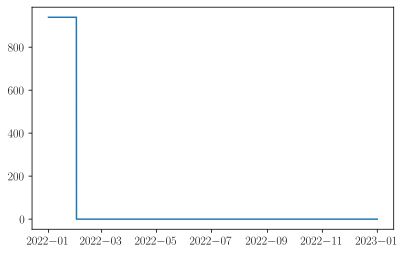

In [10]:
plt.plot(sim_index, curr_peak_cost_values[1:])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Total cost for 2022: 35,044.69 NOK
Time-of-use cost: 8,305.00 NOK (23.70% of total cost)
Peak power cost: 26,739.70 NOK (76.30% of total cost)


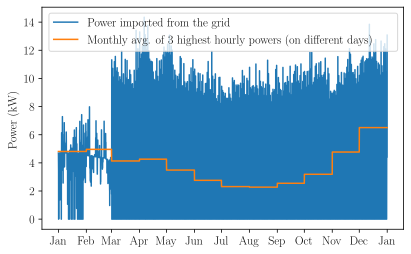

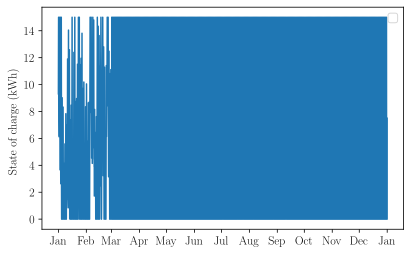

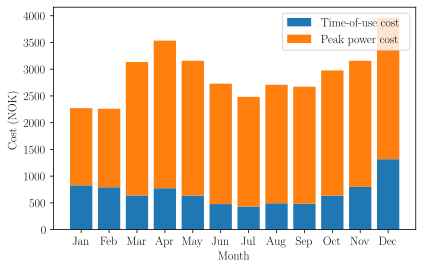

In [11]:
price_buy = price_data.iloc[sim_start_time:sim_end_time].values
# Calculate the time-of-use cost per month
monthly_time_of_use_cost = compute_monthly_time_of_use_cost(price_buy, p_values, sim_index)

# Calculate the peak power cost per month
monthly_peak_power_cost = compute_monthly_peak_power_cost(p_values, sim_index, price_peak)

# Calculate total costs for each category
total_cost = sum(monthly_time_of_use_cost) + sum(monthly_peak_power_cost)
total_time_of_use_cost = sum(monthly_time_of_use_cost)
total_peak_power_cost = sum(monthly_peak_power_cost)

# Compute z: monthly average of the largest 3 daily peak powers
z_series = compute_monthly_avg_largest_3_daily_peak_powers(p_values, sim_index)

# Display cost summary
print_cost_summary(total_cost, total_time_of_use_cost, total_peak_power_cost)

# Create a grid power plot
plot_grid_power(sim_index, p_values, z_values, "Power (kW)", "figures/linear_power_mpc.pdf")

# Create a state of charge plot
plot_state_of_charge(sim_index, q_values[1:], "State of charge (kWh)", "figures/linear_soc_mpc.pdf")

# Create a stack plot showing monthly time-of-use and peak power costs
plot_monthly_costs(monthly_time_of_use_cost, monthly_peak_power_cost, "figures/linear_cost_mpc.pdf")

## MPC with baseline-residual forecast